## *Install and Import libraries*

In [ ]:
pip install swifter langid prince functions

In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=dbe8f004cb74e2a472809abe9e739940f16ac88bd5300abbc0174ef80cce063c
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=17a8104038a03e03c87a1f7f646696bc2a1c555cdee0a4a689bb55ba0e00b442
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [2]:
pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import json
import csv
import random
import string
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster.elbow import kelbow_visualizer
from collections import defaultdict
from datetime import timedelta
from scipy import stats
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import prince
import langid
import swifter
import functions
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from functions import min_hash_signatures, get_top5_movies, find_similar_users, recommend_movies

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Loading and investigating the data*

We access data found in this dataset. In our spefic case the **dataset refer to Netflix audience behaviour and UK movies.**
The dataset covers user behaviour on Netflix from users in the UK to opted-in to have their anonymized browsing activity tracked.

It only includes desktop and laptop activity (which Netflix estimate is around 25% of global traffic) and is for a fixed window of time (January 2017 to June 2019, inclusive).

We may remark that data is not trusted by the platform itself but of course is relevant for *media economics.*


In [ ]:
df = pd.read_csv('netflix.csv')
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


In [ ]:
df.describe()

,Unnamed: 0,duration
count,671736.00000,6.717360e+05
mean,394640.50000,3.347603e+04
std,193913.62455,1.574396e+05
min,58773.00000,-1.000000e+00
25%,226706.75000,0.000000e+00
50%,394640.50000,1.400000e+01
75%,562574.25000,6.672250e+03
max,730508.00000,1.823725e+07


In [ ]:
df.shape

(671736, 8)

In [ ]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [ ]:
# check for missing values
df.isnull().sum()


Unnamed: 0      0
datetime        0
duration        0
title           0
genres          0
release_date    0
movie_id        0
user_id         0
dtype: int64

In [ ]:
# check for duplicates
df.duplicated().sum()

0

### 1. Recommendation System

In [ ]:
df.columns

Index(['Unnamed: 0', 'datetime', 'duration', 'title', 'genres', 'release_date',
       'movie_id', 'user_id'],
      dtype='object')

In [ ]:
# eliminating the clicks with duration 0 as it means the user did not watch the movie and may be it was a miss click
df = df[df['duration'] != 0]
df.head(15)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"Drama, History, War",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"Drama, Horror, Thriller",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"Comedy, Drama",2000-04-14,584bffaf5f,759ae2eac9
13,58786,2017-01-01 21:33:26,38120.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,5b1727dc12
14,58787,2017-01-01 21:37:41,7799.0,Beasts of No Nation,"Drama, War",2015-10-16,c57e11da52,3142b4c730
17,58790,2017-01-01 22:52:08,181.0,Maravilla,"Documentary, Biography, Sport",2014-05-29,19c537b01e,93e9369e81
19,58792,2017-01-01 00:19:40,54195.0,About Last Night,"Comedy, Romance",2014-02-14,f7d088d208,78cdb81c4f
20,58793,2017-01-01 00:49:03,44413.0,Fight Club,Drama,1999-10-15,338abadc17,ac30a85c52


In [ ]:
# counting the number of clicks for each movie
number_of_clicks = df['title'].value_counts()
# top 10 movies clicked
top_10_clicked = number_of_clicks[:10]
top_10_clicked

title
Black Mirror: Bandersnatch                      2884
Bright                                          1928
Avengers: Age of Ultron                         1561
Annihilation                                    1536
Bird Box                                        1474
Deadpool                                        1425
Hot Fuzz                                        1368
The Hitman's Bodyguard                          1307
FYRE: The Greatest Party That Never Happened    1203
Captain America: Civil War                      1153
Name: count, dtype: int64

In [ ]:
top_10_clicked.index

Index(['Black Mirror: Bandersnatch', 'Bright', 'Avengers: Age of Ultron',
       'Annihilation', 'Bird Box', 'Deadpool', 'Hot Fuzz',
       'The Hitman's Bodyguard',
       'FYRE: The Greatest Party That Never Happened',
       'Captain America: Civil War'],
      dtype='object', name='title')

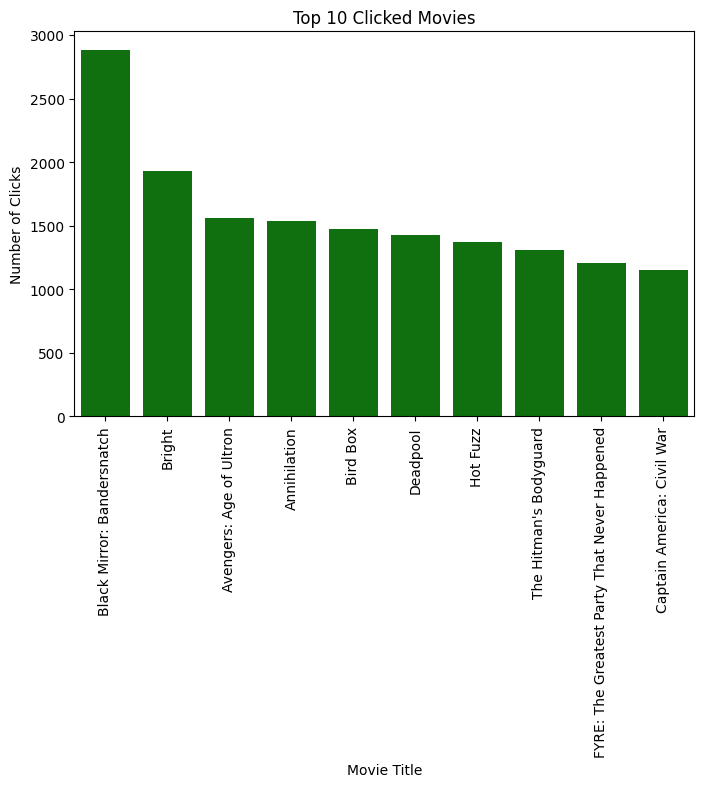

In [ ]:
# plotting the top 10 clicked movies
plt.figure(figsize=(8, 5))
sns.barplot(x=top_10_clicked.index, y=top_10_clicked.values, color='green')
plt.title('Top 10 Clicked Movies')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Clicks')
plt.show()


In [ ]:
top_10_movies_titles_genres = df[df['title'].isin(top_10_clicked.index)][['title', 'movie_id','genres']]
top_10_movies_titles_genres.drop_duplicates(inplace=True)
top_10_movies_titles_genres = top_10_movies_titles_genres[top_10_movies_titles_genres['genres'] != 'NOT AVAILABLE']

# top 10 clicked movies and their genres
top_10_movies_titles_genres


,title,movie_id,genres
757,Captain America: Civil War,572b55789d,"Action, Adventure, Sci-Fi"
22312,Deadpool,2b83f89fbe,"Action, Adventure, Comedy, Sci-Fi"
38370,Avengers: Age of Ultron,51a1a42126,"Action, Adventure, Sci-Fi"
69379,Hot Fuzz,6467fee6b6,"Action, Comedy, Mystery, Thriller"
221353,Bright,0ca8bc0382,"Action, Fantasy, Thriller"
306179,Annihilation,1f579d43c3,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr..."
323723,The Hitman's Bodyguard,261df73aa6,"Action, Comedy, Crime, Thriller"
508195,Bird Box,b4a3d3b288,"Drama, Horror, Sci-Fi"
514702,Black Mirror: Bandersnatch,e847f14da5,"Drama, Mystery, Sci-Fi, Thriller"
538537,FYRE: The Greatest Party That Never Happened,3a84965f36,"Documentary, Music"


## **1.2 Minhash Signatures**

For the hashing process, the uniques genres will be extracted from the "genres" column which will be used as **shinglings**. After that, the users will be aggregated in the same bucket if they have **similar** genres of interest.

In [ ]:
# Preprocess genres column
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

# Create a set of unique genres
genres_list = list(set(genre for genres in df['genres'] for genre in genres))


In [ ]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9


In [ ]:
print('There are',len(genres_list), 'unique genres in the dataset, which are', genres_list)

There are 27 unique genres in the dataset, which are ['Animation', 'Film-Noir', 'Music', 'Sport', 'Mystery', 'NOT AVAILABLE', 'Family', 'Musical', 'Biography', 'Horror', 'Comedy', 'News', 'Crime', 'Adventure', 'Sci-Fi', 'War', 'Talk-Show', 'Short', 'Drama', 'Thriller', 'Romance', 'Action', 'Documentary', 'Fantasy', 'Reality-TV', 'History', 'Western']


In [ ]:
# unique user_ids
unique_users = list(df['user_id'].unique())

# Create a binary matrix where each row represents a user, and each column represents a genre
binary_matrix = pd.DataFrame(0, index=genres_list, columns=unique_users)




In [ ]:
binary_matrix.shape

(27, 120271)

In [ ]:
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Animation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Film-Noir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mystery,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Iterate over rows in the original DataFrame
for index, row in df.iterrows():
    user_id = row['user_id']
    genres = row['genres']

    # Check if each genre is in the binary_matrix columns
    for genre in genres:
        if genre in binary_matrix.index:
            # Update the corresponding entry to 1
            binary_matrix.loc[genre, user_id] = 1


In [ ]:
# Drop the NOT AVAILABLE column
binary_matrix.drop('NOT AVAILABLE', axis=0, inplace=True)
binary_matrix.head()

,7cbcc791bf,ebf43c36b6,8e1be40e32,cff8ea652a,759ae2eac9,5b1727dc12,3142b4c730,93e9369e81,78cdb81c4f,ac30a85c52,...,065de46f55,098fe851e4,dd618de356,5301342a0a,5463651e3a,b73c342014,d0110d76ef,89c715f3a4,9207e1499b,57501964fd
Animation,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
Film-Noir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Music,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
Sport,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
Mystery,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
binary_matrix.shape

(26, 120271)

In [ ]:
np.random.seed(42)

# number of permutations
perms = len(genres_list)
# number of buckets
num_buckets = 1000
# Convert the binary matrix to a NumPy array
binary_matrix = binary_matrix.to_numpy()

signatures, buckets = min_hash_signatures(binary_matrix, perms, num_buckets)


#### **Justification for the choice of number of buckets:**

For a more tailored recommendation system, the assumption is made that each bucket can represent a genre, two genres, or three genres at most. Since we have 26 unique genres, the number of buckets is calculated as follows:

$$
\text {Number of Buckets} = \binom{26}{1} + \binom{26}{2} + \binom{26}{3} \text {= 2951 Buckets}
$$

## **1.3 Locality-Sensitive Hashing (LSH)**

In [ ]:
# Example usage
target_user_id = "8e1be40e32"
most_similar_users = find_similar_users(target_user_id, unique_users, signatures)

print(f"The two most similar users to the user with ID:{target_user_id} are:")
for user_id, similarity in most_similar_users:
    print(f"User ID: {user_id}, Similarity: {similarity}")

The two most similar users to the user with ID:8e1be40e32 are:
User ID: da3f0669d2, Similarity: 0.9878400682662835
User ID: 3983837e59, Similarity: 0.9860299350529271


In [ ]:
user_A_movies = get_top5_movies(most_similar_users[0][0], df, 'A')
user_B_movies = get_top5_movies(most_similar_users[1][0], df, 'B')

In [ ]:
user_A_movies

,title,movie_id,clicks,user
0,Brain on Fire,7fa4b44faf,3,A
1,Loving Vincent,c8677345e4,2,A
2,Angela's Ashes,1218186787,2,A
3,Moonstruck,3af7570904,2,A
4,Feminists: What Were They Thinking?,924c8b4002,2,A


In [ ]:
user_B_movies

,title,movie_id,clicks,user
0,Good Will Hunting,196b10fbd4,3,B
1,The Bank Job,fb219cc6c9,2,B
2,Security,b5f025e63d,1,B
3,Unlocked,a9954fc307,1,B
4,Churchill,645ae57fc7,1,B


In [ ]:
movies_to_recommend = recommend_movies(user_A_movies, user_B_movies)
print('The recommended movies are:')
for movie in movies_to_recommend:
    print(movie)

The recommended movies are:
Brain on Fire
Loving Vincent
Angela's Ashes
Moonstruck
Feminists: What Were They Thinking?


## Approach:

### Step 1: Min-Hash Signature Calculation

#### Function: `min_hash_signature(matrix, num_hashes)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.

- **Output:**
  - Min-hash signatures for each user.

- **Explanation:**
  1. For each genre, iterate through users and update the min-hash signature.
  2. Generate random hash functions to create permutations of user indices.
  3. Calculate the min-hash signature for each user by considering their liked genres.
  4. The resulting matrix (`signature_matrix`) contains min-hash signatures for all users.

### Step 2: Bucketing Users Using LSH

#### Function: `min_hash_signatures(matrix, num_hashes, num_buckets)`

- **Input:**
  - Binary matrix `matrix` (movie genres vs. users).
  - Number of hash functions `num_hashes`.
  - Number of buckets `num_buckets`.

- **Output:**
  - Min-hash signatures for each user.
  - Users grouped into buckets.

- **Explanation:**
  1. Extend the previous function to include bucketing logic.
  2. Initialize an empty dictionary (`buckets`) to store user indices for each bucket.
  3. For each genre:
     - Update min-hash signatures for users.
     - Map the min-hash signature to a bucket using a hash function.
     - Add the user to the corresponding bucket in the `buckets` dictionary.


# **2 - Grouping user together**

## *filter data*

We change default value to zero for missing values of `duration` variable

In [ ]:
# setting to 0 default missing values as could compromise future averages when doing feature engeneering
df['duration'] = df['duration'].map(lambda x: 0 if x ==-1 else x)

In [ ]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


*Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as `feature engineering`. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user.*

## Feature engeneering

## **1.** Get **favorite genre**, according to time spent seeing that genre films (duration)

> To get the favorite genre of a user we first create of set of genres

>and than we count for each user which is the most seen (based on the duration of the films)

In [ ]:
# For each row we have now a list of the genres and store to a new variable in the dataset
df['genres_list'] = df.genres.apply(lambda row: [word.strip() for word in row.split(',')])
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]"
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]"
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf,"[Action, Thriller]"
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6,"[Action, Drama]"
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287,"[Animation, Action, Adventure, Comedy, Family,..."


### Approach

As each films has multiple labels referring to the genre we probabily want to make a dictionary from the set of genres created, update the count with the duration if that film belongs to that genre and return the favorite genre for each user.

To get the first feature we will:

1.   Create the dictionary {   (`user_id`, `genre`): `total_duration_spent_for_that_genre`}
2.   From this we create a new vocabulary where we have for each user the maximum duration and all associated genres. It occures to have more that one genres as a film can have multiple labels or more films same maximum duration.

> This dictionary will look like
{`user_id`: [`total_duration`, [ `genre1`,`genre2`,`genre3`]}
3. We convert it to a DataFrame and merge to the gf - dataframe merged by user_id



In [ ]:
# I create a dictionary were I store the genre and the total time spent on that genre
# for each user.

# Create a defaultdict to store genre durations for each user
genres_dict = defaultdict(int)

# Iterate over rows in genre_df
for index, row in gdf.iterrows():
    user_id = row['user_id']
    duration = row['duration']

    # Update the genre durations in the dictionary
    for genre in row['genres_list']:
        genres_dict[user_id, genre] += duration

In [ ]:
# An example of a key and a result of the dictionary
genres_dict[('c4e13ce589', 'Adventure')]

55279.0

In [ ]:
# Create the second dictionary to search the genre which maximum duration
column_fav_genres = defaultdict()
# Iterate over each user
for user,user_genres in genres_dict.keys():
    # Get duration
    duration = genres_dict[user,user_genres]
    # We update the dictionary with genres if those also have the maximum duration
    if user in column_fav_genres:
        # Storing the duration
        if column_fav_genres[user][0] == duration :
            # And the user
            column_fav_genres[user][1].append(user_genres)

        else:
            # Or replace the list of genre with maximum duration for each user when a find a greater duration
            if column_fav_genres[user][0]>duration:
                column_fav_genres[user] = [column_fav_genres[user][0], [user_genres]]
    # Otherwise we create a new label in the dictionary
    else:
        column_fav_genres[user] = [duration, [user_genres]]


In [ ]:
column_fav_genres['e81837c873']

[1474.0, ['Action', 'Drama', 'Thriller']]

In [ ]:
# Creating a new dictionary only for the favorite genres
for user in column_fav_genres.keys():
    column_fav_genres[user] = column_fav_genres[user][1]

In [ ]:
column_fav_genres['d7059ace40']

['Adventure', 'Family', 'Fantasy', 'Animation']

In [ ]:
# Creating a dataset from it
fav_genres = pd.DataFrame(column_fav_genres.items(), columns=['user_id','favorite_genres'])

In [ ]:
fav_genres.head()

,user_id,favorite_genres
0,1dea19f6fe,"[Comedy, Drama, Romance]"
1,544dcbc510,[Adventure]
2,7cbcc791bf,[Romance]
3,ebf43c36b6,[Comedy]
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu..."


## **2. average click duration**

Here we simply create a dataframe and computed the average duration of a click

In [ ]:
average_click = pd.DataFrame()
average_click = average_click.assign(average_click = lambda x :df.groupby(by='user_id').duration.mean()).reset_index()

average_click.head()

,user_id,average_click
0,00004e2862,0.000000
1,000052a0a0,2024.166667
2,000090e7c8,0.000000
3,000118a755,0.000000
4,000296842d,9663.500000



## **3. time of day the user spents most of the time**

Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)


In [ ]:
df.datetime = pd.to_datetime(df.datetime)
df.release_date = pd.to_datetime(df.release_date, errors='coerce')

In [ ]:
df['hourofday'] = 0
df['hourofday'] = df.datetime.dt.hour

df.groupby(by=['user_id','hourofday'])


I create a dictionary as the following:
> {`user_id`: `duration_morning`,`duration_afternoon`,`duration_night`}
were all duration as considered as the the sum of the duration if `hourofday` is in the respective bins (slot of time).

Notice that we are considering only the starting point as information

Furthermore we split a in day in morning, afternoon and night in the following way:

part of the day (hourofday)=
\begin{cases}
\text{morning} \qquad \quad hourofday \in[05,12] \\
\text{afternoon}   \qquad hourofday \in[12,21] \\
\text{night} \qquad \qquad hourofday \in[21,05] \\
\end{cases}


In [ ]:
# Define a dictionary to store each total duration for each part. of the day
find_max_duration = defaultdict(lambda: [0,0,0])


# Iterating over the dataset to get all the information
for index,row in df.iterrows():
    user_id = row['user_id']
    hour = row['hourofday']
    duration = row['duration']
    # Add opportunly sum up in the corrispondence position in the list
    if 5<=hour<12:
        # list[0] if MORNING
        find_max_duration[user_id][0] += duration
    elif 12<=hour<21:
        # list[1] for AFTERNOON
        find_max_duration[user_id][1] += duration
    elif 21<=hour or hour<5:
        # list[2] if NIGHT
        find_max_duration[user_id][2] += duration

In [ ]:
# An example
find_max_duration['7cbcc791bf']

[0, 21496.0, 3816.0]

In [ ]:
# Create a new dictionary were for each user I return 'Morning/Afternoon/Night'
# leveraging the dictionary fin_max_duration
max_hourofday = defaultdict()

i=0
for id in find_max_duration.keys():
    max_list = find_max_duration[id].index(max(find_max_duration[id]))
    if max_list ==0:
        max_hourofday[id] = 'Morning'
    if max_list ==1:
        max_hourofday[id] = 'Afternoon'
    if max_list ==2:
        max_hourofday[id] = 'Night'

In [ ]:
# Creating a DataFrame from the dictionary
timeofday = pd.DataFrame(list(max_hourofday.items()), columns=['user_id', 'timeofday'])

In [ ]:
timeofday.head()

,user_id,timeofday
0,1dea19f6fe,Morning
1,544dcbc510,Afternoon
2,7cbcc791bf,Afternoon
3,ebf43c36b6,Afternoon
4,a57c992287,Afternoon


### **4. old movie lover/new school user**

Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?

We set this variable to `oldmovies` when an user saw more films released before 2010 rather then film released after that year.

In [ ]:
df['oldmovie'] = False
df['oldmovie'] = df.release_date.dt.year < 2010

# Group by 'user_id' and calculate the sum of True and False for each user
user_preference = df.groupby('user_id')['oldmovie'].sum()

oldmovie_df = pd.DataFrame(user_preference).reset_index()
# Create a new column 'oldmovie_preference' based on the condition
oldmovie_df['oldmovie'] = df['user_id'].map(user_preference > (df.groupby('user_id')['oldmovie'].count() - user_preference))

# Convert the boolean values to 'oldmovies' or 'newmovies'
oldmovie_df['oldmovie'] = oldmovie_df['oldmovie'].map({True: 'oldmovies', False: 'newmovies'})



In [ ]:
oldmovie_df.head()

,user_id,oldmovie
0,00004e2862,oldmovies
1,000052a0a0,newmovies
2,000090e7c8,newmovies
3,000118a755,newmovies
4,000296842d,newmovies


## **5. average time**
Average time spent a day by the user (considering only the days he logs in)

In [ ]:
df1 = pd.DataFrame()
df1[['days', 'averagetime_day', 'user_id']] = df[['datetime', 'duration', 'user_id']]

# Extract the date from the 'datetime' column
df1['date'] = df1['days'].dt.date

# Group by date and perform your desired aggregation
grouped_data = df1.groupby(by = ['date','user_id']).agg({'averagetime_day': 'mean'}).reset_index().drop(columns=['date'])
# Group by user_id and calculate the mean of 'averagetime_day'
user_avg_data = grouped_data.groupby('user_id')['averagetime_day'].mean().reset_index()

In [ ]:
# Considering minutes insted of seconds
user_avg_data['averagetime_day'] = user_avg_data['averagetime_day'].transform(lambda x :x/60)

In [ ]:
user_avg_data.head()

,user_id,averagetime_day
0,00004e2862,0.000000
1,000052a0a0,44.871296
2,000090e7c8,0.000000
3,000118a755,0.000000
4,000296842d,143.319444


## We finally have all our 5 variables + `user_id`

In [ ]:
# We merge our five variables
merged_df = pd.merge(fav_genres, average_click, on='user_id')
merged_df = pd.merge(merged_df, oldmovie_df, on='user_id')
merged_df = pd.merge(merged_df, user_avg_data, on='user_id')
merged_df = pd.merge(merged_df, timeofday, on='user_id')


In [ ]:
merged_df.head()

,user_id,favorite_genres,average_click,oldmovie,averagetime_day,timeofday
0,1dea19f6fe,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning
1,544dcbc510,[Adventure],2024.166667,newmovies,44.871296,Afternoon
2,7cbcc791bf,[Romance],0.000000,newmovies,0.000000,Afternoon
3,ebf43c36b6,[Comedy],0.000000,newmovies,0.000000,Afternoon
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon


In [ ]:
merged_df.to_json('/content/drive/MyDrive/ADM4/5variables.json', orient='records', lines=True)

## *Let's add some more feature*

This new features should be relevant for to respect to `user_id`

Consider at least 10 additional features that can be generated for each user_id. In the end, you should have for each user at least 15 features.

## **1. day of the week preference**

Harnessing the power of data analytics, we're about to decipher the movie-watching patterns that unfold as the calendar shifts from Monday to Sunday. Are weekends the undisputed champions of cinematic indulgence, or does the magic of movies extend its influence throughout the workweek as well?

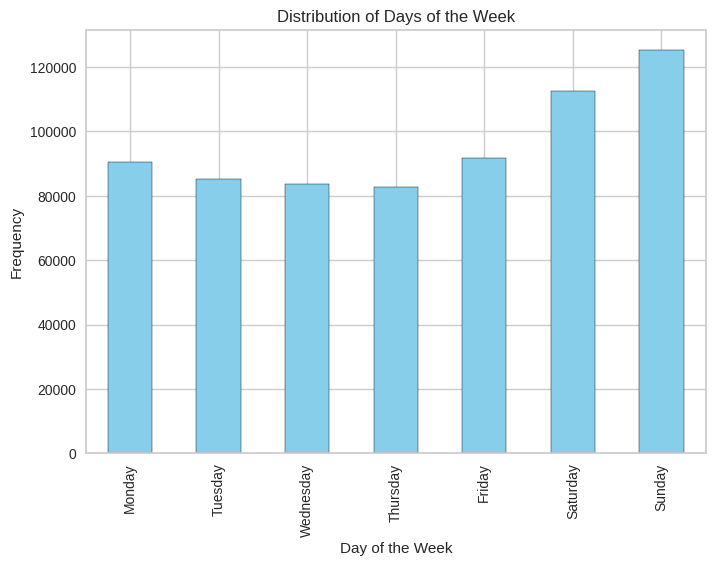

In [ ]:
# Create a new DataFrame 'week' with 'day_of_week' and 'user_id'
week = df[['datetime', 'user_id']].copy()

# Plotting the distribution of days of the week
day_counts = week['day_of_week'].value_counts()
day_counts = day_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

day_counts.plot(kind='bar', edgecolor='black', color='skyblue')

# Plot the histogram
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Distribution of Days of the Week')
plt.show()

Analyzing the data reveals a compelling trend: the enchantment of cinematic experiences intensifies over the weekends, with Saturdays and Sundays emerging as the prime days for movie watching.

We define a new *feature* `weekend` as:

weekend=
\begin{cases}
False \qquad \qquad \text{is a weekday} \\
True \qquad \qquad \text{is in the weekend} \\
\end{cases}

We can leverage this new variable to better understand the behaviour of the

In [ ]:
week['day_of_week'] = df['datetime'].dt.day_name()
weekend = ['Saturday', 'Sunday']

# map into True/False values if the user watch in the film in the weekendor
week['isweekend'] = week['day_of_week'].map(lambda x : x in weekend)
# Group by 'user_id'
weekend_preference = week.groupby('user_id')['isweekend'].sum()
day_count= week.groupby('user_id')['isweekend'].count()

# Column 'weekend' based on the condition normalizing by the number of days
week['weekend'] = week['user_id'].map(
    lambda user_id: (day_count[user_id]/7 < weekend_preference[user_id]/2)
)

In [ ]:
week = week.drop(columns=['datetime', 'day_of_week','isweekend']).drop_duplicates()

In [ ]:
week

,user_id,weekend
0,1dea19f6fe,True
1,544dcbc510,True
2,7cbcc791bf,True
3,ebf43c36b6,True
4,a57c992287,False
...,...,...
671702,45414be0ec,True
671705,783ec67e84,True
671727,89c715f3a4,True
671730,9207e1499b,True


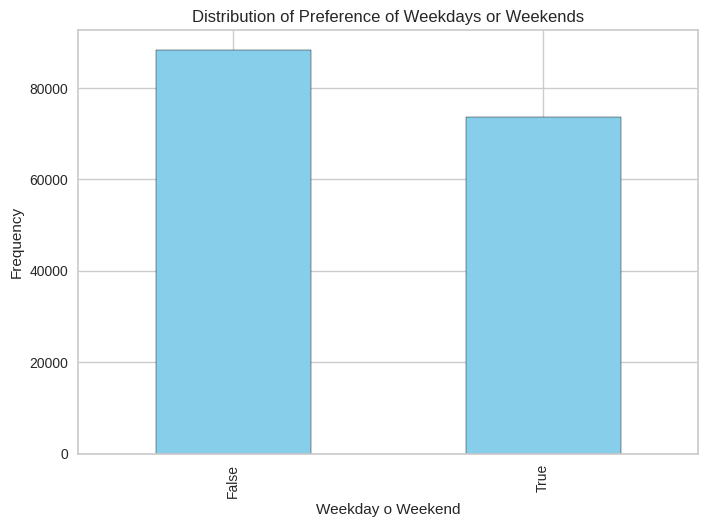

In [ ]:
weekend_weekday= week['weekend'].value_counts()
weekend_weekday.plot(kind='bar', edgecolor='black', color='skyblue')

# Setting labels and title
plt.xlabel('Weekday o Weekend')
plt.ylabel('Frequency')
plt.title('Distribution of Preference of Weekdays or Weekends')

# Display the plot
plt.show()

## **2. english title**
Could the presence of non-English titles be the key to unraveling distinctive user preferences?

As we embark on this cinematic journey, we initiate the variable `count_nonenglish` to meticulously tally every film search with a non-English title. The intrigue deepens as we explore the diverse landscape of film preferences.

### Approch:

we leverage the package langid to check the language of the title and store our variable consequently

In [ ]:
def is_english(text):
    '''
    This function take a string of text and return wether all text is English
    Returns a boolean object
    '''
    language, confidence = langid.classify(text)
    return language == 'en'

In [ ]:
isenglish = df[['user_id','title']]

# Use tqdm's progress_apply for a progress bar
isenglish['isenglish'] = tqdm(df['title'].swifter.apply(lambda x: is_english(x)))

Pandas Apply:   0%|          | 0/671736 [00:00<?, ?it/s]

100%|██████████| 671736/671736 [00:00<00:00, 2718500.69it/s]
<ipython-input-79-ce457ab2d174>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isenglish['isenglish'] = tqdm(dataset['title'].swifter.apply(lambda x: is_english(x)))


In [ ]:
isenglish

,user_id,title,isenglish
0,1dea19f6fe,"Angus, Thongs and Perfect Snogging",True
1,544dcbc510,The Curse of Sleeping Beauty,True
2,7cbcc791bf,London Has Fallen,True
3,ebf43c36b6,Vendetta,False
4,a57c992287,The SpongeBob SquarePants Movie,True
...,...,...,...
671731,57501964fd,Oprah Presents When They See Us Now,True
671732,d4fcb079ba,HALO Legends,False
671733,4a14a2cd5a,Pacific Rim,True
671734,0b8163ea4b,ReMastered: The Two Killings of Sam Cooke,True


In [ ]:
# Evaluating the numbers of films not in english that the user searched for
isenglish['count_notenglish'] = isenglish.groupby('user_id')['isenglish'].transform(lambda x: x.count() - x.sum())

# Dropping auxiliar columns
isenglish = isenglish.drop(columns=['title','isenglish']).drop_duplicates()


In [ ]:
isenglish

,user_id,count_notenglish
0,1dea19f6fe,0
1,544dcbc510,0
2,7cbcc791bf,1
3,ebf43c36b6,5
4,a57c992287,5
...,...,...
161913,45414be0ec,1
161914,783ec67e84,0
161915,89c715f3a4,0
161916,9207e1499b,0


<Axes: >

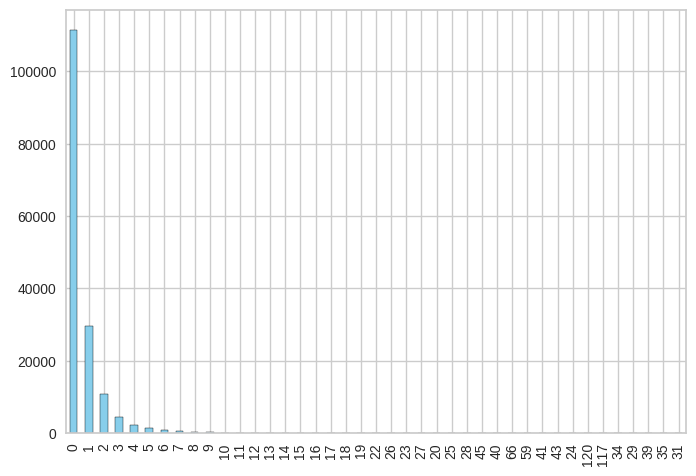

In [ ]:
english_user= isenglish['count_notenglish'].value_counts()
english_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **3. series addiction**

If an user saw at least a film which belongs to a series

First of all **we define a film to be part of a series if**:

> in the title there is a number (this decision was taken looking at the unique values of the titles) which:
  >> does not start at the beginning of the title

  >> is not a percentage (e.g. 100)
  
  >> is not a float number like (1.0) or (40,000)

  >> 1st (appears not to assign the number of series of a film)

  >> 3D information qithin the title

  >> mixed string like QR45EE700

  >> digits more that 3 digits, assuming that a series of film will not exceed 999

  >> reference to years like 90s or '42

All examples cited were occurenced of real tiles in the dataset

Finally we define the feature through boolean values as follows:


series_addicted=
\begin{cases}
False \qquad \qquad \text{never seena film which belongs to a series} \\
True \qquad \qquad \text{has seen at least one series} \\
\end{cases}


In [ ]:
series = df[['title','user_id']].copy()

def remove_punctuation(input_string):
    '''
    Function wich return a string
    '''
    translation_table = str.maketrans("", "", string.punctuation)
    no_punctuation = input_string.translate(translation_table)
    return no_punctuation

def process_title(title):
    '''
    Finds wethere a film belongs or not to a series of films based on the ruled decided
    for this dataset
    '''
    joined_title = title
    joined_title = re.sub(r"\([^)]*\)|3D|\d{1,3}%|\d{1,2}[,|.]\d{1,3}|\d{2}s|'\d{2}|\d{1,3}%|\d{1,3}[st|th|rd]", '', joined_title)
    joined_title1 = ''.join(remove_punctuation(joined_title).split())
    return not bool(re.match(r'^\d{1,4}|(\ )?[A-Z]?\d{1,6}\ ', joined_title)) and not joined_title1.isalpha()

# Create a new column 'is_series' based on those condition
series['is_series'] = series['title'].apply(process_title)

In [ ]:
# Now for each user we count how many series he saw
number_series = pd.DataFrame(series.groupby('user_id')['is_series'].sum()).reset_index()

# We convert this feature to boolean when a user has seen at least a film of the series
number_series['is_series'] = number_series['is_series'].apply(lambda x: True if x > 0 else False)

In [ ]:
number_series

,user_id,is_series
0,00004e2862,False
1,000052a0a0,False
2,000090e7c8,False
3,000118a755,False
4,000296842d,False
...,...,...
161913,fffd9bf758,True
161914,fffe7b777b,False
161915,fffeac83be,False
161916,ffff2c5f9e,False


<Axes: >

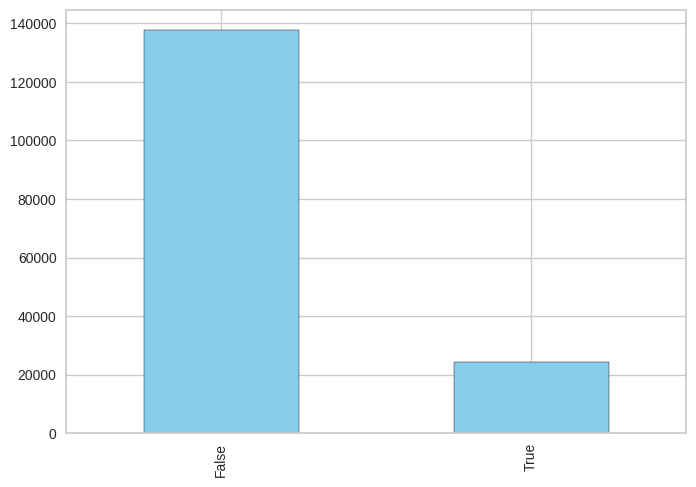

In [ ]:
series_user= number_series['is_series'].value_counts()
series_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **4. film-coholic**

We establish the count of films the user has either viewed or queried by utilizing the variable `title`.

This variable acts as a pivotal tool in capturing the cinematic footprint of the user, allowing us to meticulously track their engagement with movies, whether it be through actual viewing experiences or inquisitive searches.

In [ ]:
# Copy the important information we need for our new variable
num_films = df[['user_id','title']].copy()

# Grouping by user we count the number of films
num_films['num_films'] = num_films.groupby('user_id')['title'].transform('size')

# Adjust for merging
num_films = num_films.drop(columns=['title']).reset_index(drop=True).drop_duplicates()

In [ ]:
num_films

,user_id,num_films
0,1dea19f6fe,1
1,544dcbc510,12
2,7cbcc791bf,6
3,ebf43c36b6,15
4,a57c992287,26
...,...,...
671702,45414be0ec,1
671705,783ec67e84,1
671727,89c715f3a4,1
671730,9207e1499b,1


<Axes: >

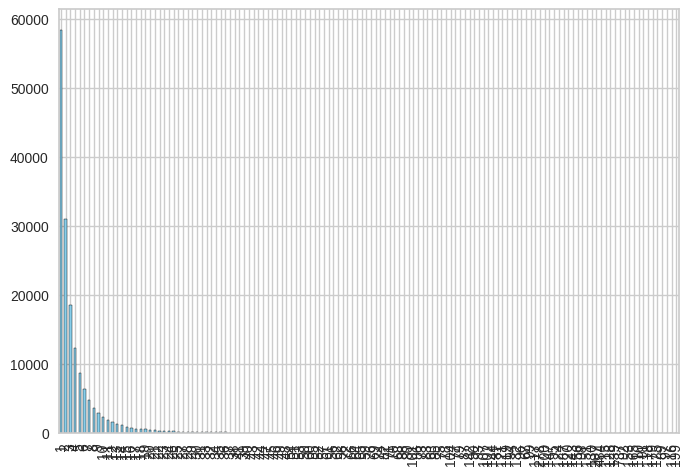

In [ ]:
film_user= num_films['num_films'].value_counts()
film_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **5. movie clicker**

It seems **someone is undecided about which movie to watch, but have they at least started watching one**? Let's define the variable `onefilm` to capture the cinematic journeys that begin with a click but may or may not reach the final credits:


movie_clicker=
\begin{cases}
False \qquad \qquad \text{definigthly a movie-clicker} \\
True \qquad \qquad \text{has seen at least one film} \\
\end{cases}


In [ ]:
# Now for each user, check if they have seen at least one film with duration greater than 0
onefilm = df[['user_id', 'title', 'duration']].copy()

# Create a binary column indicating whether the user has seen at least one film (1) or not (0)
onefilm['onefilm'] = (onefilm.groupby('user_id')['duration'].transform('max') > 0).astype(bool)

# Drop duplicates to keep only unique user_id rows
onefilm = onefilm[['user_id', 'onefilm']].drop_duplicates()


In [ ]:
onefilm

,user_id,onefilm
0,1dea19f6fe,False
1,544dcbc510,True
2,7cbcc791bf,True
3,ebf43c36b6,True
4,a57c992287,True
...,...,...
671702,45414be0ec,False
671705,783ec67e84,False
671727,89c715f3a4,False
671730,9207e1499b,True


<Axes: >

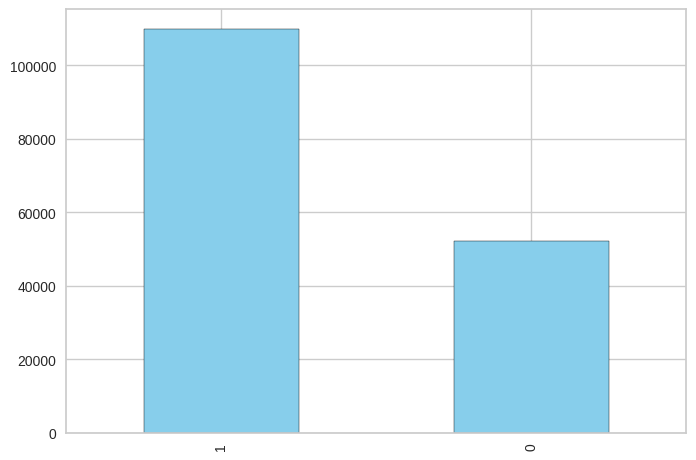

In [ ]:
onefilm_user = onefilm['onefilm'].value_counts()

onefilm_user.plot(kind='bar', edgecolor='black', color='skyblue')


## **6. unveiling the enchantment of length titles**

Ever heard of sesquipedalophobia? It's the quirky fear of long words, and while we're not here to induce word-induced anxiety, we couldn't resist a playful nod to it.

**Introducing *`avg_lentitle`* our not-so-fearsome variable that measures the average length of movie titles.**

 No need to panic; we're just unraveling the delightful dance of letters in the world of cinema. After all, a title's length may hold the secret to its allure, or perhaps it's just a whimsical journey through the labyrinth of letters

 Emphasizing inclusivity, **this metric considers all movies users searched for, providing a nuanced understanding of their preferences beyond the ones they've already watched**. This comprehensive approach enhances our ability to extract meaningful insights from their cinematic exploration

In [ ]:
# Leverage titles to find some patters in user preferences
lentitle = df[['user_id','title']].copy()
# Computing the length of title
lentitle['lentitle']= lentitle['title'].apply(lambda x: len(x))
# And extracting the average grouping by user
lentitle['avg_lentitle'] = lentitle.groupby('user_id')['lentitle'].transform(lambda x: x.mean().astype(int))
# Adjust dataset for merging operations
lentitle = lentitle.drop(columns=['title','lentitle']).drop_duplicates()

In [ ]:
lentitle

,user_id,avg_lentitle
0,1dea19f6fe,34
1,544dcbc510,15
2,7cbcc791bf,13
3,ebf43c36b6,13
4,a57c992287,14
...,...,...
671702,45414be0ec,18
671705,783ec67e84,14
671727,89c715f3a4,15
671730,9207e1499b,23


<Axes: >

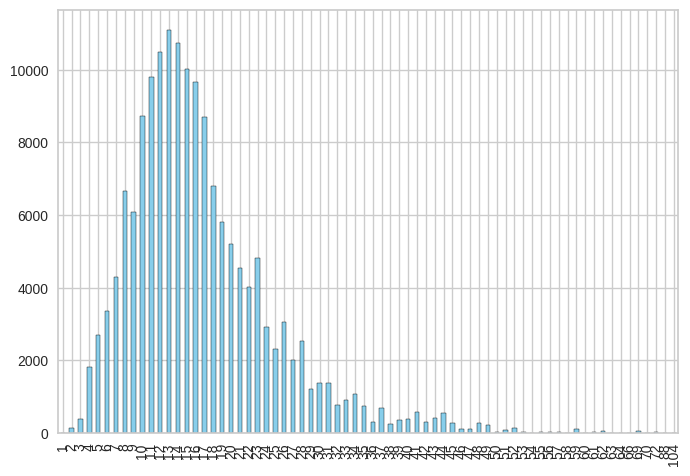

In [ ]:
title_user = lentitle['avg_lentitle'].value_counts()
title_user_sorted = title_user.sort_index()

title_user_sorted.plot(kind='bar', edgecolor='black', color='skyblue')


## **7. average duration of films seen**

Considering only the films he actually saw, **we consider the duration of the time spent to see it in minuted**. Notice that of course, only through our data, we cannot know if the user saw entirely the film.

We could eventually get an idea of that after looking at the result.

This isn't directly the goal of the variable. We can rather interprete it as if an user preferes long films of multiple episodes of a series eventually of go for short one.

In [ ]:
avg_duration = df[['user_id', 'duration']].copy()

# Filter films with duration > 0 and count the number of films seen for each user
film_seen = df[df['duration'] > 0].groupby('user_id')['title'].count().reset_index()
film_seen.columns = ['user_id', 'film_seen']

# Merge the film_seen count with avg_duration DataFrame
avg_duration = pd.merge(avg_duration, film_seen, on='user_id')

# Calculate the average duration for each user
avg_duration['sum_duration']  = avg_duration.groupby('user_id')['duration'].transform('sum')
# Consider the average only of films actually seen and consider minutes
avg_duration['avg_duration'] = np.where(avg_duration['sum_duration'] > 0, avg_duration['sum_duration'] /(60*avg_duration['film_seen']), 0).round(3)

In [ ]:
avg_duration = avg_duration.drop(columns=['duration','film_seen','sum_duration']).drop_duplicates()

In [ ]:
avg_duration

,user_id,avg_duration
0,544dcbc510,155.375
12,7cbcc791bf,105.467
18,ebf43c36b6,31.392
33,a57c992287,145.148
59,c5bf4f3f57,50.990
...,...,...
591778,065de46f55,11396.167
591779,098fe851e4,69.050
591780,5463651e3a,10.000
591781,9207e1499b,709.867


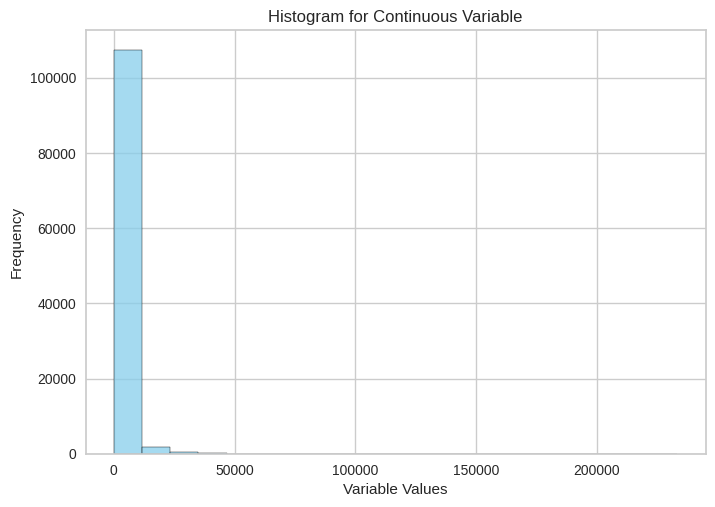

In [ ]:
sns.histplot(avg_duration['avg_duration'], bins=20, kde=False, color='skyblue')
plt.title('Histogram for Continuous Variable')
plt.xlabel('Variable Values')
plt.ylabel('Frequency')
plt.show()


## **8. genre diversity search**

Dive into the intriguing world of Genre Diversity Search, **a metric that delves into the spectrum of cinematic tastes**. If marked as "True," it indicates that a user has ventured into films across more than six diverse genres. On the flip side, if marked as "False," it suggests a cinematic journey centered around a set of consistent genres. This metric provides a nuanced glimpse into a user's preference for diverse cinematic experiences, offering valuable insights into the breadth of their film choices.

### Approach
From the variable genre_list we create a set and group by user. Then we can identify the preferences of the user watching the cardinality of the set of the single user


genre_diversity=
\begin{cases}
False \qquad \qquad \text{different cinematic tastes ( # genres > 6)} \\
True \qquad \qquad \text{limited cinematic tastes ( # genres < 6)} \\
\end{cases}

In [ ]:
genre_diversity= df[['user_id','genres_list']].copy()

genre_diversity['genre_set'] = genre_diversity['genres_list'].apply(lambda x: set(x))

# Group by 'user_id' and aggregate the sets
grouped = genre_diversity.groupby('user_id')['genre_set'].agg(lambda x: set.union(*x)).reset_index()

# Counting the different genres an user searched for
grouped['number_genres'] = grouped.groupby('user_id')['genre_set'].transform(lambda x: len(*x))

# Transforming it in adicotomic variabile according to a parameter fixed at 6, whose decision was taken after observing
# a plot of gropued['genres_diversity']
grouped['genre_diversity'] = grouped['number_genres'].transform(lambda x : 'Genre Diverse' if x>4 else 'Not Genre Diverse')

In [ ]:
grouped = grouped.drop(columns=['genre_set','number_genres'])

In [ ]:
grouped

,user_id,genre_diversity
0,00004e2862,Not Genre Diverse
1,000052a0a0,Genre Diverse
2,000090e7c8,Not Genre Diverse
3,000118a755,Not Genre Diverse
4,000296842d,Not Genre Diverse
...,...,...
161913,fffd9bf758,Not Genre Diverse
161914,fffe7b777b,Not Genre Diverse
161915,fffeac83be,Genre Diverse
161916,ffff2c5f9e,Genre Diverse


## **9. time between clicks**

Calculate the average time in minutes between two consecutive clicks for each user. Some users might binge-watch content in quick succession, while others may have more spaced-out viewing habits.

### Approch

We take the dfference of the sorted datetime by user and consider the average of these differences.


In [ ]:
gapclick = df[['user_id','datetime']].copy()

# Convert 'datetime' column to datetime format
gapclick['datetime'] = pd.to_datetime(gapclick['datetime'])

# Sort DataFrame by 'user_id' and 'datetime'
gapclick_sorted = gapclick.sort_values(by=['user_id', 'datetime'])

# Calculate the time difference between consecutive rows for each user_id
gapclick_sorted['time_diff'] = gapclick_sorted.groupby('user_id')['datetime'].diff().apply(lambda x: x.seconds/60)

# Calculate the average time gap for each user_id
gapclick_sorted['avg_clickgap']  = gapclick_sorted.groupby('user_id')['time_diff'].transform('mean').round(3)

In [ ]:
gapclick = gapclick_sorted.drop(columns=['time_diff','datetime']).drop_duplicates()

In [ ]:
gapclick

,user_id,avg_clickgap
223802,00004e2862,NaN
84304,000052a0a0,374.955
305472,000090e7c8,NaN
379093,000118a755,73.900
520133,000296842d,190.167
...,...,...
105488,fffd9bf758,NaN
149015,fffe7b777b,NaN
142253,fffeac83be,581.643
129867,ffff2c5f9e,17.517


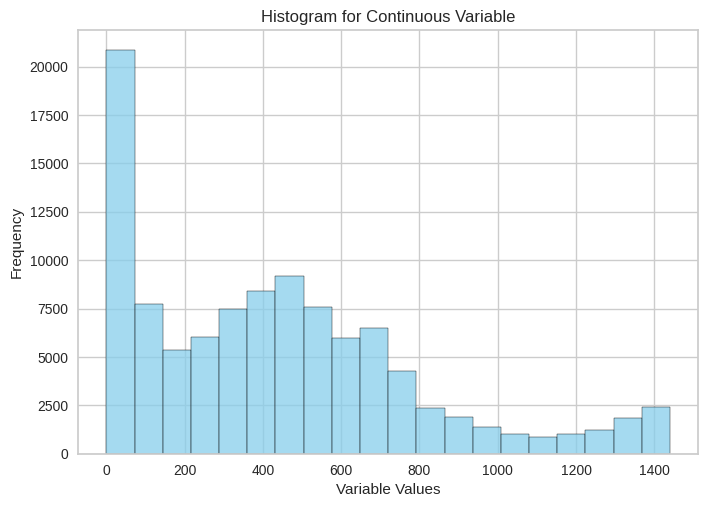

In [ ]:
# Plotting the distribution of average click in minutes
sns.histplot(gapclick['avg_clickgap'], bins=20, kde=False, color='skyblue')
plt.title('Histogram for Continuous Variable')
plt.xlabel('Variable Values')
plt.ylabel('Frequency')
plt.show()


## **10. first-day fanatic**

In this new feature we want to store if a user is a first fanatic or not examinig how muchtime from the released_date and the time he saw the film has passed.

Indeed we computed as :

$$\displaystyle \dfrac{1}{n_{u_i}} \sum_{i=1}^n \text{duration dicotomic} \cdot \left( \text{release date -  datetime}\right)$$

where `n` is the number of films seen by each user.

Notice that it is influnced by how many times saw that film so it can be normalized based on how many time an author has seen that film. It can be interested therefore to compute also that feature, which we're doing next.

In [ ]:
df[df['release_date']=='NOT AVAILABLE']

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
54,58827,2017-01-01 23:51:31,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,83e994b53d
64,58837,2017-01-01 23:18:10,81405.0,A Perfect Day,NOT AVAILABLE,NOT AVAILABLE,9e898f41e0,8aff21d9e9
71,58844,2017-01-01 13:23:40,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,0b1635a78e
113,58886,2017-01-01 12:47:30,543.0,Hunting Britain's Most Wanted,NOT AVAILABLE,NOT AVAILABLE,be096a4a5a,3cf91dd97e
118,58891,2017-01-01 17:20:26,0.0,Minimalism: A Documentary About the Important ...,Documentary,NOT AVAILABLE,4d5756f511,ea05759d9b
...,...,...,...,...,...,...,...,...
671578,730351,2019-06-30 17:27:13,8272.0,Agatha Christie's Crooked House,NOT AVAILABLE,NOT AVAILABLE,24e2aec1b8,75bfddddaf
671583,730356,2019-06-30 20:04:16,0.0,Den 12. mann,NOT AVAILABLE,NOT AVAILABLE,8551a0dbdd,5c261da852
671643,730416,2019-06-30 17:14:14,0.0,Bad Moms,NOT AVAILABLE,NOT AVAILABLE,934402ae13,06fb5a61d0
671708,730481,2019-06-30 21:10:44,3219.0,ReMastered: Who Shot the Sheriff,NOT AVAILABLE,NOT AVAILABLE,d558d9be6f,0b8163ea4b


In [ ]:
# Extract the date from the 'datetime'
#columndataset = pd.to_datetime(dataset.datetime)
df.datetime = pd.to_datetime(df.datetime)
df['release_date'] = df.apply(lambda row: row['datetime'] if row['release_date'] == 'NOT AVAILABLE' else row['release_date'],axis=1)
df.release_date = pd.to_datetime(df.release_date)

gap_time = df[['user_id','datetime','release_date','title']].copy()
gap_time['datetime'] = gap_time['datetime'].dt.year
gap_time['release_date'] = gap_time['release_date'].dt.year

# Calculate the time gap in years
gap_time['gap_time'] = gap_time['datetime'] - gap_time['release_date']

# Taking the average of realeased date only for the films which have non-zero gap time
gap_time['gap_time_avg'] = gap_time.groupby(['user_id','title'])['gap_time'].transform(lambda x: x.mean() if (x != 0).any() else 0)

# Take the average of film where film have gp_time_avg not zero. Some are setted to 0 when NOT AVAILABLE
gap_time['gap_time_avg'] = gap_time.groupby('user_id')['gap_time_avg'].transform(lambda x: x.mean() if (x != 0).any() else 0).round(0)


gap_time['gap_time_avg'] = gap_time['gap_time_avg'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
gap_time = gap_time.drop(columns=['datetime','release_date','gap_time','title']).drop_duplicates()

In [ ]:
gap_time

,user_id,gap_time_avg
0,1dea19f6fe,9.0
1,544dcbc510,5.0
2,7cbcc791bf,4.0
3,ebf43c36b6,6.0
4,a57c992287,6.0
...,...,...
671702,45414be0ec,0.0
671705,783ec67e84,10.0
671727,89c715f3a4,2.0
671730,9207e1499b,6.0


<Axes: >

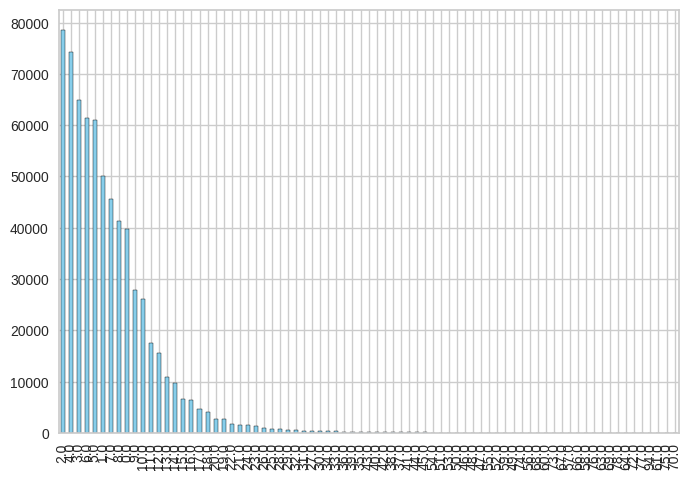

In [ ]:
gaptime_user= gap_time['gap_time_avg'].value_counts()
gaptime_user_sorted = gaptime_user.sort_index()

gaptime_user.plot(kind='bar', edgecolor='black', color='skyblue')


## final merge of the 15 features

we load the dataset we saved cointaining the first five variables

In [ ]:
file_path="/content/drive/MyDrive/ADM4/5variables.json"

# Inizializza una lista per contenere i dati JSON
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Carica l'oggetto JSON dalla riga corrente
        data = json.loads(line)
        # Aggiungi l'oggetto alla lista
        data_list.append(data)


# Now 'data' is a list of JSON objects
firstvariable = pd.DataFrame(data_list)

In [ ]:
firstvariable.head()

,user_id,favorite_genres,average_click,oldmovie,averagetime_day,timeofday
0,1dea19f6fe,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning
1,544dcbc510,[Adventure],2024.166667,newmovies,44.871296,Afternoon
2,7cbcc791bf,[Romance],0.000000,newmovies,0.000000,Afternoon
3,ebf43c36b6,[Comedy],0.000000,newmovies,0.000000,Afternoon
4,a57c992287,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon


In [ ]:
# 1- and weekeday or weekend
merged_df = pd.merge(firstvariable, week, on='user_id')
# 2- title isinglish
merged_df = pd.merge(merged_df, isenglish, on='user_id')
# 3- is a series film
merged_df = pd.merge(merged_df, number_series, on='user_id')
# 4- number of films searched
merged_df = pd.merge(merged_df, num_films, on='user_id')
# 5- if an user have seen at least one film
merged_df = pd.merge(merged_df, onefilm, on='user_id')
# 6- length of the title of film
merged_df = pd.merge(merged_df, lentitle, on='user_id')
# 7- average duration of films by user_id
merged_df = pd.merge(merged_df, avg_duration, on='user_id')
# 8- genre diversity
merged_df = pd.merge(merged_df, grouped, on='user_id')
# 9- average seconds between two clicks
merged_df = pd.merge(merged_df, gapclick, on='user_id')
# 10- average seconds between two clicks
merged_df = pd.merge(merged_df, gap_time, on='user_id')

# Set user_id as index
merged = merged_df.set_index('user_id', inplace =True)

In [ ]:
merged_df.head()

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0


In [ ]:
merged_df.to_json('/content/drive/MyDrive/ADM4/allvariables.json', orient='records', lines=True)


# **2.2 - Feature selection**


In [26]:
file_path="/content/drive/MyDrive/ADM4/allvariables.json"

# Initialize to store JSON file
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Load the single row of the JSON
        data = json.loads(line)
        # Add it to the list
        data_list.append(data)

# Now 'data' is a list
allvariable = pd.DataFrame(data_list)

In [27]:
allvariable.head()

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0


**To attemp to use the variable `favorite_genre` we consider only a single of the list of first genres we pick randomly**. We previously made an assumption to be conservative and try to store all favorite genre but at this point we need further assumption as we cannot store or consider frequencies of all possible duplets, triplets: indeed that choice would lead dealing with a very sparse histogram.

**We should find some useful aggregation** as:
>  taking a random element of list

>> Notice that it is more consistent than taking into account the first element as the genres in the list are ordered and therefore we then expect (and proved but not showing here) to have either a favorite genres or a genres that starts with A, B , C, D, ... such as Action, Comedy, Documentary, ...

In [28]:
allvariable2 = allvariable.copy()

# We selecet a random element in the list of favorite genres
allvariable2['first_genre'] = allvariable2['favorite_genres'].apply(lambda x: random.choice(x))

# and then drop the auxiliar column
allvariable2 = allvariable2.drop(columns = ['favorite_genres'])

In [29]:
allvariable2['first_genre'].head()

0       Comedy
1    Adventure
2      Romance
3       Comedy
4    Animation
Name: first_genre, dtype: object

## *data consistency: outliers, skewness, normalization*

In the pursuit of a deeper understanding of our dataset, we embark on an exploration of variable distributions. **Examining these distributions allows us to identify potential outliers, assess the stability of variance**, and consider the advantageous implications of stabilizing variance.


---



Stabilizing variance becomes crucial in enhancing the reliability of statistical analyses and modeling.

Multiple Factor Analysis (MFA) similarly emphasizes variable distribution scrutiny, maintaining variance stability. MFA's flexibility accommodates diverse variable types, ensuring equitable contributions for a balanced representation of impact. MFA benefit from stabilizing variance, fostering robust and interpretable results.

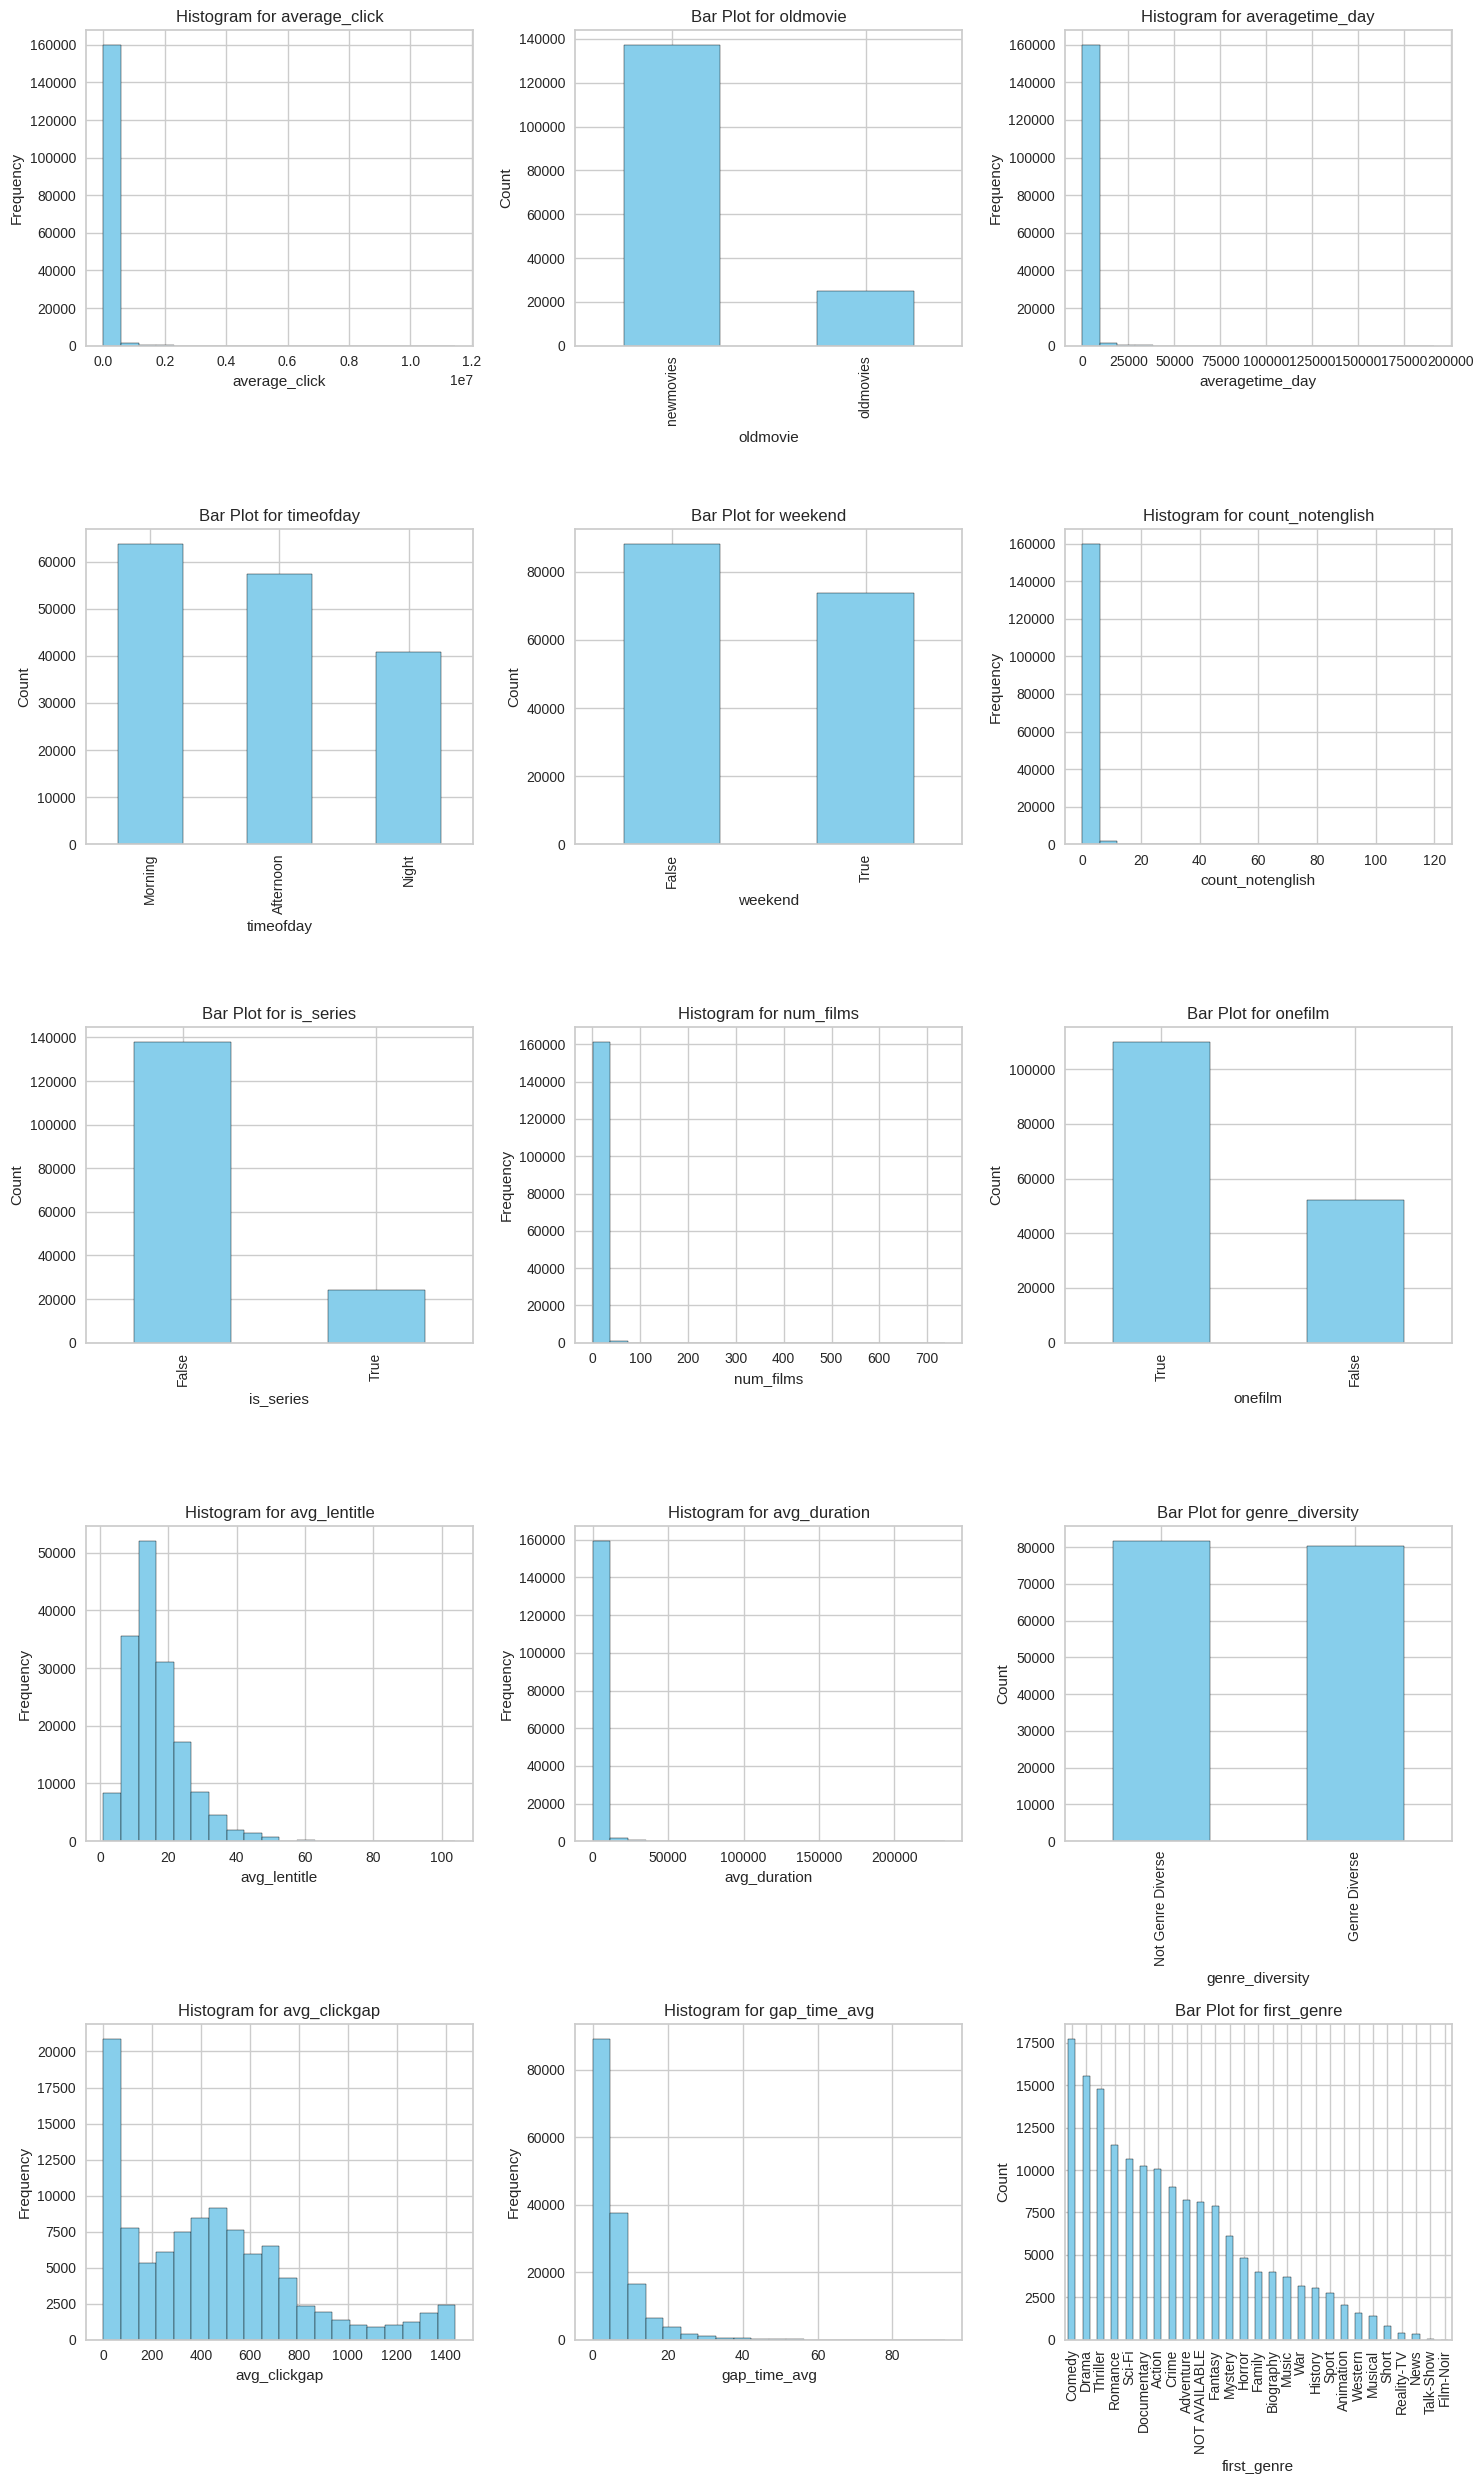

In [ ]:
# Get the list of all columns
all_columns = allvariable2.columns

# Set the number of columns per row
columns_per_row = 3  # Adjust as needed

# Calculate the number of rows needed
num_rows = (len(all_columns) + columns_per_row - 1) // columns_per_row

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(all_columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row

    # Check if the column is numerical
    if allvariable2[column].dtype in ['float64', 'int64']:
        axes[row_index, col_index].hist(allvariable2[column], edgecolor='black', color='skyblue', bins=20)
        axes[row_index, col_index].set_title(f'Histogram for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Frequency')
    else:
        # For categorical columns, create a bar plot
        column_count = allvariable2[column].value_counts()
        column_count.plot(kind='bar', edgecolor='black', color='skyblue', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'Bar Plot for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In light of this observation, **we choose to address outliers to ensure the robustness of our analysis**. The presence of outliers in the dataset, particularly in variables showcasing a skewed distribution, can disproportionately influence model performance. The decision to limit outliers is motivated by the desire to mitigate any undue impact on the results, as the data doesn't seem entirely consistent with high or otherwise anomalous values. **Importantly, these outliers do not originate from our intermediate transformations but may reflect inherent variability within the dataset.**

## **Handle `outliers`**

We remove the outliers from the following variables:  `average_duration` and `averagetime_day`

Moreover, to address the impact of outliers on the integrity of our analysis, **we choose to employ a robust approach by removing outliers based on quantile thresholds**. This method allows us to focus on the majority of the data while mitigating the influence of extreme values that may distort the overall patterns.

In most of the cases there were no values under the first percentile (the minimum coincided with the first quartile) but addressed the values above the third quartile which were erally sparse and highly distant, somehow incoherent.

In [30]:
# Select only specific columns
selected_columns = ['avg_duration', 'averagetime_day']
df_selected = allvariable2[selected_columns]

In [ ]:
# We chose a high value as data is sparse
# Setting of a multiplicative rate to tune the range of the quantiles
iqr_multiplier = 3.0

# Iterate through each column in the selected DataFrame
for column in df_selected.columns:
    # Calculate the first quartile, third quartile, and interquartile range
    Q1 = df_selected[column].quantile(0.25)
    Q3 = df_selected[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers for the current column
    outliers = ((df_selected[column] < (Q1 - iqr_multiplier * IQR)) |
                (df_selected[column] > (Q3 + iqr_multiplier * IQR)))

    # Calculate the median only for the current column
    column_median = df_selected.loc[~outliers, column].median()
    # Replace outliers with the median of the column
    df_selected.loc[outliers, column] = column_median

#### *Now that we plotted the data and reduced the range of the data, still we feel we're missing something. Some variables looks like a log-normal. Indeed it has the tipical behaviour of a log-normal: light tail for extreme right-values of the distribution.*

For example `averagetime_day` meansure the seconds in a day: maximum value that assumed before was definightly out of range. So our decision is supported not only to reach optimal results in the analysis but also logical coherence; which is overall the most important thing.

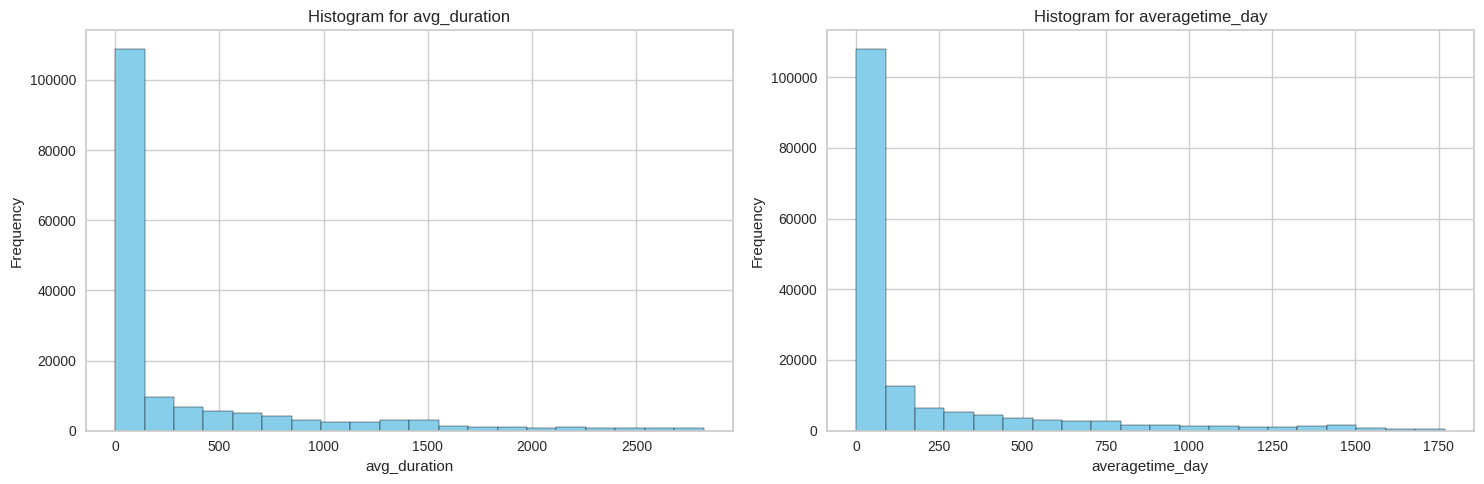

In [ ]:
# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Flatten the 2D array into a 1D array
axes = axes.flatten()

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(df_selected):
    # Check if the column is numerical
    if df_selected[column].dtype in ['float64', 'int64']:
        axes[i].hist(df_selected[column], edgecolor='black', color='skyblue', bins=20)
        axes[i].set_title(f'Histogram for {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


## **Robust Data Transformation**

**Transformations** like logarithm **are often used for various purposes in data analysis and statistics** as mentioned before. We report a brief list of reason how is worth apply such transformation: **normalization of distributions, variance stabilization, handling non-linear relationships, reducing the effect of outliers**.

Apart from  normalization and variance stabilization we indeed notice that same variables such as `num_films` we can assume that as the number of films increases the number of user which saw that number of films will decres exponentially an not linear, or also quadratic but not linear. Indeed this transformation could be a good solution to handle non-linear relationships.



After have checked all variable we may want to apply logaritmic transformation to the following variables: `average_duration`, `num_films`, `averagetime_day`, `avg_lentitle`, `average_click`, `count_notenglish`

In [15]:
# Select columns of interest, included "avg_duration" e "averagetime_day"
selected_columns = [ "avg_lentitle",  "avg_duration", "averagetime_day", "average_click", "count_notenglish", "num_films"]

# Iterate through selected columns
for column in selected_columns:
    # Apply the logarithmic transformation to the column
    transformed_data = np.log1p(allvariable2[column])

    #Update the column in the DataFrame with the transformed values
    allvariable2[column] = transformed_data


In [32]:
allvariable2.head()

,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,first_genre
0,0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0,Comedy
1,2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0,Adventure
2,0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0,Romance
3,0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0,Comedy
4,9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0,Animation


### *plot of the transformed data (without outliers)*

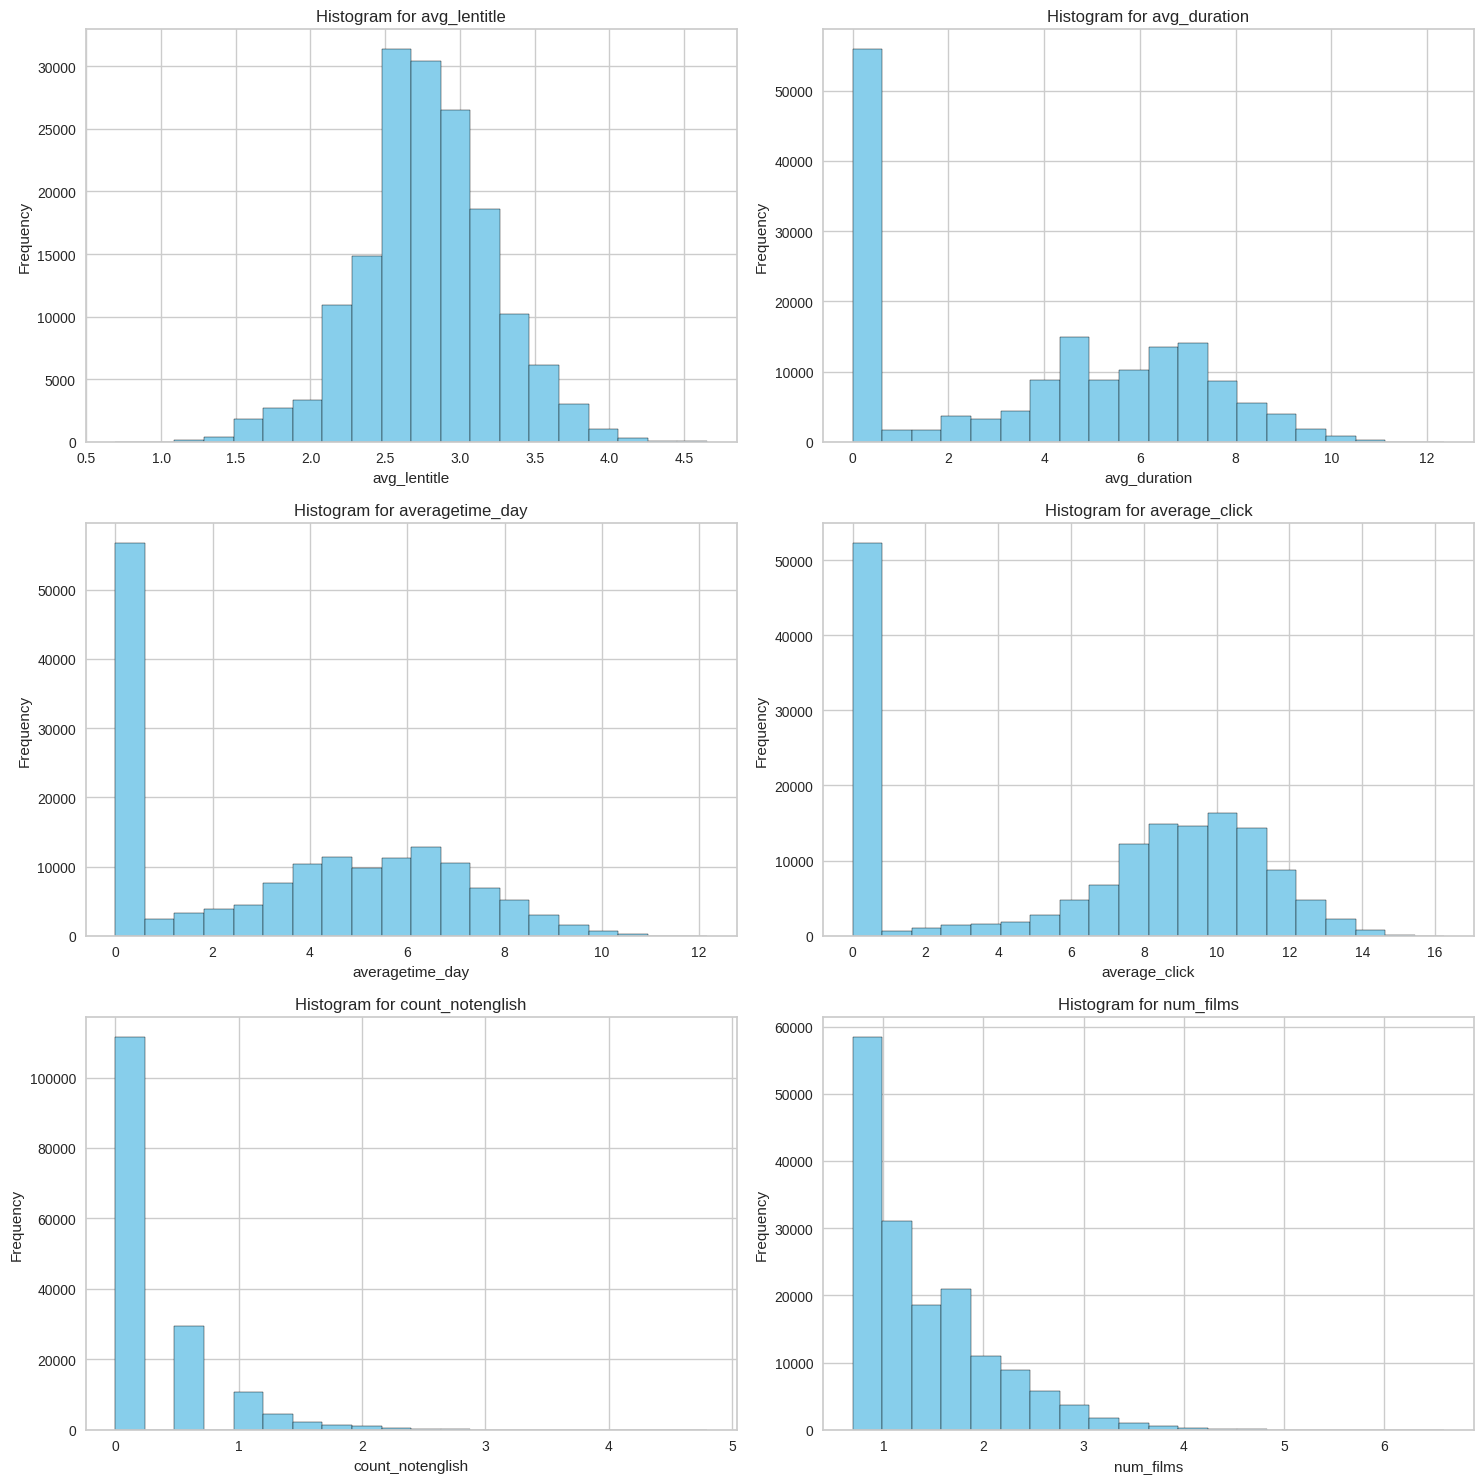

In [ ]:
# Set the number of columns per row
columns_per_row = 2  # Adjust as needed

# Calculate the number of rows needed
num_rows = (len(selected_columns) + columns_per_row - 1) // columns_per_row

# Create subplots with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))

# Iterate over each column and plot in the corresponding subplot
for i, column in enumerate(selected_columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row

    # Check if the column is numerical
    if allvariable2[column].dtype in ['float64', 'int64']:
        axes[row_index, col_index].hist(allvariable2[column], edgecolor='black', color='skyblue', bins=20)
        axes[row_index, col_index].set_title(f'Histogram for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Frequency')
    else:
        # For categorical columns, create a bar plot
        column_count = allvariable2[column].value_counts()
        column_count.plot(kind='bar', edgecolor='black', color='skyblue', ax=axes[row_index, col_index])
        axes[row_index, col_index].set_title(f'Bar Plot for {column}')
        axes[row_index, col_index].set_xlabel(column)
        axes[row_index, col_index].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [34]:
# Imputing data with the median as data as skewed and average will not be that robust
allvariable2['avg_clickgap'].fillna(allvariable2['avg_clickgap'].median(), inplace=True)
allvariable2['gap_time_avg'].fillna(allvariable2['gap_time_avg'].median(), inplace=True)

We check there're no Nan values

In [35]:
# Verifies the presence of NaN
print(allvariable2.isnull().sum())

average_click       0
oldmovie            0
averagetime_day     0
timeofday           0
weekend             0
count_notenglish    0
is_series           0
num_films           0
onefilm             0
avg_lentitle        0
avg_duration        0
genre_diversity     0
avg_clickgap        0
gap_time_avg        0
first_genre         0
dtype: int64


In [36]:
allvariable2

,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,first_genre
0,0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,396.038,9.0,Comedy
1,2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0,Adventure
2,0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0,Romance
3,0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0,Comedy
4,9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0,Animation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,396.038,0.0,Comedy
161914,1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,396.038,10.0,Drama
161915,40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,396.038,2.0,Animation
161916,0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,396.038,6.0,Drama


## Correlation check

Before engaging in the reduction of the data matrix, it is crucial to conduct a preliminary examination of correlations among the variables and appropriately address any issues. Deep scrutiny of correlations helps identify potential challenges such as multicollinearity, which can impact the reliability of matrix reduction results. Careful consideration must be given to excluding variables that exhibit strong correlations with others, as these may introduce redundancy and distort the interpretation of underlying factors.

#### correlation for quantitative variables

In [ ]:
numerical_var = allvariable2[['average_click','averagetime_day', 'count_notenglish', 'num_films',  'avg_lentitle',
       'avg_duration', 'avg_clickgap', 'gap_time_avg','first_genre']]

In [ ]:
# 1. Matrice di Correlazione per Variabili Numeriche
correlation_matrix =numerical_var.corr()

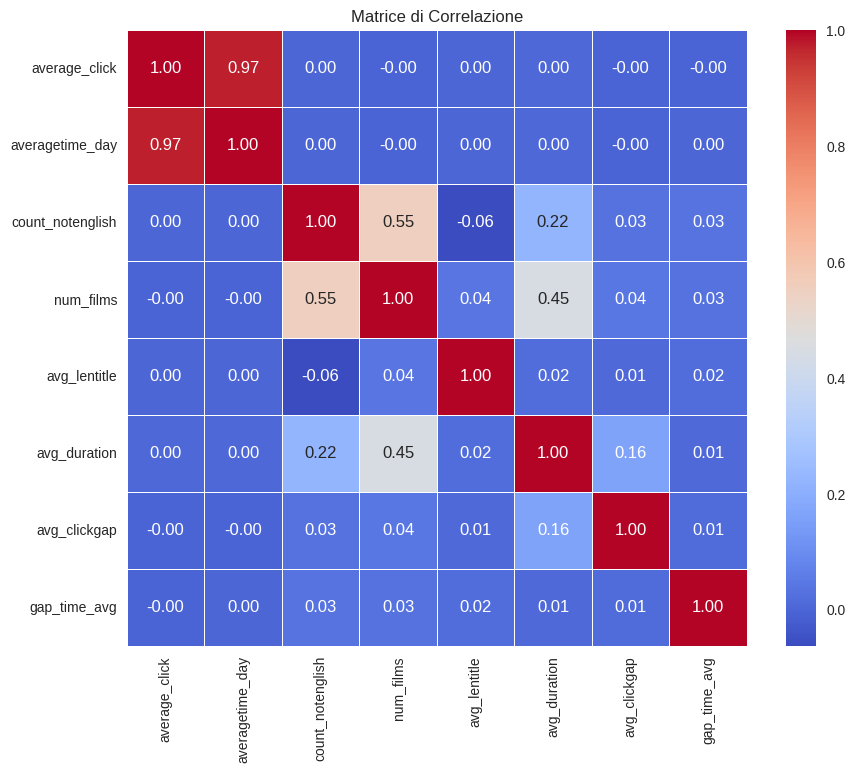

In [ ]:
# Creare un heatmap con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

After examining the correlation matrix, it becomes evident that there is a correlation between the variables `average_click` and `averagetime_day` in the dataset.

Averagetime_day is dropped

In [38]:
allvariable2.drop(['averagetime_day'], axis=1, inplace=True)


#### Association for categorial variables

In [39]:
categorical_var = allvariable2[['oldmovie', 'timeofday', 'weekend','is_series', 'onefilm',
                              'genre_diversity']]

In [40]:
categorical_var.head()

,oldmovie,timeofday,weekend,is_series,onefilm,genre_diversity
0,newmovies,Morning,True,False,False,Not Genre Diverse
1,newmovies,Afternoon,True,True,True,Genre Diverse
2,newmovies,Afternoon,True,True,True,Genre Diverse
3,newmovies,Afternoon,True,True,True,Genre Diverse
4,newmovies,Afternoon,False,True,True,Genre Diverse


In [47]:
multicategorical_columns = categorical_var.select_dtypes(include='object').columns

cramers_v_matrix = pd.DataFrame(index=multicategorical_columns, columns=multicategorical_columns)

# Iterate through combinations of variables and compute Cramér's V
for col1, col2 in combinations(multicategorical_columns, 2):
    contingency_table = pd.crosstab(categorical_var[col1], categorical_var[col2])

    # Compute Cramér's V
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    cramers_v_matrix.loc[col1, col2] = cramers_v
    cramers_v_matrix.loc[col2, col1] = cramers_v

# Display Cramér's V Matrix
print("Cramér's V Association Matrix:")
print(cramers_v_matrix)


NameError: ignored

 By ensuring a judicious exclusion of variables with high intercorrelations, we lay the groundwork for a more robust and accurate application of matrix reduction. This meticulous preprocessing step contributes to the overall validity of the factor analysis and enhances our ability to uncover meaningful patterns in the mixed data.

# **2.2 matrix reduction dimensionality**

## **Normalization**

### 2.2.1 To normalize or not to normalize

This transformation, as shown, contributes to meeting the assumption of normality, a fundamental requirement for following application.


This is why we need to normalize the data. In general there are many more good reason to normalize:
- The mean performs poorly with outliers, which is not ideal as the mean constitutes a core aspect of all studies based on that statistic

- Imagine you have a dataset with features, and one feature has a much larger scale than the others then the mean of that particular feature contributes significantly to the overall mean of the dataset. If this feature is irrelevant or less informative, its inflated contribution to the mean might mislead the model. In regression analysis, the mean of the target variable serves as a fundamental baseline prediction.

- Mean Squared Error (MSE) acts as a pivotal metric, measuring the average squared difference between predicted and actual values. The lower MSE implies superior model performance compared to this basic mean-based prediction.


### Variable-specific comments



In this particular instance, normalization is applied to some features: let's discuss this now.

*  Notably, the units among variables are not omogenous, such as the number of films compared to average_click for instance. This normalization ensures a standardized comparison across diverse features, mitigating the potential bias introduced by varying scales in subsequent analyses.
*   Normalization since we already transformed some variable is maybe less evident. Altough we still consider it important. We're not performing it directly here but inside the library prince.

## **variables identification**

In this study, Factor Analysis of Mixed Data (FAMD) is employed as the chosen analytical approach. The rationale for the selection of FAMD lies in the diverse nature of the dataset, encompassing a mix of numerical and categorical variables. Traditional factor analysis techniques assume that all variables are continuous and follow a normal distribution. However, a combination of quantitative measurements and categorical attributes is present in our dataset. FAMD is particularly well-suited for handling this heterogeneity, allowing hidden patterns and relationships within the data to be unraveled while accommodating both numerical and categorical dimensions. This methodological choice facilitates a comprehensive exploration of the underlying factors contributing to the complexity of the dataset, promoting a more nuanced understanding of the phenomena under investigation.

## 2.2 reduction method selection and application to our dataset

# FAMD

In [37]:
allvariable2.head()

,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,first_genre
0,0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,396.038,9.0,Comedy
1,2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0,Adventure
2,0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0,Romance
3,0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0,Comedy
4,9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0,Animation


In [ ]:
famd = prince.FAMD(
    n_components=3,
    n_iter=6,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"
)
famd = famd.fit(allvariable2)

In [ ]:
famd.total_inertia_

122.49999999999993

# to resume we end u choosing the pca considering the variable as numeric with coherent transformation. We save that information in a dataframe

In [ ]:
reduced_mat2.to_json('/content/drive/MyDrive/ADM4/famc_3.json', orient='records', lines=True)

In [ ]:
file_path="/content/drive/MyDrive/ADM4/famc_3.json"

# Inizializza una lista per contenere i dati JSON
data_list = []

with open(file_path, 'r') as file:
    for line in file:
        # Carica l'oggetto JSON dalla riga corrente
        data = json.loads(line)
        # Aggiungi l'oggetto alla lista
        data_list.append(data)


# Now 'data' is a list of JSON objects
reduced_mat = pd.DataFrame(data_list)

# **3. Bonus: Clustering the users using DBSCAN algorithm**

#### **Approach:** Genre-Based User Clustering
##### The clustering is focused on users, leveraging frequency-encoded genres. Only clicks lasting more than 10 minutes are considered to enhance the robustness of our approach against potential miss-clicks.

In [ ]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"[Drama, History, War]",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"[Drama, Horror, Thriller]",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"[Comedy, Drama]",2000-04-14,584bffaf5f,759ae2eac9


In [ ]:
# Create a DataFrame with the frequency of each genre for each user
df_frequency_clustering = pd.DataFrame(index = unique_users, columns=genres_list).fillna(0)
df_frequency_clustering.drop('NOT AVAILABLE', axis=1, inplace=True)
df_frequency_clustering.head()



,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Documentary,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy
7cbcc791bf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ebf43c36b6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8e1be40e32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cff8ea652a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Iterate over rows in the original DataFrame
for index, row in df.iterrows():
    user_id = row['user_id']
    genres = row['genres']

    # Calculate the frequency for each genre
    for genre in genres:
        # Check if the genre is in the DataFrame columns and if the duration is greater than 10 minutes
        if genre in df_frequency_clustering.columns and row['duration'] > 600:
            df_frequency_clustering.loc[user_id, genre] += 1

In [ ]:
df_frequency_clustering.head()

,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Documentary,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy
7cbcc791bf,0,3,1,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,3,1,1
ebf43c36b6,0,5,1,1,0,0,2,0,0,0,...,0,0,0,1,0,1,0,5,1,0
8e1be40e32,0,4,1,13,0,2,1,0,2,0,...,1,5,0,2,1,3,0,1,1,1
cff8ea652a,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,2,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [ ]:
# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_frequency_clustering)



In [ ]:
# Set epsilon and min_samples parameters
epsilon = 0.8
min_samples = 30

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(scaled_data)

# 'clusters' now contains the cluster assignments for each user
df_frequency_clustering['cluster'] = clusters

In [ ]:
df_frequency_clustering.head()

,Reality-TV,Thriller,Family,Drama,Sport,War,Animation,Mystery,History,Short,...,Romance,Talk-Show,Biography,Western,Comedy,Film-Noir,Action,Adventure,Fantasy,cluster
7cbcc791bf,0,3,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,3,1,1,-1
ebf43c36b6,0,5,1,1,0,0,2,0,0,0,...,0,0,1,0,1,0,5,1,0,-1
8e1be40e32,0,4,1,13,0,2,1,0,2,0,...,5,0,2,1,3,0,1,1,1,-1
cff8ea652a,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
759ae2eac9,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
print('The users were clustered into',len(df_frequency_clustering['cluster'].unique()), 'clusters.')

The users were clustered into 178 clusters.


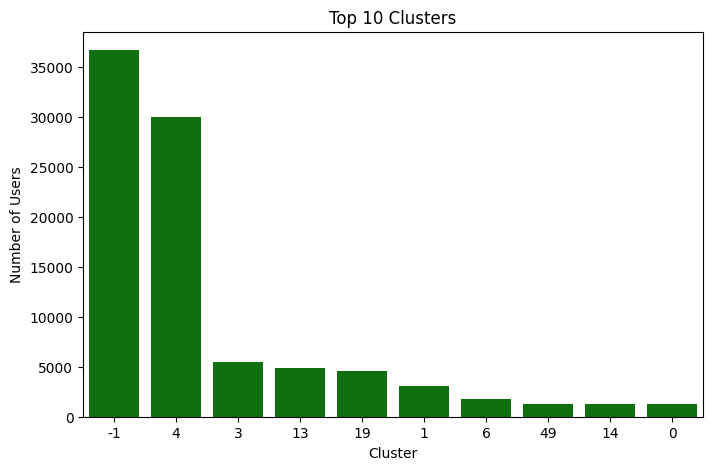

In [ ]:
# plot the top 10 clusters
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=df_frequency_clustering, order=df_frequency_clustering['cluster'].value_counts().iloc[:10].index, color='green')
plt.title('Top 10 Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.show()

##### **Comparison between K-means and DBSCAN**

##### Cluster Shape

- **K-means:** Assumes that clusters are spherical and equally sized. May not perform well on clusters with irregular shapes or varying sizes.
- **DBSCAN:** Can identify clusters with arbitrary shapes and sizes. More flexible in handling clusters of different densities.

##### Number of Clusters

- **K-means:** Requires the user to specify the number of clusters (k) beforehand. Might struggle with datasets where the number of clusters is not known or fixed.
- **DBSCAN:** Automatically determines the number of clusters based on the data's density. Can find clusters of varying sizes and adapt to the data's structure.

##### Parameter Sensitivity

- **K-means:** Sensitive to the initial placement of centroids. May converge to local minima, requiring multiple runs with different initializations.
- **DBSCAN:** Sensitive to parameters such as epsilon (ε) and min_samples.

##### Initialization

- **K-means:** Requires an initial guess for the cluster centroids.
- **DBSCAN:** Requires specifying the parameters epsilon (ε) and min_samples.


# **4. Command Line Question**

1. What is the most-watched Netflix title?
- Our code:  
`awk -F, '$3 != 0 {print $4}' vodclickstream_uk_movies_03.csv | sort | uniq -c| sort -nr| head -n 1`  

`-F,`: tells awk to use a comma as the field separator.   
`$3 != 0`: a condition that checks if the third field is not zero  
`{print $4}`: an action that prints the fourth field if the condition is true.  
`sort`: sorts the lines in ascending order.  
`uniq -c`: removes duplicate lines and prefixes each line with the number of occurrences.  
`sort -nr`: sorts the lines in numerical order in reverse order, which means in descending order.  
`head -n 1`: prints the first line of the output.

The output we get is: `2884 Black Mirror: Bandersnatch`

2. Report the average time between subsequent clicks on Netflix.com.
- Our code:  
`seconds=$(awk -F, '{sum+=$3} END {print sum/NR}' vodclickstream_uk_movies_03.csv)`  
     `echo "The average time between subsequent clicks on Netflix.com in seconds is: $seconds"`
     
`seconds=$`: assigns the output of the `awk` command to the seconds variable.   
`{sum+=$3}`: adds the value in the third column of each line to the sum variable.  
` END {print sum/NR}` : prints the average of the third column after all lines have been processed.  
`NR`: a built-in variable in awk that holds the number of records processed, which is the total number of lines in the file in this case.  
`echo "The average time between subsequent clicks on Netflix.com in seconds is: $seconds"` : prints a string that includes the value of the `seconds` variable.

The output we get is: `The average time between subsequent clicks on Netflix.com in seconds is: 33476`

3. Provide the ID of the user that has spent the most time on Netflix.
- Our code:   
`user=$(awk -F, '{sum[$NF]+=$3} END {max=0; for (i in sum) if (sum[i]>max) {max=sum[i]; max_id=i} print max_id}' vodclickstream_uk_movies_03.csv)`

     `echo "The ID of the user that has spent the most time on Netflix is: $user"`

`user=$`: assigns the output of the `awk` command to the user variable.  
`{sum[$NF]+=$3}`: adds the value in the third column of each line to the sum array using the value in the last field (the user ID) as the index.   
`END {max=0; for (i in sum) if (sum[i]>max) {max=sum[i]; max_id=i} print max_id}`: iterates over the sum array after all lines have been processed, finds the user ID with the highest sum, and prints this user ID.  
`echo "The ID of the user that has spent the most time on Netflix is: $user"`: prints a string that includes the value of the `user` variable.

The output we get is: `The ID of the user that has spent the most time on Netflix is: 322abe045c`

## Screenshot of the output:
"attachments": {
    "Screen%20Shot%202023-12-07%20at%2018.33.19.png": {
     "image/png": "iVBORw0KGgoAAAANSUhEUgAABI0AAAHxCAYAAADgEEwpAAAMamlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAhGQEnoTRHqREkKLICBVsBGSQEKJMSGI2NFFBdcuoljRVRFFV1dAFhWxl0Wx90URFWVd1EVRVN6kgK77yvfO982dP2fO/Kdk5t4ZALT7uBJJLqoDQJ44XxofEcIcn5rGJD0DZGAMdIALsODyZBJWXFw0gDLY/13e3QSIor/mrOD65/h/FT2+QMYDAJkIcQZfxsuDuBkAfCNPIs0HgKjQW03PlyjwPIj1pTBAiNcocJYK71bgDBVuUtokxrMhvgKABpXLlWYBoHUf6pkFvCzIo/UJYlcxXyQGQHsExIE8IZcPsSL2EXl5UxW4AmJ7aC+BGMYDfDK+4cz6G3/GED+XmzWEVXkpRSNUJJPkcmf8n6X535KXKx/0YQsbVSiNjFfkD2t4O2dqlAJTIe4WZ8TEKmoNcZ+Ir6o7AChFKI9MUtmjJjwZG9YPMCB25XNDoyA2gThcnBsTrdZnZIrCORDD1YIWivI5iRAbQrxYIAtLUNtslU6NV/tC6zKlbJZaf44rVfpV+Hooz0liqfnfCAUcNT+mVSRMTIGYArF1gSg5BmItiF1kOQlRapvRRUJ2zKCNVB6viN8a4niBOCJExY8VZErD49X2pXmywXyxrUIRJ0aND+YLEyNV9cFO8bjK+GEu2BWBmJU0yCOQjY8ezIUvCA1T5Y49F4iTEtQ8fZL8kHjVXJwiyY1T2+OWgtwIhd4SYg9ZQYJ6Lp6cDxenih/PlOTHJarixIuyuWPiVPHgK0A0YINQwARy2DLAVJANRK3d9d3wl2okHHCBFGQBAXBWawZnpChHxPCZAIrAHxAJgGxoXohyVAAKoP7zkFb1dAaZytEC5Ywc8BTiPBAFcuFvuXKWeMhbMngCNaJ/eOfCxoPx5sKmGP/3+kHtVw0LaqLVGvmgR6b2oCUxjBhKjCSGEx1wYzwQ98ej4TMYNjfcB/cdzOOrPeEpoY3wmHCD0E64M0VULP0uyrGgHfKHq2uR8W0tcFvI6YmH4AGQHTLjDNwYOOMe0A8LD4KePaGWrY5bURXmd9x/y+Cbf0NtR3Ylo+Rh5GCy/fcztRy1PIdYFLX+tj6qWDOG6s0eGvneP/ub6vNhH/W9JbYYO4SdxU5g57EmrB4wseNYA3YJO6rAQ6vriXJ1DXqLV8aTA3lE//DHVftUVFLmWuPa5fpJNZYvKMxXbDz2VMkMqShLmM9kwa+DgMkR81xGMN1c3dwBUHxrVK+vtwzlNwRhXPiqm98BwOgnAwMDTV910fAlehjuYcqbrzr7mQDQWgE4N5cnlxaodLjiQYBvCW2404yAGbAC9jAfN+AF/EEwCANjQCxIBKlgMqyyEK5zKZgOZoH5oASUgRVgLdgAtoDtYDfYBw6CetAEToAz4CK4Am6Ae3D1dIKXoAe8A/0IgpAQGkJHjBBzxAZxQtwQHyQQCUOikXgkFUlHshAxIkdmIQuQMmQVsgHZhlQjPyNHkBPIeaQNuYM8QrqQN8hHFEOpqD5qitqiI1EflIVGoYnoJDQLnYYWoQvRZWgFWoXuRevQE+hF9Abajr5EezGAaWIMzAJzxnwwNhaLpWGZmBSbg5Vi5VgVVos1wv/5GtaOdWMfcCJOx5m4M1zBkXgSzsOn4XPwpfgGfDdeh5/Cr+GP8B78C4FGMCE4EfwIHMJ4QhZhOqGEUE7YSThMOA33UifhHZFIZBDtiN5wL6YSs4kziUuJm4j7ic3ENmIHsZdEIhmRnEgBpFgSl5RPKiGtJ+0lHSddJXWS+jQ0Ncw13DTCNdI0xBrFGuUaezSOaVzVeKbRT9Yh25D9yLFkPnkGeTl5B7mRfJncSe6n6FLsKAGUREo2ZT6lglJLOU25T3mrqalpqemrOU5TpDlPs0LzgOY5zUeaH6h6VEcqmzqRKqcuo+6iNlPvUN/SaDRbWjAtjZZPW0arpp2kPaT1adG1XLQ4WnytuVqVWnVaV7VeaZO1bbRZ2pO1i7TLtQ9pX9bu1iHr2Oqwdbg6c3QqdY7o3NLp1aXrjtKN1c3TXaq7R/e87nM9kp6tXpgeX2+h3na9k3oddIxuRWfTefQF9B300/ROfaK+nT5HP1u/TH+ffqt+j4GegYdBskGhQaXBUYN2BsawZXAYuYzljIOMm4yPw0yHsYYJhi0ZVjvs6rD3hsMNgw0FhqWG+w1vGH40YhqFGeUYrTSqN3pgjBs7Go8znm682fi0cfdw/eH+w3nDS4cfHH7XBDVxNIk3mWmy3eSSSa+pmWmEqcR0velJ024zhlmwWbbZGrNjZl3mdPNAc5H5GvPj5i+YBkwWM5dZwTzF7LEwsYi0kFtss2i16Le0s0yyLLbcb/nAimLlY5VptcaqxarH2tx6rPUs6xrruzZkGx8boc06m7M2723tbFNsF9nW2z63M7Tj2BXZ1djdt6fZB9lPs6+yv+5AdPBxyHHY5HDFEXX0dBQ6VjpedkKdvJxETpuc2kYQRviOEI+oGnHLmerMci5wrnF+5MJwiXYpdql3eTXSemTayJUjz4784urpmuu6w/XeKL1RY0YVj2oc9cbN0Y3nVul23Z3mHu4+173B/bWHk4fAY7PHbU+651jPRZ4tnp+9vL2kXrVeXd7W3uneG71v+ej7xPks9TnnS/AN8Z3r2+T7wc/LL9/voN+f/s7+Of57/J+PthstGL1jdEeAZQA3YFtAeyAzMD1wa2B7kEUQN6gq6HGwVTA/eGfwM5YDK5u1l/UqxDVEGnI45D3bjz2b3RyKhUaEloa2humFJYVtCHsYbhmeFV4T3hPhGTEzojmSEBkVuTLyFseUw+NUc3rGeI+ZPeZUFDUqIWpD1ONox2hpdONYdOyYsavH3o+xiRHH1MeCWE7s6tgHcXZx0+J+HUccFzeuctzT+FHxs+LPJtATpiTsSXiXGJK4PPFekn2SPKklWTt5YnJ18vuU0JRVKe3jR46fPf5iqnGqKLUhjZSWnLYzrXdC2IS1Ezonek4smXhzkt2kwknnJxtPzp18dIr2FO6UQ+mE9JT0PemfuLHcKm5vBidjY0YPj81bx3vJD+av4XcJAgSrBM8yAzJXZT7PCshandUlDBKWC7tFbNEG0evsyOwt2e9zYnN25QzkpuTuz9PIS887ItYT54hPTTWbWji1TeIkKZG0T/ObtnZajzRKulOGyCbJGvL14aH+ktxe/oP8UUFgQWVB3/Tk6YcKdQvFhZdmOM5YMuNZUXjRTzPxmbyZLbMsZs2f9Wg2a/a2OcicjDktc63mLpzbOS9i3u75lPk5838rdi1eVfzXgpQFjQtNF85b2PFDxA81JVol0pJbi/wXbVmMLxYtbl3ivmT9ki+l/NILZa5l5WWflvKWXvhx1I8VPw4sy1zWutxr+eYVxBXiFTdXBq3cvUp3VdGqjtVjV9etYa4pXfPX2ilrz5d7lG9ZR1knX9deEV3RsN56/Yr1nzYIN9yoDKncv9Fk45KN7zfxN13dHLy5dovplrItH7eKtt7eFrGtrsq2qnw7cXvB9qc7knec/cnnp+qdxjvLdn7eJd7Vvjt+96lq7+rqPSZ7ltegNfKarr0T917ZF7qvoda5dtt+xv6yA+CA/MCLn9N/vnkw6mDLIZ9Dtb/Y/LLxMP1waR1SN6Oup15Y396Q2tB2ZMyRlkb/xsO/uvy6q8miqfKowdHlxyjHFh4bOF50vLdZ0tx9IutER8uUlnsnx5+8fmrcqdbTUafPnQk/c/Is6+zxcwHnms77nT9ywedC/UWvi3WXPC8d/s3zt8OtXq11l70vN1zxvdLYNrrt2NWgqyeuhV47c51z/eKNmBttN5Nu3r418Vb7bf7t53dy77y+W3C3/968+4T7pQ90HpQ/NHlY9bvD7/vbvdqPPgp9dOlxwuN7HbyOl09kTz51LnxKe1r+zPxZ9XO3501d4V1XXkx40flS8rK/u+QP3T82vrJ/9cufwX9e6hnf0/la+nrgzdK3Rm93/eXxV0tvXO/Dd3nv+t+X9hn17f7g8+Hsx5SPz/qnfyJ9qvjs8LnxS9SX+wN5AwMSrpSrPApgsKGZmQC82QXPCakA0OG9jTJBdRdUCqK6vyoR+E9YdV9UihcAtbBTHOPZzQAcgM0OYhpsiiN8YjBA3d2Hmlpkme5uKi4qvAkR+gYG3poCQGoE4LN0YKB/08DA5x0w2DsANE9T3UEVQoR3hq1KjquMwnngO1HdT7/J8fseKCLwAN/3/wKoq4/O0r1SZQAAAJZlWElmTU0AKgAAAAgABQESAAMAAAABAAEAAAEaAAUAAAABAAAASgEbAAUAAAABAAAAUgEoAAMAAAABAAIAAIdpAAQAAAABAAAAWgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAISgAgAEAAAAAQAABI2gAwAEAAAAAQAAAfEAAAAAQVNDSUkAAABTY3JlZW5zaG9025a75gAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAt1pVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iCiAgICAgICAgICAgIHhtbG5zOnRpZmY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vdGlmZi8xLjAvIj4KICAgICAgICAgPGV4aWY6VXNlckNvbW1lbnQ+U2NyZWVuc2hvdDwvZXhpZjpVc2VyQ29tbWVudD4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjI4ODA8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+MTgwMDwvZXhpZjpQaXhlbFlEaW1lbnNpb24+CiAgICAgICAgIDx0aWZmOlJlc29sdXRpb25Vbml0PjI8L3RpZmY6UmVzb2x1dGlvblVuaXQ+CiAgICAgICAgIDx0aWZmOlhSZXNvbHV0aW9uPjE0NC8xPC90aWZmOlhSZXNvbHV0aW9uPgogICAgICAgICA8dGlmZjpZUmVzb2x1dGlvbj4xNDQvMTwvdGlmZjpZUmVzb2x1dGlvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CovGAWkAAEAASURBVHgB7H0HoF5Flf+8nuSlkEZNSENqAqgogg2RALsqoIu6u/Ytdhd1RdFdFZVVVwX/7qJgW8G+6C4SUBCVIsWyFnoIEFpCTa+vv/f//c7Muffc+33f6y8v5Uzyvpk5c+acM787d+69587MrWtomtKHEDTU1dUF5hkzaFpiEirowlXBT+rQAm2IOov1qtFze/M6Zb6yLK2jMcvLPNSs5RqTNhBvNTms52HXQUCPoca9VUzXfmD7hmUjvd4SaqTJp3qsrGo0y1utXGlU1Sf/6kx/7cP5WpfOb6tJrEznuhqp577mbVy7TKXmdghF9FICbcpbK5TMJpTUwRIz3ki5GY90vCG9GDBGCSHXq+U6Zsm5LMX4UTOVKcXkpY5KKSXGfrLl9lWyqvQaRlRWGEMKbRmKHWp7MqnP5omdikOiLiFREM/zaIBzQupRTpItEYRoPqkW+WWalpVjyhwsb0XdREjtYO/ogTxpBWmwT3ufVuU5Rr5ewpDwLfOwlnQ3ChLbkgJErBvNTTQKRr8MvSwUoajDMqQZUhQzw/8VkRQ3SvKGZokqNW0emoB+uCk7v5fp7e0N++27b1iyeHGob6gL99y9PKxavRrDT+QrCrL2qI3KYY6BknbhWFqHgy/jYD/tUD6yZOMrOo+gkTqP0Mlg80PoWHqNsbZEvXLCUPIQA2vbY1lZnefdxMaG8MwF+4cTjjkszJw2Oax4aFW4+Y6V4aE1m0Jbd3eSIJYYAWW5trzcRyyv5TPiaiQ5lnAcacB18uAFC8Mzn/3scPufbwv3P/Rg6OzpRK2hyauhph9yuS39sI5WEZtkIZM2ajtZEAuVTboYB88afa2vT+/l6sESx2CVEeFDL5BmEu0YVBvHXN5DVQ0oY5GM/InPcoosEshXOk5RjyhNok1a6oCMON67RanZ5SxWpuDExCTSamdWHosLZSBlgXUyu0za6I+ARP0RJFTJ5Kc6wo90pp8E/gH3rKzKOZzpJ5MGTae6PHS8R6RSOUgxKYLlmGs98qOugCSVYoHQ8roiva8BvL2AJR4XtiI2ikcJusiEMhEvfSfaFNVRR6wh1YQfNFxfqJ//eMYySG8CTcYzuc8li9qmcpKs1BbmaHLUD1vERkpDiRTEelFH1EZ8og7yqVxJSd+VPkQ7YmmUResK7WDdFKiHZRpbOtPlespHu41+5vT+nuQ8JEvKcpQhk5e3RYpA57/q+sHBehJUfqL19Zgy5UlymCU7gxSlDGzrq0M/ERxYlGQKY0xHzNFjoDdiSa5esTHnVj0iPKpJpKg4p5cMAS+kSDHuK9EPp7ZOCTNnzhBD169fHzZv3YImFy0TBfyhAVUDe07q98RL+awZqKenWjURjdWIo0/LIYyyNa/xYDRq68jLFtq6WqY0LVe55bzSy7HWJ92mS4hm1WrRbd2MuUqCfAy15MRS/x0NBMoYK/aUrWUa96ePgz6D8lo5pA/22JOXgXLKMkDlWYsLCU/vYiAvqDJQkS8v7eOFpxzMRU+LdKApD741LyKoaMv05p7KVaPYiQE2K5M0NYKDA68NiS8j2UZkxJjI9BqeqFM1J75Uj1TaEIPGKVslynmrFA6SNLCWQQqybIRstAVL/4BQkVs6Jla3pjOWkiHlK4rKK/e/jC8TFCWX+SryZCvpJEn4BgeM9EeIyExIIq0l6RRjSSFQs/AlEwoyyInCCutSpQIv73URVJ6cBkZm1mxDizVSJUQZD9MkJ14kxzio1f2pUWMsquQfiK4yy/WUXo5VnqVXq2v5bBrYAfym5uYwfcaM0NDQEJpbWkiEQIxhADUbZ6yKXSxdbSxjuzI60tVQs83MeBOxUN8yMg3ciLJiV67LvJZp1TKP0iWmfdbeQuHYZXpwjVy9Zn24/re3habGOtyMd4WnN28NXaAPhNfYWaWSYz/mQ8O9D64M9z/8EB4giJPehyjfWMXF82hgLdIjqrBZORbVanQrQ8vjuVoQLGz4kSLGSMgAWYU3G4UpwZajHuXYwHzmrE/llK2MLGeWDmehI6N6GVtesOVBZSR+zZLBDvRSQQuNfuVR/aKLdRMvY7VDbRVZ5GFCZSofSJTFoLJjjgT8sZB/vJChv4mMRJJilDGuql+ZUc4gWakUM2InktX0k6YyyUdHSx8dKKDzR8pZN1WWdqOcpwRNFT7Emf2kYawSPhbCiUDHkchSGXo+JSEig2V0NKZxTOWKAwgZ6icNcmMS56XSciPAAFZpj7BKPms3+UuBIi01ygQ1yYjKqD+RlM7YyKMcBolVfyTlCpRfZWi5jbVNyoN8xDIJVzoVWcOtDOVRmvINqB+MirfIYB5/qoux0JFgLGVayGNJRdp3VDlY0af4dCXlFMeqPAfEHtaRO8hYXYAmK/nJiL6D8SG7lol+FpEWOyAlFAPrMlAZ+l9g/4t6YpzKGCHIlRq26P1kPdqwbfv20N7eJqdqbw/to6y8dqw50C9rReviL/nVjnJdpWscy8VplDU+1bF5TWusYjUvGCcjWKZ05ZNWmfJIV3PVGMZKU3ALZ38Sp/zk0XQqKuRZrnJYrrKVt1ascrW8nFf6QPFg66mNg7VvIL1e3j8CirPiTm6lady/hJxfZVSrN9jjr7qsjCg3zWsAQ1lP5I1DmgwtKkRiHRLKtVhotRQqIaMWV6unZVpf81FGHHpVnpZlAzIKtJ7yaD4Ne0quGue8sVjzGmsl5tV2pUlclVjg2AGZ4RhRbpG2eDiy2ETWVxmaVlkal6FQ/jKd/NXKqtGr8ZXlDSU/eHnVOdEzcSWOF9x4FsUbhWSDhSIJkAdZFMdaylA89yiPj5iqU7koVdN6bYw8oMaLZ2KolCcVlQdytL7IlBsUtCXFpA0nGPHDqF6ttf2JGSq/laV1laaoal7jIp9ixnjz5s3hnnuWy5vBDRs2Jvwjhlo7xkUZgy8rcu6InLQPfYBoqIOGNEGHfcPQ2d+0ZcprbVSsePNbC13tb1I/ycvqWWEpLfrAN5hAnZks2JCdHzWtsVKlpZaANGQU5GhxzkudPbgBX7ulLbS1t+P5oi50dveG7V3doVsepMEr7OS0gcRawZRV1V+rHunUg/p0CslxjLLkiEBWVw8fdhjwOxhch60fdhTkJ7vUPrGh+EO7yihF/Hkvz6AyipzFXBplM7ujxJwn1yAsFFuwUwi5LjDFBzmSUBf/5SxgHeT1PLAP+/qgJvJ5rYjVKBgh5uUQSf+gPZjpkQxkHWqIiqIO2idk+WE5OWJG9UsblEmEgQn5eNwpT4MQY5uVn/qSyig2ZVIbM3yEX+WkOBpclGf0ixHijdHK1E99+NO6FfopG3zKwzg2JillRBqCyKBsPopSNonJgUMRIEQ17BexmA/3uSMFRBTwGIsjVeogjX9RLQmsiaNOJzCEafOkHwg/i+lYUL1SO2pDeQz52Ck2qiMjK2Z9MEdjUxXoZT7pL5RpPZVPHq2rtCyvhFRJZCZ90Ziog2xah6xstvCmjC0jiUFpBf1Jn5ZJTGEpMF9oP/PJfq1DVtHPcSxlynJIVn6tb2nKL+ZY/WAS2WROQfOsI7JAV5mMWUF1SZVUQY+5zCpCgeiSn5yfAwDZGSSJ/pE5jFOVgkFJttJkNjPrRrmxJydhUSEyRkGWJo8G6ET1blyr+I/B9EhlGlocxaAOElnailCixrGsjsvTLNuOS1OtBYqaLdjMq2l60SFNQzrBJav1mCnLJI31LT9p5FNe5hnIU+atxifM/fyonH5YpGiwfAPJ2RXLFXs9xmPdBj2OVh/T1foWbbF8Zdus7Zou85TzKq8/fvKwXGPKqFbPlpMnDyIdg6TejMj1nTILA2bOrymRqPUQi5xskANKMvBGbsrObu5BUl0qi7Etj/TKdpTl2PrlNM8U2iR2lQv3tHw8qGg1MNU7oAExqIWcHhcI0LtllZXJLtXVN3/Kp7HUB68RqUWjEbNP2b6W9THCgH/l8gqdYhp+GKMP1xs7C3W1Cezz7OuUn2h47yg0yhZ4zHmhvLEMfPhfEShPGEx9ofH2GKFanQohOwuBxhoQ+zWLvLZxPKOrhfJ4TPm2nq1jy2za8uRpHnPtPzxs2cOktGEwOnJZMWV12nSZr1re8tt0mbf/Mr1xjDeSsQ22L9s0Gpz6HrkhFzf+UoMPU0hJOvV5atVAGRrUGilnv9UypCk/CzZv08qQ0VCHaQZTPRLwm/FllDxhy9QwLS2UqW1WQaKpbmWhSmsIHyqydpXqZzpTG4SPRBGS2qNlJJr6ZfukmOWZUFJM+0t08gkpyczkkch6+JMi/EgZiYmXyYw/pUnL7C/z6T2xoVfRX1efHtwpa5D6s/6b2ZhVFGvlfIVd1Jwfl5himTgLjN2cAZEQyJqrl7UoGb/ZAy/HXOZpMEPUwlhnhsRrYk4XNtoqAXQIjy/4ovTY8FRcM7LyVBaZB0Mnn63TXz2WVQuD0WN1WH7KQ14ufomHxfLspHzM9xdSfTlunHVBiXT0kM4Mf+z1IcqVpWPgIeKxR5DOKuDH/zgW2XqUQwb23ygjMUq+WI+MDKwT7zNYQ8e3JIkMIkkS6Se3R2vHAlunkhJtjzVUmtI0n1udU8optrd8zSzzjH4+xx+t5HGUc6KyxZWatY2sh9LsHhNplaNxOhaRMdWTOiWp1WhZf0z1TBU57qKOxzkuJxMdKifTz6MT7YxL0OLRYvcki3ap2G+ViBj/s6B8StAyxiIk8YNPiyK2tgKF7Awh2rEDnUaCUmq5gsCYnV7LlG5P/FonhOUpA0o5Kqtc1l/eyqymV8urlVm55BuIx/LvbGlip114rGzT4zOWelSHbUO1tlXjs3WYVju1vo3LvNXytn718rjeXvuN8pPX2kc6/8y0WbIg8AIntdJNjaRBY22RYG+opEb8kXqmTFvGUrFGBrf8LM2qpjp6Yc3og0zEmz7bttoVd/UzqnbLtP1ytCIbL6R6p1tREUdEWbP18RVMlQS9ycsOruqtZM0owgJl9sLOwlpOIzVMdAxCfqZoCAn2xdS/y7W0H6pjQMvjeYHLf8JN4OV5IUsQwKV4pgqaFT7Q+GjNvYqy/sp6PKPYRP5pgALlFZIqZAb6pL4UxLrUL7YlGapXWMbkh4pGUwtHB70m9mewgqQxeWvZoTZaXis7YW9JWXowZarXyi/XK+czBUiMRZmVz/TIdMT+TjGpf0k/hMzkJNLzw/KpBaTxjbvcCIMY86yb8KIsTWslpYkeqaQleYyy6FRg22oEKyfTEe3JdCqPiKBNkCc0jouUXcU+8rJIZDJRDLFlvHbasnjdFEqmEzkSpEKsJZK0XPSz3JSpKuUp6dDiXA5SosPIsHXHRT9sEXNwrvejnyzSt2q0n/uHZX0PAqOo2E6m4+wqqMLAG8dekSiAsD/GI0JGBBQVdYEg42kysWwDMMxmp0Bz1BpFiSy50xErVLwIoh0MoluPrxDEAHNpJGNePwFGzhRiayt5tE61+lpGEcMpV920NYkojNdWpk0PoE/2BAKPmIef7D6kbK/qZ6wGWB4u0bFOIz0uvK7wbLTXFj3+dExSZxKJKI5jsYcko0BlUJ1MogLrxCMp0qmh0KdYnEK5TKrK8Y99U/nKsfBlMmKCtNjqaI/mldeWVZMXy8slmo8yNbej4mg7j5O2hnZUs6U/6xWBeLwrbbcyyav8lZyVFPYrtS+WcoY5Og+kkI4gpiebJR3JVX/L5RxfCuMBamlTWZTEU0kk49fMToqnjBVq0lKZeQ25NCtZS3d0PEp7GtlGaRNIY1AwLAixpIByYdBOB1XZJKY8lVkoGINMNf1joMZF7gAEtN9p/2Fe++RQ1Fs5rEd5ShuMHMvbX93+yqKeOF6RDxZIU3iJ05D0pJumWj1ZuMCT3cSltLWSEkUuB9okT7VovSwvzJV8Wh6LjZ2Uh7+yPstv09XaMTBSVsLums6PfP8tJN7KS9SRVvCFrJn+pfRfmuSKbAiVN3z91xhqaXYTr00ZSAD7NcyS20PGUi+vTDovPfoAwhbwT/n4oNEnziVSU2DfjWcGYqQpzhQLV7qhyDhTPp6wwpHYUFnk5bShpWg8bq6r6R+M3Gq21zRAlWir0k19JkPLQWB7a+rXCuSDMqmmMqlc0yqPNOrSPCsxpHw1XUKLPOTKazMX62dvGVVsZozyZAWpTo38APpVH62JQRuNWJOFNg9ev4zL2IRVHohVPGPalAln2gaO09Lppd/zMGXLO8SOqD+biUUG00aeK+Soenz1mIv+xJPS2TVDZSmPkSWaS/pEj+AkWlPbKJsVS4HtYlDZIjCSIh6pTHUwm2yO4tJNPurH50xQ8V/HB5EhcOInVlDhMa5oPxVYFhEWsVMbWaz1NM0ykY8fxpKXRJKn5axggspR2alKzgGCylIeFmo9TQuPZFCGs4djufBAr7RncPrJKucZ6tZBBq/4xFLGcbWDaiSkY6fNRBzvENRmMonyPEK2Xo55urcQPUiLYx/sIgPslIm6EqXfaBfppCa5zDJk2MQaIj0mYzn5C/lEzmSV5ElxmWbzNk3moeb70w9ZBVuZUYLGaSzXB2oxIR0PFc24Ljp5xDx58i3bSXmgycmjMqUiaJRHW5SeZLG4IvDIc/aR8lJPtFWdRLZK7CciHVyxj2XjV6ra0FAfmpuaQ0dnZ+wfia4IMJsFU5bR7TmSMRYTGa8AxDKVHtM2l/OW+ZiPocijVBtbiZa+I9K0jvr1T4+V5mlDf8eY5Wq/xqRpGLj1yjmoODunE7eIT3prqNIWyuEEK7uAiCnLUgOkj6CWlFO2jjlIYkyK4xCo+BhHPsbEytGRBDJlyL06erLaSHmgU6K6SnITMiujIPmtRjPFQ0xKs0Q5zBjd5Wm1DFU6Yx2IlEbrmeafBvJoB1R+limf0sijaZbXCrX4VJ6tNxh5ln93T6eeUjg+Y9HmWrhrv9CYutUmjbVM8+Qp07Q/sawctJ7G5XLmVR7T/fGxvBjkJlvOuiK9Wk55hR0qqdU6bOTmtVwR5oh1+MksU335yCKDEct5Wyz8WZywTwOTio+8Mad2aZnYAYaoL/5qWa046oyl/dUgX7mcR480pZfzlFqtHuk7LsA6uVmixv76m7Uo1SmQ+quLY6VA6s28rdtvGhXlbYtFst8KsTBdwDK9g6hiWeQmz/RDW9ZfWqDUfpweAoSW2h9vHo2EpIMbxXJWgwQ2lc3Gj1RL8th/ZckliHo2xIciI6+U1HPPno8ZC3VSC/UNGJJRlo+2a1stXdIqVFpQUZoRWKysGdEmynoNs+gnZtr3tMzWKeu3ZUiLfq1XzRhbX/mSfZnji3T+Wd7EkzWONtLWkg5pA3kt3eqxMi2dVVAm+Gtd5bW2lOoU9FgZZRuYZ0iyRTRkxTvCVASi0Z9pAo0PtzFkVMnGPk058Wayj1/wIS4iN+piDbltTdhkEkQuSyI/62bLizgjCfzZ+cW6DGIfJChWcswyiYZu+JWXx07akfgZZWUmLWaTV2WwDH/8Ef1lXpaloPKyupSDMlFpZJKdNClLCeUTGcBEZCSdVp60w9DFplRZ6ia5oiPppAqtxyRDTf0o4jIvGe+oB7wUz2DlUK/oUwbNg0/MY+9gOsmooT8fy8if9ksqOBTZ/ygIfYwqqI59RY8FVYim1AdFD/lRA7zcfH7ixAloT2/YunUrqoqw/FDGRqXfWI+FbL+q0GayJtVryPNIsY4W9BMrl5wTNfmohRxRYv+8tIkIWMtqCh5kQdQ/SOaRsYkjB/rUGQRpch2TpnOMLQXDF0tQVzoFj0E6ArLJNEoreEuylI9kmoB/sS9FOUQhD3Q4spRldCYhTupk6VDGGMfAeH2PRPafenz8YOrkyWHaXtPCE08+GTo6OtFlIBGF8tEZGiB/Wod0pqkECYmKFjGXSskoIcqLfCwb/0BbiKxeQ6xFscxSYpqWl623vEz3gENpkVdHgGJdHitaoMcuRzmvRZ4e8ETeaEPiExX4EfNzm6JMFmpQ+ZEWbcnLNMW4si6IHPITk0hgJhFinytKlKbHgRGMqMFKko/6k6g8kvI8m6WUPRqVjANRZWu5VNBMgVlKxKfPMTPtnyTVlY3ikkKVkOlngoXKkArkEpC6TLwPAAN5IGCUnEZJmijUtI2TJYKsmh1P7lhCXv5pqDJYZeVan7xWhtatFg+Wr1rdPZ2meNvjM9qYUIfqqSbb9g/Lx7S1y5aV5aQzoEyWvNbTuCpTFSJ1D7VOUYzUzi5eUZY+nBY5Y05v1iyPvinlQGOt0YuiylFr4yBAKoZDIaYBkZl4pZQqVpa9GKq8HRmr7f3pHAxPf/VHp4yo0ZIhBLnpSmjrA1+F90GPDfhUfOY0qtZyS7PpIdhVYK0mQ2ka2wqWZtOWJ0+X+ypL4hsXJtivIQOYxE/ao5smkTGKv+zFhK2lZWLo7GyXBxSpx37OMyOdZ5Qt5xGrUW7p/Msv2OmYCFvkkzKeI3LisIA8WiaMIq+Sj6xJnp5n1K8qCmlmWKaFiKUcP1ndxDMk/byuWhnUQUUIIj8mY9tQkOlnORjIW9Cf5LFaetBkUk3KYiGSnpRlshIvywv6SUBQ25jWconxUz4/KJtyGcROEwuR+eHqT7JryaX8MdQvs4DoECrplz5M3Wg3z5XUOkCF3i44ofejLOMjbwrkIYaxDLkafMJu26YCCrEaViCaTG6ZIZaSylMiMyvi07GtUtw/qR+5FRUFtApqhntlyahS7HGKXTm1Wdo/ElU8znn94rHmsY/9IHdO5rySEv3xnjxf4sGSXG4uk32OXTL2u/nz54WjjzoydHV1hut+dUPY3r491CeHfuSpdq9f1F/jqBgmcKT2yThvSsrJeD2AfVqhzDCMPGWOprxhmDAGVQCoOJRKoiscQeSTDoJjwCNF5w4f/rtLFZlFfxEqEaODMi500b4iMTmEiUtkycP+EftUdO5QgF53qI8BckGiQzLyKzXGwoUToAGzO5rrm0J7D2YaYUNhBqqiH1NUyo+QzQ/5ot2xhilKSVarVVbJXaZozarKy8zDyEe52u+LAqrp1NZYuzSdvjgnaNFpxKAyiL3WtVrYF+LZwTjyq7y8fqyp/SOWK1c8prG2Ss51qU7GfMaLLWW51ihKzS1WWYWYYhhUecxllqfsjonUFuLKQZV52qUxrUg83JhbZyoJjZ06FUpT0jBLHusQogiy6fVB30+RhyF7L5R0itTRm2kkpkVN2pKoFr+2lcmaxDm4KHaGCFhCyVaMV9icogiQImDDtv5uMsnHOirHpllmgy2z6Vo8lr5bpBV/e7wH2zCty5jHVAPzWqa0cizdFUTGmiaPtaM/OVpvOP2PesoBAyHUVf3MPVilNWDILoiJxjwrslzSSSxvGJmXlqVyEAqtI6veWGpdqZdkkF9DVb6yfGWuEStitni00LMyB0oLJgMx7bLl7ETJeLnpSulqN2xSBGbpXFklUDWd6taKasqsVWHH0cUZhH7PwL7NVAYHz41YFMsSnzCnn7hxaR3ebDeGvWfvE9asWxc629oiVirXVBAdVeTY88qwV03SJDnlkm1VmUaFqAoGeZwznWJhlksdx+TL8gajhyOA1mNs8ypa5TBPnrIdyqdyWG55tL4tr5WmLC1TuVpfy6xsy5PqMZK+oHK0vs3XSkcdtka8YVU9IhwZra/0sk0xH+Xk0qQ2bUtjdwEn3NkJJ+7sIl86FkYVryDidCKHoasGsYYZEaC2xbgKCQXKTB4rxQgv8CifLVca4+GG6tYVpQ2Gp1hjaDmLxdBqVnCnYyz9UAaVCo4qhMHq13O0dAwynSgXqErl1Ehb5NywxzrRWS5lhk/kMB//pk6dEvbZex88mPeGhx59NPTgq3T6QJLplDpGvsqAiChIEukn8RV4UJRVZwFDRohZ/wWU7AeKC3CSp8wETNV7A+W14Cm+SlMePo2yjDr4p04j+2lxrcOY9VRWkqH9XrJaTp5UHjuMqcsyfY5oAJeMdoYfSdBibZVBCmmRmxy5/JjLf8u6LW9eFi1lXluV64ptjByVelhH5dg6IsqUMR/l5zK0nuXVdFkWW5ueoZVF4rJMEnnslK6xMKcyylaHntWjvKQpPfIynzsAKZ280aZYi+mGxMM6pOof87RJQyyPx9DaquWMVYbSkGffJJlBukySAxFC5g2o6CSDTTMfS4SvUBYpeb3ImyvS/OjF1jKipkEcQcjyFIq9G6XIy30x6ek0yWYiiVMJ5SICxyedezo2Kz/lk0fvv5kZYKaRHhRK5kHUWDsgaQyiOSYLfIlko0w7JWp9ZVAdKl/12Zi8yqf1y/pVnvJqOyx9LNJq51jI3pEyq7WDNMWZuCv2g7VL65Kf6dSLCwNCNVl6rFmmOjW2/Gqflll9lq+/8v7KKmVQg16SbCnTql0k4kTjSWl7Yayb11KnESmsEx8HKs8QcQZBlrVU0/HsRmUI169/aJm1R9PUFUcNcoHKgUNGiJiXU9XSOGAwz5DxpbQQ8ZNEiSzSyMdQklOgSabEI42INHmLrvXJq2lrC+kMY6A/a2u1tlCn0mvpF8jwo5hJnJiztM2zAntLtcAyI4ssmQxizfJqgXUgs1ZxtSo7kBbNgv3ShCwXLUD7SIk3CmCQYvyw3SaQi2+lWrAkoqO7S5ZERGYRGquJgiiLhMy5yrrs8Ly5oPySbKMmS0apWXaUEiqVMYMYE5OSTsmKSPm1gPXKocxTLte81am0anGZT22vxrsjaMPVP9x6eZviuBz7lR3Lc47BpbQ/CjfGN0E49UW9sbOSot4iny3Ph8risRpE98Ywi3NiMIzxpLVqS+lq+JJWKxRtrcU1ML0/OSxj6M+OyLGjfwl5fBmlNg5kQXxAsMer2FdwN5EcBHrJLEqMGOTLdNCfsvt02CB9ALEkI69apuhFucxpSUS2rr4hNDTGz6l3Y0yWpcMiJ3LGtnLcNnK1HKTsxUHR4OwWQMnRXKNfzRCx+JETIZkntFKaglhHRZR5tKzMx7zyZpVBq6ofjHqNIYOVWZarMpVH4zIf88pbTT9pLJcDxETK8/7byKyzS8XIjr8YlEljUjWdcwmN4hF4Ddb+F8dCY2JkSIcD9e34YsUmWflxo91JX9Y3RZ0RzkrKE8ukfzGJ9me2JNkZJJG12KxMPwpVbDUai0GPWpWR+pJQqUMGELRYaIlH02RnnVo8WlbmYz6ToZVBq6I/nmvRXhFDk7K6yUTcI0ZceE6SZseWeE8qMxKNqigjCopmGidEOmY6Nsm4ojpFdpyxJE6j7BjRMNVPG2N/0mtRLis2UulskwZpA0Aol2X3kMo4QJzrKmI1QDUplkOubR1MhSHxqGDEOAAy0ygdK5mZJcopkOWIIlQxkT0HxKNFrhjy+wjdE076jBYnlRjNrcREVaZCbMu0DjsRH/6tcuXTmMXRYprUOmliWLzkiLBk8eJw0EGLwtw5c8Ls2bPC859/vBxgHuSenp7SFFbAkH15gR0Snk6IbMA61Z4eerSjLh5gnfoKosgjTeWxjPleTPWmPNYjrbsbbz+gV/+UnzK007h+HQgcf+9/fv75+OPjr19//Prr9x9+/+X3n37/rc8K/vyRv+zi85Q/f/nzpz5P+/P36Pkfbr7ld2Ht2nXh0UdXh5UPPhzuuufecNed94a29g54WfB8BseQvgRVXytfGkdPDHw2dByVgvg/0lpNdRaJf5aV9A/VMNNoGrJRVJRhnD1CYBlpysO0zhJRXuYrjRDPDkomTGwJp56yNLzm1WeGU05dGiZMmBgdNSI1qYeVdObsVEGbvFMZNbAxu6jZAzfMORwBR8ARcAQcAUfAEXAEHAFHwBEYFwTG+ylLn73HpfHDUrrrWZyauRMazs3fOWuzEV8EZE+sx4zOjo6OcO2114Uf/XhZuOba60N7W5c4h+SDL2wK6zCCq6YPy/Hg0hUaX4DTxSMeHGY4oQbOIzqMUlHB/WOcRkRGWTQGSWiMrWOI5fxTR5EtIy8ClLdMaA5vftPrw3vf+09hzgEHhB44hdTzrF9RiMz+O3QEeLw8OAKOgCPgCDgCjoAj4Ag4Ao6AI+AIjD0CfP4dz+DPf6OP/ngf0+G3iCuhdKVUU2NDePKpp8Pnv3Bh+O73/ye0t0fnUXITCR99Q9KD8EOfDJe3RacR/UhpVZGUJbrpbmlPI7ITMJbUisVHlVpFHv5VcRrRAPw77nnPCV+56D/DQYsOwpdssFs92Gmch9FCwBzF0RLpchwBR8ARcAQcAUfAEXAEHAFHwBFwBKogMN7Psv78V+WgjIA03sdzBKaXqtLp04AZSE1NTeG++x8I73nPh8Lv/+/2uGSNS9TED0MXEr04Mt9IXD/c0y5bykY4wCAzkshoultDfUPLuSAhRBExXf5lmXUaqRSlJYkwhlOfznrPO8O3/usbYdq0aXAYYUPS3ed4lIEZx3zCfBwtcNWOgCPgCDgCjoAj4Ag4Ao6AI+AIOAI7AgF//hsdlHdP5wRXcnGv5pkzpoc3vuG12OtoW/j97/+E1V7Y9xl7QU+e1MrVamkyD/w4yLBHxa+twbEkec5eIpHOpRiYhdNo4rnRYUQiSRoSt2almi1nQXJHSbJPPnd8/hc+G97//veJs6inh04lD2ODQPlYjI0Wl+oIOAKOgCPgCDgCjoAj4Ag4Ao6AIzDeCPjz38iPgLpCRi5pZ5VA5xFbecKLXxD2nj0jXH/DzaGpsTnMnzMX9L7Q2dUVuvHhMfH2YMJPch3JnkacsSTBuHlIgdNowrl5SUxV/opIkJOQjCHP12FN3Oc/95nw5je/SRxGGYsnxgiBHPsxUuBiHQFHwBFwBBwBR8ARcAQcAUfAEXAEdgoE/Plv+Idh93cWWWy4HI0fGTvm2UeFWTP2wmbZ14cNmzaGbdvbQm93b3QYwYEUdy9CvwI89OdkAc4k2UwbTiRujm2cRspimJU0QMxPkL/7XW8LZ5/9z+4wGgCr0Sse+nEaPd0uyRFwBBwBR8ARcAQcAUfAEXAEHAFHYMch4M9/Q8d6z3IWVeJTF446eknYvn1b+M1v/4ClaehDuokR9xXKgsEpzTaSfZDS1+3N19O0hu2MprIWl2N4sY499pjw82uuCh3Yvyib0lTm8/woI2CP0yiLdnGOgCPgCDgCjoAj4Ag4Ao6AI+AIOAIGgUE8Gxvu0U/689/gMR3vYzV4S8eSkyjU19eHxoa68Jcv/2tsjn0HnEYNRZW6JI0xN6PmH9Jx2VrEEU6jqTElk5RSsiimdg4Cm1uawy03Xxfmz18A+UOsX1uylwyIgA8aA0LkDI6AI+AIOAKOgCPgCDgCjoAj4AiMCgLj/azrz3+DO4zjfZwGZ+VYc1kU6Dh65KGHw4tOPD20d/ZANTczolsIuxwlRk7+0TrS05DXQjMnqcAy6Da8+U2vDwsWLHSH0aARc0ZHwBFwBBwBR8ARcAQcAUfAEXAEHAFHwBEYXQTUpzG6Und1adzfaN78eeFv/+ZVcATxY2XASaCCY4jOIXqJmBcPEstMOchmphFyQwkQ1DKhOfz5T78PM2fO9GVpQ8FuVHh5ZD04Ao6AI7DrIsALmLzVwPVEY7aGs1Yb8GlQD46AI+AIOAKOgCPgCOw8CMhT9jia489//YM/3senf+t2ZGk1JOgbWr9+Y3jmMS/BtkLcDDtuck1nUR33N6KjiIGMEqRAUmamkRYmnkFEJy99qTuMBoGTszgCjoAj4AhEBOgo6u7uDm1tbaG9vT1s27ZN0tygr61tO2ht+KBCZ+jC50DJ68ERcAQcAUfAEXAEHAFHwBGojQCdHcnhUZvJS+AkmjVrRlh60osiXnT/ZLDRQYS8fEEtI8ZyOJMac/RMYU6smcLqt/CaV5+Jz6/Vh171StXk9gJHwBFwBByBPR0BOoG6ujrDdfesCr9fi/cbDZPS5z2xthqXoIamBsyY7Q29nR1hTsPWcOYxC8LEiRNlAz+uxfbgCDgCjoAj4Ag4Ao6AI+AIOAK1Eajl1eFM/u7u3nDGK18Wrvrpr0KfzCgqTRyq8OtEacNenjYRS9NWrLg7TJgwobbFXjKGCJQO8BhqctGOgCPgCIwGAj09PWHDhvXhs7euCz3NE0JfD146yGSibnEaNcFppMvUmhrqw6yuteHvj58XWlsnh8bGRimj44kOJP3wAmPWsUFluKPJouJpR8ARcAQcAUfAERgZArUex0cmdfC1i/c7g6+3O3OO9zHZ+bAdCJHOjo5w6OLjQ1sH779jnyrfS5dbZWYalYv6yeMmfcmSxfIGWG/c++H2IkfAEXAEHAFHAMvOOsKWLVvCps760NXWFQKcRN3dPdls1QZ8zUGWVHf1hmaUbWreK3z2ptXhlLkTwuFzZoXWCY1wGGGvI74FKTmKCK91IPHix7+mpiafqeR9zxFwBBwBR8ARcAQcgd0OgYHcI7tdg0elQS2Y9LP4iEPD//3xDsjjTP6BnZHDcxpB9GGHHiI35GPhNOq8/97QsfzO0LUS8apHQu+GdfIWumHm7NA0Z25oXnRIaDn8yNB80KGjAtxQhXRvWB46n749dG1YEbo3PxJC25rAl+X1E2aHxmkHhuYZh4WmWUeGRsTjEVZuXB6Wr7strNx0b3hs0yNhXccamNEXZrbsHebuNT/Mn3pIOHzm0WHRXuNj33hg4jodAUdgZ0CgTvYr2toeQgcHza4+cRj19MSLfn1DvGj1wmlUX98bmpr7wqam1vCdhxtC/SNbQyPyDH38UihCby9mGdGB1MAF03AS9eHCBxENGJG5JLupryO8dN+6cPKSeaG5uVmcR7Gm/+6uCGzcuDH88Affz5o3Ax/qeM1rXpvld+bEL35xbVj5wAOZiaeccmpYsHBhlt+dEnrvONCbzYHazL3RuGk+z+/xDGzP9u3bMSuydTzNcN2OgCPgCOxBCLjDqNrBHgwqnIl/yCGLxGkUr8O8/2bNeB8e5VpaYU+jamqr03h7PmfOHNyw887dCq/OP1hqx713hbZbbgjbf3NjmIYbgGnYy6IBcd0Bc/g4EHqxeWo3nEid968Ia5ddFiYe9+Iw6fkvCS2HLh6sihHxda29K7Sv/lXofBT2Te0LUyc2h+bZ8Ls1TI9rAnuweWv7PWH7E7eHDff+MEw88ITQMudEOJCWjEjvYCvft+GucMvqX4TfPnlDqG/FTdSkCaFx76Yws2lf6Qc9wO/+rhXhnqfvCD9d+d/hefufEI7b/8RwyIwjB6vC+RwBR8ARGDYCvGZwE+z20BQ6saa6u7M99MJh1INJR5w4VI8laLymcKznmN/Q0oN98+rEAVTHJWlwEtXTRzQh7m/E/Y/kGoeHRl6Jerq6xXlUD2H1WN5W19AYLtvcHo6bvyXMmDFj0HZfeum3QnsbPFsp/NWZr8bGgbM0WxFfdtl/hw3r12f0v3zZy8PcuXMl//WvfbWwoffJJ59S1RFw1ZXLwmOPPSZ1GmD73//DW+XFTCYUCW4O/l/f/IYlhdPPOCPsu+9+BZrNWLmW/jd/+7owdepUS9ot0pzJ9utf35C1Zf/9D9hlnEZ333Vn+P3vf5fZftTRR1ftKxnDLpTgstKbbroxPHD//eHRRx+VP72XnHfg/LDooIPCi198wqC+mnjvvcvDsit+ElaufEBmLhKG6Ti/Fy9eEk4//YzAY74jwqpVq8JvfnOr2PHgypXY1H9r2Gv69LBwwcKwcNGicOqpfxkmTZo0aFP2tHN10MA4oyPgCDgCFQgMxjVSUckJCQH6BObO4bXS4qg+Hcak8y+nDXum0Zy5cORgHYG+LYLUEYWtv7gqbLvmijAdTw977bMfbvaTkVxnV8dbCzwsNDdhqUFjaJo8ObRib4yOO/4U1t9zZ5hy6mmhdenLR6R/oMptDy0L2++7PMyavCVMnD8lPuGgksKJD9bBZjhqJk/CX8CNQ0/YvuXmsO5Pt4XWg14VJix8xUAqRlT+q0eWhZ8/+D9h2+T2MHXuTHlg6gN2tEuOER6iGpua5W8i3oT1zegNf9jym3DP7beFUxa9Krz0wNNGpN8rOwKOgCMwWAQ6u3pCVwc242vD0jQ4gno6Oc73YiNsGUkzp1F9F2cOYQzDeM/RrIdLrzGNtqmF1wc4l+CEkmVocCyBLXRDLsig9YUGOKAamhtCx4Q6eZjjDIDBPsDdfNNNUkfbs3Tpyf06jX7/u9+Gxx+PDh/WOfbY52VOowdW3h9W4SFZw0w4n8qzR/hAfQUegvnQqWHpyaeGefPmaVbihx9+KNx44/UF2t++7vWFvM3cffdd4fvf/64lZelXnHbabuk0yhroiZ0GgXXr1oUvX/gfgc6ecqCzhX/XX/+rcOMN14f3vOesMGv27DJblqdD9+fXXJ3lNUGn7U2/vjHcfNOvwz++9e3hhBNeokVjEt/25z+HL33pi6GjI3cuU9HGDRvCnzb8MfzpT38Mt95yS/jA2R/s16mrxvm5qkh47Ag4Ao6AIzDWCNTDZ3HgXDiNcO8srhZRGO+to26mZdNRxEwH+/U0yQ/658ADD5S3pyOdWkyFWzBraNOPvhvmHHBAqNO3Mpjqy2UHXHJAY/t6EUebEaMRcCq1TJsa9sOXeFZ956uhB59tnnrG2ExBb7vvh2HL3d8J8+dPB2Jp6nEf33DzMSaFBHoEGFTsu9E6bRIeUrrCw7dfhIegbWHSwX+t3KMaX7ny++HyFd8J0+ftHSa3wKGF5yZZvgEbYZb88ZedQnJwIOE9POybGrondoTv3XNR2N61Lbxi0d+Mql0uzBFwBByBIgIYezD+TGhsCi89bk6YOQ2ObDh3enowOMHR00RmJPs4u4gjF/7XId0LZxGHrz56hhB6eH3AP05MIr031RcHEwY6bJOEmUw9YVNbR/jNXY/hwa5D6o3Hz5IlRxacRg88cH+FGZx5YR1GZOCsk7LTyC5dIs/8BQvClCkY86sEbnL4ja9/rUqJkxyBHYfAmjVPhw+f8yEs3do2oNL7778vnHPOB8MnPvmpcMABcyr4f/D971V1GFlGviT72lcvkuVqxx//fFs0aulf33hD+OrXLpYvPfYnlI7kf/2Xj4RPfuq8fmc/+bnaH4pe5gg4Ao5AGYF4L1imel5umwcFA19W7rvvvuAllvyTu2yTZj7O6lepmkPBIAMuyAzHHvvcUdkfgjOMNv/4u/GtLDYsldfFogMPCuLcgLMDDauvw1MAPF7yaTg6vvhHU/DwMXfOvLD5f78Xtv3ypyCMbmh7cBkcRt/Gm2E4jLAxK2fviG46sQRn/Mj/FDPCHzbqgFMNMZ5q5i+cGbYv/05oh6zRDpxhdPl93wkzFuyL/T6aZamH6IURYiJtEYOQYAGiOtjGZR59WBbS2NwSZs7fN/zvikvDLyHLgyPgCDgCY4UAH+j495zD9w/Tp7WG5pYJoQWzR5ubMYOUs0hlNmlTaMa43oC/ZuTpVGrBjKEm8mCMI60Zsya5wXUz/pqYlvpxJiV5+BW2phYscZ7SGp512L5wSvVALwfkHR8WH7GkoJTLc2T2p6HSQVQOnHlQDveXHE5l2Zb/8sv/Nzz11JOW5GlHYIcj8JPLL69wGJ3xyr8Kn/ns58O/f+78cOarXwPHcH4rSufSj3/8owo7V69ejc8DX1mgc0naX535mnDKqX+BD7MUl4F95zuXVswCKlQeZoZ7KF1yybcKDqN58+fLctJ//sAHw1IsP7WB7Vl2xRWWVJH2c7UCEic4Ao6AI+AIjCEC3NPo+OOfkzTk1+DoPKqmeJh7GonnAd6H8o1vNRX90TpX3B22YknaAfvhjRL2nqBPC0Kj4whODb6Rps+DdLiNWBgdH0hxkwvq51voPuz/MHf/OeGJq38SGufMxx5HR5BjxKF7HfZYeuAngTOM+mAfHS1iH42S9tO+aB3festbcJTB7MgHGjk462jugdPDY/dfERqmLQhNM4sPEcM1dMX6u8I1D10e9jpwNvYBoH14KML/qJ5GRtvw2p5WRH+cvKknHYEPcHAc1dU1hhnz9gnXQtacyfPDoTN9j6MIkP86Ao7AaCKgM1MntTZjTOoNHd1YcoZlzk3cqAjjVaeMTxiTZOYQZgxxhEUR9stG6Ast2PCao2oXiHTgY4sfUHtwdQAVtO503eCeRhyP+zDlshWOcS6Bi+Mh5ezYcNjhh+ESgK254bhi4EPkE088Xph5cM89d1cYtXz5cnF2cZNfDXQ42cA9XKoF7rVy5VX5S4BnPONgOOhaZPZSNf49gca3asR5NbDpwFf8Zs/eOxx11NEDblzM2SLca2r16lWYDbZNZsBwpjX3dWyB07NW4P5TrLfq0UcCjwfxZz3+7bPPvnJ/U6tumb52zZpwF5yItGHegfPCIYceGvbee58y206Zvw+zh2w47bQzCntM6d5fP/7RZRlbtdl4//u/Py44ajjD7gtf+KJ8xZcVTzzxpHDOhz6Ac14Gi7AJG6L/4tprw8tfUbn0nkvLlhx5ZL/7J3G/pJkzZ4W99tors4uJ2277c2hvb8tonBH1sY99IrPj2c8+JkxAv7jyytxRtGLFvRl/OeHnahkRzzsCjoAj0B8CcYzvj8PLBkaA90TirxBWvUdWvwaJlTgPe0+jKrIGtrDEse3m68IM7GFU1zoJDwa9mJyTnCxqu7wZhsMDN/9cqsam8Jf/6fAAWdok7iS8fZ6ON0Dtt1w/ak6jtkd/FWa2bsEMIyxJo3OFjU4Y8r5ErBFbpAQE2I8Cvs9Wx1EyMdThLfrMyRvDllXXj5rT6NbHfhHaJm8Lk5un4YGES9FgDHEUmyJGnBilRtNeLeRHhmKImPMN/xa09bdPXOdOI4XGY0fAERgTBOjm6cTgVA8/Si/Gol6MmzJWclyNg5aMZepk4nIzOoU4+GMOauhEimOwfDmNMWTICA3nEKtzSzzssx3/WAd5GQrHpDX9C6Vj4WA4bex+LnT+6Ga9nAVFB1E58MH0wQdXBjp8GDZt2hS41EcD92w6FM6DauG/vvn1zElFh9U//OPbAmde7KmBs1S+8pX/DA8/9FABggkTJoa3vOXvwgtf9OICnZmnn34qfB3L+6rNAmN5a+vkcNZ73yebLzNvA5dZXfif/1E4Xrb88CMWh3e/+58qHBKWR9Pf+tY34fz4uWaz+MUvfkl429vfkeV31oS8zDLGccPrcjjooNjHlc6bWRt4jtx+222WJM6gifhYigY6n47DcrRbb7lZSbKvUNlpdPXPfirnwnOfe2x4N/ZP4kzGcrjzzjvC+ed/XhyLH/3oxwt7f7Ff2HDs847LHEZKf/YxxxScRtycvVbwc7UWMk53BBwBR8ARGFsEeGesd8cpjXvqGMSbYcrzxWrKMeg43uIPmr2CseuBFWH7rTeGlslT5OYf/i65saetfDiIMZwxSLMZfBCQpWnISXvSg0V00oAG4kRskL3tNzeGzgdqv9WpMKQGoWv98tD52A1hwhTclKQHGhpBa+LtDB9eaBgfUiQllokzhg834JVnHBqLP6YnYpPstkevD92QPdKwcuPy8LsnbgiTJrdmD1zyAEVTYBMftpiU3yxNAqgsgGeJmAk7HrT4In7S1FY4jW4IlO3BEXAEHIHRRkBnAXBGUBdfCmAQ4tjTgfGoC4kOkLpAo5MIfnD8oRyxOJYwdrVhb6PtmIXUDX7SOXenG7NN6SDiV9hkQAOtC+NvDxi4VxLlczykY2q8whGlGUF2mRk3t7YzF6yNd5lla5z5YMPBBx8is1csjWluBmxnNpz2itOzTbnLvHtCvg3OtwvgACg7jNh24v61r3810MljA2eCffCDH6jpMCIv96D6zGf+Ldx66y22avjDH/4vnHvux2o6jMh8D2YNfficswNnEPUX6Cyq5jBiHW6Izq/27eyBXxGzgbN8yuHPf/5jgbRoYbEO+35b2/YCz0knnVzIM3PSSUsLtBX3rSicW9dd96vMecqv1P2/L54vXyS0leic+vzn/z1wn6HHMLPrM585D7rzmUV01n36M5/L/l6GLyWWwwZshm0DZ6VVC36uVkPFaY6AI+AI1EJg/O7jalm0K9M5kz15XLJm0AcjroI6fJUYb2Tla8SIJZ1xDTHB5VAjCW133x724tRuGIV7/szBQudKHzwvMSZd3BrpWYCdBY1hhB86cPhHZwlTXKY2DftZdNx9x0hMk7pda24P0yZDLuwTJ4w8cEAHYzyg5PrlNXmyD3TaxqcU2pOy0hbSYN9e+MJx59rbUTKysHw9ZEzGkj6+JaM9CLRNJmfRRqYBHZO0Rf6zF9AuZOWtPcmoK2/zYR/fSIfW+nDPuuIbPUrw4Ag4Ao7ASBGIM4fSgC8DlDq3OVBxwOJ/jlOSDPXihTeUOITJ+MUZlVLCMYwV0o84zznOsVzGwhhH3WQceuASpUceeaTmX3vpC0plDUuWFJeR2eU3du8iLrk56uhnZtXvvjtftvbAA0WnUVkmK3H51Pe+952sPpdgnfHKV2X5PTHBr2o9+eQT0nS7d45iwc/OfhHOg82bNyspXH31z8RpoIRJk1rluND5xxleGjiL5tqfX6NZia/71S8Ly6g4U+yNb3xzeNnLXxFmzJyZ8XLm2I1w8PUXdHYaZ0TJ9bnEzK+IqSO2VLTTZM8889WF/Yb4lbQL8SU1Otf+7/9+H7568UWFza0bsU/Za/+6+FGOp54s7s01GS8I7SwjbSz7uw08PmvXrstITTh2dhzgF84uuOALobOTcxdD+OMf/xC+cP7n8BVGrHtNgfunya1TynO52vz587O/sh2UZZfasdohh1TOCPRzNQHqkSPgCDgCg0KA94keRhMBbpsQ78JVaiXGpETqsPc0whteKBpJ6H5wRZg0sQU3+nR0pLt+PAXw4gxKtBAZ3hDRccQHADaMhkeHB71e5MMfN1FkAUILpitvWrkiZkbw27nh3jAV9vXhS23cX0P0JiXUK44t5qFfZxpFddoG2pkM0Bj2T5zQHNrWj9y+BzfeG1omAT84e/hPoKA6KJW04JXBkhtCPAVk2E67pC2M8R+HoWXShPDQ5pHblxR65Ag4Ao5ABQL8rkEd9ifqxh9nAMnVBEPSxEaOZnCs44/jfV09xl8M/rzccLjicM8xqxk0LkHr4mZHiHl9YNyBsZrJZvxRUE9jzNdh76SRhK985cKRVA+LFh0U+OCvM4r4tTR+qptL16xjaDG+tMYZRLdj3xSG+zBTgg+hzXgZUp4Nw6+ylcOPf3xZwfnxlrf8vdQt8+1peTpc3vH2d4ZjnvOcsHXrtnDFFZeHX/7i2gwGfiadmOsytbvvuitMmzZNyrnB8jkf/ki2hxCXun3w7PdndTlrjDNR6DzgMb3TzA7jMf/Yxz+R7Z1z4okvhZPi/GzpIPc7Gii89W3vCC/C8jkucfrpVVeGq8xeVZx9w+VS3CNpZw3ce+mCL34p/OiyH4brb7he7ve4hMwuI1Pb6WB7/RveWPHlNOvQI691vmldxnTo0DFol8Rt2ZI7A3l8ufnnVy76csbD4/6FL3wuvOiFLwoX46truvcY5dHZ88EPfVjOXeYHClxW93XMXHvssdUZK/vRaaefkeU14eeqIuGxI+AIOAKOwHggELeG4OtX3lwz8F4ZzoDsq2l67yw33yF/ZUbeqgEOmUKIghswa6abawiGGTofW4Uv3LSIg4PGyYZMMDo+FCSh4uBAGirFbLGZP7QJseRRwkrc1AKhEXvzdD++StIj+enZ9Gho3pvwQD4eUgiofMaeG7ZyJhTzVMBpUpJIdkg50iynL4xk1penGjzstDSFrqcfZs0RhdWbHgqNe/Nrc1EMTdAHquitilhGS5KJsImPUPIVIXEu0TjUZCRi4EXEW77Vax6OQv3XEXAEHIFRRCDOiohjDsdEjk/xF2MTHdiiK1LiqITxCkwcb5ngWMrRVwMnIsnYSpKMZZFP+Dn+6uUL5eM5I4NTgA8//HDZY4W286H2wQcflP2K7FKyo448SjY5vjQ1kDMe6Dg6AnvCpy4CAABAAElEQVTgPLhyZaJiKTFmvsyfvyDLM8ENda81e99wQ96jn5nPWiowDzHD2VDr1+UzNoZYvSY7nWTTp0+vWc6Ch4ATN4DuLxzznOdWnXmidV7/ujeE57/ghZKlo+5Nb3oLlh6txl5S9yiL4KeZ8y/4f5qsiLnUaMHChWIXC3ksn3j88aDLsGw/oxPpV5h59OIXv1gchPvttz+WPp1fIbMWgXv0nHDCS6SYzgfO2rnm51cXZsJwBlx/TqOtW7eGP2NGzWiHqVOnYfbV0YMSy/s7OnomwonGjeCrBd57POvZz5Z9hMrl27YXl6ZNnz6jzCJ5nmdTp06VTbCVge23gf2ATkTOdlLn0l3Yw4h/Nhx2+BFYovihfjc7t/w87t/AHli33HyTJYc3vfnvKjZbH8tztaDcM46AI+AI7BYIxLvD3aIpO1EjuPSMt9e4tcYP7pxxHeMytDzAzyMz/lkOH0teMLTUSGca9azFhp5z5qV9meMO3tol1Hh5CFCnhjxg4GECTOKEgfHyhMEnCiTi3kcob2gKPU/EqehDa1GRu7cNew004MYkPYjQAUTEVL+ATBL1g0dtEtvBLKBLRg8GeZFuhIOsbS1rjiis71gTZjTi7SLtIib4RySYFiLXH8ZMsjmVwSY+ZJFNWFMlrFqUfD2mb69vL04Fp0QPjoAj4AiMFIFsaQguTtyniHmOXQ2MMRZxOOPysgY447khdg9HJaFHRxL5ycO9jhiwcETGLZmZhLJm1CWlC+keyuAaNlSIF0KpMm4//NIZl8No4BI1PuRy7xQNS+A0ohOFToCnnorjMGe9kGb3dKEDinVt+Pa3L8kegvkA/oY3vskWjyi9bNkV4c47sCR6lMMHzv4Q2vbsfqX++qYbC8uXqjH/+4KF/e7bpDOItC6xo0PGOo0eqTLrh8eGX//ifkh0PmyDw2M7HBh0ZNnAPsxAh9RC2KLLD9nvLvnWN8N3v/ttoR/0jGeExUcsGfDLXSqbs85s4BfYOPvFbs7d0d5uWSrSXFp5EWbWjHaYv2DBoJxG3Lz94x//aOBsrv4CHaT//cMfhJ/99CqZncWvkmloaZG5g5oNbSUnUlaAhN1/iHQek3I47rjjZQPsL33pi4WZRcpHZ+YH/vnsqnuGKY+NeZy/+Y2vhRtuuM6Sw+vgrHweNsouh7E8V8u6PO8IOAKOwK6NQLy+7tpt2DmtJ7LxPlxutSVdtFTezOK+mj6CwvI0eg/4N7hQX98woiVqsQtEB4YYzJt97Re44adLgw8R9XRw4C++heYDAayUVtJOlIkTJNHQNogZlQ1P6WgT/dRB/Xjy6KUuauVDCBLylR/5VDQtiUGakOynoeKgQaHYjEpSL91gpirDisQSeP/6VH/ChO0Xa5BQR5qQ5Ac2p2JRKkaBm21Bmlh7cAQcAUdgrBCQoRHC4zgUByW+6cCQKmOklCsTx038iw57jmeSi2MpeVA9G//SCCzjIsayTL6Mbdqa4Y9vb3jDmyqWzKhUxhdd/OXC7AZbpumKzbDvu6+wCe9cfIpdZ90cedRR2AA5OY0wy2effYvLj/hQawP3h7GOhJf95cuz5VSWb09M7wWHW2srvoBaCuXNiVevzmczcUngD37wvfALLGGzy5VKIqpm/+7v/zH823mflI2ylUFnjHHWGJ0i3LvqlFP/IrzqVWcqS9WYs2bKQZfNlek7Y544/tt5nyo4jGg/v+Z32GGHyw3qfStWhK9/46vZTDYuw/v0p8/DkrEvZrPHpkwp4rBuffVZb9wnyDphiQmxrhaeg9lpz3rms2RvpXL5O9/57iE5jDjDiHs12cB9mbiPVTn4uVpGxPOOgCPgCDgC44GAvrjl3THvm806KmMO7sMlV1eeaRTJhhPJ6jfa5U+iFusMnGuauXeo6+4KfdhkkFrF2YEHAczDiQ8QFIECdbLQvyGNik4vURCdIpKMZRBSh00tG2fvE4kj+K1rmY3P8nTAviaYEXER/fhhHNN0CkWgqYp88bEmKpZlE7SbjeB/2N7b1R0aJhU3a4zcQ/udNWFvfG2oKzRhZlXUG51l6jGkyaIXYsUmGCo2x6YIjd4vcXxJAezHm/ners4wfQLa7sERcAQcgVFGgOO8jEfdGG8wUaYRf9ybqJczhzj+gwHzNOVraHx7T4cShyzORJKAmClx6iPu5cxZFuAHo1lowhhGDU3I82Nq/BLbaATO7tDlR9XktWK52KaNG6sVZTR+EpwPzNwAmeEBfBFqu/kq01FH5kt9jj76mdlXs1Y+uDLM3rt4zShvgs3PiNvAPVXK+zA9+sjDlkXKuV/P8Zhx85KXnFgo250ynR1xk+Nym8r0CWlGCvvdued+tOrX1ijD7k1Vlsn8/Pnzwyc/dV64BptU/wZfVisvjyIPHSPcLJll3CR7dw3ch6v8ifqPfuzcsP/+B2RN5hK3c8/9VDjrn96F+5F4vnLz8nvuuTtwiSUD9yqyYT3KeQ/K/YlsWLu2chZ3ua7y0yFIB0618LnPfSZ85CMfDdxwu79AG77+ta/Kl+ws35mvfk04/fRXWlKW9nM1g8ITjoAj4AgMgMDo3MMNoMSLgQDvnivRtlSZaaQEsjLdX7DibLq/OtXLGg84MHQ99rDsoUMr6eygub1wsKini6SCVchzlo8EubkgATkw9uKPyS44PZoPmBd5RvDbOA32dSwPzU342obKYQIG0aaYACEVylvwVBZJ8WGnHhu98kZIHpQQd3bAqTX1GSJhJD/7Tz0wrOy4D/Zx2jZww81THTfFFl2UHPXrDC1SLGSSJtL0eiGm94t2d3Z2hYOmFqfEs64HR8ARcARGjgBd3BhrOHTip57jDtLYIi8GpjES9fDVgTiAuIcRRzP84wDF0RcJjlscuuLsIziIWA/XDvKQjaManU91mIkZxziOf6SOb+AMId3zhMt17JKdJUfms4dk+RmWCvPLXtx3hc4HDdwbhnvj2NBlvvZEeq2HYVtH90haMH+BJVdN/+3fvj5swuyl0Q79OeJU1ymnnBqeefSzNFs13qfkVLNM3EOHzoRZs2ZZcni0tByNM70YuBSNfxomwSHIWSNHYfbXzJmzZFngxz/2rxUbkys/Yx4fbkLOGWoPP/wQlqs9IMv7brv9tmwJIfmuv+46WcJUXmrIstEKB6Jd55zzL6MlLpPTOrly9lZWmBLLly8vkPh1M+sw0kIemwPmzA2rVz2qJFk6qE4jOm3tBtc8J+7Css0jzTnDinfccVtWnwku89TZe7aADr1vX/otSyqkefw/9alzw7/8y8dkj6RCYcrQYXTxxV8JN9/060LxG7Ff1qmYRVYrjPW5Wkuv0x0BR8AR2LUQGP97tl0Lr5FZS7R1TpFK0vtp3lXTO4M9jSJbZNADRLYYbIX8dhz383BS9PSoB0e5Bx83Lzo4tK9cHibLtPFkAx0eUMiHCjEL4uJsGaHIQwI1CDdeNXOFHd8u49EgNhR1O/DmtnHRyJ0ezTMOC+1P3B6aWyfSCDxwUAd088EDCe5ZRHCpnwQ6bKKBoJKRDz1kRKQOMQLegT0SmvY9lAwjCov2Oizc+9SdoQ83bsQseoSizoJ+MTdaGltAXlpGuxmkstjIh6uu9o6wcJ+R2xdl+68j4Ag4AhYBGRyxnwhmGeFPnP30CsnXzfjSAGmMQw2cfoT/dAQx7kqXGr5UYLkspeU4xuW5oDWnenQiMdmNcZrLiTEZM/R2og50xHHY2rLj04sXL86cRlY796o59NDDMhL3YWHeLjnTwiWLc+eS0sY6njdvXgj8G4ew7777Bf6NJFyGL3dxyZEGfo3r6mt+plmJ6VxhuOPO4t5Nz3/BC8LSpSdLGX+4ufWDDz2Y5W2C++msN0unuKzqoIOeIX90JHAD5HPOOTtzHFHWE9iDsbxUzsocaZozo7jccTxCvTh+c81r163Fsr1tFcsFiYPu4aXc9nzl8sJFCxdle0WRh19js04jfpnwqiuXaXWJq7WbX6D73ve+U+B7HvY44my7C87/ghxfFq7CFw4/9alPwHH00YqZTtzTk/tElb8A9453vCv7Al9BgWccAUfAEXAEhoAA7+Q8jDkCpZepRB13zBJsmgR6YtJG2GSJB0h8IlIjVuNNeHRIxLxIws9Il6dNOOKo8PSyH4XJXF9QhzUKoj/phBFMicG48WdIJZKSstQaOmKknA8LeOLYiKnoex8x8pvqpllHhg33/jBMnY6nFWKA/3QR8SaIDzbEKZoQLRMzZIdx2C5lcNGkIi774g0Q345t2NwQpi8Z+Q3cYTOOClc98IPQC/vquVaD1gBH6lD9AgxLxA5pAOxORgmuQA8PXX2wm49aPVjP0be1F3sNjNw+1e2xI+AIOAJlBLjRNcetJszE5IjEGUfimOdQRgcRxyWMmfQdMXA/a3UWxdcEzLNeGmc5GIsk/IIuPExQRiN4dNwj2ziGxTUcPtzfpQlLoW04+qijqzqN6HgqB34lbd/9+nes/PEPfyhsps0lcJOx38tgZvuU9e1qeZ0N8kzsYUPHzi9/eW3gEigb5s9fIFk6WWy48447wgbMCuOMFS4t5Fe3OAOsWrjrrjvDFy/4QlbE/ZTOO+8zYcYMfFQDoexEaW2djFlJ/R+3TNgumFi4YFHBat6ffP5znw3vfd8/Z44YLtHjhtRd2P/IhgULFtqs7AH1wIX3Z7SVWN55KWYLvexlrxBH1P/8+DJZ9qcMnJm0dOkpmpWY+0mVHUYveOGLwtve9g6ZQXbOhz8S/v2znwl0QDE8hn2uzoPj6BOfPC9zdNFh9OUv/2f47W9uFR794eyybpRdf/11SirExxzzHNlfyc/VAiyecQQcAUeghIDc0JVonh0LBPqbgY87aNxL58eCeTiNIlmN4X12IRS8UKyOf3Tq4IZfPt1eYB58pumgQ0Lr8S8OHXf8MbRMmxoriicGN/g0EobQFPFtIJY30nLjzzLqBxFJ2dcIGRZ1bN0cJh33otB00MhnyjRiptHEA08I7VtuChOntsoDjHzuB2rjA04EMgIabRVjZcYRnTGwie2hw4iGIrRtbQsT5r4oUPZIA2caHbvfCeEPW28Nk6dhvT/06sHXN3SSF5z4CEWs+MMvuzFBq/gvLVHD+pDtGzaJTMr24Ag4Ao7AWCFAB3VPNx3yDfj8NZaXYZzkgN6IB72++l7MFEKe43vyh2OVsHiO8Ioh8cXyTrk+Ic3quC6QTUZj1Ovlcz2vIxjzOBbq+AjquIWZaWnZE088XrDhKHw1rRyOhNOo/IBLnvKG2qQNtKEyeT7ykQ8Vll29/g1vrLpUiLy7Y6DjSJ1H5fZx2SCdaAxlp9yTTz4R3vXOtwU6gOxywrIM5p/1rGcX+Mh/1lnvli+ncTbZihX3yosdrUtHwlguTVM94xVzvyI6JXUpJO3gZuDvetfbw36YPcZ7kcdxLtCZZAOXsB177PMsSfbeuvrqnxZk/RzLzPhXLZx44ksrZnDNmj27sMzthBNOxKbcb8X9GgeaIF+m+8i//Gv47Gc+ja/kbRMaj7t16NKJWHYYkZHn9Ne/drHUqfbD2WTclNvP1WroOM0RcAQcASIQn5cdix2DQD2+JFsOPAK8pc5DzEWPQaLGm+qcxaai0yMeSN6QR6fDyA/spBe8JKznGgXsoyMeDT448D8fHGAA3zzzVoLPD2IDPUh0EElzQAR/nGWDNGYYrW9oDq0vPNGaPqL0hLkvDWu2Tg19eKvIyTwyoUf00x7iwJizdGhr/OPNB/k464k8/C9LJiBj3dYpcBq9dEQ22crPn7M0tG5pDd14Q6eOIDrzOOtJDi51SwVgRlOYgdHCizzf0ouJcBh1A7/WbdgUdf/Rs8/a6mlHwBFwBBSBdes3hHUb1oc16zaGtes2hDVr14W1mPmxdu160DeGdaDxbw3ya4QOPtRZu451EK/FH/Lr124K69aijPk1m8JaPKSvpdw161BGHshcv0nG4jhGqgXjFy9esqRCebVlNNw4e3qaoaIV5sw9MJuhoTSP+0eAM0CWVHHKaa1Zs2aH97znrMxxwE+9H4fNwctBHUbczJx75VQLdABxLyNuMK6Bs5K4ITSXGvIrahrmL1gQXvmqV2l2t4x5znFfoDKedBI9/vhjgRu2lx1GdOB9+CP/WuFMo6z3v//siv28qgHH4839pMrhuc89NrwTS8go66UnLQ3/+Na3ZcddebmckEvSOAvs4IMPCWef/cHQ3My9I2PohRPagyPgCDgCjsBoIsAH1PjEOppSXVb/CHDmbB4i/vAMSMiPRn5s+GJWAv0HxUAmOmgQixckVhLnkhxYViBt+KH5kCPClFNPD6u//fVwwNw5eOncCOdG1EOHi6oV9wvfFEMVafo1MjpAxALclK167LEw/Y1vDZQ5WqFx5uLQevArwyN3fDXMmz8dXhYoh0baxpjOIOJGhxFLiJfQaRQcWuKoAakOS/AefWRjmHzU20MTZI5WOHj64nDywleF79/zlTBj/n74ElGjLBsUnACUzMKSmU/R5mxWlhoAo+mn6wV+6x95MrzuiHeGQ2ZUPtAou8eOgCPgCIwGApOnTsEnrTHeYy+jRjxoN3NvIgym8YU/ZgxhlhDHprg+jUuC8VVNsLTgj6MZZycxbuRgh5SOv3E2EfZEasEX2HgxxL57DRAWrx6Dt7y8jGggh1O5vJy3mhcvXpJ9GY10Oi2qbQ7MMn5R7YYbrmNSQvmraUofTFy2SWdXDKbursRTPnZ8k/be974//BjLl6699ueFpWXqXCh/lv3d7/6nMBvH5dc33ViYXcTZX2/ADK1LLvlWYQ+e+PIqosRPuS+YvwA8/4XNnJcXlgSSg5tBH4c9dP7qzFcXZrCwrPzWr9oxKtPKecrZmcLEiRPFKcfZdD/92VVwFj1eOAa0le2mc+8kOHJOPvkUDAU8+SsDl/l9FF9fu+y/fyjHprdwwxu/bHfqX/xleOUrX1WBrUp7/gteKOfbgoULlVQRs+xT5/0bvna4V+D+YjbYY23pA6WHcpzK7R9K3YHs8HJHwBFwBHYuBORGbucyaQ+xpnytyZvNazCPi8axpK6haao5WtEJo5fryB5zOQ233309eIv7BO7HR+eNy5Zl/x22/M/3wwH744sw+BoY/UZiFL0xarTaLTcToCPP4jq8uVuFm5BpZ74uTDntNbFVo/y7fcUPwvZ7vxsOPBCOI66T4NMLgswmEntoXNqSW4CSH9wJga+rJzz8yPow+bA3hEmH/I3UG52fpAPCrlz5g/CT+74d9po3OzTijVgfPiVUB3Bkk26dYkST1TbE8atFddhHoCtsXPVUeOXBbwovXzia9o1OK12KI+AI7D4IcBNcfk3q209PhdOoBQ+PcPDAO8Q/hnrMemRKlq5hzKrHfkQk9GA8E44euoeQxjAslwdQObTJ3FQwyF57WNPWx+Vv+MexsLOzI7zlgC3Yx3n+gJ/QhigPuzECfKvGDZf5EQ8uFZw0KZ8RVKvZ/PIa90HiF77oABlqWLtmTXjq6afEiTEXM8WGI2OoOndmfh4Dbv4ts4xwEnNmF/d1auSs8yGE9ZhF+MgjD8uX8Xjju88++4RFiw4a1DEdghpndQQcAUeghADvOsYzyN3QeBowSrrHG8dRasZOJmYoqNKFsc8BR+BFDfbUFH8GGxOnxiSnQWxd8nUkpxE7IGfN8AYc6uLduND45lZ4aQXZWIyb8fXreONlpzWhbARh2y+uCluuWRZmdHWGZryF5hI1Cab1MYm3yrQTjpuOzVvC+qYGzFZ6ZWhd+rIRaB+4atuDy8K2+y8PsydvCROn4EZTXnXDInq44DuTWUcqhjjBoda2dXtYt2VqmITZShMWvEJLRymmkjz88pErws8fvDy0TW6Dfa3y5o54xYlbPKoJNx5EOLN68bDWjg0oJ2yZEE5Z+FfhpHmn5cI85Qg4Ao7AGCBApxE/dX7JY62hZeoMzC7FVzAxK1K+PgkHd18dHD0Y+hs4TnGcTxefBo6xsKcH4z4vZ0zzOqVfTxN25HXJLf36vch3dfSG9s3rwt/Pb4PTf162me0YNM1FOgKOgCPgCDgCjsBuj4DcgYxjK4vPf+NoyAhUjzeGIzB9J686FGQ5M3uf/YtOI1s/9jT+8k/2DU3OGWRwj21CYpWbdrl/lwpkkZv2IrOpN7xk69KXh8a588P2W24IT//mhjC9eUKYMGEClhk04a0yPGBQXNfTJXsCbN/eFjZgDx5uej0dexi1jOKStFrWT1x4WmictiBsWX19WPPI9WHalBAmTmgOzRNgG6ZWy+5L3T2hs6MrtLV3ho2bQ5h04IlhysEvCU2zxn7J10nzTg9zJy8Itz7xq/C7R28IdZPrQzPeijY0N8kbPD58dWFWFmcWdbW1h96tPeG4/V8Sjl90UuAyNw+OgCPgCIw1Anwxwa9TzV57d3iqbnFobJ0KxzauNXAK8VLDJbTq4BZ/PD6fxn+yeg0lsnc2rj10CvEKVccZSsjXiXececlm17K2TZvDvhuWhxbsTVJ7Gu5Yt9rlOwKOgCPgCDgCjoAjsKcjUHA07Olg7Bztxz20bF8jd9Xpvlpe1FYeK8w02qtAlT0hcB/OG3INZOCNe3Ynjjv8NU9jA0NlGOW4a+WK0H7X7aHzwftC1+pHQs+6tTJjpn7W3qEJU5mbFh0SJi4+SuJRVj0ocd3rl4eutXeEzg33hu6ND4ee7WvkYaV+4t5wLM0LzdMPDU2zjwqNiMcu2CNU1LJy4/KwfP3t4cFN94bVmx4O69vXCMOMCXuHA6YeGBZNOzQcOvPocJB/Ja0InOccAUdgTBHoxKb9mzdvCqtWrZIlKms3bQ3tnZhdxKtJvNDItUavQ2qM+ITgVYp7FuF6hD2NGLBSWmjiEEpDokR0TjU3htn48iU/RT93ztwwba+9au5zEqX5ryPgCDgCjoAj4Ag4Av0hMFZPv/3ptGW1n/8s186VHm/Mdi40xtKaoSDN/fL23v8wvFTFBB3M/OcqLsz/h5cHXiMEfuyL7p+4bAmeoAqnkbDFHy4C4F/8BbPMLqI5vWH9+idDN2bWeBgvBHbFQWO8sHK9joAjsDMgwD2HOjraw7Zt28OmTRtDe3sHljljo2q5tuQOIObFEYTLjTiUjPE6Y0h4eDXToZCXJqRJ54WQX7LirKapWO48eTK+XImZq1rXiPOkI+AIOAKOgCPgCDgCg0RgKI/lgxQ5JDa96RlSpXFiHm+sxqnZ46h2KIhzS4d99j8c98xYNYX75jiLn/3LSkGeSwFAK+08GJk4q4ipPGc7aCxzh9E49ghX7Qg4Ao7ALogAnTn8GlEDvvTY2tqKFw/4TBpCL74wqd4fXpuSD0nK9MfS6fyhA4rrsekkIr91CMUvaGGDbTiOuMEu/2y5yvTYEXAEHAFHwBFwBBwBR2C0EYhehNGW6vJGEQHeWONPjhR/shvtSM9uxnmfDd9QwWkkS9CSLeom4rIA+QBXoutbX978y5dqRtF2F+UIOAKOgCOweyPAa0czvvLowRFwBBwBR8ARcAQcAUdgd0PAHUa7xBGFMyi+UI2OI/qB6P/pTTHboH4fpgpOo2ID6VOipylWSQlk1J1U5PacI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AI7IkIuMNolznqcOnIHCJ+bQYzhMTDg5/c05NoiYLlbJHAmIeZjDlzbLZWkWlLUhiXBuwyoLihjoAj4Ag4Ao6AI+AIOAKOgCPgCDgCjoAjMMoI0IvgDqNRBnVsxaXDxQ2wY9BY1cZ5RlxxRucQtspWvpjQbEbXeiZm3bhnhCF60hFwBBwBR8ARcAQcAUfAEXAEHAFHwBFwBBwBR2CnRUBcQpnjhy6/5B3q68V2RvyCGgtJiwHL05KziDONsLYNH1eToJuGxo+uJSIircqNRz04Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao7AnoiAOwV2zaMOrw5XnNXR+6MeHpLqQx03v9bVaCjjbCP1EcF3FP1L5UZThP3TcnUqad5jR8ARcAQcAUfAEXAEHAFHwBFwBBwBR8AR2BMQcIfRrnqU4RPCrtc8fkzEIF8kRpIOI9L5L85IkolFkTEWpRomUrrGWuTL0xQJjx0BR8ARcAQcAUfAEXAEHAFHwBFwBByBPQUBdxjt6kc67lqEVoiTyMRsmDp/GCM09uHDatGTJPl+f2zX6M02Teq3ihc6Ao6AI+AIOAKOgCPgCDgCjoAj4Ag4Ao7AboGA9QrsFg3aAxsRP3WWfEKx/fawci8iKcQP/sNpFCsMhBRlsJ7K4vQlD46AI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAK7EgLJu5PcOtnMI3p9WATPj25JVC/5QbQticw4dRZTRvCEI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AI7KYI+MSR3eHA9vb2JodQ7g2STbDThCL6emRPIxxuHnFxGuWs1SHQrlHkK+aq13SqI+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOwM6AgOxPTXeO/aN7SPN2VRnS+dfT+rFe3UPqPIqsxVw/1b3IEXAEHAFHwBFwBBwBR8ARcAQcAUfAEXAEdlkE/Pl/lz10JcOLWw1VO67RA6Q+pAGdRtVEiM6aBSWLPOsIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOgCOwEyBAdxAcOuLT0SlCtcyqG3imkYoo+4jyjZJqCXe6I+AIOAKOgCPgCDgCjoAj4Ag4Ao6AI+AIOAKOwM6CQENDgzFFPT3q+WGRpmNZo+EeUnLTxvWho7MziqMslUsp8om2SMiKskRJTZleNa/EFBej6CFz/Tmwjj/6o/c/ORXxI0joKZT3kpgq06vmlZjiYuTnn8Kj2Pr55+efjz9yNmSnRpbQkyTFZXrVvBJTXIx8/FF4FFoff3z88fHHxx8gkA0NWUIHiRSX6VXzSkxxMTJKVCYYvP8JGIpcfiAc/wICGUDadxAXnuWZV6YUFyPvfwqPAjvE639DI51GFnRA2tcLEheiUXhRwYBOoyK7WhXCrFmzIBilxsC8NFdTqz5587I8ZWVkPBXFhuD6cXCLBzzDrYBxGVnHP+9FeaqMkpRUFBuC9z/vf37+lU+bbGw3Z0pNHjsSlZn8/MPpVQGiIfj44+OPjz/lYcPHHyDCu0IzUtTEqD8uH399/PXrTzqZsjPInFV+/fXr725w/RVfjviI0LfZHmkT+3kxkGKcRmCs5EHduBAtXoByhsmTJxelMcdiMmoo55VewVhZNWO1Ccjrgz38/FvVUNZXzmeVKgsqKRlzngCT63f8vf/5+ZcPCiZVHkTK+Yy1sqCSkjHnCTD5+OPjj48/Pv7kg4JJlQeRcj5jrSyopGTMeQJMPv74+OPjj48/+aBgUuVBpJzPWCsLKikZc54Ak48/Pv74+DP64484ieQkpOz8bOzrRX+rz7e+rkNZnstPzWKqLxqYu45icWHHbZ7MJGtb6H21+ZjLf5NMEiInTwQTUvVYyEy+gxI7jBZnNUAQmgpx/REaxSMDKiUc/wyR2Je8/xW6ip5gEvPHzz+FxMcfH3+1L9hBRGh6Evn1J0KjeGRApYRffzJEYl/y60+hq+gJJjF//PqjkPj1x68/2hfsICI0PYn8+hOhUTwyoFLCrz8ZIrEv+fWn0FX0BJOYP7v39Sf35bCtREKXpSFnHEbaaeoam/ZSiAqel5wIIXVY3yYhCe3rCd1dmyN/Ae0ySY1AZZNMwoYfqSyNjaQiyeRM0rAPL6myNDZSiiSTM0nDPrykytLYSCmSTM4kDfvwkipLYyOlSDI5kzTsw0uqLI2NlCLJ5EzSsA8vqbI0NlKKJJMzScM+vKTK0thIKZJMziQN+/CSKktjI6VIMjmTNOzDS6osjY2UIsnkTNKwDy+psjQ2UookkzNJwz68pMrS2EgpkkzOJA378JIqS2MjpUgyOZM07MNLqiyNjZQiyeRM0rAPL6myNDZSiiSTM0nDPrykytLYSCmSTM4kDfvwkipLYyOlSDI5kzTsw0uqLI2NlCLJ5EzSsA8vqbI0NlKKJJMzScM+vKTK0thIKZJMziQN+/CSKktjI6VIMjmTNOzDS6osjY2UIsnkTNKwDy+psjQ2UookkzNJwz68pMrS2EgpkkzOJA378JIqS2MjpUgyOZM07MNLqiyNjZQiyeRM0rAPL6myNDZSiiSTM0nDPrykytLYSCmSTM4kDfvwkipLYyOlSDI5kzTsw0uqLI2NlCLJ5EzSsA8vqbI0NlKKJJMzScM+vKTK0thIKZJMziQN+/CSKktjI6VIMjmTNOzDS6osjY2UIsnkTNKwDy+psjQ2UookkzNJwz68pMrS2EgpkkzOJA17lmxuPRAOomZ6iUCjU6cHf5omG2kUEqmSkB/SuRxNloDR+wgC0jEYrfDUineK/IVQ8liyvlYv8wpdCyEkS2aJjJRTEpvK0jizwfUXIUFOwSsWJLoWOv4ZTnkiSxmUIk2x1Nj7X0LAz79il0BOO0+xwM8/wUXB8fEn6yd5IksZlCJN+5LGPv74+CMI+PhbPCWQ05OnWODjr4+/9qKT95Osw+Qk7UI8xSStfUljOfdiaZGEnFYuFiS6FqrgKEPFaanGWanK0lgrQFmRhJxWLha4fsFFwQGAWTJLZKScktgUS40d/4SA979il0BOO0+xYOc7/7I+zASNpsH8iw2ok4lDsRFmeZoyRVb+xklZ2mrUzxCIaZ0FmZdEocwzSE2QqkmIMwQNf5bURN4B7YRULaVU1x9xzrAuXTIcfyCDDuP9r9xPgImcSPnZlHcdpfn5p0j4+JOfQYqJj79+/fHrb3lczc+O7JoMUn725Gkff4mQwStLasKvP4qEX3/yM0gx8euPX3/8+uPXH0UgjhD56EC60EDKR4887ddfImTwkiSR4h8z/CutMAOFdDiNTEWpEy9RFmjhLf3UYRpT3DQ8csYJSbZWuuiDFDUkviTHaC1J1qzlMJdNiFFJrp9YJTQkiumIoOMvPQiQeP8z/SR2DnvWJ0o58vMvR8THn2xkQSKmMQ9VTzAA5eM/e0uGkqQVHh9/cmx0VNGYJdWD5fDzL+tZfv75+CMnjI+/fv1hR0hXY4myUULoMoKCFEfSxCd9R2kpUzXy8TeHxa8/Wc9CQnuSn3/sIQkNiWI69ptd7PmbXjTrhZV2cQxAO3CgubIsHm8uTxNm+I7E9ZYGCqRlaZpgQmH8Iw//EiSZglRHInNymcfSBKtUzKqJOaIgCrTJdADsIYhaQEEiaUz1Uk4i159jlqMUaTE/Gvg/+cQT4R/+4R/Ca1/72rBq1ep4HBx/4OD9b0f0v7xns+ulnPc/739+/unlOT8vkBrt8d/PP4CaBR9/BAoffwGDX//9+q8DQz5K+vhLTCIeo/H8kSOby43i/fzz88/Pv4hAfpYMNP5kWw3VNWTnab6fEWjiG1LfT11oVIjzOLqL4tK0nFpIcc+j5HYiX+ZgAlMdRwV1SbESbM/NF4ZILP0iy8qRmuKsXiKL8UJUAm+Id239F110cVi3bp00P97e4+BgWtg73vHOMHPmzEjX5vLg7QTt/4//+FL45je/KbbNmj0rfPnCLyf7eQhh7B5y/Ldt2xYu+OIFYeqUqeGss84SDPak9rPBu/r5l06o2H/3wPHH259dZTh4oR9wjI1xVrKTjb/xOhGt8/NvZNf/LVu2hkmTJoWGBtwcDeH4a736Bsy4Nnc4A43/W7ZuDpNbW0N9fUOqlfWyIemXfurjr19/dvH7X+3HcgEewvmn9Xz8G9n4pzg6/rz0+/Vf+oPf/7Az5Ff13fz+j4/rsbW8F+GfNhhJucIyjlTGBaeRDsCM88pkQ2BHIplBZh4hzpQJNdZSZxKcB7ljKYTf/fa34ZwPfSgsWLgwfOtb34oVKCqKSXkIFAINj6GQTWQZJlNFc2j71a8SLT811NJP71t7e0doaGwIzU1N0Zgx0P+F888PD61cKXbo8SKEZ5zxSnEajVf7Y4NLhyO1v3XyFC0OhzzjkCwdbY1McTpbSoMjVUWsqVitFv4qdEe0/2V/8Rdh2/bt0Ugs4+QG8vR9kRDPidzKv/7rvwlvf8fb5XTYuHFj+PhHPx723mdvcRpFW3e+9i9bdlU4//zPC/KK5xQ4ug4//PBw+BFHhFe8/OVhxowZ0t50Ein8xWw6dDvi/FMD1F7Jj7L+K664Ipx/wQX5ByYpv8bxv/TSb4f58+eLGaPV/ptuuil86rzzQmd7e3jf+94fTj/j9NIJF7PLll0RLoCdMaQ+mbokz6c4Xsee+u1LLxU7R3r+XXzxxeEHP/hhRf/Pzgnov/irF4fDDjss2aWmx4Ok+m+77bbwT2e9V6z89L99Ojz/Bc/P+JlIzUg01C0c8FI2igYLWm3arwJJuuSSS8Ill14SFh+xOHz5y9GZbXXUGn94TWK9JUcsCRd++UIVWTRnEPqza17p+peq0vJMNhPWNhmAhJDzFLI7UP9wr39sU3t7W2iAU6S5GV/jQLBt3Bna39vbEz7+8XPDsmXLwp133RUmw2n0vOOOC2d/8Oyw9KVLcRiq49+Deuee+4lwBc7Hu++8K0xqnRSOP+748IGzPxCWLl2a+kqsq/2f7e/u6Q2fOPfj4cqkrxX1nvc86Dv77HAS6uXakCoc8FI2MfbX/3eX/kfcGApwePsTJrXHPz/+sZPY829nG3/kIKYfa9vONP6rjX7+mcuBjz8+/gCB3e3629fbG5ef1UvLYvtwDyTPFRwAEHhL1CczjkBobJzRZ/8aGqdLnnH1v736GhqmYky2oddmkLb5mL5y2ZXiasKDarE4qxn5sl8rQnl6qxFZWKbbvE0nQVVIKiMW9fb95PKf9BG3E088UbWDpWrFEem/6dc39V1z9TV9V1/9M/xd0zdl6lQepr4777gz16upMdCvosvtr4CUjEl/V1dXHx6y+i770Y/6Ors6WZCLkZTN23Riq0JSGbEIv9V4xqj9k1snC+bE3f7JecNzB4+oPGdY9r73vS9r66rVq3mW9e2zz94ZLSas8TY9Pu2/6KKLYH/eBttGpg/Y/4C+a6/9uRgXrcVvFbP1+Jcai2yZ2eZtenzaX2FvMunCCy+UY5puwQvHnrjY43/H7bejmVXaIsLL9P/P3nsA+lUU++N7c9MbJYUWUuggRSkizQcIIigQLICK5T1QFMWG4vv5pIiFZxdFerGA7yFFwA4oKoIiqO+vINJLgARIIISedv6fz8zO7uz5fu+9ySUgyh7I7uzslN05s7Pnu3fPHl/2sLZkwaMLmsMOOwzyZelD7s2JJ37DSQKPYzvxxG8m/6O/FffPldmP/4/t9MwFrPq7oYxH1S5t/v2d/1703/zf67/6mmv6EKhSnnzqyWbjjTeS9u75mj2z/VzfooDUZtPftY0D2P/pp55u1lhjDdGHxaM+2pZUJdXkW32N1YXvbOFDK7q1cQD9SWDB3EVQF5Qp1Cqk3WieR/2Dnf8uvvhisWOeN7t0pAvKOqxVSLvRrID+L1y4sNn/TftLGzmORo8aLeOPMBa5mgsuvFAdpKV/Efje9KY3SbwXvtGjVQbG3/Dhw5oLhc88IDMvXPhMs//++6f4i11NSTf1XXgB9fFSnpRmEVotJN2QmdcRZrCbIbuKSZrBC7gbzQqwvzSsm+zaf2eaav/qf24IG1jHn1milbcDii97OLJ1QVnA0yqk3Wiq/Vt2t2LbWL7s4Wp/sUAXk5jDaRXSbjTPkf8thdxho6c2I8ath38b4N+GzYjxyMcjj+XhgIcDz3+600h+u/BRSJdS9S/XKA9wwQBxNxH5+CzEi3D8iRH/HMwarGWZeMn1t47qU16FU0pARCLhMhcvy7Wkq2OCS8Qk0n/kdfrJEqUsk36yc7cJfiiSVa/nQP+OO+0I2dJY0TF61Kjw+IIF2leiWWd6LRdKtm/Z7U+W5em/EPehf+jQoeGd73yn00/pQhy1QBOLz8L+/emnNl4rqv9XXHFZWLhosQpF+odrr8Vfj48MkyZOChdccL7an8ZDn9Zee2qio4Po0OErhS/s/nNMb77F5uHEb5wYEI/CrLvvCn/BX8v5muH9998X9tjjNeFHP/5R2GvPvdAXdDb2V/plfmd5tMCKsr/ajgpV7fOl/8ADDwzbYYcBYxF/DdqlXe8J11x9dTj8A4fj9ZVRYc0pa6FZmYa0g+n/T3/60/Du9xwa7rtnFna0DQlj8KrKE48/Du199//AAw8I223/iuhioGu4HYr68eYx2nT1Nb8Lhx/+/jBqzMiwFtsplcxkEBaeKe0G70Dx94EHHxT538IOHO5Gk+aJi2f9L8FuHr2AK7SQJoQjjvhIuOmmm7ETb7VwNnbxmP04zQykP+uDILO75VFr2/6nnXFqmD1ndlh33fXCQW95a2yTaiILW8mrrf/0008Nc2bPCeuut2446K3kkwbGLi27fhEuWrT/z8b+g+n/itTPW03/Wt75T58d0P+lIkFsSYhXX/ZXQ2ttSgkIIxK775aLNLZv+ec/7ij7/gXfD0PxWtl3zzk3vPGNbwq333ZLOOroY8L5iPVvf9vbwqt3mx3wx5tC/1nfOjtccP75eI1taDjnu98Jb9z/TeHWW24Nxx5zTPj++ReEt73tIOwamo1XlVfSnrLtGH9nn/3t8P3vfz8Mwetv55773fDGN4Dv9tvCsUcdpXxvfxt2Kb0K+shnNkLnn6P+U0fb/7WjyfLaiqq/uP+0W/JDKaB6EP5H1mp/urcMELMk8up/NEayQh1/dfw9B/MffazGnxp/usVfjchINQjRUzLMh0G5UJl3GQ20w8h2HrmdRrIapktiCdQi5tPywlZw+mqzySYvKSpInliKQkEmBVY//cwzYIgckimcwFhVcIP+/vvvbx5/7LECzQLJE4sr/OAHP+DvyGaXXXZJPK5accKo3AnUYuIZCCB5YgGw2uTVRO9f/9q506igpWBhVO6H5s5rnnj8CSdsIM1N8+QTTzaPzJ9f6M+FTv7+9KemaHM6mR3mwYcebJ55hjuUtLmJpUOBMnFn00UXXdT89uqry+Ylpc4USZjyDpQWKmPhsssv4whpps+YXrAXtKi5d5btNFot3woQzZ07t2Gbl+UqZBaFTu6OaiKiRRIoQMl7CnYasT+77LxzWYHS3ffc07xsyy2l/qVbvKxZuqSLgMjFmnkPz2seeOABxSSlA9sf53Y1D8yZnYZuFCmtTxoJpIJR5LyjWmiVIYFazEwDQCRPLEWhaXZ91a5ilyOOOEKktKpdpx2YhHUqvuLyyyEPvyQRVzbeeJPmd9f8rtnrta8VHdz1VBqjk78v/dzVQblHfATt7Ef/Yo6jC3/QXH3N1Ul4IdMVttpqK2nnHXfc0Z2WWNElSQa12Pzwhz8U/iE9Q5rLL7ssyWgDJI8sCqCwaLGOd99O8hW0hojcTz39jOyYo5+fddZZrF2m66mnn27WXGstuQdnnXm2a0wne3/6WdfZwE4ZhpmLeM34W8gsCkaZc6t+8MEYP5PS2GwjyCwDQgWLKwx2/vvBRZg3GWvcvNlfI5zKAe1X0FIoEUj4l7L77p/dPLYA87vgiO9+bb31NuKXn/70Z4TAZD766KPNqqtMkLZ/86RvdjBvvfXWUnfcp4/LdWB+dMH8Bq/2oq6nwdl+Hfq3oT7Y49Of/nTmA/QodhtOWFX1nfjNqM8aU1DmQkc1EbHDCRQg8wwEFTKLQidnR7XoksRuhTWnk7kPTCGzKHQydFSLakmqfpqrw0CdNmxjCpai0KbsIl5ML0m1P801gP06LdpiGYC/o1pML0m1f7V/y5m6eVsnrvCpojAArdlbPa/6n9lDh2On8frAFCYvCp0MHdWiS5Jnbf9hY6Y1w8euh51E6+PfBq1/uvPI8GnRaODX0spFI22q75jHEI7lmF2CHxG6aITX01JtSSMVPkE1Hgmbu+++u3n3u9+Nh/s1mp4hPc2okSOarfAQ99vf/tZRR1mCIby0ue2225oD9j+gGTVqFB4Uexr8Vb5Zd911my984QvNEll4KvV/97vfbaZPm9ZMnT6twSHU8rA3dPhQwU0Dftr0qfg3rTn1lJOtd/3qT02R1jjSVC71k2L11dyiEarZ/3wZrNh78XrUgW9+czN58mR5EObD6bRpU5v//u/jG5wroWydKprTTz+92WCDDZshsCV51lt3vebb3/52c+qpp2LRanLzkY/qj2SqNv3YkdFMXm0S/k0GzaRmEuio97bbb4/Ns7axSHhp89BDD8ki2Oabb948hcW+w9//frE/deIvts0OO2zfyOKYZ43SJIv6t4qLGvyx/dnPfVZkd7J4DOFYLrMkXdHdK9Oi0bTpqf/KGOkjlvanX62Ge/bMwqebD3zgA7Dr+mLTYcOGNjvttFNzw19vEFbjZIF2mYzFwSlT1irFaqn5n//9X7HtO9/+jn71R/KYeQ2EYxkZX09jO/2ikdZqeu3vr5U28778COM0Xajm/cdOmOZDH/pQM2Vt/LjGPeA4Xgfj6Nhjj43jiBwqS3kJL21w5lPznkPf06y+Ol79gX7y8QcWF0gWLV6ceTyrCkhizP8SQoASW9axpPojqc8EZqIqo+Iu+n/5y1+KTUaPHZ0XyVIfB6f/Ery6M2zYsOaoo47SxW/Ie61fNEqtiwDaVWqyhmbsL6+8Uto5pqOdZd9YSuMI9+Ezn9FxJJpMrNM/ZcoUkbvg8QUOa4RZf660ugb2mgP/nST8R37syK4qlDryZFahfdlWuohJf/zMZ/XHveoxwk79J538TdG3zjozsGDrXpntriLd/5NOOinyrdO50AveUlPf+s2jcjtLxSzdx3h94IEyttk3/uO88t/H/zfi9dPK6tKHHkScWH1yswXiJ+vff/j7GuyGknHUO5Txc4cGZ/JEDmsbi4Q79UdCybS2pBns/Ec+mRvRlwkTuIAS4OdDpW/TpmLeBH7q9OmYN09JTaDmz3zm02KLffbeJ+E9cOcddzaTMOdwTuQffVKf4l2R+R321PkdcUnm93Uwv38eC0lLVJTr4k1/+5u0je27++57srxI89a3vlXqX7HdKxIv73/iQ+y7Z5byRRahEz7UveIVkS/a/29e36xZKjOm5H/rW9+i+rY1voJEursi/c9L1/bHXvjOtIiqfm8cg0urqMmsjiXCsVxmSppq+6g0KlSXmiJ9C6vkVscS4VguMyVNtX1UGhWqq/5oI7GJwaVV1FxWxxLhWC4zJU21fVQaFapLTZG+hVVyq2OJcCyXmZKm2j4qjQrVVX+0kdjE4NIqai6rY4lwLJeZkqbaPiqNCtWlpkjfwiq51bFEOJbLTElTbR+VRoXqqj/aSGxicGkVNZfVsUQ4lstMSVNtH5VGhepSU6RvYZXc6lgiHMtlpqSpNlcOGzPVLRpx4Si/jkaYr6spboMmLRrZjqPu5xjZghFz3WlkD2WiNupOLYqAR3OnER/W5EyjNmEfZfLfddddzZprrikPyvxrHs+swJdORNaQIUMa+SudVxRlPYTdHmtPnSp8I0YMb3bcccdmww03FD6249BDD+3Qild1mpVXXln+4TUxoeWDKHGrrAT8SqsIfMIJJ4BXlUraRT+F94Hu0OsRXIBg+27ATqOCnwWHuPHGG5qVVlpJaHHoKBZ+1pXFC9qIP85f+7rXYSGjc7fLxz/+cbUBHnLxmlmzzowZzbChwwTHRQ7qPvjgg6VJTl2z+6t2g471m/XWW0/+4U0Bob0RD8a+Xb4v98+eLW3hmT9veYs+IK+yyirpIZ+6Jk2c2Mx/ZL5nSzD1X3/99aKHfWLfNt1001ivrZPUNzRx99ksR9EdvAw7I6hv2nS304g6Cj1LG1k0At3kSZObtx10kLRz/PiVmpEjRsgiCfs3ET+iHn207N/s2ffL4gvt3+2iH1L/6/beO1d30c9KaVLRrpKFpVOwyMm27Nxlp5FRc3yQ5rjj8l/SKRZfiMOumI2lPcOGDm8222wzGcN2//edObNlF5W4ALv6aD/2g7TTAXMcUQf/4bVMU91nXnSLhQ7EsvW/TwX9VOyIH+Rs55FH6qKH6H6W+m+99dbmL3/5S6H1df0sGnWo60A0zfbtdjrpntzGkdl/081sHDkGB47AeSsjEQN5zcIP3ksvvqT5n/85r+EPYRwIDKxKl9QrQg1e8RL/33qbbWR353333Usxy3RZO3W8hzzeqaPQowWmz2CX0TTEevbtjDPOTHoK8oTNwDNYyM58Z+SKCBX8LHQglt3/brzxxhyvMX9x8Yex3vrJxUOet+Mvxk/2iYvzb30z42dPk+In8KybMED89PIGggc7/50Jm68S581RckYQxjzm5pU4b668Etqsc6rOm7kV1157rfSfu9HmzJmTKyL0efxxh33cBn7UHn/crTo13vPhw4Y3O6X5Xee/Q9/znvJ2QaY9g+Q5RBUtWbKk+ehHPyq6qG8ibMrLbrftkt70JZspQ6wl3xGRj/fR+IzokniO42atsbbU6RO+CarP+Cw3/VFdblBCLLv/mczlyat+Zy0ao8Mg1f5iksIu2WZ9oDPBAFDBz0IHotpfTFLYJRu1D3QmGAAq+FnoQFT7i0kKu2Sj9oHOBANABT8LHYhqfzFJYZds1D7QmWAAqOBnoQPxr2N/2WkkZxrpTqMR45HLQhHPNtKdR3rOkVs0GnixyBaO3OtpNHphyNZdcK+RXZIWjcrX01ocqWhiP3D44fIDewYWN+644w6p519g34OHQj5wbb7Z5onHA/ZKDh+4H3n4kdTMi+L2+RH4Yc+Fpb6ui35wkTyk77D99om3K601tFul639/ZJ7VFo3+kl5PK9cajZY/8tn/rbbcqrnzzjsN3Zx77rkN+8a6s7D4IBeUU//f//53LBTpAtGBBxyIxYxHpXrBggW6qIMf93xo5qJRbm93/baQ97cbsWjUxzUbfx2mPP7jDwh8rUooqZe7nUaOHCk2xpehOiSYfv51vhd/tTY5HYt9RtghAYhB2J9iuGhEfdOnz6AQZwvW5otts3atjEXFi/BKIy/usOFf1WXxCHK+9MUvFTJmxx+D/S0aUe7e8hf4vvWLsmXo/8knDbxoxPHEXUTtBUN88VDw66yzTnPTTTeJSia0kS2s/uznP0t4Az4Wf0zRn6+5+hrpP38UX3LJpbJYyf794he/MPKOPHfr2fefyrO8DlUdCJw7JPd17NhxzUN4Fahf3v4ql8H/Xvva14kueT3NtSSL7bv/P0vtHIt2PuS4I+j033vffdHuurvw0Hd3LpqbgIcffljatPrqa8juQPqF+TnzLbHzTw/cBkduqLD/8Y9/lB0fjD8v3WILOVyYPHwF7O1vf3vzSB8LxKb7vtRO6uxpDsUO05YKI9Uclaedfpq0bzrmCHst9Kc/+Unz7ne9Cx8X+Km0sZuM004jX0/DucX4fkI+6PwJ+eTq2/6xOtJ1yZz9d4iLsltttXVz5513JuJzz/2exGva6Kyzz0p4tnf27Dlqd9ifC64pfs7X+DlK4mdousVPEeT0d+t/UtYFGOz8J6+1oS9cdF2W+LvhhnpQOr50V7SC7d1mm5dL/0/4xteLOhb0cH9dsH/kkUdSPV9jpi0Ze+diR6dcEEZ53EnL+73HHnsk+gV4pe11e+sYHDGK85HuWJLX4CPzKaeRL7T4FjT46qTqiveBuym5EGkX5wDhe/UeyYdFX8GHRa4WH/nz/Vox/pflWev6zzN91Z9t0cVm/VU+i/GXxVb7Z1tU+3dYoD/jVP9Tc8FG/Zmpw6ZAZPo6/rItuliqv8rqf/80/ic7jYpFIzsM2xaN8s4jnuArlx3EamXL8UBjIJ6JAMs/nnPJ5yFcuVrLgre6WEk2+Q9PXvL7Q0k7UnnEAha5id1vv/3CuTiw8rKf/zzMmDEdlSHgL3rhkzhIcggOpfzLX/8S7sNBvumK+u+7/35BbbP11mHlVVZOQkQIZAAAQABJREFU8mbuNzPwU9eX4nPbw4cNS2wCdNHPPltbpGEkBB1J5cqVWu6z/7Fas+6p6YfGdGMAZxWq9Z677w54NU/6f+73zg3Tp09P8t7y5jeHD+DwXlLiS0CKhwDKwJkqYfHiRbDjjPBtHEw7nod94ho3bhwO7Dw7rDN9HSnjsdnp9HDsNTJCXE1whJFXa6TgbPeFz38h7LPPPsJHvYccckg46KCDRMpNf7sp8kpRhLO9vPBjM5x/3vfDq1/9any6+3B8KvkYqacWuYzQyivA/vK3apOHDmYVUSsyQr4NX/ziF8J+M2cC2YSVVhof3n3ooeHt73iH8N7095uSjMST5DsgCl1W/cKZG6eC+ug/K0nal/61p6wtlXfdeZfkJva8886T8lfxyfeNNtqQYqTMT0W/7/3vl+I555wjuSRR/3k4/JXXp487Doc487DpEPBqVth7n73DBz/4QfkcN32uuGL/2UjTTyjDsfXIIuQJVVQf/TcZia9QHAusxL+jP3m0IA4//PAwcdKk51i/a1HUv6z9/+RRsZ0Y7xMnTdRO9NH/tdZcM5yPe7L7q3dHfPhAOObYY2KnXRb1P/TAQ4LE7o+AxawwY/oMOSB45sx9A14FCn/605/kU+H33HNPh/2PxGfEMVPK/cHXBcMeGLevfOUrA37Ah+9+5zthl113CTjfyil1IPSvucaa4fvnna/jHe3EK5D92n/xksXhc5/7nAj55Cc+gQOOewE34brrrw+nnX56+NMf/yhtbN//JYuNrwmfIN/QoXLvr78OfKeR7/rYsGfvf3ilKVyNeM22nXPuOWW8fgvi9eEfEF1nn3m2OjbsoO2VCCu4L3z+84ifewsd4+fBiJ9vlfgZAuNLuvq4/+3+J3oPxPvv/W9w8592Q54VKB/K+9LPA6R58bBocZrYhrvvvDNcd911YRjuy5sPOFBoolTJOL/TOltvg/l95ZVjfZAYfNVVvwkXY34fNny44qP+ObNno9wEvHoueOxiDnhFOvzohz8KeIUuXHvN7wVPE+L8NeWFjjn3Kzxh4qrKhxiJHX7hhz/6sfD9/lrl6wGj6SDhbIwf9nvCxAmS3w1921Pfj1Tf739PPowV4Zuj3Yv9N3vRchlmpbCIqQTOlVLk/KOCkGH+lQuZkUUJim+nxorc6Kv+av/sC9F7kEXIO4p6U/U/2CFap44/9Ykaf1I8TeOmHXtZZmX8l8dcjT/ZFtF6yCJU4082jnrUIONv9jJA+ndlyKNw/sOTVs9SwTMfYos4zOUB0QKdNkEeaCKoMBrFG8av9qQr3UFgBK9/mk71lI0CyYTL02ciVKICBNwmw4tkO++yS8CrTWG99deXCpyFEh6Z/0hYsmRRwGtPQvfgnAcllyTqx192pfhTLDYddth7w//9+f/wJRhtx4477BhevcceadEkMTv9akSzTqSwhqF9RQ99f/rov0jQ7mnHklIHRP1G4MUqvxoGr4SJnTbZZOOAV+6MXAVB/+tf/3qB8TpMFK6Sbrrp71LG56/D8BEjYp1m+Pxv2HOvPaTQwDF49aWf9yg7VovQ9Z/8JmPmvvtKQXoQkXjViWrCAw8+IHm3+88KLhz+HPfxhK9+PeD1ROn7c2n/pbgPbGfr7gOh9pf+p54JYdiHC0a8XP/ZP3Z1jv0AQUHkysAW6jKJ938w+pMgpz/h0Ar6M9V6++d6LOgMHyZNxyHEqZuPP/FEuAsLlOTaZdddO/qPw25FxO233p5FQT/OXwn3zJoluNdhoVBuPEtRP3ZeBfxFPuAsFKFJiRt/kTxVCdCP/RNhH/1X/r77L/XQf/ElF4fr/ngdvoI0Lhzx0SOSWOUX64mQ59L/rJv0neKyCjTjkkt+EK6//jpZ8P3oRz6ayfrp/8yZ+8ni+wlfO0HHUeZSKNp/9oOz1U9wwz7xX/8V7rjjjvBtLPj84KKLw5/+/OeAXYbhoYceDMcff7zyxYbeiR/6v/jlleJHe+O+33777eHSH/4w/PrXvwpcjJk6dRri8J/TIklbvY3/ma+fKeP9ayd8LazO8W6X67/Z/ztoFxc6p+JHPxdp/fgjWxHJov/RD9kfLhpwseAd5OMV+09HlfGi2Jx20S+VkJeuLvbHq8QiD4efh43a8RqM+71+P2G/7fZbxLdMDcWq6J6wt8TP0v9S/Jwd4yeldNFvUihMJPj2iuaYuPE32PkP76VJE0oVsdRFP/9wwOcO/iHnAfgdG8j+X3DBBWhUE/Z4zWvCJCzcymWGQf1OO+0g9ZwXDnvvYeKXXHyh8h133Kk1v6t+fHxBxOB17HA1voz48pe/POBMvYCziMIf/vCHsOlmm6ge6F20EHEwlhYC5jWsdwS+VHhNePm2Lw833EC+bYXvJRvj64K4SK9f4VTvxM5KweF8J3yJ8ZqAnVMBr52HV2yr+l7CrxLGa+EitM3Zn2jTbzQpMKP/5v9S5wlX0P2v+qv9vVupn8HxeFX/q+PPRyfvKDX+yADxJkmRBEgZQWWlDClJavwXA9k032Emq6jxZ4XHH+ytUz+ED+qzH4t2B4DBuOY/rPxg7UfUa6X8hbivH7QqUlL6droIU5bHRVSicTqEUEZOrjWIzeVl1fZg9D3sptl9t92xY2gl2R2Ew3TDtKkz8Klw3U0k23Ja+nfdZdfw7/gsPM4PCCeffEp42ZYvC6viL377YafRpT+61FQWudffEqd0ruNGK/1ehv5TgPo8JFsHC+20DCpYh3/Ub/1PZFE/vl4lwqZPn26EmkfC6dOAB/fD6S/6FBrCo48tkHzq9KmSt5Mpa08T3eocfesnX7M07oXShhb6WU+NkQKfKe7FZ7cnd/R/7NixJE0Lk2ZTbe0A+kUDmfGPDMzdZTIUpaVlsj8YODZUbFtoLltbKX/4iOFh8sT4w0YVSpO48MDLhpTpx2HuqC9bKHQRt1z6taED9p8LYKa/i+qA14KknVOnTU3VD8+bG+9NI3/N7x06RO4l7+eQIcPCXnvtJf27fw7GYTYN/kpP/wwB5+IEHGILmuW0v0h9/u//Uhjo6GOOluYejl0uE1ZdJbbEGpQ7me7/MtqfEvqzv9Tb/Td13qjExfHPOH3UJ48VKu5SWXUCdkDkpgm+9K7ls//LXvYyLP78MlxzzdXhM5/5jMhToY0senzuc5+Vzlx44YWql+KhH6+sCYAzvrCr6LvYcaefEadBN9t8s3Dq6aeJmCt+eYXk7cRsam3vK/6Rj7Q4UyZ87rPYZQSG//p/n5CdbFmmjjCVpanZf0mzJBz/WV3w4i4j7oAzmXILQK63tW3UXLa2RkJlyMpFjBUfeOBBkDVh2ozpQEGGNseqg8RxlB6a+7DgrNr639s7RMdRa/5J8ZP43LRChiop+9/WrzQUoXRMW+KimIw1WiF0DNxto8wqayD9XLTjTjR8AQ2fvP+BkJPz+/i8Pa+3ve1tkkvi+r/zzq8K78T8Th84+dSTAw55lx1E/APDDy+9tNVFbcvqa+oC5OW/uDy8apdXYeHzofBm7My98ldXBrzGrvYnKf5xsdLsv8Yaq4v6y6/4edgVC+XkO/CAt4QrrwQffH3eI/NSG42WYrhrjtfll18hO+wemkt9B4Yrf6365qb5OcgirtlUW8tmZHuLINd/o23bX+iQmAwta8n8v1VpLBCldMZb9Vf7J+cgUP0vmcPGSh1/9Av8aw+VZCkCNf7QCjX+ihXMHVgoLhtTdf5Rszy/8y9/rfPZzazPNuCOSBEtYZX8kMU52NI8+RErLFIhiwbYlcOLsBKjIKsAkALBfMjDQdTZAWRCoQaLHhFmIwTUXBepMpvSK23nD+me8J//+Z/h89iaz2tNPPTt+Zq9wiqrrhzGjh0X8GncgM8W65+TW/r51z2cERH23Xdm+N7/fC/85te/CXMenBMuufiScDH+vfWtB4XvfPfbccdUX/pFrSTslbRPALo3eQQZc6Xou//gFxZ1hcgN3syX5BMlV5sKZaljgjbgvlkzdEInPeqELeYkNXQkX7JkqUjXxBHYAz9RcokggZQKZQHoTABYbSQt+7PCduqIP5FcaF3/jTdqSDaVMpNM0KHf6oyki35pbPK/LvqjXtXj7imVyWXCY7epUxoSaa064kyO8Vr/pQya1H/AZNEuCDMKg9CfZFBWlkN0aosLAkl/rBUy7RB2k+huIV1w1JrYQBnn+x9wAFeYsVhI5qiL/QfIH1wJBwTeAtcK1Kd7Crr+9Bf9N/V2j1WayhLVzlZ2D6xN0h8KiI1bjvv/fbyK99e//FV2IB5xBHcZmXDp5nOon+1ln9pXxqjFUQZw3nn/i50Ofwnj8Rpk2g21Avpv92r8uPHBdpFZi7x+rWvwI/uh8MSTT4QxY8bAVE3AId9C/m87/5u8oimNdfbffffdwpjRo8ODWES55ZZbA740CHqVrP3P/VW9uez1Uxfbyrh+O/yWr2ttvc1WsMkNUR52983m60sh3DvrXnmdbvSoMWGjjTcEpifgHKFwG/lgv6239nw9YTZfRQIjDrkH35/DaLR3o402iq1U+5t+aaM1sT/7CyGmTw4g6LceKxolHRjl7l0nXOZg4WzpN90i0KQy58VKwM7+yz/+RJAkKr2lnzXWBus/cqVlumz6cdYVdqP9Gq9Pnhfe/77DAnes8dU0LjrylWZebf3DMb/z9daZ2OH5PdzPq676NV4HewBz+8XyD1800/k99CZTrCkLQSHcfx//2NQTjv3UseGYo48WmBr4CiUV8XVt8WkqxiW7W5HjLDp5eDoWr3Yec8yxrJIL54mJGcYK32jgtLWrr8EFc+iLf9ziq5Z8vZq1vOZi/PBSfeRrX2Zck7gM9k/SyQtNz+r+V/12R/SOVvuraz8386/NP2bzHFyq/1f/ozfU8VfHH6JDfP6TOGFTlD1/1Pkvhk8aZtnnf302RFwHIGtDgiA/Iw9MLnbWOl00UvFamQamFHXhSflwr/jAiwIWlPDFk8iV7poyyONTBAHbMwtvtPQBOErRCcFy0psctlMb/8Tjj4UvfOmLIuwrX/lq+BDOQuEvV6EE6/e+dw4WjZ6KrMZvucrcB+dw7It/vPij5qSTTg6nnnoKfjicE973vveG7bbbXura+omkJLafl2TsAgAfvDJfJFRKZQKc+x9RIsv6bTnrvCKjpbW1v14/DpUWgln33G2EmR/0s/BDideqq04o9I8ZPUbk3YszNvQq9c+KZ5SkRUJQd9Nv/dcWx3Zb+1NODVbXBqPe6JDqkZnW7j8dxvTPmztPXhkahl09pl98KukwfstV/3LbH2zW/+jtokGkotn+/mc/Vl1Miz6ntpVo5WvC4kWLA1994KuBno8/TngNpH9Z+y/CmNDsuHK79T7QX37+s59LazfYcIM0/mSnDTpOe5xx+hnygz/ZU1iVX6Va2oMzx/S1Ub4O8iB+GE3m6yXutrT1K2cm6Hb/u9l/WfsvvFl8R/+pn4vgn8KPOraTZy7hK1XAZv97TvUjIsvCKhuCq7/+L0Y7j/3UcUL34Q9ZO1m0DlquuHS/Inoux9H4sfC5ESDw9y/z4TDr8Ge8RrbJxhuF7fAqL2ukFuSUtyT+QYE/3IcNo+/yQoXMCWy/UAuu0I+1RI5nXvj6JtLu+tl/nnu00vhxYSjaSQ7hivpt/P9BzpLpCTjIP2yFs+ukcUkmZYdwCmI9//E1XnwIQHDK14QFj4JvK/DR/jEWWdNPOeWUgIOMw/o4x+tmvNbbTf+y+p/tuLrnbo27bf/nwhblT8AOWl52/4VOFHfvf5ZDrkiYcsUV9icKV+br2/5KF00qPEha9u+7/7kty6L/jW98Uzgc56Px3KfZeJX3/LjL6E1vfEMYMXIkm6K96qJ/X7y2x3+8/oIF35Pwh6RTTz0N8/u5mN/fF16xnZ6nRgFTpkyJ/teE07Hr7ZBDDjbJkv8GC1dGR3nsMP2VfGI1+MhpiIPvIp+YTu3HBS/2c8raU4WOnLym8Jy4eOHDD3KOH4tm/1//6ldSu3aLz+6/6ac1+Y861Z4oOf0iRCmMUlHUBFLhlcQotd1RSKKNQPI/1tv8K+xVf7W/+BOS6n8YWDaOOHJsgFmuuDr+avwRj3BuYfG/xt9u4wdWwTyrz8N1/nk+5l/aW2yOXUHymhp9tcH6DuIb7xAvfabX0hDW+YsOrU6OVJeXJNcVKDDFh2sSRUplN+lJjaJFllOgzVCs8ZtIy+0H1O233RnwfWdpz3/8x7/LzhqTx4fL++7jj2u2STNVow3hmQWXX3aZ/vUw6t98880DPj+OH0MbA9MTfo1zFHiZXsupXw5GBc2998zC7grunMAF5aafgLVf6pax/0IbpRi/6ZU8yQElZpykj4xR/7rrrCtibrjxpiCH0bKU+JqALwZJ/aY4M8Hz4wtYQvizn/4MZ8rwvAWtpV6eMfPjn4APsNm/L/0iHKza7qjY6Zd6JEl3Asoafoudl71OaXZo6/8gXsHhLrNJkyeFH+OMFLmoP2uQdmtFaoiRKbpIo17Xf1Zn/XFQYHAUTUchlQHwdaakOKlNQEHr1U/AYt6QIb0i7Oabb056Tf/lOLBcrgH0L3P/bRynRmgvyL8YZ4QdeeTHcRbHIrySsWbYHz/gzP5jxoyT1y/YwCuv/KW01/d/7ryHA76AJufVeP8bN26snENCWh5g376++IUvhnXXXS+8C4eF87J+W276B/S/bOF0GxwgslN7pWRJ7j8x1PsdnK/0d9wLfAUvfOQjH1HCPsafVELEMttfpbm01E/bsQ3L0v/vnfPdcDMWP3j47wc/FNtJycntEiD6fP95ADbHEV+p+SEO/7X2m17LeYbRu971rvDe97wvN4rSIIzy8GUykb3+Bhth8Ulf7aL+TeJB6b/C6z74gqDQeP344l54kjuTsHtngw027FM/F+14btKkiavhkOI43ikt6jfBG2+yKQ7M3l0OzX71bq/GoduE9d/06dOlreuuuy7Ot9HDuIUPyaYvId8eYXfgecD+7uDdDXy77f7qYDvtyLf77nuEf9vplcbWod/sJwTJ7AkQNPu/7nrrCfw3nEV3tywcqVWM/yeIu+TaeJOXKI/FRU7OqJDfJqxp9X+g+BNZRGaZlPrtvlvO8TfY+W/oUMQ1NHoWzjTjvKmaSu3SEaHSWu602XvffbAYuTRcdMGFadHooIPeUfK7/l+NVyd/ftnl8qqYSIedNscrkJzfN8ZiJ6+rfvObgn9rLCyuvfYUwT2I3UFmf+v398/HOUqQY2cCWvzhxzTIx2tuOn+PpNp+OX8JfG/Aq+8iQChDUD4sHIHswQcfjFhmync+X+/ExbPGeFk7/hHxr+qv9q/+J8MwPf/Y+FcsUhd/CNv4l3qMf70SIEUd6VZnuWKN3+xueR3/0WrP0/OX2d3yav9qfxmpLyb/wy2Pd13jlivkVQgi8a93+Kr4pDn/rYJPMq/S9PKflA2PPOFZt3LT2zsOC1PlpV/eK7+/53H4WhmiaU+z8SYbN/iCl3zimJ85xsG7zWLm+Mc8X0ubp556qsHXehiFGxzemj6DOG/u3Ga3V+0meNb96c9/inVZ/2tf91rRhy83qdz4+b+bb7m5GRo/4c7P8/Z1/fWvf0nyv3bCCQ1eg0v6u/H4vlp9gbPPD1plHzk/UY770lC/XSIHicpTLA5BlfbhVZFm7ry5qf+XX3FFMwafCqeMb5zIzxhHLujHKyHNkF6cfY66/fffH5+/1k8VP4pPxB9wwAFcAhGZBx9ycOYzqKUfP+qEFj+EpEGqxbewae6Pn5bHF3DQjLKOTGeeeaa0ZZ+99xYZZaL0t912G2jkZ5Pow+GlJVksddNf4Lro7yoIyMsuv0x04YenkIgcJCovc+EVFqHDoeLJ/rm2afD1Oql/7V57dfSfn7Cn775mz9c0WAQQNvr/Jz/5SbEJ6/aOdulLv9elbStbaLhTTj5ZdO28886RZWmDQ4AbfMWnecV2r0j3/ZsnnuhEKvdhhx0mvFiobLCokuqfeOKJhveC7cRXnDr6f9j7yNfTrD117QaHv6b+//bqq5uR8dPWX/7yl5O8TiD3RSAkGdMXdUmhpYjr5/4vWriwmTFjhtjhU5/6VBSeZQmEJGNWnH7GKY47fKWsJTRrM/3PuHYee6y1U9mUOvMQ63G33Xor1mh17HP89zWOyIdXzprRozXuYrcGyk+KMMrDrooGO2Lkvmdbqa6nnnqymThxktx39mveww+nVvzx+usb7KgQ3/6Pg/+DarpeHO947Vbk07fYTukHEu1PV7air6T45FEYR/C/zx3/OWXo5/57iTb+jjc+VA5GP2VqezXdbNNNpT0776rx2nRefsXlzbixY6S/7fGHHYeC75X4afKMM8ZPxol99il0GYXX3y3+Gl23fLDz319vuEH6SR/72glfb7BIqOIHsP+Pf/xjGQdYrBMfmTZtKprsegBQSyruta/l/B6a7bffHs8Qi1P/b77lFjyvDBMZF8r8HrmiLHw1UOqw6NrcdNNNqetf+9rXRD9euW/uvOtO4LM2QsccDT7oI9/fW3ycn3rId+cdSR4B4TvmaJG78korQZ/GedZRH+VxPr7rzjuJal3k1ksgJBljNTnXupKiwMX+Z46BoCxLICQZ08mrdSVFgav6O43WLybbUiAkGdPJqHUlRYGr9u80Wr+YbEuBkGRMJ6PWlRQFrtq/02j9YrItBUKSMZ2MWldSFLhq/06j9YvJthQIScZ0MmpdSVHgqv07jdYvJttSICQZ08modSVFgRvA/sPGTG1GjF+/GTFuA+QbNiPHb9CMXGkj5IQ3EtwIyTdqQu+wCbJgxEUj/acLSLkcF5KGAs8FpuGkG99qtWtsAhMgtJdceqk8JOGPmJLzgYkP9ZI7HL5m4mQvbd74xjfKQx5/WPFHx06v3KnBWRQNF1dw1oDw//lPf8w8Ue3ll/0ci2BDpR6vmjR74oc7HzBx1pHgNsVD/GOP44G2bGaSQxtvu63+KOYD8EgsDLz0pS9rNt1s0wafTU50CjghCUyAkPiS3T/i9pu5X4PP8Erb2D4cMizt23zzLYDbTvA77rRjg09EFzp/9atfpQU1vMbR4DDRBjup8ICqNsWXXRocEpp4TP9HPvxhka8PrEObaVOnySIabcVFBeIPPpiLRryMq2levx/aud0O2la019q5xRZbNDtYO3fcEQt01s6ljf3ooewsCVJj4YwzzxJ9+Ay7qutIlzY33nhjuv/0l+60TnoCEyBSfcn0C85XRP3YEYF29TTTp0/raJFH2KLRiOHDMjrJW9p8Ky4a7YUfOAkNSuo/AQuR3v/xJR384J6IH/Y9Db4oJHV77/26LLdfyElPYAKak085Rews99z9IDf9vUN7m2OOOQaLuXbvTNnSBgdkN2uutab88Bk5clSz8y47N6/8t1cm3+PY+tuNNxhDcpn77rs3jU8cNNy8bMstm6lTp3JzmbRlk002aR5d8FiizwI8lPvgsZ2wo0tgAoTcl9r3H68vSZvYl0fnP+rEey6H7gAdXQITkPRzzE6aNLGZMGGi3OsJWGDpHYLxDptwcZz33/7tuScWGguvaZpTTjlVaFdZFe18tI92JrUJEP03/A3jCGPb7M8FSaEoyVLPvvSlLyda7PBrXr377hL/bNGZsQa7EyN9FnLt769F/yboD2X8wH7Vrq9qtttuO/yQ17iLHRvNvHlcTIq9y6yCk/Hu5gZbOJXKPhMnJIJHffK/pL/Hf+544XIUKf4IzleAUhaNoP/44/8bpVblcuhv814Z4zXtP27ceInXmyHGS7wGDl/wKuI1Vc2efb/0gX/k6HbJojvauo+PE6nJCRBWX2r7fzfZpBnM/LcU7y5uu+22cv/pbyOGc958afMSzLfnnKPzZjf9/KOR/MFE7n1oPvGJ/0KzfKvLVjJG2/y+6iorNziUX+bKob3qZ5tt+pLm8ccfT0wm6aEHH2w23BAPPqKnp9n25ds2L33ZS2M5NB/72McSj9dPvo022ljGH8cr+8h+yZiCrMRnimLbcX4X+Ewf7/O2zRZbmL6e5mMf9fqcagGTsHZFq+zoEpiADknd7N8SGIuljO40xDq6BCZA2Hyp6ldLik28YRTt0n4ru9MllgQInS9V+6vpxCbeMM6ijqID24lwQhKYACH3pWp/Z11vmA7D9lvpqB1dAhNQ7Q8LeGtU/1PXEZt4wziPchQd2E6EE5LABAi5L70Q7T9szHS3aISFo3G6WMQFo5ErbYw6LhwR5qIRF4PSghEWhGTnkS0g+XzVZggWjORfx6JRyyk7rdr8GLsabCeLPrDFxSM8gPlyuWjUNE89/XTzjne8veFuFdINwaLK1ltu1eBLPc3W22wtuP/78/+VgyLqv+qq3zZbb71NM2LkiPRwh+3zkPeOZtase7u0skTxQfHgQw5p1oo/mq2dJ379GyUhSoVTdNR6hFIaPXdimNx2bvbiDw3bhSV8kfmaa66RHx+JD3Q4P6P52JFHyi4tr9VgnCXSfOUrX2mmrK168eWvZjssVp3//fObz372s9KWvGhk/VraTI301GXt4sNz0k08FiT48G99mzPnAamnjnxpLdOzzz5bHsL32XffXN2CSPfhD3+oGY0f1fyheu0f/mCNKihNJ5EeLoikoLX90VyB3Vrs17rYDdSmlnJkxgGnQjdyxMhCp8n+zne+K/Wv8z/qIiVeB2uOPuqo5JvUh3NXmpNOOqm5NC6wztx3Zr/6fd9MJ3EeZvnU07DY4O8b4HHjx8sPVe4qw2ekSdb1oiwuAL3h9a9PC0W8/1zc4m4SG69ep8H33ntfg4Nq084i8uFLUA2+iNSwblkulWUSY99yMYnwKA8nggRordHg0G7shsIOGLQNXwpLVAaU1M9OP16XFT3Ulf61xpDht8MOMF5JP2YaLrqx/rOf7qud2mrrm5ZyygXjUdjlJePoWoyjAa4f/fBHDb4iJTptzHPx5/D3vb/BOUIFt9fJBSp8ga3BK5jaT/SROzje8uY3Nw8+9KDwefpCEAoflnaOarbAooqMd+fRwteF2aMIH3300dDd0+AjCi3xSunpPYHyBfBx0cjZPxIJXxdmj/JwZJMMn11HvN5JbRJ9YKWV+47XD8yZI7R4BTCJ8folfkLOvvvs6yxkbU4sLUBb11cbPfFg578HMG8eIvPmlHT/6bcnfoPzZt/68Vpiso3tAmpTSzk2/qqrrsL8vrUsTMm4gZ9xIentmN+5oN/9WtrgVTH88WMHiWE2h43CgvgxWDhvX16/8eGl5dQvLvZyF1JskrB7mAjy7QB9Q9yO2ZHgO7aLvv70s05ktxUYPjJ3qY41zLS2f5pM3qaWchdmj/JwlmSQ1vZPY7SdrRW+Lswe5eEsySCt7Z/GaKv+trWk3MV4HuXhbEmDtLZ/GqOt9m9bS8pdjOdRHs6WNEhr+6cx2mr/trWk3MV4HuXhbEmDtLZ/GqOt9m9bS8pdjOdRHs6WNEhr+6cx2heP/YeNmRYXjbhYtKEuEHGRKO46GoGdR/zHRaOeoVg04ioAHp76vfJZRHheapaExc/Ml3d/+fTUnZUcfBvOUSQwAS2dfeFDePrpp3AexN1yKOWYMfapdp4rszT08ituHVfWvwgHDt9y6y1hxLCRAbtHwtBhPHehW6v71o9XL3DmQBNGjBiBz46n88N971otyPqTriQ+AR08ibZVo78x2OaSl6XHFjyGr/3MkoOisRgUOQfWP3/+o2HkyBH4p4eNvvvd7wqnn3FG+K9PfBKf2v50qwWm13KtLkueZWD9nnogaUuWLI52LzWWJS9xxerPdi81lqXl188zhfBKDg4nXgnnuPDTzt38knJNk+WqqywpzmpW5Pijfrwuiq9e3YLzToaHGTOmy5ellkX/k08q34jhI8N6660bhg3n+OnWz76lvRD6r20u21iW1PKavjD9T7562UvbL7v9sdsMh0jfFCZOmIgvkG2EGKjxgv3sr//zH30M511dG8bibKzNttgsjMEXzFRtX1wZz0+pYzejmlJSq7Ncq8qSI0fLVrT/r6j7v2DBoziP7z58AXR8OitnoN5kS5c9LkvPXf8HO/89jXkT650Br6SG3h7cT3G77q3mwdRnnnVW2Pblrwi///3vfGcAG4/l2WL8oMAtt9wcsBs4TJ02DYez85ytge8/D4W//vrr5HwwHog+rM/nAuoyvfjK2tyHI98qYcuttgzDRZ+2J6ed+uc+NDfwkPmVVuZX+7ZGHI3ngSUm05EQDrA6y7WqLDnyZei/px5Imu+/jx1Vv7eGt2jn/U8ulAHPALhva+a6kqYseXFV/ws1/ud76e8X4b7vZq4racqSl1fvf73/K+73d/U/G2mW61grS/+842/42Ok4Z5e/y7iWgj+L4TkNyx2Y3PjAFs90ljr41FCcX8Twwnpe6RAwLaZU6yMVFo2WLORBp+6HhyggeQISbxsoKSy4RaqiEgWuaMUOSPuTsILQqW3hE30GSooXj/6f41Di17zmNWEVfKXn2t//Pqy//vowivb/jtvvwJeEtgx47SXwYM83vOENUlftX/2vjj+MEgSNGn9yDHUBV5EpqCbAExdwSfHiib9mhNp//+Sg9//6667Hl0xfEbhYyC+fveUtb4G5YKk6/9fnn/r8V+cfhII6/9oMwrycRXKxhfcsES4p6vyri0vdjANL1fmnzj//4vMPv4Y8avw6+NDYUPzU0z/UFutADLzpBxAXjWSnkQYOHTYYQmV0jssK3DPEQcSQsxSLRo92G2WJlkGtGIyRWrIyaqWaNtrKmvs0sQAwKsVlrRny1AKXLKm6jbay5j5NLACMSnFZa4Y8tcAlS6puo62suU8TCwCjUlzWmiGj5gM5F4pw8GaYiM+g746vBXHnx6+uvDLggGL57DjO1gjY9i9fzzHJXrPhTOby6E88nUKkqo22suY+TZIAGJXicq8z5KkFLllSdRttZc19mlgAGJXistYMeWqBS5ZU3UZbWXOfJhYARqW4rDVDnlrgkiVVt9FW1tyniQWAUSkua82Qpxa4ZEnVbbSVNfdpYgFgVIrLWjPkqQUuWVJ1G21lzX2aWAAYleKy1gx5aoFLllTdRltZc58mFgBGpbisNUOeWuCSJVW30VbW3KeJBYBRKS5rzZCnFrhkSdVttJU192liAWBUistaM+SpBS5ZUnUbbWXNfZpYABiV4rLWDHlqgUuWVN1GW1lznyYWAEaluKw1Q55a4JIlVbfRVtbcp4kFgFEpLmvNkKcW2LHw64uf+H//L1x3/fV4tGjwh4utwu9+9zvZLWRkXrPhsswSk7VmKNNGqGRJ1W20lTX3aWIBYFSKy1oz5KkFLllSdRttZc19mlgAGJXistYMeWqBS5ZU3UZbWXOfJhYARqW4rDVDnlrgkiVVt9FW1tyniQWAUSkua82Qpxa4ZEnVbbSVNfdpYgFgVIrLWjPkqQUuWVJ1G21lzX2aWAAYleKy1gx5aoFLllTdRltZc58mFgBGpbisNUOeWuCSJVW30VbW3KeJBYBRKS5rzZCnFrhkSdVttJU192liAWBUistaM+SpBS5ZUnUbbWXNfZpYABiV4rLWDHlqgUuWVN1GW1lznyYWAEaluKw1Q55a4JIlVbfRVtbcp4kFgFEpLmvNkKcWuGRJ1W20lTX3aWIBYFSKy1oz5KkFLllSdRttZc19mlgAGJXistYMeWqBS5ZU3UZbWXOfJhYARqW4rDVDnlrgkiVVt9FW1tyniQWAUSkua82Qpxa4ZEnVbbSVNfdpYgFgVIrLWjPkqQUuWVJ1G21lzX2aWAAYleKy1gx5aoFLFkGNwE6jMGS4rv1gEQkf9ohsWDDiJW/k6+IRPqcDCVgk4jpRa61IiUnPrQZdLlk/Qp3IiPX4johBMWcLtWvSPxaEBHgVECsjmvUkZLMEtlxLhhMqEV31L6v9cehu4KeKd9t99/Dww/PC9753bjjuuOPCb7BIxAf2gw56W7jooguxYITVxmr/6n91/IkFfOSp8Sc6BbIa/2mLOv8s6/zTbf6fNWtW+MN118n8s9tuu8v8g49V1Pmnzr91/o2hts4/Gmdzqoap849a5NnEX7Gk/I6y31nEAFHjT40/4hzmFz4KaUUdf7TDP//zH445RD+4xSdePbZgpOUYHiQmENPDg68jaZeMBlGn0cAUSXGOkL6e1oXFGFKVR1AKlqA8ytGlnUmpPgHa4O6MSYIAjkUrPKLqN/s/9cxTAYcYyzlRq01eLWy04QZh0mqrq+MkkyWg2l9M4exRel0udZB4RPU/878cocx00TYsJpMloPqfmMLZw8zWzjtIPKL6X/W/F9b8+/gTj4eH5z0cJk2cEEaOHlPnnxr/avxPITsBdf4TUzh7tOc9K3eQeESd/+r898Ka/8xtOcDl3tT4X+N/ClkJeE7jPzeMjBw3Q15PCwGvqGH1yDTLwiDKshKExSQegD3AohFXnMjOVHMt8CDsRyCca1Mq3pQorS40xSph0cRRCZh5WZ9WuhyjcVjuhEUwyzD+RJsA43IIAbXMlJfxW5+IMw7LiSuvLMP4E20CjMMhBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQUMtMeRl/1pohx6nEKc0yjD/RJsCIHUJALTPlZfxZa4YcpxKnNMsw/kSbACN2CAG1zJSX8WetGXKcSpzSLMP4E20CjNghBNQyU17Gn7VmyHEqcUqzDONPtAkwYocQMJdHjJ2GRSN+mIPnGkGvJGgT1nh0OZO0uLBwFPchMbN/pCYcuQDpxTL+Ga8IY43iWGtXj+5bsypFC5+jEjDzppoWnWwuglKtj8qLLMuo+tUC1f7RQdQ1qv/RAq1xpQMqjx0dX510dfyp8dQ+ReCJoTDbkJS86vir408dIU2XdfzV+MPIIG5hvmEPSMSmmpadavylterzn/pHnX9k7BRmgGVQTuOHY6n+/hAz0SjRVHX+EUM4LxFQDUQw1bToavylK9X4q/4RR1ORZR/SQffPF3+03bb+wyUi7aBsCoqxlB7QcF0IZVK2rjR8gDcBFBItFau5pUlACvUslJYWlFiIV5sGaJGoQoyqQ5aueBlzzHUkV/20WrV/h89U/9PXSvOgAmRDyCHr+DO7xNhG27TsVOMPbCJGcMap8ZfGqPMPjVDnn46YUeefOv+4GYWjpNNHgKrzr9nFWavOv/SWdNXnD5iiPn9Ef6i/f8UQ9flTzcB0BTx/LV26hIJEJhO8gJafbYG3snpfjy0aZQblzGUysJRieaxKX1iTV9SUy+mNSh1fJPHyk8yooyCJBaExQujWVTBDgKjqz2bLt63an1aBPZynZDtFR811XR5yI7XQGGH1vzr+xHfMIeAkNf7kcVXjT7KFeEiNPzX+Jo/wgA6UHEXq/ONChzeU+o8ZCkT1+Y+WMoMQdLAzomBRdrXOrkqY66r/OdM5O0X7maFAVP2PljKDVP+r48/5ghtEgkXZ1bpxpYS5rsYfZzpnp+cn/gzBB7L00lYwTe3hOUYs5Ztli0ZFO1EwCs2ZJiGRlDuN0gVQSsZmdVZOhMacK1SKbX+zep+TQkM1sbaIFSk0q/qr/dU5oj+oVyU3LpwFhfSXC/Pr6n95RNI+0WCSM6njz0xS40+XCR7GEfuYE9X4rwPI7BGHU8pq/MmmEKjG38JVLNhIzqTGXzNJjb81/pov+CAiOBtEdf5R05g9kqEiUOefZBH1pTr/FK5iA0xyJnX+MZP8K84/aS0ndlJ8wWKojZSlBNQX4kHY/i01VpBNHUUhMvBSpmBfTzNSrUwU2QEdgQMd+eBAk2W5k1KiXMmBjnxwoMmy3EkpUa7kQEc+ONBkWe6klChXcqAjHxxosix3UkqUKznQkQ8ONFmWOyklypUc6MgHB5osy52UEuVKDnTkgwNNluVOSolyJQc68sGBJstyJ6VEuZIDHfngQJNluZNSolzJgY58cKDJstxJKVGu5EBHPjjQZFnupJQoV3KgIx8caLIsd1JKlCs50JEPDjRZljspJcqVHOjIBweaLMudlBLlSg505IMDTZblTkqJciUHOvLBgSbLcielRLmSAx354ECTZbmTUqJcyYGOfHCgybLcSSlRruRARz440GRZ7qSUKFdyoCMfHGiyLHdSSpQrOdCRDw40WZY7KSXKlRzoyAcHmizLnZQS5UoOdOSDA02W5U5KiXIlBzrywYEmy3InpUS5kgMd+eBAk2W5k1KiXMmBjnxwoMmy3EkpUa7kQEc+ONBkWe6klChXcqAjHxxosix3UkqUKznQkQ8ONFmWOyklypUc6MgHB5osy52UEuVKDnTkgwNNluVOSolyJQc68sGBJstyJ6VEuZIDHfngQJNluZNSolzJgY58cKDJstxJKVGu5EBHPjjQZFnupJQoV3KgI0/gcDkIezhWfvJakK7j5NUc3YQhFA4pIlimhvZ+o4iJq9SyOtVmBV+JQklFZWEiGYngrdLKrMw4gyxPtabEclbIVfWXJqn2T+5UGqb6nwwqN7ISmIBkuoyJZjNbWm7DDxwlCiVjLiuq/cUuZhwYMIEJSKiMqfYXW5gvWV79L1qgjr/SJVCywVNW1PgjdjHj1PiT/CQDCXJWUpz5kuU1/tT4Ixao8bccEijZ4Ckravyt8ddPOtlPksNklLkQh5jA5kuWy9jT2hKFkjGXFRFvlSZYZZg4q7U81Zosy40BykoUSsZcVrzw9Ldarn3lrlb8h1eg2Q3mvLCsZL0RtCANZxjrt1QaOYW5CgVTpZAKDihHlmBde3L0CTQg3wC/IddqKbXqj7cLWbU/bZG9g6Xqf2qSOv7oDXqZLWr8oT3ceEmgATX+miXq/GOjxntMnX/r80cMqsjUQ2zEKF5wQGXvyXCNv7SRs1cCDajx1yxR428eQWYTjqQafzTOMK3xh1bI3pFsAlT2ngzX+NuyVzKdAS+u+MvX7vTSXFN6DiG8m8YMAYf/5b1IyhHTbkOwqML5X0PiGWCRVjKFlTIaHajcAINzXqgtCsqlKDdtQJ5qQTeFJJYkU7jqpwWq/c09qv+pPzC1UWU5cd0vT1HHX4osABSu8afGX46c6A2SKazjqcZfiSAwiUaSaKcYbHx0iahW5ilq/EmeBcAsWccfXSZaQzKF1ZHq+KvjT92jxh83TnRwpOfAWOyS1fibjVLnnxRZAShcn3//teZf3li7y/R3zp+MAcQhT3XFohEJfKDIQ6YDEvlZgdQLqxtcTpZSquykG0yKNzkJESvY7HxFbmli2cpYkqzqzzbLVlKclqv9s0+pXbLFksMJqvqfs0wczcDAjbJn0ZaxJFkdf9lm2UqK03Idf3X8mQXUL7LH1PgTLSMmqfHXeUaNv+IasAjCaI6sRMaSZHX+yT6TraQ4Ldf5J8YYZGqXbLEaf6NtxCQ1/jrPqPFXXAMWQRjJkYXIWJKsxt/sM9lKitPyCzH+8qgh/seNQKEHrWUjuRUt3lPNmOq/1k6j3GXxkZQQ7+rA26PLbKIskQHo8VZhBWlLglRSvKtlg3lJrutcUjbVuqcOKEMQyrCyluWqv9rfeVj0LfGq6JeutvpfNAzHUB1/yTMspNT4o/7hYm6Nv+YcNnTKcp1/6vyT4ghdxOYYguIyrtbq6vOPWCdZxoZUjb/iMfX51xyiPv/X+Tf7AgdH/f1Z2qM+f9g8G0OnzbH0FUGlWYbOo0Qvsvk3reXgA2dyDYEdYBb9qhptwsVAQWi1Ug2U0rBkinTMI+x+WirKFpPc4pGxkdvTs+zrsg7q00vqrRhz7YDWe3lKq0TpM3Ig8zo8PSX4uqoftisM3ipW+4vTVf8zPynHcx1/cI8a/3SM1PgvdmDi55g6/8RJJFrH26bOvxZXs42K6Tii6/xjdqrzj48ndf5FUKnzr0TW+vsnzywZKuMFDeXr6vxjcbXOPzKIzD/MHDH/V5t/ly7FYpENBCwcNUutoFZouJhEPM42Ylxp7TSiVcjgtpmV/FInosyQUlCijIJZY/CmvIwX4tzALA2QytA/JgGOegve+ENEcGWFCM6oqr/a37yh+p9ZIo6+NLZYznV1/NEeNf6IFZKPZP+gcdRHBFdWkKnwpRp/zEA1/pglxEmYxLmdYK6r8UdMIwaBLaKNsn1oN0UKrqwga2HLOv7MQHX8mSXESZhE3yKY6xRZ579ooDr+aAjnHyjU+JNtkgcODZPxAtXfn3X+MQd54c8/cq+axVgXWhSWLl0MDya8EMOdZc2bBjnqie/pHT7RTSH0+FzMQyHjtHpxWLJwPoSWg0PGi4UZssRtXsadzchgJATKUsARxUwYkaQFKFfH6qq/WJxT60Qri3nVxmJGVFb7q4WyVUqLaK1LxXBIqv85o2Swjr8a//zDgXpGjT9iBwkyOdIQV0YbrVObeVgxkhLNSbDGH2eUDNb4U+NPjT8+qnBs1PgrEUJCqsZVCaPZMvHXhtYJbf394ayjFpFUDIekzj/OKBms80+df/4V5h/uJDr33P8JU6ZMCaNGjZI1hd7eXhn27N+QIQpzbuntHRKG5iHQCXH6ab8zG1dyhFi3xmrwhfukVwJl3pK5SyewOI0lBR4rcYm8rNVCmvcUmbk7q1lX9dNg1f7V/+yVXBk3Mmx07OQRpEPQY+v4o01q/BGf6AywYhv1mm7hmVw1/tb4W+efOv/W+bfOv3Gm4LQgE4okCtokYlURW58/aJj6/CGeUp8/dJTosCnGECs6zUPC+vxVn7+e5fMXDsBeuHBhWLx4seRcJFqyZKksGsXNhWkhif7mXk8zl1S/9U5KmO7JVSdbWRNqcW71cNk5JETGGeWVGSvlUjQftSA30mghEjAD3i9aqWm0Qliqfhij2p8eUf0PI6KOvzgcGB0kQrQzuopcWlvjT42/cJnoKnn8ZCep848ZR2OszjbRKlJQTI2/sJMMJvoObRbtVmbRsay2xh8xWbRRtl80E/B1/Jlx6virz/8aL9KoqPEXgaLOP4yWdf5FnKzzbxwOnDPivFFmdBW5FJ2fP57BotGiRYvDosVLwsJFi+I/vFG2ZInMwYuR67+lcdFIth/q4BOtKDfECd7UIOeyU2wEXm7LygVn/ETr3fNoX2sUsYcpE4Eu4fvVcQ1e9eoL1yJfBgkg0eEVCX/VT8t5s1T7O8cSD2I5WqVtnEha/a+Ovxp/4uBgMKnxN0YGeoVE1zr/0CJ+ohEL0Wfq/OPN0p5itByx7UqxoQ63Gn+icWr8qfG3zj8xMtT5p86/9fmDg0Gs4CdaGSGcM+rzhzdL+xFDyxGLjK+jkd6WfHg4tvzDmo8djM2dSHwls8+dRhQXRcptoMC0ZoRCD7Y08ZK/0npCwWqSPn8IevIvz0V6Fev+qlno0ULVnwzVYd5q/+h11f/q+OsYHf0javyp8bfOPxwjdf6VWYTOUJ8/XNCsz180Rn3+bI+L7CL1+bM+f4o31Ofv+vydw8IyQfX52x43np/nLy4MyVfS8JDTOwTnFg0dirOMuMaDb6Zh4YdvmNk5R27RiA8BuFXFg1FHUW84aChIrha9rCzZELFlK9AYWeRS3nbKyvjP6MmZ4ciNLEJZsMmSdsXaql+tUu2ffCj5jfmLz1kZ/2Wfq/6XbRGthyxCdfxl46gn1fgTBxGyGn/VJ2r8rfFXPSHHzVgusjj3kCiHlTr/ZFvEWQdZhLyh1JQ1/sIO0To1/qpP1Pib4kkaN0XgiQVWxn95zNX4k20RrYcsQjX+ZOOoE9X4GwcRsn+i+Ns7FDuNsHDE19GWyC6jJXI/e3vjsde4r1xUWgoaXTQCoMECHrCU/1DkP46M2HH6Rs8QBBBxEpyobQah6DSCjN42D7KSVyRAJuyeXgk05Z9tQGC7UDvIrAI0hQZPKO0qaqv+an/1L3Wv5I7e9QSu/lfHX40/Nf7KJNUlTNT5R0NmnX/r84c9U9Aj6vOXjgum9fmTRihcIjlIff7iz5tkDoLFVZ8/6/Nnff6sz5//gOdPLhYNwStqQ7F4xADFtR8uEukraVgsAkLOs0Ye3zEDHSEJWlgtAsy3z2xdiMQ844jvs/GKfRJYZgci/INDmyZy6DO3zRzK7lM75s3kt6eefGIp1TnLVv3V/tX//FCy0RFxOlbq+KM5avxpOUfyG4upNf6qSer80w6quWy+Uud/+Ep9/qjPH3loSPCwGGqRhHmdf8UKrR8QaiGtUauZ7Wr8bTtVLtf4G72EJiGYTSMOZT4khfjAU8cfrQFDlcZRE0mNVlh1HX9tp8rlf7XxxzUeOcNIvpqmy0J0DOKHDh0mPsLlnx68spZr+/IkwcON4oJRzESBSEoeZgZl7mAHmksaSvgdrYlSPNOMUR6UBUi3LJNwwUsu5g52YNVPA7VDQTZQtrYYUmgNUqpq/+p/9Ig6/tJYMaDGnxgqGClyTPGgmqrGH7OOGsxKbkxFS+bJzSxa42+Nv3QO5ys1/uhoqfE3Ro0afy1aSp7Da/w1UecfM4k6jJVcTImeVOcfC67mUXX+rfMvB4cbK+Yi/+TzD88vkk1B6M/Spfpq2pAheGUNu43kC2p4ZU26igWgIWk7kXgD0FhZ4gIRBejOojgJCV7YJKQMkYOwLeAQZXXMM6yruw4loPExz7QoyGU7mnhzjFKoUFB5KEmF1ZLNy8lw1a82TeYRS5ndmGdbRcp431mq9jdLiZVQqP5Hv4A1xDBmnYhjJv6UfaqOPzFKHmZiIbMb82yrSFnHn/1losYfHWbmJXCXGn84Smr8qfGXfmBxNPoEszr/RBuoLer8SzvgsmlWQPObOv9mw2QD1d9f2T8MEuugUOffOJjEMGYdP8BoKfMlLNBmkERy5WVb8ncSVP8zuz4/v79pby4M8dU0PnrrAhJeSQOO94e7jbjDiK1hy7DTyBrImxdhEOmiEFDEEs1/dn+JBOzW2xKrA0hVsAjCYY3ffiNYzkbKBY/zKllIZQDGr7TKUvXb/VR7JHuZeSRXrNnP7G55tX+0WvW/PN7oNzBL8icA5j/iUsntEuA8TUCXqBTjN7+zvPpftHL1v+xv9B6YJVpGAPMfcazkdgkQdKKXkiWKNX7zO8ur/0WrVf/L/kbXgVmSPwEw/xGvSm6XAEEneilZoljjN1Q9vBsAAEAASURBVL+zvPpftFr1v+xvdB2YJfkTAPMf8arkdgkQdKKXkiWKNX7zO8ur/0WrVf/L/kbXgVmSPwEw/xGvSm6XAEEneilZoljjN7+zvPpftFr1v+xvdB2YJfkTAPMf8arkdgkQdKKXkiWKNX7zO8tfjP7HhaLFi7lIRPvRPvjH//GPr60lm6CGJxdpDS1GCrMc2eLiDTOuDkoO2C4HxhVFU6gUevs09XLb/FGNyLc6aXxUIBKQREmJpOpPpqj2F2egh2SvUH+JXuP82qxmlNX/1CJmBy3BbtFAYkEk0ZJmPquWMuY3XKQwqxp95Kr2Fzv5xCxldrdcaWC3an8xhXgQkuhJyYRmPyKq/4kVkGSrqL2i1er4o4GKyyxl485yJYLd6vgTU4gHIYmelGxo9iOijj+xApJsFbVXtFodfzRQcZmlbNxZrkSwWx1/YgrxICTRk5INzX5E1PEnVkCSraL2ilar448GKi6zlI07y5UIdqvjT0whHoQkelKyodmPiH/m8TcEHziTg7CR86bbug9fT1MnaOSVtYRPnsGe00ui5+SNUVKR8LHUymzNDvzJsg4Hah6kbZeNX7sZhi9z0qsw4USSJZSUpNM6pFV/NI6zCS1Z7Z+cpvqfmqKOPw6M5BYtgBGlxh8aRWIrEslbVtKiizXJng4Hohp/svVq/DGvoWMo3JnSXnX80S7iOUiyB7Wt5cZasqfD0ZJ1/k9Gq+NPTSGukvwlmScCdfzV+FPjLwdDjb9qhDr/xNDYkbm5NsVThwP9P8P8a+ca8YtpfFzg62l8da23dyheWeMCEi+eaWQzaHqo6Ns1+nvAS7YCuws1qgdplgpjRhrB5YpEmwF7+zFJV9m5GEmNThVV/TRLadhcqvav/qdjtI6/jmHCgeMuiys54AiUi5HW6FCEUWv8oVlyxClLNf7U+FPjD2NEjb9mBEaIbpfF1RxwBcrFyGR0KNb4W+cf8Yo6//gRla1R5986/9b5t86/5fOHnSPV24uvo+FVNdbaziLuQuI60RL5shqOLoqsPr4IQ0Yw3MSZOEceWYEijc3frkofhlCjdUZhxKRE4CJzx+VoY53SKQ9R8njgmI3Doap+sV21f/U/OoKNEAN1LPnxIu4iiaONSKVTHqLq+IONnPHMYg5V40/0JbWNWQhIAdWXvL2EPPJkWCGlUx5iqv/BiM54Zl2Hqv4nrlPnP/UN8xAYRUAdS95fxFzRZhlWSOmUh5g6/mBEZzyzrkPV8SeuU8ef+oZ5CIwioI4l7y9irmizDCukdMpDTB1/MKIznlnXoer4E9ep4099wzwERhFQx5L3FzFXtFmGFVI65SHmX3X89fb2hsWLFsv5RTQUF1Z5ltEQAISXAO7FYlIPPoCmB2Fzt9FS/LNdR2IvNZeaTqxV1FMQr0SV7o0Bdoh1okjE5ZKROXeUZuwinW0SAE0zOZZrhZWMLjGgZVqXKKr+aIpqf+cTcJzscsDnAhwPhViu/mc2s1wNYyWzUzJYHX81/kjoTh5S4280RY2/zicQOHLIBT4XavylMaI96vxjPmO5GsZKZqdksDr/1Pmnzj+wQBohCazzj7MJAkeecoDPhTr/0BjRHnX+MZ+xXA1jJbNTMtg/0fzDBSEuEHF1yHYXSR6HA3ceccFoqawP8fU0rv7wHw9BkpUgGiN6Sgo4LFs9QLlQlivSxqJxUkaGI2nMeooKW9yJWk0saCW4oUzynsiUWY0wYqp+sW62T7V/tkV0vJhV//P2qOOviCRWgIlq/IEx8D/HUY2/Gk1yTDFHiZhYzPU1/mZb+HgDXyoqavwpPMkKNf7U+CvP3DX+MlzU+UeDZg6dFigips4/Mslk+9T5N9uizr/eAvX5o7BG3EHUg7OLemXfEF9V011GfE0tyA4krg1xeYhfWMOZRlhh6su7kmxGpE4i3ZjEDVu5rqePHUFCYWQS4FCwnU0RH+Oe6gLOypr7VBtW9dMO1f7V/2xg8QdZOWps3AqFkQkJCnX8xUCimVlObAbzWFlzn0Y2sWcdf3X82cCq46/GnzJq1PirY0NSGyZiIhTq/FPnH1og+oWNnDr/cmzU5w/zB819Wp+/ZNjIuKnPn/X5MwZQOMVgnr8avGXGnUVcKLLFIk7N3FnEUTcEi0l66RjUnUYRlSu0Usu5QQUZCrIxiXn6eVVSeCkCY4lPpEkCTBYARnfr+cNXGJzuzJiUZHYhTngDPFbgqr/an85R/Q9GwIjIA0iMkkZbHX81/kjATB4Rx4wr04NigK3xPxoCNvGXxwpc5586/9BB6vwDI2BE5AAiRknRpc4/df6RgJk8os4/YgpnD46gOMHU+TcaAjbxl8cKXOffOv/SQWQYwSPyABJkGl0vwvlHXk+DYXgQttlhCN4+W7IUh2AD02BzEceQHJSN3E1QRi7YmMShxypXbadtGzJVgTzBAkR+L40oqVNKplzTSpQY3HpxFVUv3sfY0IixLMsQDOiMR4Ek1apVjBBl3qq/2j95SvW/OLjq+LNYUuMPXSKNkOgfzHIMFWSNv3X+Me8Q1yh9RkpMpC77Tp1/6/ybPKXOv3EE1flXIwTCRQocFlwszzFEMKAzHgWSV1l1ff6nScRI2XY1/tb4m0ZKjb8xuLw44q+dY8SYwB1GEh64SIRDr1nHnLuRuPNoKXJ9aU0iSHKZaLD+MwrTkAO+qMg4eqiZl1YpLCinQ8DMm2padOq/DGm8otwiyzJUEdRW/WoKNY3CLbuqQbPt1L5m4lSK50+8uOw/e/YD4ZBDDgkHHHBAuPeee8UoapHC8ar/i2dlH1JH+8ePvzn336/378ADwj2zZmmzqv/DDnlc1/FPt1DfnTN7TnjXIQdjvB8YZt1Df8l2qvMP7fTiiv/1/lf/p9fzquOfVqjjX0dEff6jN5Q/w3QOzRGDYybaSauERXkclYBKQDDVtJ7T6vhTg6t9qv+JMxVmyD6kjlb9b3nHH+3WOwSvoGFNZyl2FnFxiENYdh8h5wYhmlzWfLCYNNQMnSJBRkRIyPOo1iV/ESQrVJRu27yMNy4opUBAfFFQQm0I4aiDoKN74sknwle+8tUwfuy48MEPfTBXSiSJK8PPoX42h92V9wSlXbFxy6n/j3/8Y/jZT38aNtx44/DGN7yBYuUaqP8kWh79N998c7jzzrvCww/PC0OHDQtjxowOO++8SxgzenRhV9UerS5d6m7/5dVvcukPJvHkk08OD8+bJ7cVp2dJTpXvee97w6oTJkTXMepIkAQtX/8Tm9OfcQlKQF/2//rXTwhnnnmmNHbipEnhm984MdpvcPdfFEbWpBxAX/oLGvA9W/97sen/+je+ke/fRNy/b9r985b917f/k4yfX0b8HI/4+UHGz/J6Lvzv5JNPCfPmzU2+zSPzOD0cFse7b4HXf/Ip4JurcYJ4ucD3nve8N0xcdcJzOv6+/vWvwV/OgsqeMHnSxPCNE+Ev8Vqe+Gs8Pv5lXIIS4PsfO5gyI6r6YRIxAi0Sg+hyzr9iS7A+8cST4atf/UoYP258+MAHP5B8NEYCNXlUoYV/zPxjupnX+7/i7r+3q9gWCWNTvf8SiWiINMS0UP2vjr86/lbU/GNjyvI6/9f4+0KYf7hQdP/s+yX2r7322mHYsOGyvsN5cSke4J947MnwyCOPBH5Fja+sxUWj1pOSebXkrIuTChdoAn/682ZHHsuJbM89KLN6z732DE8+/qQ0ShP9JcHByDUsLv8slTyEAw88MLwXPzB4zX9kfjj6qKPCaqutpotGkNfggdFtJFQFQo2kD/1WnXMlzL3OixyZRiGhMcJB6r/md9eET6IfM2fOjItGK1b/vffeK38lv+aaq9W8FB+vv990U9hwo42sGPMVqz8JV7FSFJOh/NUvfzncdsftem9STRP23W9mmIBFI736tj8Zn3r6aSyCDQ3Deoc9L/d/7Lix2iy0f4P1149+CxTKK9z/MKaefvqZMGRobxiOhb72tSL8ry1Tb4YfRX3b/x+ln6vbT9t9Hxrtsoz2Hzs2378NN8D967ggqIgiL7z+W5Ofjf3nPzw/HHP0UWHy6oifxaLRc9f/L3/lS+H22zDe48X288GbsY+LxHp16v/Sl74c7rg98gmTUpJvovEt4/0np9gN9H56UolMS/3j8EcJvZqwHse7u0SOJEA+R/rZWm2RUxzBqh+GWEH2nz//4XDUUUfjeWKSLBqZ2Gr/6n91/OVh5qNQjT8rLv5ku5bzT40/Nf7U+FPjT34eyZHi+Yi/Q7DLiItCXNMZP34lLBoNw9lFWBqCU3IH0uzZs8OCRx+VHUhsmdtplBvaCaHpsqMHNfRuZiinhSPgZEXeei20KMTyVb+5KnDXEHmJiiIA5ZJASLbcaislyFUgi9ujhKNLgBlAP9jKSxqrKLaFEv1PaGmg6Ze/arJJSsFUeZzIgfS3GVaw/ncd8q7ABaNVV1017LnnnuHlW28denDTH3/8sbDa6qu7hkZwBeunQfq6/2d/61tox+PpVh+IV74eXbAgOYGaxqxr7UMe7X/ppZeEmfvtF3bZZdfwyyt+IXehbc7+9Hd2HpgB+v/xj308rLXmWmHsmLFh35n7kAH/PYv7326E03/xpZeG/fDDeNdddw2/+MUvlNI6KDkTtuC50a+qTLqqpz3N/hx7vIxiUP4vElzi+t+X/h/CLvuKXXYRuyyP/v888siw1lpTwtixY8K+++7rFEdwGfT/o/u/ovTL3dNbmO3wHPb/W2d/C3+ZeAxDjG8+N/KK5wKOd45nu7ro/zbjxBOIE2wr/h2IVws1Tihiee6/zlVQ6HWabuYt/Ud+/Miw5lprhTFYLJ65D/yFKmP8+Uf5f9XP+8T7wITgioh/MXrx/sdLb7VJL5DPgX6Tn32z6udQq/ZX7zb/QF7jTx1/Kzz+mX/V+CPjC+ao8bfG3xf7/CPPyxIaesLjeHZfbfJk/YoadhZxhDwG3BJ8Wa0XX1HjgdjLuGjEoSX8SPSBS19Ni8Ucg3QQpj/v6pC8/BdXhMXPLDLWcO2114aPfexjYfLkSeGCCy5I8yNVcHtUGtAmt8GBTKxU1focSVjFCz5WddVP1kRL2IgT6BC+XtBa58Dl10/maEKKX5H68ZG88JurfiNiT8ErHm9805uceDMQqh3oCCKofRQhTKzoOu3A5er/jjvuqGKj/pGjR+mPwahMVZnCAqntIB8f8uU9F62X3xFksT4BNgmCavmfcBktC0acQIcAjrua3vnOdwLKl1BEshWpnwOWYvPB8ihYc5xSBy6X/ZOw5ej/C0E/36uVS7L4SB3tMpD9e7FS/s53voNWzcZ0YOpfqjWDi8ZkMqXTun9G+3NXHC/5jfw89X8HjPdszSaMGjUqLHgMi0a6QVUNnAkibU9IcUIpwkjwcdEoLxWgIvINdP/THzOW8f4PxU629niXZrib7sAXxfj7l+w/OiVjoYv/SX8tsXp30x1Y77/FEsthHDOZoJ7l/JuEOaM7sNrf7G55tX9ymep/GIt1/MVIbgOEgR//LEhZnlAOQU4rSq4FB9b4Y7a0HMZRK0UzV/+jF+EyA5VgMhbQzrvIoJcZU3JHEfEr+vmX2/GXLFnCLMyfPx+NAoDf2/xNylf6Fy9erCiU+YraMi4asbU0QL6KnUYJ3fqLEU0Ctu22fUWiIMDXTmiuMVhA2GmnnbQu2dfpQSNZ0jST8cyelVZaKQwd2m5+d/1sxiPzHwmLFy0Kk7CKJpfoS0q1e+ymaBQgQY5KcVptd1zlRaH8kcP+PfHEE7LzR0Uqg7FFUvA7yRGc/8jD4ZlFi2W1z2otJ5/AJgj5U3jt78knn2QX8QrIvpKLfEmANWbjsUrBN2HhwkWyHU1+nAmNMWTWjOnUb+I079v+qWFpMYDKnOQEJkBqWfJ0Umt9sVxolC4uL0QMCExcm1bwVulVZJxBlqsGHVOioC0Tyqj/oYceEv8cPnz4MuhXkrxolLUZZHk3/dxWuAh+PVn8ehnsLw1HIkJVMmXcddddaPPKYdrUKaE3vg5mei0n6zOLFobhqM/+YgKZ963/Yfi1jb+84OwkJzABIpgljxHY7G65UDLpW3/yP6MVQU5yAhOQ9GZMbIvptRwy58OGC2GbyZNXMw3IQWDMjlYIBG+VwCQwAQmVMUrGlIc3jxs3Drup4qt4Uaj3f77+S7X5nXwhwplDiJ/jV8biKP+SEBuWlCSg0M/+0c8YP9MzQbtP4PD6KVtCHH+pt2lFTdaVlGUg9siZBhjhMFmWa7ektq0/iWvTLoN+a53lVOP1c14q70Nn/58L/XPnuviS+q6t66v/8zBnjsZC3Cieb6ekdAxA0TAJTEBqesaU/TdWFahC+9LfQStCneQEJmCZ9TN2PjBnTuBrxWPTq4ZsD/pm4gBKT1nmJXit1PGA5wn8sSAzZMhEJLZoso4+Qeg/ov9sl15Vf7W/OSc9ArA5r0ezyvk/i4kuAwkyEYnMZFkuArS22t8bBbAZz6OTIa0SiAQmIKEyJpKZLMur/aMFavyr488PCsA2eDy6jr9oFzNOkMUgzheLlyyW3UZj8JYGzy/iWwJcKOK5RyjKa2v81TDAFa2djG4AHpmpM14KWp0iBQeUI3MwH7md+sRqAAJA/HXSg4fbhQsXyrkcG224QZg4cWIYLQtOrwx/u/FGUdZN/+NYJfvwER8OU7B7ia9uTcbZSOuut1741Kc+FZZI400XRCTQAAYgvfSFNIMjEq1v9//CCy8Km222WRiHH3KTcADv+htsGE474zRSChNTs4X8xTNq4ALThz/yYdlltQoOfV1jtdXDeuutG45DO3mCeVv/bbfdFqZPnxamTZseNsbh2rwa2Gq99dYHfnqYIf9mhGnTZ4Q7774z6RQ6JPfcc09493sOxSs8a4eRI0fClqPDNi/fJlx99dWotV7n/s+b91BYHa+5cReY1bIn1v/zzjsP56asjr/W/ztVpEv6CgbrMytMqu+/MCTBPeHcc85FP6YF9oNfMaPS3/72t7Fv0yRn/SmnnFrqcq1TXUjBW+pXlrb+7XfYXs7Omgzbr45/q602Gflq4Xacs9K2f5SAxaG5YQ30e4sttghPwz8PP/wDuAfryYIfX23bYcedwg1/u6FD/znnnBOmzZiOfqyj/YNA2n46+st7NgP/2L/TTtX+tfWLv3z4Q2HKlLXDBPg1z/xad/314dfH6Yn32kDVi/7fhj6Qhv84BpifdsYZ4VacPbPbbq+SsbHllluGddddJ3z2+OMTN1jlmjXr7nDoofSXtcKoESPUX7bZGveE/qKX2tg4FDf/0QXhve97b1h9jTXk/Cq+KjkBY/eb3/xmWAy/zr6moNgl9v8QfM2KF+/7jBl2z+nb08KpYpfsf6Tbbocd0C/et9XkvvEe8l7efuftHfYnPe//V796gtDvvfferinWhybcduutUr/GGqvJQiD5rJZe9fjjT4SPfDiOW5y7Q/28/xy3/ERld/+nFNXvpWXBpsFGCqnUujzz5814bWvMmDFhzTXXxKLR+LA+9H3xi1+0k+ZUeEzJxX6yJRY/N9hwQ4mfo8aMCq985c7hxhg/u+l/knEJ/ZuKhUTGT9p2fcQlxk9OIjb+qa7b/Rf9EuK1NtMtW/9Jz8v6r7CgkJT3vy/97FfWnuHtZLyvIX1iv1bDuU/Mb7/9jqig0/6mnzGBr8+NHj0Gr7GuiffAx8v4++IXvwSbZG0C9aG/HX+62X/e3LkSd1/60s3DM888g/hyuNifC8T8yMEOO+wYbrzhBmlvt/7fe9994c1vfbOMeZkz4TfTpv//7H0HoFbFsf9eLh2kg4AKF7DXKDZUFLAXmrF3jbHXl/KS9+I/7T2fBTF27IqCLZGSvKdgiQqY5D0TO1gRpIOgqHS45//7zezs2XO+77tUNTFn4Z7dnZmd2Zmd3T1nvz17aty1114r41Xsfz//xc9F/xuGDg36v/jCC+Jn++yzl4dpie985zug7eA+iM6uKid/XfTv27evtoG3f378ZZsMH/5ARr5m0D8h/2Scgcj+0AljE9/HZ/8bgv7ARs/L1zpq6RVYAL38iivddr4/NIU9DzzwQPSHyV5W5fY3+VFTex9DY0chL58oq8O6tL9x+yr8v5DP1jALx0mDFe1vlij8z3pt7DEbN/8U/a/of7E3pUOR9bpi/DFLFOPPVz/+cK3F7l2/wLE2zNfiGWYxzjIiXPKI2+PDUPmtOuzJueArHOqtiSo5s4KkzGN9UyJNKwM6PZodIMhP6RQp19gZIrBPopCUAxWeL8/53vfcSDxs80GpIR5cV61c4SZNnOAOPOhAudFviRvG+JfTpcuWuL2xEPLO5Cn4BbEhFnN2drVrat2Ud6a4X/ziF+61115zo0aNKhUbICI81CVohgQHfOoW68UvbF162aVCX6+6HhYFuriZMz92F5x3Pm7udTcVORpXi5cuXeb22msvN2XKO9jxUy2LTmvwQDYF9f7FL1nP11HPJ72VwQDyV69ZIyuATJNWAhp08eLPUCc8pQlzrXHtKmw7UwJcq/BJ6emuV6/93Gx8lpzwjh07ufkL5rtXXvkrbpp7u1ugx0UXXSS0UgyX1eAxb94814A7u8roz0WMBcBzB1gayrc/VysZ6mr7FatWQBc9B2XFspUicxW2yPEwLt6o0/7kQx8QJLitr//5akhdeGmGRR5+ZUqMByQP89WHbbxW6WsrZSL9a7EqOxd681Wq72HBbOQjI13r1q0dX8FbtmwZzpma6Pod1FcWZ1q2Ut7kwQd46sI0D8FmWL16jbSfyaedV4h+xKq1SL8UC6F7wl/ehR83wI6fneHXa+jX9JeMX6f25wHiW2zRmVbCJ+g/dgvwlSp+lv7Iww93H061h2Ryp3KUx8C8c9Onfey4oBb7yzz4C78I2Ad97+Zbboa/XFxi/y++/Nztvvtubjq+5seacBFs8WeLsSNnkbvkkkvco48+6iZMmCAy7GJ2oegVtAti+t7izz6XanH9ge2/HA/QRMb9r3mTptn2+/ADoV21fCXZsKSWkbRqd/hhh7p/wWLt//zP/+Cwt7muU6f4/K8q98Rvn3Dz5y9A/93P8St6EmgiMFy+bLnbB+PLZBw0z4PjdtkJ7VC7Wvrxz9FvX339VTfqydEiNq6n1sWs6ytTNjJKIrF7DQsIPPdqOhZ8G2AHW+/eB7gFqNs7+GLij3GGE/112J13CK2yg9XBQvoF6vy9750ji7EtWrZwjTB+chFi4oSX3EEHHgQf+FB2xmk5vcq4BP2mTOa4VB9+tgvGTz8uwc9ef/019+STHD+9XSXSdJDPNuLaoLQAcanesXaCKLmw8lYi9X+KKzf+rm//b46Fhpbo7/QnyuFiEd/Xpg9qiGuYyv8EC8V90Q4z0Y8aYl7Z/4D9ZfGYX66UdsCCEl8Tpl3Y31jfDW1//uozb9581CtxZ59zjnt05EjXqhXGF+wYWrF8mfsTzrHr07ePLJ7k57/JU952++23v/scfa4ezrfjgvASLHJy/P/JT34ifW805j9+ZZOhe/ce8HXMA//3iuRplD//5c/SL3gQ4sJFi2SB+nOMy6+//rosWnXvVgNaNeD62j9Yl8UlEMIfSGBrMFu1crXsDmZjr1nNz2R4d0CC7c8vch5ysPYH7ug8ALou+GS+e/fd99yPcEbVB1M/cMPuuDNjf0pgW9Ce50p/0PsJ7Q8rxSYHHeT7A+8nQkjbnxXZFP7HutQdYopCfr796SeZfiUEgQqm3fj+l7ZPYf9gWSQK/+dYVPhf0f84QmjP2OD5Lx1kcqli/E8NUoy/X/X4qwtGlKKvqHGTCGE840h2GgGFDUe4/8R9UXWjDkl1o/br9tewXVLdsG1S3aBVgh0w4FkaSqAAxDAWGz/+GdYuwa+eYBBhLSlxbTJj5kyhI22rVq2SUaOfFIF47y7BLpMEu2QEP2TIkFARY4EbY8H16NY9mfzOOwE/btwzCc7ZENxTT4+rU77xCoXjuqbABK8jJa1atsRcWpUccuihCRZYBIuFg+SSiy7m0xvvYBJ8CQh2Swsy+dOf/qvUpXv37gke/BUJxPjx4xI8HAju6aef9oWiwh6CQ6aFhvfCeJAtrSGKxKUuvfRyoe/WrVvy4dSPwKVW6n/BBRcIfNfddvMF8LE9LwMPDYKr36DaQ7IRPk/P+4hkQP8BoUygyMnv0KGj8HrzzTc9rUlBCUtKrPKxsCf0+++/f0QQuJckjEVAABDD8vbPYI0QcefOnUTu5MmTA6sMLaBmF/pna/jn2DFjRRZWZ5O7775b/JN2ueHGGwOPvPzR8GmWF/0i+ZRl2VAYkJ96v8ZDXjJlivcXEDzzzPikaZOmwiv1FyDAJOZzySWXCc2uu+4q8bnnnpNgN08ya9asZNLESQkWIXwBlX/ZZUpPf5n60YdSFfo7PoUe+KT1S2X98Ic/FHzHDpsnk/70JyHBA3kyevTYBK+VCu7Z557XChoDqyhiLJQKjbZ7nsDypbGxwE4cKT/l7ckZ/fP279lzd6G7+eab08oLk9pkt+98R3BYBPCCjHuS/OQnPxWc9NuoHcaNHx/GF2kHFElLIR1lNFkC8AWy7X/HHXfIGIJD6hK8ThgUf/JJtVPjRo2STz5ZmJHF8ZP+x/GnVWuMn+hLlP/ZZ4sxfg5LGmH8xI1fEsZPqwrin/wkGpeCfrXJM0G/qiTjZyUWUgDbn/LffOtNAayr/tjJIvblOJEGq2AKyadKKACIYZXkm79gEbCs/VVObTKM7QCb4jXEknbg+I8fNNAOn6TVWkf5UsAqKnFtMtuPuzb/jRk7Wsh0fLknzH9Dhw4N8owFzoiSeu65R89k6rRpAf/wwyMTLJII7t777gdcS3AsoZxdMC4oqDb57nHHCYzw8Wh3Iv708ssC6937wMAzTpj8AAMghlWyv9AbIeJLL71E5PTq1SvhuKHBCJLkjjuGCR67rjLtgN2+AqeOWGgV4VYKXxkFTm7v5X7iSfQHEuj9xLCkcSPcT8BXh1zP+4ls/8vL13zp1WQFDAAxbF31L+QX9o/9pvA/WqDUIqGf+UQJBQAxrOh/qcXULpF1LClx0f/MHHmLpfnSVEkZAGJY4X+pzdQukXUsKXHhf2aOvMXSfGmqpAwAMayc/3Et59LLLk9+9ev/SK697vrkOtz/PPvcH5MnR41Jrh9yQzLkhhuToUN/k9xy6+3JpJf/jBOmZaUUt4US8IiB1Y3SIPdhHsff+7nKrnTcjRGHKvnpNoKALMOR6ydy32bwCOvhel8HGSJJ6a7DlvNBAwYL45b4tfz8889zZ5xxhuT5a78Fk//oY48KaOiNQ90O2IJu4dDDDsY2/0skO+LhhxDXLV8ITUU+gmUAtF4irxZ9hp0jLVu3dI/g12A9X8bJq1+33HqL64lXf4KZTEfwIbdHHnlMOOLG322/g68naA499DB3KXZkkGbEQw8LjfzEIymrkMonSFoI5Ux/LYArGFitCRs0eIAbOXKEGz9unNNfiqvkdZWrrroK7yvWc2+8/oabNXumFLRyUmVmag2y4fK59YCuQ07KzXgS4Pl6gUYjFLxUsD8wIaxN/yADJVSyXoVBTj5hgjV18/INDrprrrvW9R/QX+zP11X4Wt1pp50m7fLOZHvlgQzTQqJS4BnhIv0BTX0HtI9ghw7D0KE3uO233x78ld8hhxzqLr70YsGNwI68ECAk0hAZtf8bb7zhrr76anf33fdiJ83+8hrKfvv3ctttu62vo/Y/ftltJF4XxGKI69a1u7Bt164tPl39MzlNn3z4GowFs//jTzwuoF/9+lduv333lTR35AwYeIy74orLHXcHPHD/fYBHtTPbeP1ZSLBmsmArA6T+LwJIb+OPsUVsSaExGZ736aefKeDHH0d9DYf4/fc/cK9jNyIWY9yJx58gNLH/PfroIwK7wbeDEjh32CGHSL+lUL5ux7gu+RlsJJ/wUA7qzp4zW/ygJ76MKKv9XuCgwYNwEP4ENxpfGWzQsH6qv8eLpWCT6669Tj57Tx11/DzfnYnxk+bCgoFSR/IffVTHpRs5Lm23veJhfyyKY6cY/SwR/cz/vLhS+VSCQqQiSJsMJqVQ0DLFCU2EtbLr0/7CW4VEElIZ5eQTRllefigXyZ+FHXoMe+7ZE+3QKvS/wfjC40sTX3RjR4/GDiTdvSOEYBL4ELAe+rOc/V173XVuwDEDhSV3RPL1TY4vDPn5bwZ2o02cNFH65wiM9d26dhU6Xk459SS85n2Z5OP+x9e06BfvvvMudrLq7sq/vvIK5ohuUoe//u2vaMOq8DrjPvvsLTzW1v4svL76P/TwcNnxylfTfocPZXBHpQozTgl2PuqY09O3gxI4dyz6w0T0hzH4+qK0Q14+Wozzz/WwJ8c21o7nI/L12zPOPF38dMo7HK+z/S8v3+R9FfrX5X8q1xyS1U3TxIXxzyqY1389/U/YmIivuv9Z3erof6qWVajQv2j/1BfoG4X/Z+2xIeNvMf7QhsX4b7NtmGKK8V+nn2CQb8f8w7Uc3mNhCUr+qB7PMvr8c32zh/fvWHhy2BgB/TOHCnl7rGvkx6aoa6kpbTGJDwo+pKlMVxRsjCPWM/EldVsaaQbx09nei3HbJ3Q8P4jyeQgmg/CC/CVLl7hpeC2G5HyVIJZBep6jwMCzKWJcqXzjKeQl8gklP76awMAzJnh2BAMbQALqc0x/frZdQ2wvvtY1bfp0qWc/fFI+L78vYOTCrfYScvoTVg//LIjItdifck4++RS39TbbSLGVONuBByGv5uHb2JJGjXmQswXKl68wMVFGfqzPusg3em+dtdqfb7cI7brIZ6XXor/JJymD1UNzUFAAXlEoHN6uIUFef+SN38ABA3xRJWL777rzLlJmLl4xsWD0lo/UUgEZ+dnq0K+nw18Y1F9S+YT16dOXEfwFfm3+h3yso8nv0qWL+8EPfpDBSWVz8g9CXzn51FPk7Bzqvwp+sujTz9Rf8FBHfgvwWguDFq1yy/DqzMfTPyY5FtK8XYRC68uzX/h61EMPPbQW+WuxP3iaPmRv8iWN93Epn/NcOf1Jw3DSySdjwKwvC7+yIOD1f+KJJ4Ctckcdc4xr1aa10ApDpHhW2vRp0wV2SL9DFIerye/Tr69keAYRQ13yY1w5+/vquAMwtjCMw2LvhXgd8NW/vSptTP1744tlhx92uLy6G/t/PRamEXDBLkcmkBKApDl+Mtj4afJ5sL76WZXrg/EzFPFF+8hYpeNnzE/rqkTB/7x8EYRLTE9Y3fpvRPuvxf+tPhn5qKvW2ytq9bMs4gNwThnDuKfHyWu8r7/6WuhrfA358COOcJth0Tjobzyk1Prrz/rxj+OLtUN+/puPV2QZRBeMf29Nxjl/yOy0446OZ1gJXChUPhe4GN7HmV2G443DXnvvjdfzVuB1tw/ksPRp8PGTTjkFr2a209fWoP9b/gysffbeR3jE7WnyidhQ/V+DPbHrVT5y8fjjT7iOODPK9LaY+lt/eGbcM9IOr776N7mxof/zC36HYXGTi/dSF7myUpaAPQdqf4hADrushIivYltQnXzO+4HZn9BNrb/W0RzO2rSQLxYo7C9mKPwPjuA7btH/8mOF5jd0/C3GH3axvE2l2wVw0f+K/vdtGn94bjI/qmOBC0R8LY1HxPBxWofaRM6jJS1WHNhB7M+KMR8Hw7M4/5DPkCjbFIRuRWkSpIv5tIfIk7imjSpUTQDgh/+yIwn5hg0byQFMuBOVQkKCS3MoygUNbMBK4UjxAFEGPjDyV/n61dX4qy9xNdJHHnmU4O2cFsmYaYS5yidcskoAhln5BuaKHENNl64elNW/axceIB1Nb8pGbsyVJ37txC4l1q1e/WrZ8VNdr9odffSRUoHZs3VRrJx8+6w2BdcLtc3Kz+gAupEjRmIn06HyS3kj7Phoi8O3u+LMmdmz9Fd0mXB8HbWscraJSGAZpkq8rvKj57lQ43LtT51UjLddBftb2bRKdevvm5rs65RP/wtuTOKcfGpN+3OHFg9Bzstv1gJfthKiyOGFDy8a5EdVlLRfDHUxH4XUpBFP5/DaS6DD60biL9XmL/CdY446WpjOxs6fOvsfePOrhdztE9eZhcvJHznyEXkI4y/yDRs1kLNNxF+w60L9TytrvGwRokGjhnJgrsFVYwoJqTrlr83+KZesfAqg/qIL2qwu+Xjdyx1++BFo2sT99onfBf2fwAMr5Z9xOnYfWPDtz/NUrL2039aTtmiAMYZ9+Cg/vszi7iDWxcpbvI76k9zK9sPi3VlnnilnmOEVKbdHzz1cGxy+PfjYwW4sdhnFtEF/ridDVsOGDXT8FCqFMWkThaqllaLNxM9oN+jfWvxMx06+20x/O/qodPxUluXtLzhhThuYJoCuo/4b2/5Wt0iygTTG1XDSnqhXOf8PxNClb78+7qyzzpJ2wCuDbne0Q9u2bRwXYv4w9veelLZLOVsq5RNSQb4ZJZZP/UlQDb/irpv8+FNp/rP+17VbDQSV+l/XLoRjnoQfp3VLcEaXLgS9hcO1//rKX6X9e/Xa1+2zTy/3N5xhRvnEMeyzr9JKxjdozGtD9F+Ec5MGwZ95nhZ3xvGMvZQnJIkvaZv164f+gHZYjXPE2A577NHTtW/bTtqB/aGsfM+sQf2G+AqgnlGW8k/wAQu9ceKNkflois/Kz1VMzJDSbpr2J9OUZyE/bv+cYQr7Z3yl8L+y/V+8hP3IEnH/UmA8/pKq6H+prYr+pz4iPpF1DDFSCir6X9H/zBtK77/+3sYfthXPOuX9PevGr6bxHEv+gMjnonrAN8GZsc3xRTWOiPV1WIxGUT9QGiRV3XcYAAxHhuocpDIo055Inoh1txCAYQDmS3GkSgPLKiRcyYLP2sLW8w434r4k5QvKPx0JmBx0+aIKyp94wslgoeWlOJKcGOqhbPvweWzig2RNMyvFcDG5FgPFkOpP+Qjy0z4TKCwslS+vrINOSEgDnVqFjeTciSeepHiKE3ry0JL84pWEcvJJ4kskeuqs5gkvY38egnotXqUiil+14gJaGyxYNcMN82233yYHLcsDnlYCTLQOYrNy8gWm+q+LfDCU6sb6qwwKVE08gRedyg/tIJQ0zwb6H0SpfJVZXj4oKBo7VkLI6U8C2rGqqhokRkee+JMsLypJU8opbX+piJS1h2qtkYcbDy9X+hoKsxOfeOKJoj/TqAV4oLNI4SrXoT0fMCk6lU/JylsTPbp3I8iHtHZKgysTAONsG/jLdZLvjEPTj8LCFLcp8vPWt956Kw6EXgZCTyzcaDfVhtXmwezkzkAqhoz+CsFVseFKvViwDvvX1f6iuvBeu/wzzjjN/eG//+Aef+IxeXXnA7ya9hoO++Vi6lFHYuHWAhViYMWQpJYnnYB2kLqn9qeC3CbfviMfTLX9WcyXXkf9KYelKAsDNV55uv+BB/B66bFY9B2BV6Feks+9jxk12o0eNcadiq9kDX9oOHyDvghJVtbLZ7ZUPvkzcKBVLK++9SSWV/OkIQEHE9HV688vKWhgKREopYWXCORFxwY9ylipv472l+pU8P9y8kVnqBGsEFSCDtbuiLmN9/7775edWyPQDnwVas7ceW40XksbPWY02uFUN/zBh9AONIUYIWMZWqCc/EgyC8p/m/9MfKgHmSDggCoVITamLAYK9vMfk8jHGEJYOaleYKz13GcfXQiajC+INcAPNWzmffbaG69pvo7+8Xs5DJtfF+uEcYBf0qyr/62v/fHivTv5lJOxg2+aOwljG78mqhVHJayeFkMF9of77rtPXjEbgVfCX3rpRfkoAdtg9Ogx7jTskHrw4QelP5j+3liO9x/KXAyUS9NigBMlBcvLFw4w0Abd/wh7Mi+VrxAhKOQX9lcnNL+3mM6HsCn7n/li4X+0bNH/ivGPHYy+UIz/5eZfsUwx/31r5n9+7ZsfgeGcwnsxrp3o/KLPT9x8w/vB6mo8i3AeYsYCb4K4c0cfUMU1BGU3UmRkBfTWk4V5Y4qc8eHMI7OPXDQpXPRCqNBLOcKUk3ZSyRJozxuaxjVmTyBL8QacmFh+G7xOIrS43HP33Y6f060UlGcF+ZEOKkW5qFZW6wSfXm4CBL5MNn2mVpIEUdlZMwEnyCug5avkoZTwNYDfhXo2wyecJZgAzYWrL66sAVX9CeUfCvHMIZ+M5Ru7JV9+ic9zDxF+Nwy90V15xRXeflrdEQ+PlEWj2kxFfWnw5RfMVsCxuDuJQa2WuLlz50hubfKlkFYM1fQLTQKsw/52owT5VI3B9DH5hMTtLwRCpJRGr6WtvEKVZzn5wJDE5CNZTn45/4vlkwU1jeugab2Sp/ENCSOW2DLOtcZnz4367rvvgb/Ar6MHU2u2VJiWTTmguEc2baa/qqvscvrjNayl8Jch6i9DbxiKT1RfIeOC8RuBs45m41U0htj+PPOIfFesWOn4tSm+3hKHuFaV5QNDwrXYX+1R2v7aLp5FLJwsJa9Xyj9mwEA51+RPk/6Mr2LNdI/99nFAE7yac5J8qUzIBaKpttjhYx3nrnvuQjs0F31L7a/0Ksm4lMonRGjUGEbg47Q00QMGDsCrNfq6K88fu33Ybe7OYXe5ESMecRdfdAm+jNhLy6FYWLxDuZSLpSlToRjttXJefmvsnKH+tOHd98DP8KUxhnz1FEBoqf2VpUkwmcLGS1OZyrOc/sCQZAPb3+RTotdOhYd8Vr4gqbApSYCQpKUNRchAvC49EH7D/vfGG29iwf0Od9edw+QLdRfj9UFpBy855SBSMtDK+oNWh0gthGssn0Bardz4w7OJSPvxxzNI5uVJUi4zZ84AXuefWP4+e+vZY29OfsvV4otl3Xt0xw8rHbDTCItJIBz/zDP4BWp27lVHcqjc/hS4Lvr/+8/+HefsPYNX6nZy99x3r9RTC6alta4pP+rP/jAAbUHcm+wPt9/u7rzrTvcwznK6EGdv7Yf+YBy0f5pPKlR5mv8pLBzdJ1krnbU/Dp13LbDTmTsvN4X+IqVUwYz1StEsRejG27+Q702JKHWYOJNtf8UU9i/8r+h/xfhTjL/x/b+MnzKhyCUMpxwzGWKozmk2/yo+FIh4EFPMf2oftR/tyNQmGH/wwz6OHXdt8Hz56aJPwRic/X23LCJhzad16zYC86+naUXsKqtLrAzqwupoQ2k1Na2Ukhaw4thtRAfJEuups1FUmAs9+riSedhSdkrnfwA3kHZNolgWQRCKjeVzG1UHbD/nitnzzz9PSquNpLkt/9nnnsNn5v9Pq+zrmNZfyKSQlySASvJrampQFxyIjU8gf/4FPhUv0lLF8ZUhaQjPVSJimzVvqodmo1H++Mc/RvZTyoW4MX32+WdRz1cEUF6+f7KgEWkKMQe58y8b8Qyn2to1gjr77LNBy64ukWxHmz1HDxe1B2KyoP5t4UyydQ3E773H85uy9seXdZSJMDOhpfKJEeGeL9MmX1ChvOSEtLpBtdDMmIEHnWSNqpeTT+q4/aUgaCRkI4XhquC1y49f/ytvf1a6gnyvJ2X5aggtLyaf5+kwUD92XK+gwEgU+99m9OvNO8AO8Os/wq9FdCp/4aKF7rnn1a9NgglO5QtT4UEaMbkhJaOieZ36PvyFC8hIn3POObJ7QqXxINo5ejizr3Bs/82wC6k9F4rAV3wf5U0E+V6HnUvdu/dw5533/Yry8YU1KfTxzI9lRwXLbZD9uciNEMtP86p/k0aN3fHHHw+aWvfb3/0Wr6n9VsqcfurpgKUlTX4ztANfbyHuj398UWhj/Rcu/MQ995zvt754ykXIPde67U8ikz9p0iT3zDPj8OrYAjBQ6K677SqfFd9hhx1gnAQHYr/kfYLSlLeVLyef+jJw6JDg25+/OvAwfxk/X9Dxk3jTfxH0k/HzrxyX1CNi/dXaylR+ZAAVP9MWB4+t2P5CC6KN6n9k4nXzUahCWfm0WVxNyjcGKEkdX8YY/8z4cfg8PdpBaKvcrjgL585htztpB9Bx10te8DrJJ79YPpsHeQOZ/UOtBKHY2P49sNjDwB1DPFuMIZb/1P88JZAdd9pBeFv7d9i8veNc9tZbb7u/4nW0XlhEov774Kwjjv/DH3xAKrMvDsEWfhXkqzQvMRuxKhIUrD46+slR7pprrpGDuEePHpX+eAKivP1V28RNnDgJi1jj3QLMkQzUX/oDFu522EEPbp/wEvpDRj5LC1MPzvc/JVYZRuoZeBnEXX7Zpa5T504yBvz+D/8NiMpXYzLHMr5cNiJSgoLz8oEKwpEGUSX9pbzQaoG4/Qv5tI5aOBeJ7XlRbGF/eo/1/9R/vZlgpML/vB/RTrCG9jZvlaL/iVXoLcX4Az+RzkRr0Ge832QjIiUouBh/ivHn72P8rV2zBm+QtFYfxjOT3LfDSfkmS3P8aMwfjrmQxDdH+JZWJgAeOTWTHsDYfr4nmA+4jMLF6AhgWoaRUDyPVbYeGiNZ3AcRBwFBRpDPNTZfcSogyZhJlTvOf/Hoyisvx4Gf76k48OUhr0fhTI5DDz3E/eY3N6mkuKgJR0xxuprHjAcIPpVP8MH9DnZ88ORiFM9Z+OLzLwCtwldoauUrU3/608soH0+/ZpYqd/xxxwnHK7CL47333pM0L8tQzyOPRj0PPhT1/E1l+b4Bw8QvHKhQqf15KGqTJtwV5dzw4Q8KDdOst32Jjnkzh+nfADuLunWtEYP8+Ec/du+inuS+GjuPfoavrr344ovpjQcZCIdS+YLyF/UzL8kExgRIU363rt3E9Pwi0K033+6W+dehPHdt+jLtX07/mL2KrCzfqlRlPleh/dmuWgkrQSlMs4bqPdQ1xhoFod1qapjFrgDod8utXj8BlfW/4757nIi7El8go7+I6rgswzkg9Gt+Re0m8euNt/8228NfGjcRGcMfeFAbBFVbuHCRO5NfGmKooP/xeG2L4Wc/+zd8cemtoP/LL7/sfv7zn7uPpk3F19+w2MGQNw5AZpcZ02e4W/gaHPRLx59s/1MjxEyQxuAmrD04xgpcsXKl/NP92UX8iiEP4+VX5PbGuS3agiDLtf/xx31Xyl5+OdrhXfZblcDzWI7GK3yHHHqYu5H9dh3la0WyV+t/hF5z9X/hsOsj8UGAQRhXuHgqLS998f333pf+ty3qrIFClUJSuPhqeLzlg3YBbgkbl668/Eodl7z+HD+PPPpodyi+EsdxSWohl1iCSBWcnUuU/6qNUvsycVFfAQOtrf+tTb4pbvxMP817aIQUfp4otr+1/3+hHQ7DGViDBw+U8c/ksw14sDQtu+22/ArmWvqfyCiV70VLJEMPBJiMcv5frv/tuutucqgztxufffaZbhEWk03FZ599FrtNrxcHGIxXHeNqMM1dRe9OeQeLTdPdXt7/ebD3juir48c9K5XZG19DNP8LdQsSyIXS1k3/d995B2PJmSzkHsQYYx9oYL6c/Qkn72uuuRpnkR0uO774EQeVyR813nd8vRR3N24b9ofIxFJXKW/gCEm4Efi4nHz+8HLLrbfhQwCr5Asjv/71r305szAZrbv+pLY6Sjq6lJOv6HUY/8BU1MipaOwVXAHpiQr5bBpvIxqTBpFQ2H9T9X9vTm/XbFT4X+F/Rf8rxh8ZFYrx9yudf3gWK9cGGuFr0TR1LTbc8EBsLh7pGy5O73f5vFfdaPOkfuP0z/LVgFU36pDUb9Qefx2S6sZMa766YWvw8gGcKwZIloAoJsPOFHGBmpqaykWBmTlzltDhQN2ydA8+8IDgjzr6qBI8DgNOOnfqJPjGjRonB/Xpkxx44IEJDnQSWOvWrZO33367pJwB0vpir4UBy8UeiU/WC1/YO8GqXLLrLrsk2KEjsP33219ifMGohMOsWbOTzp07C75Rk8ZJH1/Pxk2aAFaV4PyYBF/DKSlngC+/+FLKUi4WVAyscRn7H3fc8YEe51IkvXsfmOArMwkOWk06dlZ7/e1vf4t0Vv1vuummUI6ydtppp6R9u3aY16uS004/TXD9+/cvkY8DYpP9eu2X9Npvv2Q//OFQV6HFr/OS3w+2OeCAAxIsQGXKms2xMyrBw3uQDadOvvOd7yQ777xzgk/LZx0rwwGZMvrnSSzPevbaX+vIetarrobMqmQ31NPg+XrOnTNH6oVdMcYmE997zz2C739M/8ieGRKpIh7UVD/ciZl+O0G/hx8eAeKs/82iX3t/adIY/nKQ9+vG9BeXZPw60v/Ek05KjjjiiGTLLbcSuq17bC35I444UuIvvvgiUzGz/3Hf/S7XvqSM+kvv4C/Wv+gv+cD+16ljRymHc2CS3ffYI8EX25CX5c1kxx12TPBZx3yxkF+Duu+zz75SnvLNLmz3hx9Cu1vwFR08CO3nfYzth8Pvpexuu+0W/E/bb42VzMTYdpl07Vaj8mDHX/36Vx6ftb8VYjts4duhsW+H3jK+aDu04fjy1ltKjjqaPa382uKUXuVzzKSfWRtjgTDZX/RU2M477Zx8+eWXGbYzZ8wQ+oYNGpaVjzOSgK9Kyo2fM2fNhJ9tIeXjcQkTS6jDZI6faUVFtvR31It1w6tB6O/aDvgyVZ39vVL/4zhaqf+JwJz8jAEi/8+T0V/oJxx/dFxCPeFn4i+A99qvF8al3hiXVmVUjNuBbYxDz6U8PrQgdqF/hnaoQ36mnmUyrO+cOXOFZ3WD8uPLfffeK/j+A3LjLsq++MILCccH+kuLzVok9E2OufilSGD77rtvsmZNaV/AoqngWe4vf/lfcFL/w05DgWPHUfL54qjf5g0b67IO+u+7by/hSz/ZedddEnzRT/52lnjXZBfY8/4HH4i5SprtgF2aUpZjHvsD+7/1EZbDF0C0HOrIas6cORP0VQk+AFDCjwDKod7klaqV7f+8ZyAN/3A7n3BsrxjWQf9KZSvJL6FPCUtQ6zP/5QunbLP65+kiQ5WgCvneiohSe5aaqRwkpS/sn9qijKXqQhb9Tw0GG9VlpjJWjegL/6vTdnUhC/8r/I8W+Afof7ffPix54onfJdddPwR/NyTXDxmaXI94yA03Js8881zy0oRJycSJLycTJ/0pcVwwsoUiWTzyC0RcJJI/WSjKLxq1SfhQVzYIvAJO7Zfg10656erevXuWBYvZH5L4upncmPGhTIPni4ip4cOHC59j+h/j8Ygi+Xyw++6xx2KhSB90eJOHXyCTo48+OnnrzTfTMpYy2V6MgdPYIxCVI8EvuAm+xhRuKrfccsvk2muuSXBgqsBYl3LlZmFx7FjW0z/488YWW8FQz2Ny9SyVv2TJEnnYIf2K5csz+qf1TlPLQINfdsPNNW/We+7RM8Fhp8mePfeUer7+6utpAZ/CL6vJVf/vZ/LwbjfN2223fYIzJJKxvx8r5QYNHFgivwsWpoxe7O9vuA2mN99VySrwD22fM9L8+fOTc889N9liS11cs7K33HJrST3j9i9Flm830nFBxPjawoa0Q1RfbF4J9WQV587Vh7qG8aJm5H84MFf8F+efhKrkVBP4/HleP/+QbvJL9dPSOCMrGSx+rQugfNhl+x8Dv37zjTfAs1QKDi2WuqQ66oOP5RctXFTW/vSp4C+Qo/6yR4KDopM999xLbPba668F/WL78yFtMBZK2X8ph+3PxTjs6knYN0sCq21/SLLdv89230IXL2zx6pabbynRkO1Xzr9iGLZaJivpZxXCVT+7ytezXvLRRx+VofJ2RcQUdZB+2zQdXyjvaCxiv1lufEEZz6EMb48kQQWiCRNegs33THCmmPfVKunHZ551pjwQC9PI/0rHzyzrMH5inNGyXraXnx8/zc+wkyp5o4J+W2HMM5+yNre8tQV9leNJHDak/8XlQzrSP8CihJk2Ky/bF6z/cYElW08tjdeekp5sB/wYIbqhX3CxAl+3S7hQl7VyJLxOjEdShK8kxxfaLF3k8AhETHF8ofyBg9LxJe5/2NWXHITFotj+LVrGnmXGAABAAElEQVS2TH784x8nOMAeHHIBTCdNnAT6KhnncSZZILj7rrtknuGiGIVTftmwjva3sttss02on9XT7M+Y+g8ZMsSTe6le/oQJE7Q/NG4kPEjLxeIzzzwj7Q8mCPEc3E9QRno/ESGRHP6g3k/0P7rSQpDKx1mACX/UwY6u5H//lwtrUVhP/aOSalSK8GpmcJLxCESVSYipiK0D44vVWdzzRVRRQqF/Yf/K3lEHpvA/MU7R/+oaXOAk6ifF+KOmKLkW4686SIlhFFDRb4i2vleRyCMQVSYhpiK2Dsw3K/+Xv/x18p9XX5Nc/V/XJtdee31y3XVDsHB0Q/LwiEeSF16ckEzAfeFLEybKwlEVF4q440gC7ro0GAA5IGUzLnD6ChS3LK1xq1foWQJCT/JQNuWQgjyB0VmspNFVEYa2OBBkAFEmShptDFq6dAm2rH8on8Puhq9GNcXn4/L11XJayspabDzl0SIoFWGj5Cpslf/442muMWRgJ4Iv6gmMzuLAWBPLli3B9voP8Fnr+q5Ht26uMQ46DuJIkikXZaKkscyCfM6AiJevWO6m4Us1eHgKB93yK0r82nAVzq+gXCM3ngSsxplIH+A1jBYtN3OdO22hqBLCfFlPYHQWB8aWUIShLTYs5S9Dvfn+ZeMmjVx1PT0PqLSiX538tEGi2kVJq2sW5HMGtNiIQ5zg9bTl+Jx3rWvauLGrwpbButqfr0LxlRjscnDi1zwY24esiHWXz45hZS0my+XL4S8fTXdbdYW/iByOA7AzLvX4Klimoln7s/+9D7/Gw6/rsXUPh50vJfRabZVoci0mjq8lYtMZ+kRjtDtfPYuwUVL5ZLAprdFZbMQhVoShLc6hfTbFLl2y1L3/AdoB/bZbt+5yMH6KJbnPGdDiwNgSijC0xYY1Nlhgde+9/y4OpG/sunbtKl/0qsv+Gytf/ew9+FkD160Hx0++4hrVLkpaXbMgnzOgxUYcYkUY2uIc2mcjbJQ02izI5wxosRGHWBGGtjiH9tnEcaznK6KN8KWxrjVoB3zRy0K2rM8Z0GIjDrEiDG1xDu2zETZKGm0M+vzzxW7WzNn4ZGpzt1WXrTJNZ/Qaaykra3GgyQCiTJQ02izI5wxosRGHWBGGtjiH9tkUu2ol+wPaAVuru+I16gYN6sfeCXpPa0UsDowtoQhDW2xYY8P8mtrV38r5p9L4LzbIGCTKREmzVRbkcwa02IhDrAhDW5xD+2yEjZJGmwX5nAEtNuIQK8LQFufQPhtho6TRZkE+Z0CLjTjEijC0xTm0z0bYKGm0WZDPGdBiIw6xIgxtcQ7tsxE2ShptFuRzBrTYiEOsCENbnEP7bISNkkabBfmcAS024hArwtAW59A+G2GjpNFmQT5nQIuNOMSKMLTFObTPRtgoabRZkM8Z0GIjDrEiDG1xDu2zETZKGm0W5HMGtNiIQ6wIQ1ucQ/tshI2SRpsF+ZwBLTbiECvC0Bbn0D4bYaOk0WZBPmdAi404xIowtMU5tM9G2ChptFmQzxnQYiMOsSIMbXEO7bMRNkoabRbkcwa02IhDrAhDW5xD+2yEjZJGmwX5nAEtNuIQK8LQFufQPhtho6TRZkE+Z0CLjTjEijC0xTm0z0bYKGm0WZDPGdBiI0Z82eVX4Bza9nIPpWB8pRvPWd/ZbTd8qbY+7nXwLIovqvEeqKq6yeZy2E44E8c//AmQpWVFCUDCWQB5WTRa6ReNrAIWq8SyVyWpTFiKyUPSfEhZwuKykhWoJJUJSzF5SJoPKUtYXMivaAE1UWVDlWLykDQfUpawuKJ0e3SoTFiKyUPSfEhZwuJCfkULqIkqG6oUk4ek+ZCyhMUVpRftryaqbKhSTB6S5kPKEhYX9q9oATVRZUOVYvKQNB9SlrC4ovTC/9VElQ1VislD0nxIWcLiwv4VLaAmqmyoUkwekuZDyhIWV5Re+L+aqLKhSjF5SJoPKUtYXNi/ogXURJUNVYrJQ9J8SFnC4orSC/9XE1U2VCkmD0nzIWUJiwv7V7SAmqiyoUoxeUiaDylLWFxReuH/aqLyhrocZ5fyq9AN8cNbdXU9LB41xseKurvN8IVYvF2CzSS1soiEtwTyH/VVw3KhiGtEeggZheQDDknilhQGv8jktyEBQHorgzhKKqnuZGBRDSmBsTJMytzYgELItX5CZ4XCqhcJUp5xspBPixX2N+8Q/4kcxFxJ4WorS2uZwv+K/kePKMaf0FcsUYy/fqgo5p9i/rUZBnGU1K5SzL9mEu0wlovGVN+Tivs/G1zNjZAXc0W2MpJi/C3GX7EAHSTtU3GyGH9ooGL8Ne8Qd4kcxIYShautLK1livHn2zr+8i2Qxk0aY+GojevUqZPDmcUOZx1jKahWvl7NWP0Db5YEn4l9hJ97kkBX8emMp2G1Sb5OFAOtDOM0zUMJJFgsWCsX8Q9lMOTJ7iaWCvudFAty5QdmwsL4kNYEME7ThXzaBsFMIkmzG2NDWFzYv/C/1D8sJd6BTNH/fGcSw5h1PIyR9CfrS7hBSZOCVQorx7iUoPC/1D6WKvwPrgJjFP1Pe1Ax/9MO1ju8TRgV44+3gdqiGH9pBwSbZiRpfsPYEBbDq4r7b1oMoXj+ME8p5l9xh2L+FUfARRzDvIN9xcYPxmm6GH9pGwQziSTNbowNYfHXP/5yvO/eo7ssFPF4jS222JIfn5VjYKR+yOB8TxkNOTXgLTX/q0VaZ/EHqmMqEWV/IQFA9HuHdyIQSinGGiK2BkKsUCtvc5TF3AIlAR6XKY9MyCNh5ZVWixTy2WppCPZKQUgp1Oxndre4sL+3WuF/aX+j/8AswZ+QMP8R1wpuFxICDvSSs4tCrbz5ncWF/3mrFf6X+htdB2YJ/oSE+Y94VXC7kBBwoJecXRRq5c3vLC78z1ut8L/U3+g6MEvwJyTMf8SrgtuFhIADveTsolArb35nceF/3mqF/6X+RteBWYI/IWH+I14V3C4kBBzoJWcXhVp58zuLC//zViv8L/U3ug7MEvwJCfMf8argdiEh4EAvObso1Mqb31lc+J+3WuF/qb/RdWCW4E9ImP+IVwW3CwkBB3rJ2UWhVt78zuJ/Rv/jK2irV6+Bgcx+sBH/449vlQWbgALf39XteiQ1cjMtS+GzTLK6Cv8NsVECFALxCk+hys9ztRYJJVIHsDUii5UE5Twr4YCL5xQ4pJK0boV8Wii1itrLW62wf/AbS5ilzO8sVjzsVvifmEI8CBfvSWY+M4/SiK1IYVY1el+q8L9gN0uYpczvLFY87Fb4n5hCPAgX70lmPjOP0hT+BzvQQuZVZi9vtaL/Bb+xhFnK+p3Fiofdiv4nphAPwsV7kpnPzKM0Rf+DHWgh8yqzl7da0f+C31jCLGX9zmLFw25F/xNTiAfh4j3JzGfmUZqi/8EOtJB5ldnLW63of8FvLGGWsn5nseJht6L/iSnEg3DxnmTmM/MozT9w/6uHrUO1a3hmEZUwr8DiEA6/1jyPI1ojC0fE6meyRO2Y3sxjsRFYnDJWiK3ZAR6KRDAQcfHJgvVfIQ30hrWY9IqUkrikHIzG4khW4BfByKmQb8bikVUSJAr2CmifKOxf+J86R9H/0CWK8acYf/NDZMhHc00YTyMY6Ir5J529i/lHHaeYf9kxQifKJYr7DzNOMf/CNYr5t5h/cyNEmo3m2jCeRDAQFvNvMf+avxT3H2qJ+P6DL+JykYivqq1evVp3GOEr5cxX4+vctoDEMnqmUepP3q4lALN3hVh3KwkSRbXfZnmkOXRmTyOwFFGGt/ENI4HyTrO+jNEh63nnl5hSMYX8wv7qo4X/aX8p0/Fy/SrtcJJKszk65afotMeRKM0V/a/of0X/Yx8pxh8zAkeIcsHm9XTAkVSa9YWMDlkYVdHpiEOiNFeMP8X4U4w/7CPF+GNG4AhRLti4kg44kkqzvpDRIVuMP8X4K16RzjjMprli/inmn7+/+cfOseOX0+rVqycea6+krcHiEXea1CJm22V3GmUGw9TNpQ+Ei8JNiBWJqT2FHzyMAgwkSSw6TuAXJyJaD1Y6LUOQDM9RYSsRgTxvO8TOKFC4kC8WLOxf+F/cX9ivNER9xUOUjlfFFf0PdoiMZxaLQMX4I75TjL/qG+Yh1oW0L8X+4ruaEaRZpJROyxBR9L+i/xXjT9pFrHfF/UnTxfhTjD/0E/MQS+pYGvtLqTelEKXTMoQW428x/hbjb9o/rHfF/UnTxfj7jzT+8kyjNWtWy/lFMs6hEWvxxbR6WCXiQhHPNeJiEg/E1p1G1vKpL9SR0kGDjBh8FI3NxswOsQ4UgTj7yG7O5blZceGOjM8nemhSJFERgXsoZ4lCvtomWKiwvzdF4X+RT6CDWY8RB0kz6GvI+HzR/8xmFqthLGd2CgbDyKi4QFH0P2+Kov9FPgHHSbsc4Gmm6H80hrdHMf6Yz1ishrGc2SkYrBh/ivFX7qGDhxTzjzdFMf9EPoGBI51yAE8zxfxDY3h7FPOP+YzFahjLmZ2CwYr55x9m/lmDBSE57JptJgs7GCFtgQejABeL+KcbhfAam2hmLW+xeEA8egCRYMuSnYadmYw8nS+blooHIykQLlUpEWD2cOXdLdSBeWQomlS+UFrUCD3EZ1N8IT+1RTC9JAr7x/Yo/C/TkywDExX9D8bAf/ajYvzR0SQdU8xRPMRnU3wx/qa2iMcb+FIGUYw/GU+yTDH+/FOMvzfcMNTtvttubr/99nMLPlkg4631lmL+QWfAfw4X/wzzz4yZM9zLf3rZffzxx+ICm7r958yZ484991x38gknuhkzZng3+/rG35kzZ7qXX37ZzZyu+mkFvj75XuFNMv+w3+4m/baX++STT0K/Tae2Yv5PbWGW9y2eQfxjtn9ocBmdoJeft1PVivZPbfH33f7VsoOoCmcX8UwjzDd8Fa0Wi0PYVUQdeMYRJiBpY35hraq68eY53ZilB8RgLhh5MBPJKrd6+UIRQF50j+D6gc6KKECuEU6wkhcGwekgBQEILlCxGnUEKvhtlv/Xv/3VPfXUU26HHXZw3/3ud0ss8W3X/5+9/Qv9S1w+Ayj8/9s9/n1b/H/pkmXuhhuHuhbNW7jLr7jM+zDnOCR1AsvNdf9489+wO4a5hQsXQifcC0An3hPwruDiCy9wbdq2U1VFX+vC3y79i/sff7MWtbEmo2uE03s857748ku39157u3fefccNGjTYjRr1JBwEhJvw/u/r7n9Lly5xQ9Hfm2/W0l1x+aXs5IX/0wpl2j8e//r27edeeOGPbtiwO9z5510QxsTly5a5ITfcgHyV+7ef/tSfuSFDjS++bs8f//aTf3PXXPdf4l4XX3yRu/WWW4WnNo6NS4w3rf9REarerw/0ewn6Yaw8//zzREysf1qDr0a+2X/JkiXuRvjnZs03w3x0ha9HKn1d9P/iiy/cXui37777rhs4aIAbPWq0MojaWJPRNcKpDBT5lsx/xfi/YeN/0f6wW6ZfsBsBsAnnPxt/rP+HjipyMTZhgeiue+5xW3TewjVq1MjVb1Df1wkLSVhQYhvxnk7u63h/V7popCwDY0nEi0a1eMENi0YrFsWEabqMAY448ii3bOlS0OiNZD3aBCxDQJ7Dai2up5x0krvgggsJQIiYSTLKh8K5RAlJDPDLWzEoFPc45gM+JDwsyodyuUQJSQxYP/m33HKzu+yyy3EzNciNenIUbBLzysm1bAlJDEjlJ+C1fPlyV79+fdegfgOU/vvTP2qIb8T+hfzIdyQZ5c3f8nEJSQxI/U/7d1z4G/Y/vL+7dPkK1xD9oT77w1c8/hT9L257pr/h9v8K5c+cNdttteWWbvPNO7g5c+dVGMb/sfXfeuut3YcfTpV21M7Dfu/cm2++4XbeeRdJhzaOhwSPCTjmAz4kPCzKh3K5RAlJDPg7Hn++Qv/zg5kYVh6vY5ME831z/jdlyhS3z957YQFpibsXN6/nnPO9TTr+ft39b9bs2W7LLbdwHTbf3M2bOwcW9g9U1sZ/Z/ZXF/jm2p/y331nitt+hx1di802c7MwXjbfrDmgaqj58+dj7NxcrLh8Bebohg21yuWuJbZNAf/5n//hfvazq4TPjTf9xl2Oe+s0fLX6v/POO/Ljb3PoNxf6NRP9Uulf5/g3e+Yst2UXzkebu7lz5vpKrL/+7Ld777O3W/LFl+5u9NvvfQ/9NjV34Fv4f9H/1Rm8j5X4CLHr73/ewbJRCe8YUMgvN/9zZ9GwO+/CnLWla9q0KRaH9AW0ejgUm6+tcQcSF4z0TKMqVz+az7LGlxycXX7ON8Mzxh8YUBAZ2ShhFOQX0pKochMnTnBLcUPALIOVyqeZ37NnTxAYB12hF3pcwmouCUNQWitRTn4gRYK8QgW8HK1XxP3vRL7aV2uvC49SewWE64bpP3b0WDdo8CB3cL9+7pnnnhOjBO5/J/qzoaxdN7X+yji1Xca7Cv3FH/6Z7D9m7O/dYCzO9kN/eO65Z79y/Yv+RxP/k/Q/mbugL1W2i6j+7dH//gcewBz/pb7BDh1PPuEkt/jzxdA3zCrU/Furv7akKhjSkij0l4b3l3L+vz12Ut9z3/3uxBNOcJddfrk75JCDXZeuNWJMs+VGzf8Qaq1QTj5lkMJobFwibIPkY1wjtyreO6dcvRQPEpTied2k8r0IrXzQykvxyL8z+bcPu1Pqd9rpp2PBqJmkzf4+I+rk7WlPG2pJ1S2kJZHq/6//+q9uiy22xA6b5m7AgIEgVkpev2r73zlsmEg544zTdcFIRH998kW4aAlNaRKKFv/U5Ibozzcg7r/3Xnf8iSdKvz304ENcl5qu3qpehghD2gdpDZP/zzL/m/KIC/29Eb5B/5dGKOTDGXX8yawzAMTNRbq+w7OMOF7gNTWee4Seze5cX3o4ndo6cujyZGhgZR7yyFKQQlFQ8kIuF5ksyV1R7tlnnnWrVq4KO67+8pe/uB/96EeuQ4cO7rdP/E6FoEpMbLXlVhIbN9VLJ2Ed3jzTEGkiHpvy8kHhi0pKWUuytKwqldJ9k/J1TGddqD+Db4dMVKrDuujPNVcG+ILnLdkSO32T+rNGhXw1gt7SZhree8OGtb82emlZZare9k9lf+w0Yk/gVs24R3xV/lf0P/EuGW/isftb6X9wKR1t0371bet/vQ84gA2qARNX4yaNZdGIvUqCdKtvr/6xD6/L/Ptta/+N1f+E4493h+D1xto1ta5V69bmNZtm/v+6+x/mEBnfYRRxe2pT+D+m1fL9n6+fDX/wQRipyl1wPl5L085Bq2n7+9FTAEx7o2oEnkhkWPPGmQBFKTeAuIP4rLPOUjZ2zZVV3ijow6aY//mWxQMPPCgcVT8kRYRWMK77VyFfREFPMxKTGjZe/nHHn+AW9jtEvrTUqlUrYVuMf96p1LzB/8z+aiReN97+8lyQ8+HC/oX9y41/lfyPblhdr1r8McFzUG0tAAh6ODaGV4ynHDP4JTXi8fKaD4SSlj/plAsyeqaIsNPIBugUJYOTsSN43333jbFuBV4DYWjStInrfSBvNmNqQYWL/MKkPzMBViXnJjTBDWnTps2kurJanhl1SRZN1sapjFoiVeCR/BxdXr6w05lkrfIXL/7MNWvWHK9/wcw5vuSTl78cdlm65EvXuk0bqIACVrfQJp5JGfmrVq7Eu4gNfLl10z/VZf31//TTz9yqVatch/btxd7Cyy5/J/antRZ+stA1bdbENW3S1GoX4rz9BeFNbEQb0/6fffapm/bRdNeyVQvXdasurpp+EIVNIX8ltms3wHZtXVTyzNfB/osWLXIrV610m3fQbd/BQdeiP8utQrkOHTrqGLQO/Z+1WrRoIR4km6LfNgkW2BT619X/P8HBqi1atHSNuJ09pxcrkZWv1WK3i8PGtH+GVSYTSZC+LDVRYI6ukvyFCxe5Jk3o17BnvtLr0P4UltXfC15H+TSokNbR/pQwZ/Zc16LlZq45xsF8qEv+p59+6latXuXat++ABwdIEmG+cmXGvwzvr0l/+h4PV92sRQvXHL9eh1BGvtbc198TfrLwE9eqZSs8zOiELeAsif7Q8g3rv/jTxfK6CF9l1jqqv0pV62r/WJc47fUv1/4cM1dyXsEPSgyV/D/vfxsy/9Wi7vPmznWb4VWR5jjfQ0KunpXkf5Pz36efLXLTcZhuC/hdl622knlfK++vZfxv7eOfVzzSnwdTy/jZwMZPo1m39o9Y+f6bqWXJ+NMG9z35UMn+1v6LsNC0Cgd1bk5/gd4SyuivmEyN3Hr3P6g9B6+bmb8Itwr+r/WItAHxJ6hrq5Yt5UgAYsr5f76d1qZ/XfNfRttMRuuVl09V+DodX6Gy8ezrkP/IoyPdZ5995vbff3+3y672KquvI+vNSsTBj/9s+5boA7zvzYQy7Z+3K+nz+guPnKhY/wULPnEt0X4NG1Le2uc/Y/XoY486Pgvsv/8BbpddUv3WV37oRBXmPz6TzcF4xlf8mmE+Mvl5vQyuC5vESk3k2Yr+Gd+nxvpXkt+mba7ffkX2ryQ/9HtRFJdCvm9RMwhtEqV9clP7X5BQ2P8fyv61tWvcGvzZ62eMNeDIIIwp9at4fyrdCq+q1fdfT1MKHTskrYOIglMGEQH6pfdCi0nMYj4IFvkyvgoy3d6ib86xgC5yWNk4ZvlZs2e5k08+WR5w27VvhweQzVxNTY279tpr3Qo8wIawjvKtomndVD6/AtCxY0e3VRfudtIgNJ7wsUcfcx06dnBnn3WOocWSfJDu2LGTq+la45bgEET+msEzLFq3au2aNm7sjjv+OPfee++lZbyhTP6Tv3vS7YzJpHnzZq5tu3Zu2+22dXfddZdVMzUi9NM1Py3Jr0ycj4NGt9gCB1g11oWRvXA2wKRJk9TuOfs//PBDsFs3/HV1537/XNDw1cGJrltNd9e1pgZw/bvzLt0qzAqLJLk4twSvGF7xL1fgRrWr4w0e34neettt3C9/+UusSkrlgo5SJCc/IHP659v/P6/+T+E9cODAjHwWo/7Tp30seLbVnHn2Tja4A88wa9Ysd4r3lw7wl2bNmknbXHvtNW7FCvqLEnq1ZGFpc7Y7bsDzgTSPPf6YyDvrzLNEvjXIhx9+6Dbv1FFwm2+OGAswd99zt3v//Q/coYcc4tq0buN67rG769Gjh7v6ahzAGEJWfl7/QIaE1NEq6vWf8fFMHKR4vrR7YyzC8D1UHko4aeKkUFSKgN6KErF48WJ34YUXuU6oc9t2bV3njp1dO/jb7bfd4VavWRPKxgmW52smF154oesEH2e5TlKurbvtttvcGtmh40uoWpJhuVl4d/5UtkPHzcWvmzVrCh/r5q65Bu2wckVUt43rf9pvO7nddt1N+F566aVuG5yx0gELDpuh7Q/ofYB76623fCUZaUVHPPyw+Dz9/3vnfl/gE9AfarrVCLympsZ1w1/oD97+GatWVZGhhpz+FBNh3cb2P9rzpFNOch037yTtJn7dvZuOg/Trtci3ahphWrfs+MuHKRkH0R+Exgi9/o8/9oT2B4xzmRs2L59n25yMs+maNWnmttyiszzcbt1ja3f99dfJM04l+Tyg88orr5TxV8YX9Ce24y9/hfGFfublZ6y6HvaP9e/br6/rxD6LMYz25PkjTMsf/JXxg/j1u5z+Uz/8yJ1E/eBbnXF2CR/et956G3f9ddejimoEKYeklVdo4lZix+3ll1/mttt+O9ehXQfpuwcd2Me99fbbafWilJUX0CbUn/yEtzDW9td5rKP4P9sizGNtWrvGnMe+e5x79/13MyXLtX/gjfra3YOICRe1hsnnQcVXsN3hb/zBhOMFz0jivMJftkJFc/qv7/xn4j/88AN30sknYWxo7jp37owHz1auB+Rdfz3aj0/OUYjt/3XNfx9OxbzifbEjY9hD5pX33ncHH3qwa9umndt9d51X/gtzmoVP8FDbEWM77Sj1hipmY9I8hodXzlNnnXWmFDEcf1jh/MevIa3AjxCXXnap2J/jZ3MbP9/G+JmzvzIxLshFpisnX+jlooRpyez4k9Kl/ceKsX99vvgLnY86YT7C/M6xqm279u62WzEf4eaXISMfGZW4Yf2P7cH+zh8qO2M8o7/QP8VfUiVMiMiXC1x3NX7Mu/yKy912227n2mOuJY8DD+zt3p78dtQ266d/plU3cPwLNkKC49mJMp41dZ3QH1q05Him+olSpuNX1P7D7tD7Td5j5IOINvlAfokfVb93zrmuS5cuMgfy/ocfiXkPfaOc/x2Ar/Kx//DeTPsUx/wOjm2ass3a3+Y/9oeVuE8J/QELk02bN3W9DzgwvZ9YB/vfcccdUrULLzzfq1fq/3369g19Xuqb6/8yH2G3Unz/L8wgn/ehJ510smsG39rCz7ecNzkfya6TnFH5IEjl8fIJ3gBZicPar8Qzx3Zizya4lzzwoAPd234+ytj/K2p/VkYtkqsosoV8MwLiwv5l/T94TeRE4jfISxwILKGEKe6f2//qYZcRF4rW+GfANWtWy/oO1we4A6kWcOL5jL961WpsS8LX0/SvI+JO6V8jpPFXvxHhHcJf/cbtk+qGbfCKG4YeC0hGOWQyOaMK8fhx49lqCR4gfbkcvWURv/32Wwl2agh9db36CR7Akw4d5YtvAjvm6GOSlStWrpf8mFhF6XX23DnCs351fa2rgHnBIwuu995zn8oc0D/owsS8ufMEDsMmhx12GBfnE/xyib/mAqeuuJlLpk6dquWEryZvvuUWoWEZHDwFm9QkjRo2Eh4H7H+A4AYNHijy9aK2njbto6Rz506g060KHTuhvaqrhb4a32e97bbbVUB0vffee5PWrVol+HU7wS4F0KIsaPHrgsJbAwf8Tb+5Kaqn6v/lkiXJDtvvKPzrN2yQ7LLLzsmOO+6Q4LN8Ahs4aFAqaS3tb3qwgJoiMghgf/nzX0R/8p6LNjH7W7lrr79OZO61155kIUyMAya7pFUL+kuV2IP+ggmX7/dJmWOOPlr8RQuq/NmzZ4u8+g3idle+pLj3vnukbP9jBkgxk8U22GP3PZLdv7N70qZtW6HBg07So1s3kc92tz/CQzAGJsIUMwLDS8yL+h/Jpk2blnTaonPg27lT5wQdW/L0PyzkgNwYGMMk+fzzz8W36Gfa92rQ1q0DH7xekhJbccSff744qenW1dNVCY+W8BPTq/cBvcWIVkSYQP7bb09O8Kuc0NEve2yt7WDyj2Y7rFzlNdfSG9r/5szWfovdCckpp5wibdm6dRvv46ovFpsT/JqpOvrK3nvvfRhb2B9aJtixIz5SJf2hVegnrVq1TG66+TdaT18uoys5ApCBlbE/yTam/2FRIcHDitizXn3Ys0d3+HWH0P+PEnuupJiy7a8If40qq8kIABLak+2k4yBxqf+Rwz333Sv16N/fj4MgMQ4LFixIum61FfBVCQ4sTQ6AX2233Xah/11w/vkpsXAmx9pkKccXjCf0KxzMn+y6yy7JjjvsmOCeWMrK+OKFmCyWlBDJ13wJhSf0EdB9+vRJOnTYPGkPn8FuyQQ7FZIOsGfr1tonqP+999yLAuSV6k/9turaReqJX5wT+j8eCCXPumMxF+RZ+TNnzBQd6J+nn3aa0GKhKWnUqHEo1w7jx2eLs/6pRs3KpwZZ7grIwHLyWSYTImJN6nXufD+PYdw9HPMY9cEPGQnOGPH1rErwgJ58+NHUDDtWSDl4MORjcULKvPnmm1la5iJinVe2F39rIPOKtju2Qkv5QYMGSgEp4ssx2pD5j6I/Qft12crar1Gyv/jntiKfc8R5sX8GobXJ1zn/TftoGuaV3WVeadu2jfjOLzB/dO/WQ9vBz2Vsn1/98ldiT1YVu94E3wDjbbnA8Yd+3f+Y9P6F5Wz+o/9z/CTfNugHTRrzHkH7H37MSj77dLGwFbPEAgDIwDbQ/wJLYyYxL2n/4zzWtVuN1gt161bTTe5npJ7Ic7zZlP1vwYL5SZeuHM9c0rBBI+G/7fZpf8frRsH+Vv9ZM2aAvgrjS4fkNOvvLdnf9b6OvNqyv8Oeqqop7DlYVmJeUv1JYWhPXSI/r3+gs0TEYL70h63ELxo28uM1xjObp/GVL5EYqiI5Y+RjICOWyGRyOeIsg//9v/8T23IMXr5iudJacYlrk3nz5/r2rkqOPPJI6Q/tMZ/zz+5/seifTJ061Zc3BklyyCGHJFgAS7beBn+IbVyZPHmy0CplSk+gzX9YNEV/OFnk4ZVJ9IemWg/0v3bt0H7R/USGQ6T//3n92neAfstz+kGWyZf5CP2PPkO5Mh8hbs17Ld/f773nvqjOksR49kk0nmn7bb/ttuJ/9DOZj5Q0XGU+Ao7z36neP7FjK2nUuJG3M/QT/+R8xBp+df5n+ofKMaFAHxfyC/sX/iddwvcL6x6hzwCQgUXjT6CJExExk1zLufPOu5OxY/+QPPvc88nzf3whee75F5I/vvBS8uKLE5IXX5qYvIB44qQ/JRMmTMLWoyZbJNVNuFjExSMuEPnFI1s0Qr6+4DogZhr4hu20CpFwq1MWFOWi5PjxtmhUY8UqxnyY5QTcs+ceyUcffaR04DVixAgsruCmGwPqfffdF8pHYgCLclEyEOcSdtOFd59zGM2W3HR5nvPm6c02B2m8qpA8+eST0hC1yZpk1KhRSQs8eBJ3zjnnZPjyAYQP1pygDz300IR8GJYtW55ccvHFUoY4fIo2U45qXXbZZWKXbt27JVOnThU8+Z1/wQVSbtdddwUsUjpKkpj1Yp2wJVjKru3yk5/8ROh7dO+eTJk8RcnBc/wz48PD+dNPPx1LBE0kNEquTRbx2/NBE/W7nYsgubDXnnsJ7uabbslhEnkIYLmePXsmH02bGvAjHoa/4KYt7y8kmOtvtvH6RaCPE1xcIM/4IVnwkU7Y3SI0u8DupMWXJJIJkyYk2PWUTHx5UvLOlHdilhucvlzaHTfLWJjCL4TCh+1+gW93yk9DWsEf/uCHUi/8ipW8/PLLQrJy5cpkzJgxeEivL7jnnnsuLepTP/ohy1XJAkUoh0Valqtf3UDsGZczibx5p621HT4KriD9lu0AG8X9luI2tP9ZOfLkIhDrxrD488+Su+++O2nURB/Ohw4dKvByl/XqD6akxRHDLCjKRUmSr5c80Is9oR8+FJB8NPUjQBDAc8RI79fenlkxUS5KauHKV7Nnxf6AxRTpD34RNeZ0+x13CI43v4s+WxRQ2E0pcN6YYmdYgFvCxpfuHF+ivvIM5oomTfRmneOLBNPFYmOCOAuKclEyIi9Jaj+uSnr16oVFTb8IF1ENi/T7dJFf5AGeYz5t0hC+neqnQmfMwqIRcPxrhYcAtj0DHzqGDRuGhxH1zyFDhgh8rRfTxeKoQBYU5aJkRJ5JpvNYVcJFrd9BJz4A4j/q/GSYq845289jZXgayBbqw6KRITISk4TtzjlO293PK6DRdm8iuKefHpctBV4bOv/dMSz1T7wCGfha+3GOSNsvoKWebL+va/4zyZfJvFKVcD6n/HMxr0ycMFHmlUkTX07wqXojjcZPm8cioyPJ+xeOyWEe8yVt/hP/lPFzrGCwMzW5B+NnY794FMZPY2txqMHG97+IVdmkzkdOfgh6GTexDDaPcbyiDul8pBXcmP6n/Z0LQO2T4C9gq/5SJQ/asb9Q4syZvr/D1vwR7snR6O9ASH+/cxjsuZ79XbSMLqpW3thCYCiljnJRMuKUYBeM9DGO10E/EFh/aCz9YWFcJJVbhmcWFOWiZMyM98Ts/z/+8Y9jcCY9b978MH5yMfOp/3lK8eD51NNPhYX+s88+e63jP3aKCS9bNMoI8hmb/+hL/JF1zJhcf/CL/UNvuLGkeFbNWrnnZ5/78Y8q61fCJAJY/+/Va990PjIhiPPjmaGk/SCX49mChZhvDQHewT+hH/1zdDQf4cDu0N+vrzQfGS+Lo/pmQVEuSkbkG5Y0XhZHXLKgKBclI/INSxoviyMuWVCUi5IR+YYljZfFEZcsKMpFyYh8w5LGy+KISxYU5aJkRL5hSeNlccQlC4pyUTIi37Ck8bI44pIFRbkoGZFvWNJ4WRxxyYKiXJSMyEMSu2aTkY88IuP+WIx3fIYaO3Zs8oc//CH5w+9/n/z3f/938tRTTyW8B8eiEXYqyKKRXyzibiO/YJTGfrFIFpSw6wiLRlydKg1lYGVAumhUhV+JuqYsAl1IyK4KDtz18MsZPlkptCk2SX74ox/JhNO7N3Y7lGArg1LSiBuSs7F4wAnMHpYMa3Glmy7ebLMc63rzTX6XjhfPwfqWW24VHHc0hAD4GNxMsAwHbj74a1BptO8eeEAkPt7FY3V5/vnnk4excPb+e+8FlpwZuEhhO444OcSTRUSYjHpytNQ5LBoZ46iAgRhzBxTrMmrM6JiNpHGoufA67bRTS3ARuyxOmJsEoEJSE//xH/8h8g466KAUBTL+ys16sI3mzZ+f4Tl9+jSpB/U3f4kL/xj1ZFnxl0i+3STgXe64IqHoPbzZRjnebIdqZiTjIcYvGtEPrr766hRbqUAkX4gDXUgEWSkkSZ774/OyYIrXHVMZSM2Wdq8n+ku7G9YXxnZuwd15552KEbgif/CDH+BX1Ibyq2jUECKf5ai7lYvr8i8oh/OCfDmyVez06dOlDNvh3WgBwKpEf+FC1IG9s7ubNrT/sf2s/91l+pkwVOncc78v9Tnv+983qK9qqo3dJB+w/36BxrAWExGnA2FIlMGWAZF8ffrftMieU6KHRBNr/a93bE9DVpCvikTIkKyVcZBtrv0hqzPJZBwE/hjbaWSywPT/XXWV2Pqoo45SaOCb4GF3gkw6fBjNy8ervVKOY6IFK8pxnvXhr/YGM5psXAZbBiRlBB4hkXxw+HDxIy54cBw1rMUs97P/l9MvqsCECS8l4zCpin4GR+GZM2dJ/emjeO1YMcJUOZ933nmCPwcLArG1Ta7FLBinlVF8LYMtA5ISAo+QSM6N5rGbMI8Z1uJbuCsWDyL8oaN8MMpEHurZZm+9UWanEQsLaW2YV0aPsnkl5fHDH+lCN38Nt2DYDZ3/rrrqZ2Lro4482iqhrMH4JfjnODyEWvuZLMZf9/zHSlGu/RhBW3JesToRnw9z5vgdszKPeWxU4L5oHjP7k8rmP8q4C4saFqzo9849V2z2fYyfBjOabFwGWwYkZQQeIUMyJIKsFJKEXX42H8Xyf/CDf8nNR8Ci8Mb0v6ty41lcF/WXuL8rNn4ov/tO39+jimp/r8ICYPQjYmAcEmX1T7ERw5Asgy0DEnKB1yZBvyP9eB2koj+89JKM159xvPahEjtFl8GWAQkt4J99uijBq/XYTVqVfPjBhyUSrCjHJfom/269vfRHRFv4atmyhecRRcbEg7g7n3wmv80F6ggZkun8Rzr6WUD5Euf6/nBufD8h/GPKRBbhmuEHD3x9KMErZL4GPhLSiD4kQyLB69FSV+6i4nzEkGKVj823R8t8m8VO4Hj2FP3zcyX2V/VPOSkwNx+RoDZJ5yP1z5hrnM4wlUwZbBlQShohQzIkgq4ppFT/bB1iSo8pAyrkwwJil8g4IRkShf3LuFBqHY/MRGWwZUBSROARMiRD4mu1P3/Af+aZZ+QeHUfWyMaCP//5zwk+WpZwt+SfkH7llVcS7gytB+/R4Rh3gxqw4RPvBOgfHu0AZlpf9ecYRjoZyzxMSxGiOM3zKjDeKaegKM23c6MTD0x8qEfi8GuAlNxppx0cXnGQdCBD6cGDBgvs/fff93xTLBF1yefTQaa+yBPEMtBeUkIiedVA8kEZ1D+kUY6GQhh87LES8yJogAcfq/XE5OsW4YBXwQH+zrt4DxsBuwjkfWLJeP3JbkD//gLSnfox1rm+ffvg3J5T3NbbbCOIlTgMkodzrkbMcxCoAxZVRKmomt5OrC/tzzp7LJMSLKFYgpYt/RIHb04X7MF9+0nMcqZ/X7yPTf15lkkcTP/y8klpsuKkwrAAJX6Hic/NmzcnsP3dE09I+ogjDscZATiE2wfKwCtRos1OO+4o/pKXP2hw5C8iJpKP8pozWKp/PXlTQgUZNtafmFrf/lvhXfsf/uAHQpyXT6DZopz/SaFgk1Q+ep+icO3Xp6/DKwRum222FvuvxqGxPDR4Jd475XkVpFzAdkcw+UvxdZIZM2ZIvv+AAYoTRVQb7HCQs4Aeeugh4EzDxPGrJixH0ABfzrDkPuT6IW45zsBgOa2hYifjfXj63w477uSwld/jRKykB0s7JO699z9UIK8oytLkszH9bwDOwbJg+u+8y84Cws1nqEve/hzjGGqlFkyVt79SKd78X3O8ptgAA0htQ0iaXp/+N2Wynse0I/x6e5yNoSHtf7Qn+9/7OEsrDqZ/efmkjOobklUYlTVjoNj/DCZyIsaarHJ43UdK4xVkd+FFF7tXX39VDtMjPXGHHX64nAEU25/n50z/eLqw7NvvYIlj+x/cr4/AeHZDKj/Vn0iTL4T+IjAUiKoZ0rF8kr/2+mv4cs/5rh4Oe37i8Sdw1k2nICvWvzcOM2UYN+5pOR/stVdfRT/kWMpxvHfQjzSpfK0Br/gBgCi0F6+qjR2OykOZDcbSpmss32DEb5z/pfKZojDyZh3Z/47FnGWyTP6xnNtAgEUVjDmL6pSvfRglMcWr9hSSpqn/kqXLwrzS72CbV0xq4vr5uWbq1NSvDbuh89/+aCOGp8c/7S666BL36qt/k/ajsvwC3GGHHyH+yZqarG9i/ovlsyI8w4XzitWJ+HLtr+0nKqrdUcDsbzGxsf8ptV77h/Ez1X+3XXX8xI9ja5Uf8xJ5kXzirA4l8oNilkjlm/9xPpqJcxwZBgzoX6L/kCE3hPmINKl8lcrr+vY/3ptR6XHjxsFfLnKvmb+AO44PCP1dJWjdeTX/H3jsoKCz1Un7e4LzGHWeJjw1bGX9M2TgyvbHr7dy3liDRo1wQDP/GsqHH3DEAT6QgXzjhvKhDML5dyF0YDD7i37Ijxuv+v0N45lWOHH4cc0djvG6ZQt/SDzorHYkKud/5G1BbIICahuFWpryHxz+sFuKL4tRRvce3X0xkxC1f3T/Ncjfh8TyefYl5z8sjuCDG4tMvMotka/8Tf9AbGKhoc1/xOm5mlZr1T8dr+eF4koRmAj8weEPuSXLl8JHDnPYSSkw41SXfBK+9tqrDrvH5dD0J554TM5eIzyVoPa39ntq/Hj4J+ZbaT+VIvMt7pM3i9rP5Iv9wA2v/5JtxLjK7brLrgLCsRselZbKyxcCXJQixRIuMIDS0ml6bfqT0rhZ/ydPgxG/sf4Xc0sZm4RCvlmisH/qwWaTb5v/8VxcnlvZFGcY8iMI/MPr6XLmJnGb+Tw/PCDjIye49B+7ppgE3RILSr5zyiKSkHvKKhQVC/rhQqLUuCxnaDW0pxPueomdMQL7JBc9OGhV4RDjbuDmAxLGqXu3GkkvxFcUdF4JVCCuW37a+MaYsZbnA11mQEEdspxJCzuYgsxiBKtXr0oOJ2Y2lr8FDhfkF3JIzq+jMTD9BQ4YZuANYWmocl26Eg5KjLBBPhKarnKPPjLSHXroIQ47lVwjfEGCh8d27drVzZozG0WgP4WAmFFaSjJiL+Gqo7cCM1ctRdAnn/ABQe3Jr/1g55dMZg2gU3V1PYddBWCfuNk4sDwNG2L/tHTXrjVyIB82XLnf/fbJoP8Tj/9WiM4444yM/dlk8/yh2F271YCmVH63mhopI/4iXOKLN1YApfon3kYCiewft38V6snAGy1+zaycfOKNq8WElQ8xRbb9R4wc6XB2Fg7abiWy2O418CGcTSGstLqp/vNxc8r241fEOuFQSIaYuwBKLtr/UMxhF5IcFCwklfQX9dUGOBtF/K9bt67idipLcUzX1NQIq0U4cDkblGZD+x99kQdGakj138y+jOR9mPhS/RWSwtMUqbVmKIiEaZJpfwEGKiEUDgApJytF6YAJHJd16H9z5+rDRbeamrLyxZ7QbWHGnqn+ZeVLLcpf1P6spOFL9afuGO4QvF4SJVjM7uvOPPsst7p2tRs27HbXc/c9XLu27dzgwYPc78eODSwDa3Bgf6SfMXAsq5Zxpb7G9eq7I488WnBz6N80meSy468M2R4jaKSteirLSik2ls8HjcGDj3XL8FB6/XXX4YueXFiIKVL9+2LR9syzzpLPkd457A63+x57OJxP4o7FDxhjx45R5nKN5Ps2Zv+Tr03muG+Gr91QHvtoGsrL/yr0T2V6G1VzHtsyBbNuyPHQaJxzJXAu9NXl/0lVrTi5RFKi1P4L8eEJ0xnnq8lcgt2Jof2POhrzCmTPnjUnbVmwMU4bMv8d3K+vO4vth0X2YXfc7vbYo6e0H9sf27GlpnpJ7f9NzH+p/6EeUPgAm1ci/SvZPz/+qybqj1om5Z4qjEMvMX52xA8Pef2b4cMjEuif6yDfE6PlEEBv8pnVdBoTVj4YJbHqf7LoD36cX/nhkUr6K79N0//69u3n+AEMHhKKV9XEX3B+IRZVj3V/+D39BRVCiMcf2p9jaMNGDVz7tu1L9Nf+jkJY8KkcSvUX2pz98egMO2Chg3ZGEfnxgwMzADi7FBFw/l6dn0zWMZsW1SD6oT+sWVPreGBzT/SHNu3ayHg4VvQjXTr+bcr25/jJUO4A7LSGIPDjZzUU2qLzlmbx0P6dcCB6fRzYysBxSUPU/gLQdkr117wnzkQ2/3Ee0vuJrP7yZTLaWmqifOL2N/l33nmH+MVFF3ChztN5SWb/jGCfWYQFeZmPli9z1117vTuw90G+tLIxTmzvPn376HiGH4vZfntgPmqDj5UMxmLl79l+IFZZViqV2AhfgePXSfOheYvmAqJvacjqb5woP+glQKNXuKHLyVeYci9/jSkK+cGySGh6093/FPYvZ4F/Lv/Dm03BCLWYC5jHGcsS8+Zcnv8xeBJe3wY+P8TKAGODhZoNzhnYBddVJjJqeKxEys3KWTGWMi56X6wUWk3FCq0lJWZFCdVJUUsAAJmaJlMvibEk102+LyadLy4hkxORUjFaIZVF9pxMGIsoxBo0x2s9fprOmEdUog4mvMStgdHT0tzVIFW3MkIIRhKn+lOOlkr1x1kQ8tUk4jhpHnXkkQ6H/+LrDs3wNazb5BcctZ9nZxyUBRhqK2PnLFloELlISpzVnwRVeJg46YQTBa01SsuyfjhYT4uSOK9/Xj4oVJwJDYAg//TTz3AvvvCie/zxx93FF1/scEaRe+WV/5PPnvbvbztKvD0lwl0Sgraahwe2yMPOXACyXSWpfJZCzt+caMVK9ZebCbIheQiak3YEplt3/UUpplI5Ssc2yTa3YoWdJSXOyvel3U9/+lN3Db4aSP78CtoR0u6tZWX49ttul6/3Sf2jWtYSQAZBf628ijOhgFlSYiwZy0KY9j/ecAoBYq2L8lDGSAtQe5PwAQ+jVLZaSvX3aeNpHGl/wjai/5kKoV6sNcXhj7jK9icWgfKFSXn7E092afA5ieLRJKXSOmk+yN+A/oc1e9Ej5cxaqD8TxvFHZSmcV4ay8gM8LREK+/mDdbXgay/2YZr9SNG+NhJVyeeP77/vfjdo4CDHxc2JL77k5mARcfSYMW706DHYJXcadqYNlwV2lWxC8JCDhxt+xQdbkyAna3/Wo8Pm2FkIOV6ir1pWvvIkKqVSmOaD/UEhkpM18mVOHKzsTsTYxq+3qR2y8n1pPLA2cA/cf7/sch05coTDKxxuLnYIjRkzGn9j3MmnnuIeGk79dCxiTbjbhtWhvLx8s6JgpUIkIn15+ZvM/0yMCkOOAFSS/o04dAPFeGvqDyOYxkQPRalllCDyf/Ly+og6xgEZ8mYQuIhEu594ggL4VJdrf5y3YqW1fii7ofNfdXUDdz/abxB2fIl/TnjRzZkD/xw9Sv7wKpwbjq8U1cNcF8//rO/XPf/p3YYaEWcpqcXqHH+8z0kRb2QtBftp29gPINRH7G+NJNrqg7cisv4n9PBJNkTKmVCfkyhqf4MHOUpX3v89D62Qr1hWPin4IyZjnYuQkODLSlRB/kb0vwYN6gd/GfnICDfhxQnyWfNRo8a4UaNGu1NPPdUND/1d5Yv9qAv/fET7S9rDmFZtTGkALClxqf5CkGt/fvmGi90WjIXlyVO6tQfEYzppGzSoTvUbMdK9NHGCwxlX6Auj5S+rH0rk5G9o+7/wwgtu8pQp+MF0S4ePYmjtrPISZ/UXAt+OvsW9RprjmCI+zrISUiplq/n4/lvhepUilvTzX9ANSC0NAq9/pfnPWLyA+1ac/em6bLmVO6o/9fMclEUkzkoAhCTv1U4+8WSHD564E07EfISvFTPk5QsQlwb4QY/j2WAZzx5xL770ouOO1dHwT/6ddsqp7gF8NRkfx5Eicfurmln5Imgd5n+TbzXTClbofyCO/d9Xxbt7GfkCyrZ/Jf0L+WqZwv70yML/0t7k/QJWUVja//P9j2OCLAoBwftWLgzZM3IV72MBr48f88iJePxsSGapAGSi4G9CPNqoOKYY02zXBjy+KyAnFLJywhg3Hva6lcIjLG9KpIDGOANIys6Y/rEUTWc/xc/4eIbAudPCwrrItxqVlQ/Wq/HJOX4amdt5JfhqzZ1tr7cQoIH6M8c//rrOCZeLOCFAyAI8NK0CP4ZmzZsEVDN8LpTmkleACM3pP2vmTNFfwMT72f/LL7+Qz70SdMPQG9yVV1wZ2oMMHxkxwi1dtpRoNaem9GoyfKvEN5F5+dYybbEYRXI8XzkcLIwtbE2VMa759heFzCspEeWMD7NBhqLClaiA83U8/rjj3GWXXOImTZiIG7U57reP/07sfNxx38VWukZSJJbfspX+IjrDb2FXnql8tXOCX5bVX7Reae3Y7mynBg35a7pNc9jBNAevjZAsLPixtbWcyRcfQL2bYStfJoAslcBiaVmFR1jD+ThgfJEvv1jqrsNnoRmGot2vuAI3FCCymuJQZFk0CuVIiEx7/DJKw/Fzygs+mS+fovcoJWCGISefnwgmr5VSboH8aioAaQWVYvpLeWGROPZb0vGT2IyV0lNAxsyZ2m/bSr+NsJSP/xva/2RRt9z4Qxj+SzAdkVHJkXwSkM7TBIzAiANEgAYgefbRct3HH+W+Lv2vVQtvz2lqN19J1lbkfzxDXz1s3bY1qo66bZL+59wa/HrJT/LyxlT09vrji4Yi2eSb/zFv8rmtn38Mb7zxhrv99tsdzodwI0c+7C699CK37769gv1t/OZD4T13cXzhGBmsn6pLs0vYFPZXCf/271c5nLHndtppJ4evJCr7dWj/gQMHQL8BYv8333hT9bsL+mHsvRQL3Pv26uV50SaYMa3udfmf4FBsHeSbfTbc/4xDZGfKxf81GOjn4tUEfspcgjf3/HkL3Eq8DsvQDNuYGSrKN7aILSkFIv3Z/+mu5MJ5pVmYV7xAKSBoTW3C+a+Sf+KDCe7iiy50vXrtF+r9Tc1/tJv9NcOPQWsdf7itC4H9lu3UELuPycDsz8VN2tqGB4UbFqgK/hearI75j3IZrP9rjoBUvsACM4Pn5bOAtn/AeHdo16YD3VPnsQWYj9q3r+x/VgFht/H9T/xlAMYz8HvjjdfR3++Q8QwfdnAXob/v5/s79Zd6W+Up3+rCGLql9s/5udmmgv5rbX9hD54mQOSVyjeI1kuv2h/46npVRj+OZ5fgtad998N4tgnnP+6KYfj+98/HDjc+kCBU0N/Aa1bXYoGX99ccl7TeHH9wULZbBZ8nSMcQ4aYXwJTSw9BHaB7CFB5hTZDEhgehNVNGfwKJKj//44BqwX///POwC8o/RxFiMpgUiqz8/8/edwBaVRx/76P3ooDSq4oFe0NFxRIbKnZU7EYsUaOJmr+JLc1uYkeNioq9Sywoitjyxd4QAQGlNxsdgXe+329mZ3fPfffBo6rxLryzZWZndmZny92zZ/eiwmun0AAAQABJREFUC//kcLmMjEc4g0wwivPXfMafn+XLp/mwP1w+4G7GLsrb+t/mBmJOePpvTpf+TNml9seUPH+JV0n+PH8tKMWrmv3h8Hj5DDj8xpKieEV7HYWSFdX/yvGPkgcuLLzqo8Rf9BA0U9K/NpNc+//fsT/2h+yDuXAkO4x8fyVHF6F/sHRZWMKba5xpxNU5WoX9UT/6TzXF5mUumJGiIzn9wUAKNmCRgbkYyuMTnsKEnxKRrJ0749wWhIaPGB5+gGoelAMA3Jwg/Dnh13Q8/YC5Ivy57ZhvsUhi5MiRCU0JSmeufJQ/w6YpwUCZcJiUBhP5Bw8eImm4xtKtvRZ+wHvXoUMHCb315ptuFr7HLpT/hRcGa634ThzMxH2Bs4NYuXQnn3gyyqsA6moKJob8PI0ZbRMR081ZfeEgaUmSH5yeViF/IjBv/YYNZKGBdoLr+PDMy8/PS3BjiXvn3XdXSv+F/HGDj+MZC0vwo+vxxx53jzz6iJS5L3YgScEQM3kI6NSpi8CHj/gsnJXBBJMft24I3OzFYPzxIjsDIBYO0EayV7TPO/ilwUrEJxfKL0TJBf9DXST1b/yJl5aX8RQmfCUhz9+KMwZne1i94wYj4WX0cAgqPuNAvZMmsqf23wCfv3CCTao8ayZ1ZHcVPsnp3Lmzw3XTvkDKn9vo15aJOc48gC1aOUx+5luv83oOBycKSS16mevUpbPQGYEzybhwlMrI8uIUfsFnPaSwlW1/onJrCzn9qzx8mr6kAHgYf2kPQOCCY6o7lcljKxnkQcBnTOkpriJVoBFIKHx52p/p8zPYteozz/8Fr8+NcIaUdF6UKye/Zw4vLS9TTX7FULr83Ep3ypS5EewHtcjBH/yi9nHMk9IjrTffekv6yen+XC3i4EY/fKrW323UdUNGZXeOBPBgHn4/zd0kDOOAYzyNocK//mam9C/vvof+BW5V6J90cIuZu/yKK2SRk+H69bEtXxSS5x+Kg+Q30VdT/hnTZ5CEyI+brUS+rl6+Ya+/lte/bDVSqVJ9Mb+wY4COtrsU/hddfJE77LDD3Ekn/zpkTOlpVi37CtW/tB1oFyS4kEaXFoc/ZujYTtfiiwS4SvljtxBLIn2RYOojxWe9N0e9Q1lu6NChQi1l+PXX37ghGFfefe8dyyz+yox/b735FsboF0P9UT6rvw03on1mjufomSP8xxr/WAaO8lIHfGjVIo6AJOb137Sptlvq/HPs4jDnUR1upLOk4BtMEiqxP9ITfsvgL7TEhoC+Ev1PENSzNbkb4rMZjmN0Mh7BT+3pSo5jXbpgHDslz38l2t8baO+0e1xUEorVbdPN8Klaf7fhhhsK/9ex25DO5Dd9eXVZVQlOWt6QRyB8IIcSCSm56GrQP+WjXWh/pvw3pXzorzfccCMpzjDsxhO3ivhPx0tU9rc1saiJQ9aDrJXJLzu8RRE4i0zmxFpOZqQ+bfxbG59Bc+yiW5b9eXK5ujH+NodjvFL9Cxfl74MeVz/rx22hsmiLQ7NzPJZW/09id9fll1+OT7Qbi364MF8pfy/Af9Cfsa+eMQNHELAgaH8cb2/FouZGsE+a1LBhb1gRRV8hgoAn45NUr1WS32dM5TH+JLY0/Z999lnyqTPb8jODBnne9Kxe4XunNH3EJ1fW/1WVv9Gm78WIDHIMPdyKU+IveirpH4bgDWdF7N8bm9dlGjO6ZnBrxv74m5J/NmTLb0z0IzjAH3+6aMT2zDDu0nVye1qNOq2y9K9mLt4SML1RjX4N3qBWuxlopC6e+K2paTwNKxQ/XKnyrEOHDgkRxQtPn63bpt2AW5bt1rNncsNYlg3BSd+YdNJ+s5tuKrx6PeWZhj27Ikl2Lj8+L5Ky7b3X3tlIf1PRokWLs4v+pLeukF/hlbU4S0fyQM0ZdhnhlPF3glzvvfduhrMgMI8oy444/HBN9/zx5i+rg+s7Cet9UG+55YCgxUsWZX+88I8820/k6937IJ9PM2I7clavbl3hef0NvK1N07+e+XW2xx57SDr1+/4H7weYEvBPoPMqZOLw74Z/3pDNmzdXgEoJTw2EbGecfrrgdu7SGXoZGdLnIt+2224jsL5H2y03aeY0HPkHAiGgeOHpsz373LOgXZZ16dxZeLTHjXsw6pBLAzGOQwoFD2erZDN51agXZMhLQzIc5iWwm3CbXaHr2KmjwPbae29cY4ybNUBy8eJF2Z/kth29aWL/Xr0Ks/l4udxyw3q84oorkBbLkw8H9CJ0NE94piQ89vx587K69bTe01v6Zs6cIfVO/lLv77+X0FdCZ5x+BueyGW9Dw86IAH/zjTdx5bfSvPbaa33JkcfzP/0M1ntZ1l7yfRzzvfmmXh0MG7322sKrwsszqQfAevbcNXeFNU/ob1Df18NNaT0owxVpf7w1iHLXrFHTl88XXmLlctsXdYOD5RWegn2OTz75WGiQzvXX/zObN3eehyReBbszWCHBNJ6GPT6Slrf9bZradXJl/UtD2A/Wl7LffJPdLJPyTMORv5U8+opnz04dO0n/szfbw+fa3rHryLcH7TdwqHoFgvjUQMqyww47ZIvQfsyQRo0chfqpITBMqCNbHzr99NME1gntfOQo3JTpi639y3Ziu0cfdVSFfJpQKGMaT8M+O5JGjBiRYVFU+t6nn3waAMULzyLZePf8fr1S+RYHguwTaX+0nyeeeNyn0yuXK45pf7xpUFwB7Xvuvkfy8ca5pfHHjiwZD6jjvCsgaMorxoxphegej7eAsvz8a7luy4xjl7n333tPxjaOf4fbOGbACgTL9fY04LJdVXAJfxwuLHWAg3AxrowK8s+dMzfbbrttRd6jbVzx7W9lxr+cfS6ifarjWI+F3Fh/SRmJ8WONf2eedSbKVJZdyXGlCv1PJ5u/yDjGG2fLs0WQ86I/XSRtiHW7fy/fD6ro2dTJOn+h/Co2non8d955l+Rd2vjnSXkvyZwSMqQUbGmRM1Ly/CNKeabjkdPx6NNPPag8w2JuMo6l49HKtT9t72XZjuzP0P+ZG4X2LvYCG8+3d97WNkHsqFZttveKwg64e4DAww2TQlTxwrNiNpAqlsjMhelpPA0Loxw62wP7pu47dIedLA61MBJ9Pj7Nk/b3xBP+RstVxP9vf/2byI8FcF+gKIOWFs+k2NhJFGy3xTot5GYfy/jWf95CX9NC6PU5ok9FAVNCgHIuzjaAS3aMRC4P2Yb5BOTPOS+/3R5abPwj/t/+9leV73DKlwhixIokjRjxmYxH+GWW4VPZotmK1X86Hi1G/akrlzl6DdYfZOXNsKmbOGGipGOXT5KsheJzwIC7Bb7ffnajnkdbBfX/xRdfiL2xXPzbdpttjbj4oRRFdFRMfs1ciJzG03COlY+Yp3jhWSRbiX8xpVB/helpPA17XRdJMhoKwrMYziqwPylBMdqe4S+RP39PP/DAA9Kvvo/fjh999FH2wfsfyNyN4eHDh2O+/Jn0mfjkNsOiUWtdMKqbXziKi0i6aKQLRvlFo/yPd6o7qQ0JhipIIdngl16UQSAuGiX5vF1Z5b46dGhWlwskGJxxcne28867ZDjdPyvTK62y7ttvn+EQP887oSNBjRvUSMfUfApjvGpY1/v0Bzhu4sqaNWsm/I7B1b+cwNmikckfJtso41Zbb4Ur72tkm6GMm22+qYTZOdbF1aJjx40Vhin/iy66OAyI2IIuP7axI0n47LjDjtKx4vwFK2jwDz30UIGxrG3btsM18jtljRo3zNZZdx1M7rlIxUUjXTwgP+Wp2SVcvgST8u0Cjdq1a2ebb7F5tskmm2T3DxwYEX1DnTR5UoYDvaVcXOjadddd5ep6Xbwqy5o2bZIN/8wmccYwSlqBf8USKc/0iUycqPEKbNY/ZboQi2nmTP8aJ4fy7NVhr8JecM0pcKkP2gvevCA/6hM0toe9LIbshRrhIgzhrCvm3XjjTTIc4CthXvVNWFh08AUg/yP79Mn23nufrE2b1oLTZb0uEt8Hi45777NXNnv2HJF0ReUvHKgOPfQwKSPL06ZNG1xb3yNr1KixTJxatlpXyvA+GryqV7nyORFXtrb0183WqFUz22rLLWQByeTFzVzZrFn5q1lJA59Ihh+L+Nwhw8GxWTvYm+mK7WPWrNlen1HKV4eiHurVEXtpiHbbY+eds003Q7v19dB9++3QblkPdDHfirQ/uzK6Rs3qSi6QVLr/squmD9AfS5oaeQp/1OV2KJPpozZsfPPN0B423jgbaO0hUpdQMfsLKEI+cirgBpbL1/5o19bWGjVEP7jLztJXYGek6Hh76rPcJo0oxbL4JzpP9W/lv/76G9TO0Baok4032TjD54qov2qZtYdeuUVUMizP8FYeP6ZqSrtpulaTbN9998MPkh2y6vxBDptl/zJ77hwroGdXLlcKt2qtE/q6ddi/9IRt74wfgrQhlzVdqymuSR5uxRN/ZfRP+yNdbMvFeLIJ/rqhn8AffAmj/+aPu8L29+KLL2U4DFpkwaHdGa865gIZLjpQ+UBrDhY8Uv1PQBsiL/0RadqOFnGPn6Tj4OecfELD97+4XU50yvHn5ptvXmn5rRTKUMti4xj7v6222jqrXo266ZZtttlmqL/qwr9evfrZ2LFjK/DHQefZDjt2x98O0MeOGQ6mFX1g14LUP21gJ4xRuN1TVeOfvEq6te+X6tTVcWUX9BXsw6XeoWNOWgrdio5/eCufVcePKcrYtGlTsc8d8YPZFgBon3Pn0D7hxKRVN2t6/OvT58iML67atMa4grJyXNkHC0Eca5g+e85smKaWLSlsxpdItBHKx/aG3ZzZ2mi3HP/6HsP5i8t6ST8Y8071i+78kZlzXn75kVzJ+BfxBTkfTWo6cjPLq5gSM/uQ55+mT5o0WRY0KRvrbKstt8Q41l7kYtpGG/vxSMgrj5Vpfy8OHhxsYy1vLzt0R3v3P8i7wV6kvauxSFEnTpwk+sdB2BIXMRIh7h4wQOBx0UjLmaBoUDJWAgNGsfoPNCSb5hUyAZDXP/szXGgi+mMfyzJxgYx9OG2F498caw8JDQZXhD/H/HZ48Uf7xK5ST1HLWUBeCwobl34JdcuXDttgkYGLXGwP2B2d2fhXDy/Txo5LrrUXkuUZbhYN/Q/7Jvb3tJPNMRdhv82/HjvtmOGTzsAeR0xA9jLp5wv7fyJZeyg2/i3BuI5LXFS+oS8LTRYllVDD+RTOS1kuHY84Dm2addsEPuyLYxLHpgGwm9RR/9glFupKxluMIex/a/oxahPQmI36S7mxPVD/cdEohWbZPeBD+ffdB+NRro9Jua9Y/bMvp5zSP6EM++/PF095/oELk1cxf9JWbinPNBy4K2KJf6KQfHBF2j8plPQftaAa/XHtrxx91kMPPZRhhzU2vLybvf/++xmOlJDFI77cZpv9FC9ouNCOL3G4aNQqt8vIFou420h2HNUusmhUq1kia2ICDFYiv2bQ55CXh0in1LlTZ0EPWSrJ/9Zbb+HH/84yiHEgY4fTuHGT7Pzzzs/mL9AdAUKjkvwp78JwLgsiONMm+9PFF2VcRGHnRn4bbLBBhjM5sqefeUbivQ88UMl4pjrZ1kWmL0aPyTiY4PMOHQQwee7evXvRiS+JkATOqdGFEXTU5Ne6bWvZsYIzaiSOmzqEX1rWBQsWZscdexwmLzrgV8MggZsvso8+/DjbeuutJd+HH34o+Sp7YEtyhu3BWSs/MeVAQf43Vti5pRS48HDQwQeFH69SF9VcxrdVH3+CBaO0gJUxLUjPZclFIuLZZ58t5SI/HJ4YAcT3BheCCAR7kcFJZWrcuHF2wfnnZfPnL4j5fW7m1bexF2M3QFLvXbXecauO8Mc3456bJ4GMzVtgQo5yme40rHZD+/n2m29z/Aoj5M0/cbmIJUaf4PkLFmTHH4d695O66jWq4QfeVtmHH6He8UOP/Cur90l4A8pda/xxxvJy8oWb8PBj4hj50V5Z/U3EJIMLl7X9D3i2Py6MHtMX+SZPDEUvzI9PlbJdsGhnOgnt9gK0W18POZERWZH2xx17lAe3vCXKjHrDQZFShtBuIyhXZJzZkp18EtpDG128sPZ/4426kzFXVtJggj5iUNKYvmy3vO2P+sTNXn7C5e26SaPs/PPPz+ZRnxUKuOwy5LIkEWkP1g+KfbtsffSDN6MfxC1oou8DD2A/qALL0+fn4MM+qHad2mJjrH/+wKPdTpwwKVeohCUWKCdnBx90cFZHFhvRhth+8WOX/QsHrxRXiASmSVVIWo5F0ch6660fymb2Gdqw7/evKdhBZ/xVvm1yfUV1tEf2x3yLW+hwq6HYX13oo9CR5j333ivwXvthUbOS8uOQbcFhWceNG6dkBFczhKBGC9lUGie6ZZk2dbrygPx8I9xrfz+OgSfHM5zTlH2aLuAEplnWhgvJ3k6Cz/rzYwrTcMa17GZIC0MSHFc4xtWtowtFod6xq4v1bi4t68qMf6+/QfvcRnb5Wllpn8cde3zR+jP+a3L8w6cbYf5hZTSf/eg3HFcS/Vtw0Q/YFX1RnL9Q/139/CW0295+/gLBmA+ftEvd1aoJ+xRCJrH61n8WG/8sg/Evlj9PLR9jvsAyF8njMWZgHY8wjmFh3/pozn9kPMKCTaFb2fZn/Vktzgmhe+qf46+090kThJ3I4Ato/DjOFnP33sf2jpeP2PFlMgUiQqhYrih/gAamXoc5YgFrqQFmec3661qcF2i/K+3hePRnGPvNVSC/AvwHDfq31Bk+5RWyOZq5iHHN5AsDlgvXQWe4UVkWT+v43dE4sF7m158Ox86hIvnlBRdlwh/rTfp46d91/qPylsn8z/JPmcZFo7jIbyUx8toeyrJi49+gZyAf8nbt2tWyLdU3muutt56WjWWU8iW+lNtlV19zjRQxEGRmpNA+t0J/JnNXj2v1N6lYe5BF4jLZmWf8haaP3HPfPSID+//U5XAJ8PxzQUlLc1UMn3PuOfJSYDO8UPjv229HmSowyOetAF5B/inVHM1cJMXScAVwiT8UI0qIpqDRisqrJCWn01ykYoYKYOEljxJ/qquCgirqsDDFsnCnEXfrvoedRh98wF1Gn8jfx9hpxAUkxrk7nwtHZVw0QienXY0EEMzQb+HbKHSy0tsKGN+yMU1ScODzDwtnCNxn8ZiE0ylJdNAajJ6CPYb2jUWAhgUyemOZ0p2FK+oxcXONcBZC67btVit/vBF1Y0Z/4Ro0bohrPlv7ElEulsWOn9Nknt+BHT4iKw8broUbdvgNPA8TxcKYHBxtOT0h0VAqPz7lkHN46uEgZV5tLK5A/qDMhP8C8Pty3DjXFrdQ1K/nr8pEXbEOebOGZ2Sesa/Afz6u98TKscObfdwc4w8mrIT//Hlz3chRX+Cb9BpyWxh2QIBuKiHDdLFuUyghGvephUAi0CGd9f9rnOGBtztuu+23df/vP/8VAEdWtQrBVOSQQoLOzZo12+FHnGvYqKFr07ZtgBKmLD1j7zGdh4iOHvOFw24O16plq5z9WS76VeG/quSPklpBMzd/wUL3FW7YaNuunT98G2UCWOvdNFNc//PmzcOZXaNwmHgtnGXUBd/e+4OOqYDUkR70b/znzZ/rRo0a7erggPiOyMcrxKOzsjGFYTrlP2v2LDcB7bYx2i3rgU6xfZ40q0BxGPZytD/NkhJhmK64/IQots+TZiUQjjfSYOuOq1WvNg6y1PO/LBf9qBXFjzDGl5//8rS/2egHx09EP4gzp9p6fa4s/1zjSERaVL7IjR09Bm0I7aFVS0BoW1WTH587OHyW5rB45Np16OBq+XPUSH5p+uch/qNhZ3hb6tp37uDq163PLHBWUVXjvzL1b+xS+y/kvxiHDY8aPVraQfsO7VzNGtYelr/+K9O/8b/sssvcpZddKueoYMcVNGGtUkqa6IbxFeMv49g6GMdQxQvRv7BfmI6D86djHMNngw5v80G76vW/vPpnv/QF9ImdQK5jh46uXt16uf6nUP8sycqMf4sX/SD9GX5sOXz2LGesUHvBQY2mf01T+1vT41+saeVPPSyr/tl/fvHFGB3HWmMcgwDUlzmN+9RCYIJUTP6q8FcS4FgJi1XBH59rh/bXuUsn2KtejqFMWYJVy3/RYrUXjn9t26M/40HjwaVKZJhu1fIPyqxC/a8If7woQL87ytVCf92+HdpDjZpF7X9l6h8vANxzzz3n/vGPf+Iij7NyOtIyJ0+osTL7W7DwB5n3tmvfHv3E6p1/Lk/7M/n++c9/uLPPxkUl3ixS66CEGq8EaCoAuDL5i7V/GW9Rf7Vr13LtoRe5wKISFquDf+xhSJ2ucvtfvGQJbmTiAeERR7Kkj+WUf3n4/9jyl/iztlQL5qVVL+FS/S9X+18Z+x94/0CcCdzJ4asuUT12PMp6D8825R/XBrAQLbDcohGarzhWpToNsdPkNMXScNqLWzR/GohimwkS5Z23ZfZY9ASWxJc3mMtv7AMfhcozhxi5VJIcEZYRyuVnhK4I/xnTpuOmGb1ufiEGMy4a0eXyS8ryPXL5l8L/f1n/777zDm5+6O7KMcjcN/ABXHF7pFeiakeeOUVFHVeSHBGWEcrlZ4SuSP3/L+s/J25J/lL95wzCD/u5hiKtRB6VJEeEZYRy+X/h7e+gA3u7p555xv3ud+e6a665BppT7cgzp6io1EqSI0JBaDrGMXn5gXTemFgDP45z1U38XEKp/lel/guqIz9/ICO6kv5VD6vB/j3h4OXaT0n/qpeVtL/rrrsONxMvdKeeehoOfG4SdF0s8HPUv8r3gzv1tNMcdrfH5lpMwGWk/RzlT0XKlT8FVDGcy88I3UranxKp2rPEv0DdJf0XKOR/Z/6Dz9PkBbQcvi8bhPQQbC4YVfeLu9yQwLAuHfkGae3SmpQtFsUFI0KAJTuR9BrJyn4wi31x6wN3JzELvNDejcFSfJZF8f1btQqZNeGnwp/lVRdD4frJX4D8Jn3qr4z8vDXnwv+70L37zttiO/gEyx1++KEJ+Z9W/ScFC8GVkf/nZv9B6CRQkh+1+Avp/5JqD8FS/a+6+n//ww+g18zhzBGv31Xf//lLpoQ+b+1SDj+P8dcrJeeV7G/V2Z9sMs9rV2I/lflXrmg+Uqr/n179n3vuucWqqkIaSv6z7H9y8v2Cfv9UqEDWX0n+0vyvNP/9Wax/cCcRF4XocPSILA4xjQ7Hernq3HFUnTPCMr9opLNDEU6w/ENJEKghTdaM+BZOrqf3PXvMJh0Fo8CzmQaDHiMOBjFLCCVsLCtzWl4tB2LAC4tQEahkfgT+OBTR4VBN0YcWx0tpQiDRivm/KH+oPwZWkf4nTpjg3sEuI+ptj933kM/T+DmcuJ9Y/Wuh/HMVyW+m83Ow/5L8iQZK9e87O3Z6vtdj0JoHfAsnWtMgO0fvLCuxI77vPX9h7Z996iGHHAKv3PXo0WO1jX818Rlm0yZNUW14uxQqoKT/X7r9leS3XumX2f+U6r9U/6qBkv3L7OUXNv8otf///fbPz9FwJpJbsmQx5pkIQ+TqmAdWw84iWTyCEXDxqBoOpizjwdemkop+MRDePOLztMULZkR0okXLkvR8ko9ZovmRgg8pwMDmB7RcQhJJgoabT/IxSzTfkIOvAAObXwD20QSaBA03n+Rjlmi+IQdfAQY2vwDsowk0CRpuPsnHLNF8Qw6+AgxsfgHYRxNoEjTcfJKPWaL5hhx8BfA5b84cN/ObbxxubMJZGvUUI5cviSRBI5VP8jFLNN+Qg68AA5tfAPbRBJoEDTef5GOWaL4hB18BBja/AOyjCTQJGm4+yccs0XxDDr4CDGx+AdhHE2gSNNx8ko9ZovmGHHwFGNj8ArCPJtAkaLj5JB+zRPMNOfgKMLD5BWAfTaBJ0HDzST5mieYbcvAVYGDzC8A+mkCToOHmk3zMEs035OArwMDmF4B9NIEmQcPNJ/mYJZpvyMFXgIHNLwD7aAJNgoabT/IxSzTfkIOvAAObXwD20QSaBA03n+Rjlmi+IQdfAQY2vwDsowk0CRpuPsnHLNF8Qw6+AgxsfgHYRxNoEjTcfJKPWaL5hhx8BRjY/AKwjybQJGi4+SQfs0TzDTn4CjCw+QVgH02gSdBw80k+ZonmG3LwFWBg8wvAPppAk6Dh5pN8zBLNN+TgK8DA5heAfTSBJkHDzSf5mCWab8jBV4CBzS8A+2gCTYKGm0/yMUs035CDrwADm18A9tEEmgQNN5/kY5ZoviEHXwEGNr8A7KMJNAkabj7JxyzRfEMOvgIMbH4B2EcTaBI03HySj1mi+YYcfAUY2PwCsI8m0CRouPkkH7NE8w05+AowsPkFYB9NoEnQcPNJPmaJ5hty8BVgYPMLwD6aQJOg4eaTfMwSzTfk4CvAwOYXgH00gSZBw80n+Zglmm/IwVeAgc0vAPtoAk2ChptP8jFLNN+Qg68AA5tfAPbRBJoEDTef5GOWaL4hB18BBja/AOyjCTQJGm4+yccs0XxDDr4CDGx+AdhHE2gSNNx8ko9ZovmGHHwFGNj8ArCPJtAkaLj5JB+zRPMNOfgKMLD5BWAfTaBJ0HDzST5mieYbcvAVYGDzC8A+mkCToOHmk3zMEs03ZPjNmjfHGXY1XBl2FJ14wgnusMMOlZeHdo41F5VmzJjprrryqmSnEQklTteA7CwjxiJCbn3ICmC+p5HD8StKujsIiOEtZsJQOOhbTcvrvxiMSMle6HAQnPE1v8RfNGA6VHVo7Oek//o4NLl+Ax6Am0hSqv+gj5L9+x0Q1u7NV4NPrSbqDKYkfUqp//FayntmU9biSv1voVHFuOlKhkUqLIJEqaZD1bDGfk79L8tdqv/CSo3xUv2X+l9p1WYS5muDL40/Xg/qlfo/6qHU/5fmX6X5JzrK0vw71ztaxOYUNndck/MvXiqxEAtGrJvFuMCGu83puGiEm0Llwomjjz7azZ09GzuNeHuaDXj0vbOCK9BS6QMJt6ctxEHYPCQpukIipIA07SklaCOpYWpei5kfKaahAJVAiCUolkafrsS/pH/YQsn+QlMotT/tGaynyMfyqQqLzwCVQIhFhAqdaKn/KfU/sJNS/1Pqf3xXUOp/8z1uPlasT43da4BKIMQiQqn/hS7M0KiW0vhTGn/QTkrjT2gKpf5Xu8t872kx8xWn8BmgEgixBM3S6NOV+p+fU//z8MMPy63tDRs0xEjKA6+ry21pS3ABFcPHHHOMe//9993GG2+MY3h89comDl/ZTKOz6lcD0DR5AqGarERFjIhjFImJtTIjZr6mChnlYADzkcpzQcTFJSuBIlnpISYohkdky08/hkv8RZFRJaId0xv9qCuPWdJ/yf68KZTan7UUaSWIlPofmga0IYox7fg0sRpqKvYppf5XlBJVItoxvdGPuvKYpf631P96Uyj1v9ZSpJUgUup/aRrQhijGtOPTxGqoqdinlPpfUUpUiWjH9EY/6spjlvrfUv/rTaHU/1pLkVaCSKn/pWlAG6IY045PE6uhpmKf8nPof7neshiLQzXweRotnpuBJG3xYpFoypTJsmDExaNrrr7aVaPY8gc5ueGYq0jVAGSaie41JATCA0Bupwou6C8EBJRgBFSjbPmtjzJfv6MDOjSey49IiCNg+YVwYBsCJf7QQNCXaMMemmr6M72bX9K/11rJ/vL2A7UEe0LA7EesKjS7EJDkgG+ml6RafrM780v257VWsr9ob7QbqCXYEwJmP2JSwexCILE0CSYPpWL5ze7ML9mf13LJ/qK90XqgFq8ZCZj9iGEFswsBSQ74ErOHplp+szvzS/bntVayv2hvNB2oJdgTAmY/YlXB7EJAkgO+xOyhqZbf7M78kv15rZXsL9obTQdqCfaEgNmPWFUwuxCQ5IAvMXtoquU3uzO/ZH9eayX7i/ZG04Fagj0hYPYjVhXMLgQkOeBLzB6aavnN7sz/JdpfDaz5LMYikWzY8SqkHvj3xRdfiOI6d+7s2nfo4LCk5BUpfhmuVqvh6taq40hEQYVqRxzGTJdCNIk5Yqrm1ydKI3nSh2GiXOLM1xjwfbrkxKOQguUnfom/aAGPqBXVl9daSf9UUM6ZpszuzFck6K1kf6IKsSA8vCUFHZr+mFBqf6IFPKJWVF9ea6X2RwXlnGnK2p35igS9ldqfqEIsCA9vSUGHpj8mlNqfaAGPqBXVl9daqf1RQTlnmrJ2Z74iQW+l9ieqEAvCw1tS0KHpjwml9idawCNqRfXltVZqf1RQzpmmrN2Zr0jQW6n9iSrEgvDwlhR0aPpjQqn9iRbwiFpRfXmtldofFZRzpilrd+YrEvT2C2l/vBGNn6FxhxG36ZRx5xDEt+OHZs78Giopc21at5FFJGCZ6pBMXBiXrDj5JsrDmISQZAt6zCmfHJSKMjOlhzQkZAkfs18xZ2/TBQQRZW4FCh08lF5FzBL/kv7VNvAM9pTohJa0BuxvypSp7uSTTnZHHHGEmzBhfGwTa4i/tJAfUf4S/x/X/laX/qdOneJ+/euTXZ/D+7gJEycU6YCTtrYK7G/K5Cnu5JNPQTs6HO1ogrYjqFbbeBH2pfEn9jWrQP+qYWpbiYnefwT9T4StvfXWW9KXUkApR7HqL6j/iRMnIt+bbsL48cDWXGui/19d7U8kWA75VUVJm2RNroHxryQ/Kul/qP2ZMD91+5uEfuI/6CfGj8fY9BPWP/sllvOrr9gv+aKG8kpS8qDWf9z+t8S/pH8a5E+9/dNOpYx8hvaUpLEllcY/VqW4ytZf5LM0KJDrPzx9iAtJXA/iopIoFmcYMY6P2KBln8bv2ZaUL3HlWbn8aUWQT6gJYerNyIfpJed8+3rjQlPqYgyViQokRUmLgBTdhw0vYGu+GC3AU6IKzhOOsRL/n4r+33/vPff8C8+7rl03dIcecsjPvv5vuPEGd+ddd4oczXGF4U033RRkKrS/W2691X3zNVZwAZAm6G36tNNOc2uvvbbP98uz/1uhl6+pF7R09iHlCFELp592ulsLehE1ldq/7zzNvMxORFmqIxpW4mJs+fu/G66/3t15551Ct1mLZu7mG2HXkaAwDVVCe5aUHEKCvmz+0o7u/Jfkada8hbv5phuFIsX5Met/7ty57rp//MM1xmGBZ/32bBbHu9Wr/4T6jyo/hV2T+j/2mGPd0Fdfdf373+r69TtVdF0V/n1xaOMw5LvtttvcKaecIvmiNS7b/iSDz6W2rE8mVYW/YkeOzBdjJf4/lfmH1EmsGFZTgbOWt/z13//W/hjHvgE95vUOwVNPP9U1W7uZ2hGTVxP/X9L8u2/fY92rw9BP3Nbf9Tuln9etKnbSpEnu7rvvdi0wHzulXz8ofNntb/78+e7aa6+Rc1sv+L//w9cXpKX0xBKiObAG4cxOJJjjL2BNdseiX9L+rL+URSgqWUMr8I1uZLgy/JV4cfnnzJnjGuDG4rxbNv/ZuE2pXr16cqSJyaOlzQsWY8r/u+++d3Vq13J16tbNs8zFKvKfBX4N6oJfjeoJpuEhCYyqwj9oNBYsoWfBMkd+9evVxWHANSRxdenfOOZ9kyuUVmWLUY9ueIiuYvmVVWQooRgt8RcN/Pz1n5WzUvUAbPlEDYZkZxvVq8dbzJ2bjJe53FlUw65Wk6bGX69A5qIRHReRdPBhOh1vS9MwCaeDf9r2NGy5leazzz3rrrriat3NhJ+Cklf2FBptFtK5oUNfJaPglBafSkeqJ101BIRQxdNsGs7zF4iQUFqFg6rmVB4aTmlpHnIp8YeOVpH+33rrP+6iP13kevfu7ReNVp3+M9jw/AU/uJo1qrmaNWsl1bv66r9h/TjorrdeF2+xiUwSVP7/uO5afCs6FuViIp2m9z6od7JoZHb9y7G/a6GXMaYXEdvrBTbCRaNS+4O9rKL2p3aXPhNb9cnUfgO5UUHZrg+7FlP1cMtBPHMaXvH+l/zoODysv976CJGicqqs/rnyumDBAlcdh/nVrFlT8HX0shIaCaW1Iv3/99995y6+6CK3zjrrhkUjo64ygwechiuRH9D5C+ZJGXmVad4ZtZiqtCA1+rOFCxfKTRahPwOa5agyf7EdG9cjHw0ZtZhu/I1TZfpf1fw///xzNxQ/BBs2bOSOPrpvkHRZ/JmPC0YNGzZwRx51dMgnEol4LOlPX34pLx4/lv6Xl/+aaH/UxrLqn+VWnVXS/taQ/XPRYcyYcSgNjQ5OzK7MHXTQQVg04jimpVSgPX867c9K9FO3vxFo768OG4b23tD1lfaer/9x48a6i9Bnd92wKxaQsWhUhfqfPXsO8lwshH5/3vmuei0dT5iwovb3+Uj0Z68Oc42kPzsqV/v333+/u/32O9yee+7u/oT5cOqo/wULFrq9995Lkp955hnXqFFjCe+zz75u7ry5Uirt04K1AU775+cm+C2HgbTPUX3caf1Oy8k/ffoM94cLLnBDXh6C3ZwTMe9s6rbv3t31PfoY16fPEcKjWP0vwQ/MSy+9xD3zzCD3yaefYFGlvuvefXt3/nnnuT323NPLVrH9jccOq4svvti9MPh5N336dHQZZa5t2zbu+OOPd3/8459c7drUc75dMLZkSbnwGzQI/D75BItUDYTfeaibPfbcQ3KkuRjmi4YHHnw4yC8/XctRfwBm/vfnrbfe5jaEXUSn7c/4PTPoGffpJ8PBr67Kdz747bGH16HmshZbyF/17+3FZBJkYpbGn1L/l1qMWaBZk8WtNajNMLai/Y9QXIr9Vcci7OLFS3KfqZWXl2O+Wc21a9dOso8dM8ZNnzaNO41iATVoBs3iocMRx0InQiIofW+aGuS1gJmF5ps0cZJ77fVhSq7ok3jIa9kFh3EygwdfeRKPThEtFvMZgTx/yeKRTUJJQ8YYJyOkpkRL/Fej/qlsVbkEpKIRWgX654DGxajddtvNvfzyy4E8A7G+NRbjK1f/52MAbtWmlWtQv6E78MADvRhBmCAX+d199wDHtzssDbdO8tOfWbO+d6HJsWg0xl+Y/Q24C3qZS71QXZk7nHqZMxvtnwvWdKZPbagWo6oUZIFS+1fdBA0F1UV7pz6X3f9d8Ic/4DrONq4h3kQe2PsAZoJbffq/4ILzXevWrcCvvjvggN7KbRn9/zNPo70fdKDbbfee7uUhryDPqq9/jkHi5KrRFZP/6aefLuiXlq1/2vXTT/8bPzjZn+2K/ozyrRh/ln9565/81/T4279/f0c1H9O3r7wBl92Yon5fB5XI3/+2Wykirog9VuxHIvbwWX8O8muRoYCfSf+/Jtrfz2n+N2DAPW6ujO/aUg/HJ+uzZ82C1abtnbWcxtnQkGQmzsjPpP5juU2AVd//Fqv/27C7iEo7pu8xrr7slCnO378Pp8KBbWXTWIx7/YswqAaSkoz0kEfqxSpH+VhsWfLfip1n5Nz3mL4op74UIXemjftynHvttddkzIt0FMb6X4TPRYYNe12w+eJAXeZef/01x92vOccCsWgFbsuttwp2RXm/HDfObbPNNn5Xt3MtWqzjvv32G/fsv5+VvzFjx7g/Xvh/oAWC+G/yL1q02PVFn/zII48IB+4ymoP52UsvvYQyDnMPPvSAO/ggfjVgOlYNjRo1SvjNQhugq1+/vrzk4efnf/nLX9y7777nnnzyCVe7Vu1QTgqy6AfwO/YY98jDxq8O5ocJvwfB72Dws2r3gbfffse9/tow4VXZ47vvvgUo3/4W/bBI6ojyseR1satpDnT80ksvSx08+OD9ys/zUemEjC+3FSQvv5TBI0d7Y2qevycr6CJUgf6jcpbP/kr8oYGS/sUMCu2Pi8B84cqNPPwTx92VWDSi0rp27erWX399N2rUaHc+5uY1tGcETGwQiGbz9EXLEvBhphWLI5/nZdmJlyuch3fr1s3dctPN0hcZfYIkHwvq8ZSTdtQCkx5c1tk8iiF6jj5aKX8S9M6TslhgqXwMi2Uq8acNrT79a6XZcsCq1D/fzLNi/ZgfKxWh1VX/vLLwuOOOp9WAC+0/Z86hDOS/0047hTgDdevW0UUjVYnAfon2t1OPqBfqj295Zs2ehV2I7MC8LUrIFOW17KNR5wX9j+TRx+qqf1L/X+TPqzZPOOFYSKf9r9eieibxKtQ/2xHfPpouxfeVZmmxZWmKveAol222LNpqqH8zHLKUNq58JFxF+WWHLksXOibtLQIlM2visCdBXCVcIinlnESKM99rxEd9THBz46/PRc/E0KQq8l+G/k0dq4L/vHnz3D333Ctyn3baqSp/FfjPmzff8cc66+PUU+0zFZUyff7U5bey5uq/CvIz36rQ/4rwXyPtD/Ua5ftp2/9OO+2Issa2xXGMi0Z0JfujEkQVErCg1K1FAFmW/Us/MWCAEDoV/QRdtA/t/42R/RYiTtX0T1tDCVAeLZdSjvStoD7FRyM8jj8s57333kPW6JdOrcCf+4HIhXmjXhL5MVZoaZhms+UyN2TIELdo0Q8h03//+193Hnb7cAHoscceAS7tT2m3bdeW1MVR/pNPPlk+n9x6663dQw8+6Dp36YIdsAvcny+7zF1xxRXuT9j5c/DBB7sN8YNRZPJKuwsvO7mgwjnBwIED3aGHHoId82NkB9Gjjz6KBaVj3NQpv8JuqAaev/I8pd8pmN/OchtvvLG7/G9/d7/CzqlZs2ajnI+63517rnv++efcv/AJ/Bmnn+5LqfIPGHA3FowexsVM1dx9A+93hxx6GHaijw78jsEnf3vssSf4NZJ8pv9p06aKLgfcfY/baKMNVa+iYK1/DqObbNINeWIbJfhu8hP5aoDffe7wQw91o3B71KUXX+QeefQxLCgd56Ym/FhKIU41wxl/hlT/mp4+q2Z/Kv+qsL+UN8Ml/lSCaSVf/2k/IfUHPKlTr7RYv0bg51///PyWn/F36NBB5qUnHH+c67X/AfjNhcvQ0PfwjKM//vFCOSLg7f++7arJ3JVys/Hgbb6qUDumGNY4mwEnBzZB0HmvdWdaCWVFJ7VQvKSXuaZrNXU77dzD9cCPwx4YWHv06IEf0IzD39F+MKJA+G/Vor4+eQ4MO2G65eIvGSSb+xYrzB9++IHjdisqhLzojJ8kVMI/4hTnX7643PEzhkgtwxunuW42/oyPMqKMnnHC/+uvZ0I+xTVe6qdPKW6l8n/3LeX70I0dO84tWbxIkIWF55Py/xa406dNFxzjtzLyV1r/4LBg/kL39TdfQw0sCP64sMOQL9fS+H/77XduGra0RhzLV5n9KQs9FUe4+QfShQj5e8ZF+P+wkIOxOuWZPjVds1fG30qqxOXp+VTGP7UZqscopJwtjSXgQvCUKdNgW7O1QHguTf+idmIKETBYivxV4b+88n/37fdu8RK0t+XgbyrT/iPqhGIsjb/YNezFKl3oGLGl8P/hhx9AF4oFrula/fRJ7pE/P+edMmUK3vrNWW79r8n2t6brn/Uzdcpk6f+qqn+v2eXSv/YnqC9UkYztQsRqTyt9VfBPKAkHs7+Z6LNlHEHqMtsfihXoKAFLCPYmCUAyCehzAkPH3sac8Tf5BV7Z+Avg8rY/0qNdz5MdE8afqeoq478EY+qTTz4ph1ibcFJqK7qQQqQS+R966EHHt8A7YmF9E7xkSjlruDj/hx9+EGPv95hH7OC6ddvUSil+Mf4ZOlDKNwefo9BF2ixbjFeVv9BYiv6t6r77/jvYC8blSuQX5kX4f4t5BXVrrjL9K1xL/Q1scz4W04rJX1X+Op/4CPOJsUvlv7rbn+jXhIdP+X/ATgQ7TkHgVdC/VnSG9vDtCs3/vkM9sL1XRf9Sl76sYlGsFqkaFL4K9c/xYYaMY6kVUlLLvurmH+TwDeZn/MHNMy6Uo7WDpfPnOYTz589bdv/HgoPUEswDqH9xYpxOxgnbfV2V9vcgPj/67rtZbgdp71wAAOmC+g/zP/LwfKqkfymA9rYm+UzIuLztj0wffgjlxPx1xx12Qr+EcgrBWP9mBrmfrwAr3/RQEKaZEM5tt932+N20s+OLNv5+2nzzzUQHPIOH6Uzr0UN/Y7Vv3yHI/z12tL/yyitC66GHHnKdO+OTc7i6deq4yy+/HL/HdkQsk0Upppv8DP/rjtvp4XOxS3FRRR/HT6w36LqB+9e//oXP29aSvuZ+LLZYLtLhXJpHUTCNZ37uf+AB+BStlmvebG3HMzzPOedcknSvvPyK+FJQL//td9whaZdcehk+meuD4yaqy84H8mvadC38Vlogizs+Y6j/afiMhqraZeedZIfT1ltv47bhH3ZXbb0t/a0hL3Y10XmVUs47TL5LLnFHgh8/d+fC2R3/utOttRblmyuLZZJN8q3a9ke6qfyMpfo3mxCsEn/RTlXnP1bPqlAozxpeUv/U6y9N/+zrFy1a5EZjMfYLLJByraIcuuHnadx5xLONttlmWzkbju3I1ajTOqtZp22RvzZIy/8Rt0adlln1Ws2wAFWJA7e80wQcSsmqyXrsvDN+k+UxNIah35ILArh1IOtzRJ9snRbNhQbptG/fPsOKeLZg4QLLZWQyrHxnLVq0yJrjrwXy0L/99tuzUaNGZrvtvjuHFY6I8vfnv/zZ56+cvyBImULBcjzXX2+9DNu3skceeTRbd511Mhyalh1yyCEZKiI78sg+Wa3atfEFUll2wgnHq4wFZCjfkX2OkHJK2Uy+yy/P8D1zkMsUh4oV+Shji3VaQC8m3+hs9912g47kp5Po6s9/viwpq8o4d/ac7Lfn/DZr07aN6gH8unTulF1y6aVZ+ZIlxgb5koIuRf6EQS6LFfzRxx7LNtlkE+ilmpRpvc5dsttuvy3DgbfCH5+RCa/AzQew7TX77W99OVFG6qZz584ZBqwMJ7vn2DJy330Ds/bt2sE2OmQ4TFp41axZI2sHW6G9tG/fTsK33dq/Ql4W/Muvvsr6nXJK1qplK6mvOnVqZ2gk2RtvvOHlCiUM+bvv0F30L3XRYp0MBy6ibtaBDX7hcdI83sbSJI+1LuqRdv3pJ58kOkwQJahx0sYNbVndunVFf9VgW9TLVVddnWXYa5h3abxy/mQaMCsGKpU/zwsx5MUBoNk6aAfUO+vw2OOOy1q3bi3yVatePTvk4EOykWiLeVecP+mwrX7yMfQSS5jP6mNz5szNfnv22VmbNm2FF/XZ2du12ktx+b+Sev911rJVq4y6rFO7Dup96+yN11+PfEQnQTGSLvWAdluP9UD7LKuWde7USeoBHa7Paz6jyn9Ntb9rr7tO+r/9evUKZUnFGDV6lPYf0PGM6dOidoHUvXt3yWt9TIvm7GeaJ3btSRZ6yMv+l/aJQy61HoJ9XgnzBIIUIp9xh+7bS//Hvoy8tD2R3xhFlDz5jPfdd1/WvkP7rAPsTNt7WVazRg1p/2zv2u7bZfjUyTMrXv/GIFCvGJAy45YekYc2ic8EsrPOOitbf4P1pV/COUoZJurZ8E8+zQsGYe9lOVEe9j84l0vxa9WUsrP8hHUA7FYrp+d/3733Cow4a6/l84EP8cMfYLdZPnJG3pVtf1+Mtv6ljtp1NfQvnTpnV191JdZZgnIK5PRRgLfcciutd7SJv/3trwle1fS/9VZbS/6B0FtwwnbpvNlXsx0OHHh/yJY3NuU/hvKh3datp/0nx2aOf1dedRXQwSOw0cCMGTNg++tkbdu0TujGIH54ib1il2mSN8vwIxP9YAvfD87Jjjvu2KwV+kGOYzhDIDvk0LQf9LoB2a9nMt86qON26D/nZscdj/6zlc/H/hNzi5EjC/tPXx4UeeLESRl+YEl7oj74R3u54orLM+wmyJWRudiPsW1znmTtz+ZLu2O+JHMl0GC5//xnmy9xvF2z7c8K/tVXX2Z4M5q1Qn+N64Ez/NjV/vqNNw3FK4Neua8H1efsOXOy44+FPlGXlEvqAfocNfLzwmpHPczUekAbw8Jidjzqz8Yx7LTQeigcx4LtWBE0QcYx6O/j3PhuOFpOy0peMu9hGZGH5WT7u+zSS4rOe1IqUQhLNaoJjzQJyVgEy047tV+2zrrrSh2TJ34gZzfddGOGcy6UkOTJZ5R5Oea3tBm1szKZf11xxZWYt8LOxMU8OOcxW4/z5IcfydZtuW5oA5wnH+XnyRx/Tzj+hAp5Va5Iiwgco6kb7Hjx+PDyKBk+4ZKy4RMLAQrY45x51pky/hE2beqUkHXa1GleHpd98803mLefgLbfVtst6h07cJba/mJhGCrPtmI5odOBA+8rJkb217/+VWj3OfJIzRpk0AB26Eh+tj+cBZQnn8RefPElwevQoWOSGoghTfuY9959L1u72drZFltukcMzTBwmLnROPumkCAdwxGfDJZ2yjB//VYT5EM6eE/j223dPYOViX/jhKbDp6EuDoj0WLtkQ+Xfq0UNTfEE+M36oY5yHBJiVUNGOPvpoqf/u22/vKUWUNm3w2wblnD17VoR5+QvIeHh5Nvyzz4L9jx9fwA+s+x59lJcv4ZdQl2C+iEhKE6o2/sUsSV4JJvFCvhavgJImlPhXrsY4/v7S9M85HS4LyF56aUj2zrvvZthwIn84Pyz76KOPsk8//TQbPvzT7LMRI7LPPx+RuZp1sWDEv7BwxIUixuOCkS4WcXGJf1g0qt08mTyqUeZN01twkni7XzTaeZedFSgwReBTQxUt/1N0HI0bN5bGyoEaq+IY3PBD0i+M9Npv3+wHDDpp/nGYVGy5xZbZFptvrj8m0Olg22XWqWNHocPOVwc5l12G9KXxN7rmWwmjX541aNQoq4HJPBcM6tTFRBv8uG9r1112ET61sfhgPF8a8pJmFYLl2WfDh2eNcvJ1xsKTDsLMs2+v/TLsfsjJ9yXk24LybbFF1mzttYTfpZCDP1jJ2/hTRsoXXXmGg/OyjTbcUMrFBZVNu3XLNtxoI+TRhSZbwLE8Jrf5lh59haTwEEbgphtv9OVxGa7uy7AFDj/Kawt/vNEQvRyIRaOQRwijnHPTctbM8MY52wjl5A9zyte790G+CJqTz7sw+DRp2iRrjL96desJD/4gYFrTJk2yJk0a469JhtugvMHFvOO+/FImodQZ9d6yZcusBuyNcQ54N918cxQ5Ce25x+5ZZywaYntvth7+OIll+UZ8NqLQqJErkVKCkX8LLo6AFw4WzOFZDvNnzJiJHyHtgFuW1apVK8NuvWx9THqs3P0w+TPcGLACB0gF+RPIUvkbpehrzjT/VCxA0P45AfzVr34l+sB5OFmDBvVDOdddZ91s7FhdEGDeNH8aayFt3U+2I9MkpDnx3bnaNXRfAz/IN+22qcRZ/6yPg/zCZMgo2bBQiHrnYhH1xz+td53gVGe936L1ni9flkk9YIGStlKzdq0MuyKyrhtsILzI79R+p6ZieLZrtv1xAYMyVcNi7ZTJk1GGRAoE+YOe5d9hxx1TiODhwEexZ9p1F/xZ//AZ7TrnlKZR5g/strBP1n8t9In4DDPDm0jhw7L069dPc0uGmHd38CMf/q3XpbMs2rJsw0d8JvhGP2XN9t4UbZrtnQtUxGf7Y7xpk6ZZE/SrbO/X33CDz5ZQKeCfQIAbYxaizx9JbHdcqMc2fNFt40YNs1ro3ykb+XMy/u333yk/n/nOu+4K/Q8XeqWcoMP+iP1SY/93PfslcZrxrrvuFBhlsAU49n/sz5pQPqRTfspn5WT2lWl/rL/27XTRtTb6F9r1BrRryKb1B7vOOeVs/N/FpIP2z/onPl8WRGdYSJFgzGuQd955R/TTHGPpQrwQsnTzIy0LKeRty4fFj/nIJ65CpnK0W8rH/tOh/8RCH+RbPycf7TNmZAi7kQQfn00q3dyzPGP9kt4B++8vEMs9bepUSWf724v9IHBwQ1HGvpBh/rXED/UxY8cmHLNs+jTNx/5nT58P57VIXpn3QL/rrtsyG4d8VlbjORzzpUawCeqf+fkygfMl2hz57Yf5BD5pyemfY9/mmEtwPsHFV+KG+YTPZ+W97NzO6NkAAEAASURBVLK4aLSm2x+V++WXX2Hhjf212lcrLD7gJiWRjfLejP7adGEBbQ86/+B4RPka1NfxyPTCBZOxok9yUQpWDxz/rR5wSH/WoCHrT/m3hG7HjhtnrJg5hkNBMnmZSB3q+G5IisCnoer8TMdz9p+bbKrzHut/47yHnOgiDY1bSgBZcj5BspVn+GQOi9cdRH8sH+dn7FMYpm7Y/umsfBLBY/jwz2ReThzqvxPsjC9M2fb512u/XtmihbCzxOFw+oyL6zJPxosZ47HLrrtKuLafF5ImzsiRnMbXfCP3zjvoZ4DXonkzvDhemCtfwEXgdbz4YXmwWwRZAwQvl34r+TlGsO+IkNj+WI69991H8JqhP2KfZO0PlyEUbX8sX6CFAPsz8qfMCxbMt+J7JMX8CxaNKMuRtmgUKUjIFo2Ig8OrIw0JKQ0+X3rxReHVvmMHxVFQgp8kSFDjfCaQbDPYHHn9+TK8RPa56eMQbpF/k275Pp0vgn73+99rHwNZ10adiLPMiGzjF85uv+P2BKYIvdBvkt+5556jMM91kPDTMSQhhRdPS7Lf//48ycM6Ir8UzjDORpLFZBIcP3FC9szTT2f4DA8/fD/Db1cshEoGzcUn/1Q+l3XbZGNmE8d0vnCkfCwj67+ZyRcw8vpTqgCGgCDmEwSmCHzmUWPMQuYbpegrJIWHcAgYdpIgQY3zmUByMUs33yhFXyEpPIRDwLCTBAlqnM8EkotZuvlGKfoKSeEhHAKGnSRIUON8JpBczNLNN0rRV0gKD+EQMOwkQYIa5zOB5GKWbr5Rir5CUngIh4BhJwkSjPH77x8ofeX7778vC0UffvAh+vjh2SeffJx9hsVULhzRH4GFIxcWi8LCUVws4sJRjTqtZAGpVj0sGNUlrBV+lDWXUgSWIeALl7yNNNBt/XWn0c4772wSqG8IlloQ32nHHtJYt9pqq2zcuLEhz/0P3C87eNiI77rzLsvt4ZHIb848U/LzRyQb/UlYPefOEVzFmb355pvZ5yMK3tjFrIFXrFIPzHuYBDYU2hdeeKG8geZuB+1gXPbwI4/gbeGcbGe8hWYatn/mykr5OMFT+cYFVrhRIdNBFPLhx0NSmIDDYpx55llCd9NNE/kwUJp8uF0il/UPf/iD4HfCAhMNwKz1RQw4OPRNYC+8MNjzgyeyeoENuUB+Sw6ZfP1zgm4LYnvusWc2ddo0QcGVptkZZ5whvFh/B4UFIOOXZaGcHTujnPrDkYWRctbBDy8MTs+/8IKytOJZAcAfn0cIff4gFleIE3A1wF0DLEvHDh0xeRwniSz/qf1OEzrUb1DWUuTn20/WMxsYXWAbApIcHz5d30SW+R01EawELHN5hivphT7fYH/z7beKCPATTzwh6bSZmSi3OcsZC2IQ7weEpcUNyft5LxFSadiPJeqhIRZUWbZy7IDiijbrxRaBTzzxxAp5C8u5Tot1RS6uegfkIvyDvdCuve5ZmsFi13WFxgtmL1pMeZ515tnS/jp29PUO2lwQwtkDkmfTbpsBzzM0H1HcziFw7ir79htfD8DM1QPeVFtOC+TKuZrbHwXcYsstpZw3XG8LJ0xVt/nmmwNWhp0qt1lSFNVSRIDysKAqdu2FKpSNWcw+uVMIn1aY2NkTjyf2Cb0EF4j4FB8P7Wg4F6kMyft5T8DW3ndke/f9DylazhjwfMwLCD6haFwTJ2Lyaf16UyzcPAFbpsOnB7KbqQ52PBB+zdVXe2IV+efKSayi/EJ2D4/9mcqn8JA1BDR9ZdrfrbfQrrEw5utPy1eet2u0D7rANgQyGXdssZ26wDXXWqgERxP8syD9xBNOFP7nn39+ks+QvJ/3pCDsS8hP8i2l/gvt04R44onHhS9/bMzETp/gwGvKlMlCuwZ+HIsr4H/nv+4U+P5+0cjsD59ISDrLhVuTssfZD6Js+X6wLDvpxPwb/WnTpif5GkP3j/t8S7T/bIRFIYx/J7D/pPPlYZCLtORn8wkD3Y/dV/aj/C4scgVnCD7hzN9wvlSWhfnEiSdjvmTziTfwphHzCZ8nZEUgZ9dL0X/ga4FAxCcUjVtiuezuo3ydOnWUxTbmmoEf0qG/5jhdwD9XDzYeWT088RQWl5uIzk5kPRgr0NV8ujiEM1NiPWAse/KpJ/3cpiyjzeZcAX/CuFON5dZxLMFO+DH1DxdwflYG+dL5mZ/38IUkaLzwvM57QtYQ8HSL8E/lSrhnv//deTL+cf7x1ltvifw//LAow4H9GRdJWZaXXx5ihNUHPxwvIWXZCrsCx40d5+FZJvNWLDaznLSzUDQEcMOZpId5MnaRkz7nv4888rDsqtN5clmcJwsBo+J9eCeeZO39glydSUES+V/johHK0nUDLhqpu+CCCySN5fnPW//PktUH7bT9NW2yVobzdjxOOcLPY1GtqbS/47EDSZwVz2Ol9sc2Sv7nn+f7M8MxH3n/+te/Cc6hhx6W4SgLvDCdJy9N+eJ07px5of8hHdlp5PkFtj7AuTFxuPPWXCGOpQc/IGjKEOw2kDrByzYcXu11q0g4dFzo7/WrvQSZqTiXSBYIydfGPy7kcCcunZF/+qmnpf9hH3TYYYfJLkW+JNmhO18cl8n8YjJfbFkG5NWvU8qyvfb6ldAikAtoXJBk/1dbxlu1H+NHRBxhIuVcFwvB9vuP5bO/LTEn4g4KcTl+t6t8e+2tMDxnfQ/5sNCu8tnLoTK8yE8WKhMaSjMmhFAIBNIaKEwvGrdE7+e9nM5K/KGBpP2b5lK7ytVAQPCpReOW6P289z+hf+6W5rrIu+++k33wwQfy9/HHH2Nn7MeyYMRxizuNuJAUF424u0gWjrhQxD9+iqafo+kOI1tM4qJRC5nEFBpoWhkFas50pxHfrjbBG7kDMk6weu3fS/z96R/QK3vllaEpieyr8V9JY61erbpOVgJUqePQN4Hj290AsYDx/w0nQehg2JH97e9/N7D4hlOx1iOa4ERED0gSYKAcfEifn7nQcTGKnQzfOsvnGEi76sorkVaGFfLfCw4f3DFEPH62hSs5Q7oFzjvfy7dToXyR/5m/+Y3QIP+/J/IZhvlGk2+S2Ek/9dRTSTtSLOqTdHA7gqErTiGRJGfaQEMmBJjlqaefkrLxzTi3eqeOE+ctt9IftL17H5iCJMxyst6eRDlTdgSed56u+ks5kw4iJcIfdMy/ww5+0SgF+nAUqzx7ZegrMuEZzYEycROxuEj7Yz1xp4G6mLNQftu1wq2udAmmZk2eEVYunzHQPuTztEKciJjh+lgpy7777qtYifx8q8YFv++//z7wTbImVH3WkFI5lkAqgJOEhL+RC5N06P+f/7TdEwbl7rObRIZGjRv5xIReRJNQ2IEli0YGTPA9/460F9TRU5ic0BkGfbYjtetjBGYPwvBtP+p9YMZPtVLHRVd+uiD1PsHq3TDKYz3ss48lBp/1wAVNnB0QymHANdn+yPMf//intAPuqEgdJ4SUjZM4nGORgnJh0SMeYRFH7FpSFa+g/s0+9/H2mWBmnMBz4W7W97plPMJiyJgLP9iPtKMK4CTB83/yifwisWGYb3RTP8JiKIUzLBAP1p1GOvnEFcmKmsjPT2aoU76YMIrmG13+uGb/y8WfCIshwzNfIHhIfwbasmiU5Czsf5hvZdrfxQX9i/EnXe1fYNe2k4qJifyM0nHhlDszzjr7LCwi4YdAJS5KrSEuMtavVw8/CMqyMWPGSK6UfyQTc5J/Pt/YmA+hBFPSaZ/UP/vPCNMQ5RvMdov+0xwhUyYX7jSKOcnfPq8Ii0bIQ4xp2HFJe+A4JLtbjaj3b+AuXMAbh35QAbn6ww+rpKCCcCM/65Z8jXP65/yD6dyRbS+LkpJmv/fzJf4wp4uwGDrLv2Qjnb9f/nfFiWDJl+a0+l8T7Y/MQ389arSWxdsfbucVuVlutlMrMn3qk/0/x9e4my9KEfXZRGn6Z6g/5E3zWc4bQ/2hHgpcyp8g2YUD/umikeEYPeLFcQzzHjjB8Yg23+3b92iBKUKkEhMjxeJQxSQM1ymLzfC4gEL3u9//LquJBaC++Owodfw80Ozsc774KHBWzh479wj1QJSGWDhlvvF+nvzGm29IHGfhAE9LqvNkF+bJklogBG75ynBrl/YT4RiAfCEsy2uvYdEI7U93GmXZJZdcIu0ft3dhPHrNZzJsjabtT3aY58F4MXKLlJsvv8z+89xV/zg7VV7Ecvcrzk8tRAm6+etf/yL0ZLFG7FTHGJab+kr/9PO0pEBJ/xsWjTp0CLQTzEr5m7Ww3bT2Lz3POeccwZf8ngiPhWBZjjrqSIGNGzcOu3I2kTQuVPGzFisrj3qgS/k/j8VOLiyx/zU8+rj2PsN5KoKfPi7FTifhd+RRkiz88MUB09oX8PsKOxDNcWFb6Hv9dcQC87HHHIOvE3rLkQ7kz5ci/P2lTktJ+dhPHHWU5/flOPnCwfh9lMhnv/WWVv+kncrvmQUvwmIoAH1AIBXASUJS/2lewzA/hVk4wmLIYOYLpAI4SSjxN1XlfNOQ+Tmgj0RYDBXiCaQCOElYBfpfsmSx/PblSwPuNPrwow9lUZWLRh99+JEsFHGxiJtMRmKdQg/uR6vAyi36KHX00dHpn6vOmAD4pYfeCY5+mBnozGeYYO8EirjH8iAcPoiDKp8Z9Iwb9O9B7tlBz7pBgwa5f9N/5t8O38ladvGHfzpc/I023shhi7zQ10OvlOpBBx0kDEaPHq35ivDnhWx0bdu2c7//3e804ktjZSORJKvHUU9wDBFIKX/B8PLXq9/AtQMPOnz3Ln7X9bs6fKLj09rAJxfGlduI4SMEtvFGm+BKO8hX4LADR1J4QJW4Yvy9gG3btcctBCaf1zvwrejMz+s5v/pqvMiw2+67JTCVv2fPnlIyXrdpTvIbkWL8l1L/I0eMFB68KQxneRhJ+Go/WDyUNBy15TWiKNiijXJ+JWrCGU1RCM9/t567CyJ+WABmhROySgBPSQW+1X8ASAAAuJizzO26a0+HwcJ1WW89gfFgMB5CyYMPsb1f0nhgeGX1Lwgga8Ux/pGHYPhHRf6c2VBghURcyW9EANwRBxuiZbrBgwe703HTxAcffYjz3DQXD5LHWxm5SUKyINmyRooMKX6Erbz9C30lG1khfughB8e4D/XG1eEs2OzvZ4uOGSnMaplCGRkAUjH9066/hF3T7bZ7T/ElH/DpB7se49tRIj9hRx11tOvSJal3HMLLg07xdlhoTZ+hB8Wn/GnTdINfelHr4QPUQ7lKQdjee+3lGjVolNP/mm5/LO/RRx2JwypruDfeeNNNmjRRykwtPopbS2hHvXr1kgMlteQenHiiR3loYiZjQJJgBk8wiNjtdy/SPk873X30wQdIVupYuIJ97uUa4mYVukilkvpHNiFviIgXq38lpkhWHIkxvwALH1qeCKuEv5XREJkNYeoNC91K1Bgi1o23sQA+depUeqIPy6rIfJKXFizCls3fcJel/8gHIbBZ3vaHz1FEButfPkzqj/3Lr6R/aRzZJPKTHx3HZdb/9f+43rVq1VITc09FNJlUJw43DN3r5uKSi71wsw52WkgOwTFEZCtW/5pvvsMbcOTrGPMB37Iae166QRqDXxzsfnP6GQ5v1UBU9c92+yu2W38TD/NUhT/xpP/28od85ZH/QQel/aAiHoLbiejwNtth16iE5WGFBprgJHGW/ZCDDxU0LG45fAoZ8sl8Cbj4jNvhU1mpf8tKpIPZ70KiUaNHSp4Ii/YnJQMAiwkynxAcQwSwmP6VmCKZOUgM+JZVcMJDuCSwyD+g+IDkNyLItmvPXaW/xvk4grEIBypznF68ZIn218DFD2ulbfyRphyz5LrsWDacsSe0sBjqxyPPXDNJhDdJkUgqv6SBttQDDjr2TARfimz8kaJDNAkSooQFx2MzRcexrwRlN8574ATHI/bEHIUJY8eME5gieCAjSlaTfTyBSro+FHHh/AWOV56zP9vfz8USJHfN1dfgEOOF8aBhZKP8n/l5K+1sAxwSHJznL/NyJI4eOVrLnyDUxzzZbvJq05pzYoeDhjfCU0vaug3SkkJL0OKe/333DpTLcDiW4LM4oSEPz59hyYK4zf+o/8sv/7vD55X4XePcs889i4t4evi8BfaX8Ot9IPr5JE75ex+o83LW+zdybbsnU8D/3gH34vIX9GcoZ0ffnymmIhpZ6p8Oxzc4fIbq8Pmjw2esDp9Qis9r7c2l9idp1uAYIVlPVDzEjYfghkeeP7Fw1pfMBSZNnuy2xiHReAEt2JLfE5HLYRCuVbO2w4txt+2227pPhn/qtt9+e/dfXHG/8UYbB4aLcKEIy2P8/99//h/a7ZG42nuhjP/bbb+dw9cfDp8rOnztIYdqsx2nzi6jqVmrpvLDYbz4vNN13767e/vtt+UmNmOAI0qC/WPRT8mA/5/++Ee0l7HuHowteGHj3n//A9ey1bqOc7orL7/Ss9P6l0tQkJLyw0tckY/8NvLysb6IK65Q/4EiAon8Ptl7FfWvKXksxlL9k94y69+TkHwl/mYeBYot6T/YFgLVcEsaXjThcoIl8ltyyeIlmHdry2U6NnjIYdj0+bso/Fpnp6oDG5HxhwmP/JG6OCrawxCyH6oGkmpQPkYo9hhE8jB8L+qGvTpM/l599VX36rBhbuirQ90w+Pvst6+QY+Ogw4F04nfo2N6SQCZ28B06tMeacZnDwZEKL8JfSOHRY5ceDmfACD3Zd6QhT1d/svsktkyPR48RbaqMpfwZF0eUqBqUSRO48BacD0rpuZ4NN5XXQsK179BOskuED8+/Q/sOkvT1NzMtqQJ/uy2CP9Zq4UYCcVqRQeea6HDF5tegzYp1DluyYSg1HA4mdjgLwNWEv6/X/+SJkzWLlIOPZcsvqCau58+r0plui2lKlOQUsR0Wuuh4G59lZfzrGSynUHQ49wM3GFTTcqK8NfC3z377EM1NnjxJfDIRbCPi9U+gUlG08PT8I1zr//4HH3B77Lmn6AbnechtCXij4SbjBihzldV/4I+AFgNPK49lNr8If8xjIr4VWnw+ov5323U3d+wJx0kDx6cWbqsttnI4JNf1xg81LsaKq6T+FUhysWDKauXtX+h4smb/OAvC4eDXwNYCONRV6pF5OFmhfLFEElVUIYoHgFGk2P4VCfbC9p/YdQ3wpW1jp5B0hvvug34FNCZPnuLpRm5kgS317les96ZNpI9YC7dy4M0Z8H29Y6FEigJcq38uNh1//PGOtyWyHrbccguHnYXyg3nQ008rn8hG4mu6/VFmHG4rP6a52PDYY49ruVD/jz7yqMjUF1fWLlP/wf4gPfKaLpSYZNc08OMPmxOOo31CL/1vdfg8TuzzoINhn8+YfUbFKK2K9R8wpOIr6j/wZgBEAgYJRmPJoYXIStg/edWoXdPhfItATvk7TIYbSlnkWkNCgxARNWhPBWdWuIry+2SBRemWrX/mW5n2J3Z9LOwaEwi1a9Rfs7W0f3lmULB/KZ89IITIYfKuoP7739ZfKJ7W7zSlLET5CLVblH//W5kvc6edbvkkY1H974ZFh+OPOx4vA5a4W6Tdbol+vikWVNL+U9mrUKAlC6VMY+sPNeiR4Fk5i8hPUDX8Sm3dNukHvf1hN53czkPp5ko/6En6xSbJ17qVMPASCf91sRCHT+UEee5svWmVcOyMkbJ0RN8lzsqjMdehQ0cp/dczv/Epvujgn0MFsZ1x81KtmpxPkPLS9U+UgCHofMDliGqSPFei/VH/HKf33HMPmRvUxg9Y3mrUvn07HafBWu0/4c8pD8rC8agN9VnAvyX0iQP0BUfGI198ER1Zq1UvC+NYWv+sv5rVa4pIcoOpyVvM/mWAJwsQL+BP7THrTN4sy7z4j7POMC/j+IWxzM9/9t1vP4FNnOLnPcIZD80i5ZekYvwNl77nz/kn+eFsS9dyHX1Bovk9MugKcTCQIGKUf8p0nbd26NCBCBX4q/1hXg55Cp1MiU1+IwrqQXWensQr4X/LbbcKWd68JQ54ghqIeMKIG4nPR33uLrzwj+DDW4EyLNTOsqzwI39JXEb7W6fluqH9zZuDm5wr4c/+jPxDfybEyc4KquXDvgGRH4fzu9mzZ8vLNPFxJT0OcsbvBD9vAVZqf0Yuxx8MK9h/QPSBAv4440wWp7HDAO2ovRv09CCHHUFaOJFA679lS7YdvCgb8qLbbbeeDsc3uKP6HOWGvjIU84zmWt/kDzaC68XEQfsyZ+ei0Lnn/NZNnjTFcRHpo48/cp+PHIkXTTu6D957z+29z95aQCoNruW6+sLhJfDriUXUGTNn4kazI93Lr77isFMIv2dmQlZlgoPVlTHybbHZZrgdbqjc3onzooSWPbripre//+1ykeOxxx8X6RiRMvsXHC8NfsnxZTXlO/LIPvh9+orMo3T+BmyMBzj70kgKLSmyl3d1zj+WWf8sVRXbv6CKFAX27/WvymEk3/4NLFk9kZL8UMTPtP7TtRwuXPMlM76Q0uqFTGUYN7lYxPEIZ2q6Gqmg/FBUWwBNs6JTWyQEcOLSUjQa8CVJ6DC/ISDoy9AU1zLiMGwCK3fGHL6SR2GJ7dNlDiew6tKAZVeUp1aRv+br1KGTx4h0mKAkPWHDsKj4CYZPN/5BPKTbvJL8TY/6VtgTJQBOPE9HU3RSaWHxDY4KZLAMu70kyaen/I0HDsGWrBXl95mMP6KcjOJ2o8CSGB4saTinRWGSVfMnQZXVMtHHn8A9HVultLLJ6x4pmJINyJ5rBWsDMaJzktcH5dQuTUtIPmKHCLRoHstZkT/wLZFsi/I3lDKHs2bclVdeSUwZ8Pbddx8sIjR1OLTU3XTzLXizhcm5p5fqX9KQbqzIRktqIQ9ZBn/Jg4dgG7EkYkG+mRlw593uoAN7uwfuf9C99sYwXGs+1T391FPyd9TRRzvcugSVM0fCNAmGwgJDWekTUXUWFT/B8OnLlN94036tLyjgr+k2WBnDivzFNjAxSIpS1P6Yk/ZyOOzFqNH+ZJEDCWXof3CAcV4+xP4P9Y4t8aIpTgT22Xsf2XnToEF9d/PNN+OKVU4K/YZMT5jysx7uvutu/JhmPTzgXnvtNdlhgs8+Hf9ws4e79757UA/6484bhcwX11T7s/o/5rhj3bPPPuseeeQRd/bZZ8vVmthKjity13b77cuFetOYqidEJVlh+lNZ62tp9Y8LAdxdAwa4A/Ej/P4H73evD3tdFsefehJ6wd/RfaGXe2if+ivKqHvO6iGR5kKnNb/s+lc6Pp/Z3Gqwf/KhLYkzm0ai8We69v8SwsNDPK7JRSidQtPcIdEDDYM5l61/wVqJ9id2PQD9C+z6/gcecK/Drqfg5Y31L31h1/eg/srwYzaoF0U0CUTMFdA/XyDh8gDsCG7rcNsfVVMgv8WRLEwQh//qa8j3uc+HH9XL4k/7vBvySbuFfGy3OANK2mxot/fep/2nCIUH2r84YZznL4Kb8Fqk0Oel45/8uDE884HPftrMSZngSZaESf+ZtBOfj8Xg5I2TKuGB9IQkM3pSog0NSx60YuKCrjkNxbiml+lOL0lOMDxaqn+T3yiQIwrnyef5h0IamKiCmSQwblHxEwwE2V9fYeP0uq0cPoPFAktT2ZHB/noe+uvC9ifVR/kpdyibMI78mU6chL/oSopTXe1Bs+TsD69dxUk+hETiwCOR31ey/MY1ZOBr0D+JDsc3v0cccbjSQlxbvQKJ2by5H8eMPBKVwlL4Gy4ZeGT7scBxM6cXIya+RpJg6P/KEuEti5RS7A8hM0PyFAA8Ihqy98McIYB0tFE8RZInHsPQT3xu/cS+sZ/wpIro3xMFfxyNIVeu45Bt9+tf/9rhcFfXrFmzwBUBdSDG4rL9WWGFvmei3YDCCtsf81Ee6c+sX9pfF/sK5SYzUmEfIOqRh080IDGs/wGWcBUmQDAfiUw3V2j/km64jOSQM4czuRx1wvnAC88/72QBJuApMp/coUN/yiR9mXbpJZe5Sy69mJjiuMhC16BhQ1e/PndHKdPHn3zC4dw/t+uuuzrc6Co49ujUsaPDp62uHRar3v7v227k55+H3WtcHCe/yZO4SJm5Sy+91OHzQiWLlBnTsciKysCZstiVVV9IkmPDxo2xu3xXhBjzTosikZ679RR/BnYbzcMudXyqKHFbpJo8hYt0CT+Bgt/MGVKeBvUpH/IYTRSS5aSTpGLt33CJZMghmCSkcElWWBLM9z8E4E+xSvxL+octLK/9AZ+LQhwDuKAuwyTMiuODjBHwSZNLh9xkwpPu1OCQqIbHJ1PVIVl+pJsvqZKmhAxPfXZqSsXn9laMGJIFoitPPj1wj3ja7CQ7t4kTA2cbKTk8JYdnMX7ieGlAfNOkriJ/6eAxUtXHj8CcE0JL529Q85lfwp5/Kqom5fnLRNEyA8FwpBxIb9K4kQS/Gj++qPwTkM7sTfEm1Fwhfx3A0FFLx5fnLxwT/mtTT4iz8u+4/V/QSV2Q9cIYnnCMJWUogCzss1hWKxsx0/qvX7e+oEwcPzGwCbggOmniBImSfmSSyZtDJvENzO133OHqQTZjmZaFOHmX50+app9AwDIIIaWGg8rd1VddLZB/XHetO/u35/hGosW+DztRZNEIGJLDCmO+0QQ0nSdJbmVRVP7Y+3vCQocZ1FlW85kqYfA9ENum+UeHb0/drbfc4vrfdpt7EGX9zRlnOFyZDggQLXNhWSXdgEANwRAISTEl8iffCjpFjrT+uQuHC1rpWyBm4+cDixYtluw2YAdmMSAh8lauElCoyeJ9tn8GudvoTm8viu2zGn5I1PS5c2e7q6++Wmhee+217pxzzkW9R2kHSr3jR4hgaGaBGj34Bx6AesAf3cd4c4aDhKUeuHsJh73LVmopHHDXdPuz+j9w/wMdzl/A273/OBzm7B599FGUtgxv7Y6QxS8pfBA7BFTXADLFKrucsifyCyg8Yv0H+0RmXDPtbrnlZodz7RwO5HVn4LMgbjGvYP9CN/InWcbSFAkX4W9JK9X+CvgbX/OlPMQxZuYTII7ypw4xyxwATICTX08GZBx/ghMCIUlzKIGq6p8sVqb9HYC+ZX/8ketHvn/BwaRu4AP3u9OtfwkykRtdrP+ZeCvM8Vt2qxCvEFfEjLLegv6Lrt8pv5bdFQwb1PyQZrTgs73R9TvllJBPEuQBBMtseTxQ2u2B/Dy6TPpPLjjgmnksAKt8O6D/tKzW/jmxWoi38rVlB45kFWrhc0SR3zMgGHVMtlIP2NWBg1kjEMRnzJiGfhCfVcDFT1CMm5PdpKSNm72C+lgm/tixfPXrxXkNzkYSPFwXLTRF6SYECjIRnyJRKJkvSboBge6D+vM1kzHXoOaTqIRNl+Yj3YIr2v74g7Mxdj/XqlUjUDO+5nOcvvIaHaevw49PXEsv4zTLRYez6XSRX6N4olTILPMwxLh7burUKagH7BIQokpZxyOthwbyY9cT4KQZQZz5IC8EWH+Swws7DfWw+AfLx3qI9q8UlL8oB0HJRgJ0QkgeIb4WdgwTh+NYOu9JsDSb5ohKt3jCvyrtrzl2xtLh9jEZk7l7wxdM0o2v+UxkuDF2f9N9NeEr8eND5ecnb3RrNwV9y+zlt4UqpvulEkExPLM/5res5jPtZuxepcP5cbIDSyLhUYn+0Q75EmjoK6/I8QObYSfK2LHj3Kn9TnGPPf6E5g5M8u0PNydi/qKLF0Qk2nTs6JMfWQin7Y9Qm/9wlyaRT/k1yolFwApO+ClTPqPTNMYtFEsEG6aB8I/OfI3hSf6pQ8yI5AE+PXO4OMBxnkM5nn3uOdd1w66BgGU1H9fYh2HrDsyzTj755IDLwLBhrwp/LvyrU/5vvfGWRLl7MTghqpTXxsLdBht0xafC7+MztDfColEb7FInBgtr/CSHl2XYa+CHhMhP9Y9zWfAZ2vtuww03dDvusKPqKZGfn+EwsVbN6rn5Dz+NJBr1TX4nefm0lJRvmMhvn1cWKFtyWv1Xpf0ta/5jfM0HA9EHf4uLM99HCTX+AcEyF+JKugGBHYIhEJJiSom/6MJ0af7/gP754oCL1xQJtxPKFxpM42IRfX7+zV6MbUdfoRPTFECtMOLTJIoU9X1MPDQtAwa4ESENnwdJhkbfujWZMwemAISsFshwzkgXknEjRgzHeUc6ETIoKT3/3PMC33jjjT2PCCVA+MksxkqQlEVQE/wQtICVlEWL+Q1KSqn85dKSFcon1S8UELHcUh4vKOXv1Hk9KT9uJHLjJyQTPUnNHA6NldAmm2wkPh/KgaHK+RNKJ3wT/vxemp+rcOB+BZ8EptRImNsvX375Fffeu+9JbuNVFflVRstB7vzsroN0sjjw0OHWA0lTPJQNqM+/8KKkySNk5QDfANtP8fkHyjl06FDRpCESTcs5xOHaVUv2Og5EsN2c28bL3PhJE+JWO6Sk/E1+no2EgxiF1gknnuQnolr/nDTg9pzAJ3LI69/kp08crX+NGE8SsXBl9h+tLoZS/b8FXeLAQ/nhYPaHm27cLf37yyBJ+twdEHihMMbT0nAYrDv08MMw6J8iePIIglmgOH+DkqrxN7qmT+Jo91PmXsTW4kL+LD/zr7V2s7BAKErLFSTyjzDjoByNP+2lGbbXM/4K7MWc8EVhZopdv+xwHXgoC/X/Bc6G4He6dDi8GPXOkDykznFNPROQHiVQqJPJzeDBLzrcVCc4xNh0083wSVZ/txEmK5R/GOsBGSz3mm5/Jn/tOrUdbiyRRdhH8YmaLhplru8xx0nZ5WGCeflZaktK7S+qonj986wDXP0LvfhPakGk26bdXH/opSv0QsfdHZXZv+k/ao0ppsEIJdzqnzSrYQcJ3Xj8YMHhlBI2+WPuSLUq/IvJH4uS5688tKSWrxj/6tIvoZx44eGPwJKyBmWHQF7/3DJMNxHjoNpscf7EIf8VbX9vSP29JP2LyYErmKX+OAmn/Ky/Qv2b/OR/9llnOX6C2gw7IgY9OyiqTHIRA7mFuHLgGRTc5cNdTieGHyJ5+TVXvv6nYgfUUzinQvJh50AKFR58gIWWjRHnKB/7n+l4a2z47D+5IEb5iPvGa6/jGfk3W7upTJyQ6EZ9PpIeXNQ/6enbfdOYYZicmfDUXB4G1MEvDpEI3/DzTx33b0Q6pF1o/9p/cvFn7dB/stydO3eR8uP2SDdhPNoBCSbyP4ddBHQyXxIWkY+x5IfiajtR/kL+QiSRn/GVaX+4uVTOgWzevBnOuPy3kgd9K53xx2HCDjeLCPzEE0+AbxjYjYDFNX5+TJktNcovIYENfvElyZ/an+mTddAUOlUH/jogCEHDMdqs/xfR/9MxXxN5cRmhTI/8GdO4lsTsIsFHkAsbzbhwA6ShQ18Jcpj8nPe88rKOY0RK+z+lq/Sq2v4aNGyEXUvcaeOCfabau/qqq2BTnV2/fmxb6siBaXSfDaed6bw15c/dKrShjTAvpxBBZuSxWqX+c6/YtOiy664y+5N+4oknpL2ffPJJlcovhRNeeFRjLHNc8Nh8iy3kzKABAwbIrrPHn3jK3XffvUSIYqPAafvjHNz0b2i4QU2yrJ3MX1L5p7M/w67aGlhcPvmUk4P8zBR0IfJ6oYWaPSzNNMWdSJYLxQyVXrz+iRkpaCTmzvO/7rp/umuuuUY+ycdtgG47nFGU5jY6Jv82W2/t2kKPdFw4C0VBnDz4+Tt9fupLJ3xBpB0+HaX7BDu7rCxp+8NtyljEGyM46/hP0ph7m2220QUh0ODCLp2VifBHH31M0niGltJVKPsJLtadijMVuRPJeBKZYa2/zK2/wYbxyBJkpXytseBF+6N8xsvkf+wx8AMBPbOruP7Jo6rtL5UmMAuBWP/Gn7StTCxIof5TKHFFbmQolF9gQihSi4QtrcTfNPFL0D8XhmReiTHPFotw4zVsjHbG3UfYhYQ4bsbFZxa8MU1uTYOPW9Nq8hY1+nX9n6QxvbX/a5VVx+1p0fmTvMXzYQGm6bw+sb+ME7vssnPMWoVQt26b0uazXXv2xFW4uIELZEl5yJAhuOq+gcBuuukmTcydVa/8z/JXyF5xRf6q+yqwzqEoNSR5/hGot6fh0DoF4slT+dEIM5wz5MvFq0gHivy8+St1ODxVZOjZczfIF69Kx3bRDAfiAVaWUb7K+J95pt6edsXlVwT+/5+97wDUorjangtcelGkiZQLYqPZUKMIKBYQbNh778ZumjUmamwx9hIbGkGT/7PFxIJdLF+iYsMCSFE6Ijake/d/nnPmzM7u+168IBjjt3Pvuztz5pQ5Z+rOzs4of08REyLi5JNPEnno+JPx48aFpPCYzy233ELi8AlJgJsnZhP8EhnLiWOqE3wznzRqwGNiKxJ87oBTk/RUGrylSc4991wdNyBveapB3mGTZ7Hhul27Ycf2cUF/Hkm6xZZbcoyOUz2YzvLy3x37jtCj4ifXXnNdgpVCeREhjE5LTrlgOYtPSZn72dxkxx12EpswjjvLl8t/YSTJ8EeTI23vf/Ce8g8mCZ4gN/a0bdtO5MSnq8TxRj10iB7/2bfvNsmypUuBojHjPhyHI3LrCo8HH3owwM08hkeeGOQK3q5DhzJYK2fyv0t/MpNTZ9jS4te+3drJ66+9AahyGDPmjXAS1/777fedss0uWK2iuGAT0iIQDWHTZdGJ5XrceJZrhS9Aedlyy60kTstLKnIR871hI4m7NjqSXvJ9xx0l/Sy7zPcgEx76sYG0lN9tttk6wVt/L65aymq9SizghO6SDzEh6H7I+ieaevl4Cyjp7dSpo+i7/vrrp4aohY+nArIu4UEhtUUsQORUJ0NRpqj7Nn1hl2Vml0ROXcC+IVJvebrWdzk7Pe399/V0ntiMwR/Jf/edd0UvqcPXXZssWOjre0AOnu8SXTae1Dxdhvx5olDqPF/chg+/S+KxNxyiU7jianjs2DSdPFFrwYKFKavl+Fj+aX/KvwZ0bLNivipOZXyf+hfyb5ttNP+8FOw9kTD/KJ9Hx6cu1rM6wf4VCT4D0rqDcrDVFlt6VI+XEgbfJZfwyOkKHMW8T4DlPYEaHvNfKnROjnCO9Vdaj2XInsqOT94G+mn7qdjjxo3PtZ/ZFHTBEei0/2Acx2wnk5H+vPPOFZvQLjwFNnXV0g5qnlUka6/dLnnj9ddDNF7MhJOK9su1g5J/4Md6tHa79jgG9/WgM+mkLiJO289Yz+qkF08XQtz2A7dL2I4Z4VNPjZLxEvtNGS+FlGQ9p/D0NOBcdhnHE6mLzRj8Eq2hla1/H300EW0Cn4rlyRhttZWXVDZ9lBK319ddd51HqJZx4Y47oL2mzfAb8yb6aVMchLNnzRE48wIbs4s9PTHyxPqjimS//fY1sNw1HzRdWG2idODHtLAfs5OmJP8INJlCLYAAatu2jZQf1v/luTDuCf2YYs/H8et4qBc98Al6xCKWs+L1T+TBLthfMnOyG08AbthIx25YhZtqBnGU2Lt3L9Fn++1Rzvy4nDFh3MpydqONy5nc6qQ5ThluhjGtuSlTpog+2IDeQHKKD8tffMowIylT2wmX7IMj21OX1T8PH83T01C2sJdNGgWfnRTconmLBC+kM3Fx/cMWCAlPFfJSkldefiXhia6sR9g6AXSl8i+5FO0Z4vdleTLC1JORxcDFF18saTzwQD2VLI/AY+ZZrll+cRhLjlMqf9SoJwWvqksVWKRw5RcSIkF8Up/gQRC/Oslf//rXvMiSsFFfeMGFImNNnIisJ+dpzDU8pRXpwwNnMnnKZNCn8h9+6JGQfj4H4uE08P/66/nJAQccgPgKnORaX8tSiOVpd78V2hY4dVvkgZTUHKfTHviEMJk8ebIXp3xxkE7SuAnGdcgDHHbg+1iNe/HFFxKstBSeF110USRJvRdeCP1Ax1O+8dlziP/TNdeoPNhrEuUFp3xV3RWvf4HNd3i8FNEz+IUmKz9lE8MJzVKleLXzBWp4gl9IfUhucUwMJ2IcVzuZMVaghif4BcGH5BbHxHAixnEx59r5AzU8wS+kPiS3OCaGEzGOq53MGCtQwxP8guBDcotjYjgR47iYs/pHjhwpp+PyWWfMGzhBDScF8ln07bdxetrYseLH4hY5QU0njWSiiJNF/scJozBZlPdj0qhBm0zFj5NQkjQACOORnmxU+vUbENAVN6Iwr9z1EE58GyzHJJK2eYtmyYD+/dFh9UajXUf4Yef+BEumcjwTaYgGDx6cdFynAxqBiqTbet0ShgcN2kXu2GjOm9GEgoV5I/mBsXgMIQttxs4QE1h0xMh0hgAQNmLkCEnvWWf9gmjiCH/hhedS/XAkaf8BAxKcKiCdEnXO6kcKdQcccKDogTcowne9bt0S7MeSDIKO1JP6ifPyPRkefGaEh/YGOP5y++0HJP1h00aN9OF5TTSoOIUF6HYIqlHynsqPobE/j3HBeeeL/dkQ41OkpGfP3mHSYhscO83ON0waGTHuOOlJBse0AY/p3G677WCbfkljS+eaSCeOAcy7wAId01ZbbSUNPfMfqy2STTbZJOnRo1dy7733Cpni6nWfffYROxK3Y4eOKKfbJs2aN0/aYoCAvW4kbsybnPzIOrx1SPgA0ld+fRN88ym4WAKt8K0R169fsgzHGtJZf0m6rUmDh2vS85hk6tqbdKDhZAROMko4wZY6DMpGjcLDDR/eKpI111xTjo4mvTyQA9YDR6BiGX9Mksm1KVM+ETmUhb2amKIMrgQEtPL5H46shYw+m22e1EF6e2/cO6FN6tTRB08emTtx0mSIy8rHhslBf9on2AV1nhMRtDMHmcuWpXWeaZ4+fToG8euIbqG8oFw35qQQ8hSfeEp5MfuThpL33XfvYA/Jd9A0Rz3kIJ8PCrSTTBaSIErrqFFP+Xxwkg/YGwhp65vU9Q/WPS0fICTS8AevfxRO+czNqqoq6KMPQb///e8EnkmdJRR3TvLS/ixboXyirm7iy/U20FXzIS6fSfJkKJ/eLrsMSbZGPZeJNNiS9W8+JvJSa6pQqUcs98Bl+ccGsGJ7q0dMAzbMTHCaodCWXqqTn231s5CXDRpofe/Vo2eCz0sDej7/a9JfLRbIxDNt+lRpT3CgQjbCh4YPv1vk8zj34KCemZUwdlVsl1iu+GvYsL60Sywv9/5F2yUlyNY/DrS3+hkmyz1dA0zGsz0TOt+ekT9lfZ/6NwovK3DYgKQNe7qF9kXaHOQ/j1jOtC8UGrmxaJNNN95333W3jP55+1dXL0uw+arQPPvMs8pJDJbVP4oQLzZaT+me9XSIEVJFDiQx7Mkn03pL/YYO3UXKt7apTo5Yno8HmXz+8yGFfZjZvwfKFfZDQf9VkRxyyCECx2mgGfmz7Kh34GzeZ3Npy3r12ljaQWvXmuDhZtKkSSGt9OAAkGDDzTdXOo55Nt6kN/JG+4nGjZukdEot1+eei8ZL6L8G9Ouf9EKdlYk85MdWW22NMqgWia98cOOEWIeOOqncrdu6YSyRjidiS0ZCxbty9e/998cGXVledtt9d5+J5fN/X+un0Y7hsxT00/0SfAYpR9q3X7u98ErbayQMSZ41B5NGyDvy32yzPpIPtGfvjTdBG67tDPsjnLKkSomafOmVywfgbsx8gD1x0ILwEzrLPxUnPMK4AG0Z2z8cyiD4zH9rU/tu2w95gYl1c5A7fcb0xPTg+EzGPTY+gw4tUWbLjXuMxYrWvxkzMM7y/RxWZyebobzh4BJJK+2FE9ISTlqoE8OINzMuZzlDGjfuvbGO9UAXxq0gMSqOk5s0aWZJxeTCFBn/hUkjINo4+eyzzwp0JOAYHwfGSD17NqrvgZn3mCyDY9WgpAmfXQnI2p9FixZhrISJL9h0hx120OcZT2z1j305VrtIHcdXD3iGWFcmWmiXmuofPuPItkvgGafJ5DMxCq/2k0YuwSbPmmyJSMu/TRqxDH+KslyTewpjEqaN/XxwZeTz+YR9GHGpP/3yq8Qd/SY+KUa4Mlmv5MVStcjfcMMNQavjCPZl7IfYLmKFTnL2L9LnG0kD5C+D0ocedqgvUxVSpjhBttfee2Oc1drDXXLH7XdosiP9scIIE36Uh/qLtP7MyzP5nPyLnZACgBVUkm9MF1bvJTvtvJOms8KPs1GPFy1eAkyjUC9OVUs23MDLA63pZ/J/mZMXy6Z/RetfXr7wi/TP8o/Smo0IoRIMAGJYufJXQiwEafkL8RlOKTT2xbIEXsjPWO3HaH+OLbGdRvLSSy/JZBH7T04WcdKILyvZ33zwwQf4vS8vxV29zEojTBox3Dg/UWRhrjbSSSMrKCVFK7aKIeGOb0Sl4g/YbkAEzXutyNld41/F7D42zw6NCysw9uhI8D0u3igvyDLx8rGbfwZfKj0bHvzYUM6bNy9LJyGTa3ePYkG7R8WA+jMtHLgoi+oES3algeNkjLn77hspsn/xy2wjx3i+ySCuplEbY9OPb9eCuEg+Tu8p1Q96iX7Qcd7n5fQjq+oEp44lOC42TBSpTSowgB6SjH13LFIUBGnyLWj3KL42+X/llVfI5Ivq5zDY6yBvMllQCWNaygniRACOHPYP/pZ3mk5bkbM8+bPR4eC762SddXQyweTfcMP1Xl564yDi8MMPwyCyUtLEQT0H7O+g8myxeR/Jz7fefDuXzgSDbJ20E96R/W2QSjgfLGQ1CqgtvRzwWnqyd81/o5O34WZ3fx89+sWkT58+eDPTIPDgQ8/hRxyeYD+BVKkyvocfeVjKP/lPnjw5h5ETZLElYAOk+hgqZ8WwPFvsRRkTsfKAq3L4Bkp0wpshToi9X2bCj9w6RgNWwaf98Mva05XYk/KnYwDMwbpMLFpewPZcPVFTedF8PzxMAPFhYPPNN5NGkzam7LfffEvVC2qrh28x+TAY8gEy+VB3xOGHJ9Mw6VnO/Sfqn6UDnyVKHoS3cxYR7qYg80HLpw4Gs/ZnvkjewLZLlnLgFTnk/0ujRyd9MNgOdgG+lE/YZeq08uXT5NlgMMgAreU/B6Xx6jpKtfpE/5xPZyf4zDDBXgiZ8nL99Wl9j/FJk3Wp/hm4B8+YPkP0bogJaHMxP2x8LvG7obzX5IiPPWnKtkvXX5+unsjQe/l8y6ztmT4cm41i/b5v/aPcuH2x/Oek3+GHoVxjtRWtbi7WX2DI/zPPOCNp1LiRvNzBUcWGqtERLQGPPvqo2IwPBinflL8nkltKWh3oNsitIAiz8kpRcmV6X3oJ5bNc+4n2f9q06aAplb8Uk5Xn4wVIXKY32GCD5MabbkxwKqDosMeee4A0pY0nHbgCS1Ynov3j+IPtIfady00AKO1srNC1vGX7udtQtJ9+ElXpfhboytn/VY4n8PLJePBu44mS8ZK3UDqeSPsf0ln+y3giqBY8sFTqX9n6dwbLC14GcfXKv//9Wln7SzIhanHop3XShnZhP81BLo4KF53fxlvS2MX2nPDRBFkRZv1RNh9MF71z8tX0/2jixGRX5oPvx4xu7HscL0XO5z/2PcnYP84L5r/YNhoXKAeVyxdmNj4z+Zz04ypjHAEOVEsnfalfeKxg/SMN6zRf3LFds/aX459DDz00mYExWBARRKmHq2769e+X6gm9WmAc/CuMyxcin/KOZRAnTAYwV/jQDuk4uTq57777BcaxfXAQ9+g//iHwbDtRXv9ABw9XTFEGJ7/oYnvx4Qiftko8n09MUbbPpOFLTk7S7ILJVF11ZfW25vr3KNoC5plNUonQ6BLLNzCOtxd5Bx98kAcFQ0v4G0xi2/hHVnWFDMnq8/QzTwsfHIpjrEvulM/VbtSv/C+t/1VVfvLJkuPv+HQLLzv5wjfFZf298LcXIkGGnBXNST9+XcCXd1b+TT4+C07weTIIjNbuyuNT9Ht9t4U8P1FFOpF34YWZ/BTsSD77FpsQNVmcvOXXGV+HidA4nSo31s/qH/szrrJSl6avJD9Xov6lKTC+ds+JC+DgWa7+Kd/UV5LeNAo+42t3H2lBuwc8UgSgIkf2z7AOrHL4GSSLs3sgUk8AB08hfxXZ//777w8rjbjKiP0p9mjF7x20F2NlvMH7hx98mFTUxeoiVGL99hfNSIKfhKVNgV8/Ifd1DjfAq5NlbtnC2YhkOHVshQyEXAYfDcXwFFt9JXE5QBzEjDs2cp2O3fmbuk4dsNmaCfNMY9zVId/SLnJiYatIPo+o56bRWFGFb7ChH1wZMQorExGDaqM/TxoZP2GCq4/9Mqq6dNHNOGMmq1A+HvbcJx9/7Bo1bux4VK25nLgShRnPE6wmIJ148HRdunQFj0bafaxA/mPyTfY6wds72eSrJvmLFi7CxutTxP7cpJnyWSloTwwUhUzSXJLwbNJrY39hjUtGjRzfXDAjH5//uAnjkX8N6stRqTwZyHjVJB9Lct1FF/3WbbjhRo57aZXwzwFywYz8IEygqf54W+Pa4gQ+pmXRksXYg6C+7P0zG5tid+22brTpa0rjWZQAVkY+Hozc+HHjsdFhpavq2sU1atQ4n9QScZg8cvis1HVcp2PYNJ9tITpFbGSp+W5EkqYoYdyUdvx4yGvQwFV17ix7LtRkf+PB+w9Z/6xcxPLpj9TQqBwgFxQcgZWJiEHUH6uC3LgJsEv9hrBLJ7GLCkmvMU3KfDnxiKqNfNqW9bZBo4aot3W/M/+DxFyCcsE0iWUiYlBt8p/MFqBdwsfkLrRLMRPE54JB/qIFC6Vs4vNKnGgRtUvAWFX1b+lS5N/4ca4hynVnX66ZAElTmYTFIG4Uy/Y64Iuv9MJjxJ/ABqx/+tM1OIDgtBKFY55GTdiuQ4a6xx5/zF17zbXu1NNOlagYtzb2Z70dh3rbCPp1Mv1iJuCaC2ID3G/l9MEW2A+mPY9vj1yMS/lz53zq2qzdFkwq3OLFi2T/DG74jEkMnE6m7WBMI6wA+HTuHOzpBzqU2kWga1C/PvaY+lQ2Y14X+xbVtv+bjyO7p86YhkMymrtOnXQvkii5Ji5bN3IJygVTmjIRMWhF6x8eKrVfjplAWi4Y5C9GP832GqtisGk3T2piWw1s/NhPx/k/e/an2Py6jejJTZ+xqgInL8GezAfsz9MEY5LgIoFzgIMVpxK12OiQDzOxf1I35l+8aTawItKM/Bge5HhPSVwEwKerGJ+Nx/6MHPf48ZnJifCMZwyqbf2LaaTf/HC8a9iogZRP2imOz8iJInRcjnKGU7M6+U2QY/tHqMYi3EvicgAL4sWPewztxDW+vst0Ra5TM1wyX9Xymf+TJ09GPeq83PqHT/6lXfrT1X+SjdolLbjkkkqwuDjN5QAl8UASWJmIGLSq9dfU6tXk4/NX2f+UG6Nj4hZ7OH33+JPjrA9xqtx0nMCGCXiH1UyuM8uMf1bMF7hYJ24u/Tr2W6U8rGB3lfUr42RlSGP98XWFGzfuAxxEspbbqPtGItcIY/4CiwBz537mXnv9NZzOSP36hPGL6Z/P1IhUNkqvTf8X0+TlM1wSb7AyETEo1j+Gi4zoUhKXA+SCQimwMhExqJC/6uc/LNtWtf0x0evwiao883JfPTqsspR9jEwm53LCr15jWYqKOCSF/+x4pTZAaYxF00kjkjOOD9DL3NJFmDQKzmgMEIdjv48vA1Le+gpGrpyvz7e0TJs1LiZK7nmGcTj2F/LLmisCqrVwLez/kyx/eKPoHnnkEXfWWWfJJoi+RuAWch7V7vvlPzcRxF5EYj+8GcYgvUEqhj4VlYWtQvlZAWWElQEZjUbhWpT/n2T5l0L3E8///6b6d/Ufr3ZLcQLVcSceJ0en17b+8fSsxUuWuBNPPAGnkPI0p3iwEGdw7PdNThnQ6qj/NnlHqUsWL0kfcr5D/qe+/eRQRyY57LS2YvyDbI7z2ednSYcSGzjBpraYNGJ/BLxgzxI2ShOuaP9l8g4HLLAvWILJO264vjLys2VTklECWh3lT60T28Lbqwzoxy4bgeD4AABAAElEQVT/T6jvzLsTTzzRYb8Zr4jd8grF4di/+vVnu7QEL8pOOMHS+cPKVw1jmbF/9etfyKcFYpvH/sL+YoEyJjGbaRSuxfi7tI9YTf0/53yw0shVVVU5rDbFy5t6uuk1ThfEwjF5+YevEzDvwyRVuHr0hVl7AVqhx92vMsLSWKzSYHbCobO1/jadTSTEx0sswgx6xnEMWWh5EAQG4VK/8sY1sEScDRTsrkQywaWrmQIyYujHT1gqX17pGENXyKct1DbeIripdcKVHjEcLmZ3uytRYX/WHbFJMJa3I8JiXrWxmDFY+D9b/t58803J6qFDdvG5yJumk75Vk/96/ojqjbe+ZAynvP+z+jMdRf1nXqR5vurz/8db/v9v5P9/T/0786wzWSPxCy2P+hmUhgMX63fsjqgzzzwz6n8AyLQyP5LyF/TC6uyQPqQUyVte/ePATDA4SrNxF1WM9GewGH/Vvv/Fq06aVNx32V8QWYQ4/vVlkDSF/b0B1Yw/aPk7A/U9736M5Z/tkjhfbliWxAugWa+25c/KXih3Rf3PFIEfY/5rLrPxYIbLpch/n2tF+VdD/BjrP1fncrUvJ4mc+1Ymiui3r2uwD6L4ORdUTx96gUjcGh0j+WNlkO5XMHVwo3B031pHGMPSISVEi4lehUQuMVTFKqeQBiOQuwXSJBqkkE9LFPZnYSvKXy3qH+ru3nvvA1tVu237DZC6uDrqH05xc9hkVo615VGNVl+tBdCwXleH/KL9gaXFvLGlzfo+yudKYX/a5afV/xT178dR/uvWrXTYuFgqHNtBc3GtLFf/6uANH04nkvazIvo0VnGt/lqpJbTo/5bX//PzLhwageX2sBSWz3+X/T2Cq1df6WRZvthYc9Byshh/0hJF+SvqX9H+LK/9sfaitu2/tT96T6mL9r9of2kBKxGrrP9Bn4jNsMOkkPR3fG7Dj5+u4ewW8TNMvIpK+zyNr1XkdQqTZcWTfiQyXmkky4+WucXY08gSr1jaeaR+obQ+xXctGsurdTVigpg0RRGkBLO1fkgfqBgRQ5UkZkI/HVLowXEsYzRcQyQR6BBdyI8tbVYs7B9bJRSWUCNoJ7qi/BX1L1MMpFTwojXJ1yerViHWewAv2p+4ppmhivYntoqWFrMNQ/TTFe1P0f5kioGUCl60tPgyExedgKFIRfsT1zQzVNH+xFbRImO2YYh+uqL9KdqfTDGQUsGLlhZfZuKiEzAUqWh/4ppmhiran9gqWmTMNgzRT1e0P7Vtf3AQBvYk4z5GddyRRx3p9ttvP5ko4koj/jhZNA97fF12xeWuHpf4iXE5s0Q7m73pL3EaKSScZIIAoZaLUHsK9cfgOJZIGvbQfKTnosu4fKSIhl+CTKtwL+TTlrGhxXZqsxjsregtW9hf7eGtkjdOUf7EAkX9Yz3xhaNof1AmYAsxR9H+Fv1P0f+yMogV4o5WWk5tM2Kwb0V8z+KrkbUt+UiPVbS/tJM3Do1JvwSL9qdof6R2FfWPtSJuaKTt0DoTg30tklheNOyh+UiPVbQ/tJM3TtH+aKkRcxTt70+t/eUhCHUWYxUuFghxTzZZUYQ5ITreJk2a5A46+CA3/+v5rqJeIx4NCih2vMZhsOmkEfFldghRuZVGSTU2wl7sN8KWlkl4l15IT4m4aQNUilITJGVbblY1okoRI6D3FvIL+xflr6h/RftTtL/s4kp7iBohabdS9D+lb/Uis6WGioDeW/S/Rf9b9L9F/1v0v0X/W/S/xfijdIRQIyQdVhTjrx9i/DVy5EicDNnJNW3aVFYW1cWJvJw44qiZn6Udcdjh7o23xrge3XvIZ95SmHXuEBnEaWv/40SPRFoOypS2wuR4U2Z5fiQuE00kYJyPjBoMH6Px+Ssj/S9lG+Z6faTeAp8UUbkV8lM7FfbXMlGUv1BNQ71Ry2SvRf0r2p+i/ZUykHYrRf+T2sK3Hrh5X9H/p8bRtrQYf8AOvnQU4w8tE8X4oxh/+JFWaDd9OHNjpP+lzUrR/6S28NbDzfuK/ic1jhalov/xlQi3ov/RMlGL/qdu3bpy2Nm33y6TDbGXYePrClcHJ6nVdbNmzXJvvDlGJpOuuvIqThpFjRI+N3NAFOcLI+0uc30UzIDcgWUZQuRQg+EXuC7eEj5ySSs7yLP4KRJogQcEmawqh2YRkoxIaOQt5NPChf3jIhEKnBavEIyLnviL8lfUv6L9KdpfNqFw2TaEAB+BW6aFjRGL/g+GylgntWTR/nJ4U6ZgEQhX9D9F/4MCYs1M3KxI+bCIov3JtjCxoYr2lw1Jru/yBira36L9ZUMS1xdpWPyl6H/+z/Y/PDmtLg4wqlevUud5sP1QNX6ET5gwXgpIt3W7uc6dO7s6uqcRYZw84kIolCh0TvqpGoc48McTRAiLZUlCxwJIUK4gEpQ6DWmfB8RsZECjdDqLzjd9Mqjy2IZbyPcGK+zvS4berAzFoaL80RpF/QsNjBaOcLU2xcpO0f7kG5U0bLYq2l8UHxaY1DRSnqwMaeHSUNH+0BpF+1O0P1or8ldrU6zuFO1vvlFJw2arov1FKSra36L/SauGNCvWhmgbU/S/tEMx/hArpBMMWjjC1dpUKzv/l/ofOxltGSaJ6Ocpo3T0f/HFl/S49uus4+rgszVslg0TeStxZRvrXkUdrC2qpi9XE8kFjlD93g2eYGHDjengj8CKmmbF5CmT3QsvPO8++ugj4WqsEPAuhSgbhMVj2Qs0Q+EsqTjeI3/kVdRUfopPX8RTI3A15sZx9ckfPfpF9+ILL7jFixYH6T+k/P+0/oX8/2z5K+xf2D9t7awJSiHajK6+9q8of6u3/L3279fc22+9JX2adYmayxZavfLZJWtp+nH2v0X5+/Hk/7Sp09wrr7ziPvlkqjVEfkRXtD9qiCivrIn+Lx//FvUvytNQ6i1zaR26ovwX5Z/lICorVkSK+k/DwLGmpGOa2KumKsYfZh0xlzcQT0jjAqK6mCyyuZ169eoJjPAK/DiNRH89IYQ1WeYSWVFUDTYAAMPKozLHVfBgdODyaDbNHMPK30kFXNKol1dxzLa5OL5t27593YwZM93//M8Drlu3bhYtCeMM1yLs6H3l1X9EUuq43/zmHJn1Un7gSM2louTlWpjsapavqRImXm5KJ0YSW6SbcEms2IiUCK1i+ZdcfIkbNWqUO/mUn7vrrr1OdKUQ5gVlrwr533zzjfvTn65xzZo1caeddjq4/nj09xpKXvwn7P9Dy7/55lvcZ5/NRRYgZ1HWWCfoTjjpRNdyzZarJf9FAC4qiyXqp5P/N99yC9qUecGOpusJJ57oWq21Vpy9P0n9UwWlpfDq//e0f7cg/z5Dn8DqwBcW8rYD5fN41IdWLVshz7S4xu3/goXz3dVXX4v2rCnas9OCzt6D2w+r/+tvjHFPPP6Y22ijjdzee++92uWPefN199hjT0Lehl4eNS/N/wQbGh53/HFuzTXXdM8+++x/Tfkf88br7p9PPO66b9hd9UNzFef/T6n/j/ON/d+MGTPc8LvudGu1aeNOOO74suX/p6r/IYcegpeJL7hbb7nZHXv8CaJ7ufr/U9X//8L4R8v7T2f8kdbf0vZXIBH4pzj+KvS3DLa79sXaX2W75SL/rd7bPTtuKdo/Hf/y+WxVPv/TynT58kd7c4WRTBJBok0gLVu2TMbhHF8zp2bMnKn0lY07sVwLkEmk43wJJ4boODVkYdkkGxtqJ8lSt3ThLMEOVSTkf/AIfU2XYcP2cg8/8pDbdeiu7u9/fzTIkLkaTzRn9qeubbs2MmhYtHixq1+/foZdRlIIBE8Gt1zAMKmr6RjLzypYysHoJSYEgqeUIAcxTMqfPHmS69Gjp1u0aCEeBB53u+wyWDMlGDhHjKDRS0wIBE8JwfTp012HDh1cu7Zt3UxsbmWYq0v/vffay8397DO3x557uDPPOLMkPYuXLnG7DhnqFi9e6o488nB3xBFHSj7MmzfPDRs2DGNCPvSh2iChLKQtWrTA7u3d3Q477uh2xM/SH+u//fbbYaaUMawcaqMGDRu49ddb3w0ZMkR+EunjBAfoP3T+d+u2nps4CSvsJKmWUufGvvuu69GzpyYxo6ClOr1nokMgeFLEGnyGubryn2LZILHu1sOGapWVlZmUrEr5/N520qSJak4vhVZ9B/bsafbMSFfT/6fyn0lZlfoHZqknp21psDby2ScsXrQI3zvXqzH/hLMxW0n53dZb102aOCmTSE6lvvPuOzXm3zS0Zx3RnrVFezZr5iyt8Cspf1XU/xtuuN6dcuqpbs8993QPPfRQRpdyATPZyta/666/3p1m8h6EPBbmSP8P3n/fXXzJJe4f//yH++rLryQJVVVVbrddd3V/uOxy17hJY20jkZBVoX9efjmdY9h36X/DdTe4U047xQ3bY0/34MOl9jR64RkCwROLEv+jjz7qrrrqKtUZV/YtLZo1x6RbD7S5G2Essptba62WKV3NrLIiGQq4wZPyqcFnmOXy/6WXXnL9+/V3G2y4gfvggw/KcjB6iQwB9bDdraneGjMjKSc/y9Mosnejz+JmoFmCXMgwY/njx33oNsSka7NmzdzM6TNdE7zgMjdixAh325//7HbcaSd33nnnpSYnApgtXrzIDRo8SMauzGtWh113281V1q90T416CmVcKoixC/Qmn+Ouyy+/zA0YMMD97ne/i/I0kGAi7y531/DhrlevXu76G27QIs9oUyb1pEQ1+IzE5Ns9oBtCAGQ9megQCJ4scpmQYZpcuwdUQwiArCcTHQLBk0UuEzJMk2v3gGoIAZD1ZKJDIHiyyGVChmly7R5QDSEAsp5MdAgETxa5TMgwTa7dA6ohBEDWk4kOgeDJIpcJGabJtXtANYQAyHoy0SEQPFnkMiHDNLl2D6iGEABZTyY6BIIni1wmZJgm1+4B1RACIOvJRIdA8GSRy4QM0+TaPaAaQgBkPZnoEAieLHKZkGGaXLsHVEMIgKwnEx0CwZNFLhMyTJNr94BqCAGQ9WSiQyB4sshlQoZpcu0eUA0hALKeTHQIBE8WuUzIME2u3QOqIQRA1pOJDoHgySKXCRkmn5f/3//7m2vfvr1r0qSJq1unrowlOXnEPpN7Gu21194y/n/8iSd0pREPVtNej3frWMkSUBBxAMJ4eXiXTlGiAqbikdKSofEa8rDIIq+9/pp7GINA7sx97XXXyoCVFNk+HXQUCCdXXHi31BEe+3VGN4uhIQ+L5JOWzuhNrt01FnQeIBxwURkaG9PT/33ld+3a1Z115hnukksvdeeedw4mjQatevk+0Uyr9+rdwmYQgX5//Ue//Ir7dM5sPAxOdKefehq+h0RhjNwTGKQ9/czTks0DBvQzc7uFmDh78cUXI8zUy8Hg5Zdf7s7AJNTlV1wus6OMNfs//7yns5kmlBqqxUHjjTfe5M446wx3Jejr1q33H83/4cPvcvPnz5dCyKTut//+7uuvvtKyLup+f/uDA3TUq4ykswX8B9H/739/xA3bc5jbfvvt3TNY5RA7K26WLLsrzorpf9fdw90387+GwpjmBun+B+yHB2WEzaI/8vpPnb+P/lb+pUCpAX3Of7/8//sjf5dJkIHbD3RPP/tMKDOSXi+Ht+8r/+7hdyP/5mtuoWDsvx/y7yvmn+agVWcrM4QHPwz3feULv8CQoRUrf5SvL13IRBmp5b+f/X1KwsR5nMTgL6P/c88/54ZiEmThgm9SO8E35eMp7vobb3AvoH1lW8pjVq3c2Z0yV0b/0NYog+9d/uQlFXhVU1GYUfPYM8ct6M9oBL5L/vTpM9yL+AxcHLOFDnT//Mc/JK3rYNDECYGdMCnxo9BfUiUpWX7+M7U5/f/+KOrtHmh3B27nnn0G7e5/SfvHFaPMk0Ox2sgmjKQG4SLbGaDcroO9FeiAFhz1X4KXUC+8MFpgi5csxgRga/fGmDfcgvnfuOnTprkOHTsGfHqM3sr9v/73VRl39NmiD2Ih0EeY/IWYlDrn3HMxQT0TL7mOCvTklbe/wHAJZfK/xP5Mt7pS/VVHi0/tR0ihf5TX3kRSbqQOo6QV+R/qk5WgfP2zeqjxRfnLtz9F/cu2OVZ+WF6K9mfl25862KJoIV4MyyQReixuWcTV/rbiaD0suOiG30RMHp17zjmykEjKpnwOgAcudnLVOG6NjjCZMMJd39JoNsWZJYigCTFsKcVFMIT10zeNueLyK8WzBx4mu1Z1VWDJlRw9M3jZoKiMEkTB0zhcayGf7Ted3AK+wtIrOWqk8MZF7ilC5It0DfwiGDlFLWJN8k/++c9lNdWbY950zzzz3GqRL1pp9v4A+qsxuCLgeRusUytvoxEj7xMTs8JnnKRPgXzLOgmrsN4bO9Zdd931buAOA6WBuPpPV7snn3zSk8W2JvPEPfA//+PeeutNNwafjDyClWz8TKkuNvG65uqr3WGHHSF0kgyfFs8ouomlJCwpwUVTFKEEbyQ/8ItgwMvn/7bbbou3ooPd4J0Hy71Ro0a+tBnT1SufUn4I/bEBv8jxRU6Us/xflfL7wZ6DB+8Cew7CfZBr3LChaMjVKnR5+wssXOjJu5+G/a3Urqz+2v7TNlae83aK42CzWpZ/pRK2wjDUB9aJQYNdo0bpCgPJQVzkLtjZSwUKmcbhupLysxwZIkdlJrxxkXspouBpHK+k0V8KA6QW7X+WtfHychFUflkshvL685v0Y485RiaMhqBOjHnzTbfZ5ptjdeYO7vlnn3O9e23s3nnnHffbi35nKpYyXVn9V4f9qfhy9KcSahtclytf8Xr17C2TA8/jE6h7ht/jzv7lL1zLli3ddHwSNmjQIKz0fUwFembCe5XIVzPXrv3D5Ld3KyOfnySKMXzDuzrLX+3trwrVpP+CBQvc3XffLck+4YSTNP24Bv0T2ASBkvFCnP+SZygEEMLtOnt27ymQcR9NUOHk6suI3EJ5ce7DceMEpydWfKtUjTT5t992O1Zoz3Rdu63rDjnk4MCPCRYcSZyBIxhA/w32t5TrnRpl9Vcds1gainQN9oxg5LQa27/C/pGtC/v7AhrZpCh/Rf0r2h9fL9Ba+jZCbt5/3LHHuiOPOtLtu9++7lF++YWuliencfxfD6eqnX/euY5f7PzrX/9Cv5r2DZ6pTRBpUPbJphT99z14kB9ovGzt1AWa7WIsxM+vHsVbMLpTTsbAwCIEkr3YA5/vuySScuZh7wt+b5c6fZ8jYfDTtGQZL1uyxFsLjYnHEYwsWsqSPoxO+B3ffK5g8E54B2UNWir/88+/cHPmfGoIkZo1y1977bXlsywS/e1v9+NqfFOBtZWfN6yoCWJmZV5/fkKWtacl+/vK98bFbeS9IzxT1Z+rCP7BckAUKiWKeRSfWN66YAVWl6oq171HD3cK9nt66qmn3cAB2wviE08+EQhicgL5qd/GG2/sNt1sU7fbbru6m2+6yd10442i//333+emYrNN8tcLPeXciunPlQYcVH79DVYQ5RiLLBFRQ/7nFRDcFZPvScqW/7x87im2CIP0XDKFRXpZvvzPP/8cE3Nv4bOwyW6p1UcIUlW8RN7w8yEEatA/FRr5Ktxi1NuEM0/eCe8SW1k6gQRBjIYUCei9dvJZB/hZETdhVWd8U4G1lR9LJK+V1V8ll8r/DHV2AfZ8y6ZTBSl2KpE4aSi1/xfMv3eYf5OWX/9T8Zq3Ufi75C9ZshQ0lgvETuVLmtKEKatwVRoVlQoUXxoU7ATtdACBn7Zn3wZO9KRiystfIuUscPG0xjeFi88HF2HlAfPBd49BiEanEsvJZ7nm5oJRwrzM+JaVvwhvg6gbzkJVJC8ir/9H+ExzIj71q4NlxjfefJPbZJNNRAzRB2w3wN10041C/whW+y6rjvvRWDb9WfmEiGQvnmF1hocQhDB63rzP3ezZc8Q2xEmtUd7+xKF+ak8VUKHvtMAwFSi+NEgyuFL5sUTFUAhZ8RO0bfv1cwP693eHHnaou+LyK9xbb77lNttsM4hK3LlYTSKTpYFvKtDks+2bM2eOSK+tfOoxY+YM9w36B/IRm6SG8bzsphOhKrlUvmHpvSb9wdzzT8XUbP+YJ/fbW7hgka9XKyb/8y++QHuyYvWPsu+//36c1PKF64u9Lnv10ombjP6y3BAqpd2BT7LXP1UScA30JB94J3yoE0IsnQvRbv7rX/92H7z3nqEJn/Hj9Wjh9HNms2viluATa366RoOc95tzwwpnTYDhqVhNcyYxlg1AqJ39s3xXzP6FfFqvsL+WIStJFirKX/75xyxTerd6XdQ/s41YIjWHB5udEES1K9ofmuW/q/1ZunSp+2jCBBk3fi3zHRh94fM0Ovblffr0cXfccafbHHeck6aTRFSxwqE3Zscc6xte6xCOnwzQ8RjgB3JaQLIkSq6L9a0IiXQg/+t//41vzxfj27nGru+2/QScXoybQjSk3PggfvTRR7nOnTq6tVq3dg2xkmDvvfdx43xHHyfZ5H+M0zeOxwag67RfxzVo1FDeXm+5xVbu5ZdfyqiYl88B9wEH7O8aN20stM2bt8BG3eu6q67ECik+wEbCLMUELcBG02eccYbrhGXQfHPJvTZId9FFF2GcDzpBJiatXs4lbudBOyOiwj3//AuCoHhKQ4BUz4g4li8EgkNfGftLnPJahqXc3Ax7gw02cK1btXKNGzdx/fv3c++9j4FU5L6v/Eawe7s27dwDDz6APRYwcSeaJ9jH6mEM3ha5LlVdVBpbct/cmIFZ9HTiMI3jJOa2GOzTzcCeB+X0l8gy+h977PGuWdNmsjv82LHvKFrmatxSICVbmtUHHAVKDClYXg484ADXFDbkd6HcJ4P5fsWVV6GeIN/NCXvVJWKhsaI/vLkIDSoNEb9P/k+fNt0ddODBKJdtXJs2yPMmTV1VVZV87rd4MfMmq/9EPHy2a9sO+Py1ce3atXW33/ZnNwGnHXJPqZYt13KbbrqpWxf7CV32hz8weeJG3Hsv+HZ2nau6uGOOOVrYvoQ6V9W5i+uClYWM69qlyt166589hd1UPk/NkXrbYR3XqGEjKZtb4JOBV15+eYX0V661tD+Qt9pqS7fX3nvhoWVbd+mllwj5qrS/mlfzUvma3nbP2p/QWP4MrNg76MADsM9bO9cKdbZJ46awseYfH2rMKU3iPkK5ZL61bdMWNPihHt5+2x3yjfLOO/n824T5t677wx/wQOTz/15M8FaBb1WXKqxYOVbYjn5ptOuCcBfkXVWXLhLP/LMUq0xBdVM/+UTyr/06HdBO18eqr8Zuiy23cC+/9DIQiFlz+6cc9Fqu/mfLv5daUeGWYhLmdGyGnbZnjVy//gPce++NTVlKYlP5Us6wyTA/d2ko5ayRphOf1ZpTCUpDGOU/8OCDsqdJ0ybNJB/WX38D2WuF3aPi8Fra/n7y8SfuhONPhLz2rjH7I7QXW2wBu6BcqzNr+iBulPzAA5TXUzb8Zlu9HtrsP2NvF/bF4qC/90nws0/nyr3FGmu4zp07eRyge/379t3GjRw5QvI8e1pnefmWZ2SUtT+1DOzxOeiX7kSs6GyPlx9rYfP5dlJOW+Kz4Bvdt9WYRPDy6YnT+8ADD0C/3q5p0yauVetWjvakfvp5GjH5U0nLk++T4nmX2p+Ta2qprHzSdcS44mZMsJH4rbfedv/85z+FnaZT5S/Ap35nnnE6cDv5/r2dWxcHeLB/15U9mgKlSeVPxOfZB6DeNkZ97dC+g2vevBn22OvmrpT+wSxI2tiPEBhpelU+Maj/qSjnHFtstFF3N2v2bIKZbKftLutolba7gL2EelvVuUrqsrW/t956i+CTLnbTp09zBx50oLT3rVq1lvEP++fLManG/YLoYvtzYpBtURVwOPY58ogjZM/ElthwvSHeSu69z75u/HibrAFxDfkvjHEx+594IlcZqaNeql2aZ5lVK4om+lj9U5Dav2fPHiJ33ITxQT4/md56661k/GknxbBuMK1cmt+9O2givpR/x513YHPy6a5r1y7ukMMOs+iQY5pOBas/zf8sMmNTXUKceLL5T1Csv4aBEwkzigjkowv5ahuzEKwn3sL+Rfkr6l/cXrBdURfVFQ9RPK0zBMXtP8NGEfNTf9H+qG3MQmYstWVsL9pRXYTrIYqnNAStLvvfc8897oknR7nXXvs35j4OgBzMBmG1Mj9dq8D4kquO+FJtJPYVdPWadErqR7/KJh2Teo31V0k4/PJr0iGpbIxfo3WSug3bYs6oGr/IhWDwRJGp97LLLqNlkoEDB3ogplPS6AzbObNnCS5SnQwePAT+iqR161ZJ6zatFQ4+GDwleFMe0Sm3KVOmJHiAD3jt1l47wR5KEq6oUyfBQLas/E/nfJpgnwfBa1C/Mtm277bJBhtuiLDMpiV4mA10cbK/mb8gwak5bI0SbPibYKPEpHv37hjfyFAm2WPPPQN6Rl9oH4c/mvBRSPPn8z4LemGzqpzLAUIweHL4STJt2jTh3bpNm+SQQw4RPwawSf0GDbx+Llmr5VoJ3vZ5WvDy7FZGfhvIwWdXCSbSRNaDDz4ofMly8ODBAjvnnN/I/bzzzleZiLR0oqokeKhRGp8OBnbeeWehueGGG5SGVx+vtcolH374YRoX+bB3lNDee++9Hpq1v/HRSDD1fGvS/9NP56C8dBSe2Kg92bZf3wQPrhJmOT/++OMj6YFrBFP5mJgRmnffeTcT913yA3KwT/CEKHree++9BBuJiwzsLZVgokDqDtPI39ChuyZYbRH0Jc3HUyYnm26yabLpZpslLVu2Al5FctFFv026rqs2NFreL/rtRSSBq07uuOOOZI011pAf81/wUA8MhodZ8V977bWCH6d4yuS03jL/126HeluvnsjGyolMvRVxdglM1MN2gXKxsbhhhHtAFYja//XX39B0goZ0eNuMWGB65Jryv5RplnuIjzxZjNqVv7Fj30f+rSFpq1uP+dc1m39Dhmr+WYIhj20gJvXk13KttYQWD7gJVu9ldJX8u+h3mkIkzvJvzTVaJJi0Q5vGNqwO8mxN/Foka6zJ/GuRaP55xbxSUz6enGl3sXoytLt4cyH5Vxv9mX/Mf6sP5exv7UQb9AeHHOzbsxbNkgbSnmk+YvIias+CimKbuH9Ye+32Jeksl//XX3+9tPG0GfWpqqqCvPpiT3xiJ3HYCNsbJb1NzvVHsV20P7opTVwgq06uv47ytO9h+ceEa4Jlwqk8pEPkBaNWJ3hrJPWLafzHo48KN3yelmCiV/wB1Ycy4XzAh8vZPyQTHuwfJraw9pd2YX1nGvjrC9uYi0Vcf/11HqdC7dmZ9lT9+m3bV+L2HDYMczJGbfccIASDxxDD/eabbxZ+A7bbLsCYxzEF+3um96LfsT4gxkfOl/69u8RhY2X07z0z/fuee1iex9yS5NNP0/GE9A+ww/qZ/uE4E6Fp8uQvjh4t5X/DDTYUuOl/+umnSxlr0aJ58tprr6V6gE7q7Zqon7C7tbscfzBsbS7910i7a6Sq/3vvsX3R/oHjJPYP7dq2EX1Z/oYMYf+w1Ihwr05mz54t8RhYJjvvpH1y02ZNkqZNmyod7IiJw2TSpEkRXTCph6n81157XWhat2qdYMVZiDPjUP+Lf3+J4Bx44IEiP8/0q6++CnUTq8Ak+umnnhKawbvsEtBPPOmkkD58wi4isPJYYF2qugQ8SSnkYlVg0rFjZ8RXJLfffruPR0TsQjB44tiMP4uRLX+mrxIA0yNb/qeMslwMLxCkiCW+LGUhP2OPfMCHC/vni1HGUFGxy8HzZAhnMYryl7FHPuDDRfnLF6SMoaJClYPnyYryV1L/cHJagkMmktEYc4wZMyZ58803ExwglLz99lvJ2LFjk/fff1+eH9/Dnc/Vrh5OT+PkkP46456dNBI4Jo4q/eSRThq1i7Iim0lpE5D6IuTkzDPPlMHQMcccE4PFn+WUJHiLJrgcxLXEg8rjTzweFH788ccTHCEsHf2RRx4ZeJnUU089RQYQXbp0TSZNmiTxHMCdcMIJwrN3796BxjyUbwPLNm3aJvM+/1yiCH/owQdEVv0GDZO5c+caCe6a6l//+tc66OjaJfngA05YaEpGjXpKB3CYTHriiSeUTkkiHikYn8j4iaaK5AM/8aHo8TUmzTIz/U1+jGkPWXwY4+DxoYcelugvMUmEI6/xMNJQdMAJMwI3zrFkg6V8s5BYfmsMOisr60tB5MPEPvvsI2Sfzp6T4Hi/pE+fLZK77rpL8gOnoYS81XTqZNvsWTMlH2bOmJ7gRJnkgAMPkjRyUo75afa39OhDSgUK9weBn8VxMoxyqX9mwO0RspqknJenP96OSno4QYZPFnyuJ8mDLC/QuUFJeSlJski3SY53o0kOS8/y5KepVCVi+xs9Y7btpw9Dm+PhccqkyQSJY2PR0D+k3XHnnQaWu9HzfuqpP1e7995Y7kcffbTkB95OJ1gpESbp8vJZxvShsW/K2xinkCDv1FNPFfwuXbokEydNEvgc5POJJxwf5GfJssxMPlbYiP3ffXdsFp2hLInE42RBPzmlD7mc7DM0vcfXJHnuuecSrBJBG7SG3P/2t78JH5N/++23Jb/FBA023xV45mKMM8DSZBka7/YAvdnmfZLJkycHyhEj7g0P2XfeeVcof+Rm9EQ+he0hyj3bPZZ/zb+Xkb7pCVZwSf7F+KRh+OGHHhS6bftuQ1CGpwByEJVTkXTpUpVMnDxJUKTdPfGEID9HomxyvG0SlZN+mq74qiTWnlEvbc8eAm41Jom+RHt2c4LVpZBZkVh7FgvScsZ0dkkmT9J0zsEEMPsHtdPGXq7pXC3tTXM/cYfNkuWhmbELFy5MTj75ZKEj7Z57DhNtNMUq9dTT0nI9eaLK+/TTuZn+KMYnFcv9Gv5BHivDRB5xSuXZhAVTo1yw54qU//r1G6Dunpq0X6d9mDQKimnSwjUv38J6j6+BBB6Fn3322aJ/G9S7V155VeA4HTN55JG/S5vLtvCZZ55RQs+Y+nOiguWR9pyFl0R01O/nJ2t7wzh94bJ8+co41T/2WZz17dsPiCeNLFY1sfxn/fDJlPtvfv0r0a9L13XRv38QiEaNejJM0DzxxJPATanou/nmW4Jd2D+IQwRfoLBscoLsMz+eMEricADHsrQRXlgpvDr51a+YhooEJ4slr75KG9PFVKnWD7HewuZYNalo8TVLIjEy4Ql57B+sfSHaSLQvfKnEfLjzrjsz0mzSiOls3ry56IQVZTLBR/nNMbHM9B511FGx9HySJY445PPLX/4y4Foy9V6dXHzxxcKP44hvvvnG/+YH/8yZM4UHZc6ZM1vSOnPmLIGt223dwLd3z15+grgisRdPTz/9tODttttuAc/k3/rnP4v+Xbp0SZYsXSbxjz32WHLccccljz/+WMCnJ5//mUgLGGML+3sebGG9x9eY0LAUVsg3e6SWiK0lfkPJReTBFtZ7fI0JDUthqdTUF2OLP0sSovNgC+s9vgYSeAxLYanU1Bdjiz9LEqLzYAvrPb4GEngMS2Gp1NQXY4s/SxKi82AL6z2+BhJ4DEthqdTUF2OLP0sSovNgC+s9vgYSeAxLYanU1Bdjiz9LEqLzYAvrPb4GEngMS2Gp1NQXY4s/SxKi82AL6z2+BhJ4DEthqdTUF2OLP0sSovNgC+s9vgYSeAxLYanU1Bdjiz9LEqLzYAvrPb4GEngMS2Gp1NQXY4s/SxKi82AL6z2+BhJ4DEthqdTUF2OLP0sioJEjR2Lc9oo8q48Z8wYmjN5O+CzKH/a/xMTRezJ5xEkkVx+TRvxV2i83aVSvMSeSOKmEiSPesdqoXiOdNKr2wjPJixKk3ugK72GHHyad869+hcFByiCnFxDxHw9K0pVBKepNN3FAVpE0x1u34FRc8uyzzyb34oF4wvhxEiVgXKZj8sFWHE2bOlXJPA0D559/vqRvyC5DNC668u0fJ36+/PJLgabJr5a3rFjFhYcsnYghgrKtTn7xi18Iz0MOPjTihtiUQQRP5EGUAyhOkizPpeSRAiVeSwVW8EydLgNJ8v7zn28tkX/ccfpgjs8ALfHLEx8lv0So0HFFE1a3iX8jrLpq2KBR8uVXX8pAjWm49pprkttuu01sw0kjc9OmTRWYvmHXh3ji248ruDhALKc/cTjA5YxoqnmSLFi4KDnwAEw4IT18wMSnBiX6m3xRPlIphWd9lH/++RdIuoYM8eUlomN5eRITnTjuWtMSxakMD8BNJ40qpJKuiHym6Lvq38cffyxprFunXvLhOE5o0kGoN+Avztby2a9ff42SOO/1t1NO0UkH2vfSSy8VaDn7q6JKRO1s0mGbvpg0IiC4VH4MZ73lRMj4ceMDJj0yqYM34JTPyQK65cmXSSPgjn33HcUVAvH6S6n8Bx98CKvYdsJD9inJjHKTPZ6S9sTnsb486uQm03X2L85Ovl32bYJPNRCvqyVwhLRQieq10F9FMG1eGG4h/6B/vILO9KdcysfnpRk6ZaHXn0v+Ia0o/5p/lOGF+FsqkXEawh5Pwhv7jKTR3peSpwxwUhMeNEck2B/Es9A4bIafsPxRvuYfZXi6lNw4J/ikDrhWH0pEC0BXB6j98TmTIkW8jsVDHduCMAEQxT377DMJPueRdJquZMBJUGyYnylnyhhl+WGdAGX7wRcHafJRAxHo02dzoRvmVxqpOL0+8+xzkDcyGT/ByjXgoJFyjRVEWq6ne1GMo7xHBG7yLB28U95mm1FeBSZV9kijVBwmsOclA3fYQfQnb/4aNWycDNtrmOixbBlWjaQKpPTiU/k5YEkwJa+W1bns/269Bf2Kd5qU6uSss85KKrEKM9//PezL1hqYiMu/iMFhHAm+n5d0l1u5RRGxfJMZ56XJF1xcbuZ4AWncTlYaUUfFiGkuuYQTEy7ZYeAOgSU9XDlFOMuAOSO3+ocTv8DTYtV7wfnnCd0u7B+iOAZGv/iijicwyZl1jMOkEcr/hpg0orvwwguFD47ElQklwkx+ufZfJo2Q3sxkb06+Mfh4iu8f6qJ/kBdVQIxwbfzSrx/al8jNmsWVRlr/wqrDiO6662+Q8seJQQFHcSLAK/D5vM+Txo0b42VZnQSf8lGzjHwT+XuZNErHAVquVT79LH9yh98mjciIqw25unbJ4qV4ATVPXsodjnFoA5TJ/fffX2TphGJF8pvf/CYjn6v2LO85VjH3O6xEo6yLL74EEiLFSrwKkGsUpzp6QAZOCQCUwExyel9e/nsuysuuGZ6U4QEZuKcsgRGedSl5hFziVYBco7hCfxgjNWDWsEX+F+U/U1dyxcMH0+ITIZd4FSDXKK6ofzBGasCcgRmXA5UJpuQRcolXAXKN4n5M9udYC/sJynzD66+/LhNGb771ltw5SWSrjfiyjF+s4Lg09rQYWrPvxQ2fIeBHD+8Sjbs5wvFjd0mf4BPiPQoO1xgqfsjgt+P016usjBkAYt9A0gsMIhGZDv49dt8DHh8WoMNR0LsjLnFff/kVNt6c56F64xHfBx90EI6KW08Ay7DR0+dfzHNLly7DHjttheecuX6jasry8nkKE92To550J2F/BizV0hiIxtt+OV0Fb9UEx/Rf+M0Chwc7JLfC7TBwoMTxImxxZ1roJk6aoBqIGog1BpF84uHhirdUf/GHCz3iUnKTZDE+PgoKBneQhGz69xg2rEQ+N41k3KyZ2CdBCHCSHjZdbYj9N+pX1nf4XE9Od8Mye7njswxXH7+G9Rt4eAN30kknRlJ1z1Z+G3nYoYe6RYsXyv4c940Yifyv5w7A/gnLvtWNWFkKQ+4y/+mQ/z/72c/cNtiDY6stt8LeDJ1wAlpdh+Vybptttgn7JeTLH8vzNddc4zDQdpgEdEcceaTbaMMN3H33jxT9/4i9JBo1aiz6Y8An+lE3PNhAR+hUCX2om+lLv9f/pJOi/RaQTHyOJqbiSW4nnXQyysuYUGxZlnbGaTzNsIeFaMTyL3rxAkiagQgxRmoibowLiPTIiYaNsE+E2Z73cvbXNDMfTlIWoEVFFx7de2wo+4VoIlL5eJAUXDzQCl45+aRhknhENx4CBS9NviRWaaMroZangrEc/YlJXNYV7ru03vqst4nUV246u4z1Fvvz0OGBQO7Ll69pWhH5ew7bEyfyjXLXXnOdW7v92pBh1ObV8L33/kU27cWnju6xx/8p+5gxQVdd+UfZF6kn9mdZtAhHPmP/GW7kTldb/QU5l/+2z1iP7hvJnj2CQ56qottr2F4CGj/+I4uSu4+O/Inr2LGTO/tM5h9ijYEg5uqfhwViUT2yBzl4AXH9Y/4diHZ3PbS7jOYGe1ix6b7FJuNt27UWk87BBsm1ki/tvxdSk3yUKWJgYgHXrOvdq5fk4MxZs0rsv/32A91BB6OcsX8AA+7xpun8VvZ+Iqc5fr8Y4Qr5mAAUL0964549sf787nvXXdEfwflarDIF4tzA7beDvAOw1xnkgRc3jv/8S2wYjPaP+01Rh9m+XFv9G/fhB0KNVYIOnw0LZ88Osivc7rvvhrRTmreRReKOTwndM08/7UY9Ncoddvjh2E+nMY5VXeAeevAhh0kttzE2x54w0ZcXIV9O/pNvTfZH1GLsTTd16lTp/yRNxIezVGGll2wk/Jd7747YVDjZZwZIoh82pxYRJET5594yu+06lCF1y5FfTn8Smfzg9/2fCkJsmoFAUf3ZztMtXbZUYPR/g72MMLEi/AbG/bsXsAPKEt1HH02Su10Yjc/yJDiK/cPJJ8pJdrqReYVsxs3T2vDSCzhl7O/HP3/AfnHcN6kubMK9llj+6NLkx5pKFGPFYzaVUA3tL9sXxm9k7Uuu/RnGsQLcR9Y/SMjL9/Vvr720DfJRctsL/Qrl4yWb46b7LKtpNkKiV+Cev9yDTbcXyH6ObFOt/NMmwcFbx4e5QSc+gdNfsybYp1D9duKi1r+0VPTo2RP957du0uSPsMfTy2CbuB122slt+bOtHPdqo/KqW+J6ATeWf889f3FTPp6CvTQ7uyMOT/cyStNWvv4x3WJzr4D4a9BfEcvkf07/VKYyXX7+F/IL+/vCZ2WxKH9l25+i/rGcFO1P6G1y/Z/UorTjkiAvP6X2l3sW0bFvxfyYVAn6DY5JLqk7eKGKjSqIqT0afXDBdOInA/4EbFHAF1iEb1HkFfziiZtuDmZbCNW8uZzkUUxeM10vGjc6y5Q6OP+tfYd1CBG4XXjaWCUmEZjH87ERo7hIPjdt2mmnnR324JDJAG7cW9W5s5xgovqUyt9u4PbuyCMOF2Phky3Z/IkD9j0xAPo7jqIrdYn7dB5P0KEGiWvRcg1XB0fU1atbD4O8OpjkqOeGDB0iKZ+BI31FA15EdKl8Vt0vMLlFx3QrBtADoURFl5SHACP9lVgIFd8z44RDm7XwAOe5E8zUN2/W1EMwuSQOGiEvZPiFASvP4cPbQBnQyx0ZVIe0Egc/ReFiaa5guYHDN5PuEDygcVOtK6+4wr36v6+6QTsNcm2wofm3mAyg41kxllK8YBUYw8+/+IJsoPvqv/7XTcbAfdKkybJZ8eTJU+SUlYUY0NOZTGECerzxdr//3e8c3gTiGN/h7hNM6mEfCHcLNgE9ym/OLFqTEHok0EuOEqROUIoPZSx3jIv1B0Dk2WXgdtu5w448QssLNlLdrM/mrmWrlvIg/+gjOB0uhy/UvEiCNdW86lk5ADPO609axTD4d9u/ApWamSJpFuIKeRgl26qqKk1NTn5nwIk6jycz0dUgnzhYjSQTV4InF02hXknrVWOcAAHQf8GGV8J5/eP6f999rLc7uTXx4MtJMG4q37mqM47EnqnEyJPUlZdvpcnuhl8b+TXprwl3ePiYLOk4HA/ju+CI+Kuvvtrddvvt2LS7gXt9zBuIn+gq61W6a//0J5yyU2mi5b4y8mfP0kkybixe6hLXuUuVgOfhxKOy9kesWYyb3VdiEnR59i/RHyZekfZnxH0jHfY4cfi0CvnXQE6rknZX8g9pYWIk29K8i/Pf5AuaL4s1yWd0PejTCm2JOBApVycPkwo0iLeDl8/NoHdGOeOG0ZVMJ8pZJ/QPM3HCFR3TaZSU/yVOfCSHTra5tGApBq88pEHsb/VHoihM3UhMllMePmmUSeiWa7Z0VXgYZb9A1FDbPf3XX1MeJmox0VdO/86YwCUq40QUkWM/gDvuuJO7e/hw132jjeR3wYUXYCPm5u69se+5XYcOxWQZT7cjfVRTLP1pisrKpzhSzsJkF/s/Try3XbtdmhZJVKo/sSXEC+K4cTZFcWPpcvI7Iy/MldNf40RIKjOnv5dobOS+vPKHFXGSRk6OW458hpMm2S9TEifjsKeY9Ot8gVEP7e0u6N/p8Al1if0Hbj8QLy2OkEkLfKrmNsdmkmu1WgsTdxxPPCJ05JvXnzCaCSt/3DnnnCN4eCHovpIyKEF/Ka9/mpti8UAgIV6ETGm5mTZ9XaqqFC+X/1UePvczHZcoUoQKG7THZvLiwFu5OrfO2u31lDHAvpnPE0V9biAcy78Z4yzS8CWduJx8wrSMk7DC7Y9DSlg35PfVV+4r+PmbjZNuxWigF/0lIRWyiTwpJ+B0mJdGY5IIrn/ffngJuK2bOX0GXuZNwgSmTqBygsnaH77suuTSSyStvzn3HLzo0glFYSAjH4pTbU1nyg9+L1/x9cp0SBolTjF5zee/YSuG6q+EGpNeUx4CK+QX9rfCIUVDSpxBpOgV5Q/mENukdaeof2mPYe1f2roV7c+qGn/8GNt/PuuyQticjoRRNThpxGd2nUgiCnEw3tbaQyJ2f4AQKk4RlCHiCVfeQkI4Ma1zFrmeUiYLCCCZ4OAingrXaq1W4sVnYhpDtuRrzuMxyIosEpSVQGKmRE3YeSffCiaC4ij/17/5jZwKRQAnl3YZtItbs+Wa8nYKn7q5BTxu3Ccwll9Zt9LdeddwtwcGdfjOz734wmicUDLTPfLww/I7GJMf99x9j6uDgZIkFTzsCFhsaOr2329/pCdVSnEgCh7s98DkqBOdcUlRBT5n1hxMspCKRwO30vprgyAvMXsr5VGT/bl+m064l5Vv8bCpd3VhXx5RK7bKCraQMlRSpTL9TR4GXx06dHQDBmznsBeM4PCoY/JEFC2IP++QOMlTBJnOimrGWJOeYKVLRzfy3pGu80ud5EjnF0e/7AbtvHNahkQ55375q19KvjPYuFEjrDTaCG/XN5YHJoBUHcpFGhctXCgguYjQNKiJMKC/RzcOJIffcZcbtseeWl5efNHNwsqGh3CcNX9czfAX7ExvE1CBsyiMC3jRTBLkVebrNERcGT/jwgnIkA+RfMH04cDb7A8Ao3gRFE6CmRNCXBAhaQOcE4Ee0bCCfEtR165dPI7dlIfPaqHLlz+RLwkxLhRG1FLaX//q1+5yTCySO+stNsBHvW2BetsMpzDdgHqLvBIbLV++tGXg4lE98nfLr1l/0ooV3S033eJuQhtSVyaEVIdjjj7aDcQqG+zbIg9IO+B0Oey75SmMdCXlCxfmD/jQaTL8DY269mgBIW9/SbnY3+HUuq7KQ3jhAnjgG3ibIMR53grJCA7yYx7Y2y3T7g4eMsTxNKWmOKnvxpu03ZWk1EK+SMvVf6Qoo7+0DNKGqFq8pvp7PchImPkwgr/+jaWzQk77GrIL+gdM4jRt0gTpvAnl7BuQoH0QurT9ISOziURFZZhhsQUe7sWlSXVari8XsJRrkUe7NHM3wS5czZLqpulULmyjJAbxKtFuLNvL1z9QSJfEB3tsWO/2wamj2NsKKzUnoD1+we20846SLrmIiNROpfqnSmlqMA7w/RUTyr/Q/6WoPiEpX6JRK6a/LtqdEBPJZzOmmhOLTiVmb4gBOC7Daf4HCvVEXNRbSjsJJw5SWlVVlUgU/UUgB1GYsNh/P5WHppLZnOqL/r2N9u+x/LpYUX3XnXe5PXdH/4DJ1Bd9//DwIw87/g4+6BD3F6y04coqcaKicPVSKzBR1Ryn7G3pnnrqKXfssce4se+OlVPm1BqlOlC+tX/EiflaMKO/BmDD8u2/2dbukjAVCy/yD22EvHDxzGP9JWOQiDQvDYl3nBKL8jfugw+xArKjw2EMPsO8LYghSlIKYQzgV0P7L00VUQQLHp/Gnj16CuV4TAzhk3/XAbL4EoIvQC51l2Ei6SU5bpgT/Nh4HNQqfwQmeVkeeNrdFjhqeOzYdzUOrGfN0onlqdNmuDFvjMFJpI0dPiWk6Kj98eoQyHQFA9JPoCYwBufxSvX3SoVbKY/Y/iKWogr5hf3jgoZiU5S/0rqTrydF/WMxidvf0PCoqcq0YUX7g8aWdS011Y+6/WU6ubiFz8LVOOVW53ycrjJCHF+eyISSxFdz0ghQ+fEKv9QS9jDmfLcTGhziwwYYBQhzjgZCnKdB2FN5AG5K5jbeeGORg02XMOjC9IDQRtgeTwjFnyDxCVYHzZTBvcIVn58PYG8GATXB8cXmuOroiiuvFJl/vOpqd8aZp6tuHoFvfDlpJAMrLyMk0MvfY489HH+U9O7b77gbsYrkz7fe6rBxsDv55JNwZOs2qhJ0aIml9SSjTW677XbXBAMI08julrb4LnE5+S/jaHKWMOxxI0cWCw5HQ4InF/iVq5LCvwL2p3wdgMXlWPlpHK8MqxPRKylf0ww+TCh+hx56mEwatWjeAp9W7K5SoIvmg5epSqlw+OXY5Zz8BjjGu2vXdWXS6N9YgTRo0M6KH135SdqGOJo61SyK9F6JC/LEo2mNUGurv5UXkmLjMHnwxL5RckThz08+GeVl64irerPyVf98VtZWfoZ5rv5hTwnJAh4xHjuTP3XqxwLmip6QZx4xyPdh7KkBHKFU1O+q/4paUkTJzuR7n5s//xt31VWot4jh6p3Tcbw1E+TFiS1l0kgAPqnLkZ/RxWcv5ZrLyyf8M6zWaYaVGFyNRxf0F3plUq+yLmLQdNJF8vlphXxeQbBERpdays+kmXxA16L5GsIo5F/O/lOnTRUyyT9i5vLfgxiBtiltJ8vpXypfNdGrVyIn3zJ3PlYTSLsLSX9E/p1h+ccEwI3AJDzbXTPFd8oHYrn6bwVC+YCLMVQxQf8AZ3yE8w3K2ZXsH+CuvvqP7vTTT4MKeGD2bgRWIHHSiDRx/jf2fczUaZ8IprCM8h97NSmHnP3nfzPfl+sKkXfG6Wcob2CTx4iRf/GTRh6gXORBlCVp6ieerynh7T9d5JXq/9rrr7sJH33kttxyC7fuut2EG9sVzUMnk5n8vJd9MFfFObdDKliU8gnALdY/GDGX/61a4+UGcBcvXuywebesIJW8TdkE0hjUqHEjSnCf+PZH4iL503AEvKSaiYgjc/Kt/HkkyKpp/KF8aur/+Indk08+ATYJPuNdX9hRdMs111I/lMK+NtK/B4Wi/F+efOw7hRdR/MQe44l33pUJ1Fs5nhh5rzv55yfKeEIiTVUG4Gd9ffaZ5+RzXY6dJmFVzPEnHCefeQvqcuRLplimx3xFkFhWTNeiRTOBfPLJx0EtjyL5b+WPK7XFxfaHrbD5NT5pn+XaYZWZxqv9cbKorGRjOpo2TdsdRVL5N99yEzgk7rjjjsXANa2DAQe0Mkkr6ZcLASqG13L6EywYesFJmGKKd9EvY88Gt+8++0rE1qgDnAh8/vlnYdeJ+FS1m3yWbqT/+ve/4NXVXdgg3MCZOzbcd/xxrIGDSzSuxvKXIZU0sl5qak23HA7A5fX3pbic/oV8tW1sSm/eGMQyUtifFhFLqGlydqpN+1/79ldF2LWwf1H+ivrH2vCfrX+cKOJnaLqyqK5+SSQ9JlKGuZeKSvQ1yCg2DVxl7XtpJpo/OkbZj2HryAETFMWz2ahMg2EsPAfik1Ps+vcfgEQ5NxcPZ+/hjZk6HWTEeOKP+MlgDmGZYPBccYKaCGiFvUM4cWMqNjxylQAAQABJREFUTOTbQi5hAf4xRx8F7DQVOE0Dn7noMvIUnsrHSVCyDwRO/JEkkLL3xr3xudMtslqFrEa/+FKaVBiT39e3xj5JnDR6DgMQOpHo9f8Mn69xBcLrr7/m6VSxNFWp/Gefe06IBwwYkPIxRJDF+iuCRSKkbFM6hKNY+InAq76qS+NS+cIijVB6CyNyheRDjJEyUfvuu4+7994R7oEH/wd7CjWSOMYzH7gfVHDmZfoVQaO8/C8+/1L2NSKwy7pdA5lXT8LCgvRpbORDBFwal+ofIaU4hujlx5Qvv/qKGzVqlMNJQMH+fIsv5WWDjUTGi6NfzLEtJ59C1Loxsohejvza1D+cHCOmwQ74TicesvKfeJwPSs716NE9Fi3+jHxAVij/IaY+9q6io1zOWKvLyqc9CZmIPVa+1aVn7qijtN6afGx8jnqLt7sA4L2254Ob9joxW/ELHZhGmCmNSBNWHqbyccoU9jJqj7rc2j366KMpH2GGIPitqP5GGglXRrimccsvf8w/uvffe999zAe7iJL6sx3ku6Ae3XsIHi/CG+k1GbSvKCAQDVkcsRQiSJlLpc8/HBog+2otT/+JH01EPdY8Ppr5hzptMmbi07QZfnUpXxbQWVyN8oFWrv7HlBETVc+nXnjn2h8fhb1nJuCFhX4QK+lEh2T6s5zNmIlyRkf5vPuEVnWuEv8rL7+Kz4S+YgzCqRZSj3xQbp4em/tquQbDo446GjQqjTiUN3PGLGGVv4g8AF9+5WWVB7LY/jiUIaRNaJWtrGbhfn7HHHWMJV2frYOW5MISo6usyMST5pOg9KZiTr4gQ3+c5oWVL7rKBqeJKZhX4JP0iiuvcOtikp8TA+pUWpeqLhKkPb80e3oM3qxd0kQAUIP8QKJsJShJ9vJDvGhJXbWMmlpMJfeYwulkbgk+18NJc+irdGKBOE3x2TZXEbF/f1b695SS+f8ZPut95pln3euvvR5EmfxXbTwxR8cTROjVuycmGm6RzwUZxqbXkjL6Mw7p79ihg9t0s01ljDEcK6Ar6lZgX6qHsTrpL4oalb+YSWU9tLugn44JZZb1rFNDmRbd1l1PorlX4CeffJJBJQ5OrRUY25e4/AnQMxmFVVCxfIJHPTFKso77f63JFxLBqXy+9MNG+/Kp5tHHWNkISOIR9l6G8Id/ue2/x5UbxPDeoyfT7Rw2+3RLliyVfQjJvAVeDrCv/uv9fxM4J5diR313xirm8MMntzsN2gkrmwe5qqoqQWXbzPh+GNfm9WfYJydmCz9TE8d9v/onzHhRthKM9Q/xwVPIpynSvCnsHxWdUEqCjcxQQCqt/xYJ7IhJUf7UHpF1IrsW9S+ULbFKUf+iqhOVE99GWSFaTfWvTh1+bl9XJo44xsFhPhjWqFDC+dzGCSXecbo7n6ni5NLPn6XS0o9wBoxM9gN/wUAcowOZxeXZAIX7OWyzdV8h4D4gQodrBlWBnqny/RU+W8Exs8DTAvYqHtZ//etfyYPJDgN3yMjfcP31dKNjkA6/+25c1XFwd7h8FoUwZeCXl89NJzko4Gah3HzXEMeNH49v4vHdOwi6baCDLOWqKHvvs7cETz/tdDdh3DiNglJ8s46T2NyOO+2IzZmvVXg0QRLLX4DPwPhJHGXg6FefOGJoU01i018Z+StQhI8ZsUb7e+oa5AewjTGF6feTH1ggqZxcO/jgg9wOA3cMyacoapd5uAfQVJGnHa//MhTmV15+xe2y6xDZXBMnVLn+2/YX5YP+8CgtroFJEKeeoKi3G/hnUIWZJMxfarb/ZZdeJpuj8y2yberNNPPTjwl4OCWr9bvpW2sVTpapNBXl9TfwCsgXnsAXkkDvGfhwb2zM3Kt3LwyMlzju1/WZ7CemqXkKm+Vegc/BiMoNsY1feicv05/lp0wDvxz53C+JifsEqzNwvLF+ClhGf8rfAJuVczKR+Pew3lI0Lp/Nm+sOPeww+IEFWLV/6GasOMAElUzopPxrQOAKTa9l5E/Gg/0N+PyNGzfjtDt3ycUXe6bkYPozBSumfyo08pWRb0kXLEu03BM82PRyPfGpGx9ojzziSDcXk9Dmnnn6GewTdiWCSZR/nkHM1Psl9Ssgn3sR0ex8mLzhhhuRf4vU1pYA3iGOEiX/Gupk8N34hJd0dNwT5rAjmH8E6WSFBHDRlJbWv5B0ycua7A866uLlmzzNfxGm/FWIicRm4hti/6lGEneX9A8qn3aVcgZ8kS90vKj8HXbYwTVs0BD2n+uOQD2yiSN2sueed557BX0SmcrybErzSmywPsq1rKphuR4OHI2gXSiP3AkJ2SJysf4H/RrbOL50OPyII2Q/G5a/ZXgzdN5558pKoXL6H7Dffuj067gXXnwBn3TeKPVeG9gKh5P9ULYvda++8qpr0LCh23yLLSjZkgq/BKN7qj+BNZX/ffBCgO7cc87Fy6B3xU+mXM104QUXuklTJuHznY0U7hWlfkwDXyAdSf2+1ok42vN82hO04lDfvUlqlC/x3t5x/iuD9BqXfxatKdjr7p///Icb0K8fDkq4TxDP+fU5sHtDyUu9JG7vfahfhTvjtDN0A2/PciE+l5X+fccd3DXXXqNQKbOC7i7144k998J4AgMucdAfpws6fi5Fx8M6LOkaL1d/Se2P08uwif3ZKCeJO+WUn2PzcT/BA5S8/lVVXYT+Y9bb627AJujxJ9ipNNJxEoubxi/BZvAsZyyX4hD59NNPuSuv4ufC6B+G7ZWzv69/iPsVxmJvYD83cdB/zJg3BUb+zOeM8/l/x+13SHu7+x67u7Xb+VVKRBRl7M5Amv+MW277j3jVDlevJvfG40TgokWLAEqwlxHGDN5tC5vSNkTt0ctPGnn5J55woqw84wvLJ7CROQ+74ETY4wgfcsjBwuHYo491Tz7xpLsVq4pN3vLKnxCFim6qfv/6J0n2+hbyfQaaPXxeh1th/9QUWiBD0fVBjRcz8pLWv5ra/6L8wUxW3qL2Xw2ZuxblLxhEa2rR/lnREcOoUXznsPrrXzyXw5W39fDCSV7eMzFIGLfd4dilLiaXZEV+ZZOqRH+dceevUxSm3+D+3rhjUq/h2pADlzlCrhwoQoi8dowzJhGSL774QgnLXLFBI6tXgm/Nky222EKOSl2vW7ek27rdxA91EnxLnmDJdqA2Mfvssw9Loli8Q6eOSb9t+yXYADTBSTUJ9pQQ+JgxYwKdeZ4aNUrkwVzJmmuumQzFUbnbbNMXMD0WGadrJPO/nq/oJgwhHp3cvn174cvjuLfbbruk34B+CR6CJR0YuMhxdSan3P2mm24S+nXW6ZAsXbKkHIrCTK7dI8wsKArBi88nJC349CaiSL3Dhw8X+UOGDE2B5XzG1u4RTgxq3ba18Fu0eFHZskKy6667TvL4vPPOC1wknVplEgwmkV/tcSR9GxyFzd0TNE8xE5rccfudgcY8zDf+wtHBFhEnzGArezdeuON0IpQNHCUOmSwvPFoZn34oDOUPby8TfJ5Soj9OpBE84vbFj7qRB958SnkjHKfk4Aj3ZaWpjOTnIy1K4Wno+eeeD2WR9aB///4ii3akTXFKXYIlinl2yYEHHJAMHrxL0qHDOpI+1r/BgwYDht+gXZKv53+doUklEox33Dh+D6fUCC31a4Cj6DfZZBOxy7048jzvpN6iXhMX+1wk/XHMc/PmLST/WW+ZVuwhoWSRMLMnPjkQu4o9YX/ac+u+gG2t9sTEXl6khHmUJGXqryLZfbfdyuIJ0OTaPcLMgqJQ5I3Qa+19/vnnJP+of/NmPv96bYz929VWln9ZMdXJAci/QbsMTjqgTaFu3Zh/zDv/w2ayy08D8m+rrX4WbNOwAfJvY59/fxlRQouH64DboVOHhMd0N2uBdreNb3eRJ+XaXcs/lnu2t1YfNg71Yeu0Pnglp02dXtKexfrfdfddkhZsVFxS/7ScaX53QjljOqV/aMt0ajv+Rpn+4YLzzw/6NWncNMFkrBzpTdv27dtX4tIj4tPUYB8hpYP+LNexvPbL6Y9UnuYxj1vHw32CgxmEV99tthX9U3mpmmeeeabEMV2t2rROMNmVsL/F4Qoh/XhBUpJ/tQKYWnYHEfs/61crKyuTzTbbLOnYuWPQuftG3RNMspWwx+mWoU2nftgHDPZspfrBnizve+45LEtncu0exWZBUQheOVYd9qdN2O7xLn5/Z5nDiZsJXk5EHNU7ffo06d+ZHtqS/Xv/fgMSTAYKD7b9bEMiiSCsTrAKNalbmfYPOBRD2ifrM9g/YJPoEnmjR48WvhttuGEmbvGiRQn26JE4vHxhC5uJt5C2u1sKHsdBDeovv919/nnfP0A/trcDfP+A7QPAoyLbP3ghs2fNCWUMn29Jne2F+orP6LT+Qi5O7UsmTZ6UFkyfWvY12Ohc0vfcs89mdKgpcPHFF0t5OPCAAxXFp8PwWb4sT+fMmQNwioCN+SUOK9KlTzKav/3tb6H8PfDAAwZe/h1sOV6hXf5wWbYOpRLJIgpF3uUzr0Ws8bJ7RJIFRaHIG6GvnNd42T3ikgVFocgboa+c13jZPeKSBUWhyBuhr5zXeNk94pIFRaHIG6GvnNd42T3ikgVFocgboa+c13jZPeKSBUWhyBuhr5zXeNk94pIFRaHIG6GvnNd42T3ikgVFocgboa+c13jZPeKSBUWhyBuhr5zXeNk94pIFRaHIG6GvnNd42T3ikgVFocgboa+c13jZPeKSBUWhyBuhr5zXeNk94pIFRaHIG6EHL5/FRr/0UvLGG28kb7/1dvLWW28lb7/9dvLuu+/Kb+zYsckHH3yQfDhuXOLSSSNOHtkEkU0kRbDG2UkjDkpKXRlYGRAHDL35wIMBCge34gJe8CTs+DkIaIzBJP180GnQqKHAsFwq+dnWWyfvY6CWupQWb5USnG6UVNblgK1CBjF9MLChIfr06SOwt996swxpdfIiBmzEqY8HJBuEcJBHflMxeKzJcWC591576cM50k3aOpCNDR7F8Bk6SWqa3i+/+DLBpzFiE06k0Fms3WOYIJRcYkwfGYFmzpghaeKkljKPIuG9+557RP6uu+4qxBZrdwJjv5cQ3bKx7TDhQ/0XLy4zASao1QlWn0iaLjj/As+nOsFnSMHuZn8pBxiAdu/ZI8Fm5An2DYrkmrc6wYbRQos3uQrMJskQy+qfJzBSuzM+9hszDvCxUWbSoEH9MAC18jJtavny0rFDp4Ab68g6EcIYsGPlS0ZmOfmWjrKpiwhefeUVTBb18/x1sgj7HSW//OUvE7wx92xSAvpat9aJvzRNUfqQ1nnz5qXiMylN2c2Z82lyzDHHYOJCJ56UV0Vyw/VazgXTi128aKHUM3uo4oPcZnG9xYMIG7S844M/+WbsF8L6gMgHINozlZfqyqSffsYZSWO0L5xo+ve//x20ibACLC8/YpqNionjGIFHkcEbPEGWQbDyAhPR/dPyAf1wQpnkHzZzB3fDTAW1acX8U/2zttH8D/kXSIMncJuNtpf5tw7zzz9009bXX399Kkh81QkfatlOWv7Vq1M32XzzPtLuso6QTvJPxKSyOnQon39aVvzDPfJvyTKff5DHdoI6SXvm5ccJuie0Z6UTgIsWLk5whHZIJ96iSDl75+23fP/gkjff1HKWplItjP2QMInZNpS3Dh06JJdfdlkyYsS9kh4cP54mwxOzPzpC7KKTw3Xr1Ev6bL5Z1B/RLm+DLpVmPuwTFeTR/pR3GeTdO2JETp5RqPi//vWvSSuZYMrmPz6tSYbfdXdGVio25WE+u5Nr7Fcp6XXatKkJVuhKfli+Mf+xl51MKqWYxki5iT0xqUga5mfQDwMZwoZF9lye/LKpiwiwJ6Hw07Rp+edEISdc8Tls8jLqV8zDSO3OibFhe+f6d5TJoUOHJmMxuIppg64gHj36JSlTnHANdqlbKeWPL0jEmRBvYXwmL7jdu3fP2JxonHTlxBx53X7bbUFUXj7HTMcezXqrE8ZW/6XeirwgVEip/4DQP2idY//wC/YP0r5kJdhLPaZj4kcfJbvuOjT0vxyfYR+/5P2x8fgsTeqjf/+H5DU2j1ZgSErwBL0Ncumll0r7w/6/nJuPFxim49y5czN8Oc5k3O67+7ZAmFYn+Dw05Mm4cRwzmLTUl0JS2AUXXCB0l19+eZSUGNODy4AkRuBRZPAGT0hJCknlR0Ijb4xZyE/tHJnIvGKqyF7BGzyF/csUodQ6Zsj4Xia2DEgoBB5FBm/wFPYv7J8WlTK28KDolpadACwDkjiBR5HBGzz/p8ofvnBKOOYYg0kjji9swoiTRfhsPXkH4xtOGr0HfwVXFtW08wf6WIwHUsehJxcqJtVL3ZIF0xCBKQH0xHTE9F4Jx7A4zvzvYD+jrbbcEsuTl7jXXnvNbbrppoFOPYYZc9LNNidPniynaDVq1OQ75S9evMjxeHY8VMqmkuTK5bvV8NS1E0tU4P9n7zsArSqOv/fRHl0UQQXpWEAsiRoLIjbsBdTYjYo9dpMYa/5fYu/G3nuJGHtviVHRJPaCRkGqdCxIr+f7/WZ2dvfce98DHmDUnIV3dndmdmZ3dracvXt2S54Z8jZftpE3xsHLHTt2dpioJTTQA6Yhlco/C5+k8VO2etjm1bVrZ/lUznRjpTLfGB5//PHyKcE2227jXn7xZf+eV5rKqOnXLN+oTIb5mkrrKYUZfd5PKdKwURXyS+uf11fzswO8HLhOnTo7/MIsbSLVnoXNN22W+ylFGjbKuut/Gs4PGfPlWNcSZ5F06LC6MSzxU5lp2MjqJn8mbqrjeWPV+DyI11XX5Gbjk4GRI0fJrTo8WF6sVtotPuXDdsnlZf88EA4LVcI/9mjLrvzGyfyayp/vUfPU/CwKL+j43LOl9IPkkadQrgYzP6VLYUpd+kwpYhgvj/JtMz+bqlePNy7kZRmXObPn4JMk9LsdV3c8QJpkGKzl8gPeBBg5WopSP6VIw0ZXN/szTubzk5WRyCdvbwqHhAO5MOPBgLQDOqPWGJ8ct0aOHI3bz5rKOVjlFDFVipsFeaMgb/UOHSUteVEv/FO7JoQuTaVj0Wh8SsXP3Nq1ay/40v7HRgtJ7jngNRPnv33q+uNSB549xM+1sXsrx93o835efmwLRlWz/jn+fY7PcxtWV7vu3bti3GwU5gbG1XzjhsVcN8qXr70vX5RZSs1UNcs3npbKfE2lXFOY0ef9lCIN6yfnQ4d+jn6iIc5q6oI6iRdfpDwslfksIz9z5/jQEeODnfeWpolhS0VIGjaKJSs/bwjlmQT8HLAB+rdKHI3ztO+mYXwYDXtpKe2iJvkTJ07GZ2U4yxEJZ+PT52rMj3gW5ETcHsoD2BvDVqXdA2+2aXJ3xk1pzz7zDD7Zv9KddNJJJjrxjZKgNGwkS1b+UvmVOBpn9VOKNGxUhfzF6X9qqv9KGjXNFvqnBlINpWHTUmF/hf1Vfv+MFlI+1pklmW+05X5KkYaNsrC/n5L94QdGhx+FZQ7MeSj/sGomt8RLGPNTfpragO+03F1kQzrMQPoqbN2GZdBQEmNhUByuX1s4382bNc7HPY14Cb2lDaAQ8Omce+bppx1+zXUb45YXHiZYmwupEeBPRjYJCHkUgkAFVj4cQCFQm5gacSE1AstD/iU4l2TevDlyUCqvZC51y1t+qbzSeCHf29xyqv9SfZfGC/0X+pc+r7C/5dL/lra30viPvf3ddNONrmmTpv5ssNLSLTr+Yy9/mA8suqgVKYryl/e/kydNcm1xyysdF4kbVfNHNZuZeY2ligs43Fp4+RVyhtIxRx/j8Mmk8KjtkbJZHvOv2mQTV8gvr3/VWVrPQUtRYwEUAppsCZ8hNQJF/cdWFixTFBS0VOjfWmxQSQgsoeUpeUiNQGF/hf3ZKPdTaX8PPPBA/OEUNl4PP+jzx3P+0MQfmbD/SuJcG8KiURc2gwoNSWFcXZLFJKPAL5dcNJo7cyx+ZY6qC2gEclByB8BgkF3y6zTleKwFxadUSk+dEaSwfLiMAoBCftAwftEu9G9mq7aSWIwFxS/sr2h/Rf9T9L/p+GIdRArLh8soACjGn2L8sXb0Uxp/8fmbw2ea0gDmzp0jO8oK+4+2Loop2n/R/6Hx/xTbf37k01jR/mNdF+0fGij6vx98/8c5CReNcMagXFbFhSIuGMkOI1QhvwxgmJXJ3fcIlTVzsfXS1yUBkrt3tmCUW1ACLtwcEwhLGpEcr6BI7UitO5XEHqF5ChgTy9m3OAMw9zFMVCE/rw+OVqY1UV2hf1GD2IoqJMT16BdERUdJCzCVFvbndWUKKdpf0f9EW6BxFP1vXh9F/1uMPz/V8bdB/QayS2illVZCJWspi/ZftH8/SVCvmH8W8+/UIIr3j6AN32OGePH+4fvO4v0LNvH9vX9yLYeLRHJ8BBaMdIEI73bYIMRdJgZfsIAbhrCVgAdhR6u1rKavQhHNCYEyWoCdRvg8LTcb4gtkBFFQXFiK8FQWw2kawZUASqKRpAIiBRXyC/0X9qcNNG0X0oCSRxmuBFASLdofNCA6qaCYFFT0P0X/U/Q/Rf/DDjPtF6QDTR5luBJASVRSCqwCIgUV/U/R/xT9T9H/sMNI+4Wk64l9SQosIS6JxjQVECmo6H+K/qfof34c/Q/PmOWO4fr4EYjnPB82cKDbZ999HS4OCj0D63ISziu87LJLudNIHde1+I/LRWz82tVEHJd9cE8tPNLARX6BNoJigyGfCFd+XoBEIs5LFQDCGs2n9TudhCQmLOR7ZUWVFPq3Dquwv6L9xXZR9D+iAd+3Mhx1U/S/1IduJizGn2L8pTWk7QORYv4RdRI7DiomwiVUzD+K+YcZSDH/ME1I0+CjGH+DKqJuivmHmIYopJh/WBuJ9sF2k4wzeYTYUwQV48+SjD+knTVrpps5Y7qbNn2amz9/vls4fwEVLmcacefRyFEj3B677+6effqZ2s40EhOWyuDUKdoytizx9jQchJ2uJsee0Fcd69dvM9OqjhMwQYlVWDUrxAuLniTEg4tVFVwhP984VEWF/kUPYlJqV2JGAJoVRWgeUmZikhCPwv7KVENA0f6K9pcOTmokRf8jepBOJvY0hOV7G8WpztKwQuRJMMfJov9JlBKDRf9T9D9F/5P2KmwbRf8rPYR0qdqvSjcaNePfPBQntLl3EYUEHkX/W4w/xfibNIoYLMbfn8b4y6/HBg16SG5Pa9KkiXye1gA3v7N+uWDEv4MPPti9++67rlfPdVyDuNijxmC7jWKMFPwsDRCOR/BjJ+wBQEB94ZNMoZOxSwcwfSpHPlOo8oqLUkJlCcS3SCpXeWkqzVghv9B/+FyaJpPYTrQgsxv6Ci3sT3Uh2ogNO1FU1F45mrii/dGWiv6n6H+K/ke7DelapdvQviP2IEm3UvS/ooxi/KEaivmftJHyAVZ0I4aCRzmaqYrxtxh/i/lHMf8q5l/F/MuPFBwWZECRh59peZyh0vlXVb2wo6gKn6fxhxj746drY8eNc+++966ce3TJpZfgs7UylpF5HKZMkmaCFDKA5TIGCOMCI1YoSj0mFadYNnUk8aQxfSSyj+UI0a6RIQ8t5ItWqBHqJuqPCvVKzXskFafgQv+F/RXtr+h/fKcgjcGH6aGTKPpf34FCHcX4o+NFsIpi/BWrYFMpxl+0k9B/sM34dpP3qCpxCi7mH8X8o5h/FPMP3ymE/iN2EsX8w3egUEkx/yjmHzLlslm5RBSytPOPBQv4ORptDJywQ4g3qMlOIxyQPWLUSBnOu3fr5rrir54M9EJe+ojGGjD+m0LZLs+TteGESh6aeaVlWIpBT1yKJUDjNSA1ib+qztNQRri9SoomVIV86oWqSDXMcKH/VC2pdqK2PLQUSQI4mltYVC3sr2h/Rf+jDUNahbSuov+XjoKPtBNhuOh/i/43mkVqHdFaPLQUSQK4Yvwpxt9i/uEbRzH/KuZfxfxLB4Zi/mWzq2L+KRMFPtJJBMNLNv+0z9H0c29dNOLCEf+m4ABsutXat8NC0kLXQCYm0hgpiOu6+jKgmdBYlZ2XjSVx+Y4Ri0dV2NJEJ6vkSDpo0CDGACeNc/vssw9wCPB7UHg6AZIk4TFixAg3evQY1371dq57t+4BzgBzwRxpnshXIslDASY/QYTgouQHwgqB71v+a6+95hagQjb9xSaucePG/3PlL62C71v/hfy8Bgr9/2/1P/na/9/rf4vy5zWwtO3/7bfecpyIbPCzn4kxVRr/8xLzsaWVT25LOv6PGfulGzNqtFt99dVdh44d/6fmH3nt/7Tb//jx4905Z58jh35edtnlrkOH1UuLX8y/2H5EK3wH+OnPv0sN4L/R/6R5KOQX9le0P7aIov9ZFv3voIewPgODqsJELMOiyT6/3CftbsLOIgLlFrX6+ska4xnS0Bbr4bs0MmlQxQ1DtiKDnorg2GExRseKQ9YT/EIsCMmVbJ4kUHKhSLjQi8iA99gpU6a4LbbYwo3D93J/feivumjEpN4x6axZs90Vl18mfM484wzH7+2EN+jCJNQYW0JZqGIEiFrkG3nOL5GvOFWYhn3ZloP88847z73wwgvu+OOOd9dcc03IOssRi7h08mfOmOEuv/IK17JFS3fSSSflii6R/2L5/9fk33jDDW7KV19Fs/K1ceyxx7rWrVsvl/qnCG9BXlqJ9yOu/6DPtP2jeL+GPleiPn1Rf6rlDzWZlv9H1P9J/r9H+wv2QsGJ3Nra34yZ092VV1zlWjRv4U48+SS1KTMsq4DvUf/vvvOOe/bZZ12Pnj3cXnvupTlYjvLfeedtyHvO9Vh7bbfn3nvXWP6F+PHjyKOOciuuuKL729/+pkOx188Puf396sCD3Sv/eMXddMNN7qhjjvI5rjz+zl+4wM2aOcu1aNHcan656z/03lDiT23+I8rz7fCdd951zz73tOvRo6fba6+9Qt+9rMp/9dVXu9tuv01EtmnTxl177bW+7tTj07rOZTn/It8fkv3PwHzwyiuvlP7sJPRnaT/4v1B+1kfOefsjrCi/aaZy//dT7n+K+i/s/6fW/m0c0yU4a9vRr4/P0LKFmVuwYD4WiRAGqj42BtXD4lHz5s0kPm7ceE3QqFmXTP+6ep/xzpX/mhPeMWvYeDVsOEocVpAeHPSg/BkUoMT5mAHh9+/fn/nKdt111zI6I5swcaLQoMDZnDlzsDMqIU0jObjS5EE+ZkDzU3YSVoShzQ9kOUASSYJGmwf5mAHNN2L4X3zxRda0aWMp79PPPCOYMrIcIIkkQWOZB2nsyzFfCv9V2q5iZCW+0lla8wNRDpBEkqDREjRgwICsz5ZbZpddfpmCjc77rNPtttsu2xI0t99+O2gUMeWrKVlfwJiWuC237Cv+brvunv3+9NOzF198MdAKY+OLyFZbbZ317RvTksd2/bbLsBiXPf3U00Kemo4C7KmMjJ35hs2nS7BJ0GjzIB8zIPxu3bp525b2KGF0VNlHH30UxBi58QwIASTYJGi0eZCPGdB8Iw6+IgxtfgnaRxNsEjRaA2F7YzZz5oxs3tx5Vr3RN+Lga6qQNsB9wBASTSII4ltbr0+spevOTIlTn0GgJTG/lL9XsKHND2QecO+992Zb9u2TnXvuuYoqIZw9exbwarNTp07Npk79FvbcN9t2m21xrhyIS+gDf49g+6f9n33OORHFUJLu9jtukzZx3HHH5eCWICGNCQ1ovhEHXxGGNr8E7aMJNgkabR7kYwY034iDj+UG6GfGzJmwl7lpcZUily6JJEFjlQf5mAHh16X9fTlmLLfYZquswv7TmOWDiyvf6PK+8jTO5geaHGBhhpdfsfH+e/QPJBbIkVpeDWi+EQdfEYY239BX//kaKT/H7krlHzJkSHbAAQdmK6zQ0rdFl3Xq3Dk7/vjjshnTZ8QkpYxNgM+noc0vQftogk2CRpsH+ZgBzTdi+J9++qn0Gy1atMi+mzZNMKVks2fNyc46++xso402yho3qZYykv7ggw7OPvjgg4RbLKoCFy0/pTO55gfGOUASSYJGmwf5mAHNN+LgK8LQ5pegfTTBJkGjzYN8zIDmG3HwFfFn2DXWYrM9xM4CUpT65j//Kf3eoYcdEhEV+OVBPuY99tuce/Lvqquuinz+i/anmdAMWt7NDxnMAZJIEjTaPMjHDOj9L7/080Hpz5hSESVkxtLQPm5UIVmkKwN5Wktifi4FI4owtPmBLAdIIknQaPMgHzOg+UYcfEUY2vwStI8m2CRotHmQjxnQfCMOviIMbX4J2kcTbBI02jzIxwxovhEHXxGGNr8E7aMJNgkabR7kYwY034iDrwhDm1+C9tEEmwSNNg/yMQOab8TBV4ShzS9B+2iCTYJGmwf5mAHNN+LgK8LQ5pegfTTBJkGjzYN8zIDmG3HwFWFo80vQPppgk6DR5kE+ZkDzjTj4ijC0+SVoH02wSdBo8yAfM6D5Rhx8RRja/BK0jybYJGi0eZCPGdB8Iw6+IgxtfgnaRxNsEjTaPMjH4D04aFD24F8eNLLg33fffdngwYOz999/P3vvvffgvydzmg8//DD7618fkrGyYcOG2csvvZzh9jRzhKtjqPQHVMEAwa1KOWfE8OPqXGl6TaOr05l7C79YPv7Y43Ia95///OfATrZhIWYS9N2PaAqBS75FM1pBMYHlQwgjD43m5ecy6unpGc+8fIuBYDnK79q1qzvp5FPdhRde4M4++yy38047QQ+lhYpxy2sgiSgpUZJrZlxgoer0y0KBpQ/jaWmXVv4bgwe7iZMmueFffOFOOfkU7BTjEVrIqDcU/kr+0ksvSRawOBT0P3v2bPePV19NsxbCTz71hLv4oovcKaf8xl1yyUWuQX2YMDPsy//KK3/3Uf5CwnVVdS+9+JK79rpr3amnnuIuvuQSTRe4amBZlz+yj/q38t91x11u2oxpSgL0vvvs67777jspy7LSf23yIy6Glkf5n3jiCYeXTLf1Ntu4l19+OVf/UbKGlkb+XXfc6abPmC6MqL9f7rufm/7dVC+iXP8ekfMWV/7IkSPcq/943bVvh88arN2ZD45YIAP+VSkrFkbdyiuv7N559x03ffp0NxafwKy+eoecXIuY/H/+802x/w032tBQ6vv+h+3jzDPOcRMmjHMDDxuYs39LYDbkE4pn/a+1P6M13+Rb2qVt/8ZXMwhVgbHZf8TFEOU/8eTjYi/bbE17Yd9guWEwKtnyWkn/5JikCrFUft3aH7blcicP3NLKFyYlD+NpeV+U/kNy9udRNQI2HkqjsbT8IW0SWLT8msv/97/93e26265u5syZXvfa/44aORI7Oa5zr776Gur2SdepI2w/nSgskfxYSMtrKHdECcclLf+NN94oVXvwrw7GzgvdPZTqfww+o999j93c++9/4HOsEqZNm+buue8e98gjj7hHH3vU9evXr07ymcjKZHlP5SvTWEijXVbl/0HJhwK0pHwmDu1/MuYTr2JuMHlyskuXCouqkQSmQ02tMbP/08843XVAH9wUv6D232OPIMB0aml/6vov0W5hf+i5WPf/K/UfDN8H/tfsvyh/XgNF/f8PtH/OXyu8/8+bN08+UZuPA7EbYNeRnm3EqVqVW2edXm6NNdd0Qz//3J111hmuHg1Fu0ntKuNrNg0qwvArAAYVDjN4ghEPSBLne1jOA3VBSWkUiTCjdPCVtAov+5cKuP+A/q5r1y6KB8Sz8nF6EaJsEJdAQmsk8kLBNCRQavGToJLqVICU6iKBsTLM9y3/hOOPd40aNnLvvfuevGAvD/kso3/vWe7lN1saO3as+8crfImmi/q//4H7fR7oJXXqTYtQ/ALshg8f4T76+GN8tne148sk3ZVXXu6ef+H5qKJQ/1r7Dz/8V/fe+++5d7HVnQsXxx7za1e/QX18XnKlO+SQQ4WHPv479d+7T2+344474m8Ht+MOO7omTRpLdvjNaXQxrLlEXAKJrowklJ8EsUxpUEmj/lVOpDVWy1I+fjxUdvCXp/wtEn3uAJ02hT5FcizeMpTPIoExC2RKS/Qf+kkjY8fbs5fQDv18aKgSotO6Mlaf/eczwfTqta74kQoUEHvLLTfLglG37t3cgQcdqDSJ/JRnEOazy0yYSjShxax+gkgELEfGUeUzFjAWWEbyxV6QJfwEslzl16X96ZSC+ll+5Sf36Ey5Nejf0KKqWI9GLX4CVvK6179NJErLz7nAUUcdIQtGO+20o1zPuuGGP3fbbret42LS+uuv7/CLlfvTn/6IotVdvtijlGfZ6p8LXXfddaeo/dijj43qj1bufnva7xx2E7nG1Y2xCHaNG4UbRb759hv34IMPutVWXQ1ln+EOO+wwh12GSJ8oPQkurf6XV/m1wIlOgwbMwKxEiC8H/ZfJN50l+leQyYcmrL+xLFpcMmgM4CdBJa2SMxsOOfQQ90t8Ytmwof1u+gMq//ekf87Zo/vfK7+WPRpITh2CjBClQlwCia6MZAnszyQW8qkB00aiU1UMnqZcoyr0X9if2kywDAsU7c+3Gran2KbSoKoK8y9DSwqNHHnkkW7gwIFuP2xeeOqppwRjh2NzfsfjgRpXV7t//uvfPJbItK4ybWJsLz5cluJB2FVVWH2SRownXmzryUHYUXoMkZ/xRAZjUATMnj3HPfnE4whn7rhf/zpHKwTE+FLJ9NKnF9kQQn5fff21mz9vvvCwNKnMNGzy586bm+crCZnrkgySq2kVC2Xj8Gs+dwgIlZcvaaTA8vBZSPlUuW+++cZNmjS5rPwkjtPmvPzVVlvNDdhzgPDTg8Vt2cXncgnka6bK9c+uuVT+V199jW8Z9co9pgvlRx1ZCZe0/CZffefuu/9eC4p8/kL7JBZzxMEGUzs0qZTZpVtX16VLZ9drnXVw3tMJ7kXsVuGuFbrnn3tWfH2Y/hnj6ug6eFnZwG3w85+53XbbzV1/w3XuOvzizfL/BYtV2JoNurz+lU/dy0+zGT9+AuxlpmdVrn8iSvWvMLFw2AtKb/a3DPRv9g+hwVH+VzhPiS863rISf/HL/+23X8sv78OHD3dcoVZHQSZs8csf0+Tlz/HtVjgusf2DV8yKz19l/RO6YP582S2AbZqe1izR587k+z4z1iPJU0FxKd/k91p3HWTGuf989jkoEYCj/v/9r7fckE8+SdI799lnumi0bq91PGWUP3vuXOyUu1TSn33WmXLYsERy8mNeTH5AiySVLxkKCEuT179Rfo0+YuaMmV6foBWEYZkDS08/hlP57BO5U2PE8C/cfOi6onxLSpYQYhIEjIjyQ6wG+XOxyyvuhl18+2Pro4za2p+uf4KKY18in21pSe1/LuqRP8SkumKJ6Wpq/7Nxxt8UjH0yvYZ8tSPRDFKlfgyb/usy/s3BAsiUr6dIfshRsks5JeXHp9VuGPqAevXqu+uvv8FtsMHPWAy4Ktd3663cddddJ7HHHn0M9b7A55sgKjHmVYgI/R76P5Wl8v+ChZ+p3051W/Tu7Xqt26tMPrZsu4cGPQS4cw+A9jicO9ixQ0fXaoUV5MIPTrLq4QeJsWPHuUdRxrRMpn8rJsfaWdLvMgeLLj/PTvr22281OcjJbzra4fRp3FXJ9OZSPaIvQ3/8LcqUyuc8Zvr0GYulf9onK9wkCHcvX8onCMMyD1H+5MlTnKSnpAi2jJbJn43dmOxfRMGgsvqnfZuEKB8h9r+1yE/zsjjyNWOW0SifQsrlOzcZ53HOnQP9BCw5WHr6MWzyv8FYOQm7pJTSuNKPtILEw8pfk3xJU0v52f/xsG/WtckPYkSil2/tTMYzy4dzPG/U+mfLqWARUX6I1SI/LVOt8oWJyTV/6ctfyDddLl77U7uzNIX+l7b9FfZntlTY3w+t/7P+XNs8Y6gjjAPcaTR06DA37Ith8sUGYToGKOXGG2/sbr/jDrfxRhvpRiUm5fDICTMhOn1WYg42URAitAf/l64NM6n++hOpyYGkqeOnFxxwmzZt5nr36SMoG7vMtwWELNPJOXnMwKc8Aw8f6DrjVpOVW6/sGmMnwZ577e0+x5YpZaJemtsxo0e7Y44+GreztZcbyZo2bepY+DcGv+GTaO5MrvnDh49w++23n2vWtIVrv1p7twIOju7evbu79LJLsWDmy4ekafmpJB40fcopJ+M2jg5upZVWcquusopbA+n+iF9Yw84skezleu0YS/o79NteKF555RUIyNWEKFNTgqSCfEmY1BbjgV6ReDLXVZjUzcNhrie7tdZaSz6fadykievTZ0v3yZAhcQFnKeVTdhPwXXW1Vd3DDz/s+KmOuir3GD5PnIXPbLp06SJVhs8tbc4Y5TOnqTmBIc9C74MD1Om+HOsP5mIkpUsizIO5o3A4qxzqhbe/Dz/8SDRBXKp/xs3+Flf/fGnaD59DNW/W1LVr1861bNlC7OWyS/Fyb8zJODjNldkPSWwfn7Yjn+ul1D/FpeXnjq/9998fdrkq6ryNa4bPMDp37uwuuugSqRvLqpV/+LARYsOrtl3F4RwXt8qqq7jbbrkFnctQh3OicNBta/ezn23gcD6Mu/D8C33pMoczf4RvF/A+8ogjJBOvv/66wCivS+cuCHdxN958s6QxueaPGTPGHY12u3q7Dq4Jftlv1kTb7eA3BsfyVLHK8TAX6j8EBJtQGCV8hVp6k7sxbi7cc8CeckD/BRdcAAE1tD8vYiHwwQWxDGiEWKPo1Qs7jeA+/5wLQgp9HJ/rbLLpJq735lv42wuAQmaoX9ZBzx69QnqmZeTO229zY7Hgyc9ZDzzoVwKWR05+BJv8CGFIoaXlNz1Y/Y/9crw7gPaC+l955dawl2aua+fO7uKLL3Zz5s4p0z8/Q11llbZqK7AX9n+30l6GDXM4u0z6RNoLb8q88MKLQvp77rnPdercyXXq1NkdcTjsBY720qUTFowhrwvgneHfdPNNPudaBMv/aNx4dfRRsJf27OerMbY08f18Yi/C1R5VErD0LPfitD9UCeSDGAm4CHPiSbH/bNq4qcM5VG7IkI9NiPgqSUGjMR4dRbtuvzry2cQ1adZM8vn663488nVo+jf7e+SvD7t1113XNcehy21RD2uusYa7GbvN1P58Iu+Z7VFiXcc/fmol8pq1dG1at3FrrbGmu5ltNSk/w6a/KVgkoFpWbLUC6rCjFhZPlp1/vbEYg2/mUecXop+Z7aExvdmd+aXlRwJ1Ij+GTb5AKpSfcMovdwq19NdfdwOz744+RncZlcp/BbuluMDHNtx/j92VHVhY+p///Oeub5++kJW5jz/+KCeOksaO036XfSjbUfNm7He7uIvwmTTHRCu3+RyT+ffQoIddB9hKG8x39saumPk4pPKgAw7A/Ke1a7lCS3fYwMOjLBRgLWwhX2utNd1DDz0kN8C1wWex3E3DBc0DmA5xjk2H+3SWf5M7iu2I9onb43iDa9Mmzd0vOF963S+iozCqOYhFYPKUr9yqq64qO8nm4MfAE084AeNeN9e2bVvXDLbNcXoIdgiXO+XyV29nzZo2d62Rt+6ws1tgZ3YzL+d/QR6ZIFKPNcUMI2z5F/6swHxAYpZ+8803T/qlVRFe1bVF3jl2W/nNt/qfMvlr7CJb1W2w3vpSTyeceIJbE/O5tm1QPvSFvbfog/r25asgn/PBU085BTfxcT7YWuR3Q/o//fFP6O8549bcmVzzTb61f18wKbOVp1L52f/ut9++0L3OQ1Zo2VLmn5y3xhdhcvNy2aHBcTGYi3wnnniS2B0PB+dcuW+frWQ+KER8gLw2+UoXFCHRQK9I//RyLR8+ydKWv5BPDRT690YmXmF/qTYsXLQ/amJZ97+q3R96+7NS58t/9z134yKu591buPV2v332k6JwHOIf1y54tMwGG2zg7rr7bucaNe+Gw631EOxq70u8OQ7Elr/0gOyuWcNmnbIGTdphDMq7Bx/EAUsP5g9Y0uOX7BAm9S+86CLmOttmm23yDMpiC7OJ4SBsl+20406sjQwDWtYWf1LniPNQ0uEjRpQcoZdlI0eNzFZr117o0EQyDP4ZrpIT2TgRPMOvn2USCZg8eXLWsVNHSdeoUaMMN7xla661VpCHSVXFdNNnzMh69FgbdFVZg4aNsnXXWzfr0XMdkUf5+Ha+YrpS4LBhwyQNy/f1118LWjSHh/ilCXxccXmKHAyzFDn4ELpvu0rb7KCDDpIyYfKZNa5uJGHmEzd3Zd/i4N5UmvDBI889n5GcLI9qgwO3sbiXYeIk/PEyEhLh0yyBnXnWmXz1zs7GAaPmvhyrBzRSBzwsu1T+DttvL2lx64klCfVP/fPvP5/9J8CEiAcQw3Xt1lX0y8OMa3extKXy03RqL50kP40aNYS99MnWWgt2IG+XVdlRRx+l5F5+mjYN046pBz24mZjFk288lDqmiRwUhsk7DqhtJfnCZ3pyEDBlMp+Uu8suu8jhw8aP8keOHJn97Gc/y3BtdtZ6pdZSxj/+8Y9Zt67QIdKEP6wW/z/ALc+33XZ71mrFVtkKrVaU+id//rVCnHD5a9Uqw3lmUZwPUWa79u0Cb+y+y+rVry9x3J5YY7stLT8WuJCmCvr8UDkvQv9vv/225FHKBJ306rVOyJvwxkNlZNn5550n+cECXJ7GU3z33bRQ/xMnTRSaF194QfKz0847hTS//vWvg/55AB0dFswE1qVL50Bn8vGLfNaxY0fJ56233hrwDGjeLIeKysEWUf4cM0Sw+AF7WUHKSf1369pN+g3qx+wFLxohGWXhrCdvLz/PWq9Me6Fd/L/EXtA22S7wRzsyd/ttt8E2WmUr4g+LzKoT0BDGvxXow3avqtFetJ9n3lZbrR3sRfv5qnr1YS++j1hE+Ren/Y35EnUDGau0TfrPli2z6saNBU5c69YrZ9jhIUVL9T9yxIisHccjX37aNW6skHj9inatqXGTZuBN++/cuTP6az2EmWMTZfbHhQOpLAqv6/gn8phH8K1Xr57Ia+Tl9fbyBpQcUDxv/nypI6Z58qmnpOw4jyvbdrt+CGvOcMK5wBf/EeklhEeElHNRXJ4iB6tB/ltvvyX2zHnFnNmzE8aR169x2DzLdtjAwxJ8Pvjsc89lF1xwfvbc888HBDmwHWFHkqTn/AOflGbaN6mOd9m1tN/NshYtW2T4bErmOli8kbSU33errSRs9U+YXgqhusFNbkjXKFu5TVvpd3UsdNnWPl11NXh5+7N0lln2u+3b+X4XNKutxvmS9buYL117XZn+sZtF8tMW48j+Bxwg4RVXXAmym6octH/2A1O/xXyiRP/BriGL9p+z6z7err2dSU3gQR+fmkt99ezR07IuvtCU5DCFbbfttln37mtk3dfonq2BP0yGJb+ffPpJjk+MLMysfG3Q3g/Y38q3YtaUfRR0zz8sxGG+NNVLVonkMQOXP6yNPJKmEQ4QXbdXr6xnz54Z2zDrQA+Tj9LKQ5GXhPCIkHLqSZy3duwAeVVZw0bV2RbQ4Zqch0A+++ujj/LzkCSpzQdXadtG5oOkayn9mfYvTMv54DdSf7XL17zlc5iDldR/ko0agpGXhPCIkPIkistT5GCF/HKl1QqJupQQHhFSnlBxeYocrNB/udJqhURdSgiPCClPqLg8RQ5W6L9cabVCoi4lhEeElCdUXJ4iB/uB6J8Xlg3CX6njQdj4oTbDcS5yAPb7772f4QcReR/lOyn/eFkI/1yjFrZolC4OccEIcf5xIckWkBDmolHDskWjhdkgLBhx4ShqtpICs+w3p54qA9kRRxyhpHmyXFkmTpwgtBxkV1pxxQzX/QY8DlHOcKWv4AcedmiAm/yTTjxBcF06d8mGjxghYL7gH3vMMQJfb731Ksq/4YYbBN8WCx7ffKOLNmT+KBY8OCBXN67OeLtX3i3MTsetXhxku3bpKoo1RfBlUV6EgHsOE0s6sx8pekn5sSXMT2iw8PGfT/NiaowlTEIwBCQVY5wkYOFQ8smXsUcefVSyyUUiHASa2QT1skv9bWemzBrlGiKRFYILM/zimDVs0DB79913RSZ+LZUEEydOyvC9ZLbhRhtnd9x+h0yicotGcsubTuomTJiAScs32fhx47LXXxuMyen+Qo9fwmWBT3MQhIoc1sNnJbojBbb5y2SceKyoVqx/K1Ep3zw8xmgvnGyxrPj8xqo9e+SRhyUv1ZjAYbt3TpOV6l8WcMAnLhpRRixXlFgplNCFYAhIAnvh2wgvc8OHjxAYKe679z6xaepEb7ATlH9EHvgVGeWpytZbfz3R/+GHHy6dDHYvZW8Mfh22+h9NE5Jo4NFHHhU9bN67d2BcqfyGPPHEE4W+C9rR8OFfCHjyFGu3Kt9oox+EBpWtioVRluljdHZ0CUXF9vclykGbZBr+HX30MSWphI08zjtfF41oz7i2OJs5Y7r4DPOWKL5s0CbIZxJsnW6cf8HCL/FBfq9118MLky4c2AIoDoaXdLvttjtSpbnOsptvvkV036VrlwzbSYXvM7hp7eijjkTf+KzEY5J82jRWm/6VSSaLn8z/hhtumI3AYpC5++6vZC8Jdx888YTjpRzroYzkM9Dbyzjo+fXXB4u9CGmSlDLMXnr33gKxEqRlIvFpL9R1ly7o54cPlyTazx8d5JM85VSp/IvT/vT2NNQr+lD2n4+y/4Sbiv4p139exv4zlZhlJ3i7xhl+uCkT+YTji94xsDPy43hU6iZPnqQLd8Bv369fNnGC2tIs3M7HW/OoV/4N6J/8IOHF1mX8o95sobBfv+3xo80EyRLlHS/y/AvvgP4lWV0YfoTAmXwZ66R9u9XkZkwjTLVRSf9Gl/fTVHlMPpbQhWAICGkaS+XjIHnR/2mnnZZnmaTiwg5t7P/+7/9VoCEo4R6CGtgCdsw6+jnb0YgRkp7yOUlrxEUc4G6/43aB24M3srGvPfPMM+RHk5NPOdn3J1XZoIcGZTjwX24QY1rs3kIylaXpHNKdmc2dMzs7+eSThT/peGvK9OnT5WZRSyepNKnUGeGhHYEr7e8Yzpdgf+tXsE9bVKFu2B4ef/xxyQpvjLz1lpvDfOKKK65INZThs31vZ1VZPywsTpzk7WxWatdVWFhJ7Nor54knn5D8cAEmOl8IAkIwBIQsjVH/2BEsOv5kSE2LRhn68XGqP5SfC9qPP/aE8Jr63dTslltuCeW78orLBZ4KOuP030tamQ9ibDT5L774AtLpotOzz2GB0RCRQxKqFZmjC/NWLBjKPMQzfuThRyQfXPjlPISO5acbg/kg67y0P/v2G84Hb0I+dfEo3H6rySo8k3yGYAgIfRoz+QJLEWWca0Um1AldCIZAIR8aSLVR6F9NR3SSKiaxqISiDFoOSJiEYAgIeRor9J9oN1VMmWJrRSbUCV0IhkChf2jAtIFjb8LmHoF5BOcjb7zxRvbOO+/I3wcfvB9uT/sUP6x88sknsq5BXxeNwgIRF5CwYCR/XbPqZBeSwRo164xFo/ZJhWmQK1icmNBZBhWTf/7qVwfLQHXaab/PIyrEJiU7ja73O4PSgt5woy7wrNByhZxM0vztb3/DxOz+7PPPh+Y4cxeL/YLGRZRSdw6uueZAuvPOOwtKy6LP1157LeMvit/5X5LTtLxamIPvY489lssLaX73u98Jz4Oxu8e0oxxTDjFsi2GDsfKXyieFxCskTkFpOHLFopEsxuiLxk0335yiJIzPtySfXBAwp7wiRwnFqJHlymxoLrzxFz06TvKa4FdTXj/OF2Tq+GrsHLjlVrwII3z2WclOIz+ZsRdv4tPwOvgFjxPW1JlM0vIvLGJ4otmYkOJTG8FxgstrvRfHKV/jXq5/s5edvL2Qp1G/9trrWCh8HmXWnQcqr5SjQleBrpjv/KKR8TKO5fI1tdGlEgyTZaNGjRLeOBU/LERGjln2W2+fffr0iYl8yHKri0aq2wvPv6AGOgWnvPlizXaBT1RKOJaxEIC22/vQbk6+XqMAAEAASURBVD+XuMnnYoO127Gw41KXymRYFwG40+jjElLjWAJGlDvhtscuNr70jhs3VghKqRk//1xdNGK5zN7EL43jxQ/nWARB+KwEZaiXcYcOzjaRtoEDWfHyWJ3h9jyhs8n/GWeckZM/H4tE/DWecm7F4pG5P/3pTwI7F7ufzGmeLVbql5aoFJ+3l09lMTByZOi032p/1mfLaC+RQm3xBL/IyPziU79ESO3yxV6QpnfvzSVNKbXEE2FiL1j4/MzbCxMRzcVM7uyg/Hw/X8pRxGD30KLbH/mQH/sifK6lCf2TXLmrkHgukJW6v3M8Qj7xeaKgrAj4dCnspMvnM8NL6uPCr1WrFbKv7IWPqZEYW4ax6L6h4Pvv0T/0OR5dp/GPYxfzz/5xChZqjZcXKAuIxA+AvFL3NRbMcfC1pCcN/5pgx8kA7IIiX5wX5pNU1n8pP4uXUktcgUYifgpKwzmihJI0fLlu2oy7YqqwkKcL1KX0pNsO5WKdX3LJJarnCgJSkIXxuZfogTs7P7NFdV9TpJF5AfqMLUr6XVv8GY1+m3SDB78u8rnrYwHfOPAfn4hKv/rb3/5Wskw67lCi3kciHd3gwW9InLt9bKXgoosvEthvfqPphBCP0n7X4FxMZ5/F8tM+KccXIezEocwbb7rJkhg6O+KII0UWDtkMOCbO2VnJD3Bi11hgI0/uaBN5gSPahO00yi0ahSyJHE2TiMwFFbua31VV806jLJvgF/qZl5t9+dLy84dP4o5EOVOZDGtfXYWyYiEt5xaWzAdzyLKI8o3cJRSjgf5szlthS5y3lqI5b30+zFsVy6f0Z37MKu3PyJi7k1i+ww8fGORI6lIBwKagNBwShoBia6cJxJ5vpJZQjAbCFJSGA0EIKLZ2mkBcyBdVRG1JKEaDolJQGg4EIaDY2mkCcaF/UUXUloRiNCgqBaXhQBACiq2dJhAX+hdVRG1JKEaDolJQGg4EIaDY2mkC8TLXP78G4zpNqfx777kXi0aDM37x8N5778mCEd9FcYGJvJMOGTIEu6aHZJ9gp5F8Ii4nd2ALCt5xZLaHgYJjhc78CJcoxg8GEZcZhP8AmaOKOSwPSFBTGK+EQljgnCK4Ro0aiJ9/JLRApNx282cJyBjns7TH7v0l+VRcVf4NDgg1R/TWOIATu1LcGmt0E/C8+fNA841bOH8hvi1vy2LIQdWWRv3MYVsvglXu+eefd/h8xGGbFr4HJxY4fKO/4w7buxY4T8AcUTNwMCUmeFSfw2d3oibTH/2tt95adDds2HBQM3cc3ys5LXF9XiMPx5jSaRrC0vIzrimMjhALV9C/4JTjnri5rtSti0NAKXDChIkBBeuS8zfw6ZWrrm7kquHjJRf11wh/1a6h96vh8486UwnefqA8fhN58MEH4wyjOe7RRx5z999/n9xasu9++/sDzZmxWMZQAoA23XQzx/MIfrHJL1znzp1w80k9NwQ3qhH2GQ4VrlR+Zv6qq650f/i//+fOOedsudVmrR5ru/sf+AvyVuUuwzf+2GIuZWTeeH4Dy8IyNkIZNQxfyku44lj+436Ncy+0gJIeO3jgV7kXYC882B0NDpXCXGU486C322GHfjhHwtuLZFbLmbAQPlp+YaVx/1Q6fle6QG5YW5T+WS9aD8d63WQ4Z2WI5LlHj3VwZsHa4Jy3vz0H8PD1Kpyl488HS3Jg8lmbrCJsgXen/va3gaKS/jVNYn8kIrC28gtHbSs8f2MNnNtCxwPvv/nmWzcX7XdVnKlEN3HyZPH5qE2+EuHABnOLkD8AbYLtHp/NOXzmJKms/CaJ7Y/b9ejq4XIAngvVvHkL/DV3LXBWCX2eBxGd5dDhcPZ13cIFGW4D/MK9+eZgMZPtttnObfKLX7jXcIYPZQwdNhR+Fc5PwcHZEtLnXXffJTc28cyYXx16KIHilLv04AYSVZOX4qJ8BWhFaAlCEh9Q2iFDeDC3cz3W6enWxtkqSeWBd+b677mn4Id+PszLUAoBemrTF+3lN7/5jaKE/SLkS8b40BzGp+attP/bCn3rAQceIOf8UAgP9PsWB27Ph73gsxmRi91e4tdafl+nXqzS45nK1zBLVuXweYnQmHaJW8/fdjdxwgTE8vqXfIpdrym4BRyPYNfz586Xs58oadKk2O+SOT6xxbMK404ft1LrlQhCDBIhjN+a77arna9TXv91Gf8+ozzwpjx8ZuflqVTCd8eFAnRm/xIWCM8zauVeevElh8+ecDvlIXKu1KxZs3Aw9KOiq/U2WB9Xtg4DNTWV7388C4HHsIZIbWk0pOUXMB6p/g2mafL6F5wQR/l3332PHO6+4w47yBlhkZtxUsl8MilTmv6Nojb5H7Pfheu5dk+HT9w9+yh/AM5PI+NhOMNMXeTGM4E64PxGUrfHuUbE4PN3OdOPQJ47xIlYTIG8IcJ0nZCOjNu1by9s114TfT7tG/iOqxOHvkunYRLmg3OUA2S+pP0u2xEPrl8wf4Gc/0M5vO4+X37mjg7tIbm6XqEZDhXX2x9xzICSSWarMG7/R7IjdoazfqLjGAO73k3tmuTKi09JLPJT61Go0Sknk684ozAWyotnI0qqBG0ylIvFlFul+ee6664npBNFL5ZKz7YcNWqkALbZZivx5SGyqqDrraT8w77gfDB1ucwIQqVrngnI69/yqOc8sv45fuk85F2cecYUOm/dHjbeQuYhyivw9SL79+ccIC+/13qsvyo/H1RcTfKVH+WJVvFcdPsT4twjL5+okM+k/j1QUlqKQn5UpOqi0L/ahlkI9CNBaiftQaLeSu2fmML+TAuqx6L9Qw9JZ2PWlYA8+ofZ/mSmiPfTNL+sYd4szktK7EIs0vHduB4GSo7JhOO4Alcff7wWjWnwAoNCij4QJwx/NBD583Ghw4MpfDIJE64TGGKiGhlTaglIkAc40vEWEXWmXMaQwpJLjJHM4UwN174dJknilCvh+O7e3x6UOXwW4vHGoMo9cP/9DtvsHX45lavsOfHGeUVu3Ljx+l4vwvLyt+67tTsU17FSSTfecIP7OW7f4iGN/fvv5Z54/EnIiPIpkLGvvsItadQfwq1WXAELG/XlWlfs7BAfv/5IucaNH8skoDMeGrMckxsXafBZnNC1oq48Mr0RSJAeETgFJhYQ8wBpoJAgc8mFHh6EbHwsRQsc+E22+N0o4KgoHoIFs8IfzQV8ETWTwPV7CLNEkCNA40aIhnkK+wEHHigGePElF7s33vyn2377HXBgZht5ufPC4IGHJNF0nAT945VXHG+zevPNf7kRI0bihXu42xM3zI0YMQIHrG7uZs3yN5VpEmFBfjfeeJM7FweQn3fe+e7OO+90o0aOcitAn9idhgPV9bBdlYuEUgaWA+XDRFzLxjsDlV1a/iDAl22bbaK9XE97wVXT+EXY8YXgKbkdLq9/yqy5/oE01ZOQMny55FD4xdC/1g1lSo2IL5N28OncpROZlsnnIcR00ia9PAGUyKcN8rB0Lq5ZxkLpQjoLRPnkxb6F1UtXc/lBALr7pd32k4N1KWsl6LNzpy64ncgOPiczlVObfJUUKBZbvmRSHpChYpB/40Nfgfvuuw9uMZrmpk37zk37bpr7zofxSaVnQTpL5/ASxdvQMvf50GHu1VdfEz59ttzCbbFlH/RJ42DbI9zQz/gCiRcuWYBQ+dhd4M4/HwdHIw9nnnmWvyZa86BtTOlUqMLT+lc4nj4ri9I/PkuSJF06dbKi5srPxVu6r76aYiwDXQyontReGgm9EdcqX+zfygDfB/P6JztFUAoXofGZi/bzWNjlJQSdOnV243EAsTirgkWWH9Q1tj9o2ttAo+qGrk2bdFEF6ZCd5i1aiI45FlTS//24tbFfv34OZ32hDpnPFeUAcNa9OmTQl5fxad9NxTPDmNUpyA6VSDgW5NQhUUhngSUf/76DDZNPJb4se4eOnaI8L9BUa/KxK0f62x49erqePXu4P/zhD7JoPuTjIW7X3XaRRb1a69+yL5IQ8XHTfVp+kpTKDwmAUVygCMQm/0aMBXTHHIsfAsSBtoL8+g34I04VDkOeJ77SKmHgHtJZAIuAvh117tJZk3hik2/taApu3wsEkhwUHISYGcYlzLiNSKQmgpwkQSQliTiWX3E4R8dAgChMTFSgBmE7eiC2I8wRWks7wnwJN3Gx/FoHnpfwUV7161c57NRTGZ4/6VvisGg6bQ8I+KRTYWeUr3YW5QtBgItELabwMLnwOTHwcgwaxIZA7fWv5Vc+fKoDtxjx+sswoW6A8q0aaSSUyaUaDMp8KaTTm0mNP87xk/kg57CcmHNuuPPOu0j5sZuVqRORefmSGc93Ufa/9VbbuEPwY8IC/LiE3aqYt26IA9NXknkIzoGSHJv+zf6ssJwPan+Wl98SP4BY/hYlPxbCFFG7/jVDfC6b8hfyTaOF/lUThf1p36hP0YkPxvZPaNH+rMXY+KP2o7qxfuWn0v9JbScmwfrn+wUXiOTdXuYaKLvMGagZvAdzsQjjFnYnyVguW1psksvJCRcAbMATJXqjIkNRriKFGdVKoUbH9BZTY7SGK4Ty4A0ezDM+H/DASCNpkwKhGDbOSb4oJ/I3QkLgfNTwp5/+e1xNfQmyUSWLSziAFi+hK8pOgOtx9foMWWxgoiiDaRviJfWOO+5wA/DLy714GXn91VfdeLwEPvH4o+5x/B1w4EHuHvzqT0WqM4n89a6eXMGryw28j4e8KQM08HjrBp3MeXx+S+VPmjzJr/ZVuZW4sAM6keATRWnGwEN8NOJpHrFsItg/6pEouEgjBhXglIuSYEI4c+ZMhJRz5G+EeUjkgZDkCSlhMx1xo1zfvn3d3//+dxZJdh6RA81Js64pzWYJJYRxkeDLzxcXLirgQGC5wvY11M8OO+xoTJQYaX//+9/h1rZ2CFXJDp0eeIFZH7egyK6fJMu8JhqfrklhEnAurvD4FCT40jXEhJL2wp0HzNc/Xv2Hw9kjuB3uMffY44+5Aw84yN2dsxdkNSfI9E8gnLKVoNSfLz/arCyQ5ZJ6qjSR6EyYeH0KjfLVF5Fy+fW50kQtU9k1yK9Xj2/TmevStZvnaIQ+Rz4a86c5MYaxXsvlp5zOOON0uZ2L6Xjr3v477exWWHFFeQG59rrrYYtaV8bXW0eIpvJZFuqw1FXWv+eUkKf6Z79IIXzmnZfo0yneR8SLDO0GtS8+Hyq3g3XAtd1c3OiLnR0Xugvcq6+9KjuNcLaS67F2D8k79YbPmnBN/TCxXZwDFm/sQUbwmaZkB5/dOpwd5prg5jCmZWkk//nMSmzxyo+yygqk6SWWP9iRVGp5+bXEgCPQNdhLzEht8tPqqkn/yl+f0s9fjH4eDodLux132tGthFv9mjdv6q69/no3a4bZy6Lka83VKt8yLqQq32sn2J8aCHF5/Z9Ou77oYslEu1VXczvvhPFoxZXkxROfXjt8LispUvmLN/75cvns+NpwdR3/yM3qt0z/Vn4RWbn8Jp/lxydADgeey81fOAtNbjp9BT8CcIEvltP6P7MzXx54ZfKRKPJftPza7P+Vf7ziPv30P3LT6W677CJChbexTeS3x44dSh477ssllE+2KF/a+RHiC2G3hNX3+Lx8SmRa6AGDpJY87dOTjKoYPv3cTUKS10TRgucjn1L1jzMZfb+r7Whn6XdbSb97Dfrd2bBPZrxc/wD7fkKlGn/sMBZBeWmksfmHlr+m+scvncwp/qteVDI1oQUzvj5HPhrzl29/lGtO9C8RJqpJPtePIy7t/1WUyfdcE/mmgSrsit5XbqJBrohn5uAon3MjfL7PmKAIl7wnbEP9k8objdCQOJ8K81adh+zRfw/8WPoX/CjxipuAHV68pZZzkQMPOtDdfdfdMkf1rAKP3Ew2kW/lF/tbhHzLTszfIvQf5Cyb8hfyxSjUhiRY6F/aj6ol94z2T3Bhf9YUl6b/KdqfmtiPpv8LLaIKu4fQBjDR4MIQHX8EwefsGCvqy9yDmz4a4AcPOgmLwYRJDYqM/xLVN34hNKOSSAKRF34Q21RCpjlMp0w9uapRnnisj23qDOP7OcmY7OJQErM7YAEAH7IhKsOun/HjJ8hLQZoXfkY1H5+b0XFbNh13isyYMd1dKtedO3flFZe5k08+VQZp6yzuw/W/smhkO2oqyN99993d7v6TuI8+/NBdhxeQm266yd1/373u+ON+7TbbbDOZoFHZK+IXY3WZu/XmW+U6VsaVbfJkkE4KgYigEFESAb/++mtCght65LrXQO61k5Y/1b91fSy/khqlMudTlaCeCC2Tn0wfgDOzUE7pU7IYyp8OTzn55IHCMW8UdTCuCP/7K3933NG0++67IQuESk7EtxwrRDNAilQyw9X4PI7XvOO8GPfvf7/tuPXayk9GlHbYYQPlkwCV7J8qzjNERJiDoxeSk0/78wD10ielIBnSsf5Z/j2wPZ9/5IUbu2Av18FebhZ7OQ72sinsxexPCwRCkQu+9MV5gQQsoXwrf07/wjPDDqsVRMboUWMSMVH+6NEKxw1piq8g31bam+M6X3Np+WuSz6k/nVS1lBcRKWaUr3rAZ57YLXjppboAcMXll7uTTz1FSYWDc/fed78sYPpoTv/l8imUorx8il2EfGYLZ7nI4kyjhtWLVf+UUGr/am3l8nvh8zQW6APYx9tvv+X23mtvEDn0JZvLZP4fr7wqn67hdh/sRGkoOD7e+te/REXf4TPcjbCTLe/UZnAQM+ztRnymtSY+a/oMJAoXJUgeF6/85M0deUyHm9wY9ZyUH58G56IHsaXlT0U3b9aELCT/i6N/pdQEVoIo2fIiLLHDi/ZyuURw2K475ZSTkRzUPiHtZTY+HaaTqq+t/oXKJIKwQvtj8pA/hgCw9m/2Rwqt/8hrxvSZ7pJLLhXMFVfCrk86WW1L8lMli4JcNNIfG8hB5TfDZ44kGSv1oPyMK6nGjPkST9U/43RLM/41a6pj6JgxoyULpf2fymOO1Fn5//3Wv90Xw75wv/jFxq5b1+7MUuIyh0sLxMbffONNN3zEcI9nGUFGIeKnyYiDRj0f9dJnXj7t7ytc/067bdgAu9qE1Cf2zEWEl0P8DTdcDyaZwzl+MjkiR0shGUrkd8dYw6S4OSShARWAVv9HYPfqgw/+BXOD491FF3NxsEr6XdbO6NGjNReJfMoYM3oUxcriIf28/BgnnEnpIo3GufvI2h/1VaXdXaA0WxTRXr7ywlMLgN2Sfr4E7lfIfAn2yV1NXhjb0ThZ1AwgEc7khFC+udz4Qx0Cp09Qkgw8m/gxxMovyZl3z+TLL9nvIJ03AIXbM8pK9W/tLydf+KlQeXr5KogR/nkvkS9wybtSmGSSapgh4EBDSGn5W/v5IHeN33rLTa4pPlvOydfUQbwiU96g9vaHw6vdCvisjLuB6PLyEYeOrP6J748jG3DGGYPugw8/cjdef627EfMQ/vBw3LHHu80239QzoYxkbAZ95O3lA8Z866xQsZEGOCBL5S+R/smcdSx+BfleWCq5kA+deVfov7C/ov3l+7+i/0EPKZ2k9ZTaucrT97NKgIjEoT+MU9zwwt1G/OO7B3cVISILSToOcz6mf5hx+CEPI7r035BFJvqJEgd8deRPRxqVZmFmgUAduog1Z2kZlzBk8HMF7mzgluyPhnyspJ6nyQgTf2acDvjnnn0OgUAh4Oeeexa4zLXB7iV+kmCO34rjvEiJHjZwoKQ3+dxqjZu4NEPJtm3NPxaz8CnUC8+/6HBjE9Irj3XXWw+fqt3oeuJMAbpXsZuETnXhXAucaYLbs6hj9wp20pgTmYiwrH97+WX39jtvKUdhC6wxEEKth1f+/ook77tVX/gqXwASTOIAxuQmSSjDI4VKmDNKsJDJG5UaGSAN5fv65mRIEiTy6iCfGWEy4/vLffZy99xzr3v04Uew+weLD5Qvcuhp+ZlG6l98pvYEiXx+vodT3EnhunTpDApPQwCcWW0KlTAKHtkAUlZ+TR/sT6kVGBN6Ik3OT+deegH2kpyzI/aCz+PW7sHdIvjEDruhFiWf5Q85X0b6t/JzgY3uk08/dqPwAqPFiuV/Fu2ItD1xho24GuQbPyVK1VeKUQpC9dMO577Ei+/CbIGKFl0CW6L/YV/gjBzfbgcePhB5EkJhNh6flEq7lZjCY/JK8hVmHCS2iPrHDVf4DLY9+pO27smn+CmqpbagxWuXb/bHrFoKyl+nF3YAAfAgztaaizND+vTdkiSOn+yuj/MjHvjLA27e3HnOFpcsdU+cb7Q9PrPdYft++Kxz+9wfPzkkb9Zxv347uC23VJ7kqxpgyIcXUX7Lq7z4I80n6J/5witOkErx7LPPCCieu5RKUnKTbjyFYjHk47ZFYYDr7dGfLjBmXhXGTcHDsfuKNkXeA9nPJyXmDizaC1Pwb1HyF6f9yQGA4GWu3P5UD1b/GsOZNWLX6HuREy5ma38FLBiMnzAen/+Mk/yFHtC3v878PBDudfzA8t3U7yS9APzj+ecxJkKnpf1fXcc/fqbKPA9+/Q18alkiD0p8geNt4qz8r736Gs7DOcAdfviRKTYJIyhjeYZzyVbzdanlFyJRVCg98MQRw5rzToJJHGCTf/KJJznchoVPrtu6p55ku1UnLNKwt7+J+LHpUey+4K7iI448IsgK3Evk85NjOn4qjYMhPccofzZ2P77wwgv4sWqWW6P7GgFvi01DMFaNYTsqsf9npf7YL6yDNIsoPyjS/jDoJql/W9gPGRCuyll0QfkopIbx9Ar8Ames8ZdFUh4+8HDg63miTHYy0j7pKto/eOKjbsGXPphf6lT3XCPgy9+5U2fhP/hNb2eSPJb/uWefV1b2ox5jUjmhhgRv9V9q/5rYF8FHtMxeBtkwMYH25/Mq5Fb/yfyzsnwwqlB+nnPH+SCV/Tc/H0zlc4Hz5b/9zb397juaO0HG8pv9n3jiCWrX+Iz/ySdKxiNfBDJg+TkPeUHmIZOUJ54cU27Ajwmch9C9+torSTEglPNfyq5BvrZZFIP4Za1/Co0VKAJC7Zr+VShwgraHRPmIyaUAAW6BFCphb3/KtpCfKBAqK7c/X+mqzqL+RUdmW/QL+1Nt1Kn/Ldp/akBQ5PfT/qQzl3Et3//ZWUZcPNKdzRgeEDa47D5CLnmmsO0Ulv6BxGFWIYMqu1r7UwOxp9BKJHT1GD8RBnmASIDpo1sJn5psjrNoSHTrLbcIgmS5qS86dzprlKT9Pbb3v4mzcMwxzC3VJN0a5yhoCiZybs2118RBx1iUgOOWXHMcrA/51a80ygSiPM2vyb/gwgvdjjvuIJ8bUWHG9zMcEsyzSChADrU0pp5ir733BiZzJ516siOtOCSehQnlLrvsjC352+Fw5quYPcmjJlPukhVgZuHXvPvwiRNpdt0NO3GEIxMgjyGhxuMz8hAY6BTCRIRIQkEFBEGCi2m1/Gq4uhVa0xqvusi3g9GtInlI8EE422gb1JfJ91VdYSu4V5MnoHwe1IUbYdwuu+7qpuIligdYb9lnCymb5VOKizTSkQkwKT8oJVZj+YUViIxbnKbXVP6LLrzAbQ972QOfp+GGIBHA1EPxCdKwz9UO1lxrTc+4ZvmyFR9UImcJ5HtFhqplAS33Gqhy62HRcz382j8XCxKHHXqo+/rrr4L+X37pJXcJduUxjR6IjUAN8pVvXp8mLcgskd+lcxcpNF+arr3mWjd7Nj4XIgtJoKn4ZI3x0OXGOKCc6LvuuosZEbKvsOh68CG/0iTEho4BJB5aKt8GMvNJSUfe8iiRzxft6669VhZzeEbReeedJ4TGN1f/Il84gUYpjI68M7M/ylKJEsKtiPISMHvObEnWRw5RVw69sZg+Z/Zs4bYuzj5Sp+U/9phj3XMvPO+ee/4FOeiUh53a38FoT8zb4UccAdhz7mb0qSEvErB8Gkf4BAlOKfm0/o9U662/ruwO4QIWz8mg/q38L730srv0sstAVeXtJfJgWim/eCbXfMGqNmqR36lLZ6HhYtV1+Ix4Ju0FzuRLxD9oL03RBxB3p9gLEAhPgX0f8qtDImmSBQnyIdmOeV+c9kcdiYCEn2ck7ML4Z+1H2Fe5tdZeOxy8fzfz6eXzTKhDDtbxiKSht/HpeT5QNcon49Zhhzo5cwh0PLfk7LPPwW7dN6SpsvxaEs1eXce/7bbdRuSxfzgU9c5zusiX4+BZuFBgMHYKVSr/PvvtC3CVexWffF13w3Vuzry5KAv+YXydiZ1e511wvvvnm2+iv652v9h441B+yzVlpPZXU/+jCUGcuOFYkLv6umvlrCSeAXXuBedFXYhScpUlqr/99ttkcZaHN6+6yqpCX5v8HXD+3i822UTo9sLuwA+xU9DcN9DVwTgDETdRuSYo3zb94lxkPRyUzF1W86AP9rusR8kNHjw0/FJ8Ps+q7o+LCFL5lcZfylP7M8lY2IGzMZZFFfvBQoAUO8Gl3WXQxkKmVkrOZ6rR79JJO/L29zX7Xc6XPMO8fCGX/PMzNJPJAlrYmkGpfNp140Zq14cdcqjjRSbkvRB2dvbZZ2Oe94Ywpw0Zr9j+IYAygOB4ywPl5yPdPAnPd/MXznfzFmAcppPEIE6cxPhg+YFnHkmW6l+AgIV8kyYkBMI7gph+IQjJQxyADP9y719K9OSTT8G8kefUqeMZjJwPbrct5oNXXilA0pfKx21+0v/xQHIuGJ97vo5Hnk3iqWSZt+KSlv447zEtv8xDcLkC88pdqKEYIhRS4VeSTwGLKr9mQuXrk4mUn+AEKBKVVNFCowqLaUvLrwmiXivpX2kiD4kX8lW1VEahfyihsD9pF/4h2uBDbCO2naL9JW8KNnDBdlRDUFdQXKpNhqMOBQM6S6MBSRgSBTZCFNN+X/qX5sBMJPJ1JxHe/f16iMSB56IRD8LWhSSmIQ38Ri26Z/GvW9aoeVfE6XfLqpvhjz5h9tesc9awaXvwx9qTPDXAa9x4nZs4XgvrXQiFQJbZtcpYRMi+/Sa9jhyJEjoc4IssVmX4ni7beOONeWlL1r1796x7t+4ZCsPsZ02bNsuGfzHcxKkP+XvvvbfgSdOhQ4eszxZ9MpxnI1dx4+wLweEMkJw8Jn7h+Rcgr6Hg8ZKX7bzTLtnmm28GmF7fjHNJMmznFjkhqwjwimf82inpGuMK7a222irDr/4ZXoKVV6sV5co6zWDyDEyy7PrrbxBa3JYi13JHIUbk/bxXVga7XpfpLSUDY/yV0bhhK2YgEGTZnXfeKfJxUGMJ3oi8n/cSIT6Zr3/82ib8Zs+eXU7jSa/+8zVoj1UZJosKAe8vvxwr6Vh3q66yWoYDz6XeePUvYfxj/d96220hjWcX8P/xVxxbzqMijNL7gaC2uBF5P/Hw617WoL7ahtgLrrzdfLNoL+vQXqbDXoyFF8OrqHEDHGh7Z703741rjesj71UZXjQA7y043NaXzZ+3ACkscSI4gQa0512p/rGDDVdgqy2yHdA2sZgE3fM65aps0003xVeg4G+iPK/99t0/wyJqhtt6RLdsfzvusGO20047ZjvsuGM2jW2hJE0qn1dEb7LJJqFeqtE2Nthgg4zt6N577y1Li0+2RA+x3W6JdtvCt9tVhc+776DdwgWxCAR9ik438/p0GXZ9eT1vnok+w9XfvoCeCa+TpP7Vvqqy3XbbTQkEb5LUP+/c86Qv2m///RMazw/ed1Onej4uw806ORrsFBIcdkZCTeDnWQ8a9GCQ//DDj0RmgvdERuyj9LB4IPwuvPDCJI3RB/ZJIJJJKJIqwsdx9oy3lyrRv9rLuii36mizzTbN8LKWS8PIfvvtB/uI9tKN9gI7oc3QnzZtmqaxZ4n8hbDBTTbZNOivulFj2Mv63l7u0VQ+Db299/5loJV+HteXt2xh9lJzPx/sZQnaHz6bEVmNGmr/GbLuA6H/3GknK53VWKZ2rX1XyCfHo7arZu1W03Gj0nh0ztl/COVrhuvhsQiR4TNSsb/Ne/cGrirD5yhBngSWYvw7R+xJ6xiffGfr9lova916JckDLh4Q3+Sl5T/11FNDPrHzN8OCfsbxfYVWrQIcL7b5fDIWmHhUxbgBvZ94uOkv8GfblXbrx58ce58GC2BZp06dJA2vmV9c+Vigy1q0aB5k4RDrjH07dswGGH4U0kIk8v8e2pGT+Ufod3072nSTzTLafHAI4vNt0Z3AEB85coTI2GKL3p5/lt13/30C++1vfxfK0AJ2T51b/zty5EifbotAg0/zfbrfBl4M7L33XoBrveOstawP25G3T46/1O27776TS4Nd25KG41/O+fLfhvE51kmOIjuHV8TLWF6VNW/WXO269coC6917C/FxTqDPt+lnYYZDnQXn12kQtj5b25bydHJNMCVaSpxRqeMAxwf86XjrsvXX20DGX8JwmxvG2/kho9itKPw5/1TnuXmP8w/K321XP1ZYSpQ/Nx9EW9iqr84HbQzmXIFjTshgSKsBHY9YJi2fjkd5+VY28sBOtzBHxU2GGS5f0XLavHUdPw8xOfCx0Cn8qxtVR2hgavPBKvCy/qxm+ZEBQon9B3YhkKOssfyBStJZYu/nvQo8jD5BRVBgLYFSeMW4Ab2f9xIhnnVR/qBj01yZnRtFIDDdGSKNG1Fe8QYt413oPyixRh0ZRSBI9W1I+II3Iu/nvcL+TT2mth+w/XGNJqzTML8+73/5y1+y119/PcOxGRluAJc/7KrO8ANZ9vHHH8t4+smnn8qYJYtG1Vgk4uKQLBRhcai6eXf5ayQ+41w06hJ8LhrJC48IVamDkBn+mTM9mm9wSYJJEl9YOcBzshlynhIhjE/EhAZnLcjL10546eBklOmw+pXhXKFsCApUyc3CQsUhhx6CyQFe6LHYhJvMsg033Cj74IMPso032lh4vPf++z5pPpevvfZattFGG2XVjauFjvK4aHToIYfIQJvLb2IgnCgM2HPP8HKuC5VV2S677pJ9/NFHZdmMUhdmU/Gi2a5dey5oZldffXWgFZpIWJ7fRH5IhIAlMZ+4sePGSXmaNG4ipBGnobvvvlvk77rrroLnQzCR0MMTQC3ycZAx5FVlc+bOCfzSALlce+21kqc//N85AYXbhFTvutCrYegFV5ln66yzTnbggQdkH37o9VkiH2dkCf1nn38u/JKcBv4WiLgYMpz5gilDJwDIp71sDNvigohNWvFZltgfzgExVjmfL45GG335IjfAcetNhs+YYmUGDnn5AZwEjMJ8ogbjxYcvLVwkMpk47yg77bTfZbNmz0pSx+DKbdoEWkuT+vg1OhInIZNLH2dPZUcecUTGxVCmNflXX3ONT2HUWYbdNhmu7NYJMOoft85kG/58Q99uN5L077//XpTk6x8HrZfn0+wHPtsVDl7N8MttSBulauiUU07JmmJhjX3Tv//9b6ETTCQU2AUXnC+yDjzwQNRNCRIUXCQUHUHu5MlTgjwG2N+x/DgzLbRRVvD48bR5rf/PPvsspKkkPzWIP/iXLxyyHNIwYLkyP4f0kYiLoZTujTffyPrAXtL6DvYyCwvBdCXlz9lLif5Zvq+//lrTMWmFEEG0lyNoL6u3z8m+toK94BB7sRccSC+0Yi8bbpi9j35+o43NXqyfDwLlh4S0XBquvf1Zv4QdM5FRUn72n+TD/tPKZr7a9aFi16x/vrTisyex64022lDSvf/+B5GvDzH9pZdcKoumlt/VoZeLLrooswWAPTHmlLqlGf9wHqDK8/W3OtrthTl5A6K4pPycjOCmw1hnPn3nLp2zu/CDRKkz3aSWUJEmEnp0AoD8tN3+K223oE4oJe2TTz4p7W/ttddOcKVUMReC8egvhg2TxZS4YKELFbiUIXv4rw/HRIlcJuWCU19pR9rvsv7Zjn7Hfhf2W5pL4rhgQ8f0o0eNFp2Sh7qF2QMPPCCw036HRSPvmA7XqktM0o3RdFv2tXSZpKP80047LVd+7H5EOzo0s3ZE+9wQdintCGMbbe+DkvkSbokUeO5HKJ8Xyr/jzjsEj8OZPTTvXXLpJSV23SG7OLWzvfbUPJKZd0899ZTwtLZgPvt3C9P/0M+3LKmOD1H/Ka2FOT7MT8aHCRN9+fwiseXB6uuOO3z59igvH+WOHYf54ADMB5s2kfFH+ncsFu66y64yCbe8Gb/IX0OnnHqK/OjIH5LMrhUTU6b9L+chG3LeavMQtD/OfzkPHosFolLH/LHsuf4sIbr7Ht+fIb95V1l+SmMU5qc4C0dcDBnOfMGUoRNA0v9YGvpGYX6Ks3DExZDhzBdMGToBFPJNVTnfNGR+DukjERdDpXSCKUMngEL/pSqTuGnI/EpEERdDpXSCKUMngEL/pSr7Qev/wQcHYZ1mUC6PCxbMl7kk5yn84fL9D96XeSkXjT7AnJQ/YPAPZzpmn332n6yqGjuNZLiVkdM26WMIxrlD+NAdUDr6OgPULUrz3NwZYwRjj0EPPQR6jEFMiiHyl/tgey6HJMTLXeY++vhjt8nGm+BzkLnu7bfecuv/7GeVSdPE4Dd73mw3avgoXP/bwWERIcWWywP9HHwKMmLUSNdh9Q7hsGwMKZK1eiyjd5Wyyq3Bn+NTM/wSI1cjN6zfEG+euY1kllx9z4Q3PA1FOvwCh9uDuuBGo5J8VlDMcccf73iLzrbbbutefOlF6KKC4sB/ceSHTFUqlCDLEeWQwCUGCvm16p+f83w+jPbSGLdidcShrDifpUI1lhtqJUhUewgtI/1jJ4z7Etf98iwuLF4J+++r/mfNmo2zaubLZ2j169VPi5ZTFXanOfxSLu3cDujFTBCfAuBwtqqYLjBgoLQQpfFAXI4wCD/FwQtToMwFQPS/2P54ADdvZ2vRrIVbvePqlfsmKsqUaEorjRu8jLA8qZFiMROfrSyEvTSWeq9J/7Nnz3EjR4xwHTqhn/cHOtNeyFkuWzCG4pdnrBySS6ARENUkvyLbCkwlnyOHw647hnxSHQswJtXHduCa3Dx8hjNqxCgcItxEzt2qSFcqD/G6jn8c+0aNGiVjLM8LEgd+iyo/jlJ0n37yH1wKsLv0L7w5kme85V1pRmuu/1y6WuRjl6TqL+1vy8Xg06Bd3TPPPO2u+vNV7iSchWSuAqmhou/lz8TB5vxEje2Ct3J2xC2I4kqZlMSlHX05Vm7M4+2fqSshTVEx7OVXnBuQqpRJaTxwKkcYRPrdsvkSp4g8uwjnHSzG/KcWMR5l0vDJudjZaNcYtz62NzsLDEoCSLas5ZuEmCODVPDrKH8mPkkb+tlQ16BhA9elS1e0qcZgnhpqedWZdH6KGsbJxZQ/b9583FT4mcxbsSMOcjEPybny0pZDcgk0spjyQ8oamZYjyiGBSwwU8n+U9h8r0ELltV0OMdrEL+q/qP9lPP6Ydf3U7W/QoEE65PDnC8zR9tkHRwokDj/4Od4Sa2sqdhEP10g49mPTDN7buA6E+TQ/RZPfV4VBWD9CjMy5QKLOMFiiAniemzN9NL559liAHvzroOSAJHzTvc8+PmUFz9fQ008/4957/z2cc7ARDnfdIRJaDYrPh+ZEfieCSEOHBABQF5ZXXbwKsUAWAgkDDSYAEllUfD6Wv3zerjMXLwYDDxvoeCWzVz/870d+or3/SvkL+Ym9/hfsr9B/oX/p6LSzU3P4Hvu/wv5+WvZ308234LKDxu5XdoZgMC4ZTEN1a1dnHZ4nsuhysL8rccvenDlz3THHHuNatWrlh3oTuPzli4REnAYTAAksKj4fy3/+ESpEhRXtn82x0D/soLC/ov0V/Y9sFZD+IHbPtAtxgP/Y3z+L/v+nNf+KB9KpiQ56CItGsFNZsoFv6zM0aa6XcFGJi0bNmzfDGUb15fY0/ojJ84yYCDtaZRPEQvy4iUUj7DSC44GKsgjFmAyYOmqqKm3JiJQIY6fA3BmjJRNxpYa4UpAxK0MIbZ0fxtb8hFEelMSSYEJet6DxMj/hkgclsSSYkNctaLzMT7jkQUksCSbkdQsaL/MTLnlQEkuCCXndgsbL/IRLHpTEkmBCXreg8TI/4ZIHJbEkmJDXLWi8zE+45EFJLAkm5HULGi/zEy55UBJLggl53YLGy/yESx6UxJJgQl63oPEyP+GSByWxJJiQ1y1ovMxPuORBSSwJJuR1Cxov8xMueVASS4IJed2Cxsv8hEselMSSYEJet6DxMj/hkgclsSSYkNctaLzMT7jkQUksCSbkdQsaL/MTLnlQEkuCCXndgsbL/IRLHpTEkmBCXreg8TI/4ZIHJbEkmJDXLWi8zE+45EFJLAkm5HULGi/zEy55UBJLggl53YLGy/yESx6UxJJgQl63oPEyP+GSByWxJJiQ1y1ovMxPuORBSSwJJuR1Cxov8xMueVASS4IJed2Cxsv8hEselMSSYEJet6DxMj/hkgclsSSYkNctaLzMT7jkQUksCSbkdQsaL/MTLnlQEkuCCXndgsbL/IRLHpTEkmBCXreg8TI/4ZIHJbEkmJDXLWi8zE+45EFJLAkm5HULGi/zEy55UBJLggl53YLGy/yESx6UxJJgQl63oPEyP+GSByWxJJiQ1y1ovMxPuORBSSwJJuQhiKMO8DVVZ7mwhV9IccWHm4Jk0QhUDPMLDO7aD/vhZcGIK0C6VkQy+aOsuN8IK05KCB8YkuRcpFQwCMiArpRW4IYEPgRDIIAixJMZL/NFAB+F/LxKEDPl5REebshC/0FPMRBCiZYUZro0v7A/r4Gi/eVNAjEznjyiaH+iF1NO0f8EO4mBEEq0pDCzJfOL/qfof0QDRf+bbxKIWePJI4r+t+h/00En2kkwmAgyE2ITk7DZkvnS9hSbByFmifMIDzekMVYexs6w5ges8TLfEkBYHoSYJc4jCvmiF1MOFBiCIRBAEeLJTJfmF/r3GijsL28SiJnx5BE/uPbHxaF6WBhiNvlJtC0Y2WIRTrGSOubxHfJ5mqzoIIF81iUoX1JPGFd8/I6jhfw8bSQo63HnUkhRSS+EkZvhLGy+pq70TCnSsNEiL1jAKuSrPiprSPWe4ixsvmmz3E8p0rBRFvov7K9of0X/U/Q/1EDlHrLof4vxP28bZifm22ha7qcUadgoi/G3GH+L8bcYf7U/qNxDFONPMf4U40/aNixsvo2m5X5KkYaN8qc1/rZp00bOLcLlS+7wgYfjzKN98EUZzjGsr5+ocZPQpImT3BVXXM6dRmxWGHzCAhGi1BEXZPBPdhQJDZVlG5OwoogDkrTDJjE4iKdhAYCJLBQBJL4wtXD0lbbSU1Mpxh/CzQj4qRQbMH1MPA1rmkJ+oX+1l8L+fMOBZ63KfG0rlZ4pRdH+Qs+CgIaL/qfo/5N2JUYRrASIYvyRHgQq0Z7EWo32NWnvUqn3sVRGHTSLgHEq7I/a8doQT8Oqs8L+CvtT8yjaX9JOtHGEeZCPVvDSHqqY/4SeBQENF/OfYvxJ2pUYRbASIIrx58c0/sycOdNNnz7NzZg2w83BpTI89JoLRnL4NdaGvvjiC4dbUN1TTz/tqqpbroF1oXxla6/ghxrguEVJJnFYGcqwdcktnOvm4PY0hef7W3JKu1vy4hdtBqMobWza+Wh37LGWWHzIQipLp1KMIC8zjZVRAFDIL/RvdlTYX9H+iv4n7U2THtOC4hf9bzH+FOOvjRtpi0nnG6Vha0IBDkAx/yjmH2ZHxfyjmH8U84+0N016TAuKX8w/ivlHMf+wcSNtMWFuUSFgTSigAFjU/INj0gMPPIAbvzvhIOzmslDE84v4yRr58UBsXmjyzrvvuHV6rmMXnmHpBpyZmI6LQVZdcWGISPyxxyPe93xs2qnL7VgiguR5ghBTeIL1NzXotiXLAchNBEsvzgBExTBRhfy8Pgr9F/ZnrUaajrUxthUFyDOHE5qi/QW9WZMq+h9vK6aQov8txp9oCzSOYvzN66MYf22c8V1HMf54RZhewijDxqO4YvxlT+LnJwhakyrGX287ppBi/C3G32gLNI5i/M3roxh/bZzxXYeNMbQVAelaDheJuHlIdhhhkYguw01pXBQaN26ce+edd3DmUT13+aWX4Xszv1Kka0FkwwTwhaOyJQNx7LSlTswnWaRRlMbT3UtpNab05JniRKjxV4lBnES9KK7AWsKUXyEfWrLFPFsBLNFxqi/qtNA/tWDO7MobGsA5cyzsTxRVtD+zk6L/S/uTov9F8yj6X+0jivFH9MBHOsam7aUUV8x/rF8txl8znmL+AU2YOXi/mH9YOynmH2l/Wsw/2Fa0kRTv33HUjaF8eynGX52bcKGIfzZlk0/SYEd6BFGV+2LYMFnn6dZ9Ddexcyc700i6YRmnaHJUcmp0gvAPb5OxIxe4Vovv05kaAi0WeQc+SS0alUrFUwAg8DQRT7aJnDxCWEdQIb/Qv1lDYX+miaL9eQ0U/U8whWgbqpSi/6VqoAtvI1E/BCtQYHmE6DOCivGnGH/MGorxxzQhjYQP37YYjDgFFv2PV1DR/1ARiX0gUvS/USex4VAxES6hYvwpxh8zkGL8MU1I0+CjGH+CKqgbaysNGtQX5XDX0cL5OIYIiuIC0lfffI11mcytvno7WTyyk62DHqVfplJlpQl+zuU3A8aFJYpmIqsNxCUojHIYsgsTA0bEKR2DWsF4BpbGk0jFShI8Cvmmm6AsrxrEBaV65dMoSVDoX7TAh3eqJ0aoyQnjJ7gjjjzS7bvPvm7M6NGehsjC/qIyivZX9D/WqxT9j/awiT4kqP0Kn4Zh+yn6X9ECH96pnhjRHhbPYFKJ5or+1xQmftH/mG0EY/H6QVxQald8GiUJivYnWuDDO9UTI9SkPINKE80V7U+0Y4+i/ZltBGPxqinaX9H/0BS0X+HTLEWg0snkIAALMD6DSSV0Rf9D9QW3LPsfnl+0YMECLBJl4tfHAhLDhEvl+Urk7WoNNAdaYRJOglxAYj1pteHJ0TasKrGaSUwsj7NGTAm1/oWPPIRK5eiT0OnTZ+LQpWaet99kmKYnacKDUaKnTp3qGjdq5Bo3aUKJHrpo+UxXHdKRm+ZNRS6+/JiSHBZfPtOZU8lLJ/+GG250X02Zgq8JUQLUi+o/c8cee6xrvXLrnO5Ukkm3ki+dfHJbnPKPGzvO3X7H7Y5X+h199NGSiWVR/sWVr3QiNjwWJf+qa652t912qyiqTds27tprr5W05eZJToSa/r0IgkVIKsnjDKUES2z/5KJc6TNUyP+h6Z8Hxj377LNu7R493N577RXqi3VHl1qF2tSPr//Rcvw47W/mzBnuyiuuci1btHAnnHSi1IjUSXkDD7XF8pajf5zlL+yPtalaKNqf6qKw/4oNPNgJtVS0f2rBWg79ov8r5l9sFcX8d0nff60VFeOP9ijF+AM9lA8wSW9bCb2M+l+cVcQdRVwg4qIQdx7ZXwZ4s6ZNxVzHjx8vdFg08oK17bMGY+78C6nBbKFPDs0GUONS3dJteEDCADjPl96USZPc708/3b300ktuzJgxrnXrldymm27mDjrwILff/vtZOxJx8kAibosaM3qMO+ecc9zzLzznJk6cJItT7Tt0cIcdeqg76+yzZTGI3Vap/NFMdzbTPe8mQjYPCVsd6Q5FujPPOss1rm6EfMc8iiqidMn77Xfd7u6+4y7Xa911sXhwDbCqL+kkpOjyALRcvtCy4IkIY0/wN19/5QYM2DPoiDhya9lqBdezR0/Xb9vt3Db9tgUskSHhzF12+WVuOK7BkzLL6h4Sgmn/Af2xaLQSWcFFwT4bCsZT41IKi6jwQKFE1H8l+Ytb/uHDh0vdrYUXaFs0oojlIX9PvKB/9dUUt8cee7hTTz0VUvLlnz93rtt5l13cXPiHwAYGHnaols2Uo2p2zZs1ZxYlk93X6K5hPKWOyRO5X9zy+4KaF3gtj/KX2n9p+X3xJA8/RPlfYxvkngMG6C/ByCAXoRdiUXTFlq1cj5493XZoC9tt2+8Hr/833hgsNt+/f3+39557pdVQ1L/XQI32h75s1uzZrkH9Bq5hg4bS/y9N/2MNT+Wp8G+/+Rb1c7ZbZZW27kQuGhkybSAkBXxp+z/jbSJ88T14+fe/hXxoHPVa6F/UYOZX2J+YRdH+FjX/Lfo/byPeXrQVFfO/Yv6LliPzBZ001OX9j2mK9pcMzqrKMEZxkCr6n++n/+EuIzraI3cwcRGJC0f18Kla5y5dZALF9YYJEya4BlV4M+OaA2jD+oOmZmbp+MQp2nAki4SAYYVKkspDqYXEp0zBI0eMcBtvvDFe6r8SkraYsH/z9Tfumaefdk/jb/iI4e7MM8/U5P7JjU1DPx8q6aZ99500sWbNmrnZeKn4EotO5557rnvr7bfdY4886qobVydpq9znQ4e6jTbayE1HOmanWVNNx8Uqpnv7nbfdo0xXjXRp1hMus+bMdmefebbjCtvAwwbSgj2tqBaUfhkhLaikV4YpuFQE47NmzXavvfqq12siGMGnnnjSXXzxxbL4QZ8vUSJcGFW5O++8w82YPiPof7/99nVTWVYpzOLJ94UJXj4HVlyfcxaGvL18X/IgPy5YeDp4mgR2xGRiZMSpU676VJ6Gib6q29MshvzBgwe7SZMmYzFtuDv5lFNVbiLiGez+4IIl3ZZ9t8QzQQpUH6f//veuQ/v2rimuH+yPBShxiyE/slC+TKIDS5AUSJSisnwjWtLyWzqT9mOTP2vmLPcPtAc6akZULjHnnnyS7eEStIdT3MWXsD3w+9ula3+mp//P3nfAbVVb/+dlDwGVjbIRQdzgBNy71Wq1irsqrtZR9+6uq9VfrQNwb20/rav/Oqu2iqt1I6CI4GAJgixlc//f7zk5Se59npfxVq3aG3hvTk7OSE5Ocu/Nk+SaG3hVIaqr/eVBAA1vLkOBvqWD7LL9E6skxnnwoYccJ9t23mkn98STT8JuPtOMKcn/dPyFMC9HGiTRHxoIQF3b31qbRS77v1q0aGJNe2wx0zdCaX96kjfOF+r/5qGl/cXVSv/zPS4flf2v7H/l+FOOvzIqlPcfmAG+IO7wnz5/fv3uv5wk4mQRJ4r41TSbNGLbr4eFE71798acyjh33nnn+oOw7aZZcAyrmjiNWMs6EIVjrxsCVwPYc40gkkuYKADNMUOHyoTRgAFbuHcxofPxtI/dXExynHPuecJxAVb+vP3O24HbxB6Hs2XmzpvrNujXzz344AMiY+qUqe66665zTZs0cY9iIuCmW24KfAYcDz5ONJHvgfsfdJ9gsoqTP9ddN8w1Ad8jD4Pvpko+46f+G2+4UXh69OrpDjns0EI91RarWn/KKwbibGpu7NixMnH21ltvuT/84Q9uh512RG6Nu/LKK92jWCmVmp9yBg8a7PbYYw+35+57uD323AN1ako0QtSU2j9ilWplV9JrDf05VkwowrNqYuX1pxOmpVqZZs2vi36tY+YmTZ7snvnHP+JEldd/9913x0oocdXCNGjQwB2BlUg/OOAA17Bhg/jyX6f6Q4XXX1VZLUgWT9X9p/b/5ujPdEgRi4xmf5gw0b311ih3FbYL7ohJBBqS/eGxR9EfvHVW7n9fff2l7TgA0/EZyvbXPqTWWOHV9mkvw43ry/N/SPZNU1thpA0l83+n/6W2KOtvI0zZ/tJV2Bm1Q3o30cTXcfw1Py7HXz/IIfKQmWalMem1hUv/F9uV/m8O4X2n7P80RDn+hYHC+0WMyvHXj7qIPBSNsxKI9F/l+DsU8zPcgXXgD37gHsX7Fd9762GrGgPPNrrgfO7MauxeeunfnDRi4WxERFzxhp9WN8LL7YVI5VKMBsF7Ov8z65y5c9zTTz3l6iF9z733uF69dMsPJ28uueRiN2jgIOF94rEn1Lpgp9hFixa7F198UXCc4Nlnn71lZRDPxzkBZ/ecdvoZwvckfpEOAfoXYYXQ8y+8IKibyfe9faTCyneC37rkXI6P1Cy2/1uyaJGs9GE5LoTBOJFBCzWyAABAAElEQVSgmRr5GlrLAulDlfqzMmamwAdyxSmmR48ernvX7q7fBv3cySed7J76+5Nuxx13EJrHHnnUhGsMliDHBJuO1dBPYdyqZS9qVnfGJpZQhL1WRDNnzcJWwY9BGkriy8a0x6G9jdfiArXy2NVYERt9bfqDnEiozuxl3XnXXWD1mYjmz5vv/h9Wq4Symc40/g/1i6jE/p/Onu3eeP11x1V0y+Q0+hVq10yU4dNZ5HtNJk3IF6voa43IQ2iHme7zBZ/HWiT60/qbDOOLDNT3qXv9NZQTK7SWLlkqwo0+tf/SZUvc/fff757Hiq4gJxKqyDrot7LU6IJGJGtcL/aH7t1cv34bulPQH57ECjH2B4ZH0R9Wpl/8WqhxQRmtmIHP8tKYmfibMf0Tx62MGqIPB6uDJsiB4IUYb2QFJevu6y/5if/Vpv/TTz9107HlVgKZ/J/Rp/YPWqlGOaRin85G+8HPJmIr6NIlS7wQREX9KNuUqVNwntx8487HK9E/Y8Z0GS+oPNWfE1Jo/yUcX/DP6hP4ckw+YfpBHa0eoaB1Bfpn4ceBjz+epmNasf5QsyL9Mz+ZuUL/D9wr0G/tLzVaTf1SOG8Ds9eqtH/OlAX7aznETQRcUf1L/TBRaX+xQel/1qtWb/wp+7/vQDRfOf6pE6EzWX8qx1/rV1Vicx3EZi9CEfbWQ+ShlFAFlvc/2MFbp+x/6hNl/wt9KPSbQvdbgve+8ePHu3ffGy/nRi9dxh9t6zl+SY1hiy23cDfdfIvbAru36vF8Iut58nCPaSQ5BElI4X7shNQkU6o+jSQngEJISyJ4vzXDE4xHQdq0buM22WRT16tnz+DTxt9vw34CjnrrDSmKFAmYBQsXuCVL8RKL4vcQPq9TnCBzPXv2EL4ZH8+QWC7QvwgTPsrnXHfyWSdCOSmhZw/i8HI4I+EjgnUEAfXffPPNbvLkSa47Xl4PP/wI5moGY6+foISV1L+o34pj7CFO9POGO2jwYCGdgpVVqoelR6iin0WQYsgKsLz9i/o/+OADOV9oHWzB4sRdMxx0xa2Dz78wMtSfatJqMT1n9jx34o9+5Dp26uja4LDtDh06IG7jrr3mWjlxnTT6oBD12zyADP0QKDXwgk855RScK9Le9cV5R5yASu1PUUX90jCig3KSXA8yatq0mevYsYP781/+In5Ackp68IEHMLmywHXv3l1Rheu2227rOnRs59p3aO/a4a8DytUOf+9hH2cI5pje/sxj+du3U1rCN9x4k3S+nXfZxa299tpu0802g5/2dJdecolUiPV/b7znI6//u+GGG9z498bh3B7wtV7Lbb7Z5uLfF5PPgtc/ecpkd8ghQ4SX9ufWy67durlLsY1x0WJOGuSsgzqMR306SDlZL5aX+rjibxeWE2eLbbb5Zq7Xej3dJZdeEsycWFhKsNUW2zieGzVw0CBM9v7GSpVvqCr9PxBAIOufNl0Ugjwe6i5BY0sJCnIHD9oeRDUy8ZGroSf8AF+6O+6EE/FpyHWxXVX9egD8euRz8GsG0KX6P8FB8vThTTbZRHzllFNPgg16od3bOm6DZT258i+EQvv/BT62Ec46W6PZGtIP1sMSzuuxOpHjZz74Anr93FZ62mmnuc44X40+Qp/jRPovf/VztxwrbEyN50L7TfB+1hG0aEfQ33jj9bH91kL7wc84Rl586WVQnbOOtP/BQw5GP2/u1um0Dg6Abin6fvvb3+r4boX148+MmTNcR+jZ2Nvl5JNPEfp27Tq45tiyOWjwIDd69Cjjyrcn6s4twMfh0HuOL42kHZq6LbfY0j038rmc/U3AnXfe6brBf7v36IqvFg4FOgPtSPFp4rt1646/bm7E8BuUBeZNazhn9hz5EaFjx444z60t+j9jjEvX2riUt3+YJIc0Ti6eeuqpbv3113dt27VxzZo3c4OxdXXM6NGVbmoNU9CfI6xBZq50LHJevyWZkwvp+I8Ma/9AU+pXU5T2z3tY6iil/8FH0tGBLlP2P+k4MANHJzOH4NJLOf6IgWyYTbuVmMkyyvEn38NSQ5XjD1ylHH9SlwgDTjn+fG3H31tuuVkW0bzyyqtuyBCcL80tavjjWUfcrsa/zTbd1N12222Y+5HRkK/2/tdgGxgFQ5xSkIxwxQsRvYMkeS9JuJzrv3l/N+OTGe6V115VwigSaede8KuC1lm3i6Qte81WLd3mm28OXIYtZvdDT1TCkj2AiQCGLbbaIqe/ZctW4OsvZRA+XxqtGmQ99AAwNY4vlGmw38OXLFmMl+dLJYvnLDVooLNtRf1CsAr1VwOhiFIxMPgKxtpoKUy/1f+lF1+QjJ122lEJCvVP9ccslWoyPKOSAvnBB++7bQdu6264/gY3ZcoUeWlegtUJL+NsqEGDt3fXDbvOioc4lnDe3HmYANnYDR82TA7D6tqlu1tzzTXdLKw4OumUk9wO2++gqvzV9FvMCcm0/qfjzKGrr75aXtbvuOMOeSku1j/VL2JjJSHNS2YRCVpRMcnJF2S+SD7y8MOhNHfdjZVHCAf7A9dTvyaekwRrtGjlWsLnWuFvOiYUZ+DwdL5UhlDQz9VnfAlfp/M6bjlWBE0H/VTYdA9sGXzqyaeshMLO7TZW/waNGrh1O63rOuGlmp1S+LB1crfd93RPPoVVc6hPrI5BEAP9Y8aMweqbfu7ee/4kq1s4AcpJhA8xEXgeDpnff//vy2oTszuV18eBwh3X6eQ6rUt9S930T6a7aVOmud2xvTFdbafzw8GyKEbU/crLr7hXX3sFBVPc3Xf9UeolJKn9FZuruzZQpf970hAtp4EoC3/Ukuon0YsvPS/6d8JWtVBKJXQfvP+B23abbeDXIxy/2NehQ0exwyvw6+23g19jO6vZ3wrHiWVOVvJwt6OPPhr+eK3jYdxNmzWVSWeuqNpxxx1l5p360/5/9TXXuQOwfZGTSjysr1vXbjJZcvzxx7k//fFPJDY1ApOd+vnlLo5XV/3+KtHNSacNcMg3D4z/2c9+4fY/IH5tzerfoEE9mYBZZ92OWLGG9oOfTZn8sWxPlfajzSxgbzKDoTgxttNOO7t7/3ivW7p8mRs0aKDr3ae3rCo7++yz5WuLxmo2pU9Og10+noaz3GAXfgCA/bxp08ZiU54dtsP2O6tdvP3NVdgO2+DjBhxf2Bc4+cRfMf798r9lMua6666NhfOKF2O85dctP509V1fNofBsm7lzZgt+jo8XLV5gRQ3tL+PS5ptiQmm4tGO3rl3dmq3WlNVzJ5+EcWmHHcCj1rD2ly9EAMfJo2OOOUa2A9MHGjZqDL1L3MiRz+LMs+1Ff1BIoND/Ja9Qf6M3+2s6rz80jhH72OxvvNb+gazUH0xhtvIDhQ4YIdda3BCl/WkJ8//S/8wv8rH5VNn/1C7l+MPBPQnl+BuMYX2lHH9hEg4YRVcJliJQ3n9ohfL+I1Ywd2AiF6xP/TfuPzzbuRG+Ls9nYlk0ZMcPYRK4YUPiUVTA9epjVVHjlr0z/jVqgVj+1kOMvzXWC7hGSDdaoxfSjHtmDZt1zvBiAflpwIY1CYwTOAE9Qchl+u9/f4LFyVCebNy4cUYS4gcffDBDhbJG+DvwwB9kd9x+R3bVVb/PsDKENs46deqU4SUR9Kmi5ZnyNcoaN2qc/eAHxndVNpB80Nep0zoZtmoU+FTt9ddfLzTdu3fPMKEiyL89/HCGF8IMZyElPEqv17z+gEvRntxQkyZPEj0sz7RpUzNsVckwkZONfHZkdvDBB0seXiozrIgKtVPAJET9Hdq3E/pRo94E0vIRJyCpTz3lFF+3Hhm2TQktJkiyE044XvAbb7wxySrCGWeeKW2EVSoZvg4l+XjZEztj8oTjQYYXWOCpMCp99plnRW6f9fsEmWefcw5wNVmLli2yF1543uONJ5DlgJArQEglNMuzdu3aZdiLmb366iui84AD9pei4CU7w0Hi2YAtBmS33nKL5F144UUFvXmZ9Cu2CyZphC7k1qL/lJNPEvqNN95IYryMZnj5zCZPmpzhJTt7e+w7oaxBFjAnV+ND+0+e7PnefjunH1s5RX7//v2zie9PDDLvuutO6Scs88033+Tx0GTKfHzKySf7cm4i/eeYY47Onh1JfZOknO+8HcsZhAOgr9K2lM8/fAkvzQacKkrgBDQGQ2naUsuzSZPS/jAt9geUbwj6A8eIjTZkf5huokJ86ilar+7du2UTJrwneNKdcPwJWt+NNgm0pnEq+pzVZ801W4kvkwgTjhlWYmVYhSf5OEcp1I4A5bZq1Urst+uuu2Y4nw1cy7MFCxZkP/7xj4LMfff9Xt4soMLEnuT36NEzG/v2WOHDJXv88ceypk2bSt6jjz5KVC5YmbF1VWjYTzn+iZ+Jv2j7vZ3IpPJh1w0T+nZt24s9KZSy7vvLfcLfuHGjbMYnn3gsc7MMZ8YJD22DiWHY5SHhmTsHdrmedmks+Vf+35XKIFct4SmhHbpnEyaiHYDm+HXC8SeKvk1QbqU0VktpjO2PInvgwIFGkEgHKGTGk2VnYlxiOTn+Pf88x5Ll2eLFi/y4VF/yZFyKLNlH4md4A4D92O73QSf5Zs+enY0YPiK0++9+9zvRzUtgL+gPBIGCBEaNOAGN1lCatpTFRpWPQ64AIZUQGY5xAiegERtK05ay2KjyccgVIKQSIsMxTuAENGJDadpSFhtVPg65AoRUQmQ4xgmcgEZsKE1bymKjyschV4CQSogMxziBE9CIDaVpS1lsVPk45AoQUgmR4RgncAIasaE0bSmLjSofh1wBQiohMhzjBE5AIzaUpi1lsVHl45ArQEglRIZjnMAJaMSG0rSlLDaqfBxyBQiphMhwjBM4AY3YUJq2lMVGlY9DrgAhlRAZjnECJ6ARG0rTlrLYqPJxyBUgpBIiwzFO4AQ0YkNp2lIWG1U+DrkChFRCZDjGCZyARmwoTVvKYqPKxyFXgJBKiAzHOIET0IgNpWlLWWxU+TjkChBSCZHhGCdwAhqxoTRtKYuNKh+HXAFCKiEyHOMETkAjNpSmLWWxUeXjkCtASCVEhmOcwAloxIbStKUsNqp8HHIFCKmEyHCMEzgBjdhQmraUxUaVj0OuACGVEBmOcQInoBEbStOWstio8nHIFSCkEiLDMU7gBDRiQ2naUhYbVT4OuQKEVEJkOMYJnIBGbChNW8pio8rHIVeAkEqIDMc4gRPQiA2laUtZbFT5OOQKEFIJkeEYJ3ACGrGhNK2pe++9N3vmmWey1159De/Pr2ZvvPFGNnr06OzNN9+UeNSoUdlYvAvj7OXMyWQRJ444YdRyfcT8Y9pPHvm4UQtOGuHPTxppufLqrVBpXJ1CsZMmfSSTPpjByk4/7bTAhpO7PYwFUoAeeeQRPMjrCxUnG0jPF4UNNuiTvfvu+MBXBMiHbSpCay+H5O/bl3zvgtz0RE780px17dpVeG684fpA8ctf/kpwv/r1b5RYWCv5o6SErIj0Ull/KRfqw0kX/vFFxsrab4O+2ZRpnNjyAeqCxoJ+rDYBX03Gxk1DoPfIp556OuMEg07QxdwpmKTAF6lEP7aXBIVG0aWL2mT4iOs1L9F/xhlnYFKvUXbYYYenqgV+5tlnpT59+uik0c9+9nNJY2VP9uyzz1TQE1Fs/0AEnVYeBUJKSNphQguzpAJj9Ya8/M3Gi+4111wjOq+66ipMBtwo8IUXXkhNQXQKUD8njdgeo8fqpJHkr0D/yfKyrH558cUXB3G1aPD5yzFphEkA3/6XeL7a6v/++x+g7DVZfUzSvT2Wk0l56WeedbbUbfDg7WrVj61GQkMfu/hi78uBWoHa9P8FEw277rZ7dsqppxYmagsCkmS+hJZhWIsVP5kv84n/5/tDTbZB3w0w0TtNiYU18j/19FPZnXfdXTHxjEPRM+zLlTpzUiphzqZi0tj63/XXj/B50f+OHXqMlOfYY48NbNT4ACayybfWWq2yTz6ZGfgI0Hb9+w+QfHwFrNBCWYatVpKHVZKkzvGefdZZou/QQw/1eB3/AhHIT2L7wV+oH1sEQ1ZtwIUXXSS0e+21V0Kietn/OEE1Z87cJC+TiWvKp/2HJ3Zhcck5FPZg/nHHDc3xMfHUU09hfLkrtINqymRSUtuhBpODcXwpCrj/gXTSqLL+Jk9NtzyzcWlEWk4vlONSw0Yclw7LqQnjLurAHwiKge3N+g3FhGrQRyIkQlqAkCqKCOnqFIa1OJALUFv/K/WX9g8eI0BI5R0oSVWnMKzFCQPA0v/MLisff/KWq0yZpHyOYS0u5Baef0MuyAOHACEVSIpAdQrDWpznKtvf7FK2v1lCPASJkBYgpPIOlKSqUxjW4oQBYOl/ZpfS/8wS4iFIhLQAIZV3oCRVncKwFicMAP/X/I/1xRnA8qMrJ4xwPqr8ceLIJo2wo0IWUHDSKB5NhDcEXYPE52UEpiVompstdNmSxsznG04Ino3YNCQUCboGh7F+5r6z996yRar/5gPcby6+WNWDinok4LXlJRyEfejBh7iFON+oZcuWbuuttnQbbbghlkw1xFadt7H/7iDZihDVqn4eoH3oIYe4RQsXypajrbbaSs4fwWoJhxdu8B3sZuGgYgZZeuXjO267HVu4PnCYOHJHHnFUUkPd9lHPFP2H9Re9oZ7Obbn1Vm7rbbZ1W225lejGC5bUb+A2A924d94hubRJsGdRP4oX37eV3LPEBKAdd9wB5+Ecis/orSftx61ps3Dw8mJsy2iLs25YvXDWE+xPfQtxFtBHH30ocvbFYeQSEv34Rd4tWrDI3XHH7ciq0v6+0JfgfJ5f/OLnrn69eu5vf3sYZ8YMFlGp/YlI29+zCh0LE9IAiv7H+qPPy+cCDz/8cGn7+++7z919z91ykDn3ai5FPVUGqRWqVT/y5fVcta+S/bt06ezwsmocsbwBQ8DrtVyYbF3w2cHutdV/zJjR4MjcBjgDav0+64fyi2jI2H+/fQV8991xEvOimkISgNYaL9vu9DPPlIxa6+/b37i///393OOPPYqtVb+Xc63MfirEqKq0v2WFOF9/049D+oP7bL311thuNlD6QzeUtT6WRY4ZO8YN2nYb9w77A0Sk+nfcfkf094Pl85BUQ7+ejUOmuZ2L2/cYuK1Lg9ef9L+999knjANm/4023ETKMx1fepQANnK+87Z+5XHbgYNda5wHJcFXmyL33vu7Rp6z/2effSbbQyljJ2wZs/Jb/bffYUfRNwFb1VSm9j9N4ApGGX/A0KVLF/iLtp/SGlXe/oNxLhP5HnvsMfcjnEf26quvBRuz/+2+++6uRYsWKiLUgSVkqHH77vM9BTUp9eH4yzB1mtkTCc+r48shMr6Qhgdz86Dupdi+yfO7SDhjup4lV6y/2CEtfsH/qNxKRuDzBQvDuLTPd/ehOoQogOPSYpxvx+2vaVCrqjBM7IV2t3bYeGO0O8K0qdOjPiIK+q38zIpqo36iQ3mZCEGxxm96LTb/47Rdjr/UH+0BW5j9xKzB7AEQdM5+pf29BdQqZj/zO4tL//NeU/a/2N/oOTBL6E8AzH/EqUK3C4CgA72k7KJY4ze/s7j0P2+10v+iv9F1YJbgTwDMf8SrgtsFQNCBXlJ2Uazxm99ZXPqft1rpf9Hf6DowS/AnAOY/4lXB7QIg6EAvKbso1vjN7yz+b/gfFozgGX2pvD+jYlp2vMywLJhUwnmz2JaGwPdrgaSwoa4GsGJWORKTQ9gMiAYkRkhJoDxG6Zm8AGLxIoEXd76AvoEvNnXt1tX97f89KAcy2zucUmU4GHi823PPPTG586k77Senuck4I+MFTAZh9kteHAfjoOhXXnnF7bHXnjn948e/5/YEbtans91PTvuJm4ozTl7EuUnCN+4dN3g78r0sn6unLtOb4cwPTl6xCueff57j2TMMWu1oC0HiEmu6evUP/N5cnAh45p/POGz7kq/Fvf/++zjj5D23H2w0ceJEt83Age7zzz63tjT2Cv1STr8XkUSSNi7zSOA5iYJtNW4tnEmEFUI4pHwtOZNlGr6sJEEqBm5fwan8Shr4GzZqKIdDK1HIlmRt7S+Hq0PU23jRPh9foaNMnu8zF1/UM/uZ/S1W+VG/1AMXiU05YuMnivqpi1i+oB562KF4w67vLrv8Mvfi8y+43XfbzWH7mluKM32srMZvei2mPJWmGuWKi6Y0l1fjJ6z6HXxre9kbKjhejCuxv6BxEX5c2P7bDd4OXwZsZFnK5xWYfp4zQ7h7t25C57MFpn72JUr7ZOYsxSVX7cCSLWUdjMOMG2OvKoPV22JBUpNXYPol1ky5FvVrXSNW6T1XbfWvph8i/vnPf7iRz4+U/jDhA/QHHAbN/jAB/WEQ+8Pnn1vxpCys/904t2rXXXdzrdZcS/x6rbVbywQs+3+1IBOC4GtQv0YOCi/Wv3mL5sKGo+Ckalb/eXPnCr4rJm4smE/RaJyQY+H0o/Gx/vzCGn2UtNgWBb31cd5UfdcQZxZxkvi739lLxPELZ6IQdAwiARfG/COaY19j7EG2kOoPOACcxDnqyB/K2VnDhg13/Qds7tbGIfb77bef++tDDwmp1dtiMyz3L3OiJ9VPhhY4DFtC0qap/rvuvsftutuu2g4oY2sc1M1JeDnQH4VX2uBelf4n9YbWKvVXxXqd7sclbF2Ww+ujdXzxtJA+IbVQjJffCP7PL2pavS1u0VLrh6MAowSwRwkq0hcvJzMUGlil91yJrZQ7UppeizUffCupf6nfLGk+RVtHq5T2p31K/xMvKfufmCG9WE+xccdipSnHHxtKpAfh4ntSMKHZj4j0/mcESu+5Sv8zs4TY7Gd+Z7ESwG6eQCyIi7dkBT8Rpf3FCriYVc1e3mql/9FAuWCWMr+zWIlgt/8R/6uHk615jmk9TAzxZ0qe+cnOxrSF5cjnBBL/GtCXxFj0LRpJeh8SFnvLqUHxwgMG/eKaiWPMOTMyqzJlSXCkoEKSgvbII49yTzzxBL7a1MY98rdHsBKgo+TkLzXuvvv+4nDOhNsBLz44PyOX3b17d+TfJy8j/37pJfn1H1ugKF745mDCaIcddnD/d+X/CZ9Vr3u37u7Pf77PdcML9r/+9W9ZddSnL/gQ7rr7bvlaFlc0DRiwJQ655ReCUGr8x5lDAuNsFxwI/Kprhq90iT4yrlb9QY3C0J4sEy864DERA188+RLMeDo+dc3DWXfDqoDqweYskSvLNUhV3f48LJlf2WLo0LGT23OPPd1amDRao/ka8rUhvozruxJby6ym8uvV1BenEebcJdFlLF4/N95JPUHPF+Utcfj442h7bAFxo3CIcFv4gHeMnERFqjCWxDdDgcaSiX5owwJD1xlf0NoBX0F6+umnheiwI45QYhrfF0iky8XkpHHsMKumX3l7wL80pGViG5v/A4bO0P54L2X798BX+vKBWrVwUT8gJvzx9ZFeddXIhCFmgoWhun6fJfpWXH9SFvVHjXko0aUswhvGBKZqqb9N3OTkUYbMZ0f9Xbp2cffcfa/r0rWzrBh69tlnZZWM8mU4BPw8d5n3a3496zt77u7WxGSF+DUOXxa/9kpy9qeKZHD0JIis/tpWqf9Zfw2/CMBOoa5SdqQRq+eLxaX+lK2peu6ggw5SLhaGriZ8pHAyuRn1e78Bo/DiUukvBf1CqDgeYnfzLbe4fbCi5h6Mb9iS5qZOnSYfEXjggQdlNebtd94On4n+bv2fPspgen1S9GuOXaP+c885VyZqSduB7YDD1tfEF+Kar9HcXYevmS1YgMlvnYtR72K9TTDFMS22MKMU6k8aH3gvYuDqq7BkNsiLZSJNzv+CfigO9KTyQfJZKJUvxcNFYqPJxYmuIC/BUdLq+L/INv211z8WIdFV6vcNldiktH/pf2X/C+NXev+rev8txx9YoBx/7eYo9z1cJI43nQRKxtry/lPef8RREp+Ap5TPP/45jrZAH+GztXSV0F+S7iQgjaiZYk5cJC6SSTqxdZCX4ChpFe5/nCTC27OsOOLHvziRxHcc7s7yj9qIM9eAhY8BFUNat4lQu1aOLz+aEozg85fk9Qj8SVUDmak566yzZDKkGb5W9cjDf3N9N+gbaIrA88+9ICjZYuEzRbYqkM9cc+IG+/DwWe3ndBIHigiTZLvttgsiTT9L17ZtG2zv6eNeA99zL4DPTxq9hMknhrlYSdC//+bhtkGc8Q/Hr/Uj8Ncbn2jm6hkNq15/6mdD+CqoYCaqhMaNm8hntLmt5l//+pdMGglfYDYmlSeFREE120qsNEx9Nn++u/y3lwviiiuudKdjFZY0uBeDs0j05Tqwqtw2rVsLxaJFC+WrYu3wWetgEMnJ1yenn7Lwx5d3flFsvd698InzTeVrUSfgs9z8bHntweTGCgsUk541qT8w+lJf447ARBEnjfhFtH2x/YjBXjSDiFBXyU4u7HRqS7MoM1emny/HKjsvOKYK7e/fjZvjc+iVIV9/ftWNwj96/8MCqdJ9NOkjwa+Fl/RCA4Xmsvrz8+tSpliwgkwm8/qJwaHJbk18sr1hblWU0QnL6tW/Vv1qxfTKlVg9evR0Mz7W/sCtVQzc6no5Ph/PCl0Jvz4Vfs05cwt33eP9msJQumL/swHR6C3GtwIUTAgoonmTZoI3e0c7AQ21OGhZbCAJlSClaY12oSgeSXT9DTegT1Rrc88gkdlVrUCU8CPJr/3FYHTAQL9Sx/qTbt/vfU/+mPvmm6MwQXydwzlOjrb50Uk/li/PBXnCSv83uYl+qvCTLlIpYVK6zz6b7377O7QDwhVXXulOO+00ge1yjx9feI8JEvPFTExGJbXo98xt2mDCGWHhosU6LmHVEMtUrf5RDdtf2FR6zFAkr4Jj/XUzspWCWSI7FJ4YhoQCvCvXn6dXGdWuRhcVlvph7WgObzSzkzRFaX8xQ96xY6py/KvmeYozu0aDl/5X+l/Z/3Scif3G+onitbfEHke6mCr7X/H5K9qxCJldy/HHPKgcf8vx98sYf3FYFDpfJjse9B0RT7+cRMILB3fuGMxtangr4qsBXrG4isT3WXmorkhwQokvUZphL59UxWDkEbaJJqPQF7orfncltu80dA8+cL/bcssthTdeIi1xXbp1wbUGK35GI9Y8GUa8sgU402L8e+8JDT/tbKEbtkIwvDnqLVwTmQLWyK/dE7H9i7I7tI98/fptgImZ3dxuu+2Ov12xxcLg3WTrD+3Ss2cP4HcPE1ImfVXqr0UhJV9IGHA1AYIJCcnF19Tc2DFjBe7avZvEaf2JMA7KE2dizAzkaJ5RODd+/ITwK//QoUeDUClJzdUH+HKbZ454Qi0wSdAGE20k55k2XgHZRMfll1/uevXs6Y4/7jjBKXeiH0VYt/O6brPNNnNrrNHC3XrrLXJGzX333e/wNTzh0UssqyFVFq+at0r1F9IMny//gbvzzjscvhTlmjRtKiJsIqBisY4ozOvn5BN7h1Z4NfR7WcqRyBRQ68KrJ9NY2iKh9dlKpzy0McPosWPdhx9+KLBxkOLRhx8R3Ib9+iFO7C9YQaE27MO1LK7xNhYCf0n1n3rqKW6dTh1dG2zz++tf/yoUqX7jU57q+s2WSmMcFkOaZMRchXjN5IyisTjXib2ne/fuwkT972HrGk6vE//nJ+J1wkj147BrfJ7e/JosKivINZVBmgCaCqOz8hBJ/+vqdT838nk3x29VU3nK+9ij6CMIahu9Mt0cE6f4+qAMxP/8x9NE5cLMmZ+4J5960r388isBH8rppVG/jR4kMumpfoW1/s89N9I9/vjjek6ZENc4fOHPjRgx3PXtu4EIePaZZ7y+vDT1f2ZRouaJfhs3QJByTMC2YO5/Zjj66KN8nlJMnToV24unQpLKSssrDHLBrxj4VYP6PvpoEn680A1+Rf0iAlQ8i6kNJ4qAeBxnNlmw+l92+W9lvD7uWB2XtEBevxAVS5HWBjVG+yuF8lC+1Dhhy3NoCTS7jv5vlfBxqZ+GKO2f9j/vlOIhpf9pR0m6pDdP2f/UN8xDYCcBtS+l9lIL8prQeqTSKQ9R5fgHGyXGM4slqNL/xHfK/qe+YR4CowiofSn1FzGXt1mEFVI65SGm7H8wYmI8s26CKvufuM7q9T8ek8HJIa4uUj/Ts4y4dY2TvLZ9jecR4w3SzE3zE+ZjPf/x5RJpWbbhYWIgQP+QYFqj5H4Tm1Hz9Hr3Pfe4M886U/bL3X7HnW6XXXb1nFY5L83Ykdxlp51wzdz9Dzzghg+/QX5lN43z58+TFxN8BhpnwTTEAdlbB3k777yzwA/cf5+7fsT18pImCBRlPlbbHHX0Mdj2Rr5GbmscQG0qTzzxR+6xRx7DobGP4u9xjfECyENkDz30CMipcUOHDhU8f6VnWNX6p8T2KpIYTbJFGgrDA6m4WopnnMyZM1smPAYP2j7SCKSlTvULxmaOUDLNCxRYXdUbspoI96233ublZTgD5xNZlRPFqmwpnwcPOADbaVD/Cy64wL01Ok7GvYBzmH72s5/KyiGu3op1yuuXxRq+KINwfs/pp/Ow6MydfMpJ7kN/yLbV3xdMZXn9cUuk1UczLMVGFExA1ODsleZot8Oc+QMNYt4m5RFFhmFCCAQrKQr0hKuuX8tFWVqUUCART7mx/TXFq4a8fqmRF0f9G228MQ5z39AtXrLI/fCHRzqekWPS//7Ek2G1Dc+rqU2/1XZV6p/qHz9+orv66mtxwPRSN3feHPfrX/9Kimz61fhErX79jSPa3zCI8X8pBrKRI19we33nu+gPc+HDjXGmDw54RqD+9dfv7Zo2aSqab7v9VqIRatws2OeII47UJEX6wkb7ExlLHPULGpNQzMcfxry0/XfeeSecwdYY9v/EHYV24MpEknFgvfCiC3A22fMiQG7wppQY6N//gP0l79RTf+LwBUPA2iKff77A7bXXd9wuO+/ifv973VIrQrWIOf06O6wZK7P/JZdcKtv4voftaTzPi4H1p247MH293usJPtbfy2b9a9Vvkjwr6Lj6smkzHV9uu+12X/Ma8dPDZXso68p/odRSGq8CcI3r1qWb4Dgpeu3VV7sFsAtDan9B+IIdeOAPmOsuwHlp+MKDwMx/HueY/VzGpYlhJamppX71f2pW+5NnlesvtFrqUJNQCQNWvf8bR9QvCnBBjs+srf6lfm+rYEQDSvurbwQPEfeitVbU/8zf1Kql/5k9yv5nfmSx9jNLmZ3CgIUxVvMCRel/3hRl/0t8Ao5jI3Z5/4NdojFkpLZ0Of6Yz1hcjj+8R5s1zE+iA636+LsMP/TKYdd+bkfu/bKqgjbGTBAminjmKr41h+dm4Bq37Js1btkHf+vrXwvEyV+jNXojzb/1s0Yt1ssaNu+ZNWzWBbwW8p+tix8JjBAOdpZPsqMELEWGA3izRvgUcqNGjSXGga4Sr9e7twmVGC+L2RGHHy487E78jPqQgw/J9t9//wyHGgue8m666abAR63Lli3PDj/8MHk3QKWF7+BDDg58lKV8Nwc+AvmaxDTxF110gfBcfMmlOZ5IpehY6wgVGALLpEmTQ906dOiQdejYIcPBs/4T4TL7w8/bZTdK/bR0VkZMDGTbbrst/raRGI0qsjbaeCOkBwp+4OBBGWYPc+oPOOAATgMKbefOXTIcqJu1atlS9FI/7cLP7jGYLsZTJk/KcFYM8msyfLku23zzzfG56y5CTx62zdy588ATuQg9++xIocEWQIrUgIyFCxdmG264keTtsvPO8plD40zIBFR8ejUKxpHLfGLhwkWCjzmR/g9/+IPU/8ILL4xIQLTnNt6WtGv9+g2kbJtusgnw22YDkTdo0KBsScGe+Hpftscee2Trrruu0Pfs1RPpPfG3e7Y78PPmzc/pkQQKhi+5CR352B69evUSesri33zwWfk11uvT//hn1rRpU9GFs7ey7bYbnG288cbYsqr+stXWW4n/0y7GT51DDqY+Lafp03Luke0p5WTb5YOlGY8Z85boZPuzvffee29PbFSajFojlJeKVJ4lZGO7l9fhsg4dOqI/4A/9oR5823wWs865/m7C6NcsF//UrwdlLVrRrzuo32KewPza9GN1ndA3bICj3aoUi/2Oer8rddVCW9Ev8p+ypz5sFcs22mijrHXr1iJv4MBBEmOiJtTNgMmTJ2frdOwk+U2aNM122GGHbPvttgttutZaa2WjR48WctPF+GDvZ+us21l46S/qK7tLPG/ePM8TuQg9/vgTWQPUD2N/Rtl77bVXNnCbbRWHttxwww0zbFvN6cOqIOioyern7KJyeeV4G33A9ImIDJNiwst8fBEQ48t2Gf0UX7Dz44fLXntFxxfliFdKws0rw5cug4wmjRtnm2y6abbRhv2yO++805ouME0O45KTcWmzzTfDuNRVysc6b7BBP4xLcwM9gckfTZJ83n/SYDW59dZbRf+esBWD4tNrNS7FRa+PUEotsCkqZBTRlk41Gy6y5jFRa4QirYfyLCG7iLa0xuk1sAAwKsVFrRFKqQXOs4TsItrSGqfXwALAqBQXtUYopRY4zxKyi2hLa5xeAwsAo1Jc1BqhlFrgPEvILqItrXF6DSwAjEpxUWuEUmqB8ywhu4i2tMbpNbAAMCrFRa0RSqkFzrOE7CLa0hqn18ACwKgUF7VGKKUWOM8SsotoS2ucXgMLAKNSXNQaoZRa4DxLyC6iLa1xeg0sAIxKcVFrhFJqgfMsIbuItrTG6TWwADAqxUWtEUqpBc6zhOwi2tIap9fAAsCoFBe1RiilFjjPErKLaEtrnF4DCwCjUlzUGqGUWuA8S8guoi2tcXoNLACMSnFRa4RSaoHzLCG7iLa0xuk1sAAwKsVFrRFKqQXOs4TsItrSGqfXwALAqBQXtUYopRY4zxKyi2hLa5xeAwsAo1Jc1BqhlFrgPEvILqItrXF6DSwAjEpxUWuEUmqB8ywhu4i2tMbpNbAAMCrFRa0RSqkFzrOE7CLa0hqn18ACwKgUF7VGKKUWOM8SsotoS2ucXgMLAKNSXNQaoZRa4DxLyC6iLa1xeg0sAIxKcVFrhFJqgfMsgrr77rsz/Ngt70ivvvpK9sYbb2SjRo2SP3xADO9/o/E3JsMPs1nlpJFMHvXBBJFOFMkEUphQIq5X1qh5V9XtleeKlxRIweXZW6OSF048yPOFotpft27dRa4YwsvBr/fZhRdckK299toVPH369M1wmCvMVqEUL87LsvPB13rttRI+vPBCf9++5Lsfajxfwq4FAKKA++lPfypycNiuL2PKnhBXgIqQa5JHBVPwApm3g76QN2vWNOuHl51DDzssY4NVC50768ujvcRTDhdESGz2xUTC0iWLhd30L1y0MDvyyCPx0qiTTJxs6r95f3GSAQO2EP7XX3+tov4UgrNaMnyiOmvSpEkoNydXDsMEHV+Go6IIPv+cThr1xaRS3qbLs1dfeUVe9FjmG264QZlMSM5WSVYCxuZT4o6Y9OJLPj6zbVIQa57V/5prr5Gy//SnFyHLK0Gk9lT7hzbxEzGW5sQMPuUeSkD2tm3j5GWF/VGWT2fNjGXx6ojAuVrBhiY/bctZM2cFPUWAnRvndXl+LXOrVq2ys885O8PKjECu6vSKbTygV/+P+mI/nDUr1QeepKwm8CennSaTG5ykwhlbifkS4gpQEXJN8kRBYn/qwNe18jbx9m/WrFnWrx/6w6GH5vpDZF8uk5BYfZXhi2TiA/Xr18s2798/e/ON17Pg16+9YVVBvDybJpMjLsNXtBI8QRQU/2+55RYpD84DKuRr8vLLfyuTUmbPzp3XzS695JLs7rvuEr79vv99lWVXX3/2FXw9Mmua9CP61ne+810ZpE1/qhRf+crbxvq4n8QL7ZfYWMHlmLh9Nus/YEDWuBH6rR8j2P+PPOKIbBL6dLGtcei/6MJXydIiBNjsss8+apd0/F24YGH2w2R8aYB26I92eP2NN7MB/TG+QP/rr7+uFokNGGQTmD7942zoMUOzdfxErNn36quvztEZOycbOS41barjEscAtv9h+MGBk90MYgtvG2zDlfpxQipmKsjr7bffJvk6WRjxRcj0p/VPbWn2J1+qX+UAEwUURDOvgKqSjOwJcQWoCLkmeaIgCihIB2GOtpDtk5E9Ia4AFSHXJK/UD2NEAxYMzLwCqkoysifEFaAi5JrklfaHMaIBC9ZlXgFVJRnZE+IKUBFyTfJK+8MY0YAF6zKvgKqSjOwJcQWoCLkmeaX9YYxowIJ1mVdAVUlG9oS4AlSEXJO80v4wRjRgwbrMK6CqJCN7QlwBKkKuSV5pfxgjGrBgXeYVUFWSkT0hrgAVIdck7+tk/+VYZHPvvfdmI0eOzF5++WWZC3gNz+icOOIkEf84YTR27Fj5QbuGq4zwkO2fy/FEz8dleZdEpBmSJBovxYCX4/9it2j++0hUCUKY4lOEbk2Q11yTHUh9HtOBJQAOLyM4eHqMnIvRGJ9Y7o0tFVhRIFvlgogcr2IXLlzgxox9203FeT3cjrZe7/Vd13U741CXYgFWrF/LFMuT05kmKkhSRN3r/0XrX7h4ocMKMNiws9NDmDM5AJ1bcuTsKjFPUnYBNc0vUY0b9w7s2cRhZY3jp6tDSFgUlyK+PvUPvp0UnG+0+WonZRcwSQe+AlBBkiK+2PpzWxS/5tcC50SxHSWk6ioQ/7l+rOKTpYqFWsfkl6w/DkpRZQotwjgx8YMPYI91/WHRqDPKhDEfyyw5Y4I2rigjJXjbKOjVJIQCJmmvdMnSJe7D9z/AtqxmrlOnTsnY5Qm04/pE3v6f40ti7777rmtQv4Hr0b2ba2KHkwc1AfByk7SJL8YVJBGxZMli9864d13TRo1dl+5dXcMGDRPuutU/EaCgV4eVhH58YTvoJ+xxo5Qxpj7PxisOv7XYf8GCReBZ5po0auLqN4jbpCv0AsEtfuPeeds1xlZFnj2H1azAxvqHNk5RQdAXW/8gttQPU1hj5/0/2ohQaf9v2v0n334+VdG3UkTZ/l/0/aeiDVJzS2aKKO1f2v+Lff4p/a9ggbS7lf0PFkgNUo4/X8fxh+9G9+D4oK44Cxo/0Mt2NLqubEnD1jXGnPupqVdfpk1qmrTqw1bVtmXEN6zwkJeCesApZuD8pNFEP2Gj9ClXgAMAORIShICa5pXBHi1TRzMOi5UyvUYZxh9oA2D0CUJATfPKYPyl/mgngyxWS6VXzUnzAxwAo08QAmqaV4bS/mqH0v+inxhksVkoxpqT5gc4AEadIATUNK8Mpf+pHUr/i35ikMVmoRhrTpof4AAYdYIQUNO8MpT+p3Yo/S/6iUEWm4VirDlpfoADYNQJQkBN88pQ+p/aofS/6CcGWWwWirHmpPkBDoBRJwgBNc0rQ+l/aofS/6KfGGSxWSjGmpPmBzgARp0gBNQ0rwyl/6kdSv+LfmKQxWahGGtOmh/gABh1ghBQ07wy/Lf8j7rvvvsuh2Md5Id2ThJxnqchPli2fPkyTBo1kDOPeLYRdkTgtGuWGGuNJNI6IAOA/ByPWCaRfAaqJTNOqB2ZiZWqklxgvegBsiFLkUKcUAmIi+cNOQU6KQaINF8y1achVVNRhipi0T2dZpX6aYGCXdWg0XZq30q60v5qPLVP6X+0hu94Zf8TY8Q+JElcyvGnHH8T11C3KMdf9gy1Ba8Cxr4Tcgp2Ku8/NFb5/KP+Ud5/6Q3l/VesUD5/iBniGKpWKZ8/yuev8vkr6RrJYBGeMsrnDzGFjh00ECeGOKfDSSIeis01YfywDz1J0pxTkfzlydfTBOltaV9OCw95ibG1CWRFkmA9n0drFCaUEmylCB30VUgkLNDJ3jm/gc5KpxNaPlXqD2YJRiztr74VDAKg4FfMkqG19D+zBE1SYaey/8Em5fgjrhGcQ9/ktUuV428wizcS0vaDSsBU0tCtmF2OP2YJWqPCTuX4A5uU44+4RnCOcvwRe+jQwYd5bx6LyvGnfP4zX7C46CPAl/cfGKG8/5onqKcU/KS8/9I8ZhQff8vuP5wo4gQRVxLVwxa0GhzjQZghW4YfrHA/kVVGSOMsVIftaX11R5pQLOfzrh9wzVCSwQsChhk502hJ9TONOAoV2dK0yPBycoSqsypp4AFA9Wgwf/JMmqNwqb+0f+pERX8IHlOZUYkJxBEAUel/Zf8rx5+0k8XuITeONKvWTlWZUYlJ5BpY9r9y/Cnv/+XzT+HZ0YaHcvyBJcrxN7hDhT+EnMq7TSUmEEegvP+U95/y/lPef3KDbBweKsabWgeVyoxKTCLXwC9x/MGHdjAhhNVGmDA6+odHuYOGDBGt9XD+KFcdMW/qtGnut5dfzu1puvSZ9xrOKMldhzWw4G9C/EEZIwbY8QdcnGkiXv7HG5YQA+95TVSIw8yd5xOpIdeQPhbFVCGBL2wGB45Sv9rE7F3a35wluEgOKP0vmEP7ko4BBWTZ/8Q4vHDY1FCOP+X4a76Q9hfBleOvmqS8/9hgEVwkB5T3n2AO7Uvl/ceGDjGMDTAS81Lef8wk5f23vP+aL6SDiOCsE5X3HzWN2SMYygPl/SdYRH3pf/v+w7mcBQsWuPnz57vP5s1zS7HqaBm2qEmAD9Vg1dG4cePc9/be2z3yyCO60oiZZNQBmWYEhBlV6Xt0POuEQph8PU1JiQ0hj0pSCRiI6wqYLIsTOXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhLxuoMmyOJGSRyWpBEzI6waaLIsTKXlUkkrAhDyAd911l+varZtr1rSpfM2ZP1PYtjQSHXnkke7VV191G/TrJ4cX8YcMmTDCxa82SuaJqIwZhSArjSrQhRk78gl/FRGCt0zkBzAAARUxnsz0WhzKVurPm6S0f3CivGG8IyWeFcAABNaIKf1PbGG2tLjsf94C5fiTdwmkrPPkM8r+J3Yx45T3v+AnEQhQYiXFmS9ZXI4/5fgjFijH33yXQMo6Tz6jHH/L8Te96UQ/CQ4TUeZC7GICmy9ZLH1Pc/MopIw5n+HxlmmCVYaJs1yLQ67JstgYoCyPQsqY8xmlfrGLGQcGDGAAAipiPJnZ0uLS/t4C31z/k/OMsNOMTboMZxzZhBHj6dOny4QRv6om29M4+ROdgpD+BX8QQCksV3umX4kUzEUgcAlWuIBSbiU0WFfIJfQBNCA2QLog03IpNbcASsTHXCZL/TACTGI2DzahbcRUib0CaEBpf7NE6X/Rg8wmZf8rx59y/OWIqkF7SOwdxJb3HxgBJomjR4TL+w89JPGXABpQ3n/NEuX9N/Ygs0l5/y3vv+X9l2OohvL+SzvE0YGp8vlDTRJHz/L5w2xRfP7ipBG/kobZIj30GvHyZdhVhkHm3XfH051czx49Xa9evVy9Ghx0JGcZYTuaBnU8SwXP87mMOFgpn6QkR9kDF6nUhUkrFJpnbm2xZFW9pBTJYwPEmCTUC8GnJFJYxZX6zTxqSbOaWie1rmKK15SitH/wLABmydL/6DPeGhIprJ5U9r+y/6l7lONP0k+0cxQe7zwyF5XjbzRHef8JIysAhXmEAC3kUxIprHYrx18zTzn+JH6izlGOP94OtUfl+BttU46/YWQFoHA5/pb3H/YQ7w0SKaz95pt1/5UJI9/hOVnEdL36OpE065MZyKlx66y7juJZadlqxqkn/KWz116GzD4ZzAVMnGQSHkH6wVWiZHBJbkvWyUieyld8YmgDJUa5TCli1QIMAK/R5/qURKX+aLNoJcVpurR/dCq1S7RYcDhBrb7/TZ36sTtm6FB30EEHuY8+mhQUlfanKUr/oxXK/kcraPii+x99LPbmcvzL2/nb2/+mTp3qhh7Lcfdg9+GHH/lql+3/v9L+Uk9p7m9X/59Cv/bPE5M+ol9jdEM9o2ez5j71Lax/HMutlv+d+nN8OZbtMORAN2nSR2ZxcTsrmSK/Xf73dbF/9PL/Tvt/VfqnTvH3sQP5/vBh8ixjXvbtrn+osDje6r9/0UrRZ+MoqThNl8/ffthCpHbR+R/O59iWNI5lspAINDwEO5PZQVDXw3+kGwinTQKRmIYXabzQ0IgzPUlbzM6LrGKSFHI5o6YwclwNmXUKkkkREXOZNrmSpQSkY7A8H3/+2Wfu9//3f67FGi3cKT85FeWAJBEWZXyZ+kO5TV2pv7T/CvzvD1df5W6+6SZx0bbt2rlrrr5a7BX8KPVxujvTSd8p+n/g+y/530KcqH/lFVeghDXu3AvOx5iBEkmhrEAcHb68/v/frn+pXxxUbgHS7isZ/xYsXOB+99vfufq4sZx7PvyF9wH97wXR3aPvqH2DlWOepwk5xrIS/VTyRd5/Sv2+2b5E+w8bNtzNnDkzUYQnEzxgnHjij1zr1q0VvxL9f/jDH9xNGHfpa23btHbXXHutl4cIuNCOxNbR/yZPnexuuekW165dW3fc8cepYFzL8e9/b/x/55233cSJ77tZM2e5Bo0auObNmrsdd9oRh4g2C+PPsOHD3SeffOJ9jw7MUONOOPEE16Z1G59SnCQE9I7uffRq+DWfJxjawu+u+cM13pmtQ5T+91X0v6uvwvhyM9oBZm/bBs911+C5LrTs/57/xweCb6b/8UDfhx9+xPXt29ftv//+0r/kYveG/9LzB98fbrrxZhQl0/5+Dfo7g3X3b8Hzz7z5c90azZtj8qG+70HJ3XkF9p/32XzXrEkzV78B6c0g30z/s7FDa75q9RdjfUntz8d0nlfEiSNZYYTnd3E7mfepcWussYakp06eiqmgDJNGaABpK0HHChDigKwNJJn+QhyCb7d0wkhQfsLIZq5Iuseee7kFn3+m9UaaJDoxpWJYRJEK/JADh7gTf3Qi2dzs2XPchRdd5Nq3b6eTRr54Mkyvhn5PKjLT8hKR5kljCsIrsnxLlvrFht9m+7NTLFq8EJ2ogWvYsKH6xyq2f/Pm2rnYt3v17Cm24iX1sW+S/82bN1/6H+tw5tlnuUaNGhFEfVALX6m0Ptp11Fhp/69L/cm/cOEi3CTqu0ZoBwll/xMzfBX2V4N7311F/587d5776U9/KsPoGWee6Ro3buzLa7dJxiZMNaS+UY6/sI12IjN/PlkH/+c9fMGCRa4h+hHHs6+b/X+HSemJ770n9RTXQP35fLDvvvvJpFHOHLXU3x5qKGS93r3V5zB+2K9lIsNbtK71nzhhorvopxe5Pn36uGOPP/5LH//MAVal/nlaNdJ/Ov7mZQbjCfCfjj93332XGzHierHl8BEjkhEBZfcVHjJkiJs6dZp76K8PuVYtW2oBamn/fFlXXH/KX7hoQf7+bgJYkpzB88lJkyfJKuLnn38+4eCv25kbO3asWx++YT73u9/+1k2cMEHPjuQDAWh43XfffcOkEYWIOgIS8vrXwI+lzGdYr9d6YRD9T+2vEvW6/VDA2AAAQABJREFUIv2kyJmDFRAcepFnTPuT0irR19n/tBZ6XZX6N2/RXA0BlvXW6y0t+b9Uf/9K963xP/bfi/Beyb74fUwaebdG6+b7Hz3kq/T/NVq0EI2093rrob9/xfq/rPq//c44dyF+dB757LPuYxyq3LBhA4z9fd2Pf/xj/ACDe6nUlJe8/d8B3/nC9wwOY57hGjRogIm+DdyPfvwjd8Jxxwv5ysafW269xd1yy21u4402xGTvNdAQtVEj2/evDz7orrjySpEnC2IwIaHzEzq26/ol5bvtttvkK2O19f833njDnYoFLnyPvPTiS9y2gwaqD1EZQjX9sUT5+pP+q/C/DFvROFmkdcZPdoDrw9Z2L+u87rpS7vHvTXD88Yw5KBmLjeKxhHoJKGKUBplGS3L+hSBVS1DxgY3yRj77jPv8s89BrdNQgc0DNKTlbL55f6FjAWrYMqJHZ76kViiDoFZDf7GhpIqeP4rROtAU4iQKqC4rMK1a6v9W2/9BPKTuh5vJTjvu5J586snVav/zzjnXrbvOOpiZbe6+9719vdfII555kMbqagJ/nf0v9D/2RZb2K/T/hx5EO3x/X7cj2+HJJ73dyv73dR5/ZCWa+AmHSfPsb67/0+mtFuKAX6H/yw34C9D/EB6IOAGz8047u78/+XffjxD5isX6/Xfuf7fdcqv7DCuK8RsXClXPHXjQgW7e3Ln2GGLF9OWu3v/POedstw7GXa5I3ud7+4A2//zxRdz/g52sTQKCRVPbRdQXr18M8A30P2mLfCtiMuV998wzz8jf97//fbf77rsHG9rz1wvPv+A+mvShW7xokVT9i6r/Qw89JC+LO+2k95W0zdgpTH+1/sctSs+/8Lxbe+213V577ukGbLElzn2ocfPnzXMdOnRIapk5vlzMx6/j+iRe44YcNMTNnTtH66LuIvCK9J97Lv26E54nWrh96dffkvb/pj1/n3POeXiuW9c1wwqJfffbV9s5Nhzasez/7DvRJF/v8c9vnFlp/2OFYp3YzNXvP19U+59z9rmuUyfex/D+sI++P3yV+lc2/tWl/i+99KLbbrvt3ZLFS6SfNGnSBD8GL3SjRo1yJ5xwghuHiaErrrwi9CEbf1968V9u+x22ww/4i2HeGtcUfAvI99ab7kTwvTsOfPjBSUP1/rdw0UJ3AVa888eHoUcf7WmDKknTvpMmTZZ7USRQSKY7CEK/zVDMxbOJtEm+YUBU4xYtWOgOOeQQ+QFhjz32cNsM2pbMyMkRm7tQcpKjdbD6V7v/1MX+q6QfFV0MOzfAD4uk54KJ5UuXuXoN62MCKZMfQ9Zbv5cbN+5dd/6553OlkZpDK2ZTN1YdrQhTserRAPHXBOJIy0AYf8Kq/E/8/e9uyZIlOgkEq7z40kvunLPOwhK8du7Pf/5zKAG5O3furPwUwedIEetlhxcRUiILnVhfTlas33NLyYQP5DIxFDFAU0ZyDSLBbXotFspS/7fR/uyYadOLA1q7W1xL+9dvUM/98Ic/1Nzgt+ppRKqHQSKAb4L/pf2PZQ79QGv4pfY/mo/3aM6Ch7AS+yudFFSazX4OlaZA5jfN/mHss3pb7A3ydet/WQ3aikaGs8gvMXoT0GqU9v+v+J89IC8zQJvnazP+DBo8iCUK3tGsaVM3n5NG9HXpuLiY31sMagbz/wYNGmLcPVKRZmURKZcvxP90zKZSG0Wifu/0iX5fdv9zJEvBYJwqS8umORFWGlwJCCMuVm+LlSnUPyH2WsAsIlWuiPE5ZP166Ncinn322W63XXfB2Ql8YDUbsf64Q7LgcpGsaAeftPZfnfqTR22b3FfUWCKVZheCgv2Xo/88i1/Kabzhw4a5Hxx4YGJ/8khhlRcKBg2EXyft37hpE5fN00mjVbV//XoN3A+PPBJytFTUkoa61J/8q6r/2+1/bC+za4SrtT9fpo6057qkAUr7f0Pfv7AGwVpem3PF7R/6X6EfftHtTz87KvUzFoud0PRa7H3wi9ZPsdX8v676+Tx4yCGHyoTE1tts4375y1+4HXfY0Y3Bqszh113rhg0f4a78vyvdEJwVtsWWW0mtRD+qfMihh7pFixa7bbbe2v3il7+U7b9vjxnrrr1umBs+fJjwHYgxeKutyEcuMZaHkUbyhhuux4TRx65Hz57u4EMPEfm8FMc/6t96m61DvkqjDMrM8EPBC+7kU052zbH9eB1MHlso2v/0M09zY98ei51RHdxtt94WbJmWjLxF/dSRWF7hUCXkWbtbTCEIRf2KJSPLzkjl8srAHIZq+o899ljXrVs3WWV0NCbY9t57b5kw4hlGDOefd4FM8v3rXy9x0ohl4iusKjDBxMsBSP5hU/GkwzImZiLYRBMhmVSKGb6EysWGTwNnAEnPveCDBg+WLKE0fiP2C4wsadmzcAZCq1ZrugbYh+ets0L9lP3pp5+6pUsWY6KqvTeelk1lak2SiqlKIVE6Iky/YVZU/8XQ1bARtwN4U6hEuSq/Xr8o/bM+neOWYrawHSbiotJUUyxAik31fzprtvvgg/ddyzVbui6du8hywLT0af0XY+a4IZawRceENVICUZJqctii+DkGkKWuFeSb3FR/FQMHOrbfYkw8sn4qlRIIUcKK/c/oQSghLVWFfiDYqUSuxJFbaa3kX4z+pcuWuXn4pXKtNdcMDjb/c/5C6fxe0hXr/3T2LMziL5UJ2JXZX2tv5Ve5FfUnkalM+x/t4gV8Nf0P2liOZKA0/Va8L6P9xc+WLXbt27b3djBtsf6GSfX/J/1vxoxP3JqtWmEbnm7/C/YXRaZtxfpXNP4GCbgJ8ibaotUa2Ffut1JKm2pNQgMbw2rqd8vBII2Eu0nCq/7Syo8n5l6qRNs0rz+DI0/Dr0MtWrYI5WQxV6X92X5Lluo4kdckFfW1ZRT1cxskz19q3Ei3031p9vdFoOZPOV5jPGuDs0pYFilNZQVDOclq2Z/MmCH3P922SWzt45+t+NLaUorVPNZ/dfWbrNT/i/4369NZMl534P3WGFS9N28t+lGdr3L8nTkL4yfaob3cV3xBrbwS+wTLhfLriiityIrqr5VUXhPHh9Avs/9VG/957k5TTFg0bdbMW3/V23/GTPhZS4xLYVuy1dti1mzF/kfKUH9lE38Qf0H6zTffdLfefoe+LFEUgzAgwThxnly2kNW41b7/qXOh1HpzU5kr739cKf8Znl8Y9ttvP4lXp/2lKqLM6/JWWVX9VFit/nWyvy99lLny+kfa2J5p/Wfi2VGfP9HfaVppQ7n4mopSuaTYT/As3xQTxc3pn5UVNEHCx+xleF7iyq418bxk+ufP50rFGtcCK4EkiLEJpZo0q4j9Kuyv43XsR2mpvkj9DqsCpk2bqvdNOYck1bTi+s/mfRPPkTyzLTSYsKsMclc2T42b9elM//zZ3vcoEJIl4Y0SKEWzZs78FGeANXVNmjUVjNBUKvDU5Ir6V+f+R77FWKEyH6tZW2OFIMcT6tLxh/dNhur+H55DsG2MW6Ari6eSyF+8/62s/moFq1N1/akMlrI2/ZzbmDrtY9cSZZSt2iyWGFQuClKAD4ZdhtUk3FnRvn17N3BbrIqpVAAOpSZrZTbziK1e/7FjcfbbhIlklfNd+/fnLiKHrWIbuetwluG//vWye+XVV9wTTz6lk0ZewRhMvEyY8J6ovhpbyoyvn/BdB76X3KuvvuaeAt9WW20JiZX6Fy1e5C677HIp/UUXXKDvqqLdaqT1osq1cMbc2jxnzutPqiwcZ+GHDeYdf+KJoIMP+WCeRIl//X8Pu2HXDQdU4+6443bXDkfqWIgWVIymo37yS6qoX5BKR87KbOYRW1l/Fai8UQKlVNafAzafgd59913Jl9VU7Cf444/2y+BgbIObb7lFzrh1TVr1yxq33AB/ffN/rTyuFfD4a9Syj4/Xzxqu0Q1b9oohxRD26XwkTI8//jhrmnXr1lWFpKyKkeukjyaxL2Yd2rfPFi1alJ1y6slZ7/V787afNWjYMBs8eHD21ujRniMVQnh5Nn/+/Ownp/4kW3fddSGnRvh69uyZ/fznP8/wsi40wpyyemmGxy9MCcbgPFYJlmcffPBBdtxxx2adOnXkfFuGpXjZgP4DspEjR+akkJ6SrrzyigyTINl3v/NdFVG4vvvOuKxt+7ZS/+nTp3suEql+qd9pp/n6ifdkPXv2QP1+li1btlSl+SIzem/8eNFHnW3btgPcNrv++uszLBHMdt55Z2kTtgtt/stf/lIKmdYUE0oZDgHN1kH9aE+p3xZbSP20RqpS4aj4hhtuyHr36ZPhgFzR0atXr+zWW2/LRowYLuU54/QzjDEXfzZvfob9oRn2VGrZUK6evXpmv0D9tP1Scq9PUISjfqLS3JhW7B2335F17dpV/tq0bi31x/kfWdcuXbMu3bpk3Xze8BHDyIoQrbLNttuqTdFOtCttyr/x4981Us+hSV6xXxl/vbM//emPGZa1wy71MxzIl6HjZoccfHDWqElj+E9NdtQPj0o0kVPL+9n8ebBL9Gu2Wc9ebPefo93Nr1e9/hXGoSqEj6d9LLZgf5s1a1Z21FE/zDp36Sz9qF79+hm2FmTvjBunxDkh1L36/e+OO+4QW3fBuIBDcKXNcdBosH9XtEVX5I0YPixo++nPfiZ2v+KK3/lyZNnTTz+VdezYIdsCvmmELNGmm2witOPRD9Q6ep0PP/uJ2dP7v4wTP8M4sdz3I5Gu9Nb+q9v/8LCT4QadbbzxxhmW2mYnnfRj9NeeWs8GDbKBAwdmb40aFerBQkZPIzqvPxKmeQZ7WkSs74FDhmR4SBNd9K0ePXpml19+Ge4JoiQnarovJ5bkV9X/x3vvybBKNDvyyCMTvuXZxx/DX2g/8ZeZ8Jej0Hc7S7oe6rc//eWdd4RHSxfLSCTLiS8PZniQ1HJiGroH/Pryyy/XctZSf22HU3Uc9Pp1HER/WMr+EC0nCZ/+y1/+nG244YbS/3AQYDZgwIDslptvzv74pz+Jnxx91NG5+s+YMT1r36E96rROKInJo4Z7771X+v6RRx4RNSZV/Iz3o9TPUFbzM+23URqhGdNnZO06tMs2gb9gSXd20snwF4x/7I/Ycy7+MuqttzyTV4QUHlowlqGvYNxqvbb1o0axHwHfBWMbfrFT3sjqZUWRq+N/s2fPzrDkHGNa++AHa6+1doazBLIlMi5F8aoyMY7P4r2e9x8sX5dGq00/frmUNmoHehl3/fhLH9LWzstOq8hyHn98oZxrazmXLU36O5hMP1aZSLn69O0j8lN5J598ctYO+nHeUYaXtgr9q9v/vClWWP9Uv9JHDL7wlA0ZcpDYxfpjl27dsssuvVT8iPRKrVf6mY1Li8TPTgrjUv2G9bNBGJekPYLXm1VCSYNExVCuL08+kuxf//rX4h/bbLO1xOt0Wif7/PPPldVfu3TpInkfT/84wauw1b3/8b7C+vM+Hu4rDXB/932E93n2leHDhye6MB6Nezfc//UZUp+NuuIe2AX05OkKuYwnTHwv4WU58xVv16GD9Fu1o+XmaShgG/h12/Z8jsAfntH4/IcJTRkbjYux5xSdL774IsYl5XniiSe87ij71FNPhZz22a677CL0vGhupAkZKYDsvCZP77HS3088UZ5h2Gfpa2uvvRb6+9XZ0qVLVFIVFZMmTcI4PwR1bCs85KMNL4V/0v9C8Pp743mpd2//vIT7eoP69TKcRSPPSwcfckiGs/MyvPfI/SYqzSu2kptsTedpLI8x2yG1v40x49/T8aUoj5aaIffNdri/b4R+tgD3d/Qj3GdZv/p4noz96Iuxv5VX7ptDDsww+Sa6+O7B+5/cN5flamos0v7z8Rwp9yPc522csPcjuR+BtVr7z5n9aXa8jPMdMCbKVHW2dmu2+zVod46f1OktlEST0e44qyw3Lkm7XxLHpVBAAHW9/5l+7GLJNuyH+zvu7SznenjvGDFiRIYPJ0h99933e6rOl9F0s435HNK0CewJW+IHJRkP5XnJ163AAtYUQ9in85Gp8LnLg5/pu0M76evs/3IfA281+xtW232ItjvKyec6bXc+1+lzT6EYOf2bb75ZaPff/OY3IS8AK9Ef6ATwFQ3w8mzMmDHZueeci/fcK60YgYXUBx74A9F//nnnBzyBMWPBdy74riBfUW6WHWR856d8ebrrrrtWZPfo3kPGiTSXOjTtscVMEjAA/+TTT8q43bx5czzfTlN8oVR87uX9n33o7LPPUkYrdy0qFF1LptdCEdXqX8QquZclCcJ52WkuSTQdafAhkezvf/979vLLL2c4KD7D2UwZftDJ3sLzJduR8dtvvy1/K5g0wiRRy/VlooiTRo1bMd0Hk0e9MWnUPTilqC2WSApuBfOJJHqCk0Zw8m7duiXYSvAjDDJsCHaoww89DHBN1rJlS7lJ2CC3Nl4uZ386u4IZvwplffr2lQZv1KhhttFGG2UbbLCBdCzy4hC0Cp4iIlctJioQHgX8+++/j8miTlJGPtR3BMwXa3nAx03u2muvLYqXhmB+vZp62ZQpUyryf42OzLLyZVJ0J/o/+2x+htP/Jb8hHoAwe+vrV0907rvffvniQjrLuNlmm+Fv06x1G32Z+OUvfpGxY5k9LSY+UZd9MBH167hOoONLuQzGvvzXVakf+c8952yZQKNcHGSWde/ePeOEDNufk36s/zFHH1NRd3w5T9qPfKTfeEPUr2+/pP10wJcypgVNJNWCTigUZIfBL1fyZzde3ihaeRzz1mq1ZnbV7/+Q8Kr0nfEg1qtnL7khcTKsBm3JOmEJZs5+CWPWokWLDKvQMHHXFjemJsGmO+ywg8DyEAQZrLs+BIKb6vCH8z9iu8MuG7Ld+24gNzbSp369qvVPy5bC05JJgL322BPlqZEys9zUxT++tE14b0LKJnBd+l/aDukEh9l/zVZrSRtdddVV0KG1u+XWW6UcB+NhxMIll1wiDwks38yZnwh6zpw5QtesWTNMJMQXQ/pZ3z6+H8GeNk6w/XP2pLrEoHXpf/h0r9oM49khhx4i8NprraUPJ96ebdq0yfgwzpCo00QFwtPk8MIa+DnRwZcj1gUrBrJBgwZl66+/vvQ/4k44/vjI4CGWU8Yt9NcQqMPrwZdkRB6WsCrK43XSSCfn99xrL61r2za5lwO+nE6cMCGINYAP3PaiyHIORjl7s5zeLjj4MOhXHlWKXxCl/VhejhMbbbSxjoN+ghrnk5mKXHw1Xmwom3yMaXeOZ3zwwhkrgv9eygt1U6ZME1qOY1YYKYUWJaP/so/sA7sweLTAxX67EV4seD+q8DOh1gs+uS36eP879GD6S022Fv3Fvxyw3K3pL4X7H764lK0JOo5fzZo2kfGX9bIxTuK1MJ5JP0oUFsC0/FKZCoSvI/A4h0ju5ywjbdqte3fRT5gvMfS7VQn0D9aLk6cV6hLELrvsnHG87Yk/jr9mxzFjxgY1CXnA4Vc0LSfKRD3d8QyyJsZ2wvxLy5nyj3wGk0aoGyeGNGguJ+/Jh5WC2b///e+ghwAp6tL/TEiqf2X2N57Ro8dIWfiSxOePXnh5TCfxvvOd72RLFi82conxqWepA/0MZzIIzHGpSeJnbVvTz+YkfFo6ueYKGklqQWe//vWvZPzhi8qO/p5XfGnp6ieN9McyyKQw/BX70arc/27GeGW+b32npp72B6zwlfZn/lW/530lhrF4SDa+Vi1aSvuzrVuhrddck39r6jMC/Gf8u+9GRg+l9Te/tkmjCmKP2IXPE/BpvuDSt9lvqXMs2lVsEBhVulxx4QQ96bp1655hJY5QMe8f/3g6q4e6cswq+mcQVQugGnwmEwkC5zP5/p70I9jD+j92EKTkQcNo/MhL+/H5j+MtPhiCF+U4yUz/xPkaQm/q+LzUCM+4+HKZ/FDJevIvPC81wqSRxz3xxN+DLuMPiNUAOMEmYwvHF/zhvD6pG1+gNKh0uXpFen+vkRd/bK+RMq6NcbaZ/xGEZeZ9Zo6/v6+sOLnyM1GByDL+wINdAVJ/vb8PzvrI/V395gT8yFstfPa5PkfSbnx/sOce8zfeNyvUARHGT2/vrn78NPsPGjQ4qEv5Q7uDj+3OHz/YJ4wvbXcTUNf7H/mxQkXsT/n18f7Fd00+V7MNOMbT/9JnZdNpzyFil+R5SctZgx8b7HlJayfXtKImCHEt6IQik4lc3r/oY/wz+4+Fn+X4mUgQ0/FcF56XGurzkjzX+fsvJ/US8pxOJjg5QFuY/fnjWTHk+Av6rTBCkyOMUmpBCwH9COcQiv4HH3gwMiVQjp8J/Bkfy/7ggw9qHXOEWYZz8GRSnzQ33XhjInH1QIrluzflnHPW2VZlL0SV8nroIYdKPfgjNT4elHFSnKFQLMGtziXHz0QFwqNy+KihFnQkSKB77rlHFn+89tprmDR6JWP8+uuvy8TR6NFvZey/nDgaiwk9mTTiaqMmWFlU/NPJIl1pRLgJ/zCR1Kh5MtmzopLxV2wGRClZXGmUyFHKcCU9DqiSBmMH5w36/vvvl3w+JPNXIXvh/t3v4ioDE3AeZirZ2D169MjG4kHS9D/++BPhofvRRx818orY6FnyCFeQhYqdcsopoq87HpYnTJgghDOwOoi/vLIcG+HX4moBB39LPme/00Cdm26qM8HDsCKnGDgTyw7PCR/sowzZtC0fjJj36COPKB7CinXgr6Ms18YbbyLxMccckz373Mhs8uTJ2XPPPQeZb3uZWv9q9ePKiRPwi63IwctaMbyNiRM+rDD/ILzU88WdgR3fHk75kEHdxXCOtB9WGsCeWK4Ysq1+lPkY269YsUAJoBb/S0mKMH2MsrcduK3PWrX2Nzk6cYiHPD5c1KKfD0HUcT5myrFvV37tYZp+/iescuDKicHbbQeamuySiy/OVZHtTlr6Ne1rmbSLPeQHv65Fv5V1RTHN+vHH00UXy8WX1UfMn5BHmC8WLAsfWIvhP+1/991/n9Qfy2atikUVkmbfZhk2wqSihQMOOED8n3jahQKee/55oRs8eDsjk/jcc88TvIwTiZ89Jv2omeQ98ljlOFGX/mcPlSwXxzPe9BjYL7gaD+deiL78LzOr538i0C5o/2HDholMrgzC1i3Lye77C+3r8CDVJMOnoQOegE1u4awYpCr16+SI08mRpP+lk4z0jUcefljlguZh+At9iD5dzV+knPAzvriynCb2vr/8RfoFH/iK5aRw/pLFesg4yP7gA3+YsPvDo488GuQxm3LkxQV8O+ywY/bRRx8J19x5czPs5xZ5lIkDpIGP9Y92KUymCXfmJ41cxsk0CUn/0/GM/bYnbryxnLn7UeJnrD8OcNSy+Ptf8JfZ6i9WP/pL1QD9cTzDDw+rEcz+af2rsnvCM884U8rKFwH2NQY+vLHMDerrPQAH2lcVkSLt5frNsOIu2j+lC7DX36kjf7DBZH14qQNFYn+rz5lnnlVZziWLpZz1G8ZyGr3VX1YaQX6cNKLvnSOyOJ7j4OZQpADUsf+Rv6g/yCwCkVBy5IUI5RzQv3+cnAXNnXfd5V+aarKbsZouDebX9pxlD+Nz5szFuHR9blxK+QQu6M/lV7E/822lEX8Ue/nlV+RFiTb8GC9CFjrLpFFNNh0/XKQq/tP73/33PyBtNnDbFfeHqFP9j/dk+hf/FixYYMVMGyriDErqzx9XyDtqlK0MNKLqsenv1JGrugt+nbJ4wjkYE/gCTx34KpFQ8AcRvogS93P8CLg6wfSb/xd5zzzzTLnHcsIHX6OSbE72SH/HMx+fP5/EL9cSIMzkcVKB5emP596JEydqPq53wT+5wpp59E+jJ+caLdPnpUXheYk6/vRHPC/hB9TtcF8nL38wCiGxf5QXclcIRHptf3uuy40vlBAJM5vkYDk4GfngAw+IDrbN9bi/c2U+73+1jtdJiaLYFY9/w67T+ztXRc1K7u/332f3d9w3Z3ySFlO0hPsm70fJc0/6fP3oo49JBWNZsoztzvpxnH6B7Y5MHMWBuj4oq1+ZF8b5xP4DOVGDvP79BxTa/e4wmXPzLTcHC1BnXe9/nEjjJD717brrrrJinvLYb3/845MEz7xqk0b55yX+eKf2v69gz1xBQ6IAJPWn/lUJ5mejw32sevuznPR/tnvuuc6Xswmfl2AHCVBe1D8Z79b6bqaTi3EyLLD44lbX7zMrBYcMAIX60/68p3DnDRcMsA04HizAqrxiiOVdnn2OfD4j5/kGZQs5DkfCIIK7Z2ib7hgPuXuDNH/Ds+hxxx2H95bKZ/nAmAAUS1qWsXmLNWQVYZIdwFf8/Yt0m2y6qfwwSxgfRMqOOPxwbRsIq1LMIKMaEOm/OPtX02M4jr98xuFkEVcZvfXWKEwY6Woj/tAxBj9acMKIz66OW9Nkixq3qXFLGv+4VU3gNAbMLWpYadQI29OWmUOYVosFH6tsaIuZw4GJhq1YacRM+wPIGTs2PmlvgCME04OGZHQC5h0zNJl08Popm3k2cINcAvnOOksfHA877DCP9ZHpZlw1+AxERZKnn3pKbnzjZPtFzJ2CSRjOrLMsXJ4Zc1TB73//e8mTXziZ6f9wOjzw2AKGzs+tQRo8NyJ9QKjJHvA3Jk8A/uWonw7sFfXz4klrk0Ys18W/uVjZE/2KiFet353ZOG5HAp0viUwy4bPoUgeZYU3a/+qrr9bO2707lusuEmHGxxcKvqhL+9lKo0S/tl9Nof2U+yx/4zrssMNjAQ1K9BsqjU1/igswMu+/j5NGNbq6K2QY4LkR1SZHHvJg04qHCy+CfDZpxO2MDM+NfE7swK0ky7mcGP8vu+xSKQfrGsNy6TO02f3FdgdR9OtDI0sBqq3cQsZM+wPIlSPW/3QlmedGRGjYsOFS7lb41TWEL6j/3e8njbikO4a8fuK5vYr6+SsbzoghAjbqKivaaKdL/UPkDTfcKHXBp+CjOEA2TjyAl4lQd6+G9mT9Yz+K+uvS/6b5lSMs1/VYJl0MQ48ZKvY8duhxxSyfjvo9VElX8P+fXnSRyNwLK38YUj7eJDjByIfakAmCqWFFDSeN0qDcN93IFTWcHNknzcxtT6u2shIHyKq/4IGuGPAJXC3nnihnWkgQspycIJ4zhw9xCMg3Emk/vFSFcT6pf2X7KR9fbFh+rlrlL4shQCi3s2284caSX3yonDp1iuBxll7QH3gBcIWP2uW7KVpglpO+VLXf+omMw7CaVgT7yvFl3vqf+ovPQERo6FDvL8cdG/Ul9SfyAT8JLqtVkfYSIn0KMdP+UnyAPTciD4Uc/urJso6QLT753DPOOEP65+G43+ZzArsCyNRVBzX5bZqBzHMjKsrhwzb1j5Ht6sXcIADba3XVXbX+x23SOFcMq5or7ysyaQQ/k0kjiOe2WN4nuGz92ZHPRgUF+9el/1VULkj39UJUrYa8n9D/6uOXdS4lL4az/XMPH9jTYCuNyDtiOMalgvDgZ8cOVbZa9Etmof6pHsIUbZNGtrroEFlFh8mOH2GygwT401/Ra7BFJU4kMcPG66r9KDzX1X7/0x8j/OptFigNXreUIcUD5tZSTt7QRgs+X1CNRDlqqb+tqoiToQUFTFbRv46sXvc/QplW0JG0GP75z3/KirsalBNfp8tOP/106RM4LBbbhpYJeTW+IKeK/pCXcoPOJvW43ScXUP8zzjhd+nu8byrFh8E/62fvVPHPs/w4uN2g7XIi4/PS+4J/Di+dbIfWrdvI/Z/Iyy67TOp6Jsaa6tYR1qp20xzPZjYISAXkZR52lec60JCsGMLkK/tR0S4gxtf3pNw4dLbIqmnTXU24UPgMREYi902Uy+7vfP6x3Hjf9Pf3kJM896TPkZ71rDPPlnJWPl8vD6tbhlepn4zzWO172GH5/mfjEu+b8cdorTKv1u6DuUopFl9+vKrL/e+BB/SHX/4wN7PwgxjfW3E+i9SveH+n7osu5HNITbRnLCaeQ54Jz0ssZtWQ2L9afq18JEam/vhRoz86Vwjw3IgulOelKuWE/lBO/yN9KibVz4mw3XbbLTvl5FOyKZOnRNunRCmzeR3yaydhTmXuSy+9JP2T/db+8IWx5N3WsxXY/wU+o7fxd4/d98hwFmGuZJbgKlo+/5OHP8Ra4HEr9KVfYZVrrcF0++IPGLCF8Jx33nmexWcg8pAe6+LvCzza5LtYKbnddoPD5NHm2NmT/thpfFXLwEz7q5VAaWqVU0f/49EKz/zzGfyI82/ZnvY6Jo5GvTlKVhjJpBEmMbnaiJNGOLJO24T1hlHlD0ubfTshknzGCERLqJGDQy2VkiivWjHkGwFUiQiqrBZkBSg0ej1aMhLWuH3wGfSQgXxqwJJKkTJtyrQoDWXH/nj3/gcfCG5HfFo11MHr5wnuDO+9h8O20lBFf5pd1B/yIHeHHXeUz+39f/auAtCO4mrPiwvEiBE3JCEJTkgCIZDiEoHiFApUgGIF2lKkxZ1iLRDc3fsXl2JtKQRJkLgQFyRC/O3/fefMmZ3de+/LiyBt7yTv7uzM8TkjOzs7s9HGGyMZR9hhYynM/LtlK1ZgozFu3lzhsHIDvwiR/occcohsEIvVPW76jKliIOr/yCOPCODe++zj8IaeWEF/LC11U6ZMYoLj0bExPdpf0pCb6ucZev1jeAzO3GmnnwZohCr0F/0OOcxhPx6RccWKZbq5OPXjpsEIs2bPRh411PLHwFVY7bnnHq5uXWzyG/Gvjc01eSyhBDEK0RRgIfWT8kuwaz7LzwfvGJIGnPHjx2mGV09uIv6GFgwU8U/zopjnT3iKFJMVKHNMZGY8PAbEx/UUIU4KdxF/PGw42p6hbbu2cu3eYxPsSQbKwMdeMEiLTzN0btHCxW7ylCkCO2jQznKVH89sZ/ggJZswYcIq+afIUaxI+SvpCrfv4MEQB4Ix4EL9B8vx1s5h0sFxQ1nNWzf1T7eGy+qf5y+iwNjbbr2tnNAwBhu5zf3iS2zmPtlhrwOHz+jcO+++C7DE4WFSbCKnLXh74VMHgSWdXQbBz3L60+cJOn78BIIE/de0/mE/uRD2oz1zoffmPSVl5mxtzyJwhczZP6DHgDn/xxs+AXvh+Rfc8ccd7/AmAZvbKQImquW460aNuTE9QtC/kkUM3WPCTEjLXwAs34PphRvoORx9HuunOfvtp2l4a+QwEU6OIVAW4j3/wvPuuBOOdx9ATnSMks+83XAsd6P1Gys84Oh/ofwAFtqJSH/WB1KI2wlqgI5P6ODh2eFzAaXJX+hfo2YNt++Q/bz+aZbE2F2SPv7IPwQf1Qv1z+RCzoVoz6YIxqB8ew0iO++ys5CaMBHtGcibmUnPaBarf9b/zcLm5iFE+jOt0mdIfQIx6h+L7rP1Espfb5V3BGGC0QQRETxEuymffy4p+w7mUcFxrnNXXnkFTkJZ6u7GhsfV4W8CVpc/GRNW4NH+5vkbPco5FXIy7LvffnKNf668CnJiA8277r1bkmP+Eqf+sO8ll14iJ8HUQFv9f//3f26HflrHBCln/zWrfypVzF8FEutRvayFPSAGdQCrcJtttpnDp51KRBHlFyvn5Dp2jG54GQCMLK6DhwzO+B9h8MmngM6aOUdRSvCXzJz+iuAFxIWsMOzVZP970cUXYXxQ1w2/5SY3ZuwY4a8iZVugddH/qQQZ9ulNFf4vEvvyL2V/IVRCf2sxRK+s+lXyV1Bfn0rUP3V8h6OtB7hTTztd6GFlt8MLSWw03EA2ZsVEolSD1eWfCoeY54+VATimegoT3H6sR7E+0P/KK69yS1DfsZeUR1eAUaPon87hc/qcfyrYsP31mPHR48ZIQkoWh+ZwvNS+o6S3bddOinHTTTFeor0ByDTCc3MjZqa4RPF3uKy1/uQn/yMOKXnhTZBi/V/Pnvq8gr0iKVRhqML/BLhI+bNvpHrPPf+8O/74492IDz5UUPyGfhMHSlgi9V+EjcM5RmKwZwW58fwH7jJQ7IS9fSTZfhZ/s9RhyxC5HTx4X0sO5sUXH3JE+j333GsWFxh83gJ6Fa47yh2fzgV4IzB0mLZL48aj3CGgqUmzqmmLjz9L9X94sS2kqT+2LwlUSAyfMbt994lkNyF4hf52mucLsOdxsKeMl1QInIi4YxgvZTzM5wspFj6UiJNMCyYyN5cpaPLj7W8AWRrEE2whsuOO/YXQ8yx3jOtGcFzHdhX8sXpHx0uNGnnanlKOPzf0J/61113rNmyzIXAVwNh4LE8jyz+jYQxYQn8evIKvWhw+g3Prr6f+SN4XXHCBjN2FSRH+DVDvN998C8VrCH1An2PECy88P8WL+N8N36Nvd+jY0R155JFBf2t/xXgRfKocYhF/vIR0mEBx62ETdKxOVjAzDIqB+k+cONFhVZ0UF8cT4zCf8Mxf/+r+/vfX3Tv//rfDfl1SLieddKLHF+5WvBnWchPx532BmDn+gUAMWML+Agu4Uv6HPcwcFn9gLgKHd5FGUonxNzbBRjpmsuRPxrV4dkAdgvpkGnXk1hCTkcQlmw/S+Ad477rMVs2YEAuO2wyMv1OdAYh2PUeFlEBCsQzXHBN7ErmWeACUQhVIhcUbCMWjsSP+8+bOk3vSwWyzq1mzFv5quhowCjvPvfbZS/hjHyFPTS+l+Acg8vHBYIUvGSHr/vvvd7v+aFc5CYsn8TTHbv3YfNFNnz4D2fgnigHQFAQaPseQhogV/uFHHhfqzH5YJo2cO+KIIyRNM5Q/9mlBmSoR7MfgsFmlw2bKoiOve+25F8Ar3Iygn8LG/M3+fHDCKg0hbzqZeGZ/E+D+B+5zWO4pNq1Tu55rBv1YMabPVDsaHuEZXzB/gaC279BRrjF/JuBtlaTbj/H/4ot54YFRy8/rhiPtWY54qwJ7V8Cu4EuTkJmaxkjFJvYAgqKAsaABgySQwTz8Kdk80fTeZC3gz3qE/2ZfJa8Mg/7w/xqsBLlgJ7oQOuWUAs37Yg7KXR8DGzdqFsrbyl/sAky8NRA1Uswcf71Ns33MdLJsK38+HGG5JZRKpSLshhtuiBMMeYKec99gIGJhXdS/lJNRxTXHX3IA2Kcvj910jg9NI97DJBHS+m7f123fZ3vcv4ecCvfRqJECsz1PW/AK8uQWe4Chn9VgOyENp/rb3vQzhOnTp8nV+K9d/XPCA2+elWb020A6RSao9mb/AFJCf9EnZzArQ06cHIVjXFesXIEjTm90W2+1ldugxQZu2NBh7umnnw6klatiSZ+AhKr4hwEM+RINV8Vmp1JD/YVEJWhOawxMeKwsAb9Z+I1lypVy/uTIo9zKypVypOqWkLM5TqrgwCbImdN/npUf6Ek7iLaB7R9P1WSbn5bfDOFh9W/BwgUQoULarlgI83+8qZISKNQfdc/3kwbrAa3IQA6GCLZQ6nNxghU7YAbshSLtdS0cp822LLRnyJs6TeVUa6X2Z5+FDaKRQGNrIH85KQW3POVF5LBMXFMamsgzT03/kBnBM2o6pbgpPwHN8Zc0gMyag4cg2IX9SGt/aojREBjPsFr8iYg/ci60fyqPyeoBI9MoTDH+M2fPkvpeBy8wWuNY3HwwmoYb81fVE4dPgh0+K4aAFXI87fyv56uxU9GErNFYo/rnBYv5K9GUiclq+vOKlaEASzDm6JQrYpWmY+dOQmYeTjwqFnjsPdslk934r7eenkqVuJUBrRj/kImI0dA0vbPy54sR/jNtOnXq5LDyGSe4rHS/O/N3gmt5Mc110f8JV4gjO2/FxBE3nUz2VEIDhFSrrP8KazTsjuM/DbhmM316Vfw9bon6FxvsogsvcNj8F2M/jDkxVrji8svxom9j4WH2X33+XkTPn37G8SfrO1YGqj6mnoEGrRhRhVn/GDp16STX/E+Hjp0FlOM/htT+KBk+yAT9wQzKSBr5RlkVvnyUo5BRAPyutf4swyrKX3km0gdJe23svf74zEVSpL0OeWlklf4X9E99hS/Aj/rpUa4SD3f4ZAn9+5Y4JWwD9JvD3DNPP+OJe8nkkjip/7684vG1jX/23nsv8dYZNu7xVGbNVp9iubdsiUkGBm//4N6a6jXWG74sp/9r+wOEbOE41n+GOXO/kKtlW/mvbv8nbTKYdPTPHcbQyh+H2yDXuAhL+aH9+QKH9uSpxlgZ7bbCOGQDG4c881QAtrKqjv55/kVYB/6SB9HUrL6QjGtU/gMHDnJHYVzHh/obb/bjOkyQcbz0DMZ1We30zvTPZRp18FQ4wzX7B4CIv8FWV/8em/Vw73/4gRs58iOHbQActgyQ54c//elPDl8MpfojFvPnC5APPngfeCOB95XDlgeKd/W1ihf5H21x8UUXifHO+j1OTKtd24uOvloEJe1C/zP9gk6AOefccyUZ27LgObepguT0x2dcks6T0u65626caOtfaiIVh5e4W4bfIvkvvYSJJYTv0/6r4s+2FF9tiN8zjr15RWbGa+NUZ2n2EOdL1VrIRVtMQwKIpcW4H+BKgm8k1YG0OFlOZFCjhscheTGoEOAdgo/TUj4KVpIuLAwk8rrCiiwIhPRQuCdz8BJYy/Zpxkg7aMBgcHLQgQf5ZADj8C6KWUkS+IcdzwNlEl5t/sAGkoQzz/ytuxRH/DFgk2i3x557YoVQExwZvb7781/+LKufFDS2JKETd8RPfiJvLB95+CF3ysknydF32IQKjdUGOkEiUCqz6E80RFiAoh904n6J1EANxHzox+MzxTaaHOxvUADv0qUzgRGq1h97cmAAcpm4B/Xbk/qhMnEGGZ+iuMX+ONqYvx1PLBMdIiP5xPpTOMOI+LOAEOhfOMVA4oREcaprel+TYw2pMoNPM2rkI/Fi/kdw4khIDSTlz1sVC5E8FO4FPJLVQIy/lAMJe0LF+AsNwjCkw0kjpenZX0VRCE7iHHTQgUFFsorLnxORGpBRjD8yU14mTKRTYK1QbDgCf4lEsATxacZz3dW/IEiV/Pts20f04aQRJ5gpTh9MDn344fuY+X/GcXLhE7zl5NuU9u07eFq0mdJXP4M9I6uknHViN6O/ZK5B/QscUut74yGHNgUXMuKfhBQuwx8+FtoqAzH/C8jMSHDUaG13xx13uCGDh7r7H7zPvYG3IDNmznT4vMM98dQT7jCsyOIKEPpUoOnrX2yPDH8Tkiwy/FXqkEa4nP9ZHUu9XinXrl3L3Qk5h2E1xH333+fweQWOD57p8Pmt/GFjUXcvjjIVfNPf8+Yk1cGoD7RKajwfB39pJ8AmtH8Ui6KzQdGYXE1/u6bKGZRn6DkBKQUR+0sKckmdgYxSamyvD0Z/ZP2PtFnSv6ocLfkAlgnKr2T9S8WBHKKR8hQaStNEYbanJkmGaprxmkpqQuShcC9sIlgm4e0TIXWwQdxIllz5UwrLVS5252nyln8SqsefoLpfMGNGgLiIR/x5rxTxG0gTXmGr1J8+BzAWFyf+tt12O/fiSy+6n/38Z25U31GuOSZijQ4iIb5G9U8JeBp6o1JSACZ7WzHL9JDyV9iQltOfb9kV3JAIn3or87PB7j2WGAAQJfkTjgIy+HhkfyWP8geIqCFkJYaJuDMd9rJx+Dzc4XNtJRH9KpTKsTb9n1iA/JUUOChlXs06KdsAFOSV6iqwHspAxP68IT0GHw/6417+r8L/Fdn/koYGpYp7ETeS1UA8f07K16tfD0harlxdJwF4wf5IMDRPUOBXqT+xQIdvnhmRyT9pQ0lQBJN0/CCQA4Fx9VFe+Ge/EiWMBxD/w20qh0ITjlACpxFNSQkiy2fIlXFm4hrzF3Jrbn+xn7ApZX+wZAhiF/IXqYSGgqpmKmuqt+UFQt5KuCcudDRYHKji7rj9DjcUK3vvu/8B9Jt/R785yz315BPyh0163d3oN9lHhvKnWCCjzw827hHCxliu6ThS4S2TdKzYg65Vlb9HZL2lcbKccKeCgWaqr6Lo/er2f+r5pIs/YxbYpO2Pyp4C0KbSXsOeQ7BilosA4nHIU0896Q7F1xZ333MXxkt4+cVgIlelP2Fi/hFaLKCUKcXhnwQjblC4F3HxggbjJRnX4Quc+++7373xxt8xrpsVxkuHYbwkcjp9SVdt/sZ6FfzN/9ZU/9332N3dededbrddd3PPPPMM5hNWpjYNMhTqj0/T3J133uF22213GdvzZRx9m2XN8ho/YbxrhJV122yztRv1MV4Uc3EF/svXSLhiLyf33ogRrmGDho4rFc2yvJpODz3wkExSYfsCh08uRRoxOwl5+xP2I0yAMQwcMNA1bpJb1YX8Qbvu4hrUb+BwmIMbM3osVlduBOgi/k+6EX/S1MB0DcX4S46BrKX/8RmIL9Brwpac2+HLTOx5JZOSvGce54koRy0Rlz/G3CQRIQDEXpKVOVehpaDUgoKREogJwUBEJUSUrGYDXdIOGSmACAh+AueT5UIURKRwKVYJ/s2a6ScHJD/81lswsaFvyryguBhfuzKnkD/hzJWK8ZdGCXjYJNFdjqWZpHH11Ve5U045NZiLHPgQxE/mLKRyK//BaPCxcZv75z/+gbfNUx02QxbQQw4+yNXys6Ux/2Yb+E8qUGGwVwuW7jYw0gXXoGGqnrcbcvC/YQN9+1GV/vie3115xZVSXFdd/Sd36qmneNWVOjbRct8s/kZsFdNpiAklBmw0Gyd7/hX+EzRmUbhUQE5GSYB+Un6o4Hpv5Y87Yc0fC4ZvV6bD0riVlCg5b3+l4AEiuOqWfwY/o0tp/iq52o/6k62xljrn7yk/Ay9NmzaTGH2Ss9gN12O5GxaiBaE0f8VT/oqW0snXP87gz5wx023YunWm/s2eM9NhrwRBb7he6kfrov6RKCWK9WeZx/Xf6l+f7ftI+qiPP8EbtxWYCO0qn6b1wUojBpxAhw51hsM37HJv5Y/NmuWeVrj11ltdA+9npn9c/gZI/mtT/7Q9IUeGrP2lBPBj5R/zl7wS+istgUDUrkxNy38wPrniHwM2uHN/+cuNDvsuuPsw4DjhhBMdjr+WPP5o1+AcTplzS5cvc3XxpiHmjw2vBVbtaGi8U944Xd1hfwd5I6TlBRhk8Q318uAvrNNZ/UlpP3zyuO9++6L9rHAjIecNeNs3/KabZWCEPU9c3359QQrEgLqBtBPgi4Z+OMqPA4F8iDlYHk4UQzTBAIJL7VXm9IoVP5Iu1gsSEkq/6qvA25hKt2zpMlenLt9kpfgctGnQtzRCAdlckcnAyZXh0l7Xxx3xikmHVOgjEzDM9+TlgtvY/9X+HsAAw5UcAZHP1lT5zfI3wJQ/89VfvRg5/lb/+Ikf+WBTfzdnzlype+Ru/IVySp5SSV5R/hFcdfmTE49oUyntylTVX0jipzn6TeqD/fQg5xzIyX5UcqMraHn7Z/lzUIX+EkvrX3n1VbdR143cFlv2xqePk9wvfvkL99hjj5EhgtHTuPn/atW/ovxBr4T9yYl8G2HVMcOUKfoJSV5/9sPUX+sNIbUcivU/9D/T3+A4VxD7n5U/KaV6F9c/NouWP5VR/sRm33bO2Wfj86pfh8/lRQIZhyr1ddH/UX8N5J3yT+WnWICK9CcGbSTiEp8PKYJaDN/ok0vsf4CV/0JJ8qrF35OzNm9V9r8MLy7//e/3pO1lG3z2uee4vbByBCc1UiAJan8SLpR/Llax8/MRfi7IfNqLkCIG5UekeQt9KaX1iPW9eD3K6u/kTTzpfT5lssiR5y+fjoJ+2I7B8ydwrL8NrlUPT6oa9d9DgpbpbVflYPlVlX9oZwQ1i5/6Vrb9F9vxB+BqT+IxZPE1DalF/U/BS5X/fpjk4B/DRx+NRP/+Z+3f8exxwq/Qb/btK3n80fqPskV/pM8P2X4zy1/LnuJvIM9VFfgEbbmbMxvtZ8ti5S7ael7q/7YCg59oM+TtP/XzqUgjfd9Pev0FzpOTC+2HiPlCSkep8pe5No77HHQVXpIllz/TpuJ5RAqjtP35TMbtF1heIz/6yI+XbsKzHMZLJ8KefWDP8KBOql7QcNW0YvxTuYvwNzJEB3f1F089pz/5q5z62X9a7sMxrkO5n3CC2x7lLiQjujH/uXPmuUZ4CVInrMpZM/8rpv8//vFPfG481m27zTZF25+BO+0k7Sy3cRk1cpTrvfnmojU21nfjxo0D3tZu0x6bifwivtd/4M67IK3CfYktDnCwAD5f6w28Cvevf70j+PPnL3TYt0ri+Z8bMZa88aabHE6ac5999qngKYwaiCvd//DHP0jSqaec7HAKrcRj/uZ/OnFKaxYpR2Kh8Fn+DJVJuko3tn8xu2Xrn3ATG5CN+hOICstifD1D4ar8JSVKzvMnP66s4yQRdbEJpBUY/2s/CCnRvho3a91UCElNqUs7LMz5k6ZLo41bOnQIxJUQInIXQfh8UmIqFdJc7YxBz6OaoInfcsmPG0SEQA+RSikRjxTYJli231A++yLB1zDAy4cv8LnAyy+/4v4tn66kfPP8WUKBH4ngJtwjYvqPHzceD6vcByRxRx/9UzGP8cTmt9irSD/fsjSjYvj8lG3/Hx8AfRL36COPukcffVRADz/8yJQfUzx/ToLxLQAmAN2rr76iZCP9ubKC31q+9+67WXyFVEJGjHqYCf3V7G/6T6B+qEwMx1I/Rrz+HJjYZ2IYViMjCOK6dulCSPfsc8/KnhZyIz/oePCA8bfnnpO7PH9+dkj9Etj/tVdejdGEt+j3ysvu3+/y0yMfAtsQkQyR1WDCVVPN/jH/2vishUEG2FA5g4+bcI+I4QtCYMtIuEnhBUh/gv/7XPInhj6UgkeoeIBMSeH72vWwHLwFOvtK9+prrxbw/0LK/SV8i/tu4BbkDSmMaKrJH+svuaFeonkAf0I/hzJkJNBD5P/+xvJLZF+YZk20w+f9uqh/bMDIbeoUPOjQ0Rly/E1++kqnDp2wmmikew+fp22PSSSGPtttJw3gXXffpfd9NN204AOg+BkM/wr8zOxg9p8390v3CuvRv709Pf+1q3+UGoQQTH7jK+VPe1v5V7P98cTkIgXmY7y8/dZb7gVMmvEh2QK/Lcfpk+iQu0sSv8FmMDmwwajYjXYa89loyZMfrz/3R2LQ9leiwlbrP+8T+IvWbdVUYXDinuS1wCQDJ1Ji/d986018X/+CyGn69+q1ubv5xptcj00pZ4K3aa97y+EWhBtgFSdXU7LTe/XlV5UJ4CywPrD83uUni1Ho0pntUoV7C5P0nPA3ve3KSUYG9j+x/FymXpMjBQCOHjM6yK/Azr2Eb+01pDIQn5+RaXsGOaW9Vqqm/1wsy2d7/W/vZ6b/mvZ/Xgi51GY9Aju2Z3xjpCHL3/S2q/G39j/QA5piIgURk5/tdYsNWiApQRlquRsO4S+/4nLXtWvXsAzdqBi+8ZVrajowsJriqZXgL7lQTYc1MQHjpPgiZ4vmogN9Lc+fD9yUEyfJKEKGv9quA/af23KLLaUtvv0OvnGucNhQ1N2D1XoeyV/1sib1b3XtL5yg9kZdtb/95JOPMXE0RZJDeeHO6h8/X2KI9afVCvofr7/SAERV9g9mDxHhEfOXBPyE/i/0M5pzHCaFO3fqjMH/v7z87P9SCuui/6uFlTikyAdKbA0tjDP+R/mKtr8KKz5GBBAx+ykR+cXPqvRnvupk+FXyV1ZKF2iKqSQMH3fC9kOsTv8jHnio41+xtwY2nndLlyxxRx51JF7urBAw/SnO/8QTT3LYiFfaKr79L1X/1kd7xv0CKXeo70HtxF2OT+KkHuGzkyAvGDONguLEU5SvTmBSHtP///6G/gF0uO+JBPM/oY0f09/zyvQ/1aj/SpS/xfU3Oaoq/9DHgUTe/iEv8oFYf+VPrDXhr2IHep4/90LFwUIyiWP0e/fuJf17j+7av7+OfjMO68m4p5VI+Sqej0xvu3K/QfZH7/57hJdUsdfHCo6WaD+JwH1l8vrzU8iuaIPscyNiUd6u3boJAWwijv1m2C5l9f8byp1F2h0TBAxm/zXt/zp16gSr2iMAAEAASURBVCR02PYumD9f4vHP88+xn0ZNzrU/1J/2fPHFl3S85P2vNz41ugmf9neHPVn/sWGwqJDXX3l45/QMVdOYO+NZ/c3uco3RPf+ADTSj99bbb6EMonEd8LTcKeemgvIGVmsbfKAhEU098eSTXZu2bfAypYWs9jE5zP6l6r+RWJX+tP9R2FfoHExcZ4PyHzdhAlwJguM/ty4w/pw04n5EZ5/9h6z8QCPmeEwocXKD8G24FxMD4j3xCdxuu+3q/3Zzu++2G+L42303Zz7RBf7J9AEDdgKKymF8eb0XeyJxTyx+tnnKKacV5S/8gLrxJjoufe211xxOdJdkEcTHcIKvfIHTAIs6Npa9jn2G8bUr+DKYHOvK/qSpGjIWB693xJ9bOrCPsPIgNOXgH8eNFViJxCD59ZpsJqen8QS1eo17+jhOVGvCP56oxhPUuiNdr3Z6GpAzQXfzzu7pnUmTXb0V5cUXX6CZEhRkhkb2plJOTyMcNk3Gilj5nwG58847hc5e2LE8wwtQx59wPPJwZHvXLomcaOb5YxPbpE+f7QQPS/gy9LI3qS4SK8Lf4BcvWRKOO7/22ussOZmDnfsH/WgQhz3Cb8SIESEvH+HJF4Rr3749fTnZeOONAkgx/tj0TmiiI05G40QzlbYyWfTNN8l22/URGofyNB6fgwfvQI8ROz3tUpzSVTyk8N/gaMP69eoLv2uvvTaAc1f4H/3oR+AlUxvYdf29kMfI6DFjsS+hDPuSA3/843A0JE9BwmdnQo+6HnvM0Rk83hx//HFBv894Ih3EoUTY/DbBZIDkxeWn0qYyk0YmLac/84sF7hRPmeh31BUrxJQOiGWpZ7GNV5s2bYFbkXyC4wktTSAj/uh8EzxIBgKTJ00UfjviWFIL9913r6TxiFOhgx9eWe70k644KnW0nNSnGAthl+2221Z4HyblbvKqFPnyNz6lr5WZ07B4tCc6qgD+1ltvy7GrtBM23czqCqi1rX/49ln0J/1rWA6LfDkECbKRA+FPaN9Ef6uD1BzfUic1a+C7VNDBxFAWCXeUU+yJeiTthIfA5sWwp/oZPo0SY3pLCsSa1D85XQUy1sLR3sVCOH1rPx7ZnnKTGH7SlEJszctC8A77E4h+/fr2xfGjKwIifQcTc+LrTzz+WEi3CD5bFZvxhAs58QTEsLl/cvbZZws92jMcLQ8k8po1i0fEsy2oSPBJmD96XWXCAAL+0lr4HXTwQcYmXPdGG85y6NevX7J8xXJPEW0I5KxJOZH3WBE5pRzQ/nRhOzg6PTGK7fy2bAeBd7iUn8pBhjMhpx5/7JKDDzkYvrVI5MC+EMl5OJra6r+driKY+OG1C058pJw8wcNOqFq+YkVyFuxCXtTdTpVTjvp7/HFszyqSrt3gZ2PQnvkg/ZHUWy+nZYCb+AtoUn8yV0oBILnNTmvbbz+fl4XgHesR5aVsrBdYEZoSqDKW0pIYftKUQkRsGio8OnToGI4VJzwmA9F38Khpl1x11VWFiLkUnjJF+1NuC9Xhv6E/ZeoTnO5hQeX1Uvv2V9ol0OfpXGzrLeBhIZXzasrp8XzsjdffEB3k9DRDwpUn9LH/a4QTAadMmRzlKIU1rX95/hQnlSjDRm40rzLBptWQsyLB3hwy/jAsDGDR5+Docuj+5z/fkCEw058KiAnGKD3ldqv3s332ZbtUPBj/ODeTFvV/F150odjSTk+LcXiKi9U/+gyW9qveIEZ6rO/SXq9h/zcSRwkbfenfS9YHlZ6yMbZwAU5P8/VIjnpmRhQUOsVhVpzWqmVLKRfyr15QbDuCm0ceZ6lnqWDjaZR9T+Fx5pm/l0yOP1u0bCH2Ou+Pf8wi5O7wZl9OXhMd4SMcS1gQvviJ+Uu7C3tIPRo1KujKelSXY0XQuFLqu8fy5d+rdy/J23nnnTOnCmGiPsFklNj4BvHPlBs2o02wDULgP3nSJIHDRscmYnIvjoym7BwvWVAKWf6Wt+pryp8xPdWq6lNx9XTNCrTXtYV8nv9tt90uuu8n/fuqJMjyp/JpSorLfpPtT1/2m8uXhQy81BA5aJMncEpWfvxn5Sf9UTSO5Ph6u9zzkfD1/K3+5dvPN1Hu9erVFf+78qqrC/Tv1VN9cyDaJaxmC3LiE1+Ue0Mpuz/fELdLa97/YcUvnsfY51QkQ4YOSebzFDH4H08QPOvss6QMaBfr34MwiKg9OQ7heInjELX76M9oTz0lWuwpOemPlk22hDJpUfuXYhXG0lP6Pg6ZQgc/MXWREzroeGmFz6uUZ0H6H+vfYyx3w8rxZ33HhIDAsT3lWDcbUm7F+GdhjUuKw/zxE/S5hvSvRltA+1vgSdvbb7+98MdkjyXLdcLECeIPLKOrr74a40GMW0Ga1InXl3jIw35HAU85Z/nHaWefhXKHP1zsT1MOiFGEJ6917oxxL2x33nlpeyl08JOlniSL8VyMVdaAxyl2qIfYiy1Qew/Pwu3adxA5jzkaz7c5+wfAkpGUWyn+MapCpzjMy6Stgj9WpiVv4lTKEe+NSLBXU/LB+x8ko9Cuc4xkfzw5jX+ufhNMFHHiCH8a1/u6jXvoZJFMHmlcJ5A2Seqs1zmWN4gniUHuEMkm4w5v+cSYHTuBThZMYO1n6tTPBQ4bV1pS5mqTRnvvtWea7ulNmzY1sQ6XDwg7DRyIo/AGJA0a6OQHlsAm+JylSv6ryEx5QokDDjhAZKUzc+JnwI47yJHOPEIYGwZLnk0aWfmJqF5ezObJJBrx+XfBBReCfmnjTJs2LehXH431QK+fTe40a9pEjsgzIY3SIXjA3x0PPO3atQOfiqRb127JHnvukfDhkH8LFiwwlAz/H4t+2si079A+4bG9PLKag/w2G+JhEDKLfsbIy37qKadKHvPxnSR07IhrLXlg3WngzpJ3zLHHRDw1Og1HQGIWWfLZAews+u2U1Gf5oVKz/HgEoIbANDJZlAag+K6Y/T0h1O1KTCryYRO6QmYs00622HKLhJ3evffcZ2Dhio3nkv7oYNh48w8b8QreFpv31rS+/RKcZpAsX5k+sHPwzkkjkQk/kyZr4xoPgvDZkNCJB0FkOm06yr1tG8mjX7Pcd8IRj/Xre79uYnaJNa6+/kExRHQSQCc5ttsWx09W1Ei6bdRN/qTDgX0aNGiQTJwwPkXzbNe2/rGMbHKX5V2P5bDFlklPDIzvxYRaNlRK58Ly4h+P9zSNj/7p0ZKGmfJk/vz5ghaXP75xLrAn24n69RsInvjZJ+ZnKdc1qX+cBODEFv2fQUwVFVOYBAgPZ1FmyrpILIILUY3wYVEmh2AX6rI3JpH6wic1rSLBqoNkISbI8oETDGZP2r8nOujmzfEAgkngw484XPLSSSPlhc/PJJ20t9t2GxmUsH3p1m0j6VhJD5/SJjiNTtgJlqImeFuakXOvvfZG/emraeDP+rdw4aK8mAnLoa21E6wPO/l2XgaN0Jn1AceFejbKFzdyVLGv403QVrLuWn+BpfzQAwPOIYML+OGkEWl/zDYcuLRovoHoyiOmma52iTlisOPba5Z/3bpab3ccgPbMP2Bl2zNlqw8hpScZzV/223efVM7A1kfYnvlBFmXjwB6nkSR4m5/ccy/qUYBPSaSxKjNTMBBhOVg/hw0ok6222jIcz0y+3Xv0KFr/hg4ZmvTrr22ntJ/oIwiP1XBS/kzDiTYJPpWM+CUJ213m8Y/tL/sW4m0ueEzvi3Y3xTNNpkPO1q21X6lVu06y1ZZbJR066uCO+PiMBw8Z2k7ExnnzjTfEJzbtvmlGjiV4YdSr52bCe9CgQQlWHPt8va5p/VMiRivDsshNCvfaq69JX8CBOvvnATsOSLDsP9Q/fIYaBu+ChZ8ZM6eL/Ky32aB0b7v9Npl4sMnQLAzvUv5pNErLQsjYhra+8KKLMqhCCf6qk/Xa/3LSKA5r3/+Rvk4ms45jlbf076wP97I+ZEKqAz7Rl/JnW4jTwzJQGSU8ylA8rIp/oq3ltYb5J8YFbH/FbzEuWBFN5JNo6tf9xYfFr8FzC5Rhv75IQ11hfcBb4UiGyuS3v/2tlOGmm2ya0CdNpocfeljLFnWyqvEnx1IsE/vTsk71j5hJNK7v2F8F9R31CBOxht+jR/dQ34lglP7+2mtog3Sssn6jxt4/e0v7SVw+SOJzeM9OsfiSjRNKFiZNzk8aVSZ86CH+6afZpJFxVKz4Lu7/g2BG3F+HDh0m9pcyhM15XDz9ZfMtUA6+vWL7ouWg1G2SX+tRzFH1Z3vN9n+ffXTyVSCyYDkpqswUWPabtf1kBvsQHIIjvmVp2r8vyqhJ/aX85AUn+gT0leH5wcaRTZthfD0qJ4+OP7E3pNha2/mtko54Hgjl3t3a+azsr6LcOUal/uuvj3YJY6xeaKu5lpB1KlvuynZt+r9zz7GXOBxzNMS4sVeCPWKFf79+/UXeweh7MoYB23QcUoHxUpMEh8tIeXNCneXP8WfheCnSNURDRJSJ72L/K9X/sY9mH0b/K9b/pXK6hM96IidgcTCN6MY+CauoQ/nl+Wt91zaW9k/HcgEFkRgrTs/HI7gQ1cgZp+Olim9X2D7ss8/eSf/+O/iXdtr+vjfi3TxBvIz5TYqH/plH2eP0Op0MhLx8Lnvvvfc8XmAaiRylAcpe6l2KSaPY/rGKWH0vPFmPvpYxQJZGgZBI4LMGDmwRPKxOSgbtMgjte99QJ9u1bYfJpC9iNiX5F9JfNX/FieBCNEQEJL4rpj/bz7fffltsSrt++OEHMnn00UcfYaLokwSrBGXCiFenk0U2acQrJ416YsKIcawwiiaNuNqoXuNik0ZRWUHEWMBihnjppZfEyHxrW1XA6V8Cx4GuBaHtGdx9992Sv8/e+2R4Gn9OPAwbNkwnGuC4HEix0eIs7UfRW0ajXeyqtIyi1y29DShcbYRlwOHBh5391ltvA8N/lGyDByhWnA8xe2fWKULCP8hQxopk4sSJQlvhUmiJ+Vs2/KKf74RZ+YnLWc/4LWoQEhF8fy6yWEUmTohDRjp4HIw/ljknWDIob71pR9Fvm63FsbaBnqTxARyNIZUWcdxwtpgTacTDRsXSED788CMJ3zSS/9HHFE4akQ4H+ENZfujUiCtyQr998ECZ1y/Dk8glg2lUEkDebh6LiSycGBZsQ/7XX3+96hYxk5VhQbasLdnJUGY+aK/wby1oHXzjnayPAb2FyVOmCBw7UgsPPHC/6HzGb36DpJQhY9Mx0RH7tdllbzTItEsKbdTiq+ZWDaPwc+fMEbn4oD8Hg3dOKtbFgzltge9e8Xarb5i4i+lZfG3rH3kec+yxSdu2bdLyB+8brrs+VkjifNNFX2JnsmTZ0pA/fPgtks6HAg2F+vOBHqeJyaBGbMkyo5+hXdF2wjTyJeFvV7f+YV8osSdOHylaRnfccYfk4zv1IH9eWrlPxcnBxRqGrOQNPPBus802MvFm+nH1CpYOYzJjagoYxfiW7dxzzk3qwJ7iw7AJvgNP/vyXvyTPPPW0yhlNqlCkOXPVX3BMqtShPffYUwcHKBf6C1c72UC0iApBTpah8aScRx75kwT7D4l0xfTnxJ+0E/6FgOCy/PbZB/UhP/BVzvzFZxSyIspswkENV8Ncd51OmA0dMsSXUyotV1ude/Y54mfWdm6ysdrl6WfULjhuObJkGqWcw4YNzfoZ2oZS7fWsmeYv+uaalGL9g7/sNzjjT6m0ypsP3seiHsXtGXW+Ae3ZqoLSSinG/GNcptOX+PaWbYTaFG/d0Q8e8ZMj5CFF4bMU+QLC7J+/WpvPPtvaT+Mv7S7SMzi5e05yx6vrjD/fVg6GnLLazONwsh8nlUZyGjSvlQlXypEXJ78yxkYu385h70FpZ2655ZZ8dvBrTnybvKuqf8rdWKnNVBIRx7LDNYVIZIUf+xLrf+in7HN+i75ksV9ZE8NjY3yRi+1SPhDujjtul/aX7ZLgxcgeIU6K43l61Ojiiy8WfpeUeOvLVde0E8ufq2XMCqRF2mvb/7E+HHMM+xX075HPsH/PB9WlUlYjStmhXVm6mJMy2RDrzLiOC9KHMtPHyl/uQUtXVaa04vGE+X8eFx/NhlUQxKT/8aUINjaWgX8sC/M5ViANTjyZLfMwhDv11FOlbcLnOMk77/DFSyG04Hlk1iPW93qYBBe9YEvW98OL1CMh5iny4WRH8U/UX2//xphA+o34Z3ZCjqwaN26UNPbjJd5/PtmPl3YaEMje/8ADQos0vHghLxvR3KphtPxK2d/SOa6LV6NwBSvtIF9GZJnKXWivrR4Vgckn5aWV+5zwXAW5Nfr3urLSR9tETlwdddRRsjIjSzOlKOOX/YeFryTEz+CTfD6y8XUKrVR4P+1zX+7+xQzxOClq7XxOvMD+baxOH4AXnOIrwOG1cZPGCce4XLWRD2vb/11xxZVhdTN5tceL8ksuvSRMMLJeFAvFxkucNOLzz+cchxRRME6K44X0Nddg1rT/I12TkxPfYlPUJZb7Tziu8+OlqvhLfceYqRfr+7/eKQRFSlZaf2/CRxhxUhwnCF86dOzYMTOGp7xcbTji/RERlWz09ttuxwudjqKb1Tni7TIQeLmvdmKecdwonnvuucLfvqzJw3CxgE16X3jhhYZWLf05AbfFlltK+yvlABk53j30kEMTbAsRaGlEOef554DCbR5a7osgx0lxPBAKEc3Nw+CzPPQdbyU4gCt5//335bmebQAnjXiljvzjSu6Keo2xXFTqb3a/A6axtBgwaMOt3eFMrJVL3ZL545GuLT6zCwPx+fUu8TxEiIZIDq1UOsEsz66Kmr2LyaX8v8EJEmOxIVetmrXltLD6DbgRajGpS1OrLn+85XGTJk3CKU3tsOfGeqI/TUdp5Jh1YVuKT6l06mV5dlVdeccTMsaOHYOd/2u5Tp07YyM4bpCc6h90DaghokTCb6l0AmjekiWLod8U0Q8z+JLKHzQnfh8UI1bIn9994m2Dq1uvDoAq8O3zL7AR33B31llnOVTUwMMo2JWbiIt+2KytU6dOYaM75peWuJB/ClwKqzB98eIlsp8TJi7lGO88x0IMk3rd8DdqKd+UI/16jJR7bde5M+3Ccrfw7fBfunSJmzhxsuvQob3wS6UxvnZN+a+L+oeHHfhYIht0YqWOMUmLNKRYJOVfXf//5ptFbiy+l2Y70blzoT2VTlZj3n2X9S/1A9UzK42mWU6+/V2+bIXUI27gzHpUCyerZUMhNW50Pm7cWMf9DNq2aQvwLEz2Lqam9l8m/jLJYTWHa1AP/lmN9g8P+viufDTaibo4NrcTjvxkeRsnuyqv+I4nOHLjRQycpPzqY2PsVfU/GPRjn4XJ8Kt6aNOoX4W7/vob3EknnSgbpz/xxBNeKeOkV37/PQ57vald2niY+FLa/+hn3OixZoGfGY+YjsUtz66anr0zWF6L82f/tLJyhbTDNewEmIBWmlp17G9k2F6z/OrUre+6de2MEw25qS5CIB8imh5+S6XHyFmY7F0ghEhx/WP/k/ZztPpZ167dICf9TBw0JuTjxsmumpy9i9EK+a9J/UspGie7rpr/19gQdNrUKdjYuJHDw8kPzv6pbhbL6mapWU1TmHXR/+FhVfZswOoX1EeW/bdX/j80/8/al3cJ2gacnFPQLmie2ia1v6Wy/2N9x6Sow2fCqEcc3xX6f17/+fMX4NCBzx33GsNkmeD8r9t/bfTHxDr22hsjY6SO6G+xkhLeHJVXiIYIi1AO6Rk7FuOeWjVcZ+xDyhOfCoPh2JV4i2VvP0wayl5GWu6GWbr858//2mHCCnv9oV3Cc1IaUtppmsUsz66anr0zWF6V/4rly2QfJY6NuV9X3P7H0BrPUsOErpx6VbduHUd78ujxqBEVlCxGTLG0/nkaKVZpailOFoZ3WK0Y6h8mWSAnx3XV489DbjDR60XI0k7lYszy7Kq52bsYo5A/N0/nqeANGtaX/aGaNdsgRoh4ZJO5H+f774+Qk7o3wYlnG2DPTQurwz+okEaMjL+WplYd/fEZpHvn3/+WPSzxqXB4/g91OpAPkXXKP0us0P6p2oX88Vm4w0sUHKrVUJ7j2QeQQs2a3MtI9zWiX2EyzFVwVVHKDFHOcFRYx5lm8YEtBE4aLRgnxEIaswUtREJWPpKFMOU8VCYTN5wfxP+MWAKaAUzLNLVMnm24z2KW+evD5bq3/wvPP+9232MP2fT2n//8p9toIx45qEU1Yfx42eH+a1S0Rx59xB2w/wEqQKZwyuVf9v9y/S+3f99t+3/9Dddj0ugkN3TIYGxy/GS5/yn3v+XxB7riMCwMvTgcw0Lot0PEcgquWYjy+OvbGn8VGN4nlO3vH1XEHmX/K/tfhT660h8ylQM35efP8vjnv3z8gy/q3UOYNMJKK5k04mIgrITGAUScUKwlE0Uy/8N0TBrh7I+owvhORWsOaw8H66w4bFboO/jHc1czNUvhBMDn4CIxn6O30a8s2g33KX+Bz4xDcMMCAyxWTQpGStMAfYq/TfPZGRQPZf6xXb49+++y649cZ5xUxNMY+u/Q32HjaveHP/zBDdxxgOwmj+9GcdLV9m6oPypUysuKFSKK15XLv+z/8IVy/dfWLG3TrKL4lHL7J41aap+1bf/xdoWdT7n9Kbc/5fan3P6Wx5+59rXc/4hB7Cmj3P/m/GNt+9/y+L/8/FMef30X409OBMlEkV9xxq+GsK8MJouw2ghzP1xVzxdGbOIYr8GqnQ60dYJGs7GwERkkhvPWAE4UBrsCVhC5ADKlkB6RanCaJ78GJlm4UQLGNKYsaUZBr/GvSlLmr+XxQ7U/l7i9/dYbbtddd3Xz5n3h7r//AXf+Bee71998A0Vf6Q4/7FA5rtg+N7LylsKHe9h9XPKWRs3L5f/DLn9KZ5W7XP+DKbxjl9u/H2r7j8MSXFMcuYp9YMSDy+0PzRBbQcxSbn+lUSuPf36o4w/vpXIp9z8wgxgBV6nK5f7nh9r/lMe/9E3rcexa7n/YkKkVGIOJpD6X+59y/yOOID6xJvMv2LhJVhNhXyf5VJvP49jzSOKc/+EnafQ8xuUv/TwtYkyHBBDQsLIIbkpPlWz+rMSeRsvd0gXjES8SCBJ7tiBaAosXjAtgSMfnadTTiAAlGt0TrlgoAIkTyvy/L/tz7wAco+wmTZ7iWrds5Tbuvolc0yIsl7+UDQ0SXDZEfFp0nxouGysAiRPK/v99+b8WUtn+ZfuX+79y/4/WwIZEofUu93/l/g9tA/0hdNkhUu7/xRSRPUK9yUUKQOKEcv9b7n/L/W+5/0WbUe5/Q8PJ1UQtW7bUPU5hl2OPOdYdcMD+stcVJ5K45xXXDs2eM89decVlrpbZjo1JPmCOKTWuZKMBxiQSZ5vIiFfr4ULTjKQQl0iWrtwFNIXkLxkFyODVnLhSEXTuKkAIhv6kNIy24ShyFsdgNC/FLfP/du3PDbBxlC7++qTF5kuXpVC2/7drfzW61iWpaOL6Zf+nRcr+V65/5fan3P6EkUJ5/CH9sbWNtEt5/JVpIaw7pWXEVvorUZ9iWcGrkEAa/kcQUtwM9bL/eSOVx//mV+X6l6khrEU+pHXI6pbZTCtiuf6ZpXg1G6ltUttlrFtuf7yl/jfaH87j8PAS2eQa8eXYPJ7+oSuMdBUSDxI7/PDD3YIFC7gR9mb0HDgTDUSXslPUmIhU5IprYZJIABOsNKrkSqNxmk5kAWDEB8DK1BRuQ1aIGJDB4hrX6zyc3Fuiv2YvEROjCQCZ0IqyjESOfSqg4RaTx5CzjC21kAZyyvzFoCVtZOUQAMr2zxostocZyV+zl8jJDQcAZf/LmtNM6E0ULvn0oveW6K/ZS9n+Zh4zarn9L9e/cvtTbn9ggdA0hIg1Ev6aTy96b4n+mr1ETIwmAMr+J8Ywy6UFUbZ/xgLBQOY7uBY8jxiQv2YvZf8z85hhy/1/uf0pt79SG0LVCBGrJP6aTy96b4n+mr2sk/bnoYcecu3atXPpKeFOVhixLayB7Yl+8pMj3Ij333eb9diMS4k0mFjaYvpv2IAhG2EDhPmcNuJVYmgYpG2VBkIS0x84jMKlSZmG2CcLjBJJAeMGG6mcYdcfgvhMmQn1d2X+wSy0kISy/cv+Z75g11y9YnK5/sEIYpeotcrZqdz+0FHMKP5abn9Zfcr9H41Q7n/L/a81D/QHhvL4ozz+UE9If/M+gpzy+IN1hSYqjz9oBQk5PymPv2CV8vgr6xzl8WdaVdbB+KsSp6StXLlSVhZx8+sKHI+mq4zgeisTN2vmTDdixPtIq+muvupKnp7GCSKdJKJv6iL1uBFDIgTjEqYa+OOV9Vo/TZOIKCA/MRoTcJ9rAzysAqZ5RSaZPKTAGCDQdNrKEgAEeUIo8w+mEKuU7V/2v+ARcaRc/2iNtOUotz9R0xk7itrIDAWgcvtLS5lBGI3ikRElFfdRbmRXBUzzyv4XmS6yk7efGQpAZf+jpcwgZf8r17/IF6JKJKm4j3KjeqWAaV65/YlMF9mp3P6Ij5ijwEjl9peeYgYpt7/l9jfyhagRkVTcR7lRu6KAad732/5yMoj7FnHiiIuEVq5YiWJV6Zg+esxYkb1r166uXfv2PD0tCriRiSOPEPYtCgNjJUQcW4Ek2MRjxKzA2a/4Xu/S3zBz6vGAbagC5NGVKG+0qWIep6wsW2D5gwRJMyJl/moas0cwlI+U7R8sor5U9r+Mq1gFkyt/yvXPTFJuf8rtr/lC3IhImlWicv+jpjF7BEP5SLn/CRZRXyr3PxlXsQomV/6U+x8zSbn/Kfc/5gtxIyJpVonK/Y+axuwRDOUj5f4nWER9qdz/ZFzFKphc+fPf3f/Eczk1sIyoVq1abiU2wJYAw3zx5TyZd2nXpg0mk2pw8RC6IbEYgLDsqwJHocdtDo9eywQCCw6ulsUkDyRJShApBpCNBmAkK55heyJ2K1f+sKsMwHr6Gu+NPDIl35LK/GkdBDNQNhqMhWS1m1mPOAh2K1f+lO0fTEFrmFntikzJR54klf0PlmAwA2WjwVhIVruZ9YiDYLdy5U/Z/4IpaA0zq12RKfnIK/sfDZSxBhIQzFaMW3aIRglxviTzp+x/wRS0htnSrsiUfOSV/Y8GylgDCQhmK8YtO0SjhDhfkvnz3frfjJkz3LHHHusOOvggN/Xzqd85/2Cf70n/Mn86IcIP1P4zp3v/PPBg9/nUz0VOERUi/5Dan+kzp0s9OhD16PMpkNOCCYt7jUYJhLFbufLnu63/Zf4sBISy/b0Ryv4XXIEWsb7crsiUfOT9kNqfzKDDZIWMQVgf5RzQihUrkF6B/aoBiP/Uh5NJMqGENP6rqIEJI6w8qsVEukRFRU1CMYvg+NNfW6bEo9c0eAjihcGRzxJsMx/TECcpJsXJzJJ0y7T7kMGIW7hokbvmT39y662/vjvl5JMlTTCMll0lhz+qS7hdS/4mnV2VA1QxvnYNDP+3+I8eM9pNmjjRzfviC1endm1Xv0F9t8vOu+DawFsEBjLj5W0l6ZYJ8BANkZCUpngwo2VXz23RooXuT3+6xq0PfzlZ/OW75V/2v+/H/xeFdmI9lPspoTaubftjfmdXEpa4+Z1dA8dvR39rB+nXJ8Gvy+2PN/h3ZP/vu/y/K/6LcILGNX+6Cv1tI2k/ja9dvy//L/NPh09iC/N7u67j9ue6665zt912m1Bt0aKFu/6GG8Lw7bvgb9paudu17H/fT/9TXfuPHv0ZxoOTZDxYG+PBBhgH7jJwZ1e/IcaD3ldvvPFGN2/ePCjCZw68oPYZv/zlL13z5s1RxCk3i9nVyv+661P/bNmyufinOKtQiysF4oYcJxshefrzGQYXEFLUkGXSGS27KnPJ9Y/XknL9tde721GPqGPL5i3cDahHIQjRiHKIhkiQJE3xMhlfu0ZEY/7fxfhnIU5T4nifn7FQuuryX7hgEfoZPid4JYKSIVJU/wUY46/fcD3VeB3rv3jJEuzZcgVcs4b7/ZlnykMyWaQSffv2X7hgPuzZUOxpfO1KpSVuettVrSG51bW/Eoooh2iIBL3TlDJ/sYXZ3a7/BfbnHkay/RB0WYk9jlif7TS1Ro0bi4bTZ0yXT9hqaZ2FKfg/GMFHMDFky450gkhM5nT1EWeh4KIGCrJZh00dbI8993SLMSBlUAp2JTJT0nDwwQe74447DgmJ+/qrr9w555zjWrVuGSaNgojIry5/40kuFqeuGXkDYYukDaAuiNV0yyWlmP/Tf/2ru+qKK0QRg+Q0WwU6JpqxJgrllVdeYYKYnPz/+sz/uSuvVBxBxM/6jRq5ntihvMdm3d0+++zrmjVrBniTmjJbyPJXiDSXUJKGpBQ7ja+N/lOnTnUHHXSge/vtf6guZEZHgKKffvqp23TTTZmyTvhzUnPp0sVw4tqOA5FUw0L9v/rqa/GX1q1apQ8934L+ohy0i8v/u7T//wL/BCselyxZKksla9euBZW15IuV/1doJ84+91zXqmXLzKTRt+X/GfvDDzjYqAnfrINlnXFYV/y//vpLbQe9X2f4e4OU/Y8eknoHbbSu7L8u21/2nUvpL7XgL+LX3mOC6BZZvf6nVPnztdjixUtcbfgm20+Fg23AJmMv3H/11Zfu7HPOda1btUY9Oinkr0v9q+Kvlli3+ku3BMIpVY0X0//b5M++cYmUey15wfKt84ehvwG/2rXxZhC+tjr6r7/e+t4pndtoo42Aa6WW2pG1q9z/oQZ5w6qFzMpqPklDUmq9NF6s/O+77z538/Dhrsem3d1NN99YtP4dglUrM2bMdM888zRejjVeZ/xRmm4J2gl+msB2gpJa+7Cq8ud48ECM2//x1luiuFpBsT797BO3ySabBv+78qqr3ITx471/EZLWcW7IkCF+0shsWJr/euv5SQPg0T8Z1oX9hVCQtDR/hVu1/zeEnCxn1v2snEhCutlX6Jna65D/6vpfdfUfPXq0O+us37vXX3/TzZ0zG31ZLbdpjx7uV8cf737xi18oGaqNv7j9nT17tvvt737nXn7pJff555+7DTZo7rbfvo8c5c3nPg1miNT+c+bMcr/77ZnupYC3geAddtgR7pBDFG9dlP8CTNiw/2O5/OaM012dOnVFpFX5P4HWhj/3kvnjH//onn76aTdy1Ci3HiaNtu/bx51xxm/crrvuCmmUOvmYdcgxbn9vv/NOd9cdd7hevXqFycm8/Yl/4003uQcfeCCSl1Bp4N3wm252m3bfROzAnOrwVwlT6YhXjL/CIQ+g/6n+T93y9v9P158TRLIwCBXWJosqV1ZiZVENnKrWXjQeP3a8m4s67Oo37ZXUa9o7qdeE1yJ/jXtqXpPNcEW8cfekznpd8CxvAcNgBrn4eJog6Q0brkeb0k8SyCRxuxfrswR00Vdy6qmnCjZ/pk6bKumtWrVS8kwEi5hLuKuCP9ECnN6s9m/gWYL/jX+5MegltYx64o86m26VK1dm+N50Y4Tj9Rd7eBu1adsmeeGFFwVnVfyrsr8yDRQyMlT3JmAjsvsee0g5btCsWXLYYYcm11xzTXLdtdclF198UfLll196kh4jRqwuswjuySeeErvuvMsumgp6gaSkpHymTv1cYFu1boWcND0gamSNfgNPREJcKMV84pw4nYBx3uqLELARCfH/Yv5PPvmk1J9ddh4UaynK5/XHoFXLvVXLyLAeKgCHSART/WjARiTEgf7kk08Ib6yww12c4+MhKUSqz9RDmn6YDC2qv4AJ+ZiHj4ekEFlt/kQI2IiEeMrYJ8Y5Ph6SQuR/mv9TT8Gv0SfsYu1ZNa0RrIdIiFfD/k89QX4V4LfzKjll288seOC5mvxTYQOFLOFq3gXs/1D+bCc4Fhg0yPdj1dTbwFZX/yefQruEcYS2S6QSKBjJktflK5Ynd9xxR/LIo48ky5YtF7iA/R9q/9XRv5hhvgv9L7zwAmkbWG7PPfdcRgzj36F9B4GZM2e2z/c5cjEoZsXp0b3Hyl+efFLHWaXapUAZkRAXIpXJHhgPsk1r1qwpxoOHJddci/Hg9dcmF19ycfLlF9nx4JtvvpE8++yz8vccro3WbyS4I0eOyouUuQ88EVm2fHly5513JI8+Qv9cqnACEKCQ5uMhKUQydKt7E7ARCXFB9ndyiXMqE6lHt6MePfxoKmd1GebgAmVEQnwV/OPsPFaO/Cpvjec///HPpHadOjL+Z3uGI7rVZxGnD/z617/2tDyGv0yYMD5pvsEG4fmvZcuWCb5OCLgXXXRxURkmTJiYbAA80ia/li1aJrWAx+dI3l900YWKJ3xMSiZl+Yd7hS76O2vWTJUHtJcu9X7lIQNlREJc8mI+cU6cTsA4zxPFhe3rgQceCL6y7C3B6jxpt6lvnbp1kscefVyAAzYiIe5zFi9enGzYekOR/c477/TEPVQA1sjRR/9UdfT2JB/9U/6Mv/2Ptz2N9BKTCXHPP73EOT4ekkIkJboasYCNSIinjH1inOPjISlEVoNrChqwEQnx/yL+9Js33ngjGTFiRDLivRHJBx98kIwcOTL58MMPk49HjUo22mhj8ZM+ffoktVj1UPmkBsJxEWNgvg+cKpZ7y9Mr7IVZZMZ9ulxQ20KKT8f9iy+/5FYsXyZkODv6zjv/xCzqGa45VgY8/tgjMmMKMMlv3xGzWkKEM6k+ERelhgTwTCkz39/JpTh/lclTUBJE9LJqbpSQ8gdt4+WxS/Ln9//9+vWTVVhvv/2WO+GEE1zr1q3d888+5yqxuVRN/PGbQOokZgPDStIH4V69esvsMLzRTf58shv54Uh32+23uunTprvdd9/N/RWrmPbaay+V+HvWn+X+xuuvS5lx1vrHP/6xmM5+aE0NZjmzs7dgpL9aXn8Fx6Jy5bsvlqf/LFKcARlV6s9TABGIH0pu7fibFl76VfD//vxP1f3v4Y+mWQrOyn9V9mc+T4I0F/quyl/bKIqqnL8t/vTohP06FFVbMIXB38nlv6f8OYZi/Tdd9Ur907T/RP3xUlEC29G8x/gE32CtG/3Jh0YkLwa59UYt5I8MdkjS5K4b/sITP1ZqVfMXwHWq/w+FP23NPyv/VC4tBd6vy/Jn8yn0gp9poVfH/rVq1HJHHXUk0K3UxIWU4H94/auO/loO34f/+/oHIX/zmzPcj7DKgCvUGXzpSfXkPfXQoDkKsObtv/S3pEvlxSWrpz/3wHgd40FKcdNNw90BPz7Ay+rFM3I+tV+/HVIdANKgYT03Hys8hKnw1WhV7T9XTR555FEAjIKYYc31F0rV5O8t7pmXtn+tmqxHR8mzleH8sP0PKlHQEuXPsRheErvly5a5vn37ufPO+6Pbeeed5euCG//yF5T/ze7qq6/GVwgHue22287bR8kd+7Ofubn4LHHrrbd1Dz74gOvWrStWaC91F5z/B3fJJZfJyqVhQ4dihQu+Uoj4H3vsMfI54zbbbOMeePB+163rRrJi87zzzneXXnoJ8M52w4bt779uWNvyh/Ls/6RySU0IvqzlB8HWcft35523uYcfflg+B7r3nnvdAQf+2I3DaVXn/uEc98gjj7ojfnI42oEZrhG+QBHDFOF/yy23uJnYh65b127u0MMO83ZXiXmjbq33M2ZgpQgCJl1dd3zRUoPjLE6/MRAQzU3PHj3lptz+/2/0f3T3n6F+durYGW1VpTsKbeu+++5Lj5A5C/r8Oeec7X7285+5f/3rX3AR+ov4DH/oNfxbRaDj4o9Bq1YKX5H2ZpoIsL59+rgdd9jR7bgj/gb0d1tssbnkNcS3sDvsMEDTJW8HCN4J8lAGLTBykVtieOeeN2+ubtzEpJy8xfiTxpdffuG4PDIlRg4M+qtRr3vEX9LNJFa5Ip7Gv2nTpq735r3dFvjbmEtmQbZevXquN3Tdondv16tnLyGV5c8K6+QTNNpmwE47uiMOP8JdfsVl7oMPPnRbbbUVFEzc2b8/SzlWwV+JUz0T1qdAjkhDAhiopM+b94X7xn86GPKq0J+wCp/IkmLT34iuLv+MdCZbxJ+yi/z8WZX+cHiGrL7Y/T3yl6BjgIugI/5ffvmVm0N/YTCTrYo/QNe1/lXx5wMhvzNduHChgPGnuvyxIszrV1x/WjHklNAfbxHd+x+87yZMmOBWrMRGaqvBX2AVQ3416hn58g8wJfgzn/7HbPkDXqw/BykrIVfQQwgaMfOTKBf4y5ctBy360ar1J7lv2/+DyBSz0mRVHebNnefwNpMgIcT6SyJQDIv3y5Yvxa/ia3qUG/l/Rn88GHBz3IUL9BNjwye9b0N/2p+fYCwyv7Yiq2b942fNK+zpPKd/qfrP+jAby+AleP8LllkF/9lz5sCueCmCsCr7O7RRvuv05RK4EFlo6HXd+J+YjH2C6WA8KKtwy/EnXE7/L+BnYs9q2p9kv8SnbrOkvzU+wizVkWwkKcefaTn+QfYi/NnufInytkD702+4D5gEkI84FPBf3f6PNPmAPWMG6gP4VNv/rV/2fRTprAv9S/L3StNkVemfyTXfWA37G3/ug/AVPqON/Z/24T6D1eG/NvWPtrQQ85e0EvpzXx3dMiGSrpr6Y5WPW4YHZwbTX27wU13+hFfOOf6+nn700Uh3z913K1mruyhMi2pGaf5rVP9IVBxGGoG03Ixpkfq36JtFMh4kyJChg1db//DASt7VtD+1trDO7R/kWDftL40YlXCqI9UVJaJcr/+a9n9sC594/HH3j7ffNvMIk4hDtfhrORTq/+nHo914jPUYrse+Uvx0qmatmvJJ1F+wV9WWW28pea+8/LJc5QfM53/9tXvl5VfkmfHBhzDxgwkjhvr16rqLL74Uz4A7yP2LL70gV+NPvFexpQcfUh986CHXrYt+iojVTZhoujjFe/FFxcNvqfrH+qovUFLfKWr/kJ3q/232f8OH3yqy8/O0gw85yNXCXjL8NOzWW2+T50K2UfdhMklCkfq3ZOkSd9lll0mN+P3Zv3e1gZ8JUDIu/1mzZ8j4Y6cBO7nttt3WbbPNdm5bXOVvu23ctttsiz2V6oFEqn+obhH/L7CP7ayZs7BIQp+5jGcp+1t+qOPCgamRdOX6r2YSO1RtfwUs3f5bPs0bWRg3wcF9OvhgQLp8+XI3dtwYN37suPA8qS/u0cJi7LL11lu72+CT9A8nn6bx87Twl/tEjZ+k8dM1Xpvy87TNkjrrdwM9kMqFOAnfx4XcNKZJL774AiVPOnXqVEgmAp46dZrAtcJnJ1wueNJJJyUbb7yJpNWuVTvBRAuWTn1clA/5Y/CYnHLKKUnbdu0FB8ZLunbtmmCGPMF3pIIXsVM6uYTcbYpTJMOSXvD6dYZ+DJYuN9EPNgUUuQYOHJimRsD/+tc7kk9bPfPMMwFGQCI4y4iTqrL/NHz2h2+IEy4RJW3apWPHjsmll12a4Lt2IydX0hw7dqzkE6Zdu3ZBpg4dOiSY5PN5HZIOyJ8wYYLiVVH+MYNYZmN47733eJqdkmZ+aSq+sw9p5NOxQ8fkpptuikkln9tnSvg8DftHJCfTXzbhsrqKhPgD4C+jsNQuDjH/hYvgLyefkrRvbzpWJF3gL3/84x+CvxBXcGJETzBOqsr+c+fOSfjJJW0Z4wgZJDz00INSNnibVpgPoLHjxiUHHXhQUr9+fZRdBZbqVsCvuySXXX55YnztSprGw+pDqp/z+qX1IQADb9y48UkL+EjLli1EHvrL8OG3JKPHjEkG7TLI+460Qsn5558XowY5Yv6M54PJxvR7WO4o106dOvolyRWyFLljxw6+7FHu8DescEuVAp59vtUSNpV24uSTsJxyI/Hr2nVqJzvsOKCg3E0O8p88eXLy85//POHnoLRn/fr1ErzZSt58862MToZz9z0qZ0f4YfMNmosdsO+S+D/TOkJ+1o2bvX/GOhoNuxbk5RJ4Gz4bEv2WJSfSr/1y0Tq160g7SL+OUePynzRpiujXtg30g6+k+r2ZwRGZIiIs/wMPop/V07IWP+uqfrYyAvTKxCkx/zjd9LZrnDduvPp1gwb1Pb8a4p+XX35ZoT8BEQ9+CfbfgU90TPCAmvzkyCOTtm3b8gVZgu+ykwP23x++OrpQR8+cOCejf2hvbRrwunYp3T/MmcN62zrp1bu3tJO/+tWvErzdE1lr1aqZ9OvfX5b0knys/9133ysydoKcXGqPPlraI8rNtozpjN90800ZvxY6Xtb4IjaLDeczLYn1SNtm8GvOpf3a/hkf1i/hB/80HJLQz8Fd0hrtp/a3JycbbazLktl+sr8dhf62FP8Fvr9t59tP6W+7dU3+8MfzMu1ngS5VJMTyGVg31G36P97QyrJ8bNqY7L//MPls5ZBDDknq+k8mjv7pTwUlT2N1+z/jO47tLupDPbS70m+iPrD8L/ftbsyH5X/v3Wgn2BagzZJyRz9LO5r9WQYsf2snigkb0zQ5JK1IhrRLoEee2AsxtH/kT15W/jfTz3wwMn379k1aYpzFzz843mJb37JlK+lrDNauxp9t7CYYj7Ec6DM4WQXlsL98lsPxRb26dbGnbEVy1E+PNtTMdXXrnyEbf7u3q+nC+7j+WTpOgpNxD/Vj+fGP9r/0Uox7lixRMgaMuzlz5sImrZLevXtJPus7x4/EwyqSpD/q+6jos6oItSh/ZZD9jXEuxKc2pN2vX1+5tm3bLsHm9BmEDugfCTN7ln2elmavbv27B/2YtT/yCRDbJYyrU//sJPn5cdYYjgchB32qvR9bU6b26POYJj4vY8OOyYSJEzJtTCqtxmhfthP8FEJCbBAk2K34p/dJGZPAT+mj49FHWTBY3rP8/4VPqbhVQQv48Ysv6jYPBssrDkuR8c2PfvSjNDkmgtTcrcBJWpEMJlk9wgbyCfZYlDpF/mw7ioWYzOr2f3l6W261lfgG+78LL/SfbQEo5pHHKcjLJcS3n3zySfK7352ZXHX11UWJ/lg+s3LJ78/6fcb/3313hLR/W22xZZ69yIZ9kETuY392bIbue/hMhuP/LbfcIoMnMuGHeByv4aRHyY9lZflPmaTjug3btNVxTz0d17311puBXowza/YskYP9MyZFkp+i3WrXXp8d2ccMGzYsGT16jNozRvTUVrf+0Z6sN/T/KZOnKJWI7mGHHS752PcpyMuIgHg42xalS5fO0v8ZYLH2j3l85qB+CxYsENCInaLmEuJb7B2a/PKXx6FOtRa5KPsGzTZIsMF7gtO3Mn5Wir8ySX9j+sUEKsgHkKQVyYiTyvxTa6Sx1O4WYx7nQu66607ZCue9d9+VT9Q+/OgjaZPZLvOPzxcff/xxIj5bXyaLNk/qNcPEUTNcwx5HnEjqldTN7HXESaMeSV1OGmVCXqz4Po4r0gvPp5NGKRmFC7+IcHDHBpCDlyMO1wrUqHGjpC4GI3RYcVoMirGBZ0pGYpgwWrQo6d6ju8BwoNa7V+9ksx49pPEgHjbeK8BhQsw/B4BMzS1Iz1SXBMZ/Xvh26sxJoyI4PskmjXYeuHOAy/PfYccdQKsiueD886vNP8szy58F37hRY5GPDSEfkvjgZfbca++90fgszZD47LPRSdMmTZLGjRsntL/B8r5J0yZJkya4Ir9pk6YywZRBrkL/rB2D5gk+zUuaNAY90MaJbKI/dnYX/sqPPJsk12IfJQ2KO81PMnKS43D6C3ynUaP1xV9kcoWNHDqhr778Kssad3gjmnTvbv5SK8HKsGSzzeAvXL8J+w+lv1Sz/Fel/4zpM8SG2HQykiOrP2283377RvmIgj8fXPlAyPw6+Lac/rGJTIyx86mQjrQY/28WfZP0MP0wMMSGeUkP1gfg8G/IkMHCK0iByOTJk5Itt9oSnfZW8j06eZ533nlJly5dhL/4AWxs6amwSkXv47iHKJJEmW+77fakMcqV/lS/HibEQJv2bwK/Mv9j+V977bUpK8TCpAraCSl3yInlvOHhkfJxcgcrUApEwmkvSVsMKkQXwLXecMOkZs0acs/rn//y55SXL3+cLCT+Rx9U/4Sc8E/6P9OsPlx7HeUsomyRJIPTLPxGMJw858CCA9HDj/DtIPVjO+jtT7/++quvvawp8qRJE5M2nCyScnbJhtSvRk3RjxMrf/6z6Rc4i8xzZs/BAwD8DPSxIWSy4w47YMIeEwieHwdsaUj5aVp8H8c9RpGk2dijI/VrTPT13yHZdNNNPL+K5Jfkl6t/M2dhkAd5asBHdtttN9ERm6Qm663XUMsTeXyYnTBhQioqY+Av/YOvD5x469mrp9QHvHYR3CGD8/1DkkyfPl348WHlsEMPFbim2McjTKrBxjgBKNcf0a9vE9+gD3Oil75GfxFfYTsHv2kMn2d7pqbBr0ZychdL9ApFkLfdhvaTfsj200/41aioIXXIePKarUeV6eQr208MWFn/tL+tJ/5HuTkJxcFjNmh/26N7D9GNE6jSvrD99P4ydMjQFKWoGpoYfovB+PLHKYIy+dIc9aGe14+ysR/ltS72guCVvsEXVHFYk/6P+HPR7rbnAwRost1lfdhkE/NP59td46TC33Y72wntGxvUbyA2lHJHmUs5sIwQv+4a9mNBc41Xob9xSa8KfDvaT6WL9pN+Bllpf6bRx+h/Uu7XZNtP0hn0o0FJt27dkq74w0oAbS+A+8mnn0RsskJJOWBSvkWL5tjbhD6idWfgwJ20HKL9Tl568aWIzprVv3z9zxBMbxCL5dT4Jx9/Alv7cQ/aP07+8MUN/YRy7733XrK/iELjF//xyYev761y9V3rMHGbQ/di489UHKWY3ufECxmV8qBPmtynZeBOA6XsLrroogBB/TuwTQYMVs2n6RCW7dnq1j/px3z7E+qRtEvwWaZzbCf9rR9n+fr32WefBf+Nx4PEMf+TK3DHjh0TyemjkUlaoc+m/UeO/EgyNQu/EQwzdsXEDsus20b0z26wjfqa+mcOOEL+6U+PEnt17tQ5wUlfKgDAX3v1NaHByb9333kX6Uoj/OZJEtPrr0Ti3xSYE1CsP5SRslr79+knn6YIKXhIW5P+LyBD9nfxsGf1j/7Rs2dPn12EWZGktdV//vz5STtMcpI39+1LQxFmuaTNe28ueBxbahZ+czBCL2f/3nh5wzaOiwCyoTKZNGmSvASkPPxrs2EbTPT6cQ/6wnTcY5iVySyOJzz8nnvsKWXXAn1hC0xQcvzFPE5CTpgwwZD8dc3qHza+Fpp81jCFqfbKyhXJ6aedrr4D/Zo3b6F8cvovXbYstAe33nqrl4WX2HhxPJG+i2NrBmxGnjyFvcweeuAhTAZ8jMmDypL2X4Dy5YQw7U07dOrUSeq63WO1mNDUn5hnHPcgRZJMZs3CbzGYnP4pwzxwfB/Hy/zFAjmTcILt/vvvT95++21MGL0n+xi9P+J9aZNlTyPMGXyKcQAnjNiOYSNsXWVUvyknjHSiSK+bY8KIq4uQJiuN/GojmTTqqrwzhUhJImkkqve5nOR5DORYCel4GiI8n8IL3wxZJWbn9cQTT0guH/r5VpYPTaRz5ZVXIj3L5czf/k4cnA+4n3z6aZDshRdeSOphIoJ46WaDxfkryRJ55FhCf25eLfp17ijyZiUzK1Um6aTRTgJX8ANEPizRBscce0xhdgn+Aihiq+wxf1ZuVvRttt4qmThxoqdZmeDkjvCQfcftt2u6IPInDQsXLtIyAQ18ppZm5OyvBldcIZODNCtocpZHAEUyltsKv/479A/JFsnbf+q0z32jhgd4DGCeeFI3kcPnC7I6xQZGVwR/CZSSM3+X+stn8BcJ4P/C88+HAfjz+c0p18D+pDt9xgzxj3TSKKs/jmmFzhXJvvtg0ijDI4HP3CT24Fthvg2x8Pjjj4nufMs+d+48b16ly1+cWpHWh8+on+bRVxv4B6/nnn/OyOmVIJ7/iSedKDL39h38McccIxunTZ82LXnrrbeSzyKagizklYeQiSinqZaoKXbH6xOyga9L+vfrFydOcdvEAABAAElEQVRn4lb+ttKIfq3tBAYtIInPJbAa7Wb4ta6UufKqKwQ/5n/SSSeLXp07d04mTJwg+XxA5BsV1rvemFwrFcj/SbRJLKv+/SmnUhZ4ieo9f6McHy9MKeAjiP5hHrqxTeEEGusEAzed5yqFehgEUFbTTzKFfCVWZ54seZ0i/fA5VXLcL7Vd4cArK51gp36GB3PysfD449QXD+bwM05gpkGEzd5GmhZqm02RQwGgIydkvjJ+AHn8Mfi15zd37tyUPmIzZ84Um9D+nBx+/InHwBH/gPcE5GzchBPcFclPjz7aS6Lo5Hzm734rdNk/fBY9GLN/aCATOxXJc8+iPnj/JyY+SRJ6lId+xs3aGb7+en5yyy3DMYFRV+rY1Vf/yZtUdeSvxujXsB/03EH8RdCjXLv3V0E0zFwesSLZlEMEK9FKsQPl5SooCwoVwXrprB6lfob+Fjw4ScT+tr7Uo4rkyit8PYr4/472hF5dunbBAOMzr3ClvL2ylTnWvpTib/KFKwEjHpaO072E15lnnpkswwpkriamjuT/8CMPY9XZomQnrC7k/SUXXyLambZr2v/deNON4mt8gfWlb3dpf+2fKmSiau68qD4Iw1TTx325c3VKmmoamXR2769MLqK/QVVV/vR/6m/8Yg7V4d/GT6R/ggFjqcAJWvrK739/FlamLUlOORVtDXiyzj38EMph0YJkwACdQLr4kksCGfJfk/oXCPhIVfqrkVNN+/txD5bZJxMmTgQFzeO4p56fZLz9jtszLOzljtX3p596SvI5OX/LrbeE8Sf2cfH0lKYASVTv+Rvl+HhhCleHkNfFmCh69933YNuKZH3YOJ4gCiuNsCoi1n9t65+1S/SXEETwWM6QIxHy5+plljflXrwkGg8KmuIKmQg1TU1k4o4+NMpWGkVwYqgS/s9VweT5KR5kNOS4CJNKvEjBw26nTgJ7wq9OENBFi79JNsLEDvE5UZEtHU+OFyGp0kapIRrb3wOHPC3kSryw0RdSHwc5jVtMtzJZk/4v5s8X7LVqY1LE179f/pwvdZSHqJFKFqVaYiyLpXn0EvYnFMf/+IQMK7LfxCpUfa7gS0yc1ulZr5r/Sy+9LG0IJwHH5CcYRfDisr308ktSfnyZPGbMWBOWYkk4+cSTxBadO3dO8Emd6Dxn7myM634p6Ztj9WAalIdNGtEfmzZtljz7t2ehh+Y9+9yzSbOmTcET44mj/ArWyDZrUv9uvvlm0WGP3XcLonDybd999hE+9eqmK7yX2obvATJJiE9ZqePy5cuQU5n87dm/YVX5L5LnKHtU0tTiiy/nCb9WG7ZOTjrxVxJnHSANXrfCMyEnCUIgktfx9DMwiQUYrrR+G+N9Bq5GZptYCy+hif/yK9kXA3n+goQftaj+alocNygPGNk4ypFo7P9KNaIjUb3nb5RT5q/WC+asrFyZPPjgg/I8x8lnbob9EVYa0Re4yogv2rjSiJNGfGGgk0ZcYWR/stJI72XSyD5Ni09PW18njdT6acHIfVw6QaxsRD/fqkg4+58p0MxNulyeDjl8+PAsLEj+/Gc/lwaAD7DCNsLnhBQbUM6k5sMZvzkDTl6B1UtHZGlG+Hkc3hdkB6beKT0AHzwoc6fONilWjFqCjkInAHayz9MKGCR463SR0Bo0aFC1+RfnlmAJ5CTRG98ho/BHC1jM8ozTfyO8dhiwY1EShOUSTG1kKpLF3yxGClOz+ktCNX9i/oUK+ocs2LLY4FdZp/zjSUb6Sz784uc/E/3jCTjjL/4Cn3gSkxX5gE3bxS6HYfWScvMQcpPyLyZ/nhbvsT+MyMGl4MZf4PwN31DTf/bNrTRi9tnnnC3232uvvSOja/SN19/Ag+7zeIj9WsjFP9SP5cbT6OJAmqd7/Q4/7AgrzhhE4ieeeKLIRLkuvvhizSeyt0iISkSzq/NL8IAS3RQbxEbZSloQbYWEDlyH33xLAVt+eka5jz2m8DOJl195JbkXDw5j8MldXBjTMBnGekI8PkwzFOPPiUnC9MPKmEKAAlEKEjI0MzcpqD3Mkw+OZE4zvP6qX0VyzNGYWJa0FOTVV16VCWHRL03GKs7p8okFafKzTgkR/3POOUfaT2zAH7As+4034GfPwc9kZZMylF8DCBirjhiK8EP922vPlJ9hK7/nMAn4dUY9fFMvMlKHa67F23Aj5hGvv+F6+LyuUDRadu2Evod5T2DiR2Rnhsc//TenS5lyVVccONlLXqxHN9+MchBExebvscccK/nYVDBGy8SfeFxPBexPf0HwLBUmc6NJ8W9BNhO89CEqkRSL7RllzjwMptkZ/lM/18/B2W8Waz9/5usR+1sJgWmCB7POwiffvhDO2k+uFs4HkggiZ27ykKmtGmGlEfvvyfj8gKmctOY9l8pj/CMB+zyIb5xx+hmB0Nr0f+qfLtlzrz0DPRW8UgZbz1p9CMqkYIyxPaPfWLlbbkblzI1BpNeCbOElPyZKMKa1n1yxV1XI0IxuuDqRfsCBooUoW5Js8o6f9zLvLXzOS1/jqkcb0F9+2eWSdvrppxsZua5J/cvzT5X2ahcAKEvKR7lqYeWojXtMGKJY/7fjDgOC/Ziv/bQ+UPEBLU9e6jtsxPrOvAIApq0ixDQvvOAikfPCiy8UrENxMi3lxqEqck/Y9h3aix/NxkrQlOna1z/xF9Sh/v2iSaOc7LGsJhAnBikj65+MB8UQOcQqbvl5GvHl87QCBlnEONsmYz75VCc1hW0MEKH+/e9/l8+VcRZN8vrf30h+fdqvRd7t+2yPTymjz2pK4BupguzANCoKSTOMJKxijutRmpu6zJr0f3H5k+3jjz2e7LbrbrKNB1fFVidkdMrcFGLH2WHrDNjUyn+P3fdIvpiXvsgspJBN4ZcBG7KdQfnLqdkxgyyo3Fk2x0NW/qf++pSQF9e/V/y4bqxMKKXEpk2d7sd1FQn5G01CzJo5W3WBToUrkZIE+zZJPlcsSiCyFsIa9X/n4bNt6n4IVi0zTJwwSb5wYLvLVT0ffPiBygMYa2OFJWCXL1+Bz407SRuNjbBVCmSef975ghN/nijE8TOaD/yop6TPa5fOXbBy/YhkML6i0BXQFfJ58qQpkwwlXG0V+E1oB0Pw+p922mk4Ua+urE725gggq4qQhOkkkXBTiJmBZbbAKkKI6m0hcokUggeUzE0hQkG2ICp2iOptIXKJFIIHlMxNIUJBtiAqdojqbSFyiRSC848rjTiOeg8rjd5/n6uM9LO0jzBxxAkk3n+KxRRsx7DHGIbO+MsGbG6VwLcqsJU68ySfMD6Oe3omb/2P90O7Fb9lJuhkLtENt7Dj+WGg4GH0RkHkl3tskSUu+JwMV/o7g25/16s3N5euwM7xMyVPMgGAT40cPq0R3tzdn8FYMI5l7JIybvxYRbFMEuefBaTHG+3l+SusImg9BKLceoK8RFEjy6tm6SZiJfUHUK3atYQkN6paPf5Zxrz7+ONPhDOWMTvs9SNxUdmDDh02BGnOYQ8juVLIAv2DfZApcU0o1N8TzV6ULn41WcuzKv3J31hWS3/PAZ9bBR0YIT+eUsfYTGyyG/P/ZuEi+MtkycORyLj6ACDy38X70ITx47ws3iprqr8wJ42q/Z97pnpOIhD154bpDHhr744/4XhsRP0hqiptlDi85XG777EbTlpYHxCqIS9Yuu4mTZkieLsM2lmumqu23UXqg8Mmh+Oq9H8qj+Xx7vTTfq3U11T/IF01yj84B0UzXyi0vzUiQ4bu56mn+uNTGSCznfAbHUf8WbaHHXKow/4covsKbCz9BTZFxjfarlWLVpImG+gDpzh/tJHMY2HRHmIT8k75M9/fMSpB76uhf4wJ2kOHso5m9Vf94NezZhbwx35p7tBDD3XYB0b4sh3hprO8tmzVQtLmzPIbvgf5nW4yCSGfe+E5d8Lx8LP33wes+usOO/R3u+FUR3yagDRRWGyzNvpjBQhoJe75F55Xvya/SuoJv0be7rvv7hrDr5VbVn8qsT/briA/rZu4YUOHCT4mUd0X0WbJUh8mTZK8QbvsYq4T8HFMOUliU8DxAiM3+GH5ewHcfvvBz0SYVH/tj5zD0b2A1hLOXYCDdP5HnWVERPagemPclITXVBKL+1/KP8VX2kRSPrhKHy5k5EdZ5vmbINrfipymALB698apKmA3C5uiC6SwrpD2ZcqUiUJX2xfmelq4SB8M/uPHjxcY/mhunj8yVB2FA1Ap/Rs0bCBtERGwj5XYlSfvcMhCrHbtkEZ8sbNE16r/E/+EbHghhPpwnBsx4n0vW4X45x6776r1QeSndqphuAT7a7r9Ejw0cXJD+X0AUCn9BV94yQ+sgJSAz1xBzuhvZHkVfPwKit5E+B6SJIJwzFb4IBWQGzZcz+GBQvLa0uYI+KyUza0EKRvEYv9bm/qnZAvrf1H9KQF0wJtSCF/heuC0IHzKLXLF+g8bMlTSuBGoGETu8BONPwcPxibPOf1t/IkVCpInuCIgqSuH3MUo++S8/Q1HtbzogotcnXp13PCbb3aY9Ff+3rDi1wK2DusfpVLWKiduV+1/2v+JExNX8KmH6RJIacT/aq75k08M+ClQaf6ePo97Qqiq/AcMGOBOPe001AUnmw1f86drHB6S3d333CUbDwcXXy3+wtR+SvIP7Y9VCAqLEOtP/mvb/1H/ocOGSv957bXXuA03bB0zstLQtCL8JWM19Gf7u/nmm7ueOOAHn6miALTvvuDC87FJfHrYhjG20jIB8PLZ7b3PXm7G9Olum623wYbYF6vviP94KCDly5/Pdvvus7ebPn0aNnEm3qVedAAH+RP0OQMdPiHHptvdJH8ZxnNYwYwDHZY7fBKJtAQHNfC5UUQXmLQhdo71nbLH/IcM1j6f4wkeoCDI+GF7tib939JlS4RvnVq1HR7Y3XZ9tnUjR41022+/PU4Yf8f17L6Z8KCM3Mg7bn/uuvsuNwnPuB07dsJJgkdKnsgTnNlbPLqwnfJKOew7JeN9brb/5ONPoD8b4dq02RCHgcx2l16iNjX9lyxe7PApm8gymDYwq0hZVTh86eOW/T973wHgRXH9P4d0QSkWRIU7wIIgFiyRpkGxYAU1GhtFozF2k5jYk19sUWNFrIkYBTQxGjtgowjG2MUGUgQEpIhK79//5/PevNnZve8dx4Em8b9z991pr8x7+2Z2dnbKimUOeyl6nZBpxDiJIaROc7PtH/KEZgIU6z+WX/A9f0JXVv+Z70vDoLicP9WQ6B/7GoleMBokfQZ89BEf+xQ6rIjB41PHibClhW9xqUH54WKNG1tYhvljHp0YJPeyR0Ptd02XLLnEd5thuY30xGVzNb1IpoLLlZ9UyLtW7dpuyy3wgiMJzBLRtLFCOTFUJmnMoWOFtsdR48abQ2gIDuGxh4/85Ph60J41a7YixIXTFLmSHTlpBNcMf6YXk19woLdYLVkWGg/UhUX2QnazZs4SOi23b1Fl/qr08vyxB4iwKC0t9VL5UnlPTq4DBE8LoCsqP4QSuQSiuPwV8fco4inLNP84n2HjT35ielXSf4mrQ3vZcqty+m/AhxvpwmZi/jxJxR7u2FNHbIT2UkPspqY7rGdPgZ81ky+DdGp/DIku5OJlYaJAl9e/ZMkFCAJegfw+ey2yg4WQB+TngGefvn3dWlRyLG90e+6xh8MXdgwm9HZYI+1ZkG7Cf8EC3E82AkjFXgMqH2TbBEfCUs6eh/cUPHyd8vjqmf4ZM/3zFER8VTDq1ZTfi69KsEiKt9cM+PqQl1+Byuuf5cNeI3LflWAivwyi4Z5jRD3wUKp6xSi7nARC3bCtadqkicOmsXIynQoItIr4e5qhnMKBdBP+TPJSSG4S96nZTA+V0j/Sateso+0gqHnqUix88Zf7YzaclX/o0CHuYJx0QvmoI2yS60rLIB/avwpYy0Cp2NnqtY4no3TESY5NG28JO+sFO3smxV91FFNieP3k58BCX9g1H17Y3FH4Nd6iqQz8iF1XoH9UXBwbW8NhPwWvNXrKH18xXS3YOR9hSxYtCvk8fVMN2jns8yL1wZ4N9DHbSSjMxMmEcf0r4BsLZeWDtFmzrYSeWJRcShyW6yhvH/eewMXaYYIObvjUbKZgSHVP8a/q88fkV/5o60C/JLJ94S88MvwFAXZWi/Voy9D+CijyGmy6uciv79IKzCtP8ZMXbISxfBJtSk2cqlNL9FSzZg2H/WKAV3Azo/ZFOWf4C6PkEtt/XP/YemPWgDgpBS6s/8nHL2SqgpEmEHI/N+T5x4H1vqf1c2tWr0F9uAeniaA+NG2KE6NQH55iu+sLJKViOGP/kF9LIgAe2uPEqJot14rkJ+24/hetf0Xkj0ivk78VKbRrLLy1xRF/LSivAUPqYyJ/efurbv0rxl90Khfjb2VJ9D93Lvo90D+WKTFTnELrlf0hOvYDYifigjbru7xoZuSX+s77mul/qi4S/qSpnBLqMf+QKXIksC3LSt35556PEzJXO2y3oPoHjIqrwLx+3/WPJQz2B/npfDWTsEpQNfmzevEExKuS/ZO/FCGmxHCa/7V/+INr1749nnmz0BVa6266+UZ8KNIBxKD/mDnCVeJPnEr4s/2pSvtb3eefsK6Ev8kWa4dF1rhPzWYSAK4y+du32wUnPL/nMAsBp6MtdFgOhYGqbdytt97uzjrzLGCn9R+zWI0PVsf27i0nRLOfhUN+5KRpYRpdsvxXrVwj/QF+KMV+i4KHLUoq1P9g9OsOPvggh725XJ1atVxj9Hswg0dsQBWQkV/0iPqOtpOD3Vn+2zRrLs82gi1ZqicWM1zd+rfNNs2lGNik3XXv3t1hub/DQQ44Me5Vh2X6bh777WBAHs2bbaM3BOE1sN/rr7sWIeewRBt9nFoImYZ9jwUyEM+Smbvb7rs7zMBy48aNdddec00qc+edd3bXXYuBO7h/PP4P8U1+eW6inrH/qQNuUf0nZMxIMMmt4vtPEC2tL7P3BDW6GH9JIg8miMv5e+2q6jeC/jkwJO/FbKxAlW2k/TAXSfpW/JDOcE3eA+EpNyOJ8MtQ6GgKHbthfPkkET/CT2TLMhreF3wWAjBqAJoh/FJMM4iIKlklLLZSjoevHETVogQiggsjZyfyJyecmOFPQoDAP/aFCTjZgPJnKjt74FWEP3PlYZnJC/z9A1XYASYDRnShXSzD+E/h11kgsgORhlNqxfiTLl1W/z5V9KLhzHUTTxPCGv+K5dfirA//YvJnShCigT91CMTyNlBefuJoeZVMRfJrbnT1BSvZpIbDqWSSofzJGPaONxTKyYY8ceX5J3kayvL3bJBJulnodDzwB2Bsf9jU3T344IMy824oHoqjRo2WGSbYX8Xxd/LJJ7u/4usBR4SNvx/flbQTWB/IXBloWSSSrg8hG3nkr+11wWEPGF/QDZE/LWuxmA5xUU/kD40lyivKnzD8xS4rf5xnYZwGgiNL9ctKM3xpOeyww9DJaOw2bbCpG3jX3ThOeEkR2yN2JD9iVtWNrkCI7VIG/MMrJ0IMnAmLzJIG+ZUECMQSKjWrf3GOkaL8v0Wngkey0rFTdxgGRNiJaoAZAtjkG/ItK1qwTWBng2BnvfDFbfCjQ90Y2hlmdMZ2xq9UOhvVOKZ9039V5I/tmoN4o0aPliNdhd9TsOuTvF375w4LbfrEZumIWiwpg/JH56mwJmMbgIXCWEfk+WC5JOEVSc++SFr9CwMQwkv5mf4TrmqvjBeX35eTIy+VOPJXSK1/5cWriH9CVPiDCs3Qi5VkFglxTMxcMf4mvxJL8xd46POEE34iJJgrg5gsOPnDw2lCRn6dfjH+aaTy/IljTmUn64S/5vFZrrgGG/xKnn81a6PdHfQXOVZ8yOAhbvQY2ueX7im0ufzF7a7RS91/SwxWGxKKBtZX/iyRYvJXIHUWVeJqnsSouP1lbmz/qv+M/Re1P2ACeH3rX7qgKk3MP52f1D97/lV036X9ILKNRCKo+lceku6DCY+k/cn2Pw0mdf+BX46EAXq/WP27DO33nx/8i3vin0+6sXjZM2fcTX4p74bWv6iAKj+5VaH9ESgrWeJXRX6pnwlKCFWFP4tr8gfEKBDz3wQvRZxdpHeh4JYtwXOvElcV/kRfF3/pO4EY6VXmqvP8I7118ZfnIvlXwf7i8q2v/IcceqgbNGgQBmkOdk9jEAjrU7Wdjdp/3i8+i/r26+c4UMJB9+dfGOaa2ayoqABZ/tRgv/59A94LxGvWTBVLwhmHPUrdDdbvwYDLISce5rAnET7sNHR33TUA/Z6l5e6J1T+2E1n+2UfGxqh/OHQFfEr04yTK/7vf/85dfdXVIgn5z5+Hj1twDTDDuj76o+aGPDIEs3anYOb1Zm5vzNL68OMPVQ8AwL6LUvaZM2a4d99+29XfdFO38047y/3H4TA669cIZfwDDvyxpHDwajFmTzUALgmzLy76QP8gaUNV6f8t9pcRRaJx/f+u7f9/nb/NLKIcnEyAQ4Bk0IhxbCvlNsGzpYb0j0p00Ehuv1QUmAZrNVxSDxGSGsP0pKfLr/bYhCwGFDzBV4IeT4kZPaWuoOWuUaawhKkSTwxTgAmAFHjhRSpLBOVq2qSxGDmzHrj/fqk4BuYpWDTtl+PPbGseGE7zNzGZE5zoz3ecVAgpciy/hRWHwnhs8xElKqcEDh8+XPJxchFSq8jfCpbhj7W4QmO6X6rkuQbvi2mYggjXpHHT1P1PyhsVEHByd5JMwa3K/c+iKKIQDMFQdAYC28rlT+h6hEBEboGXKRALvDjzQtyagrv/vvsx5R6NZUIswIWCgERohLJwvP+ShkuGPwnF3Dlyy2mnnP0hzmd+OVtnhGlicfs7Ci/zMoUWQB+M/wADHANlGjs29nTnYNnafvt1CvybNPXyoWz33X+ffxgo9dSV/H0ZrOgUhuKYSKIbwGyI/EIrxdhHPG/GDIYPKQtr4RDL8vcA8s5bgf6NJlkYPRz57G666UZmuVv+dIvDhrrJQxFAQwYPdcswaFRR+yN0eLEfCVXAX2CZ7cEJWs7F8hsCiAf+FqhAfkGJ+PPBj02LhQ02a3UXQT75GOAZDx4yWDpPds+Dj3y7/1jv7vij++CD991AzALC/h5O7ewc2Nl+khcuEf9ABAUzcdYl/9FHwa7xI8IHH4zHrKO7HNbRe37err38pq41a9fIgJZ2IpEqzEow1Xqe41dNOu0Aqf6tvnNQAxtYa30nkBFk2AqcCnoA4DHk2RBaXILi4UyJyLA8dsEywBrnNeJvqMQ03GA9gKtq/TNc80O5E64hxBWW4kDc4MvzBwT5wxMYXKx9YSft/vugT+ngJhSUqF4DXpxoYWZ6V7n8/vlKWLLxrOL6b6QkCxf6G+P5xzaX9kn9j4d9DoR93nuf2SfqA5YWBMWYEJ4/yxCVHLGMs0Ij2VBJjHjqvPbgrev+GynB9fxJw1Pw9DKeISHZeJK7hQO256/P/wQpDUciCa7lEXrD6h8oef5C0wibKEXaH5xMKLkz0O8h/yzKjOna72naCM9JL47qf139zywlEC/CnwwNshh/K3qx+sfZEVdefoW7+OKL3a9+9UsDtWIK4Y1S/1iw6Lde9kfhgCsyrrf8ZOpdFFwnf6CsT//zRgwgvPXmmxig2AbbE8x2V151pcywxgmyxl3l97F18rd7ajfWqGTkt2yrCRTR0gwl+Mhcn+ef0MkQwyEeskwWJ56Ckc+EZ2Dr4m9lMVRiGu7rr4/D1hWTZDlZW8w0knTLBOKPDzhA0nBAC/qk42X5mtADjIFhP1l5lrMf+fzzz7u2WFIcXCX3/9eXXOLYXxG8555zO7dtq2hG2IhA/4uxhO1G3++5Ff2eC6J+HVkMHvyI9HuyqFb/cIoYbGQWPrI1B3QiP5eds89Ox8EYcSBS3fq3/XacHa1CY18ihz3SLCq3Dntxid5abLe98hLYEvfGG29I/NuFi1zHvTqqckGG8pgK777nHsffzjvt5D759FPJexdL0N7CD6coO+xx6Gkm3tpVukSpVs3aMjNLc0rclk23kCA245bZUFz1s67nj5TGjAgFM12zfBZOOPuQFZ4wASjRv0qHDMDl/L0eg55Mh1COpOFiSmTQsqlbH449zrDnjNk1azibCGFkboIPtDVs8AhIHDzCScVOz5YGQOgGhy+5JGnkSYI/dst4Ezk93PJ8Fjxxkq4jtZakuIiZPCRVzPGlCGRpEHQEU1BL8D68FAfr7BIJ/DmavCW+avKl4JVXXw1UjD9O4XEvv/yyw07hxEhcEf5JJkJWsCx/LaSCgn8yGmvYHgCeSBDDE8SLJW+HCJPNGjROl/zmN24lXnqw6Zs7/vjjq8w/ox0wUIatWrWWAuH4WazBnS7h+DJs+PMS3aW9NsjZYmpN9YUVz0PEgBv5/vMLEeXhABreDdWBd+r+p4qh+o+LZPLzeS7OfB/lNHOZRYT7/+rIV8NtNjAudxR7efMdxaiAv2RWQf4mjZvIV1bCT5gwQWny6u1v+IvDxSTKvWDAMMaOG+ewkbybP39uwOvQvoO7hw8IeZCWOGwc7O+4guAIcpk1wYHekawPJpinwGn5lO/td96kYsvJTzBBoWFSvg2UP8vfFyPITzY65bbgpvO+y/R/FgIZdFn+vv5LGYvon3pkm8X7LxS8/NxjhSPsdP1P768rWgBANuxYct28ggpWUf6c1kkgLSdoFeEvAGSS4c+klKuw/fH818prcZXlp3ycykyHTbJxpRbgUA5+kQrLET15sz/KjxMysD/CCOkkEIWuw667iZ21pZ0BZjRmA4lTJWm4mvJzTf+LLw138+bPC7eZe4aw49O2rXbsR496zfMg+4gpgiyruIg/0wjVFIOm8qKKCEXlLCvWdz4fXpXng6Ka/PMXzHevoD68mX0+8FMk6eOX5U8KWqKK2x8CqF3rBwGzPc8ddLWAZuZKL+SCAUsPxyJk5NcM5hEmydX20zkcEoD2E19/CViOMBOBJb0BslGAcmBB/pgD9Fm/gTxv2b68OnIUKaVYzMdywFdefgUvbW9Vyr/q8lPHUekqqf+apbAb8vx7DfY5YvhLsE8ubVQJO8A+2e623Umfl5wdl9W/KBba4H1nKb6Q55gvsGYm1414/+2+T5P20z84UYDK7n+sf4FDiSMtF7E/n5vy0vZvkrLGkBjpVr/+aalM/0FxcSEz9k+Y1q1bAaVE9rSSfk8Mj3ycjCSk2u+KdobF9GwIpqCWkOXvCZmQpFKEv1Ex+dNKFdZySepfbLUOH4HOdWVlZe5f//q3PGeUTSLExqh/sncmxJvxxQy3xk/NSjj4MppiAJeq4R5QvA2QP7Y/cqyUv9T/mLEvYxH+7773rsOmw/IF/dlnn3WnnHyKW758uewFY4MAgr0R65+V3UxDLAeJ5vvSBm9Dn38kdP7557vm224nzzbO9klcoqeK+AvsOuQf+9rrsjUCB9yK3f9J6G9ITwtMuDQ8ccqfH+b+hP1vuPwZG6+7ffbZJwFhqAL+t9xyq+ybw+VROLgCe//sW5S/EMP9nzJlSujX4eRUrZLMRDFS/R5BSC5W/wg4fNjwcvb3wvP4gA/6W2yxhUxMMMzq1j/uybT99jogJPtmZuT/++N/lzJw6wlxvv61a98Oe0r2wKwu/g52Bx90sOsBn7/S0jKRt1Xr1pLXBft5WU2aNGmyO/NnP3Nn//xs6ftY+c23978dd95RtmnwViPbwHC5OhtG6Wfh/sb3H4cdOPLDgSyin3QuqW8c+wsNc4a/kRc5cH9y/vHdqZr+uS0EDv7BVj61YD/QIZ4BOIdYtovgkjRbosaBJfaCtVJR13Apdqp/SUUGM/UHLzjaA9PNwnwGkxKnMbV5ACrXJNuH9LtOwiIpiyfOSpWBlSjoZfkfd9zxUizOHpg48TMBI38uNzkcG6n1OKiHu+222zw19Srm78GK8WeRsvJLMdlNMZeRP8kwAPHXooDTpk/DCPxz2NS4q3t06FBJv+yyS3XNb1X5AyvNQmO77tYBm0G3dytXr3T9+vRz86M1/C+99JL74403C2JvrDemS/QvUSRAML550+nNVL2TvE+WPFyK8Q/3P51pKCChGZZN/qWlpcjH4AEGuQbcdYdbhk3Z6AwWAWUGX/EQCGEB9QBINsK0l4w77rjjRLQLL7oQX1MmSi75cxprz56HuYMOOsjddvstAasY/5CJgLHSNF8y8bA2uE5tV9ayTLIuwReUCRN14GgV9o/hA3n06FFeLAoXOej/emwYyE2Bjz6qt371IAjoTpww0W9gXnA77rBjOf7HHnesELrwwgvcRG746Z3K11PkuwXr0em0tPQz/Bn3939D5A8MfBnMM5rkb/tPyH0fcKfe94rsv8j9NBmUNiXBnyRCBp+5E77C6JR15x566CFAaAb3gDr1tNOsWPB9168If9kHDGj8ij1gwIBgn56Fp6GxLP+IgQSNv+Em+jf+3ge0wSKgY/kZYqTBackm36CHBgX5v/r6K9fn1D4ZjIQmcXFEtjsUdsYDCELHGvJzQ1bZKB/CyOxH8icC/ciZDJqkscrkvx78Dj74UCz/OUa+dhCP8is/tdcdd2oTOAT5FVD2/Hgb07HNcaPiSzHoTnfggQeJH/M/Hs8HOnk++PpOmkuXLcUePIe7A1Hfb7/tVoEJF36KXKf9QxH4r0j+0tKWksnZDbG9kIfJZLjJ/fclKGJ/onciVKB/bT+dPFfuxLT8ZZAvUzhPHFZOBfHfF6A8/4rlP/7Y44TOhRdc4D6TTXuVLNuXw3tSnwe6W2/n87accgL/9ZLfBlApd5H6T0Eohoqi1w15/t0A++QhA8dgphHrg5VV2l0cqEG3k8wGlqDnq2GWoiXvO5y0ZwMHuOXLlltm8I2mVz+wsjc1iRusgBAhyRJ6ZaV4eUBI26W7pF2K7T8wjQJGswg5hVqH/Wm5URD8azjxZYmDJGpm9epfIqSVtSL5jT8L3qEDNuxlv2cV+j19+zi2f+bY77nJz0o4+hh9Rhpuon/Pt5j8JFSk/2k0lI/G1qX/pP4pvPGvjaWR1193PUihHNb+xPYP8A2tf2wnSHr6jOmyfIf9LOOvMuBaTH6qRosbwBhIJ2lsXfLbPTXcSvln5M/av9HgTO4+p/WRe/8rzHLpuOce7rY7bpNDLvjRWDZg9iVfL/4moclPP3LG3/xi/Y8I3FX7+ef5T8aAAJ8nq2Dj3GPommuujchrKTZU/8cehw3jYSRPPPGEu+WW2+WF0uofTiJz/bDsjDbabpd2bisOMgRX4obgXeaXv/6VzFR4ePDDsodkyPaBYvofCjzOsONS1ocfeQjvbf5ZXon+d9pxJ1e3Xn2BYL/OrHE++nV9TjtVonw6ZG5ZeP4R8TdY3vYvzKwy9/q417HU/xKRn4flWFlN/urUP87u6I9BLTq2QZ98au8dzt1+++1u1MiRIvcZZ/CDH5yvf2effbYbNmyErELh4BYPDxlBH6tSTjnlZN4Cd8YZP5M4Z/6a/D3x3lu/fj03/qPx7vzzzg99VZLmB8DLr7hKQH/yE+0bxRqSSQsgfPlllzkcvx7kHzd2nLv691e7qRio475I5tTi0rENtT+Tn1Sz+qfMscv5l9dGZfrnQBE/Yq7G4BHDYfshhGthkFceOwhz5pGr12T3Qt2muxfqNd2jUBfhegjXbdxBf8xrspv/Ia0J09sV6mzWpoCRKXyojR2+M4qjH4WjoAcoYLQSt7jEH0lfBMAD2lHTWL4TKGpAcfAiRFMp6LHQMZ21OFJ6Jo5l3Eby69atWzhg/wMK3fbvVqhfr56kNW7cpPDRxzyuM8azEpb3DSrmH0M9+OBfClgzil/DQt26dYQHy7ZZQ6ZtVmi0eaMCllEIitG6+x49wpFwuB8Bh3H+0KgUrr766sLq1fj2Y8wkEGKWCt/S6EfhKEhgNESFuqKDkgJOPyp069a10KFDh8AfO/cXubcJxcWLFodyLlu+jCS9ixlF4SiYhdR4EQADhA9DLuy7777Ckzqqg6Mdd999t0L79u1xVPojMaQcjU69oZPl00E7Io8116w3ODY5PtZbAWbO5DGeevyn2MsBsJdu3fxRlK7QqHFjHDcIexFwIxqxjxnFYQM1nzLhd/ttd7DdC7ps126XAr5g4D6UFE7B0dSU48gjjwwMDH3E8BEFbOwu+Y2bNBbb79SpUwEb/kpa+/btCosXL/J4wPKIPF60+bbNRf46rA+UD/WhXr26SqtxowJOmQn8LHDiiScWDj300MK2220nNtKmdRvED5G0Qw87tLBoUcRLkMjQSpvwD0lRrvKIYDVBrvF9l3tap05hjz12L7Rvh/v+yMMRZKGAWRQiF9sJ5R3RRJD3nTSw4bfSjrCPO+5YyWM+vvoUcDqd1NetcRQw9gCSPJwskRRfSBt9cPP2SbsijTp1aif2yXIaqPm+hEkRLMP8JMdC1g6SttJLww56UO06aQctf23huGOPS+TDcc3dIF9DtEdbb90Mx92qfG9DvqSgyhWnRMHOagou9niSOtO5cyccW61prH+YBm5FjPDJO+EfBw3YcjWusREjhqf4URbatZUBm5gWcHJKSv45c+cE2fbquKe0l5j9Udhttw4S5v2oX69+YcqUKUmRfOmsPhBG6/v+qfpOmeP6wFJi9pnwY/0r79YW/vznP0v+kUce4bOBpeJF/toCvpQCDj1AtmdiL7Br1NtHHonbszQHI6P0QiwCsjT6SRizi0L7SX51UY+wISb47erbzwTW7EzrUUTaU3zI6lF87LwHS7efdbR9wbOlXl3/vG0EfcrzNimdoib80xzTMYOiaA0bNihgdmgA+Hzq51L/cQIR0gi5toDlk3IvfvVLf9S7J1Dd5x/7LLVqWX1opO0u64OvI7tKu8v6oPy1cAh7vnz07/ujfaWc2k7ULezO9gx4D8t994CKWO4aciUQYhGcpdHHN0Jpl/YRHQg/PjfBb1fUI+VnqIqHUxmlvrHO8ce+B/FwQpLE90Na165dCqtx1LMJ1RB9neQ+rC18/vnngoPTFT1x3IdHMvfBY1en/glRKa7J6tkkGZ665cP3wZGvjizUq19P9M/2r1u3/Qsd0E5Yv+tHuDfZPi1mJYg8vMdGUQMa+/NfrL7zOW0Q9KNwFJRiRrkaTwB4TDZ1fu011xpo8DFjFPU4uZ+YmRDyGNjQ+rcWBmr9LLVP9rNon3zePhIkiuUnXyzxljLz+YeBJqRULn/vXr0KtKVOnToXOqH+YO8MwWe7bbbHeoyBWZIPDhvOF/j86bQfcfdT+0R7ZvbZGWmKtwo4iU5/c8lvhD4+oBSWr1gu9Jj7t8f+Ju0v63Sx519g7ANGMSt/AqcQWo/287KgnDV8Peqwu8jbGbJ3Fvns/UnxqvP8S3gXCh9/9KHIyXvHn/YdQdsKbj6QomAUS6fGtBm23F//6teBT4uWLQr4wCJ6r+ffefg8e/vttzw6sPDPdgGzi0TftBMcNoI+ep0CPp5KX53PG/bZd9xxxxRbwUOeyUTapENYwRH82h7PSkgf/Z7jon4P+3Vdusn7TjP067BEETRLCu+8G/d71hZwupjwYn3fe++9pS+O09cK/OEtWtoK7U9MTpWTkerWP2zSX8BgS5CRdZD1zmT+9a9/LbxMOr0RIRaVQ9OuuOJywcUgJPKQZqDex0wvkYXyb7nVloUePQ4Sflh2JHh8F1yxYkVEV4NfyPuR9hdZZ/bcc88C77+Vs90ubQsLFy5UnjHTDH9SsySlbDHzNTV7DbkSCLEIzNLoR+EoaMCWpHGLmW9QaT/kSiDEIiBLox+Fo6ABW5LGLWa+QaX9kCuBEIuALI1+FI6CBmxJGtfYo48+WsDAYeHdd94t8H3n/fffl/4vNroXf/z48YVPPv648MknnxScDhZxYEgHj8RnmANHHDAynwNG8muPQaMdfLnS7K1QsV8M4qWXXhRja9WqLAYNYXZ46GbPmikNDTv14pAc6CHw8MMPgU5J4YgjrJOuYHblwFGv3r3Diz8NHCNoaOh6FqiEiJqhiG/8mR/4MSfDP8bHvgZSFq1EWgGtQinfkqhTolTvvfcerXRskFg2/DiQw4bj9NNPL7w+bmyV+acEiCKp8vv0caDLAZFQPvDHfg+F31xySYEDQZXJv3jJUm1AofcVK+JBo4hpFCzGP9FbBbn+/pv+2UHCyHlh2+bbqo5RXpZ9wIA7Ik5ouGdpJ68uXlTMxRywQbTgH3HE4T47zi0UZsFeeh/bW14i5Z6BB9ZhyoNx/PgPK73/xi/rpzlY7toCjjwvXHnlFXhpxACjv/9Yf1wYePfAwlNPPSXy4YjPovd/zGtjCjimFOXkA1V1genlhT59+srAmXGhH/Nnfejd+9gwUGR2eTjqz4cfsj6oi+//FniwqJ2YTcP3+meHe8GCrw2tqB/zTwAs1fwkhyHjPw8P1NN/dkYBJ1kEOSnvnQMGeMEUH8usfDuR3HejSAi97y5qJ4zv2gKmqRdwShgG3WpK/cMUTXkgstHce6+OQhenhCg5oBmmBjQm9inl3C6lqzvvvDOBtwKJb1TMT2UG+cmNECIf5K5bp25CT1AVX+TDvTjiiGSQ0Sguo3x9+oSXW2xyV+iIARbKtxflg42/9977Bi6+6f+1MaMLHffeS23U2xlOxRJ9caAu0kYKP45UIKEHSee+NgZ2DX7sEFr920Tsug/seqawCxgIzJ37ZbCLSZMnifz4Iilp9LHfUuHDIgOhVm529DCrEi+T9UP7i01xZUDAng+BH0o8e7byq406qzcizi0UHsTgHct99NHHBBWkITSZHcUzzqBd6yC11f8BsBc60z+ZpPARCXEJhJgSLnIlhLaf2XrkCnfemW4/cfyx2DvbJHVp/g895NtPDmYX4f/FzFmqTwzUaZuB9hNtBV8sVJ9WQCu3+ZbuuWba/5ALcGLghEv5GGPawOwdKTcHAszhC7WUAXthWFLwq/v8Gz16TKHjXnsXOOgu9ok6h+ncUr/YqS7mYgnDc8zuO58v+El7FiFvrPtPfqeLnbH9VF7Sfob7npSuBV6s2P+IP2Sk4+yjlBRWyqARCgvURo34QWzzUPJp02cIn/g+YIaBpGFGbYCz+7a+9Y88Q4klEGIR7XQwhhg3bpwMFiW6cIXN0e+5BAMLy6MPYKb/OV+iP4F7HAZRQSzQQ2DQoL9AthLU96PTTKNYgI/SEirpXMwiFn6Y/eKh0/Vv5MhRwo91CpvkAiaNv6H1bx77WXiO2cczu/98jokDu8BRAmsxkI/+IOyG7eby5eVfNgO8l2j77ZMXzXAffP/H+DGd/SNyM/wEL93/sP4P7xP79oqnzPjyU4LnAJ8FrPOJU6q9e/eSsnMQPXZ2/2P+kg80K48GQiyg88NTKFOoc1b36Ovgg8kXEBFY3+dfVBohc+FFF8u7DmbWFXBku6SVLyGTLdV8AQ2Xdcn/57/8pdCyRUsZRAmyQv8H/Li7vHAGQp4T2/5wr30/IomzzdH3n7LSUkE1/h+O/yBqj4r3P8m/1OPFfKVfh34PlukKbw6Cd+zYEf2eD6J+z7sxCurUPOFXH/0Btp2H4eNoHf9RtQYG//b7EfsTHyuOqC6tv+rWv7lz5xW6dO6M83Zo22ormCFe+N3VV4U7pYpJ7lxF9nfVVVeJjeHwE0NJycjIM888HT6Iyn0AX/Z/zzv33MLCRQsr7H/MQJ/v6GN6+UkHrG+c2FCzcOqpp+LdC/2zIi6tIQOwVPMtXX27/5Q2BYFIiEsgxNIEolhxCEs1P0JA8P83/pT3kcGD0UaOk/rL9x3++I5gg0aYXYZJEzpoVMJBI06dlOl6MgcJZgSH/Y7EQa0aEFtGkOvb1q50y7+ZICkeTJtHiRA+pHrc4p5BkgUMUKZA0Q/OAEJCOpDKDpEQCMBLMdWWU+YxguzKysowRa++5Bnkd80/FCQT+E/z/3bRQjcTe100aLCZa9Fiu+9M/xmxQ7Q68i/HveQ+LRhIxFQ5HKdt1IxY2iott6hvKNn7zxOluESt1ia1XGmr0mAvWSKGL+khEgJZ8HJxQnLvqs8+m4zNCxu45ttsK/UgAK6DFPe7ol3z2FE8xLEOuRZQ14EEiGVYMjIRGxpuUmsT16q0DEuYMJX3O6x/QZ5MwEqa1X8AMwCWGfcdjZur5+87YaLsKJJKDaSKBQyS/FesWO6mTv0cetw+2eQQq3GwsjfsP5WlYfiS7iNc/oM2WOyT048rc4ZfFfmL0TH8mH+kiBQK93DAlztZQy+bmSOXS0YwJxv3vkal95+bSU/wdsYjcmvWop1lOIXChIDAVHYxyKz8q1atxrK0Ca5u7bquRWkLTI9Vfllac+bOdfhyKMkrlq+QZZ/z5s3FpthzsI9J6wrrrdEx/ktwks4kLNlEB8i1boX64J8PaQMzrMQ3fEkJkRBIACsIEVLaszX4eFOvDuwM7Vlo0JC5DlKp7BAJgaJcWY/QK3J16taTqcZkl9V/QKycVLp4AZZLetl+foZ9fGq60uh5G+j6gKFsbP5V7X9U9/mHFz5ZNonBQ8f6IPZpwqS1khU5xJdhedoanOpXrw6eY/6+mx4CUKAZUlKBVHaIhEAK1tpPPjetXTJI42t+QDSAkJAOpLJDJATSwEViBvl9179FCxdi756ZOJWogeMmsya3+aGoVsCQkA6kskMkBNLARWIGaXzND6AGEBLSgVR2iGyc+iftBNqlOmiXzF7S3DPNU8S/qvXPUExu8wMfAwgJ6UAqO0RCIA1cJGaQxtf8AGoAISEdSGWHSAikgYvEDNL4ml/V55/hC2kf4Ua2fI5VxRm+8TU/4BpASEgHeNDEe+++6zatjxO6sDSp6RZNAbAOpIiEQRpf8wOIAYSEdCCVHSIhIMDS75k2zXHTaev3sMKj24M9/PjWW/nzj5s/fz51qtu+RYty/YkUpxCpfv2bh9PS3nn7LYePIg4DXLr/YdwfSIuf1nTEv6r17wvs2Tnhk0+x3+MWbpdddsaBPHWq1P/gknNuG8DnXxv0szCoHt32UJBMactHDdLuu/kB0gBCQjqQyg6REEgDF4kZpPE1P4AaQEhIB1LZIRICaeAiMYM0vuYHUAMICelAKjtEQiANXCRmkHxf+fvf/4a9k5tLHcHsSDEhLgnlUjW6+F27hEvTZA0bKMi6W0/Jtgngi1ryZg5sDBqtXbPCrfg22ReFRBXNisGUTFo5jShMxdeEloRw4aewiuqQQic4Of9c/ymbyO0Plaei2lOsFiZ1SUK45PUvb38qsqBUXfPmlEr7DuofvgY6LCMUu2bnsI4MmiYl/K75x7Umxet7kj/nn2gg1z/bJtWCaSWlk++g/hkf+ilePiOVlvPPn795/yOuMusIJ3VZQrjk/a+8/5X0btLmk2pr8/ZXNJDSSf78qfT5M2TIENcSH8Cw/FI2xMaULnwcronxVWpRHSfd0MlYKzN0RpGOvHLAiKNPOmBEM1VTJb4SSQiRCLsMCoFryIrSCBE9MKwcAhrghVB0IUXNFNq4iB9BJMGIV6AXpZFSzj+oK9e/qiK3P1aMYBaZQF7/TDl5+wPT+C9uf3nUuz4bcA32HKXRzPP2P9TvvP1XVeTtPytGMItMgDVKM6Vu4SJ+BkqjUV0L9KI0UsrrX9BcXv/MamgYQS2ZQG5/ppy8/sE08vYnb38zLUQSjZ41oT2J0gCYP3+Sp3dFzx/OLOLEIR70gcUH/uQ0DB7hVDWbbcrxH2wAQeUmBEOQSdGDnjeIUZnSl0lnjQ73CjAajmgSlwTEgZ+HkbQkwwAi3+gG6ko7iXpYg0PU0445Eihhk/PP9a82mttfqmKwmmSc1aukwkkoiXp4g0M0r395+ydWkbS4jCaxjdf+8ssHNqzGrwkYeA65/eX29z3Zn7DxvEKTmNtfbn+5/UEDSYtPdSSxjdf+i5rlkvc/8vbHW0Pe/ubtr28TkvYhb3/W1f5yZhHfijk4xMEjakx9h0GkNTJZyCYRyZ5GVK4MHvn5j8mUJO4DjKPYZGjKN0t+eRr3NOKyNqYmBSIlczYcFUGEYAgYsPcrSme25ZmvKOmYJyNezh+PZ/xFGgrBEIgVhnBF6QSzPPMVNR3TNMvJ+ef6z+0vqiEhGAJxhUG4onSCWZ75ipqOaZrl5PUvr395/YtqSAiGQFxhEK4onWCWZ76ipmOaZjl5/cvrX17/ohoSgiEQVxiEK0onmOWZr6jpmKZZTl7/8vqX17+ohoRgCMQVBuGK0glmeeYrajqmaZaT17//nfq35ZZbYllaTRnv6d+/vzvhJyfgjnMQSQeQOGD09YIF7sabbnLY6YjmgFsv/7zQDBKXDCBpGj/oyh5IfqQoDBgFNAtQYXQBIgRpTIkT7j6KdEOXFER8vMABLXHma4bFDC4ggIfmBYicv1dFrv/IJmA4ickhPYnA2hDx8dz+TGfmq2IsZnoKCsvrX97+pNprRLyx5O1PqDXSxiRNDtKTSN7+5O1vsIf8+WN1xvz8+cPm1bSRtBvWgOT9X9VN0FBQVv78iXQCwzGLEQUlkfz5kz9/8uePrw8/5OcvD5bi5uZLFi92i/HjQR96EhqF1xlHn0/73B1+5JHuueeecyX1t9gT40LMxI8zhzBNiSf/pceOvOYA5XDiR2HtKjk9jVG1qqQRYhOkj6skpHDRVcsSJWgwm2xx9eNrjGpQRiPnn+uf9pjbn9WEuLZIOF1lQnY22eLqx9eAgoBBaVqi9SQUQ0s4jRKys8kWVz++BhQEDErTEq5JKIaWcBolZGeTLa5+fA0oCBiUpiVck1AMLeE0SsjOJltc/fgaUBAwKE1LuCahGFrCaZSQnU22uPrxNaAgYFCalnBNQjG0hNMoITubbHH142tAQcCgNC3hmoRiaAmnUUJ2Ntni6sfXgIKAQWlawjUJxdASTqOE7GyyxdWPrwEFAYPStIRrEoqhJZxGCdnZZIurH18DCgIGpWkJ1yQUQ0s4jRKys8kWV1+vd9w5AP0Lhs0ZlMaVq+zKCCg+CfVZcN555xlCtsghPU0pAdP0+BpQEEhjJVInoRhawmmUkJ1Ntrj68TWgIGBQmpZwTUIxtITTKCE7m2xx9eNrQEHAoDQt4ZqEYmgJp1FCdjbZ4urH14CCgEFpWsI1CcXQEk6jhOxsssXVj68BBQGD0rSEaxKKoSWcRgnZ2WSLqx9fAwoCBqVpCdckFENLOI0SsrPJFlc/vgYUBAxK0xKuSSiGlnAaJWRnky2ufnwNKAgYlKYlXJNQDC3hNErIziZbXP34GlAQMChNS7gmoRhawmmUkJ1Ntrj68TWgIGBQmpZwTUIxtITTKCE7m2xx9eNrQEHAoDQt4ZqEYmgJp1FCdjbZ4urH14CCgEFpWsI1CcXQEk6jhOxsssXVj68BBQGD0rSEaxKKoSWcRgnZ2WSLqx9fAwoCBqVpCdckFENLOI0SsrPJFlc/vgYUBAxK0xKuSSiGlnAaJWRnky2ufnwNKAgYlKYlXJNQDC3hNErIziZbXP34GlAQMChNS7gmoRhawmmUkJ1Ntrj68TWgIGBQmpZwTUIxtITTKJI0dOhQV1paKqc+kyZPYLTlaRwf6te3j3v7nXdxyt4umGkUBoyAC2I6/MNOV+w4IYk5+HGqkXc6sMQuHEuhrqSCGUECYWBCAhEbmfLpEeWoLFYmzU1gDD3nn+vfDAu2ktuf1UTvq27kamrK6x90A2Xk7Y/aiLeLpG2lbqzdNT9vf6msREdmPvnz5/t9/nhjZQ2WoG7eqIbM9p/3KIHB4nrJkhRLzts/as8UKEEqKbFt5iXxuOYnMIae2//3a/9iznLJ+99qtbn+rWFj+2c11HzNk6uBSRYief9HK5PXi2lMGj+kWVz9+OrRBC9v//L65w0IZvG/WP84UYgDRFyCxh8HjLglEcNcVTZnzhwZMOJ+RzfddDM2wkZdoMjYqkgdgBhnFeGPXTIZQrKE2rXwnQAAQABJREFUUJWQzzQ4HVDScHz12ZIkYc5gYkwuSEkISKIkSz7zAiADHidASFKCLsCSFl/iVAnn/HP900By+4MSUCOSCiRKCbWLjYJUmJCS1z9RRaQPalB0RFX5ANJiF6dKOG9/8vaHBiJmBItIDEgSg3Xl9W8d7Q81hXlEUqni+ZRa45jiCYiqCS05ef3L6x9sIa9/VAJqRN7+UBG+cYheffP2N+hEFYSrPJzCE0qSE/PRdjfA+kCcmre/UEr+/InMKG9//pva3zVr1kit5eARZxaxvjLM9EmTJkleq9ZtXOvWZRwTwisPz1ezFkCymWbpzEObYaPSkh/HtSEJzQlhPUx4OFscPgsjFwFKcOOun3wuFJzkmyHbcY8tOckloSFpOf9c/2YcYhpiOJaS2x81QZXk9c+UIKrI259o6AudG3V5+2uayJ8/tIh0W6o2ohoyPREkhCWQxpEYL5KnkLxWvf4BWfoqOhtavvMiiTRK2EdBXgH2S2uWOAtEft5JkBdhLRcJVp2/UTI/oSEpoK0pxiNijqScv1dCrn8zkNz+RBP58ye0FPnzFxZBl/c/7FmS9z/UHsQsUpf8+Ut1mJ2wgxHCEgitimitWP+DYz3EsjEeiQOXg0Y1apS4BdgAm267bZvL5EQkKQviMSRjQ2HaEaYrIU0mIQHA2BOOhD2mIFoesnxnjQGlyTQFjqAQnDr1czdq5Gg3ZdLkQDsLp+0nu3SBSCC6ofytgKQdSiZEQwyyKN/vmv9rY0a7UaNGueXLlsel+d74B4n/Q/Ln/GlncLn+oYRgDbn9f0/tT9B4bn+5/W2E+vfmm2+6995/z/cRyrdrygJWB3uj7VXd/oDADgkezDRVGexBnPjasUYY060l1/dR5Bmesevq8xemuPimmoS8DJKIiw5WMWAwBhyk1AJHuCEnU87vq/+R8/d3L9e/Gq5XR25/VMQP//0jr//e4PP6D0UEa8j732IPP+z6T8vnkjSO6axdu0aWpbH/xFlGFD/MF5L8tQ6Q7OSwH4ZBIYS1K0ajIbj5+lVPG08dPJIpTIIAOPqxQ9ywQ3IGZP78+a5zl85u9qzZ7vHH/+5at2mtoBHcsuXL3M03/wnToUrcpZddKiNfAiRPMj+I5b8uBj4MVIE/waSMwi8qbcRfYBCXdYqS7jO/A/7XXHONGzHiJXfeuee4O+68k6zFsSO8sfgvWbLU3XrrLW6zhpu58y84/79KfkipAnvPiy8vAhtLfqNp/n/y/t99991u/lfzWetQHJaErsT94uyzXZOmTTWK68a8/4GoD/wn5WcRNib/e0SfXynNiPbPzzrbbbEF9Jmxq43Nn/SC+x9sf4KCMnr6odpfderfUrSft9x6q2vYsIG74IIL1aT+g8+fd95+273w/POuLTYnPPbYY4P5fVfPv7fffse98MILrm3bncHvuArl53r4n515pmvSpLF7+eVXtFwZu2LiBtV/GKaQNP0LMaPp+x8EkAEm+BubPwim+FMgc3n9D+2wqSTXf9BECGyQ/ef2l9c/WpK1f8GqEMjbn7z9oRmkbCKOaDhvf6SqQBm+80C1pJSGHMR/iO+fFNXuPweKOECkM4s2cSWYSuR7Nzj3rOA226whwd3s2bNdzZrIr8fT0ySJytFQgTON0PCYBm1OkUxfwulpbu1Kt+ybCR4r8iLdS2o2HkALrlfv3u6pJ59yhx9xuHvmmWfi2xag5s6d67beemuJr1i5wtWuWRs3Ub4tBphUIMsvGw/A5TPKpwTgJACg74r/5ClT3K7t27tly5a551943h126GEJXwttIP+ZM79w223XAjrd0n355RyjKv53IX/vXr0xte0rd9QxR7uLL7o44qfcVq1c5Xoe3tPRPw27s/fv109gFny9wPU6plcEr8HNN9vctW3f1h184MHuwIMOLJdPI/rxgT92a9fwTQEOcZpx7bp13I477Oh69uwpP19dFMZfvwv5ixq18Cu4NjvsgBl2UwCi9qyDtc6NHz/etYcdFHUo5Hdlf9+Z/JBv2YrlriZGsmvVqlWhtjeUf5s2O7jJk7H2ls0WiXn3IfTZrpw+y3Mrn2IUIh9A1P/QwUPdvffd63r06OGuuOKKBMATWb58hTv00EPkJMpnn0XbhjIdefiRrlbtmu7FF1+GTZbnFqe8MOwFd8P1N7j999/f/d///V+Kvt3/Bx980A0aNMjt2mFXNwAnSomLiTAhG1eoohkVggYcRTP+cXIIZ4lk4xUCJkXlM2Z5OXvxiKC3sfhXp/7N/GKm267Fdq7ZVs3c7C9nB2lCICtvNl4hYCJ/ACkWyMh/Jz4ucPD/mKOPcU8++WR5IhuZ/513gN+F57teR/dyTzz5RLkSfvzRx+7a6691zz7zrFu4cKHkl5WW4qjWI8SeN910U49TvmDlU8qRF/nuGHAHPiJFm1+H+o4A+y/8vkVidPDZ/rP+nXdudHpakYpRVf4by/6sb6UF1SJTlEodCpnz/2H2/3L7y9aIIjUht/+8/v9A3//y+p/X///k8/+xxx5z2267ratfv740vPauVgNbF02YOEE+StbE+9swjE3UlHEiX1qdhAXz5R5HvufFWT68nbJQDT2wEumwYRgJiLoWTkFlRM6kJlH21iwuxUgub/77LffPJ/8pU6Juu/12IWAjWwJlNYg+HehIOSVYZBYT4NaHvwILZd99zHREYv7ygkdtaAl5tWylgOtG4N+6VSt30cUXueuuvc5dfunlOmgkjHjZWPx96aks71QWky6VKHJhJFESDWJ95B87bqzjwN+kyZPdhRde6GiASkxt4/nnX3AvvfSSJHXr1lXzcF22ZJkbM3q06FkSWVwpRol7Bi/hN/7xRgxCXeT+CL9mzZop/Y98daSYHcvrkYTEiy++6O666y73y4svdjfc8EdXsxbwPATvqN5dSfJyW2b15ZcieJIpD/of9OAgt3jxEnAm74I78YQT3beL9EULUa074n83/K1syuq7k/+pp552xxxzjOt+YHf38ksvqxqksvqgiLrh/B8c9KBbsnixEOXg909O/CleXL8VVSqn6LqB/KdMm+pGwz7ZyIqDEoWkr1arMcA9atRoZHEAZAVmOm3h3nnvHbd40WI3CwO32267XWgbi+n/9bGvi/3v1XEvoUEepiHaKQfhLr/8Moz8f+lO73+62GvMP3x99OUhfsptoPxa5ohiRv4N4f/002ovB3bvjrYB9rIB7Y/ZeFRSDUL+6tQ/QYasa32ZAt2NKL/xkLKLonlJ339JllSqBzeZ/BHnI1fcOp6/1X3+idGCUTH5Xxn5qjvyiCPc0qVLvdpZmIKb+vnnMqjJ+vLM08+4Fi1aIBl5vqwqi1m3lR++osMnBClpC80r+dsHrpKCbtwogykeh3kFPmsAJ9j+G4IQEmIbxl/LHKiJ8kUkL9OG2L9QNQbiiwQp+S07lAAJOX/c7lz/ahLfUf2neln/cvujHiKX17+8/YFB5O2PrxN5+6PGkGok4vaCxqJxbUutd2P6g898yeQl3f9RHEnWCxI25PnP/spKTNyg4x5GNWps4tbwFDXsacRy7LTzzjLpYuJnE/HecQVhOCyEHN5oOIb5Jc9KvRYl54CRQukDg2m2WZJHIgVxQiWpPT4VnpKX+E033yT+MZiBwsES5SVJevHEQt8SAUny6aHPbjSR7rOUzTr4B+DA2bB9GSwqPi/fD/9zzznX1a5d27373nvulZf5wsTybFz+1On3JT878nQzZ810o14dJWG5iFzODRk6OETtVlqCxT/95BM3ZfJU9+GHH7o77rjd8WWSN/mWW251w4eNUJqg50lKnLj/+Mfj2FPjXffOO++4p5952p2NZUo8MvBPWJ7Xt19fxcNV8WLskOgzmbfx73+XLl1kNsphhx4K/zBXt149kUtKYsUJkY3P3xSgrIyhT7XoRuAvsxNBh9McgzP6SNBglEAgi4rPy7rl7yr6PNQdAn0ecthhrl69ugkd0ozYB/qBlTEkIJxFK+JvL6FSmRTeUMimIO0PQj6RbWW7tu1I2U1Aw2vpjCuIYTMFMBjZJ532u3LGGfPS8j9w7/0yYNS6VRt30iknCYhREDH/R9s/CIrHECXAwIB0PJhSXv6N0f5Xt/5JacL9Z/ngkPif0T+ex1TG98afnRuwy8i/FjOTz/zZz2TA6FDUvXfefdd17LinO7DHge7VV191HXbfzX3w/gfu97//vagrKEtVF66aGUVFqcJRURCUmPBHiANGReS3+mfPH4Bt3PovlSyi6cvF8v+v1z/KEO4Pla0aD/qXlFx+qiGxqfz+B5PJ7R928T/8/BW7lnpPORjjJd3/2BjPX1KmU1bGUNN8Ys4/17+3kNz+gilQIxv5+cv3k9NP7+f69e/vjjvuJ+75556XKsi+uPwwgHQZPlLXrVvXvfHGGzI6JAAslA4J8VnIUmmKFJZhJGmYPiBDpx6gwWmnMkQ9nsQ98vLlyx2/JpPKuef8IgE1RWi3S9NZaAmFTIl/hSVPq1evTgoUqFTMf+WqlZAhoaOEs3ESStL44sJ1fIv8DIaQmygicNZAwv/rr7/GLJt5CTnDMQxhk/Ai22222cb17nUMIArusb/9LZQkgtI0o2W+0URuOgkxQ0ZQ8iwuvka++gr6XAV9ijOABDVJ8WnGxPwK+PMruPIscYOH6ACRgS5auBjLGGgHnmZgYvdcIcswqFhaVuratWvnzjvvPDfi5Zfcj3/8Y8l8YfgLChSuifyE363D7m6P3ffAF/Aj3cC7B7qBmGlEfQwdOtR9MWMmsALTKJikWch8spGwyW2+589lnV/CXhYHewGAIWdgNd0yjXDgIBQt1/yQa7TMF2jNTSchZsjpDPfV/AVu2dIlATPAJYEQMhJZ/gu++dq9hwHOKVhauYb1ERhpNp4/B1fSGb5cEeUQDAHhv3LlSh1A8CWVXKNlfpAiwx/AoYHNwgqhhBeZrV69BjMgn3Bjx40TipZrPhMl7GnZS2lgn5WfwB6ZA0BEm/CpX9aLdOr/3//+t/voo48CHAMTJ2JgCY42TOdJSHg5ZjH98cY/SvjyKy6TZX8SkUtGfnI05CrIr3QMIUFlCtsIziKRXKNlfihA5fy/QZv43nvvir2sXrUGWAkvC+ozSNMt13yykbDxNT/ivxr2ogNPTASAIWdhJd0yjTBxkjQLmS+5pGO0vE/dVGr/RDQchuFWrsCXHbQXwQUmIRBKYil8ds7Hsy+0kDDuYN9CqGL9V+f5twz8KJsM4PmCpj46eJkmYybpFPz4lerugQPd7rvvLtBs/w/Y/wA3cMBAiT/1z3/qc5sxEcoks3jIYKCc/ExbS56er9Q/T0KT0vLbLCzxPQ5piKsmf0EzWuYbTZQ4nYSYiZjOqLb8OX8o23Rpfq5/r4Hc/tImgVhe/9Q20orJ2x+xCzMOqCgEQyAkJSkezHRpft7+5O2PaOB/t/1dhff/SZ99Jlt8fPPtNzIpiHsccUCJky327NjRcTVHR6x+4NzuUDm0A4q4DK6YAgoysiSD56g9fhhAalm5MZjwNFcbksoWtdtMff1f/3IrsGSjXv16rnPXbgrIa6iAFgB/G7FH0pIlS1x/jIS1bLG9LPeoi31qevc+1n3mX7C0Yhuukp02fbo76+yzXHMsI+EoWT2s19tr773d2LFjZTpXxDQKlqADPMWdeOIJrgH2YGjevLnbfPOGrk2bNu6mmzBDKghNPSXFZ5AbTV+EZVMttt/eNW3SFHsHNXNtdmzjfocvrGsxWkdnKNL5ToQO/HscfIjoeCSm+5s0NphHfEsjpSz/ODfwAkLgyUTvVqxa5S648CK30047iT7rb1rfdevWDS+wH3sIu/+kahRiDlXhX+Lq4j5v3WxrzPz5h9x3o/TkU0+6pctWuLKyUuUXBONMtxCRvJg/87p27Srps2bOUlxcla5CElsGNpkbyc/NWTdt0EDuxfvjP9BMwtAFlhaouvx8aTrhpz91m27aQO1ls83cDthj50bYC19sTGaysXBF9z/hmoRi+a101bn/M2fOdCeinNwnbIstm7r6mzZ0paWlWOb3R8c9w9QZh4K8CBK2WbOtBIfhB+6/332GxuUg7CnVtEkTt+cee7jWrVu7a2+4AeiKO/iRR1xZaZlrid8ZZ54hUr/22mvCqyX4leLXsqwU+wLdryx5VVQJzJg+w5111pk44lHr7aab1nN7+3obwKDJyuxf2yloDrMMTOdkY+Fi+t93332w19qxrmvnLu66664NRSqu/4hYCGrpeDX+bDzJk/tU0Z9g7RWAnnr6Wbfvvvs6znrhbA06yvTZxM/Q9iWDRjH/B//8F8f72KpVmTvllFMFR/AkpPwtUWRFkvg+0cLF5FcQo1HAUrqZ7qewF95/LrHjnjRlpS3VXrBELqv/yWg3xV5oM2j7tsLv/j/f7yaKvRzkGsNe9thjT7GX6264DuyU1yOwl9KyUrGL/mf8THT32mtjwEvTyspaSt59996LPHPJ/Z+Odv7Mn/9clv3VQTu/Kdr5ffbex72Gdp4IJjMxLVyR/EmtS0Kx/o3AStSX88+/wO3s28+60E23bvvrAKAvovCK+Es5zzpLljXWqVcHz6MGwa4TwUzChP8TTzzudt11V9cAbdeWTbdwO+64o7sPe2pl9W/6NA1V9/n3xD+eAL/2riH48b7vtNMO4HefFtEUCEUYfx5qwdk9jRo1di1bthT2cfvbqXMnN3jwYHfd9dfLck0CVKT/RIZE/lj/tixN7iTKYtpaywrjYxryWFL/QqHt9lWfv0gnEgT5NcarlYZhb2tISrgn4WrLr6SFuuk/8Mr5B+0EneT6z+0vsgqri3n9o1Ki9ioELVBB+xt0mbT/TFK9Gq4CSRqSTOcJHNIENIIPQQvk/E0TqeefqlY0nrf/QRm5/YkqzGJUL+tT//76179iv9UX3VtvvyV9fo69cG9gmWkEQ6uBeIf2HdwQTP7gUJJwIAN9bUF3j18wkawvPupbAbQ4SOOyNkHVJsEGnCyfTYVlJxyce/PfbwjIfj/6kavF/WgqdFIA5MIHi5NOPhn7UDyII+mxR8iWW8qLP2cFdMVeOFOnTvVfXLUsJDlt+ueuU6f93P333icntDXDwMVqDJS8A6VwcIRfRIs5doC5mfJjj/0N6/rWuC6du2I9304YgZvsfnPJJe7sn58dDDSWfxkGjPbeey932223uS/nznHtO7Rzu7Rr66Zis+Pf/+732Eiqt7BTXYhUxdjL5rccaJiIF8evMZNDXdRsQESv8fXWP3mzzDSEM07v7+7EflJfYl+UOnXqOI40jhkzRvh/i71g0iWsJn/aEYzqpBNPct98842c9GPyDx0yBHe2AAPF8hpxloPyqTH5IkipvcwAhPAceKQcBx3YXRNwje2PD6QCGAtFwIsPRFaEZltvJdy+WbBA/IoviqX5Fcs/f/481717d/e3Rx/FDvSrZQBgh512dJOmTHK/+Q3sBcvijD9pGVXzE/7ZlDheMX9RCOmKUahlKM10/fv4449ce8xc+dtjj8rsAQ70UBfTpk1zv/3tb+U0pFWoH4krkX2ftm2+neNvNXbXn4f9qXjaIZeAvfLKKyJL4Cibj2tsBWb1fbPwa+wp9I1btngpS4cZBqvcwm+/dYtgW9/CZ3glZjJkHcvzo04/wkvq/W7W7Fko4zbYKH21e+utt9z+qLcD7xrobYHtFLGVZ1Z+3n8qRTxh4uE8w1i7TOLJUFzKSEf7Gzr0UQnrpbz+yRsTKwgtIDF/tT+kM5HFAET79u3E/wxLz+iY9tqY0RJm3Rg//kMJc0BoybIlrrS0TAZpJBHQ5LIKs2i4QTYd1xbXkn25yvMXAGBY8cS3cmqm5vlwMe/jjz/BBuLt3KOPPiaz0lqJvWwNe5ku9nLcccdjdg3tJeHPkxW4z1Pz7bZ1q9eucvPmzXGzZ852hx1yGE7RwgbggNZ7hgCORTfH2WTffrsQP9gLZzNBb5z1xXZI0r9Z6L6BvfBjA9l5jkJr2rTP3X77sZ2/182aBXtp1sytRLnefPtNtGVo52EvVZNfoaxMeocsFt1/JHHmzRkY3Bpw5x2yITbbT85wSrefaf2znJ1Qzgfuv0/KuQ3KuRr1hHbN59HAgXcbM+9reQYMuMsdd+zxsjyXoxSlLUvd9Bkz3M8xSPb435PZqLH9kUB1n38DBgxwxx5/LPh9BD2DH+xwxvQvMIh7lvsbZr/SxfpnjAO6jXBIwQK0qc8995zCsP2lCACmd9JJP3VnYtCeH2LostqWxNQlhoj0j8pF/mzLWf9YRroSsScNa/3z/KUZIC0PJ9Abwj+hJPIZXSGvPJRF+v4nWJobS+eLlPFiiFj+hFLOnyrz9zXXf9CFGlJuf1KDYBdak7ydqHI2oP0JFuefZbn9UaXZ5w+1lOsfisntL69/0ub8d7c/3BuYE2u4XREHizjJpcYmCHOyC/qdHDPgqWqSTlEQh0MVB4KJVkM2AmC1tw6LNr1SCwRHIQXPoyewIYGBQJPhL7/Eki24Vlh2pBSMDhItKL6NZGviGxgoeH7Y827uvLny8vr888Nco8aN3Zw5c90f/vAHXwwrK/a8+dOt+FI+y5WVlrnJU6egoz4bHfwv0XE9WwS/Fy8ZStmYKv/HMSNmOl6MttpKTxgb89po9+mnn7onnngCLzPOPfTQILcAU/YTp3q55po/uE8/meC4nIr7N3zw/nj3ETrew4cPl9k2/3zqKQmrrhW7GP/SsjI0wEqTspnTFGAgoOF0jiYm8sdQykfzCqDNzamfffZZ9w+cuPMtXuznzJnj7rnnble3Tl33FTr+D9z3AIhbd1z5VIs/GHMZ4Sl9MCMCBAZjoIjyz5s3TzbA3nOvvfHVvI0XBBlaUBu9lPjXOEmNL9Vc9jV23Gvu5JNPci+OGIGX8A7uJyecAFyvDfF8mHS8DklcyZbIYMXnn89gEjb32rHo/ZdMQaia/I8/DnvBTIett9oKepznRmPg7dNPYC/4Wk8GDw0ahCUlHKDSslV8/7WU0hNZD/5Gd133/yy8ZPLFe4899nKTJk2S3yzUhyFDHpFBw+eee9Y98vAjIr4qpoBNa1tif5K3ZTDl5JNOEpU+8cQ/3FQsR+uPDZjHYPYQBzk4c+/En+q9YNH79+vvvl7wDX5fg/4QKWKnzp3dAixP+uqrrx2XbvJ37vnnA9rLTc4I8khzqbdlpRioRb2dPRNtxpfykrwGs3E4w8LfZWLA+Zh4kf3z/nvS6ilcRfrfZptmutSLb2JA6IzZER494oIUZJMS69FKDLItXbpMlm0tW74UAx7L3RIMeizBBueCrOASbI+ZIqT36aefCT1eRo15DRu5YyoEHGfWEEBmIsHnIBPhzZHnoL8OcjNmTHdlZWXutNP6SNYLLwyTF/rhI4YhHskvpVRspUMKLLemSViC5RKkHJzp9e0338reNLSXyfjxxLAhmDHCQZJnn33OPYwZQqoN9VpiQONtDLy9gwG4k356stB5Au3plM+nuNPPUHuZMWOW2MsJmMmpnAsyg5T1nDYzZCjsBRkc8F8A+5F02AqXtp13Pk7A8vqXouPCvc04WNQKOpk6ZSr2T5slA+E/P+vn8vBL2vl1ye/14O8/CxFpRrWJnjGpcPD0GZwQ9gTbTwx2sf289957XL269WRA9oH72X4qP5aTdGjXLFvLlq2wPG+qlJn172zMhOWDmPiBoTAuuHn4gHHFFZeThJzUN+vLWdhYeiruyzfuF784V+qfZPIi7JL7X53n3/x54HfllVKOHj0OkmfmVDw72f6ec845bszY14RNIpkyZofjSJyQhmFc1/vYY90FF1yAweUvg62pHhWrqvZXVP9QEG8PKZFOTFcS8Q1M6DMD9ZNhgZUqtnH4k6BSoux0PiZeov+QDoi4nBsqf84/1myu/6CN3P6kLmpdi+wir395+0Nz8O103v6KMuSidSWpMd5Q/AOrSP+HAGhn/BPPE/KxvP0RG0u0mWhJ0zT+32h/NptIPsT5za8ZpiuROCYQoI/HJC5ZQ3fKf5GToWKMKsFRSBOeHUFzQlzy2HnzSgiQCpVMH/dYAEsoODf/q7nCvGnTpj49ytXhaiCQu3JmLn/XXHutO/TgwzzRgmwifN1110mcAzrmjP8xvXq5R/CCM3zEcNeqtFSyOdX+yqsuhwI2cR988IEsv0iVDnxn+yVPe2FAo3GjRkoWxekFemNGjXFPYfBHv/BblmpqKGaa8Av5rX/6k9sZu42bO+jgHu48dLipJi7D8EPykq2S61UTCrJjeaPGm0v0K7w0iFMWoGGwlkCySZiwJr8iMiElIRK0433TjTfiWHvun1SC5Xeby4vnaRzcAblPPuUStejOG4tq8F+1ZrXbE3tc7NJ2FxmoWrjoW/d3fCHnYNJpp56CGU5rwMu71P3XNH6Rb4LBwebbNpdZX0OwH9Euu7R1I3BfeT+z8hNLtOTt0+TnfiBnn302ZgOtco0bN8KsG91jJqWdFP+qyc9Nvuk67rUXlmdsHvRPe+EA0lNPP+Vqo8IFZzyQoHfT7qlCSLZefD7SN0D/JDJj+jTManlN1qYOHvKwKy0tFWbk/FO83J8vgzcOa1b/Iulx/ZME8icw/PdRb7h064EHHsDASme3TfNt8ILfCYN/Owlo1v7EZNhSmgyVyY+8Xjg+fPDgRzDAOkIGAkh0CyzJufKqK90mJZsI/5k4gcxc9v4H/iwvHXwLatwKYumay2Wof/v7Y+7gHgdDH+e5q6/+XYJnKCn7L7jHH39cZgNx2Vb9+vg1qK9LWrE3mSEThRy4XItt3ufTpsisKw6affTheAyCniqDMJylQr1PmqiDSu3b72okRHec6XXdNdeLGi+77FJpwyjPm2+9KUuH3nrrbS+eFVaiwrwq8ntk8abPgL28NlbshYNEnN0iDsL8FIOH1A8L9SBmflasf+XKZaDXXXsNZtiovTTftpnYC5fFKkRUOtpG0HHV6t/ROEyB7fwwtAelZaVS/7Sdh71gLTb588S64CqzPwBJtl5S+hd8bKhj2r0R+0rxVEDKz/bzzDPPcqey/YTj5v3BQTxKeIzYNZ9HL7iyslKkOLcl2q8rrrhKysnn0cxZvpye/zgMxnJGXuPNG7mhjw51W22xteBxafadmOXUEevMs87svzrPPw7Kc6CQ7Rhn2nEgnI4fE+7EDKSOe3T08psWaAUavuPOO133g7rLbLg777hDZgmy/L0xw/ZpPDPXwH7FVaZ/y6tI/7AN5eb5wyN/H4Oi2X/RgT27eVL/4r2jjAcg1fL0mipbJfwFLuEYc/ckQmkU1N9/jeCa809UIaFc/4lCvO3k9seKYlWYVVpdeDZYQtL+mA6t/bM4iUQWlte/vP2JTQPhyDpMN3n9E70EzVh1y+uftx1TyA+j/eFYDvvKHN+RmUQcKILjHr388mbpa7hcDTO6MeEIy8ygAx5dy2aaVz09jcNJ7ISZ04EihQFRr7eoadck/7JORuaSEKuomqIclQ6AOE8qsCSYuWonkUlHH3VUqN/SLUTi0UcfLfS43GWBbBAKQM//gP33d5wd0WaHHYQHl95w5sMaLHvgvht0nHGT5c8XYZLgDKFf/OIcOQnGuqVdunZxBx9yiGuIqfiGSHm43xKXHzCt+4EHCu1Y/gN+3F3SpkyaHOSXBFyy/JlguqHAkp+oQ2kj3RBNn8xQWAWO+QceIUDdccAokJHwrh06SAq/nJvj0Xt1sf8GT3WrXQc/+LVqI15Lw3Vr19W82rWQXtv9ggNkcOTPklB3a2Bop556qluBgZsnn3hSZp9QxhNPPNGtwuCRiWf33wYkGd8Hyxj3w6yDfffZV/bLoHFz6Uyn/Tq5CRMmACLBNvHYtt16yy3ud1dfLYMNffv1l4G8RzHgRHfzzTfraWUIU756mJan8qlcnEkhcchJmWrXqeXzIR9swuyPtLp16UYP9jLMnf2LX8jJd5SZ8vNEL7WXzQSGl7i8jFuZGaYoet8yMiHKylwXJ4KtS/+1WXbcJw6QmfvwI32JbbfLLtiDJRnQZD75c4CL7jPMJtECledvBeXso4t/+atQ8FgekaVI/RfBhMM65IcCDjjgACxlOdntgHpLx9k8X3+zQDZq595YdHOiDeYr5A+boxS0hVjHMTxpxXm9evXGiXzD3O233yGb0od8U4f3lbKOujds0FD2mmnQYFPZ04r7ztTD/mAkbGjGY1fsa8Spn9w4XPZVg40ceNBBsO19ZGkTMbgJNlXIPZBi/n996CEMOH2OOlDqTuvTNxSc7bU630oV0b/xJ1xl8kuJAfzxxxw0dhicbed2wOBOYOFZHQM90XFvq5ie8DH+sFeCt2jZAvbya4HnJYZnPC6b8od2TSTLt7j34/rXHW0r23nuIUZabE+4rHfVylUYqIO9AGfOHD/4jvxK+QO2ovoHVKElPi4cBKKL6XGgj272HM6ySSRjiJv3n4Ry7rjDjgIjzyMMHLK8Uk6kzsUMTFWICjphwkSJdu7aWfbIoyx0lJ9/Rx55pPiaaqgKVJ3nn+63hXYLe8ZxgFN54QqSpHrkUUf6NMS8eCZ/I3xgefHFl2Rd/Gl9+8isq+XLlrkn//kkBtd6ud122002WjR4IYRLoiWmGF1yUyf5FvV+uP+Ia6+FsGxzQR3GI3WenRtPvCCzppXeRuUPkjE9LasWMnv/lXsanmkbJH/OP9e/1Ey1rtz+WCHy+kdryNufpGVNQnn7Gz+vxE54CQ51RxuRkJKKatUCiMGl9amwef2j8v6X6h/fLfmzLivDbEd1CyL0p5DBH/tW3HtVh5T8o1eAUubisyXNW4zlp6JaLZMkZaCgYmKGJV9lWTjuf0AX4zDODp9YLmC4txIBatTQvTJMKgHBhaeNbVJrEyLIJtSSLjHlz6UOnGbPGUN1MADQtGkTGXiY6WcTETTGYfyA7j92ffr0kS+j99wzUJZnNMVMh954seYXUzrjLxFcvvoKG4FKUbkZaCOM2tWQgZ9NMKOJ4cN7HgacEvn6KjiANZflj1sXdNOo0WbKy4DJBC7L39f0CLYC/XtmtWrWdlti+V2gJaECNj5tKCExGl9GPoNLMMODG2EJPIcZaVDwZXAHJqIwNTATxOxF+cu9BB3ufXLKyafI1LYbMcNp3NjX3SEYfNsKX7L11CHSVobS4Tc5cf9Hjx6FF+xx7l9Ynvj51Knywt27d29ZpsEBvqXLuGdOpBcWElEuS/n9H/7PXfOHa7BE7EFZcsgZAffccw+WT51OKHHkTLun8niPOIxKxzAHXHkiUCw/iQuEgsFeDnB98ZLEUdh7777H7bnnnrJBNMv4tJwO5+GFqr9ocSXiyYAqEvkvCRomgOUHfx365z0hrNwb4VBwc/ESy9TS0lJJIR9zhC1rWSbRr+bjZCYm+LIwJNHI79qtC+pS7SSDQJ6gwTIe85d4oBTABTPGEUpI4GZrPQ7qITPC6mAArEmTLTDbpaUs6SEZwUkQA8EkKba/qunfZKhIfims2aVEnDvhhBPdwkUL3SL5LXaLFy1CeJEspTRZVHZFsIGgiRM+84NEHHTsipf0biLblClT3cRJn0lbwplwdJSJtnW9n1V52eWXYsC2VtC/llchs/IzNeavcUkKwRiHiaTH5YB03IA6yWemGk5ZaSmzZSmWBCq4/6TFgdM6GFBOuYz9xTSII2w8TDH+khZliL306OGaYCNmDqo2adxEbH0m9sRi0eQ5EhegCP911T+iS0cAfMnD2s+47Js31MHhAgfMSqyAif1xqSafR40wc0jKiY3B1a5nBzJ6P1FA/C/CrEzegBYtSn2+FlwoMx11Qvd/i9IFUu1/fZ9/C7HUjm777bcX/gybFAzzgAcmGH+mqUv4H4RBUO49uAsGqNu228VdheVum23W0H2MAxaOOOIIzCxdFWgTN6GvNGL50/mIxfUPiMQI8KAUBlABR/3rWBHDSpv0xEXRDeFv5EygmFax+x/gc/5BFbHOmBjup9dRks9MTZS0dIbQS5L0/ksirCRJ1xQxHB9M8pR2zp+KgS5y/YuFJPZBteT2R6WITtKKyegqr395+28Gkre/pgmpJLz4tpXBJE8T/xPPH7NVrsBi4TgxYy0m1zDMsQAuSeM4BuH4F9bNCCIaxUQeipPELByn2uiTim6whMCPUems+dkymipLipidWjKgwIAwJQKAJDjRCXTCWEToiAuodOK1PwhgoSFMhcqlv/mtu+GmPyIZmx9jv5JDDzsML5+NsXykgRsw8C63HBtXJ87w8EKAF7IHHxyEr6O9Zf8ODlp8iZk3Tz71T/dPHBl8EgY//vrXh0SRaflRTuj8BO6zA56cJlvgp070XE2rW/tNmGkYqhWWmy7hz/0yOBuBEE3xsiwPKpPbfMFhljXOJj8zGMZPSCpdXsX5zrN1phWWOQl/xmgYQgbJ7Igvk4EZ5qRdwp/pxoX8Lap0uXHstttv57odsL979ZVXhTaXpgmYoLFhUTxeNawjnPGGubBavEC1kJlKnMEwF3s+vTZ6jMzmCfxJAAr+LTYtb4alMG5tDewpVde1bdsWR0Hv5jbDi52WSq+sEEux8bAKzBJFzpeNfIs5yl+rptnLMbIfy2iU58vZcxyPl/4nbObkk05xD3l7MSrF7r/pXGFwZSDiz7WlXGIXu6rqn2TEBv2AWJZ/if8kLwOBwqA8f8XBXmRlrUMREv6hsMhjGD9RLy5EhONgqLksfw8s2ZdiU+4bcZobLYJLEw895FA5datBwwY4uvsu7Bm0DOBKqzL+yXui7dOW3OHK+GtpcWVA2OBi99988ke+TN+UUgdgxBjW11dFT9q/djiRio4DQ2OxhxFfzlviNLKumElCNwYbY/PYSx4QsDPs1fhzUGTSlMluc5zKt1fHvXVTZPLHbIovsVcbeX7xxQzZf4rL5GQ2GZkXaX/JZ13yW/0TQJGVMsF5+SXmk3wGPJGWQPIz/bdq1SaVQ/h18ycJ0FEFBr7GnzToeP8vu/RSd8Mfb2QMSyVhLz1PxEeCJq4hlgwOuHuAW7oEp7xJrpZM8EA62/6uq/4RT5+RVi7lrw9cyowaFnZdx2hzRv/cbJ5L2pjeDEs6e/Y8FHvyNZFZagPvGqB2TR5kxCvZ2PNPE1kAybWLDE6JjpguAcUFcrWef548N0OUgghJXOy+yz1JyrCu+tcccv7+9//njsWm6bthFuuEzya6kSNHuoMwwJfVvzKMrkGkhL+WAxlUjM/nfdNuKfXPAjOf+icefjA22pvPEdWty/6EhqcvmKZ384UKWazf85ck6XL+1HDqjkArqp1wzfWvRks9md2ZL1aU219e//L2J37+arVgw4GfNC/axvBKp21L3v7mzx/agtqGWkYSVhvBlQExHFys3TVfkX5Qz3++B3MLgbV4p8Bnapn0wjDT6fjhmmG+I9YU3eDCF3s66kX6WghHrz6SxwuhbBBEXy6Yoh03e1EQhZOwBOzKuEPncXfxx477lxCjARNCPC1CgqDlFWFmYyPkZtwrRKDFk0ED7plDx+PDpTeG8OIli92NN98k6VymdOGFF4CmcJC0wXgJm7VkmXD1Upfjf/TRR2EJ11ECz/0mBuK0Nc5e4X4r55zzCzmxx+Rvgi/GLHQBg3P33/sAjnXH8pRKnJZEr1n+3HuGOuF+Ehzsil1WPcZfeFOaGEDIx5wAJfle1yqx1gvikpHeDIetO9RFNCQ7Tka4KvxJgreR/mk4IvzVV0bKl+cjj7LlcWpNUjRf/rVSUESIFN03ny17wLTGyygHjd548w0ZNOKLg6HRsPr274ejorG0pogTsYS4mCCZaMwYKIDy93AkUz6bgEwtcUdhucrRXqYPsI+K2As2beaeMGYvpEFXjL9kUP/GJABaYZIsS6mK/kmmEWZY0c3ABu90Wf7TZuheKk0aYUmKiiNwCui5IZ1Z9Tetp3lCh3mKEPTPXCYLGkro75+nwtxy/JnC/MWLlribbrxJzPAW7A124UUX+hxBw55gg2WjabOJyuT3pix0Y96V8acoPD1xM8zw4/JLQdaLFICSiqNMYFAhfxAyWMpv/HfF6XUkOh728eZb77jjjztO4H7UqbM0yCNfHeWmYPPv1ju2wUwUm51T4t544w1R87cLF8rMR9KjviXRE7/nnvswi+5etxP2lvp0wqepsht/KbuUgCFN1XL6MvpCN4T8pD39C9iLv3/EMJlmfAF7gfxNm3AJE1PLt/+mf56WtV78QU5xERDEBNv4Wwo3HL/xZh0w+hM2xL4IGzCLvXmAR4YOdsuWzBYyhkM5NKxXpelzydiYBECfh7hmsaPOTNJhgKkqvzScAoSLwCjg0sWL3c033STt059wQMOFF6OcCiDY3JNJB0MBr+RIXvbIoj9jxgx6nr+V37mZX8z0umIeKArv6j//6tfdVPhMwwCkuEgGxqfzvodSJPK/+eZbWNo62e2Dfd3atGkjBZR76I2gAzaB575nr48bJ5uAq1b0qkVO259XTUqH5E9YfPvSeywa9ANF4IPujT9BDUBUBFWJdJ0hq7WFNOg2hH+CTzqkxFKVt39lEnMipro4dX3lJwXFz/nn+s/tL69/efuTt7/58yfu/8gDUh6S8ZPWP3zD81Pz8ucvFaKnpNmgkLyz8L0FP36YXOM/jjEuM49UadoR4UM4eQypkjlDQFO1k8J8xgVP9K7KlxTNBARzPeW057rt3xUduRp4OZvnPhj/vvCzzq5GlK9cdcKNJA/DXiNaNZijL2UvDHsB4RKZvdS0SSMTAqcuTRLhWIR+/foh3ZcX0Bx84ulMSkP33Yj5jx031o14cYSc8EV8cuqAr6Rc1tS2LfaDgYxjMPtIxBLRS+Rr8VZb66bMr458RWjH8n+F09ZewhHlb+N4ZXOqFu3MxvxHjnxVQPbHnkzG33Cy8oti9IIrKK5T/wQAnP5LWFAQF+cLImIxQeAsk+St8+1figVQoYvy9/ikwN/xxx+PF/+H5WQx7s/D1MALsVB+/7Ih/INyEv7f4KSljz7+iBiuzM98CfwllRdf7rSXyS2v/1SBgOslFbxi8o8d9zo25R7h5uNUPyt/hw67yml0bXduK/ijR4+20lTOH1Aw1cRVgb8yVd0Yf5U9Ebx1a8wOAmHuVcOT3ug0V+Uf9jzrkcMR67sYOYkTKJaf9OWl3FKlrFrgoH+Jkrpy4FRHOr5wsgEyF/O3Wzx5CuqtTK/ACWz9++Pdj1QVkvV2NpcbsQyWui7+QOXXSDq9GneLp+//+RecLxuub7Hlljgd6xkBMv7EtPsvspJipfyVacy/nSw5K7hHscnwypUrXBfMMCIJLmtiG/PoY0Oxh9NK7Geke+OQBfm3x2DTwQcfjF8PDJCq34NhpJWWlrFornWbMomzfVXpvMRpT2B50eS0/FIYFKgNBmTpPv7wYxzdPk3CvJj8w154HrEC7EUHwSzP8AN/ln899E98O2SAAyUFfN0opn/SZ/knY/aVmdTp/fvKVxApA3JpK2znDd+rgUUVV1R+QK+r/hl9wUd5vREgGSkSZxpzlQO9SZNRTq+H/qf3A5haEGF4KuRsnKomjhUh0HCutEWpxGVDbAwYmv5N/mHYR80QAn/gV/f5V4rliHTcb2sh+LHspj+mD+fzFvTJC1medQmWEI/Ghu4/dWf87AyfxlyBCJ7VfJ5SSKe5xe1PADxQzF/kxw0S/tSn6IqfJBgEB8alMVH+jK6v/SlNUoQDmXL8fYaUX/jLBWi+PBJV/kbDk5KoXQQfOAS39k8jBgEfQDl/1RS1Ivdf1JO2P8tL9JfrX4yHivHqS7QoCvTJuf3l9S9vf/L2V9uEpP30cTQa+fMnaTl/yM8fO6hEelfoW3FwiH2nGnh/05PTkIO+FweWtMclNoLmE//SF2PPma0pTEY8X6tIJKjQv9xJXC4C6a2NYelGeTrBwz4ljeWrIwk/8MCfFT5G9RToydgBaJM8p9uPG4cv7uJK3Ouvj3Oc8s8CH9j9QKQmRLg8o159ne3DpWR0zOXgzWmnnSZxBfc4Caq7/vrr3SEHHyIni3EWE5VI9xk2Jf1s4mQpzA74mu+lU32ggMcfe7zAXXjhRYDjCUgKwaVdhx/e0/XABtm33nabwPCiVNP8l+K4bh5LT6JHYZNTym/8hZENpkgqtaK60UJ4WpLKcHn9K4YAFOWvdIwoaG8E/lISoeMwA6sBXi5OdgdCF0yPpJOYXQTHRzhwIA6FX71qrbzQ9Dz8CDlVqC42sO6CPVPS8nuNYWBS5PXo3jMWgb8kZDM9VFXk5wl+3J+pFzZ75Ylw6rCh8WeT8ONGwQ4znnb0/Hw2PGXpGUf843tUFf4CHwsqLEgwuf8ckOAmzCtWrnR9+/aVPbiM/8svveRuwiwIOtsQWyK4xPz1XQxYnlfW/k0ixU34l5WVyov4jGnT5ASmZdgcl874RxGZGVavHmYygQc3fjb+rLd9TkW9ZQLy2Cqtkz/uv/BRRp6fJEUsk8zJeLEfgBOiuOfKIuztcu011wT+gkC5yZ9eRE3UIRdPC/ligTb64NtO5jbiKYA4pU2WGSKBexmJk3DXsPxwV7+fkcn/c2xqPnzYcPxGiD8MJ8uNwIABN+tnfaI74/SfSfy+++5HjNyS+898psRO4z41k0l74ewQDmD169tP9y7y8r8Ee7nxppuFFO2lmPzCzevf3ogzLHx5yvNvWVoq93gGBjfvwLKt5cuWa7E9f43o/edMQrYBdH996K+ahetXXy3QzcIRJofwOAsQpo/y/EUeD2f6lygyZENl+qBasf0xT7iqbhDceeedZLN90n4Idk1HCJazjz2PmBgzR7T7QQfKyWXzYf/9+vRFm7eYULJ5/5VXXI7n4TgWyuORorrqPv/4HKU+F2Bvs35oJ77FXl2UhR2KKy+/Avz87GBJ1cLyesJPTpBZyaNGjXJ33TVQNiHn1yvmLV26RE5b/BfKWge09957bymkltaXOSm6CuCvWf3H9d/sSgaFpChGhD5+of3H3WI0RdniPjWbWRl/yavs/hOABKtf/4QFLkXll8ycf8X1jwrK9Z/bX17/4mYx28Rp3KdmM6WNydufvP1lK+KNg8ZEhYjLnz8/tOcPB4bYl7JJARw0sh+34WA6328Z1hVoNAS+3AiSmoWaS7S5JJCUoMLK5sEezezKMM0Px1+StCXC/+UvfykJPLL5W7/5ZpQtQcKbwW5Sq6Zrgb0/unTpJKcq8WSlLp27YHnSHFe/Xn13/R+vT6Gzc3pEz56Sdj6WLLTYvoXr2q2ba9WqFZaGfKgnI2XKZAQuADwVOBad3K232hqbWPd0nbp0drvgq/rqNavkVCN+4Wfp6OSdEMHLLrsce2o0l6+8HXBSTHeclnMAeDbFscpvvPFveWG87LLLBKeiC/e+4VHc2267rTseeyMph+irmtVZIZDmX4xmcf2niKTQdK8jTVL9M/z/2Hv7mHuzqzrsvh9jj78oEAawZ+yxY7tCcSMKNqaARNqopGAwVK5kCZwm5kNNoQYMqqM0kUiLCgVDIuEplVKTguJSQI1I/yip1PxBC5FQMDjGDoFixrjFHsBgvmZsz3h+73u71tp7nXOee+872MY4nt+sZ+Y+Z5+99znn3nXX3ud5z+88z/3Tjc9+uL7I8tSx/gG+2sv/bHcvnmH0zLufpVv1+CtuXCT6uZ/7OXHxf/jBH8S/xt/rr6Kb1/vlZz/9+ddRbpY5/oeD/2u/ZfLlLtxS+OVf/uX6Kfp/Bw+C5UO+X4TFmi/5D//K0ed/BX6Big/y/iLwmCVvi+KAXARg/Qu/6At3X4xFhSssXAoLvpnNV1cV8+/UJ1k/P38SmwsyP/3T/xfi4Pk77mTjLxp9CRZIeTvnv4dfqfvGb/rG0Y0//1fjF+6+FA9y/0n8ChK/xR/6oR/afdmXftnuy77sZbuX4Tlh738Qf8hu3tfoQvj/BeySeennfb6UjK1PwXNcPudzPgeLWH9RP5U+vfHT3ohb4seDcXsvvtsvxi85Pe/5f373Nvw8vXcpTEAwdL9R4vmFwpOYftHuffwlKhxfQzxx+xdt/FUo3pt76njkkUfQrZCW+S788lZ9rBP8bzfaPf7ap94S/5jXAS+IrnkXER/WzIcF++B7M458YLb6kPHE+O4XpcZn3QPIVqf1+z9hXjyPxR/AT7o/Bbn1p3/6p4X/X8LzyD4bzwRj7nsIt1uRL9+ExazDz//VX/3V4MaX7f63n/xJdcp/GCBf+Ew56h/CLWWPdbwIfPn8z/98fZzXfutr9SMG/+7ngi/YvcfbiudxJr58xcsmX56NXPHFnef/FW4p5jOx+LlP5Z+PJv62D1QudqyfvzCeLDL+T8YvTL6sef2t+Ex8Lpvf59s8H/F9Lv+Ew774q2qv+y/xS4UYivH3rLufqR1pnJe+67u+G3NgPQvLvDE2H+38x18nfN3rXqdufvKf/JPd3c+6W4uHnw79f/vd34W4+kIPgXJ+/nuefQ9uAf822V7zmv9id/c992CX2r/a/Qvkacp/BwtOPP4ufs2SP17x4Rz8/DXCCf7DyGsD2gf+0LEND7Ud+R+Xd48x/1SL47P6kPrE+NLPz99v9KgTf/98Q35vR043KDL+Y3z/wR8IhH+kwYh/cWJ7Svx11kn+Sf7dhsafWMv84wz7xJj/vbOIxLi4uNSOf/4IFA8+24hXW3wYtlB56qe9ZL++noZ6vV6Mki/WXwyfz90/9c99zv4pn/rZ+zs/+bNw5wA23J86pL/BBn9a8C+Xe/xrNnm5//Zv//bZC41+Qfzd3/1drm3un/a0p+3f+9737r/0S/+jPf6wVDs8GHj/BV/wBftf/uVfnu0p9fj41/w9fgVtj4fKyh+3yexf8uIX79/6S7+0f8lLXiLdW9/61oO2bL/f/+zP/HP5PPnJd2p8vk8sJO3/+qv/2v7d7363fPg2D4/3vOc9e/zK2v4pT6n3yHZ4psIefwjvsVgl91PtaPijP/yj/bOe+Sy9r/t+4L7DrrverVHc1I8//6kOcBuE+ieGpw78a73sL//yl58yQ/eRjf+Zn/mZ+vz4g3z0d/i+sbtDY37Hd3xHdQ+HB97zW9LxkoDfP3HkC8/T2eOPyv2rvuZV+19629tGn6tAvOmLny5f1UM+HH8YKNDo18bgSrdG0ZIMP/vPf1Z8ufPJTx7vVXwB/95DviyH2+EhyMPXn2+W9RmwMLu/9eijx60Pxl8c8MY4gkfZWPZ4psgei6ebcfGLcvu/+bq/uccOoPnZl+afftdd07+W12cd3w9+BXE7yInxGbvf8A3fsL/n7ruXtrv9ffcd8BzjYmfJ/tV/7dWKN37/l4jbFyNu36a4fbHav/VfvvXoExLPlSvGctWRGx/a4Ll969/22m/bP+XOp+w/+y9+9v7nf/5fbI2qFTDf/V3fpffxqlf91WMffP6HHnpwfM73/d7vbXy+DfmO7+0rv/IrN/rfesCcB3d/9TR3x/eKt+GviHGDfL7/3u/93urvBP7rQG636oZMo18QsZNl/5dWvmCc4svr9h8gX04cd33ap43Pzs+54k/5fb//vhOtWtVjv/d3fld8ufvuezbt7/vv31CO8KMrD+X5V/918YX9X2BeePGLP3f/S53nqVvzvNt9NPH3wAPv0WdjnLufehd1/kf/qPLnV3zFl69qyQ8//Mj+1cgHF8t8RF7rfb645yPwesXfnWAn4P4zPuMz9D0TU8bRf/c937P/0R/9Ub2fV/wnr7Ar2vOdXRcuGO+jmf++7/XfX+N1/r3nnnv236Px/ucaD3Pcqc//Ez/xE/s/96mfevT9P/e5z93/yI/8iN7jqXbjzddbn1/uMFi43r/hDW/Yv+EHfmD/Ayz9um+RYXvDG/gq3X1dzh4snSg/jPHVCn43fo6PYfwdv8MeNeMH/2NylCb8Aw43RudjWLoZm97YvA0obmRC9zoAAEAASURBVHah5UbrY1gyvsB5TPgaVxQ3Ihz+h383s+MxLE/s+PvxH//x/c/83z+z/4VfePP+LW95i9ZJ3v62t2t95e1vf/sejzaR/Cu/8iv7s6diQYirR1qV5y0FvOSrv1kh4GB9/N0OCf9sd331yO6Df/grNNShNq6cUrWD/VC+HTsHXvrSl+p2kDe/+c3afdCD11tAN3YfPUPxCG6Z+I13vhM/N/xs7DJ62qnBpHNb3gryrnf9BnYb3bt7Km9Z418RWDnjf34y+Oi/R3Rb/IGJW81+DQ9evnN3773P0S9lsX0d9kJtEWnjLWn/D25R468gPe95z8O4uOVGA1dx6M82r3nNa/Dw5B/c/WXcIvB//rN/pgd4HnR7MM5iXUT2xWOr6pqVLst1OZfBZpfDYaNYKoto362qa1a6tPMoy2CzywNzVxfrItp3q+qalS7tPMoy2OzywNzVxdoib236NXzvd975pN2zsUtGP40u73ZwE5ejYwtlsNmlrdsvdbEuon23qq51wZ/Wfvd73r17xjOeUT+v7UY9gNu6PDB3dbEuon23qq6h+ODDH9SvA/KZVn7ekduYtfT+EOL2ne96l37mG4vGctGOAeQmP9xWMUXLdrDyxXmEqh3s51Ke62mvnUi8j5dtj9w2iqWyiO5tq+qalS7tPMoy2OzywNzVxbqI9t2qumalSzuPsgw2u/zjP35Qv872jKd/Enh9z8d1/IdxOyOuAxFTT95dnOP5WONL9bvD24H48CPM8+8Cn5+ze9rTnqrvjjtncSmAPM9GeLmJy/G5LZTBZpe2jvZSLNZFtO9W1TUUep+/gff5nGfjfTavD96n27pkn8wt/++7/j89HPtZ2q2zWBfxcPyPdv67wni/gVtKn4Y5k7dU6tiMs1QWkd/Vr/7qv969/Cu/Cr9U+QzdjsdnvH2s8L8Ptyzye9U1CpcUeaBqkeOcI0fgbSzHfvct3/wtnxDf/+nE4rdaQNZ5vl1bPxb8y/hA0wAPYC0Ef8aP4XFpdIZBisW6iPbdqrpmpUs7j7IMNrs8MHd1sS6ifbeqrlnp0s6jLIPNLg/MXV2si2jfraprVrq08yjLYLPLA3NXF+si2ner6pqVLu08yjLY7PLA3NXFuoj23aq6ZqVLO4+yDDa7PDB3dbEuon23qq5Z6dLOoyyDzS4PzF1drIto362qa1a6tPMoy2CzywNzVxfrItp3q+qalS7tPMoy2OzywNzVxbqI9t2qumalSzuPsgw2uzwwd3WxLqJ9t6quWenSzqMsg80uD8xdXayLaN+tqmtWurTzKMtgs8sDc1cX6yLad6vqmpUu7Yzyf8FjcfCPe7om5TUzbizDCzeiUUDi599qursMbc+4k4h91DGl2vxdiyuS5cV6Lxr9QS8a+Q24dFcnynKZjj/1Uz+1w78C7z7vpZ+3+ytfUrfw9GXg8n5WzWw7JAsuT4xrVbnc7HhsOdTM+pAsuPRgJ8pyOe34+te/Hs8QeXT39V//dbitwlv4D31nfUgWXJ4Y16pyudnx2HKomfUhWXDpwU6U5XKz47HlUDPrQ7Lg8sS4VpXLzY7HlkPNrA/JgksPdqIsl5sdjy2HmlkfkgWXJ8a1qlxudjy2HGpmfUgWXHqwE2W53Ox4bDnUzPqQLLg8Ma5V5XKz47HlUDPrQ7Lg0oOdKMvlZsdjy6Fm1odkweWJca0ql5sdjy2HmlkfkgWXHuxEWS43Ox5bDjWzPiQLLk+Ma1W53Ox4bDnUzPqQLLj0YCfKcrnZ8dhyqJn1IVlweWJcq8rlZsdjy6Fm1odkwWUP9g/+wf+If9S5c/efLs9sKpcDR785lMeWQ81+d999WDSCJ58vpU2ldOGuad51Wtc30LPKW+t5vVL9fss3f3P3f9gnHPo4thxqZn1IFly6sxNludzseGw51Mz6kCy4PDGuVeVys+Ox5VAz60Oy4NKDnSjL5WbHY8uhZtaHZMHliXGtKpebHY8th5pZH5IFlx7sRFkuNzseWw41sz4kCy5PjGtVudzseGw51Mz6kCy49GAnynK52fHYcqiZ9SFZcHliXKvK5WbHY8uhZtaHZMGlBztRlsvNjseWQ82sD8mCyxPjWlUuNzseWw41sz4kCy492ImyXG52PLYcamZ9SBZcnhjXqnK52fHYcqiZ9SFZcOnBTpTlcrPjseVQM+tDsuDyxLhWlcvNjseWQ82sD8mCSw92oiyXmx2PLYeaWR+SBZcnxrWqXG52PLYcamZ9SBZcerATZbnc7HhsOdTM+pAsuDwxrlXlctrxx37sx7SBgM+Cxt0dvViESys8+JqP6+FzLfmP6fwHe+w0egn+kc4LM+vzPqzjIH1Bh4Wj2mn08O79v//LBzt1/GbKf1zB8Z8A2ZXNW3GpLQ7QHh7DKmHUFjfrWPLoQTP+gMJfs5EqnFxzWdrD87BKGLXFzTqWPIK/SB/+DSqEfxUZjpRtbast2zwPq4RRmw4jwdLGI/GX+AMXbrP8c98b7gO1m/++rlC1dYqDY/5/82u+uUICJnvSa9a22rLN87BKGLXpMHqljUfiL/EHLtxm8Vc0D/9HMqlgx9mYJP4LkuS/5L/kv8dL/sejBbSj/BlPfwYyWe0s8mIRdxnxmUdcTOK/yGHjPoObh5Ne1eqf7pwAaa1/tZMVTc55K5va2N/9sJwy50wdLmV1v+uY04Hbo+qYY8oKdfWHmlzsR2+3ZznljF9IDkiEjnFjObFqT93SUXLwN1JCCZXwj8wAGgLG6LROpCFSk1OJP4EyIRE6xo3lxKo9E3/J/02F5F9HiqIElT23EfEFedxIQyN0fOhTxRNLHtBNsVSlbTnxV3gRDgMFaBN/gx/H/GusZLB1xc8cLF3411BOenXcUp/4m3E3AUr8Oa4y/xkJsQOV/P1ReTV/fzh/suTh/MFyyh/O/MN8cws7ibhIxIjj7iLpxq+Bo0ddX2mg3bnCUmSEIy/GlgHpUjpq640UiSHj/7pIq47qS1SLVlRRrTYqVNxXlx0ZvlYZv9KGT7xpj8qoQ8j4Aw2C0ccQVF887ICytMbPuLsM/o1a+DfjjewBLINPEMwfEWvQbghSD3/VfCqt25t3LsO/Ri38m3wjdQDL4BME80esGrQbgtTDXzWfSuv25p3L8K9R+wTkH28501yHt3iN96cKv3JskpZNxvqeadUn0al00zL54+/dZb7/BuwT8PsfXyUEx6++0xH2Q5B6+K9ff2cRt/f37jLff77/4lT+/tjEDyqjDsHxk/gDAiPtDEGwDLxU86m0xs95x2XyT6OW+WfGG6kDWAafIJg/YtWg3RCkHv6q+VRatyfvXvvab9294hWv0K9X/+P/9R9XW6wHkYvcZYQfHtv9znvfu/t2/PJ97TRSH9vBqvslaaJndqB1pY6Q9Q3p+k36qa0eu19HhN83SntWn6hbIR+067p6wKl7Gj2s7hmfsBChiUrh1agF/8EbC0bKvHNZduAW/gkKMQinZpLhMzzlI6zoYVTt363Cv4GbBSNl3rksO3AL/wSFGIRTM8nwGZ7yCf+AAxEyq4xXo3abxJ8/IT/O+KT8/Q5U6t+le8cR6rzZnjrdzXabfH6RvU/j8/NzqmJ0yqG++Trjnw7XppLd3nnH5WjdDmqJ02EPbk//jC8UcJqoFF6NWvAnQJvDSJl3LssJuIV/gkIMwqmZNDA0flQk/oQCThOVwqtRS/wRoM1hpBx3LssJuCX+BIUYhFMzaWBo/Kh4PMcffyjmA+//4O6hhx7aPfTgQ7tHrx7Vh11/KOwd+IGnr3r5y3f/xz/9p3gQ9l2fV9dagIQrT/u6wqoLrYaslo7KbX99hZWnR3YP+0HY7bNhmNAkxBPWtcb4JUGlWw3qaz09pnFxXPyGOAT5rbWMH/zDv8SfcsKaGJaMUuJjGhfvxW+IQ0j+AQIrGsm/yb/Jv8m/yglrYlgyaomPaVy8F78hDkF+ay35J/kn+Sf5RzlhTQxLRkn+IQKPCc6C1uI3xCHIb60l/37i5V/+etrznvc8/FL8k/V9XV7i+UVYv+FGoTvuuNy96lV/dfeWt7xl96K/8CLenrY9uGakn1rjHiQaawlNC0rqhB3hv+3Bf93roxeD6Lses8YdSwsdp2F1H51Vv6P3GmdWD/xQ7b4z/hbYWQv+4V/ijylEMTEDo3PJWjivzYQjaVbb2X7VaZm3Hc9a4i/xl/hjjCT+DEKnkaPCeWUmHEmz2i3sV/2VeWYcOs1a8k/yT/IPYyT5xyAwQ5w6nFdmwpE0q93IfqgC1DLPjEOnWUv+Sf5J/mGMfCLln/0131E9ALt2GOGB17gljcdv/ua7tWDE+uu///v4Y7V462QxXixYV4HzHgtHvIFNPjTh0DOOsFToh7U5f1Sb8im5NzDN5aTOJrQicZTrwdm9TXX5VRtqlZ6Wxm6xqLrvjF/YGCGAJ7GwXPGaaC++rSy/akNV8AdGC3hGbFGFf+JO4q+4YYYAFIkVSytfBFdjNuWSyq/aUJP4A4gLeEZ3USX+RJ3EX3HDDAEoEiuWVr4IrsZsyiWVX7WhJvEHEBfwjO6iSvyJOom/4oYZAlAkViytfBFcjdmUSyq/akNN4g8gLuAZ3UWV+BN1En/FDTMEoEisWFr5IrgasymXVH7VhprEH0BcwDO6i+pxGX8X2Fl069bV7goPxK7vuZ5lxFvX7r//fule+IIX7F7w/OfXTiPdkuZPjZLbx/SSK05ccKJdi0tV1gLTgp/RK2aqQXXpjrsPFNslIwc3DBxk9MM63whLFL3jaY5YhtH7aGdhLn5VDzi3c8YfqBFZQ1wAGT6BhkrXg78xc1nAuGacBmAgW9mGR/jXUCT+Fk4k/mboJP/P9JH8q7nJ5Mj845zhMvMPQ8RomCczgDL/FjYDoQFW5t8Fk8y/M3Qy/870kfk38y8j4wnw9+8VHnSth11r41DnRm0W4oc/2/3BH/yB5o5n3n23NgvBxCmkHdGIO4lqGYH6nl64goSVI3rNdGupUe1q10S4KaO6HLrtbdTH6PX9uFvYNTrq7OesG80+7diajC9EJz7rYtAAW0LwX/EI/zaR5AogSvwBDPyf/JP8m/mnZpY5vzhRtKar0575Z2KxzjeIpY0h88+GSa5k/sn8y8kX/zNckn8raczU4UBpTVenPfl3YpH8uyKQ+WeDxljTEF8cVnB5ovz9c4HbzvjsoosLPscIn3t/vdtjIen8/EKLRNx9RM6cw+fWrVsq8TMj+J0R7OThLWdnaECjfimttxjtVao/nWDWobUkQL6mp7MbdgTpC3EUqz0q1QG/neq3Cpxp03yx6GvQ5Tvt5hk/+DeBwJbwzxHisrDR2TDJhErirzJO42LEkn/IjeRf86HK9dy0EW8y/2T+6QSS+Sfzb65/Kzlu/xSrS3yHiVIpKrn+yPUHEWheeL7N9RdjI9df5sN65WWdaCPe5PrrT3v9xecZ8XlF3G3E18XF5e4audm7j57xSZ+kEH3ggd/SutA5n3+k5xQ5cpXs66vh/HeFRaSKar81fkl1ePFo/ltZG2xfquoRy1Vq21823kF3xML9U4ReJo8ks08o65jNux8bbF/q8sj4wZ+cCP8AAmOs40ZF4m9km+Sf5N+OiTGFiByDIVLP8Ok4Gs4lrFrJmX8y/5AamX8AAiJiBpBAGdGV/Jv8q4Q5GNExs9TJoE6w+fujgQAm67FqJWf+yfxDgmT+AQiIiJlABMrILk/A+cfPMuLikTYPARHK1D/n2c9Gbbf7dTzb6L3v/R3oARx3FdUiDfnERSG8gCATzTQRUr6upfeDsJuBxUNYaZzgt4JFH+yzOqBQntXzkvqR3OqYC1T8Hqthm0Yx+5Aq4wd/c0PUEHGsEfXCP8AhbGbsMOYHUom/5kvyTzEEdEn+BSdGhIx8ss5hUsLFmJWwbTNgTPwBruQfcoYoJP9m/hmZIvMvwwJH5l/PJZl/iw+ixeY05xCpM//2rAo0BM3IKoYnf38TEmEzufNEnn+5/vOhD31Ii0UkidaDAA0Xjfgg7M/6rM/avfCFL9zdevRDu7/1t/6r3dlT7noJ1ofqeUW8cU0/ssaVIm5VArJtwR8NhBVYU3/1yO6Dv//Lwl2UJPYSOCQOrTiVYpiGUC7jfKg/Wbeyy21RBMj4A9LgD4KQwzjMnClMmLYOrR8N1rqVXW6LZRC3gUPG38JrCBuiURzqT9at7HJbBH/DY1CTfxN/yT/JP0BgpIYhOEl0eag/Wbeyy22xDOI+4RD+CQwjN7+I4L9BYABk7qDcXMuzbqcut0X4Z3gMbOb/5J/kX0XDCI0hOEi6PNSfrFvZ5ba4LfLPk570pN1zn/tcLPtc7b7u675+97KXvayecYRcfH52vnvzm39+959/4zftHnn4ES4kne8uuFh0jpeIxoyNF52VvXFvG2Y85u36BRPaKdciUi1QSDVP6Ie4bo5qtlHJR/rF+8BPK+y1zI62bdQk0jUlyE23MGT8BdEC5wBXKoM/QAj/zARSYoRYVcAR4pP4aziSfwRE8m/BwHPmn6Ockfk31x+5/lCKmKdcf00sWsr1J4DI9SdAWLLFQZzk+pPwGJQuc/2lDFKhA+4YHmlxyt//a0QVKocYQev8y4WiRx99dPeOd7xjd//9v7F78KEHtcuIDfdXWOcBni996efvfviHf3j30s978e7saZ/+0t5ChGeaoBdWzpuUNZqa4oR73TjM9S3sNHoYO43+9TRb4rtY39xh3X56u6tjfYCtZjhPge8P723ZyDxtlA7HO6wP72PDsWY4TwFOGT/4h383ROphEB3WRyQdG441w3kKcEr8Jf4Sf4m/mRQW6TCJHNaH67HhWDOcpwCn5J/kn+Sf5J+ZFBbpMIkc1ofrseFYM5ynAKfkn+Sf5J/kn5kUFukwiRzWh+ux4U1vetPumc985u6TP+WTtbPojjvukDc3FXHd5/ISD8fGXWbIQDvsL2Imoh1fBBzO8NJKHVY3eXMaF4u0YIQHYq9f1XymEcxLF6ihrg63C0gy9GmsnPbQ6GDtu94P+6E/T3qXrGjBqHtXXScopHMnGb+wMR4TqZKC/0CkuBT+bajiAFPJU+LPkHDCtrySSDqDmPxT0BiPAVQLyT8DkeJS8s+GKg4wlTwl/xiS5J/kX3NhTSLSOYgy/xQ0xmMA1ULmn4FIcSnzz4YqDjCVPGX+MSSZf26/+YdrObw97c4779xdXlxogehKC0SgPgLjDM82unXr1u7i/ELrQ1gRumgLEge2IW0g0eSDgBFjGFYMHpbwgy8qdbDjFst1UyuLfVmzeYiLYrVLzRPf13CuW5xZd58wym4V35sOO9jQaptRLXFR0MVVlTxl/AEF0TCsLmGUHTapgj+Q4GGAtuIAC+rCzeixDQ5XVfIU/g0oiIZhdQmj7LCFfwRogwYUOIwVZZuHuChWu9Q8hX8DCqJhLF3CKDts4R8B2qABBQ5jRdnmIS6K1S41T+HfgIJoGEuXMMoOW/hHgDZoQIHDWFG2eYiLYrVLzVP4N6AgGsbSJYyywxb+EaANGlDgMFaUbR7ioljtUvMU/g0oiIaxdAmj7LCFfwRogwYUOIwVZZuHuChWu9Q8hX8DCqJhLF3CKDtsj0f+cS2Hi0LkzfU1PgH+5+fhYpJeWECiD1d/zrGoxG1EfVCkNxt1KzhqcciI2BVdaqfRkf5gxZpDoysdh77S2wiPIQ5hqKam3dyXyx6C1q0KNTfeGlpvY8YfOE1hSAtKpTOWLoN/IxD+bSmBmsmzNST+hIvBSf4ZPJnCkBaUSmcuuUz+Sf4RAsm/25BAzcGzNST/Jv+uk87kySDMVJlCDDHJ5pJLxV5ZtyrU3HhraL2N7rj6cHe2uhxW9+XSDTDYVoWaG28NGV+4GBwAOMQhDNXUtJuxdBn8G4Hwb0sJ1EyerSHxJ1wMzr/5+NMvpXG9B2/lCs844roPdSwvsFB0XTuHdldXV1w0Wt4437u2brIxA6B3GaEB2mqhqNcc9Sm7H8juZcsM9cx28qiT5dohuvgP0cIMQL4PH7ay14xvVIzxRIeW4A8QAMlkz5TDPzJk4csQLST+jETyz4wgY8JISv5lDNVRCE10qE3+BQiAZLJnysm/ZMjClyFaSP41Esm/M4KMSfJv5p/Mv8yhdWT+JQ4zO7CW64+CZGbPXH8Yi8PrLy4Q6ZlFy2LR9RV+Ag1Jhi/+SBrrvH0NMog2uFZd1pk7j2jggpGnbdb5MCRuV+IqFMS+JKwtW35LpbdZpf1owlG6kk+fVw+PD08MUaNwFxRbdk1FydVfX3RBlfEXnAqc4N843FyEfxObxN/ILBBKTv5J/mWENBtUlFxxk/nH03Pm34UnRY7Mv43DzUXm34lN5t+RWSGUnPk38y8jpNmgouSKm8y/mX+LHrn+WOKkguPo+qMecl1GLg6xfn7RC0m9cHR2ztvXoK+YI6x88UFH3EvESaoDsDKTdPJhnU/UHsvc9ZWoudr1uyqFKh3WJS9xXeKRovPAeAdqV6PAl8N7iMVSymVyXbxqhO7haLgjRcYXJMF/YUazCZrwb4ksBmBHo4rE3+RM4wKESlf1kTaHfrZwyq0y8bcgk/hjqJEYoNFkFnVdU5H4m5yZKJWu6ok/cqaOwmUilvyzApP8uzAj+VfUACJIIzOzUNk1Fcm/kzMTpdJVPfm3cwyKwmUilvzb2AiS5N+FGX+m+de7ibj2wx1HynFe91H9TA/Hpkq3sWGv0ZL3+hfSpKog39yDIBV3IKFJd7r9aqFfs4IcR/dqN58iZX2PI9+GSduWuHTVh9GrPVVQWkFpytXFti4A3E85jFr1P0bhmy9bxgcOwX8ww5QK/zp2DEjiL/lncoHkSP7f4pH5x/N8pw7PseSKVCPLkjzllPlX6AxkTKnMP8WP5Zov+dfkcOhs68k/zjNNHecYRRh1I8qSf4xN8q94MZjhkEr+ZcDgMCC5/r8d5h+u5fC5RVw80k4iLhTxW97jrjLorL/i7Wp4UDaXjObBhSAplnJYTRSWsHd1WVoolReTlsUjt2RXqz/rq232qzdBc/cpsd8bdRnfwK14CsvgX7wJ/zpotjG28oUOib8BEwTnleQfo1I5pWsNS/KvebKdz5J/GUJFkrkTeZtjkn9mbmFUJf92blHhuJoYJf8AGMPRZfKveZL8u+bTzD+MlQqSzD9zZpnSNl6YclebEk2RiCYdm2ryT2Nye+UfLhTx5T+ZKTOO6hFE2D3ZC0dcXLrGQlItKTVBChEAwsBzDx2EplupQaUmUDUt6k0VprXRTlPcOsKGqWsbOtViLvqrLg+GWcaZDdlK/U9Vxg/+ZkP4ZyQUJDx1bFGctlIm/hqgxmjiQ9yWPLM1sNEGy8SfAUr8GQmRhKfE34BiYpP8I2oIEGDRHJn4kDellG5rEJ5Tleuf5F+zIfnXSIyk07HF+rSVMtc/RAVYNEYTH6pLKd3WwEYbLBN/BijxZyREEp6aWxSnrZSJvwbo4xh/jtXLywt9Ofq1tFtXkr3z6ALPN6If/ztXHug3SJnbreoWA36dK+HpxHveUPQxV3PLd7IBdfVZbXhW1e3ElI0GFinneXS5+I2FqOoo4xubAVYjjLpMPNV91vakwwjM9i7n4E84BgoD0gW58G8whkLiz9wYZGl8UJeJp8QfUTBSBCj5Ryjw1EfxhJXkn0ZhhNTCnOTf5ksVyb/mxiBL45P8m/mHVKi8yrOZIq2S7EYDtZTzPCi1+CX/EL5xJP+YG4MsjQ3qMvGU6z+iYKQIUK7/hAJPfRRPWBlZaFBqQe7PMP/wWUVXV1fYcbRXeYEFJMp6xhHeF29N0/vDvWmXfpvr16q3qTdNwpczl4+kWj9DafRRZbeNjnzVqc+s1yFTa6tJ9T2YVQ6bPthy7Z71fkeSMj7QWAEK/uJF8YTneYR/xKJQSPwVFkJjjZ8BUeHE6rGZNmqZJxN/yT9kCQ7SQrQp7tRZFp1WbeKPkGT+FyeOE4ywEWlwOjazVfJP8m/mn8y/uf7I9UfPFJwWNKHoVGKbWKzaXH8UIsLkeIIdaNHr2MxWt8H8ix82844i/kKadhRhgYrlHreqXWE3kXXyIxg6uM3IK1nEwQhpWZAdQMcTBmAps5DWCURke/qwt6WD7qcLGnVUnakeTWwc7afT+qCpmhppa63G0injB//wb8QPA6qDalt0YNma+BNkyT/Fi8GfpglwSf41OZheKl4GKpp6dMr8k/kn88/IH4yZjpttkflnplZhJMicYgZ+0yn51+Ak/2b+yfxbVxv5+1dZQWAUIll/ACJj/iA6nTe3RU8sts6//7jLiAdWenQHCReHuJPwHA/Ivry8xJJPLSLp19POuGKjF0bkAChqgajkqntk/rpa/8Ian6yNQxad6suTko3wWtWrlT5Vb+2hsTrRNjZ+CB3srPa1QdBHG+rNQNKyTcYP/qLBYISEPhWrmltdrHbKpFv41+Ak/pJ/kn9H9ujZJfOfEiVPaxKlnPk38++kxcqOyZbWHhrpgCPzb64/cv3VwZHrr1x/5fqrJgb9VabZNddfmih5WidRyh/Z9RcXhrhIxMUhBJp2HnHhqBaPsOYD/a1bt+DDB2FvkhEraMSG3FGkA4OTrCIsO6TMzsuuXUJUnzjGzy+j2/qKTzjdoOp3AuuyqroZpyoZHxBtcJmABv9mXfiX+Jth8WFJyT9OK8m/yiLMsZs8m/mHgZT595AXRKWOzL+Zf8WEXH/k+sNJ4cMsc/3h6TbXH7n+QNDk+ssB0RnkY3v96Z1F7Pzi4nJ3xx2XeJ5RjcFnG3Hxng/D5ps4L0LC6EWinuC0HQkPR/LKk5Z9qg9MAPzpNbU8+CDoU3rbugG757vB0ZaqHJ5p7Jf92XLK3RpFS7Nj95XxG0QUWjVkOWEauBmvtaSxXxPz4D+xaPRQtDSBNY7hX5MIRfhXrEj8jRw+4sbxspY09mvGXPLPxKLRQ9FS8s8Ep5iU/NtBhCL5tziR/Jv8W0yYebPrm6LnHjrNtJL5Z2LRsw6KllagCsrkX+DQ6CT/FieSf0c+GXGzSTxdobFfM+Y+PvmHv5i210Owb+lB2Lfw4GssD2GhiL+ohgNviItHPLgq1BcXULTMhSJuVeJDkLgdSZ9Yn6J3HbE7BwR7qb4odV+9Nao0OLcDh6Bu9R8+EHSbHMxyOuFmA9/y2snan97XxjoHzPjBn3xb+cK6j/BPAeowO4LJhsRf8s8aRCtRkn+RTTL/rJQYCRfKzP+gxxYczz4ApwBymj1ysyH5dxthK1DJP8k/W3bMgKvwSvyt8TKzT/JP8q8maE8zRzSxIfPPNsOsQD1O5x8+04i/mHZ5eQeWgfAFY93nGi/quQbEl9aF+ItqXCjiJe64mGsHtFBD5hTdikZg6MstS3LubCM95BU4ura5iqoV5+C4NQ7PfhfDfHjpXXvhy92+Gpf9ZfyBI4UtxMGfmIR/QuGQHFTqcEyZO4m/w6Qy68Yq+QfUSf7N/DNDQ7nEOaQyS+Yf4pD5Ryhk/tkGR4UI+dFXbTZn/j1MKrNurDL/gjgkzIRGfDKHVGleJf8QDQC1BacgkqUMNif+Dkk164m/ZgkhoTihEZ/MIVUeB/HHBSHeonYLi0SUx+OHIN9xx5OwaMTPic1CuEUNzzTCjiIoxmfGbWr8wLDjhHvYkGnK3shgUYneHECH0eEqrQ6Wi7yI5XoYitPBXXVHKKamvFCXMCg7XTJ+w0aAJqarGPwJUfhndhRhXFtiqgzCymJ5Jf6Sf8iIhStO0cm/HSqMlBlTq5j8S4iSf82OIoxrS0yVQVhZLK/k3+RfMmLhSvJvhUjmn04VzBQzp6xi5h9ClPnH7CjCuLbklDIIK4vllfnndp1/+KtovLvsAms+Xtvxw7H9vCM+o1G/qMbVIS4QaUsSGvLgBqR9KXEDG3cXYSFJNjoWjc71DCQTjro2qJxyrW4vZolux3L6oqKDb6ylkfPkBXX1h5pc7EfvtZ8pZ/yG0pAIKePG0gaXgDb4N2j9ED6jBLjCP0IDrohC5lHrWIhP5hIm6CnKWh5ux/LYIfyb+FgSSqiEf8Wg8I84mB2NCYvEX2NQWCT/EAccTrMSzRuWNrgEqzL/EzEcmf/NlMw/okPmXxEBJxHD7GCsOH+wnHLyL7HBYUgkGjeWNrhM/s38M/lhSexA5c/i+p94c4eRFokQ2F5A4q+l+dCtaV3Bo4n4dvDSDiOsNmoRiQtJRWI56yKC7xj/6xFHWFyCebM26U9X2cRjjZAYCgnVt9v7GsWlxyZC5dmtURl1CG4va8ZvkAYQC9JtGkWhaPyMu8vg3ywL/2a8kTuApZFJ/AMIx4/CaoTdEKQeeKnmU2nd3nHnMvHXqCX+ZryROoBl8AmC+SNWDdoNQerhr5pPpXV7885l+NeohX+Tb6QOYBl8gmD+iFWDdkOQevir5lNp3d68cxn+NWrh3+QbqQNYBp8gmD9i1aDdEKQe/qr5VFq3N+9chn+NWvg3+UbqAJbBJwjmj1g1aDcEqYe/aj6V1u3NO5fhX6MW/k2+kTqAZfAJgvkjVg3aDUHq4a+aT6V1e/LuEg+85iKRFuy6C/KQL+40qk1DGBPOtbWIC0RibHXmpRre11arfugFdnWiHUfV6/qG8P3ioH5qy6vO1b/fdJX27PUp9L/a0a7r6gGn7mk4re4Zn7AQoYlK4dWo6fsd0Emwp3F3WV5oF/wFhRDEqZEcIBo/KsI/oYDTRKXwatTCPwK0OYyU485lOQG3xJ+gEINwaiYNDI0fFYk/oYDTRKXwatQSfwRocxgpx53LcgJuiT9BIQbh1EwaGBo/KhJ/QgGniUrh1agl/gjQ5jBSjjuX5QTcEn+CQgzCqZk0MDR+VCT+hAJOE5XCq1FL/BGgzWGkHHcuywm4Jf4EhRiEUzNpYGj8qHg8x9857ibjA6+5w4hrP3puNT4s6z6ux7OO+Jtq6yHWcEtuP69o2ACPbIbJpR28ZgX9QHbRwU23u7W741euw999ueQYZdRoOKm0eVMuY43+Fh17WiIi4xd4wZ/E2BBpqYR/BifxB1ok/yT/LtlhKy5zzcgniw7OmX/m7J35t9iT+ZeBsY2kWcv8a3Ay/4IVmX8z/87kcCAtc+3IJ4sO3pl/M/+aNLn+KCQOrz90WxomZO444tOH6pfT9rht7WJ3gZ1IPGqnkRGEMxUj5qrfOnvWknWSb7osDxeDufrY+s0agrl9pJuG2d2Q3O98V4cf1G9weHTfh0tMc5iMH/yLo+EfomcGxoi6KST+Kq+M7FK5bVYbKuNUeJZ5C+ysJf8k/yT/MEaSfw1Cp5GjwnllJhxJs9ot7Ff9lXlmHDrNWvJP8k/yD2Mk+ccgMEOcOpxXZsKRNKvdyH6oAtQyz4xDp1lL/kn+Sf5hjHwi5Z/9Nd8RHoSNxaHaYYQdRb3T6NatK60N6QHZIC/2IzmcUXIBqSKecQ5xVuaCUnVet61Nd/fCdiW79eyjuqMViYOOR8fi27byqzZUKT0tjd1iUWV8YRf8ixtmCECRWFxa+SK4GrMpl1R+1Yaa8A8gLuAZ3UWV+BN1En/FDTMEoEisWFr5IrgasymXVH7VhprEH0BcwDO6iyrxJ+ok/oobZghAkVixtPJFcDVmUy6p/KoNNYk/gLiAZ3QXVeJP1En8FTfMEIAisWJp5YvgasymXFL5VRtqEn8AcQHP6C6qxJ+ok/grbpghAEVixdLKF8HVmE25pPKrNtTcrvF3gd1EXBzi7qL6nPUsI966xscS+fa1Cywk8aFFAHMBVk3crCq6zw0NtXBEX8heaxrgjy4ssFX1U73g3M7bJSOTu33dXI1Q6fq+bhqcnbQh4wuogdMUgn/41zHVFEn8FRDJPyNrApDk3znlAJdZETauZ/4xZ1wWUK4Zpwlg5p/CZiCU65+GIvl34UTy70wdvEBJ/vXVWuYfkqH5kPnXOcNl5l8GitEwTwZhYCnb8BjOmX8WTADcFR50rYdda12nbVgsKixrxxF3IF1j7YdrQLXTqFeA+IRsrirVUQ6s79EpDz0Imx1XTefxJXWzmfPXP0batYuz6QSN++uePDws+nJRp/tZN5pN7diajC90Jz7Bf2IhaMYp/BtQQEj8bTKJK0Am+Qdg4H/GUfJvZZOZU0yU1nR12pN/JxZrvgGXNobknw2TXEn+Sf5l8sX/DJfk30oaM3U4UFrT1WlP/p1YJP+uCGT+2aDBFKNDfHEFmlz/Agz8T1xu5/zL3UNc25nPLbrWms/5+YUWifSMo4JCzzsaO4146TaDqZhTC0iQuUVpoZaTUW1Q4oYtawDuDTuC5GE3dY9KdVDfCr8YUZcn2ma9342s08fNM37wN7HCv8SfM4TL4obOpolMqCT/VMZtXIxY8i+5kfnHfKhyPTdtxJvMv5l/O4GAFpl/tlGjRAJchJBhkgsqmX8y/xCB5oWZIwV0rle5nhs2tUv+Tf5tAoEWyb/bqHFwCSHDJBdUkn+VSPg8Iz6/iLuN+Lq4uNSuIu8+8jOOvGlIv542F4QqGa1nbkfa2tGkF4a8KWlrn6399VEjGatS88uDZnYAjyX02b8a+FuW2SeUdczmcrZ6lKtWcsYP/mSHaAVGTAJJOdgW/iX+lDAGI5ozSx2MmfRZMw0JVseqlZz8k/xDaiT/AARExAwggTKiK/k3+VcJczAi+VdQLHgwgnqCyfV3AwFM1mPVSs78m/mXBFEYgREzgKQc0ZX5J/OPEsZgxG0///hZRlwgqjUf7BWCbP1+j91HiJKLCz7TCIHDGOGSzVy2IWJ81d1rEGC7lkYW+nuVDpayq1CzAbUEtpiHajzJNttulqaQ3OvgKnodfI/N5Na4mH1IAz+3KUEN7VxrURk/+Iskkzvh33LpmfjrfJH841ya/EtKbOeSIsnMIapn/sn8W8ToOXbLGdV4yvxjEARF5t/MvyNScv3RGSTXH7n+KCrk+os4jAzR8cEi118TBUiAyDFTwhYz1Xharj/qjjKs/vSajuqwc9GID8KuhSS2oQ9XhXjGS1uP+kvZDrO8iV5goob+Grff5drmjH3ygLKlFhYvieVAcVjUYNT6ljleUvDo3jYFLKjPFpAzvtAK/oMx4d9BXFXAzNgZ8XPgV9dvib/CZ5N4kv+UZSaHKukk/2b+6TgpahQtDvJK8g9hmbFT+QWqA5ySf4lT5p/iR+YfsqEn3sy/AmPmEFVxyvyT+WehRtHiYF7J/EtYZuw8kedfIsFb0rimc319pVvUuIGIu4xIG96mpgUl2a+xaFTsqUQM5KDH0UGHsrYq8V9B6ra0s32VpacrfAfibItjLChVtXSL3OLksceD4aAvrbDWMus09r9E1FvN+IeYBX8vaC6cO+AVLeGfQyrxN5hywJPkHwaKQeky+Vd0ERqZ/47m7Mw/mX+WGaVSq1PISLSZf3P9ATJUEp2sOOBJ5l9Ak/m3+dHkyPWH8KjQQRY5iJnMv5l/P5L5lwtFXCCqnUUXu7PeXUSS7a9qgxBtpNnl5QXvPwPnepFHG3QwGv9dpzbL4nxW97gVEbn+xHvbqqNi7sLY5Z1Ke4LPaoP2PGbLE19yOZaPHfXe2NYKiotc3aqltKgv1u6RRTlOW8ZfoFtwavwMFJz43W9QDf4TrwXE8K/CzNSZIFEqoKYt8bdQZwOVMDJQcEr8ESkDQnGRFxClRX2xLriW47SFfwt0C06Nn4GCU/hHpAxI+Jf4W7iwBJG0qC/WJa7KcdqSfxboFpySf8QREwUgJf+SKQYk+Tf5d+HCkkSkRX2xLnmlHKftiZ1/+Stp/OU07SzCItDVrSvQqtChnjuNuGjEkr+k1renHQQfoJ74o/G4MDfMsGuFqb8HOMvfZttcX74uiWPlvNuh9cbVg6vkqVIl23Ixy2b1xRMU0rmTjF/QGI8BVAvBfyBSXAr/NlRxgKnkKfFnSJJ/kn/NhTWJSOcgyvxT0BiPAVQLmX8GIsWlzD8bqjjAVPKU+ceQZP7J/GMurElEOgdR5p+CxngMoFrI/DMQKS5l/tlQxQGmkqfbe/5Z13L4DKPLy8vdFRaIdACYMywYcbHoAotL3ER0fnZ2UYtCeDo2l2QI0Zm2/xk5aqHvKm9TY10rUXZhxzWE2s9FJjvAuIjDWSOyoVtTxuGqSp444tT37sTZJ4yyw0XDjEWuZdBFHM6jS7fmIDhcVclTxh9QEA1j6RJG2WGTKvgDCR4GaCsOsKAu3Iwe2+BwVSVP4d+AgmgYVpcwyg5b+EeANmhAgcNYUbZ5iItitUvNU/g3oCAaxtIljLLDFv4RoA0aUOAwVpRtHuKiWO1S8xT+DSiIhrF0CaPssIV/BGiDBhQ4jBVlm4e4KFa71DyFfwMKomEsXcIoO2zhHwHaoAEFDmNF2eYhLorVLjVP4d+AgmgYS5cwyg5b+EeANmhAgcNYUbZ5iItitUvNU/g3oCAaxtIljLLD9njkH9dyuChE3lxf4xPgf34eLibphQWkuhttvzvHziOsK/mT41lFOvp2tK6pGCRkf/gPPWp1ykgN34MVSw7t7g99pbcRHQxxCEM1Ne3mvlxm/EYg+G8pgZrJszW03sbwb+A0hSEtKJXOWLpM/CX+hEDyzzYkUHPwbA3JP8LF4CT/Dp5MYUgLSqUzl1wm/yb/Jv8qiWxDAjUHz9aQ/Jv8K7504pg8GYSZKlOIvpLNJZdLJ1sVam68NbTeRnc8RlCPtrocVvflUt5l3apQc+OtIeMLF4MD7IY4hKGamnYzli5vA/z1PCOs8/AjXeEZR1wk0nOMUOoWtd41pGcflQzXZWGITfXga2MJJy4p0YXbk2qhiatQA60GeIuizFAtbkOuHYKL/xAtzD9A5sJWrYDVqBk/+Id/RqBizLHjCEEJVeLPKE0skn+IycKXIVpI/jUSmX9mBjEmjKTMP4d5ZaJDi1CDaqI35eQfIrTgNUQLyT9GIvlnRpAxSf5J/s38wxxaR0XIjA5qM/8ABEAys8eUM/+SIZMvfmYRF3m8WHR9Vb+axg1CuCVtx/oldxrVYtFElt1wuhaoXCAi4r2gxCDd4za2PYxaPNKY9ZXUlq3t12Ozyv7qSl7fLt/8qcOetC3TJt+D3PkeKGR8ohD8JxcoFYtVdGiYNTIu4VL143P4NzFJ/BV7gAgEMyn5hwxpNFSUXLzpP/qgqkhqvzIm/hqHm4vkn4lN8s+ILAiOpOQfMqTRUFFy8Sb5x5fHyb8LT4ocmX8ah5uLzD8Tm8w/I7NCKDl/f99O8y8fcu2Di0N6+PVFPfya/zrIhSP+qpr0WpDhahB+FW1zUMUFIq5G8H8sINWBZAKdbk+TopOLiiW4lrTMrsafDlWRpsQjRbMSY8irTjUKNBx+0Y9axgcqwX9yZrKkdFUX1Zs/pZ8tBuGkCv8WZDrmoAGME1kC2TUV4d/EbKJUuqqHfx18KAqXiVjir7ERJMk/CzOSf0QNIII0MjMLlV1Tkfw7OTNRKl3Vk387x6AoXCZiyb+NjSBJ/l2YkfwragARpJGZWajsmork38mZiVLpqp782zkGReEyEfs3lX+5lqNFIayCcZeROF4rYnoINnfn8OHYVNEuDz4xmw/E1sOtYamS8cAvmoHAD7a8tNOoSTA+KVxwnK2skELvQTadaktMict5Y5MP3oeUOBnX2lO2KGiysZwz/hYPEcA4sgz+A43i12DZxCb8I1ESf2aKQyr5pxExIMm/mX8mF0iOzL9bPDL/ciZZjlx/DDBy/UEoFnaYG7n+Ei4DGaeUXH907BiQXH/k+mNyQdkk6w8dI10giYw8UgANe+lrvYfPLeLCkXYSceEIB+8qw2nor3i7Gh6ULSthrw4gtZP/ZOSzjWirnUWQ+D+Ten9X9tMgPGmhyf5UDFfJq/+hTZ2r33o3w+5ql9p4nPGP8CzoCqT6vuTir+rIf+BbbjijbfAvHBqTDRzhn1BJ/DlOGDFNCiCT+GPoFB7JP2JDx4sKnVa+UDG9WDOvDjlFG45WJ/6MU+Jv5VPyD2OkgiT5Z2aWKW3jhSlltSnBFIlo0rGpJv80Jsk/Jk7yTwcFmFGxkvzDIEn+nZl1Sp+Y+ZcLRXx5vY0y59F6BBE2DXlNCLprLCRh0UiXoPUMo92FnPWl84Tj7Kx+bq12InGNiUGB14wV1AuWqUKfPXm7fzjNY0FxbUOHWkyHQ/tMO43LOFuD+p6qjB/8zYbitwjiU/hnJJYwLlASf4QGWDRHzCIBlvwjGITJFpipL6CS/zP/iQkMpA1VqE3+bWzWy6jkX1FDZEn+dYxsYifzj+JGmGyBmXpJuf7P9b8JkvnHSCg0eMr8O6CY2Dxx51/nistLrP+AHPq1tFtXkr3z6ALPN6If/+NDsWstRphhtQmu4/FFcOBmpJqrmIidjAvquZrIOlsW8LoUkqjeNhY4zYUhVnSUH8XqGefRpfuksaxqglPGNzYDrIYGdZkKV57tSYexMNDeZS1sx3l0ubQM/gMx4dgXcQtZ2x78wz8xBKe6z32JosSfkswGEeFExJJ/GoXk35qWRo4lOYodRIhH5n/H0CBLAcMokomn5B+iYKQIUK5/hAJPfRRPWKkIw3lQakEu8WfAVCb/mBuDLI0P6jIVr3i2Jx0Sf0KBpz4KJ1aIpM4D0gW5xJ/Q8SnxZ24MsjQ0H3n88VlFV1dX2HG0V3mBBSTKesYReuWtaTz4MOxLXpMVFydxGeFcUeL9kiIxFovox19N0xele47Lp9IBfdGCXfBgo2o4qhL6JFM5cCgcHA3H2r7UslHkcWxmK2ozfvAP/xJ/zBI4mBaUUHQqUYY6rdrkH2KS/CtOHE8wwqZYk/nnGB6ilvk31x+5/sr1V66/cv3VMyWnBU2oOuX6yxcQCzwNUP9Nm+svMeX4AsNEEnLHZrbK9cef+voDu4S8o4iLQtpRhEUhlnvcqnaFxR/r6Hf2SXf/+1oHwiOQtO2ovphaJPIXwhJ3s2nRiL+odn3rg7uHfvctB8mgvryKi+XrbfVqpU/VbzBWJ3Lir7d1SI1WNKzacl9HoMwDpLphiFLfYKzGGR/wBP+Vac2X8C/xt2SlShfmBmuUeST/JP9uaCBW8FRsac6s1Bke5ZT8m/yb6x/9STGihtGzsqJCZg0iyjySf5N/NzQQK3gqtjRnVuoMj3JK/l0jzUAl/lZUijLGhjXKPJJ/kn82NBAreCq2NGdW6gyPcvp45Z+77rprd3nHJdaAzndf+3Vfu3vlK1+phSL9Whp2IXGx6Pd/732773n99+4uTXDdp7a8YU/T/nj4sTVY+YAkhAuNfLI2BtDn1Wm2ULDUZy5fyKsV1a639tBIBxzcxjgumDgGW8mX2kI64wOS4A8QVhKVvMKyWptJxadZobQ5wj+GWyNHMCmrmvhL/lF0Jf8zKtZEowxSMbOqO4pk5anqrT00tlfyD3FqcJJ/ijWCI/k3+Tf5l9lBKKyJVrmzcsaqPkyxVW/toTH5Vwhk/sn8k/m3kwOTCa9FVL395t8PfPADu/NH8Nwi7DT60Ice0SIRdxfpU6N45zvfufuaV33N7qEHH+KikdRKvl5AmuDApmcKEDEuFvH5RlxlhgdkHnXBLPHopJ/f5cBoUAnoyOVGhcaQtVe16/0v/v2BpuNiKzHjA5zgH/4l/pJ/kC6PUuhRxpyKmVaTf/WvikfgZf4hWzL/E4QZN6uU649cf+T6C8GR649cf4AGN6TJNWUOOdcfxivXX7n+wiLVUfCU4mN1/fXGN75x95znPGf39Kc/Xc8x4oOvubuIB59t9N/83f9699BDD+1e9KIXafuQDLWiON9ZLwmBudaxZCjXca3FJMg22zAWmWhrIwq7zR7cYClp7Jf92XLK3RpFS7Njd5PxG0QUwb9YEf6NGBpx43hZSxr7NWMu8TexaPRQtJT8M8EpJiX/dhChSP4tTiT/Jv8WE2be7Pqm6LmHTjOtZP6ZWPSsg6KlFaiCMvkXODQ6yb/FieTfkU9G3GwST1do7NeMueSfiUWjh6Kl5J8JTpHocZp/+Ytpez0E+5YehH0LD77G76Tpl9R++7d/e/eL//ItWkz6/u/7fmiZULBCpHvnKNMVpX5HjQCIHROZemJ5/+yaA28wCAol6to2avOgGPzU0+o/nWAsB+5K4nHkZgPsmxFWx4wP5DboTCQL3hPAEm0cwZ/Q6V+FCMdKK9aHIfzbMmwFKvEHoiT+VkqMSEr+YXoZcFDcHMm/yb+Zf8Y0u80hiJRc/1W6yPXHdoZdiZLrD3Ak1x8rJcaEm+uPXH8wg27JUTmV5yfw9Rd/OY2/mHZ5eQeWcHgRgmdX40X9O97xa8LoBc9/we7ee+/FohEnYgUTkeRWOJbQ9cFnHdXzjqjjGtO0ycXuLJdj61W1mvPhuDWOVtyGxsPmw9RXe+HL3b7j7Wb8AqbPxrCqVQv+RCP8GwHWXHHhmDJ3En+HSWXWjVXyD9hDwkxoRCdzqLiV/EMckn+Fwpzgixzj7Jgyd5J/DoNq1o1V8g/ok/yT/DtDQ/nEOaSSS+Yf4pD5Ryhk/tkGR4UI+dF/GNic+fcwqcy6sbpd5l8uFPF2tFtYJKpfSut7zaD/wz/8I8TM2e5Zd9+9O8dta7KgDrrweUXFH64w6WBH+m+JMzEKv7XW97s1z+BgQFku8iIWGQ+pOB1M1hqc56kpL9QljK9sumT8ho0ATUxXMfgXp4xOAebawqlGcpLLiIZ/iT+SY+GKU1TyT0dN8o+zhcqZXsYlmVUFmGsLpxrJ5B8HlxFN/k3+ZXAssWKKJP921kj+dbZI/gUX5vSS+UcRkr8/TYlKGK4tObUzSa4/PLk4jG7f6w/+ShrvIrvAbWde27m8vKxnWEPP5zNysYg+WjQibfiMIu8i0s4iKqHT7WZYPNrTk/et8V421PnTbIYSAg4DzHLKtbq9qCROoq6+MOmoW+Ao1r4nSuoRzao/1NSF+xke7ZnxiQhRC/6FxKBkodJK8mdypZUKjJLDP0dY4g+MABjJP4yM5N/MP+SBs0NzgoXy6cypmX8EypxmhJBxYzmxas/MP7zu1JH510hk/gUhAEbmXwZG5t/Mv+SBs0NzgkXm38agsMj1B3HA4csMieYNS6wRYL7lDiMtEoFTXkC6desWW+6e8Yyni2kP/NZvqc4VIAncksTnGrF+fQ2d1FxG4n81iMfV4hIqm7VJv4/2VafqzdJaVk9u72sEl7qnju74xj2mWqMy6hDcXraMLxi2iWTBq61VFIrGz7i7DP7NsvBvxhuJA1gaGQnmjziV+KvQSv5rHKoYfDmhNX+cd1wm/yT/iC7JvzPfEpDk34kHsHD+KK7ojNOYiKRI/jEua1moGD/nXZfJv82a5J8Zb6QPYBnxBMH8EbNG2A1B6uGvmk+ldXvzzmX416iFf5NvpA5gGXyCYP6IVYN2Q5B6+KvmU2nd3rxz+UTk3yUehM1FIm3YaQiJA1/33HOPgLv//vt373nggdppxJ1DXjAaSIOw2mXEDvTCqct93762fiF0L4eppXvpWFRNqj7ZE8PrcFk1+LdeLXE67MHt6Z/xhQJOE5XCq1EL/gRocxgp885lOQG38E9QiEE4NZMGhsaPisSfUMBpolJ4NWqJPwK0OYyU485lOQG3xJ+gEINwaiYNDI0fFYk/oYDTRKXwatQSfwRocxgpx53LcgJuiT9BIQbh1EwaGBo/KhJ/QgGniUrh1agl/gjQ5jBSjjuX5QTcEn+CQgzCqZk0MDR+VCT+hAJOE5XCq1FL/BGgzWGkHHcuywm4PUHi7xx3kH3w4Ye1w4jbdM54Rxk+Pncc8XjhC//t3QvwuvXoo7u/87f/9u7sk+7+D3STGql1hsjb768qOgmY+Ib1uIEmtgtfX+2ub31w99B7f5H99aHWJQ9xCNKvNfKXXUq3GtzdKB/TOLzmG4ZqNBmC/NZaxg/+4V/iTzlhTQxLRinxMY2L9+I3xCEk/wCBFY3k3+RKO4HFAAAr+ElEQVTf5N/kX+WENTEsGbXExzQu3ovfEIcgv7WW/JP8k/yT/KOcsCaGJaMk/xCBxwRnQWvxG+IQ5LfWkn8/8fLvk570pN1zn/fc3fXV9e5rX/21u5d/5Vfge6udRnfccbn7+Z9/8+5v/I3/bPfww49gpxEXh2jkN1lSrTRRzxUnvLSKC1EeXHyqBSi69+Eb2FC1X3Vsh6XGRaiFjpBvPtxvvTf6SZrVbmo/VDN+YbQgTpAmzME//Ev8MYUoJmZgMEwODueVmXCSfwDRhKPxMk6oJv8m/4oV28Catcw/mX8y/2T+yfyrnDgTY8+la+F5dU64uf4APhOOBss4oQo8y7wFdtYy/2T+yfzDGFFMdGA8il1Ev/6Od+zuv/+duwcfelBW7zS6detq95KXvGT3D//h/7R7Mcqzf+uev7z31r5eN0ID/noae+uul19T22En0v7RD+z++Ld/QTuQxuDw3h58iCE3Oy0eQxzCtsnqe2AZ7+XA56ae6J/xg3/4t0TIEIdwEGU36elmm8tquq2t3SX+kn+Sf5J/lgwxxCGsCWPJMQdqVd3GZflsa2u75J/kn+Sf5J8lQwxxCGvCgHyTnm62uaym21rpbEn8Jf4Sf0uEDHEIa8BAvklPN9tcVtNtrXS2JP4+/Ph705vetPuMz/zM3ad+yqfogdgX5xdAHL+mdsEdQnzO9fXujjvu0C1r5zTwC+FZ60RefsJy5PgVU/1iGt3gB0d9Gb1C1UV9p+yjekLJN8xjeAyR7efRY0sBvd6IrRpMlV7Zguy25ejabOcOMn5hMxAa0AX/BRMQx4wRQLMCrqHS9fDPmLksYFwzTgMwxGnZhkf411Ak/hZOgDgz5KCflcQfwWg8kn/MGZcFjGvGaQCW/JP8qyvHwZDMPw1F5p+FE0gcc8qBflYy/xCMxiPzjznjsoBxzTgNwDL/ZP55nMw/V1gQusCDsJ/6lKeo1NvmXWYi9ZkWimi/1voPnmZUC0P8A6/+Y4Nz7V9DMkWptr3ziHo1UKQ4XDqrdLVrGnDK7HUeYzFKKv9x2eHmbmHT5IY6+znrRrNPO7Ym4wvNic86Gco0TsF/QAEh/NtEkitAJvEHMPB/8k/yb+afmlnm/OJE0ZquTnvmn4nFOt8gljaGzD8bJrmS+SfzLydf/M9wSf6tpDFThwOlNV2d9uTfiUXy74pA5p8NGkwxOsQXV6B5ovz9c4EHXvO51VwY4sEfOttjIemcu42wUMRfVeOSEKGhfL7nqhBvP+MWIsDEzUi8Oc11iufcaXTiUBN0taYnPky7DpcVujqXWKNzKqgOOKwOt5ACOterXM/ln/GJQ/AP/xxYYEPir5LDyB6Fjc6GSakEleSfTqRVON8m/5IbmX/Mh3XmtY6MyfxLFDL/Zv71xJL5N9cfzpAuixs6myYyoZLrDyZQzbUsjJgUgMf1KtczvQ1f8m/yrwMr+fejyb/7a6z7YOGIt6DxdXFxqV1FlLmYVM82wj9uQVadAXqmlSYGKQOzQ5VLS5TxfXBbkpeNtE2xvyO5yKvbQF6PVSsZS5xqqhM0swM0W6jPP3zVoAdip7PhGGI2l/PQW1i1kjP+AiMQmQAK4IF28A//FDCDEYm/5B/lCOdWljN9rJl2eqxaycm/yb+kh2IJjJgEknJkm8w/mX+UMAYjMv9k/nHiYAbRMdPHOtPY2iFkX5aZfzL/kAeZfxgM+L/jpnPtyLaZfzt5DERu+/nn6uqKkaEFIu4uIiW4WGS9dh9Bx2cc4Y6zetARG9RRQHEDkm5Tc9mr4uQZX+x49Xet15kWE5yXQzWe1KBa8cy3OTyR3OvgKnId5HF/k61xMfuQBn5uU8Lo1ebqRk6zbcYP/oMp4V8HV+LPuST5h5QYEdL8YDFzqJTJv5l/zA5RY8sZ1XiSbXIn82/m38GUzL8dQZl/K0MgXYzE4eTicuYQaeDnNiUMVtmc639CIpAmdsm/yb8jUpJ/O7k8MfIvdw8xIXhNR3WkBi4anWMhiKWWe3BiiRWjcmbS0IHsLM4wS8NhOMs4aIWFIwNaftOCnKxGaFCm7pfF4iWxHCgOi/LYqNV7wRspjYx6X+ytarBAmC0gZ3zCI1AasQZrQUnixG5Y1GDUgr/wCP+KEc2mTTE5VKRL/CX/NEGKGkULqWZeqYQ9uTMsB351/ZL4K3w2gZf5T8yaHEr+KQSSf5J/ltAoUhzk1eRfwjJzR+afoklNKgONXP8rbnL9UYzI9YeiZAPDzCEdQY+79Qe+b96SxjWd6+sr3aLG+764y4gflbepaUFJdjzrSOHQC0C6CQ3y7ow/t4b1JMo4KNeOJFSwM4kdeQuTVpXKja51dH+uqjz0gVLYS9/fAh0P/PQvDPXPDNPYK6HVFG0P2vB9Lz2y12MfqDK+cVnQOsAy+JMoBqXL8A+gdEhxgdbwSEtD4m+JqELlECNok3/IFcKzoHWAU/IP4TEoXSb/kDRNneSf5F/RYZ4y/6wZtXBxCpkoZf4hFsIl88+gxQFPMv8Cmcy/TY9cfwiI2+z6iwtFXCCqnUUXWOLxc4xA/SusEGE+pY3f/uXlBe5AgwCV/qs/9ajBo7BlwK4jlpxeuFjESu/i0RYmmsqBktxKqOZqZsWmrCStrqU/8Udm+8vHjmjGFbDuvTwyfiOFomBVXZChbuimE6VynLbgv0C3gUoYGSg4hX9EyoBQXOQFRGlRX6wLruU4beHfAt2CU+NnoOAU/hEpAxL+Jf4WLixBJC3qi3WJq3KctuSfBboFp+QfccREAUjJv2SKAUn+Tf5duLAkEWlRX6xLXinHaUv+XaBbcEr+FUdMFICU/EumGJCPTf7lr6Txl9O0swjrO1e3rpDWagzqudOIi0Ys9etpZCi/CL6VKrmyxJ1FtECnVVYGdb1ZnXHy/W/lxLY4/FmW28NkPzyNldtuh9ZuKld1BkklTzU6bbzz1GbWdUAhnTvJ+IWL8WiYRhH8JxSSwr8NVRxgKnlK/BmS5J/kX3NhTSLSOYgy/xQ0xmMA1ULmn4FIcSnzz4YqDjCVPGX+MSSZfzL/mAtrEpHOQZT5p6AxHgOoFjL/DESKS5l/NlRxgKnk6faef9a1HD7D6PLycneFBSIdAIY/lMbFogssLnFtiNuH6r5VJRp4ACPnHDbiViUflGrSwpmrSgYXor2k8orTcEBD+7IzOw9xUax2qXniqMO577NF3X3CKLtVGZ9o4TBAW3GABXXhZvTYBoerKnkK/gMKomFYXcIoO2xShX9AgocB2ooDLKgLN6PHNjhcVclT+DegIBqG1SWMssMW/hGgDRpQ4DBWlG0e4qJY7VLzFP4NKIiGsXQJo+ywhX8EaIMGFDiMFWWbh7goVrvUPIV/AwqiYSxdwig7bOEfAdqgAQUOY0XZ5iEuitUuNU/h34CCaBhLlzDKDlv4R4A2aECBw1hRtnmIi2K1S81T+DegIBrG0iWMssMW/hGgDRpQ4DBWlG0e4qJY7VLzdHvzj2s5XBQibtfXAAr/81NzMUkvLCDRh0tn59h5xN9P48+kaXGIWGMhCQ4ws/E42EXhzob00+pUqYcXPbYqOrZ5a2i9jd25XKfOkkuaJbsvl2pX1q0KNTfeGjK+cDE4BrYwNJy2uhxWY+nSDfL9h/+DCxQSf8k/TYjDXJH8A2CWzDrEIQzr1GT+ExbmksumGNHZqlAzeFtD621cv4qps+SSw0h2Xy4zfiMQ/LeUQM3k2RrCP+FicBxYpNHUWXI5rMbSJQ06wr8tJKgZvK0h/BMuBgfkGeIQhmpq2s1Yumz20bpVoebGW0Prbcz4A6cpDGlBqXTG0mXwbwQ+ev7peUZY2CGkV3jGEReJ9BwjlLpFrXcS6dlHY1sRV4L8Rx6/pbHDqBaU1AaneiA2fbkKhaKPErffonRQLW5Drh2Ci/8QLUwA1g2ptmb84B/+OfocYzM6aEn8AQRAkvxzyBNgIqosfBmiheRfI5H5Z0aQMWFUJf8extVEh5bkX4AASCZ7ppz8Q4YsfBmiheRfI5H8OyPImCT/Zv7J/MscWkdFyIwOajP/AgRAMrPHlA/nXz+ziDuCvFh0fVW/msYNQufQs37JnUYkHncVjZ1FXDzCTiPdfibk++ugeiwk0e7nHrVdRclsxrenrxAqlf3WS7auPE+f7UnrMm2gvxoFi1kegB5SlqX6y/iGp5A0aoXOim5pDs+rR/AfzIJgJMM/cqbRUFFyMSnxl/greiT/LHFSwdFzYldOFsm/E5bMPyOzQig51z+ZfxkhzQYVJVfcZP7N/Fv0yPy7xEkFR+bfxuHmItcfE5vb//qDD7n2wcUhPfz6oh5+zX8d5MIR13+krw1JdF8mHN6jxtUkHpiZKZUfiVQv3Z5Gu8NPHFvAtR4e1VOR0N2yZel7nKloA94odX10aw1X8tZSw2X8idlEqXTBn4wJ/xw3ib+KixkxI+FIlfyzINPZHBqkkZlZyKWuqUj+nZhNlEpX9eSf5B8jULyYjEn+aWQESfLvwozkX1EDiCCNzsxKZddUZP6ZnJkola7qmX86x6AoXCZiyb+NjSBJ/l2YcVvnX67laFEIaz3cZaQcW/8ig4UiPa9ID8eminZsF4IPanXbWZFGiYUeXDxCJJ11ptnvsRrFLT3dht5batG8Qg0H+tLRR20JUq30i9U2lXM5awazfecYGX9iQVCD/xaP8C/x56xRSWfyI/lHGUOwbLBJ/gUcmX9G3Dhkak8zsLEi83+uPyYXmENy/bHFI9cfuf4YebQChGcduf4gDAs6+fuvicEckuuPwQyn1Fx/FD8+xtdfXP/hc4u4cKSdRFwowqH1Huisv+LtargrDVZ+I3gxYNdviV+QviyUQ6+e2F/bNtRu93LmQD6mtPVfumnXZczW+C2o2u9DG2+70yW0Mj5B4mIfjuA/WTel8G+NF/FEbPEp8TdyXkOS/AMgOu+6TP51nGzzSXEl+Zehk/lnzjpT2vJFOPE0DvPKATcvweTS6sSfcdrimfgDS3L9p1BJ/plZZ0rbeCFQq43WXP8QleRfosCjcmrJhiXzj+NkG0+FVXHn8ZR/uFDEl5dsKHMeqUcQYfdmLxxxcekaG4dqScls6BKblMAS3uNWq0zaccROmjsqNpVKPVMFWvXkxT6mvjtYMtW0lbIWEyG3z7Tz7ZRSuq3h4C1l/OBvgoR/RqKjb8QW69OW+CMeyT9CYXBk8oPgJP8SHWGyBYbqTSwl/xqg5F8jIZLw1Nc2FKct+VfQCBBg0RhNfIhbKaXbGth0g2XizwAl/oyESMJTc4vitJUy838DlPgjEAs/UEn+mZjMwCEwUy8pf38/nuYfv9fLywt9l/q1tFtXkr3z6ALPN6If//PTrOEAFigoSAC+yAosGqmwjurJlrmaVr4mT/UF3+5naU3l/MNMNWlwqn7HeXTJ1n0sY1OT8Y3NAMtA9VdBe93nbU/hJpA3GvnRFvwbhQHpglP4R3DGkfgzNwZZGhvUZeIp8UcUjBQBGhfmrOgonCgm/zQKg1ILcsk/YotPyT/mxiBLQ5P8k/xLKlRe5dlMkVZJdqOBWsp5HpRa/JJ/CN84kn/MjUGWxgZ1mXjK9Q9RMFIEKNc/QoGnPoonrIwsNCi1IJf8Y8BUfizzD59VdHV1hR1He5UXWECirGccYTTemsaDD8O+rEUgfDFaMOI3hV1GvrcUOj30CFp9rXzG0fKU7dp7VF84/z3DzfTN69sfFOB441i1RYnqaURWOTSDXJmBZ03GJxLBn0QJ/xJ/yT+dYpkWlCQrU9Z5pN8y9Tn5l7hk/hFHigzNnS2HiNKxma0y/2T+yfyb649cf+T6g7MEDk4LmlB06isNWXRatbn+ICS5/hAnji8whI1Ig9Oxma1y/fGnvv7Auo53FHFRSDuKsEDHco/1niusA1knv7FYxFU8vfgV4YvQQ6+5gFT6SojVUb1JuOmb1gki2lBUlV8kX0dF6YaaUy2atOts327Qrw+arEsT2lqrsXRCUzirs7Jn/OAvFm1hkMoMIUfCv8Rf8k+HxcifXU/+9UwjQDL/VL7M/JvrD02ruvTSKddfuf7M9feYPxkd2wvPrvXEamuuPwWZwRn45fpDCACX/P1rcjC95PqjZtuP/fUHdxnx4PIldzBxcYjlOR6QfXnJvUW19lO/niZPunJPEd4SvyM4awawzLre7XxAkhaV6Mr2OtXHYbWctYzT7UZR5vYY2rXp8EC30Os9Uaf3YkdqNWjGNzb1BTV6xCn4r7Q0cxqgRqu1h8Z2Cv8Sf8k/HRzJvzUhKTdk/sn8m+sPhoJQWCfajo9cf+T6a6XF4SVW1Vt7aBSHcv2f689cf+b6s5MDk0nd1wch118f6+svLgxxkYiLQ5zVuWjkF39Fjfpbt27BBw/C5hOyuUjEyn7P1Sbeu8YdRhfdAao6oIOe60dc51I7aPSv9Dck/fHzq2pTvXy4Z3Kkul1W1TbjVCXjD6COoA3+ZBGO8I8QfERH4i/5J/mXIZP5R7mDZMj8u+TQXH8QjFx/HcbFpEiuv/qqA0VLE5w/QaJ/5h+ClPlH3Mn844DoyMn8QyAy/xCEpsRB8ZHMP95ZxC4uLi53d9xxiecZVcd8thGX6fgwbA52rpREGx6EVL+SxhIu0FWi57OyS6c6V41wXHd59IalLx91Qmf0VcO7TypPHGzWL/uz5ZS7XxQtzY7dXcZvEFFo1ZDlhGngZrzWksZ+TcyD/8Si0UPR0gTWOIZ/TSIU4V+xIvE3cviIG8fLWtLYrxlzyT8Ti0YPRUvJPxOcYlLybwcRiuTf4kTyb/JvMWHmza5vip576DTTSuafiUXPOihaWoEqKJN/gUOjk/xbnEj+HflkxM0m8XSFxn7NmPv45B/+YtpeD8G+pQdh38KDr3n3GfU68Ia4eMTDW4fwZqngW8WbBNm1VYk1LCaVq6216oQtSrD2YQdWpffmqQMH+KnV6m8XtS0H70I7crMBnWxGWB0zPr+E8Z0VvA1QwTty2gq9ZC7bAlvDvMIquw3Bf4vwClT4B6qEfyslRsBVeI1q4u8AgeSf5N/MP5l/wQEe2xxKRRty/bGdYVegcv0BouT6Y6XEiKRcf4AZpxILlThy/ZHrDxDE08w2hsAPG27D+YfPNOIvpl1e3qH1Hz5+6Bov6usutLpFjQtLWPtRGBGR8dL6EWo8aotT+7DAbWubg82oP0DYvZZv1QpzOG6NozsuR/Gw+TD11160crevxmWDjF/A9NkYVrVqwZ9ohH8jwJorLhxT5k7i7zCpzLqxSv4Be5J/M//M0FA6cQ6p3JL5hzhk/hUK8wKvyDHOzqnmTuafw6CadWOV+Qf0yfyT+WeGhvKJc0gll8w/xCHzj1DI/LMNDoUI14F4i9otLBJRHo8fgnzHHU/qPUXYe4Rb1HB7Wj8Am7egYQaqzVAdgeyIsxJWkbjzqHYRlcwBarQq5oIO23Z7tW07m3cDW8vi2pgGuwGL+enKC3UJi69ddHMj29Bh9rmKGZ/4HF6KTawMJb3qmJryQl1C8B/IWAj/mjMkyOTUKhZU4Z/RKcBcW2KqkUz+c3CZUagLrgUruyT+En9CgASZMbWKyT8EKPnX7BBdFoI4lZS+sLJcbZJ/kn/JiMw/I1YsZP7tVJH5J/OvZxiUi1ih8ok5//JX0bjGc4F1IK/t+OHYft4RNxDRhw8rWv42qYWjYj8/cH9iumABaQAA8bwXmTpSUECpg+WUa3VzUUlckFx81RwnLVCpoicuSVKPfEsScFIX7ocuc8xVzviCb0IipIwbyxW38g3+Ex9LQgmV8I8cSfwl/5AHjo7mBAvlk5lTkn8FykyzQsi4sZxYtWfmP193gF9GKvkX7AAYmX8YJZl/KjAcHY0Ji+TfxqCwyPxDHHB4mpFo3rC0wSVyTPIvEcOR+cdMETtQyfxDXgANAWN0WsficZh/Ge/cYaRFInwwLyDx19J8cP3Hn7YfTURK8OUgcZ3aAogaLyJpAUlqaWlpEDeC1IuH6nUqrdfrnaNcqn91VfueRkM0G/1BcHvZ/YnGR1tHGj20kPEJhPEz7i6Df7MMGXLwjYChMuoQjB9Nk3aDiFIPf9V8Kq3bG3eXwb9RC/6Tb6QOYBl8gmD+iFWDdkOQevir5lNp3d68cxn+NWrh3+QbqQNYBp8gmD9i1aDdEKQe/qr5VFq3N+9chn+NWvg3+UbqAJbBJwjmj1g1aDcEqYe/aj6V1u3NO5fhX6MW/k2+kTqAZfAJgvkjVg3aDUHq4a+aT6V1e/POZfjXqIV/k2+kDmAZfIJg/ohVg3ZDkHr4q+ZTad3evHMZ/jVqTyD+XeKB11wk0oJxU4g84Is7jfhsax6060fVCBHXkXgfmxzhIOJwdxGPLqCEFxr2rWlW0wX48ozX1NbY/Q7MSLr1Yc8xjBWyo13X1QNO3ZOb21ze8qXH7KT8u1XGH7hZMFLBvxAxDlUDb8I/QaEIwqkjyfQxPOWT+AMORMhRZbwateSfwRsLRspx57LswC3xJyjEIJyaSYbP8JRP4g84ECGzyng1aom/wRsLRspx57LswC3xJyjEIJyaSYbP8JRP4g84ECGzyng1aom/wRsLRspx57LswC3xJyjEIJyaSYbP8JRP4g84ECGzyng1aom/wRsLRspx57LswO0JEn/nWAXiA6+5w4jbJM64KoSPz7qP6/GsIzzXiJQ6fPHJ2TyEGZHEYhJ9uGjE/1huD69ZQi9HWhcda0sb81euw3/bY41eRo3GYQ9dRn0Za/S36DJ+8A//ZrR0jKgY8TLMLTDaypj4AxTJP8m/hyEy6stcM+Jp0TGSkn8mWo2RioHXMLeQ/JP8W+TI/IOQyPyT+ecwRY76MteMfLro4Jf5R1lEiOXvzyJO5l8GRmFxfH7iXX/otjQAwh1HfPpQ/XLaHretXewusBOJh3Ya+ZazARovbrnjCP8RTzpJop7RRjNPm6N8paKbhcVntkB/7SPdNCzeFt3v/GYlzWo72g/V7luCuyl11zJ+8C+Ohn+bwFiixaLjagZc4g/YTDgaKOOEavJP8r9YsZ3YZi3zT+afzD9MoZl/DYISxomT55U54WT+BUwTjsbMOKGa+Tfzr1gxZ1xWZy3zb+bfzL+H8+/+mho8CBuLQ7XDCDuKeqfRrVtXWgfSA7JBHt6HhojCMpBuTWNwVXitK9PMQnxyNm9Zw1kd6N43DcOQXIPSsp+PtGR4ieyfvZw6Ft82l1+1oUrTw9LYLRaVPwHfNg57WKy+Vn+56bT4trL8qg1VGR8YLeAZsUUV/JtLhY0RglJicWnFS+7dZsollV+1oSb8A4gLeEZ3UYV/ok7yb3HDDAEoEiuWVr4IrsZsyiWVX7WhJvEHEBfwjO6iSvyJOom/4oYZAlAkViytfBFcjdmUSyq/akNN4g8gLuAZ3UWV+BN1En/FDTMEoEisWFr5IrgasymXVH7VhprEH0BcwDO6iyrxJ+ok/oobZghAkVixtPJFcDVmUy6p/KoNNX9W8XeB3URcHOLuohqnnmXEW9e47uPb1y6wkMTfWSsnvK9+KrbqVvrZRlxE0kYjlNqJVJ9mxs/AxoKXn9qx3om63S4ZmVzt4ObtWUAD73poErTur9+3/HAa7Sxk/ELKeE3ogv+CCYhjxohbs1Kk6nr4Z8xcFjCuTRANYOKvsBkIjdSV+FswSfzN0OHc5vDRvIZK15N/zBmXBYxrxmkABizLNjwSfw1F8s/CCRBnhhz0s5L5n2A0Hsk/5ozLAsY14zQAS/5J/tUcPhiS+aehyPyzcAKJY0450M/Kx23+ucIzqvWwa6ztaL2HvNXTrvlmascRdyBdYwGobk/jzWs4uCA0vkw800g7i6SnI+qQuV5UO4xUYzMc/SmpmjVJm88va53ONgZf3HVP3Q899X44JuSzbjSb2rE1GV/gTnxWMso0TsF/QAEh/NtEkitAJvEHMPB/8k/yb+afmlnm/OJE0ZquTnvmn4nFOt8gljaGzD8bJrmS+SfzLydf/M9wSf6tpDFThwOlNV2d9uTfiUXy74pA5p8NGkwxOsQXV6B5ovz9w91DXCyazy261o+dnZ9faL1HzzgCLoSGMh9eJAMXg7QgxNUjrjKBWQSxblubT9Hm9iguHvGgK7ta09PZDTuC5KqTmrC1O5BYPfHMg7Z6k6zVcOuZWjfP+MHfxAJXwr8Kjo4aB5cQMkwKJVQqgO0yWkgBc4d54k+IJv8QBnOCcvJ/IZL868SS/Jv5xxnCZXFDZ9NEJlQy/zCBZP5tXpgxuf5gbMy5tnBZz00b4Za/fzL/dgCBFpl/nEVcFjY6GyaZUMn8o0TC5xnx+UXcbcTXxcWldhV595GfccSFJb6wGsRVJj/aCEAS0MZT6aixJ774Hwe0/nW1ts1/K5PDOLVZdcm9EFUdQePVJxmX0Ocf/q0bnWnwegfWzeZytnqUq1Zyxi/oBSMQmQACs+A/2BX+Jf6UMAYjOvktdUTMDJ8104z0s1lgSf4hYJ1jkn8Ixkog1JN/R3Ql/4oevuJSRhE4AyGpkn8EAyIp+beQ2J5XVDL/AJvMP7n+Z4jk+oPBkOuPOYGKFGN2fQJef/hZRlwg4uYhzheUreeaD/G5uMAzjeoB17U9iUQijl5RqrrJhSaNKu11mxp6aeUAHO5DlsDh56EaT7KVJ898m8MTyb0OLlvVwe+R7+f4mH3IBhe3KWHbZnQjp9k24wf/wZTwr8Ms8edckvxDSowIaX6wmDlUSrgYs+RfIrLFTDWeBNLELvNP5p/BlMw/SiWMHeeS5N/jXFIgzRyiOkhkzJJ/jzFL/gUmmX8y/ypJzNyR648n7vUH13MYEF7TUR3U4KIRH4RdC0l0oY+2GZE418okJM7+Gi/M0EUnpVg5U/LCHG1aOEKpDARFe5aGPfOAsqUWFi+J5UBxWNRg1PiPAzj4zqo8LmCBz2wBOeMLpuAf/iX+KhQqES1ZQuLMHcOS/APABhrJv5l/wIfMvxURnU03xcwhnWly/ZHrr6JCUaPkg3mlUuzkTvFLoYbTqCX/Jv+KFMWITeKpS5q+yJ+Myd8/+fuveQJStNTCwhKJ5UBxWNRg1JJ/hMftff2Dr1+3pHFN5/r6Sreocd87dxnx4/M2NS0oyX69O+f8zpeIw4di68U6n2MErYwouWLE29jwcKRSN5BuzJF9wFdYu86SAxwc8pF+8T7w078w1T8zoXUb+1/iqmm/+bXvjB/8Vz5QPuAVVeGfcUn8kQ86DniS/ANUkn+35Mj8M0Ml8//x3JLrj1x/dMYYxcG8Qn2uPwBCXcQPmA6v0zL/kigmT5eZf8SXok7+/juMGf6tvlzRV2yZQjPSkn+IRZFoonKA0xMh/3ChiAtEtbPoAms8tbuIoOyvsM4DPtFGaC4vL7QyBBErTHssEoFpsPXqItXYskUFD5a8r238klqjC59xLEyV9kQ8l285zpYnSN6dyseOaFZPfrACThl/wL9mCiEU/I/yafhHBBJ/RGFmkeSfYgRR2R7CyEAl/2b+Ue4wIcCVzL8zYJYgEkKoL0hNv+RfYTGxSf5dqLPwpPljoJJ/k3+TfxEfDgiKi7wEkbTJvytSS14poCZyyb8LdRacnhj5l7+Sxl9O084i/CPg1a0rhFWxg3ruNOKiEcvx62lEiRuMtCRD9Fhhnf+KqAMd4AnbtcuInYFkw4Yq3ORpFtrmenUyz2PlvNuh9cbVw6rkqZaK2AHvPLR5dAiFdO4k4xc0xmMA1ULwH4gUl8K/DVUcYCp5SvwZkuSf5F9zYU0i0jmIMv8UNMZjANVC5p+BSHEp88+GKg4wlTxl/jEkmX8y/5gLaxKRzkGU+aegMR4DqBYy/wxEikuZfzZUcYCp5On2nn/WtRw+w+jy8nJ3hQUiHQCGG4e4WHSBxSX+aBqWhggXXtxBRBGlVFycOeuGAg114OcVKJUGlx3XEPBkd5taWewre6mmaP/Wu6qSJ06VKuTQuzP5XdYBo+yoZXyAEPybGCaIidFqk4VQSbUoWHdVJU/h34CCaBhWlzDKDlvijwBt0IACh7GibPMQF8Vql5qn8G9AQTSMpUsYZYct/CNAGzSgwGGsKNs8xEWx2qXmKfwbUBANY+kSRtlhC/8I0AYNKHAYK8o2D3FRrHapeQr/BhREw1i6hFF22MI/ArRBAwocxoqyzUNcFKtdap7CvwEF0TCWLmGUHbbwjwBt0IACh7GibPMQF8Vql5qn8G9AQTSMpUsYZYct/CNAGzSgwGGsKNvcItdyuCjEdtfYHERfunAxSS8sINGHS2fn2HmEdSVsKroAKWurEbyxjqTb0LD6yFvW4MwdRuWjnkRhrU4tg8NC4/p+UIeD3+yhr/Q2qik7wDF1llwOq/tyqXZl3apQc+OtofU2rsNOnSWXGb9hM5Yug38jEP5vKYGag2drSPwJF4OT/DN4MoUhLSiVzlxymfyT/CMEkn+3IYGag2drSP5N/l0nncmTQZipMoUYYpLNJZeKvbJuVai58dbQehvdcfXh7mx1Oazuy6UbYLCtCjU33hoyvnAxOABwiEMYqqlpN2PpMvg3AuHflhKomTxbQ+JPuBicf/Pxp+cZca0Hb+UKzzjiIpGeY4RSt6j17kXewnb2yX/+ZfuxYOTPwJZYXdKmLG5J0jePGjrjgtLVo+/f/dFv/iyc8HCkJgObnuIFdavNskuYbzhWj1W2O1fBuNhV9dMe9Z5Wm2WX7u24XD1W2Z4ZP/iHf4m/5B8icDpDJv9m/ttywzxx6dn0uFw9VtmemX8z/2b+zfxb+eB0hsj8k/kn888aG5ZdejY9LlePVbZn5t/baf696667dFsaH4L99V/39btXvvKVWOrhziLcjobb07hJ6L2/897d3//7f4+3p0HRCy9a9ZEMkqAx72WrTUkkCLYosXFzhgtNNWGVpraM2UqnXnWFqrpvP7fv8ubCb4oetWwlX3TjnjI+EWk0VJQsnIJ/8Q6QhH8LT4ocjUlXThaJvwlL8s/ILBBK9h9sXVNRcuGW/K8IAiTJP2RE86SDas0urTooVo/E34gsCEYy1z+kTKOhouQiUvJP8k/RI/l3iZMKjlz/NQ43F5l/JjaZf8fMAqHk2+v69wMf+MDuoYce3L3/wffvHnn4kXr4NRaM+PBrLP7s7r///t1X/cdftfvff+qndpdaRdphB5EOBgpeLHo7Eiuqcn2Jh65UQCLY9VwjWamXUYBKtB5qgly9VLd1sWN9Wdl6NJYKC1WjVXdPBzSu/tUCp65lfGEx0Zwola7q/FqDf3GncJmIhX8dToIk8Zf8M3NtZ4/k38w/nnEribqW+TfzL7gwZ9Ncf3SANCa5/iIeuf7M9Xf+/qjMkL8/+Nf7nDGGmL8/AMzH7+8v5uQ3vvGNu3vvvXf39Kc/XQtFtbaDt4GNQlww+M7v/M7dg1hUetGLXsT7y0jgMojKqLsB68saY2V8fqH4du3Dj7YeZ3wH68H+NvVpL/1i9ROuVM4/WMYQY0vU7CPjTywIc/Df4kHyLQwjQION4Z8YM/AY2CT+GEmTN6ZM8k9zxYBwJpiy2JT8P+NJgCT/JP8ulMj8M8DI/NsJwoiYG5l/gUjm35E3PcXm+qMjxYDk+iPXX5MLyqa5/vRsUiWSyMgjBdCwe/7lWg6fW8SNQNxZxI1EPHh3GVf5H3jggd0v/uIv4uaz893f+77v571pAF2v6ksdsa6dRaxRri8GDz/SLhUtGJVqTe3l1cvIelB2dbn5s2KZCmTtbtoT40lRH4fKTbXV3AHgTtf+yrecMv5EdkqbqTj4m19Cgifzqolmu6tdhn/GacunxB8pVCRJ/plZZ0pbvjDiVlviz3HVicb4uNpl8o9x2vIp+Sf5J/m3kkTmnzmzTGmbLzL/ZP5duZHrD8+rfaGR648nxPoDF4r40rIPvnPdkqa1Hj6C6Gx3/6//utZ5nv+CF+6e89x7d+eaXMwRl/zjmXChqKDiYtH29jS5MOvqsNeseycSexjdTrOlxVZ91GI65KoudjTpT6X+Np1mfAI6IQHm/cdr8A//Ji867Dq2DjnDeuJPKCT/JP+SCEtORSXzz8Rkk1Qy/265kvk31x8OkFx/GAklD55y/TGgmNgUKLn+aoLk+kMcmfxg3Czz7NZw4Jv5J/OPCfInzz/G6vLygiSrX0u7xUcW1c6j9/3B7+Pvwv3/3965JLcRAzFUKWfl3CDlRXz/Mzlb6RIqBw9gc8ZSdt6CKjc/zY+MAZs91Hwub2+/5Q/rrWr8MuMPD75W2kaLDQcuUToZd+0/mZhnN/r4NYMvSOVpoLyTiNzgNho62YaRjEPqkcy/Krm7PLXcGyGr1WyNHZWjIO9m6Rd56qXjG+QviJyRT7r4hzSbY8Bi4JRIKP+HQ5ssCxnlrUJ0/oPCIAVAtX9GAbFCeEImM0xyU+qEXOffAOa49me4scmy8FHeqvAKOTWp0PlnFBArBCcyIGm5IT0h1/lndEZ0/g03NlkWNJ1/tT9QIXYFOUxxqY3MlxIVu/CQm1KnerU/wLdD7c9wY5NlYaO8VYief4DCIAVA//N/uCXtfr/rKqNPxy/aQCLtW9WmA8W8Xe2n34JGT2uCO6k0UPujEbx/pJNnvXzNZfMV2GyadrSYW7JdjMqJken5sTT/THpS5wluq+SpDxTP6o5f/GEFbC3/Ov+wEgqYhZPtcNKKiOQja3/ApPbXbHheYIxNWNP15xkeUKv97frT9bf+R/2v+l9rpWRZ8IJqkeQsoqNapfW/AKb+l5ny7GBstoDSs5pW9T++7X/oLrJ5lhGbQlw8NH+fum3t1+ur5/P1el31bOmyQcSB4RhkB1MH5MeLNoy4ZIlb02IAHGsQH0AXpdz7eSSdResaj5HKE6JlqVWTVTWZqaFY5ecHfcU1Qb9KPZaFmqqyO4v+ceAZAi0h+Y5f/Mu/zr/YhMN+rHztz1haA1L7m/Wi60/XX/sP9T9kF+p/YRzrf2pG1P9e0wHrYAvxGEEVh2h7/tHzD1FmUeWYPwdJev474MTGZrWp/2FUDEYQ+e76w1VGBLYv2f/JM450oZAekP3n/d127O/Hx+V2u13+AfXvXfKTXRWVAAAAAElFTkSuQmCC"
    }

## Schreenshot of the output

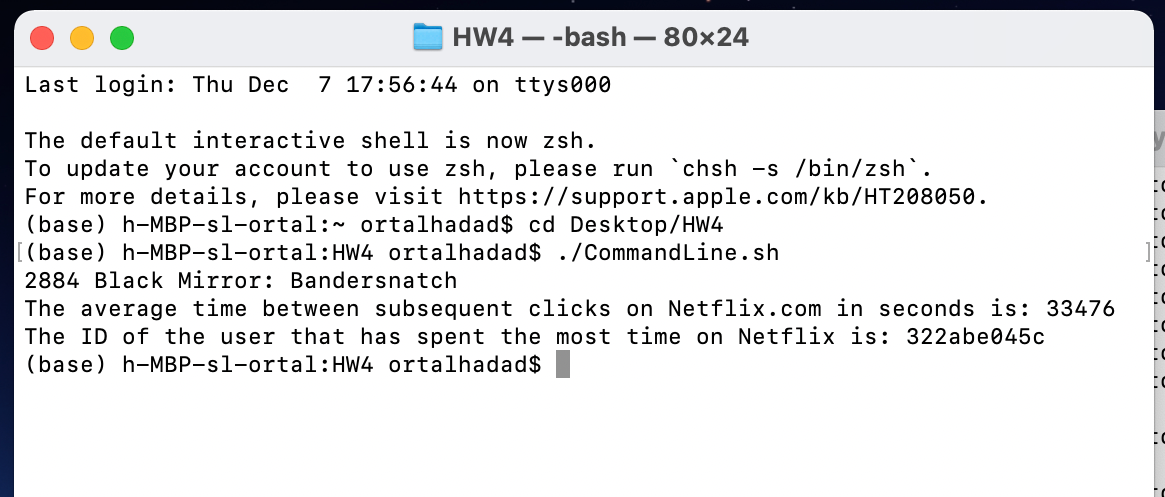

# **5. Algorithmic Question**


First we will consider the Brute-force algorithm which go over all the possible scores and return the maximal one.    
This is clearly not the optimal solution because in this case we have running time of order O(n!)- which is higher than exponential !!  

In [ ]:
#brute force solution

def exams_score(score, exams):
    if len(exams) == 1:
        return exams[0]
    else:
        return max([exams_score(element, [x + (score - element) for x in exams if x != element]) for element in exams])

In [ ]:
score = int(input("Enter initial personal score: "))
arr = list(map(int, input("Enter exams marks: ").split()))
exams_score(score, arr)

Enter initial personal score: 25
Enter exams marks: 18 24 21 32 27


44

## Optimal Implementation
The following solution is the **optimal one:**

In [ ]:
#optimized implementation
import math

def max_score(score, arr):
    if len(arr) == 0:
        return score
    index = math.ceil(len(arr) / 2) - 1
    next_score = arr[index]
    return max_score_calc(next_score, [x + (score - next_score) for x in arr if x != next_score])

def max_score_calc(score, arr):
    return max_score(score, sorted(arr))

In [ ]:
score = int(input("Enter initial personal score: "))
arr = list(map(int, input("Enter exams marks: ").split()))
max_score_calc(score, arr)

Enter initial personal score: 30
Enter exams marks: 13 27 41 59 28 33 39 19 52 48 55 79


205

## Proof of Correctness

**Base Case**: The base case is when the array `arr` is empty, n = 0. In this case, the function max_score returns the initial score `score`, which is correct because there are no more exams to take.

**Inductive Hypothesis**: Assume that the algorithm works correctly for an array of size n. This means that the algorithm correctly calculates the maximum possible score for an array of size n.

**Inductive Step**: The algorithm always chooses the middle element of the array as the next score, and then recursively calculates the maximum score for the remaining elements. Since the remaining elements are a subset of the original array, and we have assumed that the algorithm works correctly for an array of length n, it follows that the algorithm also works correctly for an array of length n+1

## Running time - Optimal Solution
Denote n as the length of our input array 'arr'.
We will prove our algorithm run in O(n *log(n)):

First note thet we are calling the `max_score_calc` that send our input score and the sorted version of our array into the `max_score` function.
- `max_score(score, sorted(arr))` - The sorted() function has a time complexity of O(n log n)

Afterward for the function `max_score` we have:
- `if len(arr) == 0` : The algorithm first checks if the array is empty. This operation has a constant time complexity of O(1).
- `index = math.ceil(len(arr) / 2) - 1` : Selects the index of middle element of the array using len and ceil takes O(1).
- `next_score = arr[index]` : Selecting an element from a sorted array has a time complexity of O(1).  
- `max_score_calc(next_score, [x + (score - next_score) for x in arr if x != next_score])`: Now we call our function in a recursive way with len(arr) = N-1. Also note that we change each element in the new array this is done by going over all elements in the array which takes O(n) and in the next recursive call this will take O(n- 1), since the length of the new input array decrease.  
Therfore the overall running time of `max_score` is O(n + (n-1) + (n-2) + ... + 1) < O( c * n) = O(n).

So we get our algorithm has running time of O(n log(n) + n) = O(n log(n)).  

This implementation is the optimal one since in order to solve the question me must sort the given array which takes at least O(n log(n)).

## AI third implementation

The following code is the implementation suggested by chatGPT.
The running time of this code is explained as follow:

In this code, S is the initial score and exams is a list of exam marks. The function max_score returns the maximum possible score. The time complexity of this solution is O(N^2), where N is the number of exams. This is because for each exam, we are iterating over all the previous exams to calculate the maximum possible score. The space complexity is O(N), which is used to store the dynamic programming table dp.


In [ ]:
def max_score_ai(S, exams):
    exams.sort(reverse=True)
    dp = [0]*len(exams)
    for i in range(len(exams)):
        for j in range(i):
            if exams[i] > exams[j]:
                dp[i] = max(dp[i], dp[j] + exams[i] - exams[j])
            else:
                dp[i] = max(dp[i], dp[j] + S - exams[i])
        dp[i] = max(dp[i], exams[i])
    return dp[-1]

In [ ]:
score = int(input("Enter initial personal score: "))
arr = list(map(int, input("Enter exams marks: ").split()))
max_score_ai(score, arr)

Enter initial personal score: 30
Enter exams marks:  13 27 41 59 28 33 39 19 52 48 55 79


112

Clearly the algorithm is wrong since the Max_score for the input given is 105 and not 112.